In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    def __init__(self, input_size, hidden_size):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._get_positional_encoding(input_size, hidden_size)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    def _get_positional_encoding(self, input_size, hidden_size):
        angle_rads = self._get_angles(input_size, hidden_size)

        # Apply sin to even indices in the array
        angle_rads[:, 0::2] = tf.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array
        angle_rads[:, 1::2] = tf.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def _get_angles(self, input_size, hidden_size):
        positions = np.arange(input_size)[:, np.newaxis]
        indices = np.arange(hidden_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (indices // 2)) / np.float32(hidden_size))
        return positions * angle_rates


class TransformerLayer(layers.Layer):
    def __init__(self, hidden_size, num_heads):
        super(TransformerLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads, hidden_size)
        self.dropout = layers.Dropout(0.1)
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential(
            [layers.Dense(hidden_size, activation="relu"), layers.Dense(hidden_size)]
        )

    def call(self, x, training):
        attn_output = self.mha(x, x, training=training)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.norm(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm(out1 + ffn_output)


class Transformer(tf.keras.Model):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(Transformer, self).__init__()

        self.embedding = layers.Embedding(input_size, hidden_size)
        self.pos_encoding = PositionalEncoding(input_size, hidden_size)
        self.encoder = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.decoder = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.output_layer = layers.Dense(input_size)

    def call(self, src, tgt, training=True):
        src_embedding = self.embedding(src)
        src_embedding = self.pos_encoding(src_embedding)
        tgt_embedding = self.embedding(tgt)
        tgt_embedding = self.pos_encoding(tgt_embedding)

        for encoder_layer in self.encoder:
            src_embedding = encoder_layer(src_embedding, training)

        for decoder_layer in self.decoder:
            tgt_embedding = decoder_layer(tgt_embedding, training)

        output = self.output_layer(tgt_embedding)

        return output


In [2]:
import random

# Hyperparameters
input_size = 50  # Example: Range of input numbers
hidden_size = 64
num_layers = 2
num_heads = 4
learning_rate = 0.001
num_epochs = 5000

# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Create the transformer model
model = Transformer(input_size, hidden_size, num_layers, num_heads)


2023-06-27 10:02:34.749362: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-27 10:02:34.749598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/saschacaron/Downloads/experiment_2d_noisy-1-to-20-tracks/events_all/hits_and_tracks_2d_events_all.csv')

# Print the contents of the DataFrame
print(df.head())


ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.5.
Please upgrade numpy to >= 1.20.3 to use this pandas version

In [4]:
import matplotlib.pyplot as plt

# Lists to store the loss values and epochs
loss_history = []
epoch_history = []

# Training loop
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:

        # here we make the training data, we generate a sequence of random numbers as coordintes of hits
        # and then we below we assign classes to those numbers
        n = random.randint(2,10) # Define the length of your lists
        start = random.uniform(0, input_size - 21)  # Start with a random integer
        training_data = [start + 2*i for i in range(n)]

        # the target values are just classes, computed with the modulo from the coordinates that are the inputs
        #target_values = [x + 2 for x in training_data]
        N = 10  # Number of classes
        target_values = [int(x) % N + 1 for x in training_data]
    
#        n = 10-1  # Define the length of your lists
#        start = random.randint(0, input_size - 3)  # Start with a random integer
#        training_data = [start + 2*i for i in range(n)]
#        target_values = [x + 2 for x in training_data]

        print (training_data)
        print (target_values)
        
        # Convert training data to tensors
        src = tf.constant([training_data])
        tgt = tf.constant([target_values])

        # Reset the initial prediction value for each epoch
        tgt_input = tgt[:, :-1]  # Exclude last target value during training
        real_tgt = tgt[:, 1:]    # Calculate loss with target shifted by one

        # Forward pass
        output = model(src, tgt_input, training=True)

        # Calculate loss
        loss = loss_function(real_tgt, output)
        # Append the loss and epoch to the history lists
        loss_history.append(loss.numpy())
        epoch_history.append(epoch + 1)


    # Perform gradient descent
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")


[15.848360325664904, 17.848360325664906]
[6, 8]
[0.31354410725035353, 2.3135441072503538, 4.313544107250354, 6.313544107250354, 8.313544107250353, 10.313544107250353, 12.313544107250353, 14.313544107250353, 16.313544107250355]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.535285016721115, 15.535285016721115, 17.535285016721115]
[4, 6, 8]
[4.095704516524538, 6.095704516524538, 8.095704516524538, 10.095704516524538, 12.095704516524538, 14.095704516524538]
[5, 7, 9, 1, 3, 5]
[26.828067110343458, 28.828067110343458, 30.828067110343458, 32.828067110343454]
[7, 9, 1, 3]


[12.992170616529558, 14.992170616529558, 16.992170616529556, 18.992170616529556, 20.992170616529556, 22.992170616529556, 24.992170616529556, 26.992170616529556]
[3, 5, 7, 9, 1, 3, 5, 7]
[24.858782972718366, 26.858782972718366, 28.858782972718366, 30.858782972718366, 32.858782972718366, 34.858782972718366, 36.858782972718366, 38.858782972718366, 40.858782972718366]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[28.32805514554088, 30.32805514554088, 32.32805514554088, 34.32805514554088, 36.32805514554088, 38.32805514554088, 40.32805514554088, 42.32805514554088]
[9, 1, 3, 5, 7, 9, 1, 3]
[8.778226965895268, 10.778226965895268, 12.778226965895268, 14.778226965895268, 16.778226965895268, 18.778226965895268, 20.778226965895268, 22.778226965895268, 24.778226965895268, 26.778226965895268]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[15.969899377437525, 17.969899377437525, 19.969899377437525, 21.969899377437525, 23.969899377437525, 25.969899377437525, 27.969899377437525, 29.969899377437525, 31.969899377437525]
[6, 8, 10, 2, 4

Epoch [10/5000], Loss: 3.9517
[0.8552483529304016, 2.855248352930402, 4.855248352930402, 6.855248352930402]
[1, 3, 5, 7]
[23.45629286597571, 25.45629286597571, 27.45629286597571, 29.45629286597571]
[4, 6, 8, 10]
[3.522022094775317, 5.522022094775317, 7.522022094775317, 9.522022094775316]
[4, 6, 8, 10]
[16.748042140425305, 18.748042140425305]
[7, 9]
[24.914702134891407, 26.914702134891407, 28.914702134891407, 30.914702134891407]
[5, 7, 9, 1]


[4.2920263077999685, 6.2920263077999685]
[5, 7]
[3.5729904105387322, 5.572990410538733, 7.572990410538733, 9.572990410538733, 11.572990410538733]
[4, 6, 8, 10, 2]
[1.3107837686651314, 3.3107837686651314, 5.310783768665131]
[2, 4, 6]
[14.059574958571025, 16.059574958571027, 18.059574958571027, 20.059574958571027, 22.059574958571027]
[5, 7, 9, 1, 3]
[13.535735451296237, 15.535735451296237, 17.535735451296237, 19.535735451296237, 21.535735451296237, 23.535735451296237]
[4, 6, 8, 10, 2, 4]


Epoch [20/5000], Loss: 3.2702
[5.147708112055984, 7.147708112055984, 9.147708112055984, 11.147708112055984, 13.147708112055984, 15.147708112055984, 17.147708112055984, 19.147708112055984]
[6, 8, 10, 2, 4, 6, 8, 10]
[27.0782016472716, 29.0782016472716, 31.0782016472716, 33.0782016472716, 35.0782016472716]
[8, 10, 2, 4, 6]
[26.621801167774045, 28.621801167774045, 30.621801167774045, 32.621801167774045, 34.621801167774045, 36.621801167774045, 38.621801167774045, 40.621801167774045, 42.621801167774045]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.895572095131747, 12.895572095131747, 14.895572095131747, 16.895572095131747, 18.895572095131747, 20.895572095131747, 22.895572095131747]
[1, 3, 5, 7, 9, 1, 3]
[18.287787844167568, 20.287787844167568, 22.287787844167568, 24.287787844167568, 26.287787844167568]
[9, 1, 3, 5, 7]


[9.601756084761167, 11.601756084761167, 13.601756084761167, 15.601756084761167, 17.601756084761167, 19.601756084761167, 21.601756084761167]
[10, 2, 4, 6, 8, 10, 2]
[15.55592580814639, 17.55592580814639, 19.55592580814639, 21.55592580814639, 23.55592580814639, 25.55592580814639, 27.55592580814639, 29.55592580814639]
[6, 8, 10, 2, 4, 6, 8, 10]
[1.5010137847753215, 3.5010137847753215, 5.5010137847753215]
[2, 4, 6]
[19.1778528205081, 21.1778528205081, 23.1778528205081, 25.1778528205081, 27.1778528205081, 29.1778528205081, 31.1778528205081, 33.1778528205081]
[10, 2, 4, 6, 8, 10, 2, 4]
[1.2410086605136468, 3.2410086605136468, 5.241008660513646, 7.241008660513646]
[2, 4, 6, 8]


Epoch [30/5000], Loss: 2.5212
[20.69380721875416, 22.69380721875416, 24.69380721875416, 26.69380721875416, 28.69380721875416, 30.69380721875416, 32.69380721875416, 34.69380721875416, 36.69380721875416, 38.69380721875416]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.69990460659098, 30.69990460659098, 32.69990460659098, 34.69990460659098, 36.69990460659098]
[9, 1, 3, 5, 7]
[1.7449122056578643, 3.7449122056578643, 5.744912205657864, 7.744912205657864, 9.744912205657865, 11.744912205657865, 13.744912205657865, 15.744912205657865, 17.744912205657865, 19.744912205657865]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.0840016254684843, 4.084001625468485, 6.084001625468485, 8.084001625468485, 10.084001625468485, 12.084001625468485, 14.084001625468485, 16.084001625468485, 18.084001625468485]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[18.187551923534112, 20.187551923534112, 22.187551923534112]
[9, 1, 3]


[0.24129526121178002, 2.2412952612117802, 4.24129526121178, 6.24129526121178, 8.24129526121178, 10.24129526121178, 12.24129526121178, 14.24129526121178, 16.24129526121178, 18.24129526121178]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.782661539005907, 4.7826615390059075, 6.7826615390059075, 8.782661539005908]
[3, 5, 7, 9]
[28.245487255164704, 30.245487255164704, 32.245487255164704, 34.245487255164704, 36.245487255164704, 38.245487255164704, 40.245487255164704, 42.245487255164704, 44.245487255164704, 46.245487255164704]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.985749039859884, 6.985749039859884, 8.985749039859883, 10.985749039859883, 12.985749039859883, 14.985749039859883, 16.985749039859883, 18.985749039859883, 20.985749039859883, 22.985749039859883]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.264508764410333, 21.264508764410333, 23.264508764410333, 25.264508764410333, 27.264508764410333, 29.264508764410333, 31.264508764410333, 33.26450876441034]
[10, 2, 4, 6, 8, 10, 2, 4]


Epoch [40/5000], Loss: 2.6051
[26.639705653310216, 28.639705653310216, 30.639705653310216, 32.639705653310216, 34.639705653310216, 36.639705653310216, 38.639705653310216, 40.639705653310216]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.81792695778925, 9.81792695778925, 11.81792695778925, 13.81792695778925, 15.81792695778925, 17.81792695778925, 19.81792695778925]
[8, 10, 2, 4, 6, 8, 10]
[18.791372326910658, 20.791372326910658, 22.791372326910658, 24.791372326910658, 26.791372326910658, 28.791372326910658, 30.791372326910658, 32.79137232691066, 34.79137232691066]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.505438597718037, 12.505438597718037, 14.505438597718037, 16.505438597718037, 18.505438597718037]
[1, 3, 5, 7, 9]
[14.87432507065864, 16.874325070658642, 18.874325070658642, 20.874325070658642]
[5, 7, 9, 1]


[25.27199707089834, 27.27199707089834, 29.27199707089834, 31.27199707089834, 33.27199707089834, 35.27199707089834, 37.27199707089834, 39.27199707089834]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.606614562209746, 19.606614562209746, 21.606614562209746, 23.606614562209746, 25.606614562209746, 27.606614562209746, 29.606614562209746, 31.606614562209746]
[8, 10, 2, 4, 6, 8, 10, 2]
[9.292773289889567, 11.292773289889567, 13.292773289889567, 15.292773289889567, 17.292773289889567, 19.292773289889567, 21.292773289889567, 23.292773289889567]
[10, 2, 4, 6, 8, 10, 2, 4]
[27.472611260451316, 29.472611260451316, 31.472611260451316, 33.472611260451316, 35.472611260451316, 37.472611260451316, 39.472611260451316]
[8, 10, 2, 4, 6, 8, 10]
[7.293393932818268, 9.293393932818269, 11.293393932818269, 13.293393932818269, 15.293393932818269, 17.29339393281827, 19.29339393281827]
[8, 10, 2, 4, 6, 8, 10]


Epoch [50/5000], Loss: 2.7373
[0.7556175967542043, 2.7556175967542043, 4.755617596754204, 6.755617596754204, 8.755617596754204, 10.755617596754204, 12.755617596754204]
[1, 3, 5, 7, 9, 1, 3]
[11.18943730092418, 13.18943730092418, 15.18943730092418]
[2, 4, 6]
[26.668800906500117, 28.668800906500117, 30.668800906500117, 32.66880090650012, 34.66880090650012]
[7, 9, 1, 3, 5]
[10.750968855105862, 12.750968855105862, 14.750968855105862, 16.75096885510586, 18.75096885510586, 20.75096885510586, 22.75096885510586, 24.75096885510586, 26.75096885510586, 28.75096885510586]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.05552130682983, 29.05552130682983, 31.05552130682983, 33.05552130682983, 35.05552130682983]
[8, 10, 2, 4, 6]


[5.354491314830413, 7.354491314830413, 9.354491314830412, 11.354491314830412]
[6, 8, 10, 2]
[6.243252873083696, 8.243252873083696, 10.243252873083696, 12.243252873083696]
[7, 9, 1, 3]
[25.802978931282368, 27.802978931282368, 29.802978931282368, 31.802978931282368, 33.80297893128237, 35.80297893128237, 37.80297893128237, 39.80297893128237]
[6, 8, 10, 2, 4, 6, 8, 10]
[19.422356795547525, 21.422356795547525, 23.422356795547525, 25.422356795547525]
[10, 2, 4, 6]
[22.66978529539986, 24.66978529539986, 26.66978529539986, 28.66978529539986, 30.66978529539986, 32.66978529539986, 34.66978529539986, 36.66978529539986, 38.66978529539986, 40.66978529539986]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [60/5000], Loss: 2.3387
[23.12958241087813, 25.12958241087813, 27.12958241087813, 29.12958241087813, 31.12958241087813, 33.12958241087813]
[4, 6, 8, 10, 2, 4]
[21.934071350316714, 23.934071350316714, 25.934071350316714, 27.934071350316714, 29.934071350316714, 31.934071350316714, 33.934071350316714]
[2, 4, 6, 8, 10, 2, 4]
[12.714356210177225, 14.714356210177225, 16.714356210177225, 18.714356210177225, 20.714356210177225, 22.714356210177225]
[3, 5, 7, 9, 1, 3]
[24.566915840915605, 26.566915840915605, 28.566915840915605, 30.566915840915605, 32.566915840915605]
[5, 7, 9, 1, 3]
[13.43141424281579, 15.43141424281579, 17.43141424281579, 19.43141424281579, 21.43141424281579, 23.43141424281579, 25.43141424281579, 27.43141424281579]
[4, 6, 8, 10, 2, 4, 6, 8]


[25.954180793973336, 27.954180793973336, 29.954180793973336, 31.954180793973336, 33.954180793973336, 35.954180793973336, 37.954180793973336, 39.954180793973336, 41.954180793973336]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.678842596678933, 16.678842596678933, 18.678842596678933, 20.678842596678933]
[5, 7, 9, 1]
[4.152119467530109, 6.152119467530109, 8.15211946753011, 10.15211946753011, 12.15211946753011, 14.15211946753011, 16.15211946753011, 18.15211946753011, 20.15211946753011]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.347470423307964, 26.347470423307964, 28.347470423307964, 30.347470423307964, 32.34747042330797, 34.34747042330797, 36.34747042330797, 38.34747042330797]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.063015777743606, 8.063015777743605, 10.063015777743605]
[7, 9, 1]


Epoch [70/5000], Loss: 2.0884
[6.306837723992498, 8.306837723992498, 10.306837723992498, 12.306837723992498, 14.306837723992498, 16.306837723992498, 18.306837723992498, 20.306837723992498, 22.306837723992498]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.066635246022514, 6.066635246022514, 8.066635246022514, 10.066635246022514, 12.066635246022514, 14.066635246022514, 16.066635246022514, 18.066635246022514, 20.066635246022514]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.50177339691889, 18.50177339691889, 20.50177339691889, 22.50177339691889]
[7, 9, 1, 3]
[5.894046163519808, 7.894046163519808, 9.894046163519807]
[6, 8, 10]
[13.664976448355603, 15.664976448355603, 17.664976448355603, 19.664976448355603, 21.664976448355603, 23.664976448355603, 25.664976448355603]
[4, 6, 8, 10, 2, 4, 6]


[17.564039699671405, 19.564039699671405, 21.564039699671405, 23.564039699671405, 25.564039699671405, 27.564039699671405, 29.564039699671405, 31.564039699671405]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.260081607228095, 10.260081607228095, 12.260081607228095, 14.260081607228095, 16.260081607228095, 18.260081607228095]
[9, 1, 3, 5, 7, 9]
[19.601535302879224, 21.601535302879224, 23.601535302879224, 25.601535302879224, 27.601535302879224, 29.601535302879224]
[10, 2, 4, 6, 8, 10]
[18.19088521034133, 20.19088521034133, 22.19088521034133, 24.19088521034133, 26.19088521034133]
[9, 1, 3, 5, 7]
[14.825804778537918, 16.82580477853792, 18.82580477853792, 20.82580477853792, 22.82580477853792]
[5, 7, 9, 1, 3]


Epoch [80/5000], Loss: 2.0448
[0.8480593284820026, 2.8480593284820026, 4.848059328482003, 6.848059328482003, 8.848059328482002, 10.848059328482002, 12.848059328482002, 14.848059328482002, 16.848059328482]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.022697826850443, 20.022697826850443, 22.022697826850443, 24.022697826850443]
[9, 1, 3, 5]
[3.553796142817587, 5.553796142817587]
[4, 6]
[13.202180055993557, 15.202180055993557, 17.20218005599356, 19.20218005599356]
[4, 6, 8, 10]
[23.860901929135938, 25.860901929135938, 27.860901929135938, 29.860901929135938, 31.860901929135938]
[4, 6, 8, 10, 2]


[22.223828839631548, 24.223828839631548, 26.223828839631548]
[3, 5, 7]
[15.455099657544846, 17.455099657544846, 19.455099657544846, 21.455099657544846, 23.455099657544846]
[6, 8, 10, 2, 4]
[10.221390138540086, 12.221390138540086, 14.221390138540086]
[1, 3, 5]
[13.820037173826076, 15.820037173826076, 17.820037173826076, 19.820037173826076, 21.820037173826076, 23.820037173826076, 25.820037173826076, 27.820037173826076, 29.820037173826076]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.766350709417825, 12.766350709417825, 14.766350709417825, 16.766350709417825, 18.766350709417825, 20.766350709417825, 22.766350709417825, 24.766350709417825, 26.766350709417825]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [90/5000], Loss: 2.1731
[19.553932697237165, 21.553932697237165, 23.553932697237165, 25.553932697237165, 27.553932697237165, 29.553932697237165, 31.553932697237165]
[10, 2, 4, 6, 8, 10, 2]
[15.703162223787718, 17.703162223787718, 19.703162223787718, 21.703162223787718, 23.703162223787718, 25.703162223787718]
[6, 8, 10, 2, 4, 6]
[26.402908856072468, 28.402908856072468, 30.402908856072468, 32.40290885607247, 34.40290885607247, 36.40290885607247]
[7, 9, 1, 3, 5, 7]
[14.512041166490265, 16.512041166490263, 18.512041166490263, 20.512041166490263]
[5, 7, 9, 1]
[12.04126660208487, 14.04126660208487, 16.041266602084868]
[3, 5, 7]


[27.65152894216997, 29.65152894216997, 31.65152894216997, 33.651528942169975, 35.651528942169975, 37.651528942169975, 39.651528942169975, 41.651528942169975]
[8, 10, 2, 4, 6, 8, 10, 2]
[17.767708039123445, 19.767708039123445, 21.767708039123445]
[8, 10, 2]
[25.662873827459133, 27.662873827459133, 29.662873827459133]
[6, 8, 10]
[21.94945453798006, 23.94945453798006, 25.94945453798006, 27.94945453798006, 29.94945453798006, 31.94945453798006, 33.94945453798006, 35.94945453798006, 37.94945453798006, 39.94945453798006]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.044804636974101, 6.044804636974101, 8.044804636974101]
[5, 7, 9]


Epoch [100/5000], Loss: 2.1489
[22.11754243485688, 24.11754243485688, 26.11754243485688, 28.11754243485688, 30.11754243485688, 32.11754243485688, 34.11754243485688, 36.11754243485688, 38.11754243485688]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[10.8656019314197, 12.8656019314197]
[1, 3]
[19.77191615966943, 21.77191615966943, 23.77191615966943, 25.77191615966943, 27.77191615966943]
[10, 2, 4, 6, 8]
[17.362190517014923, 19.362190517014923]
[8, 10]
[24.414076520224125, 26.414076520224125, 28.414076520224125, 30.414076520224125, 32.41407652022413, 34.41407652022413, 36.41407652022413, 38.41407652022413, 40.41407652022413, 42.41407652022413]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[11.034978913516822, 13.034978913516822, 15.034978913516822, 17.034978913516824, 19.034978913516824, 21.034978913516824, 23.034978913516824, 25.034978913516824]
[2, 4, 6, 8, 10, 2, 4, 6]
[0.6608066494393443, 2.660806649439344, 4.660806649439344, 6.660806649439344, 8.660806649439344, 10.660806649439344, 12.660806649439344, 14.660806649439344, 16.660806649439344]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.229423384670607, 20.229423384670607, 22.229423384670607, 24.229423384670607, 26.229423384670607, 28.229423384670607, 30.229423384670607, 32.22942338467061]
[9, 1, 3, 5, 7, 9, 1, 3]
[19.405850072281986, 21.405850072281986, 23.405850072281986, 25.405850072281986]
[10, 2, 4, 6]
[22.898860810191103, 24.898860810191103, 26.898860810191103, 28.898860810191103, 30.898860810191103, 32.8988608101911, 34.8988608101911, 36.8988608101911]
[3, 5, 7, 9, 1, 3, 5, 7]


Epoch [110/5000], Loss: 2.4429
[0.9016075139694386, 2.901607513969439, 4.901607513969439, 6.901607513969439, 8.901607513969438, 10.901607513969438, 12.901607513969438]
[1, 3, 5, 7, 9, 1, 3]
[18.81823854827195, 20.81823854827195, 22.81823854827195, 24.81823854827195, 26.81823854827195, 28.81823854827195, 30.81823854827195, 32.81823854827195, 34.81823854827195]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[28.271291858965128, 30.271291858965128, 32.27129185896513, 34.27129185896513]
[9, 1, 3, 5]
[2.351829043735961, 4.351829043735961, 6.351829043735961, 8.351829043735961]
[3, 5, 7, 9]
[22.492003497235945, 24.492003497235945, 26.492003497235945, 28.492003497235945, 30.492003497235945, 32.49200349723594, 34.49200349723594]
[3, 5, 7, 9, 1, 3, 5]


[18.96603888786068, 20.96603888786068, 22.96603888786068]
[9, 1, 3]
[27.005260300227906, 29.005260300227906, 31.005260300227906]
[8, 10, 2]
[23.96904459941473, 25.96904459941473]
[4, 6]
[2.804816963751824, 4.804816963751824, 6.804816963751824, 8.804816963751824, 10.804816963751824, 12.804816963751824, 14.804816963751824]
[3, 5, 7, 9, 1, 3, 5]
[7.848034237075581, 9.84803423707558, 11.84803423707558, 13.84803423707558, 15.84803423707558, 17.84803423707558, 19.84803423707558, 21.84803423707558, 23.84803423707558]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [120/5000], Loss: 2.6546
[19.335948796218922, 21.335948796218922, 23.335948796218922, 25.335948796218922, 27.335948796218922, 29.335948796218922, 31.335948796218922, 33.33594879621892, 35.33594879621892]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[18.35157488752966, 20.35157488752966, 22.35157488752966, 24.35157488752966, 26.35157488752966, 28.35157488752966, 30.35157488752966]
[9, 1, 3, 5, 7, 9, 1]
[13.092048775821562, 15.092048775821562]
[4, 6]
[18.028531951559923, 20.028531951559923, 22.028531951559923, 24.028531951559923, 26.028531951559923, 28.028531951559923, 30.028531951559923]
[9, 1, 3, 5, 7, 9, 1]
[18.517314820479868, 20.517314820479868, 22.517314820479868, 24.517314820479868, 26.517314820479868]
[9, 1, 3, 5, 7]


[13.322344861875909, 15.322344861875909, 17.32234486187591]
[4, 6, 8]
[23.156220280474347, 25.156220280474347, 27.156220280474347, 29.156220280474347, 31.156220280474347, 33.156220280474344]
[4, 6, 8, 10, 2, 4]
[2.9484376830918886, 4.948437683091889, 6.948437683091889, 8.948437683091889]
[3, 5, 7, 9]
[19.748314399333754, 21.748314399333754, 23.748314399333754, 25.748314399333754, 27.748314399333754, 29.748314399333754]
[10, 2, 4, 6, 8, 10]
[24.252336289380874, 26.252336289380874, 28.252336289380874, 30.252336289380874, 32.25233628938088, 34.25233628938088, 36.25233628938088, 38.25233628938088, 40.25233628938088, 42.25233628938088]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [130/5000], Loss: 2.0013
[17.212582513914327, 19.212582513914327, 21.212582513914327, 23.212582513914327, 25.212582513914327, 27.212582513914327, 29.212582513914327, 31.212582513914327, 33.21258251391433]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[25.666182174277456, 27.666182174277456]
[6, 8]
[20.58462549682118, 22.58462549682118, 24.58462549682118, 26.58462549682118, 28.58462549682118, 30.58462549682118, 32.584625496821175, 34.584625496821175]
[1, 3, 5, 7, 9, 1, 3, 5]
[22.398003094139202, 24.398003094139202, 26.398003094139202, 28.398003094139202, 30.398003094139202, 32.3980030941392, 34.3980030941392, 36.3980030941392, 38.3980030941392]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[23.69405593731228, 25.69405593731228, 27.69405593731228, 29.69405593731228, 31.69405593731228, 33.694055937312285, 35.694055937312285, 37.694055937312285, 39.694055937312285]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[0.3077613920347315, 2.3077613920347315, 4.307761392034731, 6.307761392034731, 8.307761392034731]
[1, 3, 5, 7, 9]
[2.197647314447801, 4.197647314447801, 6.197647314447801, 8.197647314447801, 10.197647314447801, 12.197647314447801, 14.197647314447801, 16.1976473144478, 18.1976473144478]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.552120851618547, 18.552120851618547, 20.552120851618547, 22.552120851618547, 24.552120851618547, 26.552120851618547, 28.552120851618547, 30.552120851618547, 32.55212085161855, 34.55212085161855]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.258485013723085, 24.258485013723085, 26.258485013723085, 28.258485013723085, 30.258485013723085, 32.25848501372309, 34.25848501372309, 36.25848501372309]
[3, 5, 7, 9, 1, 3, 5, 7]
[20.042944498015054, 22.042944498015054]
[1, 3]


Epoch [140/5000], Loss: 1.8426
[7.003478359273238, 9.003478359273238, 11.003478359273238, 13.003478359273238, 15.003478359273238, 17.003478359273238, 19.003478359273238, 21.003478359273238, 23.003478359273238]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.043741629426936, 6.043741629426936, 8.043741629426936, 10.043741629426936, 12.043741629426936, 14.043741629426936]
[5, 7, 9, 1, 3, 5]
[13.045747570568231, 15.045747570568231, 17.04574757056823, 19.04574757056823, 21.04574757056823, 23.04574757056823, 25.04574757056823]
[4, 6, 8, 10, 2, 4, 6]
[4.685073656527856, 6.685073656527856, 8.685073656527855, 10.685073656527855, 12.685073656527855, 14.685073656527855, 16.685073656527855, 18.685073656527855, 20.685073656527855]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[11.188788447976743, 13.188788447976743, 15.188788447976743, 17.18878844797674, 19.18878844797674, 21.18878844797674, 23.18878844797674, 25.18878844797674, 27.18878844797674]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[9.255365025310272, 11.255365025310272, 13.255365025310272, 15.255365025310272, 17.255365025310272, 19.255365025310272, 21.255365025310272, 23.255365025310272, 25.255365025310272]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.36172950453391, 9.36172950453391, 11.36172950453391, 13.36172950453391, 15.36172950453391, 17.361729504533912, 19.361729504533912, 21.361729504533912]
[8, 10, 2, 4, 6, 8, 10, 2]
[3.503409586463072, 5.503409586463071, 7.503409586463071, 9.503409586463071, 11.503409586463071, 13.503409586463071, 15.503409586463071, 17.50340958646307, 19.50340958646307]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.561137117732434, 6.561137117732434, 8.561137117732434, 10.561137117732434, 12.561137117732434, 14.561137117732434, 16.561137117732436, 18.561137117732436]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.346164769238948, 8.346164769238948]
[7, 9]


Epoch [150/5000], Loss: 1.6545
[5.772431887463294, 7.772431887463294, 9.772431887463295, 11.772431887463295, 13.772431887463295, 15.772431887463295, 17.772431887463295, 19.772431887463295, 21.772431887463295]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.454049739172802, 21.454049739172802, 23.454049739172802, 25.454049739172802, 27.454049739172802, 29.454049739172802, 31.454049739172802, 33.4540497391728]
[10, 2, 4, 6, 8, 10, 2, 4]
[0.933388837711403, 2.9333888377114032]
[1, 3]
[3.99773728698063, 5.99773728698063, 7.99773728698063, 9.99773728698063, 11.99773728698063, 13.99773728698063, 15.99773728698063, 17.99773728698063, 19.99773728698063]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[19.692301420428333, 21.692301420428333, 23.692301420428333, 25.692301420428333]
[10, 2, 4, 6]


[4.651080129951183, 6.651080129951183]
[5, 7]
[12.796493505957384, 14.796493505957384, 16.796493505957386, 18.796493505957386, 20.796493505957386, 22.796493505957386, 24.796493505957386, 26.796493505957386, 28.796493505957386, 30.796493505957386]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[23.882930555903833, 25.882930555903833, 27.882930555903833, 29.882930555903833, 31.882930555903833, 33.88293055590383, 35.88293055590383, 37.88293055590383, 39.88293055590383, 41.88293055590383]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.536076206924097, 24.536076206924097, 26.536076206924097, 28.536076206924097, 30.536076206924097, 32.53607620692409, 34.53607620692409, 36.53607620692409, 38.53607620692409, 40.53607620692409]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[8.818164249670968, 10.818164249670968, 12.818164249670968, 14.818164249670968]
[9, 1, 3, 5]


Epoch [160/5000], Loss: 2.8376
[7.101190778816189, 9.10119077881619, 11.10119077881619, 13.10119077881619, 15.10119077881619, 17.10119077881619]
[8, 10, 2, 4, 6, 8]
[21.906412377057244, 23.906412377057244]
[2, 4]
[3.5495612094655273, 5.549561209465527]
[4, 6]
[22.15211202367685, 24.15211202367685, 26.15211202367685, 28.15211202367685, 30.15211202367685]
[3, 5, 7, 9, 1]
[7.526320718417778, 9.526320718417779, 11.526320718417779, 13.526320718417779, 15.526320718417779, 17.52632071841778, 19.52632071841778]
[8, 10, 2, 4, 6, 8, 10]


[17.368133155360688, 19.368133155360688, 21.368133155360688, 23.368133155360688, 25.368133155360688, 27.368133155360688, 29.368133155360688, 31.368133155360688]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.395133676709307, 17.395133676709307, 19.395133676709307, 21.395133676709307, 23.395133676709307]
[6, 8, 10, 2, 4]
[3.659976976894141, 5.659976976894141, 7.659976976894141, 9.659976976894141, 11.659976976894141]
[4, 6, 8, 10, 2]
[23.573075830908962, 25.573075830908962]
[4, 6]
[26.88116939756668, 28.88116939756668, 30.88116939756668, 32.88116939756668, 34.88116939756668, 36.88116939756668, 38.88116939756668, 40.88116939756668, 42.88116939756668]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [170/5000], Loss: 2.5656
[6.385284279682732, 8.385284279682732, 10.385284279682732, 12.385284279682732]
[7, 9, 1, 3]
[19.211848943837786, 21.211848943837786]
[10, 2]
[6.221347713819148, 8.22134771381915, 10.22134771381915, 12.22134771381915, 14.22134771381915, 16.22134771381915]
[7, 9, 1, 3, 5, 7]
[24.389062669871432, 26.389062669871432, 28.389062669871432]
[5, 7, 9]
[27.940643674520423, 29.940643674520423, 31.940643674520423, 33.94064367452042, 35.94064367452042, 37.94064367452042, 39.94064367452042, 41.94064367452042, 43.94064367452042]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[25.178102198352633, 27.178102198352633]
[6, 8]
[25.94222061481274, 27.94222061481274]
[6, 8]
[0.7418697984032145, 2.7418697984032145, 4.741869798403215, 6.741869798403215, 8.741869798403215, 10.741869798403215, 12.741869798403215, 14.741869798403215, 16.741869798403215]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[5.123260283521192, 7.123260283521192, 9.12326028352119, 11.12326028352119]
[6, 8, 10, 2]
[27.548010639013604, 29.548010639013604, 31.548010639013604]
[8, 10, 2]


Epoch [180/5000], Loss: 2.0610
[25.50066189731358, 27.50066189731358, 29.50066189731358, 31.50066189731358, 33.50066189731358, 35.50066189731358]
[6, 8, 10, 2, 4, 6]
[18.59722626848254, 20.59722626848254, 22.59722626848254]
[9, 1, 3]
[25.115816370159884, 27.115816370159884, 29.115816370159884, 31.115816370159884, 33.115816370159884, 35.115816370159884]
[6, 8, 10, 2, 4, 6]
[2.627204766359105, 4.627204766359105, 6.627204766359105, 8.627204766359105, 10.627204766359105, 12.627204766359105, 14.627204766359105, 16.627204766359107, 18.627204766359107, 20.627204766359107]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.91242425141392, 12.91242425141392, 14.91242425141392, 16.91242425141392, 18.91242425141392, 20.91242425141392]
[1, 3, 5, 7, 9, 1]


[7.897078095431504, 9.897078095431503, 11.897078095431503, 13.897078095431503]
[8, 10, 2, 4]
[16.778138292980064, 18.778138292980064, 20.778138292980064, 22.778138292980064]
[7, 9, 1, 3]
[26.832285404305363, 28.832285404305363, 30.832285404305363]
[7, 9, 1]
[4.679055441986718, 6.679055441986718, 8.67905544198672]
[5, 7, 9]
[23.318077130789682, 25.318077130789682, 27.318077130789682]
[4, 6, 8]


Epoch [190/5000], Loss: 2.2226
[27.805520986793734, 29.805520986793734, 31.805520986793734, 33.80552098679374, 35.80552098679374, 37.80552098679374, 39.80552098679374, 41.80552098679374, 43.80552098679374]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.800691958416346, 17.800691958416344, 19.800691958416344, 21.800691958416344]
[6, 8, 10, 2]
[0.20837754997326152, 2.2083775499732616, 4.208377549973261, 6.208377549973261, 8.208377549973262, 10.208377549973262, 12.208377549973262, 14.208377549973262]
[1, 3, 5, 7, 9, 1, 3, 5]
[26.49409170544675, 28.49409170544675, 30.49409170544675, 32.49409170544675, 34.49409170544675]
[7, 9, 1, 3, 5]
[11.784743999041993, 13.784743999041993, 15.784743999041993]
[2, 4, 6]


[20.08600896435654, 22.08600896435654, 24.08600896435654, 26.08600896435654, 28.08600896435654, 30.08600896435654, 32.08600896435654, 34.08600896435654, 36.08600896435654]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[22.968072502200418, 24.968072502200418, 26.968072502200418, 28.968072502200418, 30.968072502200418, 32.968072502200414, 34.968072502200414, 36.968072502200414, 38.968072502200414, 40.968072502200414]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[7.901931767538015, 9.901931767538015, 11.901931767538015, 13.901931767538015, 15.901931767538015, 17.901931767538017, 19.901931767538017, 21.901931767538017]
[8, 10, 2, 4, 6, 8, 10, 2]
[12.60612915449372, 14.60612915449372, 16.606129154493722, 18.606129154493722, 20.606129154493722, 22.606129154493722]
[3, 5, 7, 9, 1, 3]
[24.430056194488134, 26.430056194488134, 28.430056194488134, 30.430056194488134]
[5, 7, 9, 1]


Epoch [200/5000], Loss: 1.5200
[23.631549136630834, 25.631549136630834, 27.631549136630834, 29.631549136630834]
[4, 6, 8, 10]
[10.598105687917448, 12.598105687917448, 14.598105687917448]
[1, 3, 5]
[4.127252327446586, 6.127252327446586, 8.127252327446586, 10.127252327446586, 12.127252327446586, 14.127252327446586, 16.127252327446584, 18.127252327446584, 20.127252327446584, 22.127252327446584]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.274614085272301, 14.274614085272301, 16.2746140852723, 18.2746140852723, 20.2746140852723, 22.2746140852723, 24.2746140852723, 26.2746140852723, 28.2746140852723]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.01423079429342, 18.01423079429342]
[7, 9]


[26.353028491884494, 28.353028491884494, 30.353028491884494, 32.353028491884494, 34.353028491884494, 36.353028491884494, 38.353028491884494, 40.353028491884494, 42.353028491884494]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.115346719486299, 11.115346719486299, 13.115346719486299, 15.115346719486299, 17.115346719486297, 19.115346719486297, 21.115346719486297]
[10, 2, 4, 6, 8, 10, 2]
[8.507405544113482, 10.507405544113482, 12.507405544113482, 14.507405544113482, 16.50740554411348]
[9, 1, 3, 5, 7]
[5.476435951428808, 7.476435951428808, 9.476435951428808, 11.476435951428808, 13.476435951428808, 15.476435951428808, 17.476435951428808]
[6, 8, 10, 2, 4, 6, 8]
[17.24039591768091, 19.24039591768091, 21.24039591768091, 23.24039591768091, 25.24039591768091, 27.24039591768091, 29.24039591768091, 31.24039591768091]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [210/5000], Loss: 1.7519
[2.179800291935531, 4.179800291935531]
[3, 5]
[11.747069553091361, 13.747069553091361, 15.747069553091361, 17.74706955309136, 19.74706955309136, 21.74706955309136, 23.74706955309136]
[2, 4, 6, 8, 10, 2, 4]
[15.67367789476534, 17.67367789476534, 19.67367789476534, 21.67367789476534]
[6, 8, 10, 2]
[7.758735847291355, 9.758735847291355, 11.758735847291355, 13.758735847291355, 15.758735847291355]
[8, 10, 2, 4, 6]
[4.752364914111117, 6.752364914111117]
[5, 7]


[14.001647472949642, 16.001647472949642, 18.001647472949642, 20.001647472949642, 22.001647472949642]
[5, 7, 9, 1, 3]
[19.147096842185643, 21.147096842185643, 23.147096842185643, 25.147096842185643, 27.147096842185643, 29.147096842185643, 31.147096842185643, 33.14709684218565, 35.14709684218565]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[27.220201171987146, 29.220201171987146, 31.220201171987146, 33.22020117198714, 35.22020117198714]
[8, 10, 2, 4, 6]
[17.88606094371045, 19.88606094371045, 21.88606094371045, 23.88606094371045, 25.88606094371045, 27.88606094371045, 29.88606094371045, 31.88606094371045, 33.88606094371045, 35.88606094371045]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[0.3855337012672162, 2.3855337012672164, 4.385533701267216, 6.385533701267216, 8.385533701267216, 10.385533701267216, 12.385533701267216, 14.385533701267216]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [220/5000], Loss: 2.3783
[21.258332952941885, 23.258332952941885, 25.258332952941885, 27.258332952941885, 29.258332952941885, 31.258332952941885]
[2, 4, 6, 8, 10, 2]
[15.21933145988138, 17.21933145988138, 19.21933145988138, 21.21933145988138, 23.21933145988138, 25.21933145988138, 27.21933145988138, 29.21933145988138, 31.21933145988138, 33.21933145988138]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[17.68547078356707, 19.68547078356707, 21.68547078356707, 23.68547078356707, 25.68547078356707, 27.68547078356707, 29.68547078356707, 31.68547078356707]
[8, 10, 2, 4, 6, 8, 10, 2]
[20.527362236799174, 22.527362236799174, 24.527362236799174, 26.527362236799174]
[1, 3, 5, 7]
[5.459416994008186, 7.459416994008186, 9.459416994008187]
[6, 8, 10]


[2.3146671570239654, 4.314667157023965, 6.314667157023965, 8.314667157023965, 10.314667157023965, 12.314667157023965, 14.314667157023965, 16.314667157023965]
[3, 5, 7, 9, 1, 3, 5, 7]
[21.765507917760253, 23.765507917760253, 25.765507917760253, 27.765507917760253, 29.765507917760253, 31.765507917760253, 33.76550791776025, 35.76550791776025]
[2, 4, 6, 8, 10, 2, 4, 6]
[27.252987907748334, 29.252987907748334, 31.252987907748334, 33.252987907748334, 35.252987907748334, 37.252987907748334, 39.252987907748334, 41.252987907748334, 43.252987907748334]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[9.540596870636962, 11.540596870636962, 13.540596870636962, 15.540596870636962, 17.54059687063696, 19.54059687063696, 21.54059687063696, 23.54059687063696, 25.54059687063696, 27.54059687063696]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.038901504429553, 12.038901504429553]
[1, 3]


Epoch [230/5000], Loss: 3.0448
[4.16050818177544, 6.16050818177544, 8.160508181775441, 10.160508181775441, 12.160508181775441]
[5, 7, 9, 1, 3]
[25.958672770150176, 27.958672770150176, 29.958672770150176, 31.958672770150176]
[6, 8, 10, 2]
[12.900701714465342, 14.900701714465342, 16.90070171446534, 18.90070171446534, 20.90070171446534, 22.90070171446534, 24.90070171446534]
[3, 5, 7, 9, 1, 3, 5]
[26.899669936572014, 28.899669936572014, 30.899669936572014, 32.89966993657201, 34.89966993657201, 36.89966993657201, 38.89966993657201, 40.89966993657201]
[7, 9, 1, 3, 5, 7, 9, 1]
[13.835673390959862, 15.835673390959862, 17.83567339095986, 19.83567339095986, 21.83567339095986, 23.83567339095986, 25.83567339095986, 27.83567339095986, 29.83567339095986]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[13.81524739307062, 15.81524739307062, 17.81524739307062, 19.81524739307062, 21.81524739307062, 23.81524739307062, 25.81524739307062, 27.81524739307062]
[4, 6, 8, 10, 2, 4, 6, 8]
[20.718736912161713, 22.718736912161713, 24.718736912161713]
[1, 3, 5]
[12.594269300658098, 14.594269300658098, 16.594269300658098, 18.594269300658098, 20.594269300658098, 22.594269300658098]
[3, 5, 7, 9, 1, 3]
[16.6327017746366, 18.6327017746366, 20.6327017746366, 22.6327017746366, 24.6327017746366, 26.6327017746366, 28.6327017746366]
[7, 9, 1, 3, 5, 7, 9]
[11.429326123782516, 13.429326123782516, 15.429326123782516, 17.429326123782516, 19.429326123782516, 21.429326123782516, 23.429326123782516, 25.429326123782516]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [240/5000], Loss: 1.7053
[24.14816281887884, 26.14816281887884, 28.14816281887884, 30.14816281887884, 32.148162818878845, 34.148162818878845, 36.148162818878845, 38.148162818878845, 40.148162818878845]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.669741150763716, 11.669741150763716, 13.669741150763716, 15.669741150763716, 17.669741150763716, 19.669741150763716]
[10, 2, 4, 6, 8, 10]
[24.08112413412418, 26.08112413412418, 28.08112413412418, 30.08112413412418, 32.08112413412418, 34.08112413412418]
[5, 7, 9, 1, 3, 5]
[3.3685045713717723, 5.368504571371773, 7.368504571371773]
[4, 6, 8]
[11.708575256680612, 13.708575256680612, 15.708575256680612]
[2, 4, 6]


[14.95715835618593, 16.95715835618593, 18.95715835618593, 20.95715835618593, 22.95715835618593, 24.95715835618593, 26.95715835618593, 28.95715835618593]
[5, 7, 9, 1, 3, 5, 7, 9]
[20.048739192143138, 22.048739192143138, 24.048739192143138, 26.048739192143138, 28.048739192143138, 30.048739192143138, 32.04873919214314, 34.04873919214314, 36.04873919214314]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.773930569409119, 15.773930569409119, 17.773930569409117, 19.773930569409117, 21.773930569409117, 23.773930569409117, 25.773930569409117]
[4, 6, 8, 10, 2, 4, 6]
[5.969501949352177, 7.969501949352177, 9.969501949352177, 11.969501949352177, 13.969501949352177, 15.969501949352177, 17.96950194935218, 19.96950194935218]
[6, 8, 10, 2, 4, 6, 8, 10]
[7.603432439809267, 9.603432439809268, 11.603432439809268, 13.603432439809268, 15.603432439809268, 17.603432439809268, 19.603432439809268]
[8, 10, 2, 4, 6, 8, 10]


Epoch [250/5000], Loss: 0.8025
[19.874781505232015, 21.874781505232015]
[10, 2]
[0.5465061315765102, 2.54650613157651, 4.5465061315765105, 6.5465061315765105]
[1, 3, 5, 7]
[15.383520033280163, 17.383520033280163, 19.383520033280163, 21.383520033280163]
[6, 8, 10, 2]
[7.475655749343938, 9.475655749343938]
[8, 10]
[3.9518519157679313, 5.951851915767931, 7.951851915767931]
[4, 6, 8]


[7.975383092445692, 9.975383092445693]
[8, 10]
[12.311259624579368, 14.311259624579368, 16.311259624579368, 18.311259624579368]
[3, 5, 7, 9]
[17.86389551594587, 19.86389551594587, 21.86389551594587, 23.86389551594587, 25.86389551594587, 27.86389551594587, 29.86389551594587, 31.86389551594587, 33.86389551594587, 35.86389551594587]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[22.1977678780509, 24.1977678780509, 26.1977678780509, 28.1977678780509, 30.1977678780509]
[3, 5, 7, 9, 1]
[10.491635181647222, 12.491635181647222, 14.491635181647222, 16.491635181647222, 18.491635181647222, 20.491635181647222, 22.491635181647222, 24.491635181647222]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [260/5000], Loss: 1.0147
[17.008773393139602, 19.008773393139602]
[8, 10]
[0.4970289490620574, 2.4970289490620576, 4.497028949062058, 6.497028949062058, 8.497028949062058, 10.497028949062058, 12.497028949062058, 14.497028949062058, 16.497028949062056, 18.497028949062056]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[18.59749649406137, 20.59749649406137, 22.59749649406137, 24.59749649406137, 26.59749649406137]
[9, 1, 3, 5, 7]
[5.341382305184685, 7.341382305184685, 9.341382305184684, 11.341382305184684, 13.341382305184684, 15.341382305184684]
[6, 8, 10, 2, 4, 6]
[9.098742781254208, 11.098742781254208, 13.098742781254208]
[10, 2, 4]


[10.055480091327878, 12.055480091327878, 14.055480091327878, 16.05548009132788, 18.05548009132788, 20.05548009132788, 22.05548009132788, 24.05548009132788]
[1, 3, 5, 7, 9, 1, 3, 5]
[22.076874451747408, 24.076874451747408, 26.076874451747408, 28.076874451747408, 30.076874451747408, 32.07687445174741, 34.07687445174741, 36.07687445174741]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.984494190621167, 19.984494190621167, 21.984494190621167, 23.984494190621167, 25.984494190621167, 27.984494190621167, 29.984494190621167]
[8, 10, 2, 4, 6, 8, 10]
[17.488807101710453, 19.488807101710453, 21.488807101710453, 23.488807101710453]
[8, 10, 2, 4]
[28.537561170743615, 30.537561170743615, 32.537561170743615, 34.537561170743615, 36.537561170743615, 38.537561170743615]
[9, 1, 3, 5, 7, 9]


Epoch [270/5000], Loss: 0.7276
[2.9907210243400764, 4.990721024340076, 6.990721024340076, 8.990721024340075, 10.990721024340075]
[3, 5, 7, 9, 1]
[23.63189085762162, 25.63189085762162, 27.63189085762162, 29.63189085762162, 31.63189085762162, 33.63189085762162]
[4, 6, 8, 10, 2, 4]
[5.235753005367794, 7.235753005367794, 9.235753005367794, 11.235753005367794, 13.235753005367794, 15.235753005367794, 17.235753005367794, 19.235753005367794, 21.235753005367794, 23.235753005367794]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.266301541708523, 9.266301541708522, 11.266301541708522, 13.266301541708522, 15.266301541708522]
[8, 10, 2, 4, 6]
[15.26886974021564, 17.268869740215642, 19.268869740215642, 21.268869740215642, 23.268869740215642, 25.268869740215642, 27.268869740215642]
[6, 8, 10, 2, 4, 6, 8]


[8.250998127520033, 10.250998127520033, 12.250998127520033, 14.250998127520033, 16.250998127520035, 18.250998127520035, 20.250998127520035, 22.250998127520035, 24.250998127520035]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[17.13708844581203, 19.13708844581203, 21.13708844581203, 23.13708844581203, 25.13708844581203, 27.13708844581203, 29.13708844581203, 31.13708844581203]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.95234414546742, 10.95234414546742, 12.95234414546742, 14.95234414546742, 16.95234414546742, 18.95234414546742]
[9, 1, 3, 5, 7, 9]
[11.446864711407933, 13.446864711407933, 15.446864711407933, 17.446864711407933, 19.446864711407933, 21.446864711407933, 23.446864711407933]
[2, 4, 6, 8, 10, 2, 4]
[4.708985630853135, 6.708985630853135, 8.708985630853135, 10.708985630853135]
[5, 7, 9, 1]


Epoch [280/5000], Loss: 0.2266
[10.949803436559286, 12.949803436559286, 14.949803436559286, 16.949803436559286, 18.949803436559286, 20.949803436559286, 22.949803436559286, 24.949803436559286]
[1, 3, 5, 7, 9, 1, 3, 5]
[20.106883285158872, 22.106883285158872, 24.106883285158872]
[1, 3, 5]
[5.692412161326455, 7.692412161326455, 9.692412161326455, 11.692412161326455, 13.692412161326455, 15.692412161326455, 17.692412161326455, 19.692412161326455]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.166600099979588, 14.166600099979588, 16.16660009997959, 18.16660009997959, 20.16660009997959]
[3, 5, 7, 9, 1]
[28.296940868947328, 30.296940868947328, 32.29694086894733, 34.29694086894733, 36.29694086894733, 38.29694086894733, 40.29694086894733, 42.29694086894733]
[9, 1, 3, 5, 7, 9, 1, 3]


[1.3296426444119842, 3.329642644411984, 5.329642644411984, 7.329642644411984, 9.329642644411985, 11.329642644411985, 13.329642644411985, 15.329642644411985]
[2, 4, 6, 8, 10, 2, 4, 6]
[14.356407000243859, 16.35640700024386, 18.35640700024386, 20.35640700024386, 22.35640700024386, 24.35640700024386]
[5, 7, 9, 1, 3, 5]
[24.755625743127013, 26.755625743127013, 28.755625743127013, 30.755625743127013, 32.75562574312701, 34.75562574312701, 36.75562574312701, 38.75562574312701, 40.75562574312701, 42.75562574312701]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.077393986768435, 13.077393986768435, 15.077393986768435, 17.077393986768435, 19.077393986768435, 21.077393986768435, 23.077393986768435, 25.077393986768435, 27.077393986768435, 29.077393986768435]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.999632315575283, 18.999632315575283, 20.999632315575283, 22.999632315575283, 24.999632315575283, 26.999632315575283, 28.999632315575283]
[7, 9, 1, 3, 5, 7, 9]


Epoch [290/5000], Loss: 0.4135
[27.743060764506655, 29.743060764506655, 31.743060764506655, 33.74306076450665, 35.74306076450665, 37.74306076450665]
[8, 10, 2, 4, 6, 8]
[25.014213799600846, 27.014213799600846]
[6, 8]
[20.241560095680555, 22.241560095680555, 24.241560095680555, 26.241560095680555]
[1, 3, 5, 7]
[14.55832671379996, 16.55832671379996, 18.55832671379996, 20.55832671379996, 22.55832671379996, 24.55832671379996, 26.55832671379996, 28.55832671379996]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.875275088582598, 18.875275088582598]
[7, 9]


[3.1579693629003613, 5.157969362900362]
[4, 6]
[16.97583602165026, 18.97583602165026, 20.97583602165026, 22.97583602165026, 24.97583602165026, 26.97583602165026, 28.97583602165026]
[7, 9, 1, 3, 5, 7, 9]
[8.990273978549958, 10.990273978549958, 12.990273978549958, 14.990273978549958]
[9, 1, 3, 5]
[28.424343796834584, 30.424343796834584, 32.424343796834584, 34.424343796834584]
[9, 1, 3, 5]
[2.0034572896411222, 4.003457289641123, 6.003457289641123, 8.003457289641123, 10.003457289641123, 12.003457289641123, 14.003457289641123, 16.003457289641123, 18.003457289641123, 20.003457289641123]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [300/5000], Loss: 0.3359
[26.256586126348537, 28.256586126348537, 30.256586126348537, 32.25658612634854]
[7, 9, 1, 3]
[16.24145009507721, 18.24145009507721, 20.24145009507721, 22.24145009507721, 24.24145009507721, 26.24145009507721, 28.24145009507721]
[7, 9, 1, 3, 5, 7, 9]
[18.67939622653267, 20.67939622653267, 22.67939622653267, 24.67939622653267]
[9, 1, 3, 5]
[7.690126050912056, 9.690126050912056, 11.690126050912056, 13.690126050912056, 15.690126050912056, 17.690126050912056, 19.690126050912056, 21.690126050912056]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.134585788178818, 8.134585788178818]
[7, 9]


[8.664058736229192, 10.664058736229192, 12.664058736229192, 14.664058736229192, 16.664058736229194, 18.664058736229194]
[9, 1, 3, 5, 7, 9]
[26.868960165430025, 28.868960165430025]
[7, 9]
[9.311565384087451, 11.311565384087451, 13.311565384087451, 15.311565384087451, 17.31156538408745]
[10, 2, 4, 6, 8]
[21.34236374469247, 23.34236374469247, 25.34236374469247, 27.34236374469247, 29.34236374469247, 31.34236374469247]
[2, 4, 6, 8, 10, 2]
[17.394842062975684, 19.394842062975684]
[8, 10]


Epoch [310/5000], Loss: 0.1277
[21.56885509664747, 23.56885509664747, 25.56885509664747, 27.56885509664747, 29.56885509664747, 31.56885509664747, 33.56885509664747, 35.56885509664747, 37.56885509664747, 39.56885509664747]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[28.24922218192932, 30.24922218192932, 32.24922218192932, 34.24922218192932, 36.24922218192932, 38.24922218192932, 40.24922218192932, 42.24922218192932]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.418364179822509, 8.41836417982251, 10.41836417982251, 12.41836417982251, 14.41836417982251, 16.41836417982251]
[7, 9, 1, 3, 5, 7]
[26.362483790091524, 28.362483790091524, 30.362483790091524, 32.362483790091524]
[7, 9, 1, 3]
[22.618769949797574, 24.618769949797574, 26.618769949797574, 28.618769949797574, 30.618769949797574]
[3, 5, 7, 9, 1]


[23.228591479441988, 25.228591479441988, 27.228591479441988, 29.228591479441988, 31.228591479441988, 33.22859147944199, 35.22859147944199, 37.22859147944199, 39.22859147944199, 41.22859147944199]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.00404589955316, 14.00404589955316, 16.004045899553162]
[3, 5, 7]
[1.213323608141566, 3.213323608141566, 5.213323608141566, 7.213323608141566, 9.213323608141566, 11.213323608141566, 13.213323608141566]
[2, 4, 6, 8, 10, 2, 4]
[25.34485771990086, 27.34485771990086, 29.34485771990086, 31.34485771990086, 33.34485771990086]
[6, 8, 10, 2, 4]
[6.586231403697872, 8.586231403697873]
[7, 9]


Epoch [320/5000], Loss: 0.0687
[7.312185163609308, 9.312185163609307, 11.312185163609307, 13.312185163609307, 15.312185163609307]
[8, 10, 2, 4, 6]
[14.163003944917103, 16.1630039449171, 18.1630039449171, 20.1630039449171]
[5, 7, 9, 1]
[18.254274023539804, 20.254274023539804, 22.254274023539804, 24.254274023539804, 26.254274023539804, 28.254274023539804, 30.254274023539804, 32.25427402353981, 34.25427402353981]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[26.601089822756897, 28.601089822756897, 30.601089822756897, 32.6010898227569, 34.6010898227569, 36.6010898227569, 38.6010898227569, 40.6010898227569, 42.6010898227569]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.937840978094977, 5.937840978094977, 7.937840978094977, 9.937840978094977]
[4, 6, 8, 10]


[5.168903008172247, 7.168903008172247, 9.168903008172247, 11.168903008172247, 13.168903008172247]
[6, 8, 10, 2, 4]
[19.375705161760585, 21.375705161760585]
[10, 2]
[1.6556517136041493, 3.6556517136041493, 5.655651713604149, 7.655651713604149, 9.655651713604149, 11.655651713604149]
[2, 4, 6, 8, 10, 2]
[2.1696162039427453, 4.169616203942745, 6.169616203942745, 8.169616203942745, 10.169616203942745, 12.169616203942745, 14.169616203942745, 16.169616203942745, 18.169616203942745]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[24.20476229748398, 26.20476229748398, 28.20476229748398]
[5, 7, 9]


Epoch [330/5000], Loss: 0.0532
[6.177393568577942, 8.177393568577942, 10.177393568577942, 12.177393568577942, 14.177393568577942, 16.17739356857794, 18.17739356857794, 20.17739356857794]
[7, 9, 1, 3, 5, 7, 9, 1]
[10.39102924655157, 12.39102924655157, 14.39102924655157, 16.391029246551568, 18.391029246551568, 20.391029246551568, 22.391029246551568, 24.391029246551568, 26.391029246551568, 28.391029246551568]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[23.27094374527224, 25.27094374527224, 27.27094374527224, 29.27094374527224, 31.27094374527224, 33.27094374527224]
[4, 6, 8, 10, 2, 4]
[16.21967117146406, 18.21967117146406]
[7, 9]
[6.252632503113052, 8.252632503113052, 10.252632503113052, 12.252632503113052, 14.252632503113052]
[7, 9, 1, 3, 5]


[7.98183676471026, 9.981836764710259, 11.981836764710259]
[8, 10, 2]
[14.300446741929564, 16.300446741929562]
[5, 7]
[4.5554572288591615, 6.5554572288591615, 8.555457228859161, 10.555457228859161, 12.555457228859161, 14.555457228859161, 16.55545722885916]
[5, 7, 9, 1, 3, 5, 7]
[15.830034941173135, 17.830034941173135, 19.830034941173135, 21.830034941173135, 23.830034941173135, 25.830034941173135]
[6, 8, 10, 2, 4, 6]
[6.296957960175762, 8.296957960175762, 10.296957960175762, 12.296957960175762, 14.296957960175762, 16.29695796017576, 18.29695796017576]
[7, 9, 1, 3, 5, 7, 9]


Epoch [340/5000], Loss: 0.0693
[27.239958557099435, 29.239958557099435, 31.239958557099435, 33.239958557099435, 35.239958557099435, 37.239958557099435, 39.239958557099435]
[8, 10, 2, 4, 6, 8, 10]
[0.6671966413295708, 2.667196641329571]
[1, 3]
[24.71729717968691, 26.71729717968691]
[5, 7]
[8.20151535567149, 10.20151535567149, 12.20151535567149]
[9, 1, 3]
[9.316841755464202, 11.316841755464202, 13.316841755464202]
[10, 2, 4]


[12.340769168879842, 14.340769168879842, 16.34076916887984, 18.34076916887984, 20.34076916887984, 22.34076916887984]
[3, 5, 7, 9, 1, 3]
[13.078902878370178, 15.078902878370178, 17.07890287837018, 19.07890287837018]
[4, 6, 8, 10]
[25.067302835812114, 27.067302835812114, 29.067302835812114, 31.067302835812114]
[6, 8, 10, 2]
[12.299717703223973, 14.299717703223973, 16.299717703223973, 18.299717703223973]
[3, 5, 7, 9]
[20.985036282956884, 22.985036282956884, 24.985036282956884, 26.985036282956884, 28.985036282956884, 30.985036282956884, 32.985036282956884, 34.985036282956884, 36.985036282956884]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [350/5000], Loss: 0.0808
[3.9373973826580526, 5.937397382658053, 7.937397382658053, 9.937397382658052, 11.937397382658052]
[4, 6, 8, 10, 2]
[10.124717036412624, 12.124717036412624, 14.124717036412624]
[1, 3, 5]
[7.3585241809178275, 9.358524180917827, 11.358524180917827, 13.358524180917827, 15.358524180917827, 17.358524180917826]
[8, 10, 2, 4, 6, 8]
[23.325645528402664, 25.325645528402664, 27.325645528402664, 29.325645528402664, 31.325645528402664, 33.32564552840266, 35.32564552840266, 37.32564552840266, 39.32564552840266]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[28.123664866163605, 30.123664866163605, 32.12366486616361, 34.12366486616361]
[9, 1, 3, 5]


[16.55309072342196, 18.55309072342196, 20.55309072342196]
[7, 9, 1]
[25.754003989672004, 27.754003989672004, 29.754003989672004, 31.754003989672004, 33.754003989672, 35.754003989672, 37.754003989672, 39.754003989672, 41.754003989672, 43.754003989672]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[21.882705898275535, 23.882705898275535, 25.882705898275535, 27.882705898275535, 29.882705898275535, 31.882705898275535, 33.88270589827553, 35.88270589827553, 37.88270589827553]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[22.84100684270955, 24.84100684270955]
[3, 5]
[27.361099565369436, 29.361099565369436, 31.361099565369436, 33.361099565369436, 35.361099565369436, 37.361099565369436, 39.361099565369436, 41.361099565369436, 43.361099565369436, 45.361099565369436]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [360/5000], Loss: 0.0878
[11.677966624975586, 13.677966624975586]
[2, 4]
[9.486533960790377, 11.486533960790377, 13.486533960790377, 15.486533960790377, 17.486533960790375, 19.486533960790375, 21.486533960790375]
[10, 2, 4, 6, 8, 10, 2]
[12.174345093344552, 14.174345093344552, 16.174345093344552, 18.174345093344552, 20.174345093344552, 22.174345093344552, 24.174345093344552, 26.174345093344552, 28.174345093344552]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.314805353361034, 29.314805353361034, 31.314805353361034, 33.31480535336104, 35.31480535336104, 37.31480535336104, 39.31480535336104, 41.31480535336104, 43.31480535336104, 45.31480535336104]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[1.8931124661664358, 3.8931124661664356, 5.893112466166436, 7.893112466166436, 9.893112466166436]
[2, 4, 6, 8, 10]


[7.6005365855794285, 9.600536585579428, 11.600536585579428, 13.600536585579428]
[8, 10, 2, 4]
[6.724872159783809, 8.724872159783809]
[7, 9]
[1.3035821750539895, 3.3035821750539895]
[2, 4]
[25.360621363908194, 27.360621363908194, 29.360621363908194, 31.360621363908194, 33.360621363908194, 35.360621363908194, 37.360621363908194, 39.360621363908194, 41.360621363908194, 43.360621363908194]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[6.163406618918282, 8.163406618918282, 10.163406618918282, 12.163406618918282, 14.163406618918282, 16.16340661891828, 18.16340661891828, 20.16340661891828, 22.16340661891828]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [370/5000], Loss: 0.0422
[25.586113130025385, 27.586113130025385]
[6, 8]
[0.8912470766148227, 2.891247076614823, 4.891247076614823, 6.891247076614823, 8.891247076614823, 10.891247076614823, 12.891247076614823, 14.891247076614823, 16.89124707661482]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.920325898178395, 5.920325898178395, 7.920325898178395, 9.920325898178394, 11.920325898178394, 13.920325898178394]
[4, 6, 8, 10, 2, 4]
[10.749707490926344, 12.749707490926344, 14.749707490926344, 16.749707490926344]
[1, 3, 5, 7]
[7.286337352860222, 9.286337352860222, 11.286337352860222]
[8, 10, 2]


[21.200217333083184, 23.200217333083184, 25.200217333083184, 27.200217333083184]
[2, 4, 6, 8]
[18.53336287704092, 20.53336287704092, 22.53336287704092]
[9, 1, 3]
[21.435638459388176, 23.435638459388176, 25.435638459388176, 27.435638459388176, 29.435638459388176, 31.435638459388176]
[2, 4, 6, 8, 10, 2]
[14.60894308372368, 16.60894308372368, 18.60894308372368, 20.60894308372368, 22.60894308372368, 24.60894308372368, 26.60894308372368, 28.60894308372368]
[5, 7, 9, 1, 3, 5, 7, 9]
[21.018617462772255, 23.018617462772255, 25.018617462772255, 27.018617462772255, 29.018617462772255, 31.018617462772255, 33.018617462772255, 35.018617462772255, 37.018617462772255]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [380/5000], Loss: 0.1233
[21.072171394744792, 23.072171394744792, 25.072171394744792, 27.072171394744792, 29.072171394744792, 31.072171394744792, 33.07217139474479, 35.07217139474479, 37.07217139474479]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.038929913047416886, 2.0389299130474168, 4.038929913047417]
[1, 3, 5]
[1.7895474123587027, 3.7895474123587025, 5.7895474123587025, 7.7895474123587025, 9.789547412358703]
[2, 4, 6, 8, 10]
[9.688512413412965, 11.688512413412965, 13.688512413412965]
[10, 2, 4]
[4.201206648785778, 6.201206648785778, 8.201206648785778]
[5, 7, 9]


[3.6314568232894335, 5.631456823289433, 7.631456823289433, 9.631456823289433, 11.631456823289433, 13.631456823289433, 15.631456823289433, 17.631456823289433]
[4, 6, 8, 10, 2, 4, 6, 8]
[28.313333331904804, 30.313333331904804, 32.3133333319048, 34.3133333319048, 36.3133333319048, 38.3133333319048]
[9, 1, 3, 5, 7, 9]
[5.94829071690641, 7.94829071690641]
[6, 8]
[3.1925556400707795, 5.192555640070779, 7.192555640070779, 9.192555640070779, 11.192555640070779, 13.192555640070779, 15.192555640070779, 17.19255564007078]
[4, 6, 8, 10, 2, 4, 6, 8]
[0.6207685920201093, 2.6207685920201094, 4.620768592020109, 6.620768592020109, 8.62076859202011, 10.62076859202011, 12.62076859202011, 14.62076859202011]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [390/5000], Loss: 0.0395
[24.365457044159516, 26.365457044159516]
[5, 7]
[11.279587825521277, 13.279587825521277, 15.279587825521277, 17.279587825521276, 19.279587825521276, 21.279587825521276, 23.279587825521276, 25.279587825521276, 27.279587825521276]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[17.89662812709292, 19.89662812709292, 21.89662812709292, 23.89662812709292, 25.89662812709292, 27.89662812709292, 29.89662812709292, 31.89662812709292, 33.896628127092924, 35.896628127092924]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.2507818749717, 14.2507818749717, 16.2507818749717, 18.2507818749717, 20.2507818749717, 22.2507818749717, 24.2507818749717, 26.2507818749717]
[3, 5, 7, 9, 1, 3, 5, 7]
[19.729330234748208, 21.729330234748208, 23.729330234748208, 25.729330234748208]
[10, 2, 4, 6]


[3.176315204406505, 5.176315204406505, 7.176315204406505, 9.176315204406505, 11.176315204406505, 13.176315204406505, 15.176315204406505]
[4, 6, 8, 10, 2, 4, 6]
[1.1629370394575937, 3.162937039457594, 5.162937039457594, 7.162937039457594, 9.162937039457594, 11.162937039457594, 13.162937039457594, 15.162937039457594]
[2, 4, 6, 8, 10, 2, 4, 6]
[26.152424277598197, 28.152424277598197, 30.152424277598197, 32.1524242775982, 34.1524242775982, 36.1524242775982, 38.1524242775982, 40.1524242775982, 42.1524242775982, 44.1524242775982]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[28.218319575914563, 30.218319575914563, 32.21831957591456, 34.21831957591456, 36.21831957591456, 38.21831957591456, 40.21831957591456, 42.21831957591456, 44.21831957591456, 46.21831957591456]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.21822854348024, 13.21822854348024, 15.21822854348024, 17.21822854348024, 19.21822854348024, 21.21822854348024, 23.21822854348024, 25.21822854348024, 27.21822854348024, 29.21822854348024]
[2, 4, 6, 8, 10, 2, 4, 6

Epoch [400/5000], Loss: 0.0686
[21.800691686457526, 23.800691686457526, 25.800691686457526, 27.800691686457526, 29.800691686457526, 31.800691686457526, 33.800691686457526, 35.800691686457526, 37.800691686457526, 39.800691686457526]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[13.012043432361612, 15.012043432361612, 17.01204343236161, 19.01204343236161]
[4, 6, 8, 10]
[9.847121119817523, 11.847121119817523, 13.847121119817523, 15.847121119817523, 17.847121119817523, 19.847121119817523, 21.847121119817523, 23.847121119817523]
[10, 2, 4, 6, 8, 10, 2, 4]
[10.667309607307159, 12.667309607307159, 14.667309607307159, 16.66730960730716, 18.66730960730716, 20.66730960730716, 22.66730960730716, 24.66730960730716, 26.66730960730716, 28.66730960730716]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.92443028216981, 23.92443028216981, 25.92443028216981, 27.92443028216981, 29.92443028216981, 31.92443028216981, 33.92443028216981, 35.92443028216981]
[2, 4, 6, 8, 10, 2, 4, 6]


[26.105302503999678, 28.105302503999678, 30.105302503999678, 32.10530250399968, 34.10530250399968, 36.10530250399968, 38.10530250399968]
[7, 9, 1, 3, 5, 7, 9]
[20.61914370974318, 22.61914370974318, 24.61914370974318, 26.61914370974318, 28.61914370974318, 30.61914370974318, 32.619143709743184, 34.619143709743184, 36.619143709743184]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.04538377718168, 12.04538377718168, 14.04538377718168, 16.04538377718168, 18.04538377718168, 20.04538377718168]
[1, 3, 5, 7, 9, 1]
[0.9319450537708112, 2.931945053770811, 4.931945053770811, 6.931945053770811, 8.93194505377081, 10.93194505377081, 12.93194505377081, 14.93194505377081, 16.93194505377081]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.694379867481405, 18.694379867481405, 20.694379867481405, 22.694379867481405, 24.694379867481405, 26.694379867481405, 28.694379867481405, 30.694379867481405, 32.6943798674814, 34.6943798674814]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [410/5000], Loss: 0.0382
[3.8980534299698983, 5.898053429969899, 7.898053429969899, 9.898053429969899, 11.898053429969899, 13.898053429969899, 15.898053429969899]
[4, 6, 8, 10, 2, 4, 6]
[9.2761083954173, 11.2761083954173, 13.2761083954173]
[10, 2, 4]
[11.625252711844274, 13.625252711844274, 15.625252711844274, 17.625252711844276, 19.625252711844276, 21.625252711844276, 23.625252711844276, 25.625252711844276, 27.625252711844276]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[28.719847074799766, 30.719847074799766]
[9, 1]
[21.6120268139103, 23.6120268139103, 25.6120268139103]
[2, 4, 6]


[0.783168742858144, 2.7831687428581438, 4.783168742858144, 6.783168742858144]
[1, 3, 5, 7]
[19.609346890001735, 21.609346890001735, 23.609346890001735, 25.609346890001735, 27.609346890001735, 29.609346890001735, 31.609346890001735, 33.60934689000173, 35.60934689000173, 37.60934689000173]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[1.4539638283276892, 3.453963828327689, 5.453963828327689, 7.453963828327689]
[2, 4, 6, 8]
[4.518009148598996, 6.518009148598996, 8.518009148598995, 10.518009148598995]
[5, 7, 9, 1]
[19.06308852422938, 21.06308852422938, 23.06308852422938, 25.06308852422938]
[10, 2, 4, 6]


Epoch [420/5000], Loss: 0.0308
[11.48996123221393, 13.48996123221393]
[2, 4]
[3.470506199559475, 5.470506199559475, 7.470506199559475]
[4, 6, 8]
[23.254886915989637, 25.254886915989637, 27.254886915989637]
[4, 6, 8]
[1.3430696948368168, 3.343069694836817, 5.343069694836817, 7.343069694836817, 9.343069694836817]
[2, 4, 6, 8, 10]
[3.7133665106422207, 5.713366510642221, 7.713366510642221]
[4, 6, 8]


[3.6925186654862623, 5.692518665486262, 7.692518665486262, 9.692518665486261, 11.692518665486261, 13.692518665486261, 15.692518665486261, 17.69251866548626]
[4, 6, 8, 10, 2, 4, 6, 8]
[5.765881363420361, 7.765881363420361, 9.76588136342036, 11.76588136342036, 13.76588136342036]
[6, 8, 10, 2, 4]
[27.28453866446249, 29.28453866446249]
[8, 10]
[20.8771191533302, 22.8771191533302, 24.8771191533302, 26.8771191533302, 28.8771191533302, 30.8771191533302, 32.8771191533302, 34.8771191533302, 36.8771191533302]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.999597501746187, 22.999597501746187, 24.999597501746187, 26.999597501746187, 28.999597501746187, 30.999597501746187, 32.99959750174619, 34.99959750174619, 36.99959750174619, 38.99959750174619]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [430/5000], Loss: 0.0387
[8.71472057956716, 10.71472057956716, 12.71472057956716, 14.71472057956716, 16.71472057956716, 18.71472057956716, 20.71472057956716, 22.71472057956716, 24.71472057956716]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.5575743471555, 29.5575743471555, 31.5575743471555]
[8, 10, 2]
[20.609197648736785, 22.609197648736785, 24.609197648736785, 26.609197648736785, 28.609197648736785, 30.609197648736785, 32.60919764873678]
[1, 3, 5, 7, 9, 1, 3]
[9.14050528496416, 11.14050528496416, 13.14050528496416, 15.14050528496416, 17.14050528496416, 19.14050528496416]
[10, 2, 4, 6, 8, 10]
[5.2925614067378675, 7.2925614067378675, 9.292561406737867, 11.292561406737867, 13.292561406737867, 15.292561406737867, 17.292561406737867]
[6, 8, 10, 2, 4, 6, 8]


[13.248861143274882, 15.248861143274882]
[4, 6]
[10.507451656564161, 12.507451656564161, 14.507451656564161, 16.50745165656416, 18.50745165656416, 20.50745165656416, 22.50745165656416]
[1, 3, 5, 7, 9, 1, 3]
[7.460966875091589, 9.46096687509159, 11.46096687509159]
[8, 10, 2]
[13.507634426759715, 15.507634426759715, 17.507634426759715, 19.507634426759715, 21.507634426759715, 23.507634426759715, 25.507634426759715, 27.507634426759715, 29.507634426759715, 31.507634426759715]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.570939950810014, 6.570939950810014, 8.570939950810015, 10.570939950810015, 12.570939950810015]
[5, 7, 9, 1, 3]


Epoch [440/5000], Loss: 0.0279
[27.174046421980485, 29.174046421980485, 31.174046421980485, 33.174046421980485, 35.174046421980485, 37.174046421980485, 39.174046421980485, 41.174046421980485]
[8, 10, 2, 4, 6, 8, 10, 2]
[10.132947363916008, 12.132947363916008, 14.132947363916008, 16.13294736391601, 18.13294736391601, 20.13294736391601, 22.13294736391601, 24.13294736391601]
[1, 3, 5, 7, 9, 1, 3, 5]
[16.267429825131064, 18.267429825131064, 20.267429825131064]
[7, 9, 1]
[11.07925628186458, 13.07925628186458, 15.07925628186458, 17.07925628186458, 19.07925628186458, 21.07925628186458]
[2, 4, 6, 8, 10, 2]
[22.713798011322517, 24.713798011322517, 26.713798011322517, 28.713798011322517, 30.713798011322517, 32.71379801132252, 34.71379801132252, 36.71379801132252, 38.71379801132252]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[2.8249356642812993, 4.824935664281299, 6.824935664281299, 8.824935664281298, 10.824935664281298, 12.824935664281298, 14.824935664281298, 16.8249356642813, 18.8249356642813]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[12.552012351398524, 14.552012351398524, 16.552012351398524, 18.552012351398524, 20.552012351398524, 22.552012351398524, 24.552012351398524, 26.552012351398524, 28.552012351398524]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.640423346684813, 29.640423346684813, 31.640423346684813, 33.64042334668481, 35.64042334668481, 37.64042334668481, 39.64042334668481]
[8, 10, 2, 4, 6, 8, 10]
[7.249176121002046, 9.249176121002046]
[8, 10]
[8.055378895442663, 10.055378895442663, 12.055378895442663, 14.055378895442663, 16.055378895442665]
[9, 1, 3, 5, 7]


Epoch [450/5000], Loss: 0.0221
[25.793254618066545, 27.793254618066545, 29.793254618066545]
[6, 8, 10]
[11.192279312697273, 13.192279312697273, 15.192279312697273, 17.192279312697273, 19.192279312697273, 21.192279312697273, 23.192279312697273]
[2, 4, 6, 8, 10, 2, 4]
[1.8453524812525581, 3.845352481252558, 5.845352481252558, 7.845352481252558, 9.845352481252558]
[2, 4, 6, 8, 10]
[12.813492811473456, 14.813492811473456, 16.813492811473456, 18.813492811473456]
[3, 5, 7, 9]
[17.983126435159466, 19.983126435159466, 21.983126435159466, 23.983126435159466, 25.983126435159466, 27.983126435159466, 29.983126435159466]
[8, 10, 2, 4, 6, 8, 10]


[24.55645864579957, 26.55645864579957, 28.55645864579957, 30.55645864579957, 32.556458645799566]
[5, 7, 9, 1, 3]
[22.32376420932228, 24.32376420932228, 26.32376420932228, 28.32376420932228, 30.32376420932228, 32.32376420932228, 34.32376420932228]
[3, 5, 7, 9, 1, 3, 5]
[5.3026132452940775, 7.3026132452940775, 9.302613245294078, 11.302613245294078, 13.302613245294078, 15.302613245294078, 17.302613245294076, 19.302613245294076]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.21497210544973, 19.21497210544973, 21.21497210544973]
[8, 10, 2]
[7.621096850037384, 9.621096850037384, 11.621096850037384, 13.621096850037384, 15.621096850037384, 17.621096850037382, 19.621096850037382, 21.621096850037382, 23.621096850037382, 25.621096850037382]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [460/5000], Loss: 0.0277
[19.973498329411044, 21.973498329411044]
[10, 2]
[17.62594727227129, 19.62594727227129, 21.62594727227129, 23.62594727227129, 25.62594727227129]
[8, 10, 2, 4, 6]
[23.5789782442933, 25.5789782442933, 27.5789782442933, 29.5789782442933, 31.5789782442933, 33.578978244293296, 35.578978244293296, 37.578978244293296]
[4, 6, 8, 10, 2, 4, 6, 8]
[10.768469910205399, 12.768469910205399, 14.768469910205399, 16.768469910205397, 18.768469910205397, 20.768469910205397, 22.768469910205397, 24.768469910205397, 26.768469910205397]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.258326692389966, 10.258326692389966, 12.258326692389966, 14.258326692389966, 16.258326692389964]
[9, 1, 3, 5, 7]


[16.546793364016093, 18.546793364016093, 20.546793364016093]
[7, 9, 1]
[8.160408217728895, 10.160408217728895, 12.160408217728895]
[9, 1, 3]
[11.534609021722478, 13.534609021722478, 15.534609021722478, 17.534609021722478, 19.534609021722478, 21.534609021722478, 23.534609021722478, 25.534609021722478]
[2, 4, 6, 8, 10, 2, 4, 6]
[20.86423557335051, 22.86423557335051, 24.86423557335051, 26.86423557335051, 28.86423557335051, 30.86423557335051, 32.86423557335051, 34.86423557335051, 36.86423557335051]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.348906447432245, 22.348906447432245, 24.348906447432245, 26.348906447432245, 28.348906447432245, 30.348906447432245, 32.34890644743224]
[1, 3, 5, 7, 9, 1, 3]


Epoch [470/5000], Loss: 0.0231
[21.140199576914437, 23.140199576914437, 25.140199576914437, 27.140199576914437, 29.140199576914437, 31.140199576914437, 33.14019957691444]
[2, 4, 6, 8, 10, 2, 4]
[16.03378608415391, 18.03378608415391, 20.03378608415391, 22.03378608415391, 24.03378608415391, 26.03378608415391, 28.03378608415391, 30.03378608415391]
[7, 9, 1, 3, 5, 7, 9, 1]
[27.143054839354324, 29.143054839354324]
[8, 10]
[2.123931190088356, 4.123931190088356, 6.123931190088356, 8.123931190088356, 10.123931190088356, 12.123931190088356, 14.123931190088356, 16.123931190088356, 18.123931190088356, 20.123931190088356]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.29515774931744, 22.29515774931744, 24.29515774931744, 26.29515774931744, 28.29515774931744, 30.29515774931744]
[1, 3, 5, 7, 9, 1]


[5.389520037841536, 7.389520037841536, 9.389520037841535, 11.389520037841535, 13.389520037841535, 15.389520037841535, 17.389520037841535, 19.389520037841535]
[6, 8, 10, 2, 4, 6, 8, 10]
[3.242266911596381, 5.242266911596381, 7.242266911596381, 9.242266911596381]
[4, 6, 8, 10]
[24.21837684878853, 26.21837684878853, 28.21837684878853, 30.21837684878853, 32.21837684878853, 34.21837684878853]
[5, 7, 9, 1, 3, 5]
[25.600960973170285, 27.600960973170285, 29.600960973170285, 31.600960973170285, 33.60096097317029, 35.60096097317029, 37.60096097317029, 39.60096097317029, 41.60096097317029, 43.60096097317029]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.98405820254385, 26.98405820254385, 28.98405820254385, 30.98405820254385, 32.98405820254385]
[5, 7, 9, 1, 3]


Epoch [480/5000], Loss: 0.0246
[22.054487559689843, 24.054487559689843, 26.054487559689843, 28.054487559689843, 30.054487559689843]
[3, 5, 7, 9, 1]
[16.847543574102836, 18.847543574102836, 20.847543574102836, 22.847543574102836, 24.847543574102836, 26.847543574102836, 28.847543574102836, 30.847543574102836]
[7, 9, 1, 3, 5, 7, 9, 1]
[12.508680178648342, 14.508680178648342, 16.50868017864834, 18.50868017864834, 20.50868017864834, 22.50868017864834, 24.50868017864834]
[3, 5, 7, 9, 1, 3, 5]
[26.587210255610565, 28.587210255610565, 30.587210255610565]
[7, 9, 1]
[4.072408570921346, 6.072408570921346, 8.072408570921347, 10.072408570921347]
[5, 7, 9, 1]


[13.45757788561218, 15.45757788561218, 17.45757788561218, 19.45757788561218, 21.45757788561218, 23.45757788561218, 25.45757788561218, 27.45757788561218, 29.45757788561218]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[11.849294052808393, 13.849294052808393]
[2, 4]
[22.594355381140005, 24.594355381140005, 26.594355381140005, 28.594355381140005]
[3, 5, 7, 9]
[21.16844552085916, 23.16844552085916]
[2, 4]
[0.029162440608044293, 2.029162440608044, 4.029162440608045, 6.029162440608045, 8.029162440608044]
[1, 3, 5, 7, 9]


Epoch [490/5000], Loss: 0.0148
[18.634728627872743, 20.634728627872743]
[9, 1]
[15.67931664720523, 17.67931664720523, 19.67931664720523, 21.67931664720523, 23.67931664720523, 25.67931664720523, 27.67931664720523, 29.67931664720523]
[6, 8, 10, 2, 4, 6, 8, 10]
[23.099673754651754, 25.099673754651754, 27.099673754651754, 29.099673754651754]
[4, 6, 8, 10]
[22.478762649673918, 24.478762649673918, 26.478762649673918, 28.478762649673918, 30.478762649673918, 32.47876264967392]
[3, 5, 7, 9, 1, 3]
[1.8168110343163155, 3.8168110343163155, 5.8168110343163155, 7.8168110343163155, 9.816811034316316, 11.816811034316316, 13.816811034316316, 15.816811034316316, 17.816811034316316, 19.816811034316316]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[2.6707358191780646, 4.670735819178065, 6.670735819178065, 8.670735819178065, 10.670735819178065, 12.670735819178065]
[3, 5, 7, 9, 1, 3]
[8.262494249184707, 10.262494249184707, 12.262494249184707, 14.262494249184707, 16.262494249184705, 18.262494249184705, 20.262494249184705, 22.262494249184705, 24.262494249184705, 26.262494249184705]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.59796516334495, 27.59796516334495, 29.59796516334495, 31.59796516334495, 33.59796516334495]
[6, 8, 10, 2, 4]
[17.920647038628967, 19.920647038628967, 21.920647038628967, 23.920647038628967, 25.920647038628967, 27.920647038628967]
[8, 10, 2, 4, 6, 8]
[20.78752823054249, 22.78752823054249, 24.78752823054249]
[1, 3, 5]


Epoch [500/5000], Loss: 0.0151
[7.9010639602316255, 9.901063960231625, 11.901063960231625, 13.901063960231625]
[8, 10, 2, 4]
[3.4335004714000665, 5.433500471400066, 7.433500471400066]
[4, 6, 8]
[18.598894060278255, 20.598894060278255, 22.598894060278255, 24.598894060278255, 26.598894060278255, 28.598894060278255, 30.598894060278255, 32.598894060278255, 34.598894060278255, 36.598894060278255]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[23.036601451830602, 25.036601451830602, 27.036601451830602, 29.036601451830602]
[4, 6, 8, 10]
[22.564791340392762, 24.564791340392762, 26.564791340392762, 28.564791340392762, 30.564791340392762, 32.56479134039276, 34.56479134039276, 36.56479134039276, 38.56479134039276, 40.56479134039276]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[25.98405470380271, 27.98405470380271, 29.98405470380271, 31.98405470380271, 33.98405470380271, 35.98405470380271, 37.98405470380271, 39.98405470380271]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.876527461688623, 14.876527461688623, 16.876527461688624, 18.876527461688624, 20.876527461688624, 22.876527461688624]
[3, 5, 7, 9, 1, 3]
[25.84289373375537, 27.84289373375537, 29.84289373375537, 31.84289373375537, 33.842893733755375, 35.842893733755375, 37.842893733755375]
[6, 8, 10, 2, 4, 6, 8]
[20.0252483767745, 22.0252483767745, 24.0252483767745, 26.0252483767745, 28.0252483767745, 30.0252483767745, 32.0252483767745, 34.0252483767745, 36.0252483767745, 38.0252483767745]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[17.670947798972424, 19.670947798972424, 21.670947798972424, 23.670947798972424, 25.670947798972424, 27.670947798972424]
[8, 10, 2, 4, 6, 8]


Epoch [510/5000], Loss: 0.0127
[10.446606063651958, 12.446606063651958, 14.446606063651958, 16.446606063651956, 18.446606063651956, 20.446606063651956, 22.446606063651956, 24.446606063651956]
[1, 3, 5, 7, 9, 1, 3, 5]
[18.005034370025406, 20.005034370025406, 22.005034370025406, 24.005034370025406, 26.005034370025406, 28.005034370025406]
[9, 1, 3, 5, 7, 9]
[20.620218431592455, 22.620218431592455, 24.620218431592455, 26.620218431592455, 28.620218431592455, 30.620218431592455, 32.620218431592455]
[1, 3, 5, 7, 9, 1, 3]
[15.297175689852372, 17.297175689852374, 19.297175689852374, 21.297175689852374]
[6, 8, 10, 2]
[20.97761519756689, 22.97761519756689, 24.97761519756689, 26.97761519756689, 28.97761519756689]
[1, 3, 5, 7, 9]


[18.241076680185337, 20.241076680185337, 22.241076680185337]
[9, 1, 3]
[5.119444159097272, 7.119444159097272, 9.119444159097272, 11.119444159097272, 13.119444159097272]
[6, 8, 10, 2, 4]
[17.127033458896687, 19.127033458896687, 21.127033458896687, 23.127033458896687, 25.127033458896687]
[8, 10, 2, 4, 6]
[18.60467240712846, 20.60467240712846, 22.60467240712846]
[9, 1, 3]
[0.8096030428950649, 2.809603042895065]
[1, 3]


Epoch [520/5000], Loss: 0.0141
[14.293467441788543, 16.293467441788543, 18.293467441788543, 20.293467441788543, 22.293467441788543, 24.293467441788543]
[5, 7, 9, 1, 3, 5]
[28.287712650731184, 30.287712650731184, 32.28771265073118, 34.28771265073118]
[9, 1, 3, 5]
[10.280373531711508, 12.280373531711508, 14.280373531711508, 16.280373531711508, 18.280373531711508, 20.280373531711508, 22.280373531711508, 24.280373531711508, 26.280373531711508]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.5749279478588605, 9.57492794785886, 11.57492794785886, 13.57492794785886, 15.57492794785886, 17.57492794785886, 19.57492794785886]
[8, 10, 2, 4, 6, 8, 10]
[24.10102108461266, 26.10102108461266, 28.10102108461266, 30.10102108461266, 32.10102108461266, 34.10102108461266, 36.10102108461266, 38.10102108461266, 40.10102108461266]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[2.4047758071414904, 4.40477580714149, 6.40477580714149]
[3, 5, 7]
[10.060626095238748, 12.060626095238748, 14.060626095238748, 16.060626095238746, 18.060626095238746]
[1, 3, 5, 7, 9]
[24.05056771388919, 26.05056771388919, 28.05056771388919, 30.05056771388919, 32.050567713889194, 34.050567713889194, 36.050567713889194]
[5, 7, 9, 1, 3, 5, 7]
[24.20397376040537, 26.20397376040537, 28.20397376040537, 30.20397376040537, 32.20397376040537, 34.20397376040537]
[5, 7, 9, 1, 3, 5]
[26.95925778152393, 28.95925778152393, 30.95925778152393, 32.95925778152393]
[7, 9, 1, 3]


Epoch [530/5000], Loss: 0.0153
[24.57242907506678, 26.57242907506678, 28.57242907506678, 30.57242907506678, 32.57242907506678, 34.57242907506678]
[5, 7, 9, 1, 3, 5]
[10.880430238941935, 12.880430238941935, 14.880430238941935, 16.880430238941933, 18.880430238941933, 20.880430238941933, 22.880430238941933, 24.880430238941933, 26.880430238941933, 28.880430238941933]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.06254236110828, 23.06254236110828, 25.06254236110828, 27.06254236110828, 29.06254236110828]
[2, 4, 6, 8, 10]
[4.714762940432746, 6.714762940432746]
[5, 7]
[13.600517187326231, 15.600517187326231, 17.600517187326233, 19.600517187326233, 21.600517187326233, 23.600517187326233]
[4, 6, 8, 10, 2, 4]


[7.9555404067208295, 9.955540406720829, 11.955540406720829, 13.955540406720829, 15.955540406720829, 17.95554040672083, 19.95554040672083, 21.95554040672083]
[8, 10, 2, 4, 6, 8, 10, 2]
[9.091167969812147, 11.091167969812147, 13.091167969812147, 15.091167969812147, 17.091167969812147, 19.091167969812147, 21.091167969812147, 23.091167969812147, 25.091167969812147]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[16.32758821325772, 18.32758821325772, 20.32758821325772, 22.32758821325772, 24.32758821325772, 26.32758821325772, 28.32758821325772]
[7, 9, 1, 3, 5, 7, 9]
[25.256440028875414, 27.256440028875414]
[6, 8]
[18.5417235788789, 20.5417235788789, 22.5417235788789, 24.5417235788789]
[9, 1, 3, 5]


Epoch [540/5000], Loss: 0.0093
[16.519422390077107, 18.519422390077107, 20.519422390077107, 22.519422390077107, 24.519422390077107, 26.519422390077107, 28.519422390077107, 30.519422390077107]
[7, 9, 1, 3, 5, 7, 9, 1]
[10.217297377174617, 12.217297377174617, 14.217297377174617, 16.217297377174617, 18.217297377174617, 20.217297377174617]
[1, 3, 5, 7, 9, 1]
[3.352514983678561, 5.352514983678561, 7.352514983678561, 9.35251498367856, 11.35251498367856, 13.35251498367856, 15.35251498367856, 17.35251498367856, 19.35251498367856, 21.35251498367856]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.833144146873668, 25.833144146873668, 27.833144146873668, 29.833144146873668, 31.833144146873668, 33.833144146873664, 35.833144146873664, 37.833144146873664, 39.833144146873664, 41.833144146873664]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.635553847595347, 27.635553847595347, 29.635553847595347, 31.635553847595347, 33.63555384759535, 35.63555384759535, 37.63555384759535, 39.63555384759535, 41.63555384759535]
[6, 8, 10,

[7.259300320545862, 9.259300320545861]
[8, 10]
[28.412615127908, 30.412615127908, 32.412615127908, 34.412615127908, 36.412615127908]
[9, 1, 3, 5, 7]
[28.898852803644704, 30.898852803644704, 32.8988528036447, 34.8988528036447, 36.8988528036447, 38.8988528036447, 40.8988528036447]
[9, 1, 3, 5, 7, 9, 1]
[14.639982142721005, 16.639982142721003]
[5, 7]
[20.29541365436536, 22.29541365436536, 24.29541365436536, 26.29541365436536]
[1, 3, 5, 7]


Epoch [550/5000], Loss: 0.0125
[4.9400624318857975, 6.9400624318857975, 8.940062431885798, 10.940062431885798, 12.940062431885798, 14.940062431885798, 16.9400624318858, 18.9400624318858]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.01997323326397, 18.01997323326397, 20.01997323326397, 22.01997323326397, 24.01997323326397, 26.01997323326397, 28.01997323326397, 30.01997323326397, 32.01997323326397]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[6.57814996504594, 8.57814996504594, 10.57814996504594, 12.57814996504594, 14.57814996504594, 16.578149965045938]
[7, 9, 1, 3, 5, 7]
[14.909125135801531, 16.90912513580153, 18.90912513580153, 20.90912513580153, 22.90912513580153, 24.90912513580153]
[5, 7, 9, 1, 3, 5]
[4.126312236837579, 6.126312236837579]
[5, 7]


[24.2302028780659, 26.2302028780659, 28.2302028780659, 30.2302028780659, 32.230202878065896, 34.230202878065896, 36.230202878065896, 38.230202878065896]
[5, 7, 9, 1, 3, 5, 7, 9]
[11.389711045443134, 13.389711045443134, 15.389711045443134, 17.389711045443136, 19.389711045443136, 21.389711045443136]
[2, 4, 6, 8, 10, 2]
[24.40346522626285, 26.40346522626285, 28.40346522626285, 30.40346522626285, 32.40346522626285, 34.40346522626285, 36.40346522626285, 38.40346522626285]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.3878476138112905, 8.38784761381129, 10.38784761381129, 12.38784761381129, 14.38784761381129, 16.38784761381129, 18.38784761381129, 20.38784761381129, 22.38784761381129]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.560832461228667, 15.560832461228667, 17.560832461228667, 19.560832461228667, 21.560832461228667, 23.560832461228667, 25.560832461228667, 27.560832461228667]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [560/5000], Loss: 0.0162
[24.489613676994395, 26.489613676994395, 28.489613676994395, 30.489613676994395, 32.489613676994395]
[5, 7, 9, 1, 3]
[21.089506869195812, 23.089506869195812, 25.089506869195812, 27.089506869195812, 29.089506869195812, 31.089506869195812, 33.089506869195816, 35.089506869195816, 37.089506869195816, 39.089506869195816]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.00269831567087, 27.00269831567087, 29.00269831567087, 31.00269831567087, 33.00269831567087]
[6, 8, 10, 2, 4]
[17.637332451790275, 19.637332451790275, 21.637332451790275, 23.637332451790275, 25.637332451790275, 27.637332451790275, 29.637332451790275, 31.637332451790275]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.598760360746432, 8.598760360746432, 10.598760360746432, 12.598760360746432, 14.598760360746432, 16.598760360746432, 18.598760360746432, 20.598760360746432]
[7, 9, 1, 3, 5, 7, 9, 1]


[1.5472814612178671, 3.5472814612178674, 5.547281461217867, 7.547281461217867, 9.547281461217867, 11.547281461217867, 13.547281461217867, 15.547281461217867, 17.547281461217867]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[28.040352576025633, 30.040352576025633, 32.04035257602563, 34.04035257602563]
[9, 1, 3, 5]
[8.430761508251894, 10.430761508251894, 12.430761508251894, 14.430761508251894]
[9, 1, 3, 5]
[27.221657798649293, 29.221657798649293, 31.221657798649293, 33.22165779864929, 35.22165779864929, 37.22165779864929, 39.22165779864929, 41.22165779864929, 43.22165779864929, 45.22165779864929]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[19.049484303290267, 21.049484303290267, 23.049484303290267, 25.049484303290267, 27.049484303290267, 29.049484303290267, 31.049484303290267, 33.04948430329027, 35.04948430329027, 37.04948430329027]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [570/5000], Loss: 0.0576
[4.734028352088396, 6.734028352088396, 8.734028352088396, 10.734028352088396]
[5, 7, 9, 1]
[18.28848925750005, 20.28848925750005, 22.28848925750005, 24.28848925750005, 26.28848925750005]
[9, 1, 3, 5, 7]
[24.990053514689386, 26.990053514689386, 28.990053514689386, 30.990053514689386, 32.990053514689386, 34.990053514689386, 36.990053514689386, 38.990053514689386]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.376350635747618, 8.376350635747617, 10.376350635747617, 12.376350635747617, 14.376350635747617, 16.376350635747617, 18.376350635747617, 20.376350635747617, 22.376350635747617, 24.376350635747617]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[12.452198001361449, 14.452198001361449, 16.45219800136145]
[3, 5, 7]


[14.589504243062574, 16.589504243062574, 18.589504243062574, 20.589504243062574]
[5, 7, 9, 1]
[6.477516197255082, 8.477516197255081, 10.477516197255081, 12.477516197255081, 14.477516197255081, 16.47751619725508, 18.47751619725508]
[7, 9, 1, 3, 5, 7, 9]
[25.721698934818612, 27.721698934818612, 29.721698934818612, 31.721698934818612, 33.72169893481861, 35.72169893481861, 37.72169893481861]
[6, 8, 10, 2, 4, 6, 8]
[18.812134222803024, 20.812134222803024, 22.812134222803024]
[9, 1, 3]
[21.169321273775036, 23.169321273775036, 25.169321273775036, 27.169321273775036, 29.169321273775036]
[2, 4, 6, 8, 10]


Epoch [580/5000], Loss: 0.0122
[6.544201708772264, 8.544201708772263, 10.544201708772263, 12.544201708772263]
[7, 9, 1, 3]
[2.4255474232232768, 4.425547423223277, 6.425547423223277, 8.425547423223277, 10.425547423223277, 12.425547423223277]
[3, 5, 7, 9, 1, 3]
[5.855428826238778, 7.855428826238778, 9.855428826238779, 11.855428826238779, 13.855428826238779, 15.855428826238779, 17.85542882623878]
[6, 8, 10, 2, 4, 6, 8]
[20.230954814071293, 22.230954814071293, 24.230954814071293, 26.230954814071293, 28.230954814071293]
[1, 3, 5, 7, 9]
[17.30510637111563, 19.30510637111563]
[8, 10]


[3.4446961048178126, 5.444696104817813, 7.444696104817813, 9.444696104817812, 11.444696104817812, 13.444696104817812]
[4, 6, 8, 10, 2, 4]
[5.4697784537868985, 7.4697784537868985, 9.469778453786898, 11.469778453786898]
[6, 8, 10, 2]
[6.47693488235547, 8.47693488235547, 10.47693488235547, 12.47693488235547, 14.47693488235547, 16.476934882355472, 18.476934882355472]
[7, 9, 1, 3, 5, 7, 9]
[18.85383208004805, 20.85383208004805, 22.85383208004805, 24.85383208004805, 26.85383208004805, 28.85383208004805, 30.85383208004805, 32.85383208004805, 34.85383208004805]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.64280321841681, 10.64280321841681, 12.64280321841681, 14.64280321841681, 16.64280321841681, 18.64280321841681, 20.64280321841681, 22.64280321841681, 24.64280321841681, 26.64280321841681]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [590/5000], Loss: 0.0143
[0.8121006618063118, 2.812100661806312, 4.812100661806312, 6.812100661806312, 8.812100661806312, 10.812100661806312]
[1, 3, 5, 7, 9, 1]
[6.057207818329553, 8.057207818329552, 10.057207818329552, 12.057207818329552, 14.057207818329552, 16.05720781832955]
[7, 9, 1, 3, 5, 7]
[4.82591395690465, 6.82591395690465, 8.82591395690465, 10.82591395690465, 12.82591395690465, 14.82591395690465, 16.82591395690465, 18.82591395690465, 20.82591395690465, 22.82591395690465]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.638151029210402, 30.638151029210402, 32.638151029210405, 34.638151029210405, 36.638151029210405, 38.638151029210405, 40.638151029210405]
[9, 1, 3, 5, 7, 9, 1]
[23.850360553468043, 25.850360553468043, 27.850360553468043, 29.850360553468043, 31.850360553468043, 33.85036055346804, 35.85036055346804, 37.85036055346804]
[4, 6, 8, 10, 2, 4, 6, 8]


[7.854550945304626, 9.854550945304627, 11.854550945304627]
[8, 10, 2]
[18.146785088981176, 20.146785088981176, 22.146785088981176, 24.146785088981176, 26.146785088981176]
[9, 1, 3, 5, 7]
[4.559295010504429, 6.559295010504429, 8.559295010504428, 10.559295010504428, 12.559295010504428, 14.559295010504428, 16.559295010504428, 18.559295010504428, 20.559295010504428]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[28.628594307654772, 30.628594307654772, 32.62859430765477, 34.62859430765477, 36.62859430765477, 38.62859430765477]
[9, 1, 3, 5, 7, 9]
[9.954832271429398, 11.954832271429398, 13.954832271429398, 15.954832271429398, 17.954832271429396, 19.954832271429396, 21.954832271429396]
[10, 2, 4, 6, 8, 10, 2]


Epoch [600/5000], Loss: 0.0168
[1.311308458707745, 3.311308458707745, 5.311308458707745, 7.311308458707745]
[2, 4, 6, 8]
[2.960998615029802, 4.960998615029802]
[3, 5]
[8.253930425108695, 10.253930425108695, 12.253930425108695, 14.253930425108695, 16.253930425108695, 18.253930425108695, 20.253930425108695, 22.253930425108695]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.8709326526645764, 2.8709326526645764, 4.870932652664576, 6.870932652664576, 8.870932652664576, 10.870932652664576, 12.870932652664576]
[1, 3, 5, 7, 9, 1, 3]
[3.159807513320871, 5.159807513320871, 7.159807513320871, 9.159807513320871, 11.159807513320871, 13.159807513320871, 15.159807513320871, 17.15980751332087, 19.15980751332087, 21.15980751332087]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[5.870710962544395, 7.870710962544395, 9.870710962544395, 11.870710962544395]
[6, 8, 10, 2]
[9.808184259633476, 11.808184259633476, 13.808184259633476, 15.808184259633476, 17.808184259633478, 19.808184259633478, 21.808184259633478, 23.808184259633478]
[10, 2, 4, 6, 8, 10, 2, 4]
[2.258562658340738, 4.258562658340738, 6.258562658340738, 8.258562658340738, 10.258562658340738, 12.258562658340738, 14.258562658340738, 16.258562658340736]
[3, 5, 7, 9, 1, 3, 5, 7]
[27.242002228630746, 29.242002228630746, 31.242002228630746]
[8, 10, 2]
[23.879609532239332, 25.879609532239332, 27.879609532239332, 29.879609532239332, 31.879609532239332, 33.87960953223933, 35.87960953223933]
[4, 6, 8, 10, 2, 4, 6]


Epoch [610/5000], Loss: 0.0138
[15.939451722885364, 17.939451722885366, 19.939451722885366, 21.939451722885366]
[6, 8, 10, 2]
[28.41610420321451, 30.41610420321451, 32.41610420321451]
[9, 1, 3]
[10.430969748546616, 12.430969748546616, 14.430969748546616, 16.430969748546616, 18.430969748546616]
[1, 3, 5, 7, 9]
[0.6503807322758243, 2.650380732275824, 4.650380732275824, 6.650380732275824, 8.650380732275824, 10.650380732275824]
[1, 3, 5, 7, 9, 1]
[4.735646970487651, 6.735646970487651, 8.73564697048765, 10.73564697048765, 12.73564697048765, 14.73564697048765, 16.73564697048765, 18.73564697048765]
[5, 7, 9, 1, 3, 5, 7, 9]


[5.131602917430616, 7.131602917430616, 9.131602917430616, 11.131602917430616, 13.131602917430616]
[6, 8, 10, 2, 4]
[1.7812866373654597, 3.7812866373654597, 5.78128663736546, 7.78128663736546, 9.78128663736546, 11.78128663736546, 13.78128663736546, 15.78128663736546, 17.78128663736546]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[19.011501879341843, 21.011501879341843, 23.011501879341843, 25.011501879341843]
[10, 2, 4, 6]
[8.479145616046779, 10.479145616046779]
[9, 1]
[25.605708249662133, 27.605708249662133, 29.605708249662133, 31.605708249662133, 33.60570824966213, 35.60570824966213, 37.60570824966213, 39.60570824966213]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [620/5000], Loss: 0.0113
[15.31472478320179, 17.31472478320179, 19.31472478320179, 21.31472478320179]
[6, 8, 10, 2]
[26.90982936602381, 28.90982936602381]
[7, 9]
[18.925795813372613, 20.925795813372613, 22.925795813372613, 24.925795813372613, 26.925795813372613, 28.925795813372613, 30.925795813372613]
[9, 1, 3, 5, 7, 9, 1]
[28.158497982431513, 30.158497982431513, 32.15849798243151, 34.15849798243151, 36.15849798243151, 38.15849798243151, 40.15849798243151, 42.15849798243151, 44.15849798243151]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[15.920020688490274, 17.920020688490276, 19.920020688490276, 21.920020688490276, 23.920020688490276]
[6, 8, 10, 2, 4]


[9.17579168725167, 11.17579168725167, 13.17579168725167, 15.17579168725167, 17.175791687251667]
[10, 2, 4, 6, 8]
[24.945936533677113, 26.945936533677113, 28.945936533677113, 30.945936533677113, 32.94593653367711, 34.94593653367711, 36.94593653367711, 38.94593653367711, 40.94593653367711]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.8237328973523843, 2.823732897352384]
[1, 3]
[16.363034060649078, 18.363034060649078, 20.363034060649078, 22.363034060649078, 24.363034060649078, 26.363034060649078]
[7, 9, 1, 3, 5, 7]
[0.46310477600776745, 2.4631047760077673, 4.463104776007768]
[1, 3, 5]


Epoch [630/5000], Loss: 0.0115
[26.689529431840366, 28.689529431840366, 30.689529431840366, 32.68952943184037, 34.68952943184037, 36.68952943184037, 38.68952943184037, 40.68952943184037]
[7, 9, 1, 3, 5, 7, 9, 1]
[3.8973404461989416, 5.897340446198942, 7.897340446198942, 9.897340446198942, 11.897340446198942, 13.897340446198942, 15.897340446198942, 17.897340446198942, 19.897340446198942]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.176066626199492, 9.176066626199493, 11.176066626199493, 13.176066626199493, 15.176066626199493]
[8, 10, 2, 4, 6]
[19.4370223391697, 21.4370223391697, 23.4370223391697]
[10, 2, 4]
[27.529866883971852, 29.529866883971852, 31.529866883971852, 33.52986688397185, 35.52986688397185, 37.52986688397185, 39.52986688397185, 41.52986688397185, 43.52986688397185]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[7.276126324684128, 9.276126324684128, 11.276126324684128, 13.276126324684128]
[8, 10, 2, 4]
[12.060253760750655, 14.060253760750655, 16.060253760750655, 18.060253760750655, 20.060253760750655, 22.060253760750655, 24.060253760750655, 26.060253760750655]
[3, 5, 7, 9, 1, 3, 5, 7]
[4.194803786977229, 6.194803786977229, 8.194803786977229, 10.194803786977229, 12.194803786977229]
[5, 7, 9, 1, 3]
[10.227338492579797, 12.227338492579797, 14.227338492579797, 16.227338492579797, 18.227338492579797, 20.227338492579797]
[1, 3, 5, 7, 9, 1]
[19.12473735279327, 21.12473735279327, 23.12473735279327, 25.12473735279327, 27.12473735279327, 29.12473735279327, 31.12473735279327, 33.124737352793275, 35.124737352793275]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [640/5000], Loss: 0.0136
[18.636594572983608, 20.636594572983608, 22.636594572983608, 24.636594572983608, 26.636594572983608, 28.636594572983608]
[9, 1, 3, 5, 7, 9]
[26.09287544469026, 28.09287544469026, 30.09287544469026, 32.092875444690264, 34.092875444690264, 36.092875444690264]
[7, 9, 1, 3, 5, 7]
[16.611436432329203, 18.611436432329203, 20.611436432329203, 22.611436432329203, 24.611436432329203, 26.611436432329203, 28.611436432329203]
[7, 9, 1, 3, 5, 7, 9]
[25.232558265075966, 27.232558265075966, 29.232558265075966, 31.232558265075966, 33.232558265075966, 35.232558265075966, 37.232558265075966, 39.232558265075966]
[6, 8, 10, 2, 4, 6, 8, 10]
[1.0535410692044223, 3.0535410692044223, 5.053541069204423, 7.053541069204423, 9.053541069204423, 11.053541069204423]
[2, 4, 6, 8, 10, 2]


[2.8357932242677255, 4.835793224267725]
[3, 5]
[14.787784523041912, 16.787784523041914, 18.787784523041914, 20.787784523041914, 22.787784523041914, 24.787784523041914, 26.787784523041914, 28.787784523041914, 30.787784523041914, 32.787784523041914]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.251877806458243, 25.251877806458243]
[4, 6]
[2.1849837037250026, 4.184983703725003, 6.184983703725003, 8.184983703725003, 10.184983703725003]
[3, 5, 7, 9, 1]
[2.9869135419977395, 4.9869135419977395, 6.9869135419977395, 8.98691354199774, 10.98691354199774, 12.98691354199774, 14.98691354199774, 16.98691354199774]
[3, 5, 7, 9, 1, 3, 5, 7]


Epoch [650/5000], Loss: 0.0099
[24.402315331024155, 26.402315331024155, 28.402315331024155]
[5, 7, 9]
[13.732313079936665, 15.732313079936665, 17.732313079936667, 19.732313079936667, 21.732313079936667, 23.732313079936667, 25.732313079936667]
[4, 6, 8, 10, 2, 4, 6]
[28.48792583638756, 30.48792583638756, 32.48792583638756, 34.48792583638756, 36.48792583638756]
[9, 1, 3, 5, 7]
[27.551958701743764, 29.551958701743764, 31.551958701743764, 33.551958701743764, 35.551958701743764, 37.551958701743764, 39.551958701743764, 41.551958701743764, 43.551958701743764, 45.551958701743764]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.263762888426207, 28.263762888426207, 30.263762888426207, 32.26376288842621, 34.26376288842621, 36.26376288842621, 38.26376288842621]
[7, 9, 1, 3, 5, 7, 9]


[13.24878307811017, 15.24878307811017, 17.248783078110172, 19.248783078110172, 21.248783078110172, 23.248783078110172, 25.248783078110172, 27.248783078110172, 29.248783078110172]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.6110912734808875, 2.6110912734808878, 4.611091273480888, 6.611091273480888, 8.611091273480888, 10.611091273480888]
[1, 3, 5, 7, 9, 1]
[14.728742860393147, 16.728742860393147, 18.728742860393147, 20.728742860393147]
[5, 7, 9, 1]
[23.577214270027582, 25.577214270027582, 27.577214270027582]
[4, 6, 8]
[18.533208430528035, 20.533208430528035, 22.533208430528035, 24.533208430528035, 26.533208430528035, 28.533208430528035, 30.533208430528035]
[9, 1, 3, 5, 7, 9, 1]


Epoch [660/5000], Loss: 0.0080
[9.748524213651102, 11.748524213651102]
[10, 2]
[17.38683573509224, 19.38683573509224]
[8, 10]
[27.093243362252927, 29.093243362252927, 31.093243362252927, 33.09324336225293, 35.09324336225293, 37.09324336225293]
[8, 10, 2, 4, 6, 8]
[0.93512688509215, 2.93512688509215]
[1, 3]
[3.8522415684668316, 5.852241568466832, 7.852241568466832]
[4, 6, 8]


[27.00252705696891, 29.00252705696891, 31.00252705696891]
[8, 10, 2]
[25.05854623897163, 27.05854623897163]
[6, 8]
[23.543027607343678, 25.543027607343678, 27.543027607343678, 29.543027607343678]
[4, 6, 8, 10]
[28.408377373643035, 30.408377373643035, 32.408377373643035, 34.408377373643035]
[9, 1, 3, 5]
[16.54020453400554, 18.54020453400554, 20.54020453400554, 22.54020453400554, 24.54020453400554, 26.54020453400554, 28.54020453400554]
[7, 9, 1, 3, 5, 7, 9]


Epoch [670/5000], Loss: 0.0097
[8.038612811080323, 10.038612811080323, 12.038612811080323, 14.038612811080323, 16.038612811080323, 18.038612811080323, 20.038612811080323]
[9, 1, 3, 5, 7, 9, 1]
[24.339557440312998, 26.339557440312998, 28.339557440312998, 30.339557440312998]
[5, 7, 9, 1]
[1.5296073871696265, 3.5296073871696265, 5.5296073871696265, 7.5296073871696265, 9.529607387169627]
[2, 4, 6, 8, 10]
[6.367304464755715, 8.367304464755716, 10.367304464755716, 12.367304464755716, 14.367304464755716, 16.367304464755716, 18.367304464755716]
[7, 9, 1, 3, 5, 7, 9]
[25.04043496722475, 27.04043496722475, 29.04043496722475, 31.04043496722475, 33.040434967224755, 35.040434967224755, 37.040434967224755, 39.040434967224755, 41.040434967224755, 43.040434967224755]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[26.038589783701635, 28.038589783701635, 30.038589783701635, 32.03858978370164, 34.03858978370164, 36.03858978370164, 38.03858978370164, 40.03858978370164]
[7, 9, 1, 3, 5, 7, 9, 1]
[1.9238103400096418, 3.923810340009642, 5.923810340009641, 7.923810340009641, 9.923810340009641, 11.923810340009641, 13.923810340009641, 15.923810340009641, 17.92381034000964, 19.92381034000964]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.996180041487789, 3.996180041487789, 5.996180041487789]
[2, 4, 6]
[9.50485135056621, 11.50485135056621, 13.50485135056621, 15.50485135056621, 17.50485135056621, 19.50485135056621, 21.50485135056621, 23.50485135056621, 25.50485135056621, 27.50485135056621]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[26.32246595312879, 28.32246595312879, 30.32246595312879, 32.32246595312879, 34.32246595312879, 36.32246595312879, 38.32246595312879]
[7, 9, 1, 3, 5, 7, 9]


Epoch [680/5000], Loss: 0.0108
[3.550469094682841, 5.550469094682841, 7.550469094682841, 9.55046909468284, 11.55046909468284, 13.55046909468284, 15.55046909468284]
[4, 6, 8, 10, 2, 4, 6]
[22.535154028840584, 24.535154028840584, 26.535154028840584, 28.535154028840584]
[3, 5, 7, 9]
[26.481676830484194, 28.481676830484194, 30.481676830484194, 32.48167683048419, 34.48167683048419, 36.48167683048419, 38.48167683048419, 40.48167683048419, 42.48167683048419]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.449345077083988, 4.449345077083988]
[3, 5]
[5.501231256238681, 7.501231256238681, 9.50123125623868]
[6, 8, 10]


[24.557621772674988, 26.557621772674988, 28.557621772674988, 30.557621772674988]
[5, 7, 9, 1]
[4.210528420190739, 6.210528420190739]
[5, 7]
[28.11068104331053, 30.11068104331053, 32.110681043310535, 34.110681043310535, 36.110681043310535, 38.110681043310535, 40.110681043310535, 42.110681043310535]
[9, 1, 3, 5, 7, 9, 1, 3]
[4.560016096403641, 6.560016096403641, 8.56001609640364, 10.56001609640364, 12.56001609640364, 14.56001609640364, 16.56001609640364, 18.56001609640364]
[5, 7, 9, 1, 3, 5, 7, 9]
[3.257732804351104, 5.257732804351104, 7.257732804351104, 9.257732804351104, 11.257732804351104, 13.257732804351104, 15.257732804351104, 17.257732804351104, 19.257732804351104]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [690/5000], Loss: 0.0116
[5.6202807024251324, 7.6202807024251324]
[6, 8]
[7.230970791537575, 9.230970791537576, 11.230970791537576, 13.230970791537576, 15.230970791537576, 17.230970791537576]
[8, 10, 2, 4, 6, 8]
[2.462941534886851, 4.462941534886851, 6.462941534886851, 8.462941534886852, 10.462941534886852, 12.462941534886852, 14.462941534886852, 16.462941534886852, 18.462941534886852]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.665357717264364, 30.665357717264364, 32.665357717264364, 34.665357717264364]
[9, 1, 3, 5]
[25.810570691587124, 27.810570691587124, 29.810570691587124, 31.810570691587124, 33.810570691587124, 35.810570691587124]
[6, 8, 10, 2, 4, 6]


[2.9399967803208784, 4.939996780320879, 6.939996780320879, 8.939996780320879, 10.939996780320879, 12.939996780320879, 14.939996780320879, 16.93999678032088, 18.93999678032088]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[1.4506203169530831, 3.450620316953083, 5.450620316953083, 7.450620316953083, 9.450620316953083, 11.450620316953083]
[2, 4, 6, 8, 10, 2]
[0.239763304009033, 2.239763304009033]
[1, 3]
[12.704851034120741, 14.704851034120741, 16.704851034120743, 18.704851034120743]
[3, 5, 7, 9]
[8.835219095848279, 10.835219095848279, 12.835219095848279, 14.835219095848279, 16.83521909584828, 18.83521909584828, 20.83521909584828, 22.83521909584828]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [700/5000], Loss: 0.0081
[7.171564427843243, 9.171564427843244, 11.171564427843244, 13.171564427843244, 15.171564427843244, 17.171564427843244, 19.171564427843244, 21.171564427843244, 23.171564427843244]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.3064764663042134, 3.3064764663042134, 5.306476466304213, 7.306476466304213, 9.306476466304213, 11.306476466304213, 13.306476466304213, 15.306476466304213]
[2, 4, 6, 8, 10, 2, 4, 6]
[27.81808749145113, 29.81808749145113, 31.81808749145113, 33.81808749145113, 35.81808749145113, 37.81808749145113, 39.81808749145113, 41.81808749145113, 43.81808749145113]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[14.969211531121706, 16.969211531121708, 18.969211531121708]
[5, 7, 9]
[28.23270010776603, 30.23270010776603, 32.23270010776603]
[9, 1, 3]


[10.299689770298535, 12.299689770298535, 14.299689770298535, 16.299689770298535, 18.299689770298535]
[1, 3, 5, 7, 9]
[10.44352795261358, 12.44352795261358, 14.44352795261358, 16.44352795261358, 18.44352795261358, 20.44352795261358, 22.44352795261358, 24.44352795261358, 26.44352795261358, 28.44352795261358]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.838735507565223, 8.838735507565223, 10.838735507565223, 12.838735507565223, 14.838735507565223, 16.838735507565225, 18.838735507565225, 20.838735507565225, 22.838735507565225]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.96720408325605, 22.96720408325605, 24.96720408325605, 26.96720408325605, 28.96720408325605, 30.96720408325605, 32.96720408325605, 34.96720408325605]
[1, 3, 5, 7, 9, 1, 3, 5]
[9.222523859058638, 11.222523859058638, 13.222523859058638, 15.222523859058638, 17.22252385905864, 19.22252385905864, 21.22252385905864, 23.22252385905864, 25.22252385905864]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [710/5000], Loss: 0.0117
[20.773038491098532, 22.773038491098532, 24.773038491098532, 26.773038491098532, 28.773038491098532, 30.773038491098532, 32.77303849109853]
[1, 3, 5, 7, 9, 1, 3]
[18.52374213628726, 20.52374213628726]
[9, 1]
[6.975524235399714, 8.975524235399714, 10.975524235399714, 12.975524235399714, 14.975524235399714, 16.975524235399714, 18.975524235399714, 20.975524235399714, 22.975524235399714]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.27218226014537, 26.27218226014537, 28.27218226014537, 30.27218226014537, 32.27218226014537]
[5, 7, 9, 1, 3]
[5.494271473195573, 7.494271473195573, 9.494271473195573, 11.494271473195573, 13.494271473195573, 15.494271473195573, 17.494271473195575, 19.494271473195575, 21.494271473195575, 23.494271473195575]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[19.377440208469658, 21.377440208469658, 23.377440208469658]
[10, 2, 4]
[21.681354075535754, 23.681354075535754, 25.681354075535754, 27.681354075535754, 29.681354075535754, 31.681354075535754, 33.68135407553575, 35.68135407553575, 37.68135407553575, 39.68135407553575]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.914003846047703, 6.914003846047703, 8.914003846047702]
[5, 7, 9]
[26.853115789745036, 28.853115789745036]
[7, 9]
[18.39229851783106, 20.39229851783106, 22.39229851783106, 24.39229851783106, 26.39229851783106, 28.39229851783106]
[9, 1, 3, 5, 7, 9]


Epoch [720/5000], Loss: 0.0084
[16.513121693896405, 18.513121693896405, 20.513121693896405, 22.513121693896405, 24.513121693896405, 26.513121693896405, 28.513121693896405, 30.513121693896405, 32.51312169389641]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.1051286673184735, 5.105128667318473, 7.105128667318473, 9.105128667318473, 11.105128667318473, 13.105128667318473, 15.105128667318473, 17.105128667318475, 19.105128667318475, 21.105128667318475]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.32253525479318, 29.32253525479318, 31.32253525479318, 33.32253525479318, 35.32253525479318, 37.32253525479318, 39.32253525479318, 41.32253525479318, 43.32253525479318, 45.32253525479318]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.171377669025093, 15.171377669025093, 17.17137766902509]
[4, 6, 8]
[2.995124900681655, 4.995124900681655, 6.995124900681655, 8.995124900681656, 10.995124900681656, 12.995124900681656, 14.995124900681656, 16.995124900681656, 18.995124900681656]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[19.703037486736324, 21.703037486736324, 23.703037486736324, 25.703037486736324, 27.703037486736324, 29.703037486736324, 31.703037486736324]
[10, 2, 4, 6, 8, 10, 2]
[24.362564529913936, 26.362564529913936, 28.362564529913936, 30.362564529913936, 32.36256452991394]
[5, 7, 9, 1, 3]
[15.511393402632452, 17.51139340263245, 19.51139340263245, 21.51139340263245, 23.51139340263245, 25.51139340263245]
[6, 8, 10, 2, 4, 6]
[14.21809732209351, 16.21809732209351, 18.21809732209351, 20.21809732209351, 22.21809732209351, 24.21809732209351, 26.21809732209351, 28.21809732209351, 30.21809732209351, 32.21809732209351]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[25.64466623962299, 27.64466623962299, 29.64466623962299, 31.64466623962299, 33.64466623962299, 35.64466623962299, 37.64466623962299]
[6, 8, 10, 2, 4, 6, 8]


Epoch [730/5000], Loss: 0.0070
[12.554153037832197, 14.554153037832197]
[3, 5]
[11.32820431580293, 13.32820431580293]
[2, 4]
[9.773326744754748, 11.773326744754748, 13.773326744754748, 15.773326744754748, 17.773326744754748, 19.773326744754748, 21.773326744754748]
[10, 2, 4, 6, 8, 10, 2]
[2.9937173876647702, 4.99371738766477, 6.99371738766477, 8.99371738766477, 10.99371738766477]
[3, 5, 7, 9, 1]
[10.94402420621443, 12.94402420621443, 14.94402420621443]
[1, 3, 5]


[22.360009611066896, 24.360009611066896, 26.360009611066896, 28.360009611066896]
[3, 5, 7, 9]
[1.5161542655268079, 3.516154265526808, 5.516154265526808, 7.516154265526808, 9.516154265526808]
[2, 4, 6, 8, 10]
[6.964166481802601, 8.9641664818026]
[7, 9]
[22.388511216081795, 24.388511216081795, 26.388511216081795, 28.388511216081795, 30.388511216081795, 32.388511216081795]
[3, 5, 7, 9, 1, 3]
[5.816214394630318, 7.816214394630318]
[6, 8]


Epoch [740/5000], Loss: 0.0077
[7.0954468652136375, 9.095446865213638, 11.095446865213638, 13.095446865213638, 15.095446865213638, 17.09544686521364, 19.09544686521364, 21.09544686521364]
[8, 10, 2, 4, 6, 8, 10, 2]
[28.791914241484758, 30.791914241484758, 32.79191424148476, 34.79191424148476, 36.79191424148476, 38.79191424148476, 40.79191424148476, 42.79191424148476]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.702097112546042, 29.702097112546042, 31.702097112546042, 33.70209711254604, 35.70209711254604, 37.70209711254604, 39.70209711254604, 41.70209711254604]
[8, 10, 2, 4, 6, 8, 10, 2]
[9.218182166719993, 11.218182166719993]
[10, 2]
[2.753711521092332, 4.753711521092332]
[3, 5]


[10.528482542038242, 12.528482542038242, 14.528482542038242, 16.52848254203824, 18.52848254203824, 20.52848254203824, 22.52848254203824]
[1, 3, 5, 7, 9, 1, 3]
[3.741949999449984, 5.741949999449984, 7.741949999449984, 9.741949999449984, 11.741949999449984, 13.741949999449984, 15.741949999449984, 17.741949999449986, 19.741949999449986, 21.741949999449986]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[15.56316816113354, 17.56316816113354, 19.56316816113354, 21.56316816113354, 23.56316816113354]
[6, 8, 10, 2, 4]
[8.778760199671446, 10.778760199671446, 12.778760199671446, 14.778760199671446]
[9, 1, 3, 5]
[12.149991863922962, 14.149991863922962, 16.149991863922963, 18.149991863922963, 20.149991863922963, 22.149991863922963, 24.149991863922963]
[3, 5, 7, 9, 1, 3, 5]


Epoch [750/5000], Loss: 0.0072
[1.7127858222221408, 3.712785822222141, 5.712785822222141, 7.712785822222141]
[2, 4, 6, 8]
[21.530662632951906, 23.530662632951906]
[2, 4]
[15.860552666097709, 17.86055266609771, 19.86055266609771, 21.86055266609771, 23.86055266609771, 25.86055266609771, 27.86055266609771, 29.86055266609771, 31.86055266609771]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.86785853364817, 24.86785853364817, 26.86785853364817, 28.86785853364817, 30.86785853364817, 32.867858533648175, 34.867858533648175, 36.867858533648175, 38.867858533648175, 40.867858533648175]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[28.333215727245097, 30.333215727245097, 32.3332157272451, 34.3332157272451, 36.3332157272451, 38.3332157272451, 40.3332157272451, 42.3332157272451]
[9, 1, 3, 5, 7, 9, 1, 3]


[26.07821298710216, 28.07821298710216, 30.07821298710216, 32.07821298710216, 34.07821298710216]
[7, 9, 1, 3, 5]
[17.071520353750063, 19.071520353750063]
[8, 10]
[4.20387092616987, 6.20387092616987, 8.20387092616987]
[5, 7, 9]
[24.072529132759175, 26.072529132759175, 28.072529132759175, 30.072529132759175]
[5, 7, 9, 1]
[5.166887727961342, 7.166887727961342, 9.166887727961342]
[6, 8, 10]


Epoch [760/5000], Loss: 0.0104
[15.897415468675213, 17.897415468675213, 19.897415468675213, 21.897415468675213, 23.897415468675213, 25.897415468675213, 27.897415468675213, 29.897415468675213, 31.897415468675213]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.062132846301402, 27.062132846301402, 29.062132846301402, 31.062132846301402, 33.0621328463014]
[6, 8, 10, 2, 4]
[17.536576107913792, 19.536576107913792]
[8, 10]
[14.827409826963565, 16.827409826963567, 18.827409826963567]
[5, 7, 9]
[22.30343278238709, 24.30343278238709, 26.30343278238709]
[3, 5, 7]


[8.678118311309701, 10.678118311309701, 12.678118311309701, 14.678118311309701, 16.678118311309703]
[9, 1, 3, 5, 7]
[8.471531175344893, 10.471531175344893, 12.471531175344893, 14.471531175344893, 16.471531175344893, 18.471531175344893, 20.471531175344893, 22.471531175344893]
[9, 1, 3, 5, 7, 9, 1, 3]
[5.840670920677852, 7.840670920677852]
[6, 8]
[1.9327356149309942, 3.932735614930994, 5.932735614930994, 7.932735614930994, 9.932735614930994, 11.932735614930994]
[2, 4, 6, 8, 10, 2]
[12.83192114081094, 14.83192114081094, 16.83192114081094]
[3, 5, 7]


Epoch [770/5000], Loss: 0.0062
[19.4276202293304, 21.4276202293304, 23.4276202293304, 25.4276202293304, 27.4276202293304, 29.4276202293304, 31.4276202293304, 33.4276202293304, 35.4276202293304]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.712327374411288, 15.712327374411288, 17.712327374411288, 19.712327374411288]
[4, 6, 8, 10]
[10.136941792668365, 12.136941792668365, 14.136941792668365, 16.136941792668367, 18.136941792668367, 20.136941792668367]
[1, 3, 5, 7, 9, 1]
[19.253249603438523, 21.253249603438523]
[10, 2]
[8.448685995941805, 10.448685995941805, 12.448685995941805, 14.448685995941805, 16.448685995941805, 18.448685995941805, 20.448685995941805]
[9, 1, 3, 5, 7, 9, 1]


[13.53895905883637, 15.53895905883637, 17.53895905883637, 19.53895905883637]
[4, 6, 8, 10]
[22.941535808581712, 24.941535808581712, 26.941535808581712, 28.941535808581712]
[3, 5, 7, 9]
[19.229802140574897, 21.229802140574897, 23.229802140574897, 25.229802140574897, 27.229802140574897, 29.229802140574897, 31.229802140574897, 33.2298021405749, 35.2298021405749]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.391760998046818, 9.391760998046818]
[8, 10]
[24.808949842705992, 26.808949842705992, 28.808949842705992, 30.808949842705992, 32.80894984270599, 34.80894984270599]
[5, 7, 9, 1, 3, 5]


Epoch [780/5000], Loss: 0.0062
[18.261705079815965, 20.261705079815965, 22.261705079815965]
[9, 1, 3]
[2.0834144210467906, 4.083414421046791]
[3, 5]
[2.7327311334666273, 4.732731133466627, 6.732731133466627, 8.732731133466627, 10.732731133466627, 12.732731133466627, 14.732731133466627, 16.73273113346663]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.05145425295273, 25.05145425295273, 27.05145425295273, 29.05145425295273, 31.05145425295273, 33.05145425295273, 35.05145425295273, 37.05145425295273, 39.05145425295273]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[9.344290343272428, 11.344290343272428, 13.344290343272428, 15.344290343272428, 17.344290343272426, 19.344290343272426, 21.344290343272426, 23.344290343272426]
[10, 2, 4, 6, 8, 10, 2, 4]


[23.416768244449077, 25.416768244449077, 27.416768244449077, 29.416768244449077, 31.416768244449077, 33.416768244449074, 35.416768244449074, 37.416768244449074]
[4, 6, 8, 10, 2, 4, 6, 8]
[7.9512288262176725, 9.951228826217672, 11.951228826217672]
[8, 10, 2]
[1.4085787141970085, 3.4085787141970085, 5.4085787141970085, 7.4085787141970085, 9.40857871419701, 11.40857871419701]
[2, 4, 6, 8, 10, 2]
[20.435598076003334, 22.435598076003334, 24.435598076003334, 26.435598076003334, 28.435598076003334, 30.435598076003334, 32.43559807600333, 34.43559807600333, 36.43559807600333]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.782368177816295, 23.782368177816295, 25.782368177816295, 27.782368177816295, 29.782368177816295, 31.782368177816295]
[2, 4, 6, 8, 10, 2]


Epoch [790/5000], Loss: 0.0109
[15.344801877568349, 17.34480187756835, 19.34480187756835, 21.34480187756835, 23.34480187756835, 25.34480187756835, 27.34480187756835, 29.34480187756835]
[6, 8, 10, 2, 4, 6, 8, 10]
[18.79619939674959, 20.79619939674959]
[9, 1]
[20.775044581446654, 22.775044581446654]
[1, 3]
[12.49912833606667, 14.49912833606667, 16.49912833606667, 18.49912833606667, 20.49912833606667, 22.49912833606667, 24.49912833606667]
[3, 5, 7, 9, 1, 3, 5]
[10.220668485143763, 12.220668485143763, 14.220668485143763, 16.22066848514376, 18.22066848514376, 20.22066848514376]
[1, 3, 5, 7, 9, 1]


[26.529903672316017, 28.529903672316017, 30.529903672316017, 32.52990367231602, 34.52990367231602, 36.52990367231602, 38.52990367231602]
[7, 9, 1, 3, 5, 7, 9]
[28.885814789541207, 30.885814789541207]
[9, 1]
[3.690459939222259, 5.690459939222259, 7.690459939222259, 9.690459939222258, 11.690459939222258]
[4, 6, 8, 10, 2]
[5.760041248339232, 7.760041248339232, 9.760041248339231, 11.760041248339231, 13.760041248339231, 15.760041248339231, 17.76004124833923, 19.76004124833923]
[6, 8, 10, 2, 4, 6, 8, 10]
[2.860881726147387, 4.860881726147387, 6.860881726147387, 8.860881726147387]
[3, 5, 7, 9]


Epoch [800/5000], Loss: 0.0069
[15.3167929431604, 17.3167929431604, 19.3167929431604, 21.3167929431604, 23.3167929431604, 25.3167929431604, 27.3167929431604, 29.3167929431604, 31.3167929431604]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.36885370864907, 23.36885370864907, 25.36885370864907, 27.36885370864907, 29.36885370864907, 31.36885370864907, 33.36885370864907, 35.36885370864907, 37.36885370864907]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.091789654762442, 4.091789654762442, 6.091789654762442, 8.091789654762442, 10.091789654762442, 12.091789654762442, 14.091789654762442]
[3, 5, 7, 9, 1, 3, 5]
[23.95560812716728, 25.95560812716728, 27.95560812716728, 29.95560812716728, 31.95560812716728, 33.95560812716728, 35.95560812716728, 37.95560812716728]
[4, 6, 8, 10, 2, 4, 6, 8]
[21.653910553084504, 23.653910553084504, 25.653910553084504, 27.653910553084504, 29.653910553084504, 31.653910553084504, 33.6539105530845]
[2, 4, 6, 8, 10, 2, 4]


[24.447830229771817, 26.447830229771817, 28.447830229771817, 30.447830229771817, 32.44783022977182, 34.44783022977182, 36.44783022977182, 38.44783022977182]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.471647704977068, 7.471647704977068, 9.471647704977068, 11.471647704977068, 13.471647704977068, 15.471647704977068, 17.471647704977066, 19.471647704977066, 21.471647704977066]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.610230743150858, 29.610230743150858, 31.610230743150858, 33.61023074315086, 35.61023074315086, 37.61023074315086, 39.61023074315086, 41.61023074315086, 43.61023074315086]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[3.115002133506157, 5.115002133506157]
[4, 6]
[20.590659424908317, 22.590659424908317, 24.590659424908317, 26.590659424908317, 28.590659424908317]
[1, 3, 5, 7, 9]


Epoch [810/5000], Loss: 0.0082
[16.9993628037498, 18.9993628037498, 20.9993628037498, 22.9993628037498, 24.9993628037498, 26.9993628037498, 28.9993628037498, 30.9993628037498, 32.999362803749804]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.491752904455012, 25.491752904455012, 27.491752904455012, 29.491752904455012]
[4, 6, 8, 10]
[15.794741947386015, 17.794741947386015, 19.794741947386015, 21.794741947386015]
[6, 8, 10, 2]
[28.134131589210444, 30.134131589210444, 32.13413158921044]
[9, 1, 3]
[28.008706515094122, 30.008706515094122, 32.00870651509412, 34.00870651509412, 36.00870651509412, 38.00870651509412, 40.00870651509412, 42.00870651509412, 44.00870651509412, 46.00870651509412]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[20.152918001340556, 22.152918001340556, 24.152918001340556, 26.152918001340556]
[1, 3, 5, 7]
[15.667868717720392, 17.667868717720392, 19.667868717720392, 21.667868717720392, 23.667868717720392, 25.667868717720392, 27.667868717720392, 29.667868717720392]
[6, 8, 10, 2, 4, 6, 8, 10]
[16.96243735847665, 18.96243735847665, 20.96243735847665, 22.96243735847665, 24.96243735847665, 26.96243735847665, 28.96243735847665]
[7, 9, 1, 3, 5, 7, 9]
[21.863650388081247, 23.863650388081247, 25.863650388081247, 27.863650388081247, 29.863650388081247, 31.863650388081247, 33.86365038808125]
[2, 4, 6, 8, 10, 2, 4]
[23.45580785216093, 25.45580785216093, 27.45580785216093, 29.45580785216093, 31.45580785216093, 33.45580785216093]
[4, 6, 8, 10, 2, 4]


Epoch [820/5000], Loss: 0.0071
[15.926009393902202, 17.926009393902202, 19.926009393902202, 21.926009393902202, 23.926009393902202, 25.926009393902202]
[6, 8, 10, 2, 4, 6]
[2.9838329273416746, 4.983832927341675, 6.983832927341675, 8.983832927341675, 10.983832927341675, 12.983832927341675, 14.983832927341675, 16.983832927341673, 18.983832927341673, 20.983832927341673]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.5961393427960104, 2.59613934279601, 4.59613934279601, 6.59613934279601, 8.596139342796011, 10.596139342796011, 12.596139342796011]
[1, 3, 5, 7, 9, 1, 3]
[19.186818710495167, 21.186818710495167, 23.186818710495167]
[10, 2, 4]
[5.576295196139944, 7.576295196139944]
[6, 8]


[17.669233467640083, 19.669233467640083, 21.669233467640083, 23.669233467640083, 25.669233467640083, 27.669233467640083, 29.669233467640083]
[8, 10, 2, 4, 6, 8, 10]
[1.6879395868939944, 3.6879395868939944, 5.687939586893995, 7.687939586893995, 9.687939586893995]
[2, 4, 6, 8, 10]
[11.628823386462306, 13.628823386462306, 15.628823386462306, 17.628823386462308, 19.628823386462308, 21.628823386462308]
[2, 4, 6, 8, 10, 2]
[25.744524183886814, 27.744524183886814, 29.744524183886814, 31.744524183886814, 33.74452418388681, 35.74452418388681, 37.74452418388681, 39.74452418388681, 41.74452418388681, 43.74452418388681]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.913755793375955, 17.913755793375955, 19.913755793375955, 21.913755793375955, 23.913755793375955, 25.913755793375955, 27.913755793375955, 29.913755793375955, 31.913755793375955]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [830/5000], Loss: 0.0095
[26.60292276430903, 28.60292276430903, 30.60292276430903, 32.60292276430903, 34.60292276430903, 36.60292276430903, 38.60292276430903, 40.60292276430903, 42.60292276430903]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.168784571779874, 21.168784571779874, 23.168784571779874, 25.168784571779874, 27.168784571779874, 29.168784571779874, 31.168784571779874, 33.168784571779874, 35.168784571779874, 37.168784571779874]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.6380469733537427, 2.6380469733537426, 4.638046973353743, 6.638046973353743]
[1, 3, 5, 7]
[5.966380540685483, 7.966380540685483, 9.966380540685483, 11.966380540685483, 13.966380540685483, 15.966380540685483, 17.966380540685485]
[6, 8, 10, 2, 4, 6, 8]
[3.617413995106469, 5.617413995106469, 7.617413995106469, 9.61741399510647, 11.61741399510647, 13.61741399510647, 15.61741399510647, 17.617413995106467]
[4, 6, 8, 10, 2, 4, 6, 8]


[4.619992463644541, 6.619992463644541, 8.619992463644541, 10.619992463644541, 12.619992463644541]
[5, 7, 9, 1, 3]
[4.93260383090864, 6.93260383090864, 8.93260383090864, 10.93260383090864, 12.93260383090864]
[5, 7, 9, 1, 3]
[10.388834457046434, 12.388834457046434, 14.388834457046434, 16.388834457046435]
[1, 3, 5, 7]
[25.41163769896057, 27.41163769896057]
[6, 8]
[21.16335691601847, 23.16335691601847, 25.16335691601847, 27.16335691601847, 29.16335691601847]
[2, 4, 6, 8, 10]


Epoch [840/5000], Loss: 0.0082
[28.77112578526299, 30.77112578526299, 32.77112578526299, 34.77112578526299, 36.77112578526299, 38.77112578526299]
[9, 1, 3, 5, 7, 9]
[14.073690160148667, 16.073690160148665]
[5, 7]
[22.554665112230328, 24.554665112230328, 26.554665112230328, 28.554665112230328]
[3, 5, 7, 9]
[6.441764776039159, 8.44176477603916, 10.44176477603916, 12.44176477603916, 14.44176477603916, 16.441764776039157, 18.441764776039157, 20.441764776039157, 22.441764776039157]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.157910369022048, 24.157910369022048, 26.157910369022048, 28.157910369022048, 30.157910369022048]
[3, 5, 7, 9, 1]


[26.809947508942415, 28.809947508942415, 30.809947508942415, 32.809947508942415, 34.809947508942415, 36.809947508942415, 38.809947508942415]
[7, 9, 1, 3, 5, 7, 9]
[21.896193809155605, 23.896193809155605, 25.896193809155605, 27.896193809155605, 29.896193809155605, 31.896193809155605]
[2, 4, 6, 8, 10, 2]
[17.317392915744477, 19.317392915744477, 21.317392915744477, 23.317392915744477, 25.317392915744477, 27.317392915744477]
[8, 10, 2, 4, 6, 8]
[17.736312978993173, 19.736312978993173]
[8, 10]
[23.54484839842434, 25.54484839842434, 27.54484839842434]
[4, 6, 8]


Epoch [850/5000], Loss: 0.0084
[2.4362098003401647, 4.436209800340165, 6.436209800340165, 8.436209800340166, 10.436209800340166, 12.436209800340166, 14.436209800340166, 16.436209800340166]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.517996433466543, 24.517996433466543, 26.517996433466543, 28.517996433466543, 30.517996433466543, 32.51799643346654, 34.51799643346654, 36.51799643346654, 38.51799643346654, 40.51799643346654]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.35402214055547465, 2.3540221405554744, 4.354022140555474, 6.354022140555474, 8.354022140555475, 10.354022140555475, 12.354022140555475]
[1, 3, 5, 7, 9, 1, 3]
[15.62761784296699, 17.62761784296699, 19.62761784296699, 21.62761784296699, 23.62761784296699, 25.62761784296699]
[6, 8, 10, 2, 4, 6]
[20.027809444703845, 22.027809444703845]
[1, 3]


[15.328423381452783, 17.328423381452783, 19.328423381452783, 21.328423381452783, 23.328423381452783, 25.328423381452783]
[6, 8, 10, 2, 4, 6]
[7.7468698614770215, 9.746869861477022, 11.746869861477022, 13.746869861477022, 15.746869861477022, 17.746869861477023, 19.746869861477023, 21.746869861477023]
[8, 10, 2, 4, 6, 8, 10, 2]
[5.301435997271529, 7.301435997271529]
[6, 8]
[22.271723831076873, 24.271723831076873, 26.271723831076873]
[3, 5, 7]
[25.957786061718814, 27.957786061718814, 29.957786061718814, 31.957786061718814, 33.957786061718814, 35.957786061718814, 37.957786061718814, 39.957786061718814]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [860/5000], Loss: 0.0066
[9.157411961164915, 11.157411961164915, 13.157411961164915, 15.157411961164915, 17.157411961164915, 19.157411961164915, 21.157411961164915, 23.157411961164915, 25.157411961164915, 27.157411961164915]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[20.274554541867108, 22.274554541867108, 24.274554541867108, 26.274554541867108, 28.274554541867108]
[1, 3, 5, 7, 9]
[9.008126160900561, 11.008126160900561, 13.008126160900561, 15.008126160900561, 17.00812616090056, 19.00812616090056, 21.00812616090056]
[10, 2, 4, 6, 8, 10, 2]
[0.8786004243041727, 2.8786004243041727, 4.878600424304173, 6.878600424304173, 8.878600424304173, 10.878600424304173, 12.878600424304173, 14.878600424304173]
[1, 3, 5, 7, 9, 1, 3, 5]
[1.6913373559830611, 3.691337355983061, 5.691337355983061, 7.691337355983061, 9.69133735598306, 11.69133735598306, 13.69133735598306, 15.69133735598306, 17.691337355983062]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[26.38584307422832, 28.38584307422832, 30.38584307422832, 32.38584307422832, 34.38584307422832, 36.38584307422832, 38.38584307422832, 40.38584307422832]
[7, 9, 1, 3, 5, 7, 9, 1]
[14.931288878894607, 16.931288878894605, 18.931288878894605, 20.931288878894605, 22.931288878894605, 24.931288878894605, 26.931288878894605]
[5, 7, 9, 1, 3, 5, 7]
[0.47877836333316903, 2.478778363333169, 4.478778363333169, 6.478778363333169, 8.47877836333317, 10.47877836333317, 12.47877836333317, 14.47877836333317, 16.47877836333317, 18.47877836333317]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.65089722543553, 23.65089722543553, 25.65089722543553, 27.65089722543553, 29.65089722543553, 31.65089722543553, 33.65089722543553, 35.65089722543553, 37.65089722543553]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.82606285720351, 29.82606285720351, 31.82606285720351]
[8, 10, 2]


Epoch [870/5000], Loss: 0.0054
[23.919402369594046, 25.919402369594046, 27.919402369594046]
[4, 6, 8]
[24.98630139994772, 26.98630139994772, 28.98630139994772]
[5, 7, 9]
[4.238834401834925, 6.238834401834925, 8.238834401834925, 10.238834401834925, 12.238834401834925]
[5, 7, 9, 1, 3]
[26.631644922222872, 28.631644922222872, 30.631644922222872, 32.631644922222875, 34.631644922222875, 36.631644922222875, 38.631644922222875, 40.631644922222875]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.615123943319971, 9.615123943319972]
[8, 10]


[0.9372413428833126, 2.9372413428833126]
[1, 3]
[12.389430179575157, 14.389430179575157, 16.389430179575157, 18.389430179575157, 20.389430179575157, 22.389430179575157, 24.389430179575157, 26.389430179575157, 28.389430179575157]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.145379819897904, 13.145379819897904, 15.145379819897904]
[2, 4, 6]
[25.960171709171274, 27.960171709171274, 29.960171709171274, 31.960171709171274]
[6, 8, 10, 2]
[0.6993961737837032, 2.699396173783703, 4.699396173783703, 6.699396173783703, 8.699396173783704, 10.699396173783704]
[1, 3, 5, 7, 9, 1]


Epoch [880/5000], Loss: 0.0050
[16.252124073869687, 18.252124073869687, 20.252124073869687, 22.252124073869687]
[7, 9, 1, 3]
[22.590364393841536, 24.590364393841536, 26.590364393841536, 28.590364393841536]
[3, 5, 7, 9]
[26.046204104134773, 28.046204104134773, 30.046204104134773, 32.04620410413477, 34.04620410413477, 36.04620410413477, 38.04620410413477, 40.04620410413477]
[7, 9, 1, 3, 5, 7, 9, 1]
[21.670007814033482, 23.670007814033482, 25.670007814033482, 27.670007814033482, 29.670007814033482, 31.670007814033482, 33.67000781403348]
[2, 4, 6, 8, 10, 2, 4]
[13.853727584512772, 15.853727584512772, 17.85372758451277, 19.85372758451277, 21.85372758451277, 23.85372758451277, 25.85372758451277, 27.85372758451277, 29.85372758451277, 31.85372758451277]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[26.125014809244604, 28.125014809244604, 30.125014809244604, 32.125014809244604, 34.125014809244604, 36.125014809244604, 38.125014809244604, 40.125014809244604, 42.125014809244604, 44.125014809244604]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[16.957140898640894, 18.957140898640894, 20.957140898640894]
[7, 9, 1]
[9.385316143390325, 11.385316143390325, 13.385316143390325, 15.385316143390325, 17.385316143390327]
[10, 2, 4, 6, 8]
[15.014250143531552, 17.01425014353155, 19.01425014353155, 21.01425014353155, 23.01425014353155, 25.01425014353155, 27.01425014353155, 29.01425014353155, 31.01425014353155, 33.014250143531555]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.738299389145206, 9.738299389145206]
[8, 10]


Epoch [890/5000], Loss: 0.0053
[28.431178940095034, 30.431178940095034, 32.43117894009504]
[9, 1, 3]
[22.975756957174678, 24.975756957174678, 26.975756957174678, 28.975756957174678, 30.975756957174678, 32.97575695717468]
[3, 5, 7, 9, 1, 3]
[5.824357597002795, 7.824357597002795, 9.824357597002795, 11.824357597002795]
[6, 8, 10, 2]
[7.5007114694597306, 9.50071146945973, 11.50071146945973, 13.50071146945973, 15.50071146945973, 17.50071146945973, 19.50071146945973, 21.50071146945973]
[8, 10, 2, 4, 6, 8, 10, 2]
[13.862151071322657, 15.862151071322657, 17.862151071322657, 19.862151071322657, 21.862151071322657, 23.862151071322657, 25.862151071322657]
[4, 6, 8, 10, 2, 4, 6]


[16.809379023533012, 18.809379023533012, 20.809379023533012, 22.809379023533012, 24.809379023533012, 26.809379023533012]
[7, 9, 1, 3, 5, 7]
[25.95730192589289, 27.95730192589289, 29.95730192589289, 31.95730192589289]
[6, 8, 10, 2]
[13.449045895420394, 15.449045895420394, 17.449045895420394, 19.449045895420394, 21.449045895420394, 23.449045895420394, 25.449045895420394, 27.449045895420394]
[4, 6, 8, 10, 2, 4, 6, 8]
[0.08871163459612408, 2.088711634596124, 4.088711634596124, 6.088711634596124, 8.088711634596123, 10.088711634596123, 12.088711634596123, 14.088711634596123, 16.088711634596123]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.233586787326526, 27.233586787326526, 29.233586787326526, 31.233586787326526]
[6, 8, 10, 2]


Epoch [900/5000], Loss: 0.0050
[13.200523652596015, 15.200523652596015, 17.200523652596015, 19.200523652596015, 21.200523652596015, 23.200523652596015]
[4, 6, 8, 10, 2, 4]
[24.585614193822494, 26.585614193822494, 28.585614193822494]
[5, 7, 9]
[5.27958399086006, 7.27958399086006, 9.279583990860061, 11.279583990860061]
[6, 8, 10, 2]
[22.948850272518023, 24.948850272518023]
[3, 5]
[13.379189128890207, 15.379189128890207, 17.379189128890207, 19.379189128890207, 21.379189128890207, 23.379189128890207]
[4, 6, 8, 10, 2, 4]


[16.16760952449627, 18.16760952449627, 20.16760952449627, 22.16760952449627, 24.16760952449627, 26.16760952449627, 28.16760952449627, 30.16760952449627, 32.16760952449627]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.576515958493957, 25.576515958493957, 27.576515958493957, 29.576515958493957, 31.576515958493957]
[4, 6, 8, 10, 2]
[5.7566716598121905, 7.7566716598121905, 9.756671659812191, 11.756671659812191, 13.756671659812191, 15.756671659812191, 17.75667165981219, 19.75667165981219, 21.75667165981219]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.44263608440518, 21.44263608440518, 23.44263608440518, 25.44263608440518, 27.44263608440518]
[10, 2, 4, 6, 8]
[20.039868174067454, 22.039868174067454, 24.039868174067454, 26.039868174067454, 28.039868174067454]
[1, 3, 5, 7, 9]


Epoch [910/5000], Loss: 0.0058
[21.903574162292557, 23.903574162292557, 25.903574162292557, 27.903574162292557, 29.903574162292557, 31.903574162292557, 33.90357416229256]
[2, 4, 6, 8, 10, 2, 4]
[1.0977829211874088, 3.0977829211874086, 5.097782921187409, 7.097782921187409]
[2, 4, 6, 8]
[19.497893467949076, 21.497893467949076, 23.497893467949076, 25.497893467949076, 27.497893467949076, 29.497893467949076, 31.497893467949076, 33.497893467949076, 35.497893467949076, 37.497893467949076]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[11.406744039851237, 13.406744039851237, 15.406744039851237, 17.406744039851237, 19.406744039851237, 21.406744039851237, 23.406744039851237]
[2, 4, 6, 8, 10, 2, 4]
[7.91309824362622, 9.91309824362622, 11.91309824362622, 13.91309824362622, 15.91309824362622, 17.91309824362622, 19.91309824362622]
[8, 10, 2, 4, 6, 8, 10]


[19.016986463338284, 21.016986463338284, 23.016986463338284, 25.016986463338284, 27.016986463338284]
[10, 2, 4, 6, 8]
[25.81784905692636, 27.81784905692636, 29.81784905692636, 31.81784905692636, 33.81784905692636, 35.81784905692636, 37.81784905692636]
[6, 8, 10, 2, 4, 6, 8]
[9.167778908399532, 11.167778908399532, 13.167778908399532, 15.167778908399532, 17.167778908399534, 19.167778908399534, 21.167778908399534, 23.167778908399534]
[10, 2, 4, 6, 8, 10, 2, 4]
[19.633067218675794, 21.633067218675794, 23.633067218675794, 25.633067218675794, 27.633067218675794, 29.633067218675794, 31.633067218675794, 33.63306721867579]
[10, 2, 4, 6, 8, 10, 2, 4]
[12.182159884619601, 14.182159884619601, 16.1821598846196, 18.1821598846196, 20.1821598846196]
[3, 5, 7, 9, 1]


Epoch [920/5000], Loss: 0.0050
[8.086026312699287, 10.086026312699287, 12.086026312699287, 14.086026312699287, 16.08602631269929, 18.08602631269929, 20.08602631269929, 22.08602631269929, 24.08602631269929]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[12.537707018131789, 14.537707018131789, 16.53770701813179, 18.53770701813179, 20.53770701813179, 22.53770701813179, 24.53770701813179, 26.53770701813179, 28.53770701813179, 30.53770701813179]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.24263271996065, 8.24263271996065, 10.24263271996065, 12.24263271996065, 14.24263271996065, 16.24263271996065, 18.24263271996065]
[7, 9, 1, 3, 5, 7, 9]
[5.639004099661077, 7.639004099661077, 9.639004099661076, 11.639004099661076, 13.639004099661076, 15.639004099661076, 17.639004099661076]
[6, 8, 10, 2, 4, 6, 8]
[9.144453123701574, 11.144453123701574, 13.144453123701574, 15.144453123701574, 17.144453123701574, 19.144453123701574, 21.144453123701574, 23.144453123701574]
[10, 2, 4, 6, 8, 10, 2, 4]


[24.972322704484615, 26.972322704484615, 28.972322704484615, 30.972322704484615, 32.97232270448461]
[5, 7, 9, 1, 3]
[26.735064958464715, 28.735064958464715, 30.735064958464715, 32.73506495846472, 34.73506495846472, 36.73506495846472, 38.73506495846472, 40.73506495846472, 42.73506495846472]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.28494875652417, 18.28494875652417, 20.28494875652417, 22.28494875652417, 24.28494875652417, 26.28494875652417, 28.28494875652417, 30.28494875652417, 32.28494875652417]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.047036353585579, 6.047036353585579]
[5, 7]
[28.251336325533302, 30.251336325533302, 32.2513363255333, 34.2513363255333, 36.2513363255333, 38.2513363255333, 40.2513363255333, 42.2513363255333, 44.2513363255333]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [930/5000], Loss: 0.0061
[28.567392293221275, 30.567392293221275]
[9, 1]
[1.8672743189680796, 3.8672743189680796]
[2, 4]
[17.436355547546437, 19.436355547546437, 21.436355547546437, 23.436355547546437, 25.436355547546437, 27.436355547546437, 29.436355547546437, 31.436355547546437]
[8, 10, 2, 4, 6, 8, 10, 2]
[18.698971894518113, 20.698971894518113, 22.698971894518113, 24.698971894518113, 26.698971894518113]
[9, 1, 3, 5, 7]
[10.354608010892942, 12.354608010892942, 14.354608010892942, 16.354608010892942, 18.354608010892942, 20.354608010892942, 22.354608010892942, 24.354608010892942, 26.354608010892942, 28.354608010892942]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[19.61556477430575, 21.61556477430575, 23.61556477430575, 25.61556477430575, 27.61556477430575, 29.61556477430575, 31.61556477430575, 33.61556477430575]
[10, 2, 4, 6, 8, 10, 2, 4]
[14.962590800091824, 16.962590800091824, 18.962590800091824, 20.962590800091824, 22.962590800091824, 24.962590800091824, 26.962590800091824, 28.962590800091824, 30.962590800091824, 32.962590800091824]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[18.084513728738457, 20.084513728738457, 22.084513728738457, 24.084513728738457]
[9, 1, 3, 5]
[27.137806180289722, 29.137806180289722, 31.137806180289722, 33.13780618028972, 35.13780618028972, 37.13780618028972, 39.13780618028972]
[8, 10, 2, 4, 6, 8, 10]
[2.188792414547738, 4.188792414547738]
[3, 5]


Epoch [940/5000], Loss: 0.0057
[21.59480875757779, 23.59480875757779, 25.59480875757779, 27.59480875757779, 29.59480875757779]
[2, 4, 6, 8, 10]
[5.422024084102957, 7.422024084102957, 9.422024084102958, 11.422024084102958, 13.422024084102958, 15.422024084102958, 17.422024084102958, 19.422024084102958, 21.422024084102958]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.5800785819921064, 5.580078581992106, 7.580078581992106, 9.580078581992106, 11.580078581992106, 13.580078581992106, 15.580078581992106]
[4, 6, 8, 10, 2, 4, 6]
[2.0020747216869257, 4.002074721686926, 6.002074721686926, 8.002074721686926, 10.002074721686926, 12.002074721686926, 14.002074721686926, 16.002074721686924, 18.002074721686924]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.602033676660543, 27.602033676660543, 29.602033676660543, 31.602033676660543, 33.60203367666054, 35.60203367666054, 37.60203367666054, 39.60203367666054, 41.60203367666054, 43.60203367666054]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[15.23357103928592, 17.23357103928592, 19.23357103928592, 21.23357103928592, 23.23357103928592, 25.23357103928592, 27.23357103928592, 29.23357103928592]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.04711056014149, 14.04711056014149, 16.04711056014149, 18.04711056014149, 20.04711056014149, 22.04711056014149]
[3, 5, 7, 9, 1, 3]
[1.8051748668359617, 3.8051748668359617]
[2, 4]
[19.503406172015097, 21.503406172015097, 23.503406172015097, 25.503406172015097, 27.503406172015097]
[10, 2, 4, 6, 8]
[18.457881517926957, 20.457881517926957, 22.457881517926957, 24.457881517926957, 26.457881517926957, 28.457881517926957, 30.457881517926957]
[9, 1, 3, 5, 7, 9, 1]


Epoch [950/5000], Loss: 0.0071
[14.37942574918405, 16.37942574918405, 18.37942574918405, 20.37942574918405]
[5, 7, 9, 1]
[26.52486438548923, 28.52486438548923, 30.52486438548923, 32.52486438548923, 34.52486438548923, 36.52486438548923]
[7, 9, 1, 3, 5, 7]
[12.34864620026974, 14.34864620026974, 16.34864620026974, 18.34864620026974]
[3, 5, 7, 9]
[26.257650887548056, 28.257650887548056, 30.257650887548056, 32.25765088754805, 34.25765088754805]
[7, 9, 1, 3, 5]
[18.383437995519444, 20.383437995519444, 22.383437995519444, 24.383437995519444, 26.383437995519444, 28.383437995519444, 30.383437995519444, 32.383437995519444, 34.383437995519444]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[28.1532716681743, 30.1532716681743, 32.1532716681743, 34.1532716681743, 36.1532716681743, 38.1532716681743, 40.1532716681743, 42.1532716681743, 44.1532716681743]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[19.592669373158586, 21.592669373158586, 23.592669373158586, 25.592669373158586, 27.592669373158586, 29.592669373158586, 31.592669373158586, 33.592669373158586, 35.592669373158586]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[18.67004710465099, 20.67004710465099, 22.67004710465099, 24.67004710465099, 26.67004710465099, 28.67004710465099, 30.67004710465099]
[9, 1, 3, 5, 7, 9, 1]
[24.809127313433304, 26.809127313433304, 28.809127313433304, 30.809127313433304, 32.80912731343331]
[5, 7, 9, 1, 3]
[5.6142847085479355, 7.6142847085479355, 9.614284708547935, 11.614284708547935]
[6, 8, 10, 2]


Epoch [960/5000], Loss: 0.0047
[14.073412783118679, 16.073412783118677, 18.073412783118677, 20.073412783118677, 22.073412783118677, 24.073412783118677]
[5, 7, 9, 1, 3, 5]
[12.721834683190366, 14.721834683190366, 16.721834683190366, 18.721834683190366, 20.721834683190366, 22.721834683190366, 24.721834683190366]
[3, 5, 7, 9, 1, 3, 5]
[22.713583753064313, 24.713583753064313, 26.713583753064313, 28.713583753064313, 30.713583753064313, 32.71358375306431, 34.71358375306431]
[3, 5, 7, 9, 1, 3, 5]
[2.3057933775296515, 4.3057933775296515, 6.3057933775296515]
[3, 5, 7]
[22.174122486426732, 24.174122486426732, 26.174122486426732, 28.174122486426732, 30.174122486426732]
[3, 5, 7, 9, 1]


[1.3169587441035238, 3.3169587441035238, 5.316958744103523, 7.316958744103523, 9.316958744103523, 11.316958744103523]
[2, 4, 6, 8, 10, 2]
[17.84804132222427, 19.84804132222427, 21.84804132222427, 23.84804132222427, 25.84804132222427]
[8, 10, 2, 4, 6]
[0.9327813856098367, 2.932781385609837, 4.932781385609837, 6.932781385609837, 8.932781385609836]
[1, 3, 5, 7, 9]
[10.854440037177515, 12.854440037177515, 14.854440037177515, 16.854440037177515, 18.854440037177515, 20.854440037177515]
[1, 3, 5, 7, 9, 1]
[3.9840234215252517, 5.984023421525252, 7.984023421525252, 9.98402342152525]
[4, 6, 8, 10]


Epoch [970/5000], Loss: 0.0061
[7.90831129431484, 9.90831129431484, 11.90831129431484, 13.90831129431484, 15.90831129431484]
[8, 10, 2, 4, 6]
[0.33325065791694874, 2.333250657916949, 4.333250657916949, 6.333250657916949, 8.333250657916949, 10.333250657916949, 12.333250657916949]
[1, 3, 5, 7, 9, 1, 3]
[14.020624781715261, 16.020624781715263, 18.020624781715263, 20.020624781715263, 22.020624781715263, 24.020624781715263]
[5, 7, 9, 1, 3, 5]
[25.904446351859736, 27.904446351859736, 29.904446351859736, 31.904446351859736]
[6, 8, 10, 2]
[25.428232479104054, 27.428232479104054, 29.428232479104054]
[6, 8, 10]


[18.069155947600176, 20.069155947600176, 22.069155947600176, 24.069155947600176, 26.069155947600176, 28.069155947600176, 30.069155947600176, 32.06915594760018]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.64382420423288, 29.64382420423288, 31.64382420423288, 33.643824204232885]
[8, 10, 2, 4]
[17.754736833863124, 19.754736833863124, 21.754736833863124, 23.754736833863124, 25.754736833863124, 27.754736833863124]
[8, 10, 2, 4, 6, 8]
[16.16829248658628, 18.16829248658628, 20.16829248658628, 22.16829248658628, 24.16829248658628, 26.16829248658628, 28.16829248658628, 30.16829248658628]
[7, 9, 1, 3, 5, 7, 9, 1]
[22.312692748150482, 24.312692748150482, 26.312692748150482, 28.312692748150482, 30.312692748150482]
[3, 5, 7, 9, 1]


Epoch [980/5000], Loss: 0.0045
[13.379363795095227, 15.379363795095227, 17.379363795095227, 19.379363795095227, 21.379363795095227, 23.379363795095227, 25.379363795095227, 27.379363795095227]
[4, 6, 8, 10, 2, 4, 6, 8]
[27.16277834673911, 29.16277834673911, 31.16277834673911, 33.16277834673911, 35.16277834673911, 37.16277834673911, 39.16277834673911, 41.16277834673911, 43.16277834673911]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.145429487450091, 6.145429487450091, 8.145429487450091, 10.145429487450091, 12.145429487450091, 14.145429487450091]
[5, 7, 9, 1, 3, 5]
[19.416691330474713, 21.416691330474713, 23.416691330474713, 25.416691330474713, 27.416691330474713, 29.416691330474713, 31.416691330474713, 33.41669133047471]
[10, 2, 4, 6, 8, 10, 2, 4]
[7.264459607019399, 9.264459607019399, 11.264459607019399, 13.264459607019399]
[8, 10, 2, 4]


[2.2317019751914007, 4.231701975191401, 6.231701975191401, 8.2317019751914, 10.2317019751914, 12.2317019751914, 14.2317019751914]
[3, 5, 7, 9, 1, 3, 5]
[20.61884129183237, 22.61884129183237]
[1, 3]
[0.6621401626861714, 2.662140162686171, 4.662140162686171, 6.662140162686171, 8.662140162686171, 10.662140162686171, 12.662140162686171]
[1, 3, 5, 7, 9, 1, 3]
[25.848457869258475, 27.848457869258475, 29.848457869258475, 31.848457869258475, 33.848457869258475, 35.848457869258475, 37.848457869258475, 39.848457869258475, 41.848457869258475]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.36942827370806, 21.36942827370806, 23.36942827370806, 25.36942827370806, 27.36942827370806, 29.36942827370806, 31.36942827370806, 33.36942827370806, 35.36942827370806, 37.36942827370806]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [990/5000], Loss: 0.0082
[23.339221000386722, 25.339221000386722, 27.339221000386722, 29.339221000386722, 31.339221000386722, 33.33922100038672]
[4, 6, 8, 10, 2, 4]
[7.6325415958362, 9.6325415958362, 11.6325415958362, 13.6325415958362, 15.6325415958362, 17.6325415958362]
[8, 10, 2, 4, 6, 8]
[11.524836408912474, 13.524836408912474, 15.524836408912474, 17.524836408912474]
[2, 4, 6, 8]
[2.128416538660515, 4.128416538660515, 6.128416538660515, 8.128416538660515, 10.128416538660515, 12.128416538660515, 14.128416538660515]
[3, 5, 7, 9, 1, 3, 5]
[13.625075822577355, 15.625075822577355, 17.625075822577355]
[4, 6, 8]


[10.528465535442463, 12.528465535442463, 14.528465535442463, 16.528465535442464]
[1, 3, 5, 7]
[18.440419308202504, 20.440419308202504, 22.440419308202504, 24.440419308202504, 26.440419308202504, 28.440419308202504, 30.440419308202504, 32.44041930820251]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.528497824551113, 16.528497824551113, 18.528497824551113]
[5, 7, 9]
[20.840797884784863, 22.840797884784863, 24.840797884784863, 26.840797884784863, 28.840797884784863, 30.840797884784863]
[1, 3, 5, 7, 9, 1]
[19.478452182760826, 21.478452182760826, 23.478452182760826, 25.478452182760826, 27.478452182760826, 29.478452182760826]
[10, 2, 4, 6, 8, 10]


Epoch [1000/5000], Loss: 0.0051
[18.152563309096756, 20.152563309096756]
[9, 1]
[10.79760553586678, 12.79760553586678, 14.79760553586678]
[1, 3, 5]
[1.100396024432405, 3.100396024432405, 5.1003960244324045, 7.1003960244324045, 9.100396024432404, 11.100396024432404, 13.100396024432404, 15.100396024432404, 17.100396024432406]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[26.01851146279312, 28.01851146279312, 30.01851146279312, 32.01851146279312, 34.01851146279312, 36.01851146279312, 38.01851146279312, 40.01851146279312]
[7, 9, 1, 3, 5, 7, 9, 1]
[19.1720343367522, 21.1720343367522, 23.1720343367522]
[10, 2, 4]


[15.218541296232164, 17.218541296232164, 19.218541296232164, 21.218541296232164, 23.218541296232164, 25.218541296232164, 27.218541296232164, 29.218541296232164, 31.218541296232164]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.410211977476054, 5.410211977476054, 7.410211977476054, 9.410211977476054, 11.410211977476054, 13.410211977476054, 15.410211977476054, 17.410211977476052, 19.410211977476052, 21.410211977476052]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.760832237274062, 27.760832237274062, 29.760832237274062, 31.760832237274062, 33.76083223727406, 35.76083223727406, 37.76083223727406, 39.76083223727406, 41.76083223727406]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.993863383809174, 12.993863383809174, 14.993863383809174, 16.993863383809174, 18.993863383809174, 20.993863383809174, 22.993863383809174, 24.993863383809174, 26.993863383809174, 28.993863383809174]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.09556444799875, 24.09556444799875, 26.09556444799875, 28.09556444799875, 30.09556444799875, 32.095564447998754, 34.09

Epoch [1010/5000], Loss: 0.0073
[16.195010550475214, 18.195010550475214, 20.195010550475214, 22.195010550475214, 24.195010550475214, 26.195010550475214, 28.195010550475214]
[7, 9, 1, 3, 5, 7, 9]
[20.017425811577393, 22.017425811577393, 24.017425811577393, 26.017425811577393, 28.017425811577393, 30.017425811577393]
[1, 3, 5, 7, 9, 1]
[11.762164229036005, 13.762164229036005, 15.762164229036005, 17.762164229036003, 19.762164229036003, 21.762164229036003, 23.762164229036003]
[2, 4, 6, 8, 10, 2, 4]
[19.88124864621342, 21.88124864621342, 23.88124864621342, 25.88124864621342, 27.88124864621342, 29.88124864621342, 31.88124864621342]
[10, 2, 4, 6, 8, 10, 2]
[8.533693568922766, 10.533693568922766, 12.533693568922766]
[9, 1, 3]


[7.840332142376925, 9.840332142376926]
[8, 10]
[17.594354853315792, 19.594354853315792, 21.594354853315792, 23.594354853315792, 25.594354853315792, 27.594354853315792, 29.594354853315792]
[8, 10, 2, 4, 6, 8, 10]
[25.51013564290943, 27.51013564290943, 29.51013564290943, 31.51013564290943, 33.51013564290943, 35.51013564290943]
[6, 8, 10, 2, 4, 6]
[2.526711602708492, 4.526711602708492]
[3, 5]
[19.982744438874583, 21.982744438874583, 23.982744438874583, 25.982744438874583, 27.982744438874583]
[10, 2, 4, 6, 8]


Epoch [1020/5000], Loss: 0.0069
[24.444860762105183, 26.444860762105183, 28.444860762105183, 30.444860762105183, 32.44486076210518, 34.44486076210518, 36.44486076210518, 38.44486076210518]
[5, 7, 9, 1, 3, 5, 7, 9]
[12.631757005903859, 14.631757005903859, 16.631757005903857, 18.631757005903857]
[3, 5, 7, 9]
[7.429259838132451, 9.42925983813245, 11.42925983813245, 13.42925983813245, 15.42925983813245, 17.429259838132452, 19.429259838132452, 21.429259838132452]
[8, 10, 2, 4, 6, 8, 10, 2]
[11.050245319515287, 13.050245319515287, 15.050245319515287]
[2, 4, 6]
[14.400737146927641, 16.40073714692764, 18.40073714692764, 20.40073714692764]
[5, 7, 9, 1]


[23.215514356970644, 25.215514356970644, 27.215514356970644, 29.215514356970644]
[4, 6, 8, 10]
[2.8740531847567543, 4.874053184756754, 6.874053184756754, 8.874053184756754, 10.874053184756754, 12.874053184756754]
[3, 5, 7, 9, 1, 3]
[23.106720128468268, 25.106720128468268, 27.106720128468268, 29.106720128468268, 31.106720128468268, 33.10672012846827, 35.10672012846827, 37.10672012846827, 39.10672012846827]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[8.089666526873199, 10.089666526873199, 12.089666526873199, 14.089666526873199, 16.0896665268732, 18.0896665268732, 20.0896665268732, 22.0896665268732]
[9, 1, 3, 5, 7, 9, 1, 3]
[21.53423413853966, 23.53423413853966, 25.53423413853966, 27.53423413853966]
[2, 4, 6, 8]


Epoch [1030/5000], Loss: 0.0060
[10.98156280559323, 12.98156280559323]
[1, 3]
[24.86354405835782, 26.86354405835782, 28.86354405835782, 30.86354405835782]
[5, 7, 9, 1]
[20.307351730546095, 22.307351730546095, 24.307351730546095, 26.307351730546095, 28.307351730546095]
[1, 3, 5, 7, 9]
[22.79107193162684, 24.79107193162684, 26.79107193162684, 28.79107193162684, 30.79107193162684, 32.79107193162684, 34.79107193162684]
[3, 5, 7, 9, 1, 3, 5]
[11.198149758547189, 13.198149758547189, 15.198149758547189, 17.19814975854719, 19.19814975854719, 21.19814975854719]
[2, 4, 6, 8, 10, 2]


[25.572190722032474, 27.572190722032474]
[6, 8]
[5.828612308280526, 7.828612308280526, 9.828612308280526, 11.828612308280526, 13.828612308280526, 15.828612308280526, 17.828612308280526]
[6, 8, 10, 2, 4, 6, 8]
[18.499940812699947, 20.499940812699947, 22.499940812699947, 24.499940812699947, 26.499940812699947]
[9, 1, 3, 5, 7]
[20.827097912238507, 22.827097912238507, 24.827097912238507]
[1, 3, 5]
[14.075067309382641, 16.07506730938264, 18.07506730938264, 20.07506730938264, 22.07506730938264, 24.07506730938264, 26.07506730938264]
[5, 7, 9, 1, 3, 5, 7]


Epoch [1040/5000], Loss: 0.0050
[11.463942923060236, 13.463942923060236, 15.463942923060236, 17.463942923060237, 19.463942923060237, 21.463942923060237, 23.463942923060237]
[2, 4, 6, 8, 10, 2, 4]
[11.035802149601329, 13.035802149601329, 15.035802149601329, 17.03580214960133, 19.03580214960133, 21.03580214960133, 23.03580214960133, 25.03580214960133, 27.03580214960133, 29.03580214960133]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[13.719726182777682, 15.719726182777682, 17.719726182777684, 19.719726182777684, 21.719726182777684, 23.719726182777684]
[4, 6, 8, 10, 2, 4]
[24.241469643469028, 26.241469643469028, 28.241469643469028]
[5, 7, 9]
[21.41728111012228, 23.41728111012228, 25.41728111012228, 27.41728111012228, 29.41728111012228]
[2, 4, 6, 8, 10]


[12.407497523431068, 14.407497523431068, 16.40749752343107, 18.40749752343107, 20.40749752343107, 22.40749752343107, 24.40749752343107, 26.40749752343107, 28.40749752343107, 30.40749752343107]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.718705573756289, 7.718705573756289, 9.718705573756289]
[6, 8, 10]
[12.287494102653106, 14.287494102653106, 16.287494102653106]
[3, 5, 7]
[4.396596005019448, 6.396596005019448, 8.396596005019447, 10.396596005019447, 12.396596005019447, 14.396596005019447, 16.396596005019447]
[5, 7, 9, 1, 3, 5, 7]
[26.940992443935773, 28.940992443935773, 30.940992443935773, 32.94099244393577, 34.94099244393577, 36.94099244393577, 38.94099244393577, 40.94099244393577, 42.94099244393577]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [1050/5000], Loss: 0.0054
[25.075389169699875, 27.075389169699875, 29.075389169699875, 31.075389169699875, 33.075389169699875, 35.075389169699875, 37.075389169699875, 39.075389169699875, 41.075389169699875, 43.075389169699875]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.491603071941283, 12.491603071941283, 14.491603071941283, 16.491603071941284, 18.491603071941284, 20.491603071941284, 22.491603071941284, 24.491603071941284]
[1, 3, 5, 7, 9, 1, 3, 5]
[4.382183571669898, 6.382183571669898, 8.382183571669898, 10.382183571669898, 12.382183571669898, 14.382183571669898, 16.3821835716699]
[5, 7, 9, 1, 3, 5, 7]
[17.851734381745132, 19.851734381745132, 21.851734381745132, 23.851734381745132, 25.851734381745132, 27.851734381745132, 29.851734381745132, 31.851734381745132, 33.85173438174513]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[6.889444703015391, 8.889444703015391, 10.889444703015391]
[7, 9, 1]


[10.610727791500771, 12.610727791500771, 14.610727791500771, 16.61072779150077, 18.61072779150077, 20.61072779150077, 22.61072779150077, 24.61072779150077]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.776789625853937, 13.776789625853937, 15.776789625853937, 17.776789625853937]
[2, 4, 6, 8]
[1.261102958518137, 3.261102958518137, 5.261102958518137, 7.261102958518137, 9.261102958518137]
[2, 4, 6, 8, 10]
[7.247941113334891, 9.24794111333489]
[8, 10]
[21.8064633559464, 23.8064633559464, 25.8064633559464, 27.8064633559464, 29.8064633559464, 31.8064633559464, 33.8064633559464, 35.8064633559464, 37.8064633559464]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [1060/5000], Loss: 0.0082
[4.599303611801041, 6.599303611801041, 8.59930361180104, 10.59930361180104, 12.59930361180104, 14.59930361180104, 16.59930361180104, 18.59930361180104, 20.59930361180104]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.85708103967929, 20.85708103967929, 22.85708103967929, 24.85708103967929, 26.85708103967929, 28.85708103967929, 30.85708103967929]
[9, 1, 3, 5, 7, 9, 1]
[6.511394314761146, 8.511394314761146, 10.511394314761146, 12.511394314761146, 14.511394314761146, 16.511394314761148]
[7, 9, 1, 3, 5, 7]
[3.8461981692110223, 5.846198169211022]
[4, 6]
[16.484003722596974, 18.484003722596974, 20.484003722596974, 22.484003722596974, 24.484003722596974, 26.484003722596974, 28.484003722596974, 30.484003722596974]
[7, 9, 1, 3, 5, 7, 9, 1]


[13.834030965486033, 15.834030965486033, 17.834030965486033, 19.834030965486033, 21.834030965486033, 23.834030965486033, 25.834030965486033, 27.834030965486033]
[4, 6, 8, 10, 2, 4, 6, 8]
[19.19225496180022, 21.19225496180022]
[10, 2]
[1.6510495728914192, 3.651049572891419, 5.651049572891419, 7.651049572891419, 9.65104957289142, 11.65104957289142]
[2, 4, 6, 8, 10, 2]
[27.870691729702333, 29.870691729702333]
[8, 10]
[15.03044356132456, 17.03044356132456, 19.03044356132456, 21.03044356132456, 23.03044356132456, 25.03044356132456, 27.03044356132456, 29.03044356132456]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1070/5000], Loss: 0.0040
[25.486170496500897, 27.486170496500897, 29.486170496500897, 31.486170496500897, 33.4861704965009, 35.4861704965009, 37.4861704965009, 39.4861704965009, 41.4861704965009]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.404993606962368, 22.404993606962368, 24.404993606962368, 26.404993606962368, 28.404993606962368, 30.404993606962368]
[1, 3, 5, 7, 9, 1]
[1.046719206283995, 3.0467192062839947, 5.046719206283995, 7.046719206283995, 9.046719206283996, 11.046719206283996, 13.046719206283996, 15.046719206283996, 17.046719206283996]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[18.149662601764724, 20.149662601764724, 22.149662601764724, 24.149662601764724, 26.149662601764724]
[9, 1, 3, 5, 7]
[24.8895737374032, 26.8895737374032, 28.8895737374032, 30.8895737374032, 32.8895737374032, 34.8895737374032, 36.8895737374032, 38.8895737374032, 40.8895737374032, 42.8895737374032]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[11.503537408781904, 13.503537408781904, 15.503537408781904, 17.503537408781902, 19.503537408781902, 21.503537408781902]
[2, 4, 6, 8, 10, 2]
[0.2809999762516481, 2.280999976251648, 4.280999976251648, 6.280999976251648, 8.280999976251648, 10.280999976251648, 12.280999976251648, 14.280999976251648]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.532762894219092, 13.532762894219092, 15.532762894219092, 17.53276289421909, 19.53276289421909]
[2, 4, 6, 8, 10]
[22.99176085815211, 24.99176085815211, 26.99176085815211, 28.99176085815211, 30.99176085815211, 32.991760858152105]
[3, 5, 7, 9, 1, 3]
[3.280136919033592, 5.280136919033592, 7.280136919033592, 9.280136919033591, 11.280136919033591, 13.280136919033591, 15.280136919033591, 17.28013691903359, 19.28013691903359]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1080/5000], Loss: 0.0054
[19.255512628787976, 21.255512628787976, 23.255512628787976, 25.255512628787976]
[10, 2, 4, 6]
[10.293580271170288, 12.293580271170288, 14.293580271170288, 16.29358027117029, 18.29358027117029, 20.29358027117029, 22.29358027117029, 24.29358027117029]
[1, 3, 5, 7, 9, 1, 3, 5]
[15.59356589136952, 17.593565891369522, 19.593565891369522, 21.593565891369522, 23.593565891369522, 25.593565891369522]
[6, 8, 10, 2, 4, 6]
[0.5227077149631013, 2.522707714963101, 4.522707714963102, 6.522707714963102, 8.5227077149631]
[1, 3, 5, 7, 9]
[11.801413824379, 13.801413824379, 15.801413824379, 17.801413824379]
[2, 4, 6, 8]


[13.217059891460542, 15.217059891460542, 17.217059891460543, 19.217059891460543]
[4, 6, 8, 10]
[26.99596177906922, 28.99596177906922, 30.99596177906922, 32.99596177906922, 34.99596177906922, 36.99596177906922, 38.99596177906922, 40.99596177906922, 42.99596177906922, 44.99596177906922]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.270139361719938, 27.270139361719938, 29.270139361719938, 31.270139361719938, 33.27013936171994, 35.27013936171994, 37.27013936171994, 39.27013936171994, 41.27013936171994]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.50174431095051, 30.50174431095051, 32.501744310950514, 34.501744310950514, 36.501744310950514, 38.501744310950514, 40.501744310950514, 42.501744310950514]
[9, 1, 3, 5, 7, 9, 1, 3]
[7.506403779849297, 9.506403779849297, 11.506403779849297, 13.506403779849297, 15.506403779849297, 17.506403779849297, 19.506403779849297, 21.506403779849297, 23.506403779849297]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1090/5000], Loss: 0.0050
[5.325564364835444, 7.325564364835444, 9.325564364835444, 11.325564364835444, 13.325564364835444, 15.325564364835444]
[6, 8, 10, 2, 4, 6]
[17.421129437682282, 19.421129437682282, 21.421129437682282, 23.421129437682282, 25.421129437682282, 27.421129437682282, 29.421129437682282, 31.421129437682282, 33.42112943768228]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.524620938668416, 29.524620938668416, 31.524620938668416, 33.52462093866842, 35.52462093866842, 37.52462093866842]
[8, 10, 2, 4, 6, 8]
[4.985499642968384, 6.985499642968384, 8.985499642968385, 10.985499642968385, 12.985499642968385, 14.985499642968385, 16.985499642968385, 18.985499642968385, 20.985499642968385]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[27.689078348651027, 29.689078348651027, 31.689078348651027, 33.68907834865102, 35.68907834865102, 37.68907834865102, 39.68907834865102, 41.68907834865102, 43.68907834865102, 45.68907834865102]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[27.69201634246982, 29.69201634246982]
[8, 10]
[16.205211028473745, 18.205211028473745]
[7, 9]
[3.5749018953852407, 5.57490189538524, 7.57490189538524, 9.57490189538524, 11.57490189538524, 13.57490189538524]
[4, 6, 8, 10, 2, 4]
[1.2320518343195035, 3.2320518343195035, 5.2320518343195035, 7.2320518343195035, 9.232051834319503]
[2, 4, 6, 8, 10]
[17.555945207115716, 19.555945207115716]
[8, 10]


Epoch [1100/5000], Loss: 0.0029
[19.16658594519154, 21.16658594519154, 23.16658594519154, 25.16658594519154, 27.16658594519154, 29.16658594519154]
[10, 2, 4, 6, 8, 10]
[2.67732407864312, 4.67732407864312, 6.67732407864312, 8.677324078643121]
[3, 5, 7, 9]
[14.170883937039964, 16.170883937039964, 18.170883937039964, 20.170883937039964, 22.170883937039964, 24.170883937039964, 26.170883937039964, 28.170883937039964]
[5, 7, 9, 1, 3, 5, 7, 9]
[23.280429124812564, 25.280429124812564]
[4, 6]
[26.945400337820978, 28.945400337820978]
[7, 9]


[6.111812176998325, 8.111812176998324, 10.111812176998324, 12.111812176998324, 14.111812176998324, 16.111812176998324, 18.111812176998324, 20.111812176998324]
[7, 9, 1, 3, 5, 7, 9, 1]
[21.24735205900183, 23.24735205900183, 25.24735205900183, 27.24735205900183, 29.24735205900183, 31.24735205900183, 33.24735205900183, 35.24735205900183]
[2, 4, 6, 8, 10, 2, 4, 6]
[17.031373670789755, 19.031373670789755, 21.031373670789755, 23.031373670789755, 25.031373670789755, 27.031373670789755, 29.031373670789755, 31.031373670789755, 33.031373670789755, 35.031373670789755]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[18.102298201120824, 20.102298201120824, 22.102298201120824, 24.102298201120824, 26.102298201120824, 28.102298201120824]
[9, 1, 3, 5, 7, 9]
[3.259786994853048, 5.259786994853048, 7.259786994853048, 9.259786994853048]
[4, 6, 8, 10]


Epoch [1110/5000], Loss: 0.0039
[6.371595651430397, 8.371595651430397, 10.371595651430397]
[7, 9, 1]
[26.15504808670983, 28.15504808670983, 30.15504808670983, 32.155048086709826, 34.155048086709826, 36.155048086709826, 38.155048086709826, 40.155048086709826, 42.155048086709826]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.288506496117638, 28.288506496117638, 30.288506496117638, 32.288506496117634, 34.288506496117634]
[7, 9, 1, 3, 5]
[2.680066729428378, 4.680066729428378, 6.680066729428378, 8.680066729428379, 10.680066729428379, 12.680066729428379]
[3, 5, 7, 9, 1, 3]
[22.340229686305758, 24.340229686305758, 26.340229686305758, 28.340229686305758, 30.340229686305758, 32.34022968630576, 34.34022968630576, 36.34022968630576, 38.34022968630576, 40.34022968630576]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[8.182860463134158, 10.182860463134158]
[9, 1]
[13.30976418257151, 15.30976418257151, 17.30976418257151, 19.30976418257151, 21.30976418257151, 23.30976418257151]
[4, 6, 8, 10, 2, 4]
[12.181776857027838, 14.181776857027838]
[3, 5]
[0.978856135763541, 2.9788561357635412]
[1, 3]
[20.330803872967483, 22.330803872967483, 24.330803872967483, 26.330803872967483, 28.330803872967483, 30.330803872967483, 32.33080387296748, 34.33080387296748]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1120/5000], Loss: 0.0049
[22.903930136501884, 24.903930136501884, 26.903930136501884, 28.903930136501884, 30.903930136501884]
[3, 5, 7, 9, 1]
[14.64861326095717, 16.64861326095717, 18.64861326095717, 20.64861326095717, 22.64861326095717, 24.64861326095717]
[5, 7, 9, 1, 3, 5]
[2.689731820806449, 4.689731820806449, 6.689731820806449, 8.689731820806449, 10.689731820806449, 12.689731820806449]
[3, 5, 7, 9, 1, 3]
[22.953508870080345, 24.953508870080345, 26.953508870080345]
[3, 5, 7]
[21.05087157058258, 23.05087157058258, 25.05087157058258, 27.05087157058258, 29.05087157058258, 31.05087157058258, 33.05087157058258]
[2, 4, 6, 8, 10, 2, 4]


[28.477488731286236, 30.477488731286236, 32.477488731286236]
[9, 1, 3]
[5.796950338461481, 7.796950338461481, 9.796950338461482, 11.796950338461482, 13.796950338461482, 15.796950338461482]
[6, 8, 10, 2, 4, 6]
[27.48118214249449, 29.48118214249449, 31.48118214249449]
[8, 10, 2]
[26.301214377170325, 28.301214377170325, 30.301214377170325, 32.301214377170325, 34.301214377170325]
[7, 9, 1, 3, 5]
[1.7972246218187786, 3.7972246218187786, 5.797224621818779]
[2, 4, 6]


Epoch [1130/5000], Loss: 0.0045
[24.221605660103393, 26.221605660103393, 28.221605660103393, 30.221605660103393, 32.22160566010339, 34.22160566010339, 36.22160566010339, 38.22160566010339, 40.22160566010339]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.8884209860182892, 4.888420986018289, 6.888420986018289, 8.88842098601829, 10.88842098601829]
[3, 5, 7, 9, 1]
[11.223436959977667, 13.223436959977667, 15.223436959977667, 17.22343695997767, 19.22343695997767, 21.22343695997767, 23.22343695997767, 25.22343695997767, 27.22343695997767]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[25.17960839525561, 27.17960839525561]
[6, 8]
[2.2795413261569126, 4.279541326156913, 6.279541326156913, 8.279541326156913, 10.279541326156913]
[3, 5, 7, 9, 1]


[4.721169010303143, 6.721169010303143, 8.721169010303143, 10.721169010303143]
[5, 7, 9, 1]
[10.54897836029101, 12.54897836029101, 14.54897836029101, 16.54897836029101]
[1, 3, 5, 7]
[12.324419839247739, 14.324419839247739]
[3, 5]
[19.635848984450877, 21.635848984450877, 23.635848984450877, 25.635848984450877, 27.635848984450877, 29.635848984450877, 31.635848984450877, 33.635848984450874]
[10, 2, 4, 6, 8, 10, 2, 4]
[9.133683940479704, 11.133683940479704, 13.133683940479704]
[10, 2, 4]


Epoch [1140/5000], Loss: 0.0039
[13.08591638419582, 15.08591638419582, 17.08591638419582, 19.08591638419582, 21.08591638419582, 23.08591638419582, 25.08591638419582, 27.08591638419582]
[4, 6, 8, 10, 2, 4, 6, 8]
[4.152148713050974, 6.152148713050974, 8.152148713050973]
[5, 7, 9]
[14.247653311600695, 16.247653311600693, 18.247653311600693, 20.247653311600693, 22.247653311600693, 24.247653311600693, 26.247653311600693, 28.247653311600693]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.798124499419247, 7.798124499419247, 9.798124499419247, 11.798124499419247, 13.798124499419247, 15.798124499419247]
[6, 8, 10, 2, 4, 6]
[11.022371328170351, 13.022371328170351]
[2, 4]


[24.41729990219818, 26.41729990219818, 28.41729990219818, 30.41729990219818, 32.41729990219818]
[5, 7, 9, 1, 3]
[2.6540470511847696, 4.65404705118477, 6.65404705118477, 8.654047051184769]
[3, 5, 7, 9]
[1.8424032185472599, 3.84240321854726, 5.842403218547259, 7.842403218547259, 9.84240321854726, 11.84240321854726, 13.84240321854726, 15.84240321854726, 17.84240321854726, 19.84240321854726]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.32827540923472165, 2.3282754092347218]
[1, 3]
[24.50264410366088, 26.50264410366088, 28.50264410366088, 30.50264410366088, 32.502644103660884, 34.502644103660884]
[5, 7, 9, 1, 3, 5]


Epoch [1150/5000], Loss: 0.0039
[25.542298178266055, 27.542298178266055, 29.542298178266055, 31.542298178266055, 33.54229817826605, 35.54229817826605, 37.54229817826605]
[6, 8, 10, 2, 4, 6, 8]
[3.124486378897147, 5.1244863788971475, 7.1244863788971475, 9.124486378897148, 11.124486378897148]
[4, 6, 8, 10, 2]
[19.08353138516107, 21.08353138516107, 23.08353138516107, 25.08353138516107, 27.08353138516107, 29.08353138516107, 31.08353138516107, 33.083531385161066, 35.083531385161066, 37.083531385161066]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.673592295078436, 29.673592295078436, 31.673592295078436, 33.673592295078436, 35.673592295078436, 37.673592295078436, 39.673592295078436]
[8, 10, 2, 4, 6, 8, 10]
[13.660331599337503, 15.660331599337503, 17.660331599337503]
[4, 6, 8]


[15.25815667967926, 17.25815667967926, 19.25815667967926, 21.25815667967926, 23.25815667967926, 25.25815667967926]
[6, 8, 10, 2, 4, 6]
[17.865608837644864, 19.865608837644864, 21.865608837644864, 23.865608837644864]
[8, 10, 2, 4]
[16.30147847329085, 18.30147847329085, 20.30147847329085, 22.30147847329085, 24.30147847329085, 26.30147847329085]
[7, 9, 1, 3, 5, 7]
[3.976417856657155, 5.9764178566571555, 7.9764178566571555, 9.976417856657156, 11.976417856657156]
[4, 6, 8, 10, 2]
[7.1610272263209875, 9.161027226320988, 11.161027226320988]
[8, 10, 2]


Epoch [1160/5000], Loss: 0.0036
[14.933393215639438, 16.933393215639438, 18.933393215639438]
[5, 7, 9]
[5.860866282237881, 7.860866282237881, 9.86086628223788, 11.86086628223788, 13.86086628223788, 15.86086628223788, 17.86086628223788, 19.86086628223788, 21.86086628223788, 23.86086628223788]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[8.859336028407974, 10.859336028407974, 12.859336028407974, 14.859336028407974, 16.859336028407974, 18.859336028407974, 20.859336028407974, 22.859336028407974, 24.859336028407974]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.293470561724146, 26.293470561724146, 28.293470561724146, 30.293470561724146, 32.29347056172415, 34.29347056172415, 36.29347056172415]
[5, 7, 9, 1, 3, 5, 7]
[10.85758240564119, 12.85758240564119, 14.85758240564119, 16.85758240564119, 18.85758240564119, 20.85758240564119, 22.85758240564119, 24.85758240564119, 26.85758240564119, 28.85758240564119]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[27.803645351072458, 29.803645351072458, 31.803645351072458, 33.80364535107246]
[8, 10, 2, 4]
[14.679906832033506, 16.679906832033506, 18.679906832033506]
[5, 7, 9]
[22.25331002795744, 24.25331002795744, 26.25331002795744, 28.25331002795744, 30.25331002795744, 32.25331002795744, 34.25331002795744, 36.25331002795744, 38.25331002795744, 40.25331002795744]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.874419188551618, 7.874419188551618, 9.874419188551618, 11.874419188551618, 13.874419188551618, 15.874419188551618]
[6, 8, 10, 2, 4, 6]
[2.7908003263931143, 4.790800326393114, 6.790800326393114, 8.790800326393114, 10.790800326393114, 12.790800326393114]
[3, 5, 7, 9, 1, 3]


Epoch [1170/5000], Loss: 0.0038
[8.65708345561695, 10.65708345561695, 12.65708345561695, 14.65708345561695, 16.65708345561695, 18.65708345561695, 20.65708345561695, 22.65708345561695, 24.65708345561695]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[26.85877220819182, 28.85877220819182, 30.85877220819182, 32.85877220819182, 34.85877220819182, 36.85877220819182, 38.85877220819182, 40.85877220819182, 42.85877220819182, 44.85877220819182]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.021771572139254, 26.021771572139254, 28.021771572139254, 30.021771572139254, 32.02177157213926, 34.02177157213926, 36.02177157213926, 38.02177157213926]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.506150898738283, 8.506150898738284, 10.506150898738284, 12.506150898738284, 14.506150898738284, 16.506150898738284, 18.506150898738284, 20.506150898738284, 22.506150898738284]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[18.193942160276695, 20.193942160276695, 22.193942160276695, 24.193942160276695, 26.193942160276695, 28.193942160276695, 30.193942160276695, 32.19394216027669

[20.616403030711478, 22.616403030711478, 24.616403030711478, 26.616403030711478, 28.616403030711478, 30.616403030711478, 32.61640303071148, 34.61640303071148]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.71751593277546, 13.71751593277546, 15.71751593277546]
[2, 4, 6]
[5.269147645575268, 7.269147645575268, 9.269147645575268, 11.269147645575268, 13.269147645575268, 15.269147645575268]
[6, 8, 10, 2, 4, 6]
[5.438552089344159, 7.438552089344159, 9.43855208934416, 11.43855208934416, 13.43855208934416, 15.43855208934416]
[6, 8, 10, 2, 4, 6]
[27.67970857254204, 29.67970857254204]
[8, 10]


Epoch [1180/5000], Loss: 0.0027
[21.063983980734765, 23.063983980734765, 25.063983980734765, 27.063983980734765, 29.063983980734765, 31.063983980734765, 33.06398398073476, 35.06398398073476]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.393623189686377, 11.393623189686377, 13.393623189686377, 15.393623189686377, 17.393623189686377, 19.393623189686377]
[10, 2, 4, 6, 8, 10]
[26.732317664192706, 28.732317664192706]
[7, 9]
[16.660170279162678, 18.660170279162678, 20.660170279162678, 22.660170279162678, 24.660170279162678, 26.660170279162678, 28.660170279162678, 30.660170279162678, 32.66017027916268, 34.66017027916268]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.559066904321819, 10.559066904321819, 12.559066904321819, 14.559066904321819, 16.559066904321817, 18.559066904321817, 20.559066904321817]
[9, 1, 3, 5, 7, 9, 1]


[18.825134175172877, 20.825134175172877]
[9, 1]
[13.691610782557484, 15.691610782557484, 17.691610782557483, 19.691610782557483, 21.691610782557483, 23.691610782557483, 25.691610782557483, 27.691610782557483, 29.691610782557483, 31.691610782557483]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.40958581074917, 16.40958581074917, 18.40958581074917, 20.40958581074917, 22.40958581074917]
[5, 7, 9, 1, 3]
[16.825929298654533, 18.825929298654533, 20.825929298654533, 22.825929298654533, 24.825929298654533, 26.825929298654533]
[7, 9, 1, 3, 5, 7]
[16.89163258050443, 18.89163258050443, 20.89163258050443]
[7, 9, 1]


Epoch [1190/5000], Loss: 0.0044
[21.441558413529613, 23.441558413529613, 25.441558413529613]
[2, 4, 6]
[8.96317518760852, 10.96317518760852, 12.96317518760852, 14.96317518760852, 16.96317518760852, 18.96317518760852, 20.96317518760852, 22.96317518760852, 24.96317518760852]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.227726360050886, 11.227726360050886, 13.227726360050886, 15.227726360050886]
[10, 2, 4, 6]
[19.648790895493537, 21.648790895493537, 23.648790895493537, 25.648790895493537, 27.648790895493537]
[10, 2, 4, 6, 8]
[12.850958636886004, 14.850958636886004, 16.850958636886006]
[3, 5, 7]


[28.91015505506609, 30.91015505506609, 32.91015505506609]
[9, 1, 3]
[25.08095142420708, 27.08095142420708, 29.08095142420708, 31.08095142420708, 33.08095142420708, 35.08095142420708, 37.08095142420708, 39.08095142420708, 41.08095142420708]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[13.574866836625601, 15.574866836625601, 17.574866836625603, 19.574866836625603, 21.574866836625603, 23.574866836625603, 25.574866836625603]
[4, 6, 8, 10, 2, 4, 6]
[14.720738024622111, 16.72073802462211, 18.72073802462211, 20.72073802462211, 22.72073802462211, 24.72073802462211, 26.72073802462211, 28.72073802462211, 30.72073802462211, 32.72073802462211]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.23504774583338, 24.23504774583338, 26.23504774583338]
[3, 5, 7]


Epoch [1200/5000], Loss: 0.0055
[15.586860928101437, 17.586860928101437, 19.586860928101437]
[6, 8, 10]
[0.8029696709270187, 2.802969670927019, 4.802969670927019, 6.802969670927019, 8.802969670927018]
[1, 3, 5, 7, 9]
[12.122854758489412, 14.122854758489412]
[3, 5]
[18.422278639487836, 20.422278639487836, 22.422278639487836, 24.422278639487836, 26.422278639487836]
[9, 1, 3, 5, 7]
[11.636387340720225, 13.636387340720225, 15.636387340720225, 17.636387340720226, 19.636387340720226]
[2, 4, 6, 8, 10]


[5.390331987228747, 7.390331987228747, 9.390331987228748, 11.390331987228748, 13.390331987228748, 15.390331987228748, 17.39033198722875]
[6, 8, 10, 2, 4, 6, 8]
[15.514456636553309, 17.51445663655331, 19.51445663655331, 21.51445663655331, 23.51445663655331, 25.51445663655331]
[6, 8, 10, 2, 4, 6]
[19.722394373085326, 21.722394373085326, 23.722394373085326]
[10, 2, 4]
[22.886170762338978, 24.886170762338978, 26.886170762338978, 28.886170762338978, 30.886170762338978]
[3, 5, 7, 9, 1]
[17.368886839693037, 19.368886839693037, 21.368886839693037, 23.368886839693037, 25.368886839693037, 27.368886839693037, 29.368886839693037]
[8, 10, 2, 4, 6, 8, 10]


Epoch [1210/5000], Loss: 0.0038
[1.2936866344687228, 3.293686634468723, 5.293686634468723, 7.293686634468723, 9.293686634468722]
[2, 4, 6, 8, 10]
[12.91608825027618, 14.91608825027618, 16.916088250276182, 18.916088250276182, 20.916088250276182]
[3, 5, 7, 9, 1]
[16.572629918631772, 18.572629918631772, 20.572629918631772, 22.572629918631772, 24.572629918631772, 26.572629918631772, 28.572629918631772, 30.572629918631772, 32.572629918631776]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.130809179166837, 14.130809179166837, 16.13080917916684, 18.13080917916684, 20.13080917916684, 22.13080917916684, 24.13080917916684, 26.13080917916684, 28.13080917916684]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.32913542134573, 15.32913542134573, 17.329135421345732, 19.329135421345732, 21.329135421345732, 23.329135421345732]
[4, 6, 8, 10, 2, 4]


[6.71181570338222, 8.71181570338222, 10.71181570338222, 12.71181570338222, 14.71181570338222, 16.71181570338222, 18.71181570338222, 20.71181570338222]
[7, 9, 1, 3, 5, 7, 9, 1]
[22.744442423710673, 24.744442423710673]
[3, 5]
[9.24876323107759, 11.24876323107759, 13.24876323107759, 15.24876323107759, 17.24876323107759, 19.24876323107759, 21.24876323107759, 23.24876323107759]
[10, 2, 4, 6, 8, 10, 2, 4]
[12.83048277219975, 14.83048277219975, 16.83048277219975]
[3, 5, 7]
[27.53755835965385, 29.53755835965385, 31.53755835965385, 33.53755835965385, 35.53755835965385, 37.53755835965385, 39.53755835965385]
[8, 10, 2, 4, 6, 8, 10]


Epoch [1220/5000], Loss: 0.0037
[9.303238388009891, 11.303238388009891, 13.303238388009891, 15.303238388009891]
[10, 2, 4, 6]
[5.731498436603104, 7.731498436603104, 9.731498436603104, 11.731498436603104]
[6, 8, 10, 2]
[27.443811329219823, 29.443811329219823]
[8, 10]
[14.101680477800922, 16.101680477800922, 18.101680477800922]
[5, 7, 9]
[2.39590667242108, 4.39590667242108, 6.39590667242108, 8.39590667242108, 10.39590667242108, 12.39590667242108, 14.39590667242108]
[3, 5, 7, 9, 1, 3, 5]


[15.000316446827842, 17.000316446827842, 19.000316446827842, 21.000316446827842, 23.000316446827842, 25.000316446827842]
[6, 8, 10, 2, 4, 6]
[27.72428541672204, 29.72428541672204, 31.72428541672204]
[8, 10, 2]
[12.86470024605415, 14.86470024605415, 16.86470024605415]
[3, 5, 7]
[9.521896925745821, 11.521896925745821, 13.521896925745821, 15.521896925745821, 17.52189692574582, 19.52189692574582]
[10, 2, 4, 6, 8, 10]
[22.42453628630274, 24.42453628630274, 26.42453628630274, 28.42453628630274, 30.42453628630274]
[3, 5, 7, 9, 1]


Epoch [1230/5000], Loss: 0.0044
[15.65094789138231, 17.65094789138231, 19.65094789138231, 21.65094789138231, 23.65094789138231, 25.65094789138231, 27.65094789138231, 29.65094789138231, 31.65094789138231]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.177841779303785, 11.177841779303785, 13.177841779303785, 15.177841779303785, 17.177841779303783]
[10, 2, 4, 6, 8]
[3.650938140398981, 5.650938140398981]
[4, 6]
[22.78281920036027, 24.78281920036027, 26.78281920036027, 28.78281920036027]
[3, 5, 7, 9]
[23.9013698401936, 25.9013698401936, 27.9013698401936, 29.9013698401936, 31.9013698401936, 33.901369840193595, 35.901369840193595, 37.901369840193595]
[4, 6, 8, 10, 2, 4, 6, 8]


[18.21587723263048, 20.21587723263048, 22.21587723263048, 24.21587723263048, 26.21587723263048, 28.21587723263048, 30.21587723263048, 32.215877232630476, 34.215877232630476, 36.215877232630476]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[28.568681178067884, 30.568681178067884, 32.568681178067884, 34.568681178067884, 36.568681178067884]
[9, 1, 3, 5, 7]
[22.67617645590897, 24.67617645590897, 26.67617645590897, 28.67617645590897, 30.67617645590897, 32.67617645590897]
[3, 5, 7, 9, 1, 3]
[28.52605784223949, 30.52605784223949]
[9, 1]
[2.6876576572867, 4.6876576572866995, 6.6876576572866995, 8.6876576572867, 10.6876576572867, 12.6876576572867, 14.6876576572867]
[3, 5, 7, 9, 1, 3, 5]


Epoch [1240/5000], Loss: 0.0035
[5.017815435197167, 7.017815435197167, 9.017815435197168, 11.017815435197168, 13.017815435197168]
[6, 8, 10, 2, 4]
[27.820510146612243, 29.820510146612243, 31.820510146612243]
[8, 10, 2]
[4.644357294183298, 6.644357294183298, 8.644357294183298, 10.644357294183298, 12.644357294183298, 14.644357294183298, 16.644357294183298, 18.644357294183298, 20.644357294183298]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.542395804391562, 11.542395804391562, 13.542395804391562, 15.542395804391562, 17.54239580439156, 19.54239580439156]
[10, 2, 4, 6, 8, 10]
[18.031167956975185, 20.031167956975185, 22.031167956975185, 24.031167956975185, 26.031167956975185]
[9, 1, 3, 5, 7]


[7.302539898362672, 9.30253989836267, 11.30253989836267, 13.30253989836267, 15.30253989836267, 17.30253989836267, 19.30253989836267, 21.30253989836267]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.774546869380377, 10.774546869380377, 12.774546869380377, 14.774546869380377, 16.774546869380377, 18.774546869380377, 20.774546869380377, 22.774546869380377, 24.774546869380377]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[16.658161402443024, 18.658161402443024]
[7, 9]
[6.696709664555646, 8.696709664555646, 10.696709664555646, 12.696709664555646, 14.696709664555646, 16.696709664555648, 18.696709664555648]
[7, 9, 1, 3, 5, 7, 9]
[2.951038390381479, 4.951038390381479, 6.951038390381479, 8.951038390381479, 10.951038390381479, 12.951038390381479, 14.951038390381479, 16.95103839038148, 18.95103839038148, 20.95103839038148]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [1250/5000], Loss: 0.0048
[9.763206793915682, 11.763206793915682, 13.763206793915682, 15.763206793915682, 17.763206793915682, 19.763206793915682, 21.763206793915682, 23.763206793915682, 25.763206793915682]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.620194255786465, 28.620194255786465, 30.620194255786465]
[7, 9, 1]
[11.653326493629956, 13.653326493629956, 15.653326493629956, 17.653326493629955, 19.653326493629955, 21.653326493629955, 23.653326493629955]
[2, 4, 6, 8, 10, 2, 4]
[8.097146721364869, 10.097146721364869, 12.097146721364869, 14.097146721364869, 16.09714672136487, 18.09714672136487, 20.09714672136487, 22.09714672136487]
[9, 1, 3, 5, 7, 9, 1, 3]
[1.6522179637284986, 3.6522179637284986, 5.652217963728498, 7.652217963728498, 9.652217963728498, 11.652217963728498, 13.652217963728498]
[2, 4, 6, 8, 10, 2, 4]


[2.43633181435015, 4.43633181435015, 6.43633181435015]
[3, 5, 7]
[17.079868009587795, 19.079868009587795]
[8, 10]
[8.407559970037296, 10.407559970037296, 12.407559970037296, 14.407559970037296]
[9, 1, 3, 5]
[13.656481599472283, 15.656481599472283, 17.656481599472283, 19.656481599472283]
[4, 6, 8, 10]
[18.941226826198854, 20.941226826198854, 22.941226826198854, 24.941226826198854, 26.941226826198854, 28.941226826198854, 30.941226826198854]
[9, 1, 3, 5, 7, 9, 1]


Epoch [1260/5000], Loss: 0.0036
[26.712596871803406, 28.712596871803406, 30.712596871803406, 32.712596871803406, 34.712596871803406, 36.712596871803406, 38.712596871803406, 40.712596871803406, 42.712596871803406, 44.712596871803406]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[19.315642755563434, 21.315642755563434, 23.315642755563434, 25.315642755563434, 27.315642755563434, 29.315642755563434, 31.315642755563434, 33.31564275556343, 35.31564275556343]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[0.3661387372929651, 2.366138737292965]
[1, 3]
[21.163724365280373, 23.163724365280373]
[2, 4]
[1.4231143171152825, 3.4231143171152825, 5.4231143171152825]
[2, 4, 6]


[0.6178162215642615, 2.6178162215642615, 4.6178162215642615, 6.6178162215642615, 8.617816221564262, 10.617816221564262]
[1, 3, 5, 7, 9, 1]
[14.520648543556833, 16.52064854355683]
[5, 7]
[18.095716697417323, 20.095716697417323, 22.095716697417323, 24.095716697417323, 26.095716697417323]
[9, 1, 3, 5, 7]
[21.712969550272664, 23.712969550272664, 25.712969550272664, 27.712969550272664, 29.712969550272664, 31.712969550272664]
[2, 4, 6, 8, 10, 2]
[1.2102180501872275, 3.2102180501872275, 5.210218050187228]
[2, 4, 6]


Epoch [1270/5000], Loss: 0.0034
[20.1897773567973, 22.1897773567973, 24.1897773567973, 26.1897773567973, 28.1897773567973, 30.1897773567973, 32.1897773567973, 34.1897773567973, 36.1897773567973, 38.1897773567973]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.107199671362736, 17.107199671362736, 19.107199671362736, 21.107199671362736, 23.107199671362736, 25.107199671362736, 27.107199671362736]
[6, 8, 10, 2, 4, 6, 8]
[15.687914439129573, 17.68791443912957, 19.68791443912957, 21.68791443912957, 23.68791443912957, 25.68791443912957, 27.68791443912957, 29.68791443912957]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.379794787041263, 19.379794787041263, 21.379794787041263, 23.379794787041263, 25.379794787041263]
[8, 10, 2, 4, 6]
[23.28399316378565, 25.28399316378565, 27.28399316378565]
[4, 6, 8]


[23.428432081922907, 25.428432081922907, 27.428432081922907, 29.428432081922907, 31.428432081922907]
[4, 6, 8, 10, 2]
[5.0440918088026026, 7.0440918088026026, 9.044091808802602, 11.044091808802602, 13.044091808802602, 15.044091808802602, 17.0440918088026, 19.0440918088026, 21.0440918088026, 23.0440918088026]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.913246411544525, 9.913246411544524, 11.913246411544524, 13.913246411544524]
[8, 10, 2, 4]
[20.927337239969386, 22.927337239969386, 24.927337239969386, 26.927337239969386, 28.927337239969386, 30.927337239969386, 32.92733723996939, 34.92733723996939, 36.92733723996939, 38.92733723996939]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.70258320917887, 17.70258320917887]
[6, 8]


Epoch [1280/5000], Loss: 0.0034
[2.165139139939736, 4.165139139939736]
[3, 5]
[18.684732800850522, 20.684732800850522, 22.684732800850522, 24.684732800850522, 26.684732800850522, 28.684732800850522, 30.684732800850522, 32.684732800850526, 34.684732800850526]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.700053260926286, 22.700053260926286, 24.700053260926286, 26.700053260926286, 28.700053260926286, 30.700053260926286, 32.70005326092628, 34.70005326092628, 36.70005326092628]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.974596087684151, 3.974596087684151, 5.9745960876841515]
[2, 4, 6]
[0.7358150589129334, 2.7358150589129333, 4.735815058912934, 6.735815058912934, 8.735815058912934, 10.735815058912934, 12.735815058912934, 14.735815058912934, 16.735815058912934, 18.735815058912934]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[5.132938243559887, 7.132938243559887, 9.132938243559888]
[6, 8, 10]
[3.288185103680017, 5.288185103680017]
[4, 6]
[2.6863808662591047, 4.686380866259105]
[3, 5]
[6.731958679655806, 8.731958679655806, 10.731958679655806, 12.731958679655806, 14.731958679655806]
[7, 9, 1, 3, 5]
[10.674979946855931, 12.674979946855931, 14.674979946855931, 16.67497994685593, 18.67497994685593, 20.67497994685593, 22.67497994685593, 24.67497994685593, 26.67497994685593, 28.67497994685593]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1290/5000], Loss: 0.0054
[25.435575257560963, 27.435575257560963, 29.435575257560963, 31.435575257560963]
[6, 8, 10, 2]
[5.408507239306939, 7.408507239306939, 9.408507239306939, 11.408507239306939]
[6, 8, 10, 2]
[10.251830359078951, 12.251830359078951, 14.251830359078951, 16.25183035907895, 18.25183035907895, 20.25183035907895, 22.25183035907895, 24.25183035907895]
[1, 3, 5, 7, 9, 1, 3, 5]
[21.280088679804397, 23.280088679804397, 25.280088679804397, 27.280088679804397, 29.280088679804397]
[2, 4, 6, 8, 10]
[17.70551911570373, 19.70551911570373, 21.70551911570373, 23.70551911570373, 25.70551911570373, 27.70551911570373, 29.70551911570373, 31.70551911570373]
[8, 10, 2, 4, 6, 8, 10, 2]


[10.873503639391833, 12.873503639391833, 14.873503639391833, 16.873503639391835]
[1, 3, 5, 7]
[23.78732623799728, 25.78732623799728, 27.78732623799728, 29.78732623799728, 31.78732623799728, 33.78732623799728]
[4, 6, 8, 10, 2, 4]
[19.67691772790439, 21.67691772790439, 23.67691772790439, 25.67691772790439, 27.67691772790439, 29.67691772790439, 31.67691772790439]
[10, 2, 4, 6, 8, 10, 2]
[13.763113987372847, 15.763113987372847, 17.763113987372847, 19.763113987372847, 21.763113987372847, 23.763113987372847]
[4, 6, 8, 10, 2, 4]
[18.479270043774775, 20.479270043774775, 22.479270043774775, 24.479270043774775, 26.479270043774775, 28.479270043774775, 30.479270043774775, 32.479270043774775, 34.479270043774775, 36.479270043774775]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [1300/5000], Loss: 0.0048
[5.3848961528836705, 7.3848961528836705, 9.38489615288367]
[6, 8, 10]
[10.740769924045473, 12.740769924045473, 14.740769924045473, 16.740769924045473, 18.740769924045473, 20.740769924045473, 22.740769924045473]
[1, 3, 5, 7, 9, 1, 3]
[21.84075957780421, 23.84075957780421, 25.84075957780421, 27.84075957780421, 29.84075957780421, 31.84075957780421, 33.84075957780421, 35.84075957780421]
[2, 4, 6, 8, 10, 2, 4, 6]
[27.003787236402268, 29.003787236402268, 31.003787236402268, 33.00378723640227, 35.00378723640227, 37.00378723640227, 39.00378723640227, 41.00378723640227, 43.00378723640227, 45.00378723640227]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.934834818281793, 28.934834818281793]
[7, 9]


[25.14356661288659, 27.14356661288659, 29.14356661288659]
[6, 8, 10]
[5.763391165215466, 7.763391165215466, 9.763391165215467, 11.763391165215467]
[6, 8, 10, 2]
[27.140360287623427, 29.140360287623427, 31.140360287623427, 33.14036028762342, 35.14036028762342, 37.14036028762342, 39.14036028762342]
[8, 10, 2, 4, 6, 8, 10]
[0.12793774851115702, 2.1279377485111572, 4.127937748511157, 6.127937748511157, 8.127937748511156, 10.127937748511156, 12.127937748511156]
[1, 3, 5, 7, 9, 1, 3]
[0.7067677703005715, 2.7067677703005715, 4.706767770300571, 6.706767770300571, 8.706767770300571, 10.706767770300571, 12.706767770300571, 14.706767770300571, 16.706767770300573, 18.706767770300573]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1310/5000], Loss: 0.0039
[1.3840424886679203, 3.3840424886679203, 5.38404248866792]
[2, 4, 6]
[12.441102750646559, 14.441102750646559, 16.441102750646557]
[3, 5, 7]
[24.151877727036638, 26.151877727036638, 28.151877727036638, 30.151877727036638, 32.151877727036634]
[5, 7, 9, 1, 3]
[27.687298857934106, 29.687298857934106, 31.687298857934106, 33.68729885793411, 35.68729885793411, 37.68729885793411, 39.68729885793411, 41.68729885793411, 43.68729885793411, 45.68729885793411]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.593979172525593, 27.593979172525593]
[6, 8]


[28.769668327091754, 30.769668327091754, 32.76966832709175]
[9, 1, 3]
[17.252885691759055, 19.252885691759055, 21.252885691759055, 23.252885691759055]
[8, 10, 2, 4]
[1.472492880305686, 3.472492880305686]
[2, 4]
[16.47730930380843, 18.47730930380843, 20.47730930380843]
[7, 9, 1]
[25.88630901694958, 27.88630901694958, 29.88630901694958]
[6, 8, 10]


Epoch [1320/5000], Loss: 0.0028
[18.77603613190727, 20.77603613190727]
[9, 1]
[10.015363598852083, 12.015363598852083, 14.015363598852083, 16.015363598852083, 18.015363598852083, 20.015363598852083, 22.015363598852083, 24.015363598852083, 26.015363598852083]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.284269287076846, 28.284269287076846, 30.284269287076846, 32.284269287076846]
[7, 9, 1, 3]
[24.660714576252673, 26.660714576252673, 28.660714576252673, 30.660714576252673, 32.66071457625267, 34.66071457625267, 36.66071457625267, 38.66071457625267, 40.66071457625267, 42.66071457625267]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.627582557474572, 13.627582557474572, 15.627582557474572, 17.62758255747457, 19.62758255747457, 21.62758255747457, 23.62758255747457]
[2, 4, 6, 8, 10, 2, 4]


[19.148020135259642, 21.148020135259642, 23.148020135259642, 25.148020135259642, 27.148020135259642, 29.148020135259642, 31.148020135259642]
[10, 2, 4, 6, 8, 10, 2]
[22.50129334991406, 24.50129334991406, 26.50129334991406, 28.50129334991406]
[3, 5, 7, 9]
[6.159703734291398, 8.159703734291398, 10.159703734291398]
[7, 9, 1]
[5.664173501342103, 7.664173501342103, 9.664173501342102, 11.664173501342102, 13.664173501342102, 15.664173501342102, 17.664173501342102, 19.664173501342102, 21.664173501342102]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.336141638906986, 9.336141638906986, 11.336141638906986, 13.336141638906986]
[8, 10, 2, 4]


Epoch [1330/5000], Loss: 0.0027
[27.388162327860968, 29.388162327860968, 31.388162327860968, 33.38816232786097, 35.38816232786097]
[8, 10, 2, 4, 6]
[11.455106481367201, 13.455106481367201, 15.455106481367201]
[2, 4, 6]
[24.41474770015018, 26.41474770015018, 28.41474770015018]
[5, 7, 9]
[18.315159437735623, 20.315159437735623, 22.315159437735623, 24.315159437735623, 26.315159437735623]
[9, 1, 3, 5, 7]
[27.115446194581256, 29.115446194581256, 31.115446194581256, 33.11544619458125, 35.11544619458125, 37.11544619458125, 39.11544619458125]
[8, 10, 2, 4, 6, 8, 10]


[23.192943202522013, 25.192943202522013, 27.192943202522013, 29.192943202522013, 31.192943202522013, 33.19294320252202, 35.19294320252202, 37.19294320252202]
[4, 6, 8, 10, 2, 4, 6, 8]
[24.47954923265914, 26.47954923265914, 28.47954923265914, 30.47954923265914, 32.47954923265914, 34.47954923265914]
[5, 7, 9, 1, 3, 5]
[28.020727964385006, 30.020727964385006, 32.020727964385, 34.020727964385]
[9, 1, 3, 5]
[22.839675475260545, 24.839675475260545, 26.839675475260545]
[3, 5, 7]
[13.803923718000156, 15.803923718000156, 17.803923718000156, 19.803923718000156, 21.803923718000156, 23.803923718000156, 25.803923718000156, 27.803923718000156]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [1340/5000], Loss: 0.0037
[27.578358779415964, 29.578358779415964, 31.578358779415964, 33.578358779415964, 35.578358779415964, 37.578358779415964, 39.578358779415964, 41.578358779415964, 43.578358779415964, 45.578358779415964]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.37548494618741, 15.37548494618741]
[4, 6]
[4.313850436260874, 6.313850436260874, 8.313850436260875, 10.313850436260875, 12.313850436260875, 14.313850436260875]
[5, 7, 9, 1, 3, 5]
[12.13505385639375, 14.13505385639375, 16.13505385639375, 18.13505385639375, 20.13505385639375, 22.13505385639375, 24.13505385639375]
[3, 5, 7, 9, 1, 3, 5]
[6.8801549139344305, 8.88015491393443]
[7, 9]


[9.067664334275504, 11.067664334275504, 13.067664334275504, 15.067664334275504, 17.067664334275506, 19.067664334275506, 21.067664334275506]
[10, 2, 4, 6, 8, 10, 2]
[12.96647345764236, 14.96647345764236, 16.96647345764236, 18.96647345764236, 20.96647345764236, 22.96647345764236]
[3, 5, 7, 9, 1, 3]
[16.363368233872745, 18.363368233872745, 20.363368233872745, 22.363368233872745, 24.363368233872745, 26.363368233872745]
[7, 9, 1, 3, 5, 7]
[1.1300931412211135, 3.1300931412211135, 5.1300931412211135, 7.1300931412211135, 9.130093141221113, 11.130093141221113]
[2, 4, 6, 8, 10, 2]
[22.64009507662896, 24.64009507662896]
[3, 5]


Epoch [1350/5000], Loss: 0.0027
[24.100806591976124, 26.100806591976124, 28.100806591976124, 30.100806591976124, 32.100806591976124, 34.100806591976124, 36.100806591976124]
[5, 7, 9, 1, 3, 5, 7]
[18.77709997326579, 20.77709997326579]
[9, 1]
[15.815317681772584, 17.815317681772584, 19.815317681772584]
[6, 8, 10]
[9.341988709479894, 11.341988709479894, 13.341988709479894, 15.341988709479894]
[10, 2, 4, 6]
[15.439398660365221, 17.43939866036522, 19.43939866036522, 21.43939866036522, 23.43939866036522, 25.43939866036522, 27.43939866036522, 29.43939866036522, 31.43939866036522]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[8.849582012586804, 10.849582012586804, 12.849582012586804, 14.849582012586804, 16.849582012586804, 18.849582012586804, 20.849582012586804, 22.849582012586804, 24.849582012586804, 26.849582012586804]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[15.735179925221622, 17.735179925221622, 19.735179925221622]
[6, 8, 10]
[7.183495377962883, 9.183495377962883]
[8, 10]
[14.364624936074275, 16.364624936074275, 18.364624936074275, 20.364624936074275, 22.364624936074275]
[5, 7, 9, 1, 3]
[14.694549201379242, 16.694549201379242, 18.694549201379242, 20.694549201379242, 22.694549201379242]
[5, 7, 9, 1, 3]


Epoch [1360/5000], Loss: 0.0031
[26.502527058404894, 28.502527058404894, 30.502527058404894, 32.502527058404894, 34.502527058404894, 36.502527058404894, 38.502527058404894, 40.502527058404894]
[7, 9, 1, 3, 5, 7, 9, 1]
[18.73509392874121, 20.73509392874121, 22.73509392874121, 24.73509392874121, 26.73509392874121]
[9, 1, 3, 5, 7]
[1.9948966359004814, 3.9948966359004814, 5.994896635900481, 7.994896635900481, 9.994896635900481, 11.994896635900481]
[2, 4, 6, 8, 10, 2]
[11.230001108387501, 13.230001108387501, 15.230001108387501, 17.2300011083875, 19.2300011083875, 21.2300011083875]
[2, 4, 6, 8, 10, 2]
[22.865993132533475, 24.865993132533475, 26.865993132533475, 28.865993132533475, 30.865993132533475, 32.865993132533475, 34.865993132533475]
[3, 5, 7, 9, 1, 3, 5]


[22.686501369482297, 24.686501369482297, 26.686501369482297, 28.686501369482297]
[3, 5, 7, 9]
[6.733646501480713, 8.733646501480713, 10.733646501480713, 12.733646501480713, 14.733646501480713]
[7, 9, 1, 3, 5]
[23.425304494994453, 25.425304494994453, 27.425304494994453, 29.425304494994453, 31.425304494994453, 33.42530449499445, 35.42530449499445, 37.42530449499445, 39.42530449499445]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.5286239471212255, 9.528623947121226]
[8, 10]
[17.60589190636392, 19.60589190636392, 21.60589190636392]
[8, 10, 2]


Epoch [1370/5000], Loss: 0.0020
[7.766218668350725, 9.766218668350724, 11.766218668350724, 13.766218668350724, 15.766218668350724]
[8, 10, 2, 4, 6]
[28.499903311759034, 30.499903311759034, 32.499903311759034]
[9, 1, 3]
[22.849803674472952, 24.849803674472952, 26.849803674472952, 28.849803674472952, 30.849803674472952, 32.84980367447295, 34.84980367447295]
[3, 5, 7, 9, 1, 3, 5]
[25.1915715844198, 27.1915715844198]
[6, 8]
[4.5781857490083135, 6.5781857490083135, 8.578185749008313, 10.578185749008313, 12.578185749008313, 14.578185749008313, 16.578185749008313]
[5, 7, 9, 1, 3, 5, 7]


[0.10734383072537856, 2.1073438307253785, 4.1073438307253785, 6.1073438307253785, 8.107343830725378, 10.107343830725378, 12.107343830725378]
[1, 3, 5, 7, 9, 1, 3]
[8.334370958959882, 10.334370958959882, 12.334370958959882, 14.334370958959882, 16.33437095895988, 18.33437095895988, 20.33437095895988, 22.33437095895988, 24.33437095895988]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.570803848328083, 29.570803848328083, 31.570803848328083, 33.57080384832808, 35.57080384832808]
[8, 10, 2, 4, 6]
[19.07823036204876, 21.07823036204876, 23.07823036204876]
[10, 2, 4]
[26.25091622448469, 28.25091622448469, 30.25091622448469, 32.25091622448469, 34.25091622448469, 36.25091622448469, 38.25091622448469, 40.25091622448469, 42.25091622448469, 44.25091622448469]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1380/5000], Loss: 0.0041
[1.8942027911363564, 3.8942027911363564, 5.894202791136356, 7.894202791136356, 9.894202791136356, 11.894202791136356]
[2, 4, 6, 8, 10, 2]
[0.035213801011268475, 2.0352138010112686, 4.035213801011269]
[1, 3, 5]
[15.099655017279257, 17.099655017279257, 19.099655017279257, 21.099655017279257, 23.099655017279257, 25.099655017279257, 27.099655017279257, 29.099655017279257, 31.099655017279257, 33.09965501727926]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.499452366437424, 7.499452366437424, 9.499452366437424, 11.499452366437424, 13.499452366437424, 15.499452366437424, 17.499452366437424, 19.499452366437424, 21.499452366437424, 23.499452366437424]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.076223054714553, 25.076223054714553, 27.076223054714553, 29.076223054714553, 31.076223054714553, 33.07622305471455, 35.07622305471455, 37.07622305471455]
[4, 6, 8, 10, 2, 4, 6, 8]


[17.109319385662054, 19.109319385662054, 21.109319385662054]
[8, 10, 2]
[1.8439351540817357, 3.843935154081736]
[2, 4]
[2.4592504728703277, 4.459250472870328, 6.459250472870328, 8.459250472870327, 10.459250472870327, 12.459250472870327, 14.459250472870327]
[3, 5, 7, 9, 1, 3, 5]
[16.69929846784778, 18.69929846784778, 20.69929846784778, 22.69929846784778, 24.69929846784778, 26.69929846784778, 28.69929846784778, 30.69929846784778]
[7, 9, 1, 3, 5, 7, 9, 1]
[17.9428588625207, 19.9428588625207, 21.9428588625207, 23.9428588625207, 25.9428588625207, 27.9428588625207, 29.9428588625207, 31.9428588625207, 33.9428588625207, 35.9428588625207]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1390/5000], Loss: 0.0032
[16.722242325245457, 18.722242325245457, 20.722242325245457, 22.722242325245457, 24.722242325245457, 26.722242325245457, 28.722242325245457, 30.722242325245457, 32.72224232524546]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.4129122067932567, 5.412912206793257]
[4, 6]
[5.803313461102636, 7.803313461102636, 9.803313461102636, 11.803313461102636, 13.803313461102636, 15.803313461102636, 17.803313461102636]
[6, 8, 10, 2, 4, 6, 8]
[10.786838343743673, 12.786838343743673]
[1, 3]
[4.404887812525192, 6.404887812525192, 8.404887812525192, 10.404887812525192, 12.404887812525192, 14.404887812525192, 16.404887812525192, 18.404887812525192, 20.404887812525192, 22.404887812525192]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[20.56509286928028, 22.56509286928028, 24.56509286928028, 26.56509286928028, 28.56509286928028, 30.56509286928028, 32.56509286928028, 34.56509286928028]
[1, 3, 5, 7, 9, 1, 3, 5]
[25.873758340082865, 27.873758340082865, 29.873758340082865, 31.873758340082865, 33.873758340082865, 35.873758340082865, 37.873758340082865]
[6, 8, 10, 2, 4, 6, 8]
[26.80693117677784, 28.80693117677784, 30.80693117677784, 32.80693117677784, 34.80693117677784, 36.80693117677784, 38.80693117677784, 40.80693117677784, 42.80693117677784, 44.80693117677784]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.8379540887937873, 5.837954088793787, 7.837954088793787]
[4, 6, 8]
[13.099824424241502, 15.099824424241502, 17.099824424241504, 19.099824424241504]
[4, 6, 8, 10]


Epoch [1400/5000], Loss: 0.0027
[20.85184654166092, 22.85184654166092]
[1, 3]
[1.8443474271467788, 3.844347427146779, 5.844347427146779]
[2, 4, 6]
[22.94309757659722, 24.94309757659722, 26.94309757659722, 28.94309757659722, 30.94309757659722, 32.943097576597225, 34.943097576597225, 36.943097576597225, 38.943097576597225]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[10.469898093995916, 12.469898093995916, 14.469898093995916]
[1, 3, 5]
[2.5223657301882914, 4.522365730188291, 6.522365730188291, 8.522365730188291, 10.522365730188291]
[3, 5, 7, 9, 1]


[17.811460759075228, 19.811460759075228, 21.811460759075228, 23.811460759075228, 25.811460759075228]
[8, 10, 2, 4, 6]
[16.849863280506355, 18.849863280506355, 20.849863280506355, 22.849863280506355, 24.849863280506355, 26.849863280506355, 28.849863280506355, 30.849863280506355, 32.849863280506355, 34.849863280506355]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.6494936631205804, 2.6494936631205803, 4.64949366312058, 6.64949366312058, 8.64949366312058, 10.64949366312058]
[1, 3, 5, 7, 9, 1]
[0.18431380021140942, 2.1843138002114095, 4.1843138002114095]
[1, 3, 5]
[28.414516237699836, 30.414516237699836, 32.414516237699836, 34.414516237699836, 36.414516237699836]
[9, 1, 3, 5, 7]


Epoch [1410/5000], Loss: 0.0022
[28.278436489189126, 30.278436489189126, 32.278436489189126, 34.278436489189126, 36.278436489189126, 38.278436489189126, 40.278436489189126]
[9, 1, 3, 5, 7, 9, 1]
[7.596915809748306, 9.596915809748307, 11.596915809748307]
[8, 10, 2]
[21.413632625879302, 23.413632625879302, 25.413632625879302, 27.413632625879302, 29.413632625879302]
[2, 4, 6, 8, 10]
[24.558104688970435, 26.558104688970435, 28.558104688970435, 30.558104688970435, 32.55810468897043]
[5, 7, 9, 1, 3]
[19.580816779343063, 21.580816779343063, 23.580816779343063, 25.580816779343063, 27.580816779343063, 29.580816779343063, 31.580816779343063, 33.58081677934307, 35.58081677934307, 37.58081677934307]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


[20.215264645879046, 22.215264645879046, 24.215264645879046, 26.215264645879046, 28.215264645879046, 30.215264645879046]
[1, 3, 5, 7, 9, 1]
[18.680103595858547, 20.680103595858547]
[9, 1]
[18.75438818778778, 20.75438818778778, 22.75438818778778, 24.75438818778778, 26.75438818778778, 28.75438818778778]
[9, 1, 3, 5, 7, 9]
[9.459518499690185, 11.459518499690185, 13.459518499690185, 15.459518499690185, 17.459518499690184, 19.459518499690184]
[10, 2, 4, 6, 8, 10]
[25.673154945950532, 27.673154945950532, 29.673154945950532, 31.673154945950532, 33.67315494595053]
[6, 8, 10, 2, 4]


Epoch [1420/5000], Loss: 0.0034
[13.811417483114127, 15.811417483114127, 17.811417483114127, 19.811417483114127, 21.811417483114127, 23.811417483114127, 25.811417483114127]
[4, 6, 8, 10, 2, 4, 6]
[24.717230143023986, 26.717230143023986, 28.717230143023986, 30.717230143023986, 32.71723014302398, 34.71723014302398, 36.71723014302398]
[5, 7, 9, 1, 3, 5, 7]
[12.836588955423426, 14.836588955423426, 16.836588955423426, 18.836588955423426, 20.836588955423426, 22.836588955423426, 24.836588955423426]
[3, 5, 7, 9, 1, 3, 5]
[13.982855521280825, 15.982855521280825, 17.982855521280825]
[4, 6, 8]
[12.733147001752167, 14.733147001752167]
[3, 5]


[20.360247151691546, 22.360247151691546, 24.360247151691546, 26.360247151691546, 28.360247151691546, 30.360247151691546, 32.360247151691546]
[1, 3, 5, 7, 9, 1, 3]
[1.9918858824385912, 3.9918858824385914, 5.991885882438591, 7.991885882438591, 9.991885882438591, 11.991885882438591, 13.991885882438591, 15.991885882438591]
[2, 4, 6, 8, 10, 2, 4, 6]
[22.4307703240816, 24.4307703240816, 26.4307703240816, 28.4307703240816, 30.4307703240816]
[3, 5, 7, 9, 1]
[9.828725698150246, 11.828725698150246, 13.828725698150246, 15.828725698150246]
[10, 2, 4, 6]
[23.8792851826045, 25.8792851826045, 27.8792851826045, 29.8792851826045, 31.8792851826045, 33.879285182604505]
[4, 6, 8, 10, 2, 4]


Epoch [1430/5000], Loss: 0.0030
[2.946827996128962, 4.946827996128961, 6.946827996128961, 8.946827996128961]
[3, 5, 7, 9]
[27.843082451021033, 29.843082451021033, 31.843082451021033, 33.84308245102103, 35.84308245102103, 37.84308245102103, 39.84308245102103, 41.84308245102103, 43.84308245102103, 45.84308245102103]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[9.967815953576265, 11.967815953576265, 13.967815953576265]
[10, 2, 4]
[21.95853097894266, 23.95853097894266, 25.95853097894266]
[2, 4, 6]
[25.974966900691832, 27.974966900691832]
[6, 8]


[27.943255409745532, 29.943255409745532, 31.943255409745532, 33.94325540974553, 35.94325540974553, 37.94325540974553, 39.94325540974553, 41.94325540974553]
[8, 10, 2, 4, 6, 8, 10, 2]
[5.353950361190634, 7.353950361190634, 9.353950361190634, 11.353950361190634]
[6, 8, 10, 2]
[17.39959285095885, 19.39959285095885, 21.39959285095885, 23.39959285095885, 25.39959285095885, 27.39959285095885, 29.39959285095885, 31.39959285095885, 33.399592850958854, 35.399592850958854]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[16.782339801565556, 18.782339801565556, 20.782339801565556, 22.782339801565556, 24.782339801565556, 26.782339801565556, 28.782339801565556]
[7, 9, 1, 3, 5, 7, 9]
[27.52516361162932, 29.52516361162932, 31.52516361162932, 33.525163611629324, 35.525163611629324, 37.525163611629324, 39.525163611629324]
[8, 10, 2, 4, 6, 8, 10]


Epoch [1440/5000], Loss: 0.0030
[8.08840652416343, 10.08840652416343, 12.08840652416343, 14.08840652416343, 16.08840652416343, 18.08840652416343]
[9, 1, 3, 5, 7, 9]
[16.480483872200534, 18.480483872200534, 20.480483872200534, 22.480483872200534, 24.480483872200534, 26.480483872200534, 28.480483872200534, 30.480483872200534]
[7, 9, 1, 3, 5, 7, 9, 1]
[27.64717083471676, 29.64717083471676, 31.64717083471676, 33.64717083471676, 35.64717083471676]
[8, 10, 2, 4, 6]
[17.016454271366587, 19.016454271366587, 21.016454271366587, 23.016454271366587]
[8, 10, 2, 4]
[21.05516711553749, 23.05516711553749, 25.05516711553749, 27.05516711553749]
[2, 4, 6, 8]


[5.759878146106253, 7.759878146106253, 9.759878146106253, 11.759878146106253, 13.759878146106253, 15.759878146106253, 17.759878146106253]
[6, 8, 10, 2, 4, 6, 8]
[14.333884746470398, 16.333884746470396, 18.333884746470396, 20.333884746470396, 22.333884746470396, 24.333884746470396, 26.333884746470396]
[5, 7, 9, 1, 3, 5, 7]
[22.18915696934355, 24.18915696934355, 26.18915696934355, 28.18915696934355, 30.18915696934355]
[3, 5, 7, 9, 1]
[0.8088043556821808, 2.808804355682181, 4.808804355682181]
[1, 3, 5]
[17.70812796075281, 19.70812796075281, 21.70812796075281, 23.70812796075281]
[8, 10, 2, 4]


Epoch [1450/5000], Loss: 0.0021
[5.220163511244453, 7.220163511244453]
[6, 8]
[28.010073050900434, 30.010073050900434, 32.01007305090043]
[9, 1, 3]
[22.19243271176823, 24.19243271176823, 26.19243271176823, 28.19243271176823, 30.19243271176823, 32.192432711768234, 34.192432711768234, 36.192432711768234, 38.192432711768234]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.4467564056146315, 2.4467564056146314, 4.446756405614631, 6.446756405614631, 8.446756405614632, 10.446756405614632, 12.446756405614632, 14.446756405614632]
[1, 3, 5, 7, 9, 1, 3, 5]
[3.8375222980969284, 5.837522298096928, 7.837522298096928, 9.837522298096928, 11.837522298096928, 13.837522298096928, 15.837522298096928]
[4, 6, 8, 10, 2, 4, 6]


[4.0593006609077875, 6.0593006609077875, 8.059300660907788, 10.059300660907788, 12.059300660907788, 14.059300660907788, 16.059300660907788, 18.059300660907788]
[5, 7, 9, 1, 3, 5, 7, 9]
[3.750996544881816, 5.750996544881816, 7.750996544881816, 9.750996544881815, 11.750996544881815, 13.750996544881815, 15.750996544881815, 17.750996544881815]
[4, 6, 8, 10, 2, 4, 6, 8]
[7.721086834720724, 9.721086834720724, 11.721086834720724, 13.721086834720724, 15.721086834720724, 17.721086834720722, 19.721086834720722, 21.721086834720722]
[8, 10, 2, 4, 6, 8, 10, 2]
[27.464062563189835, 29.464062563189835, 31.464062563189835, 33.464062563189835, 35.464062563189835, 37.464062563189835, 39.464062563189835, 41.464062563189835, 43.464062563189835]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[6.584071600460279, 8.584071600460279, 10.584071600460279, 12.584071600460279, 14.584071600460279, 16.584071600460277, 18.584071600460277, 20.584071600460277, 22.584071600460277]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [1460/5000], Loss: 0.0032
[15.010655878346045, 17.010655878346043, 19.010655878346043, 21.010655878346043, 23.010655878346043, 25.010655878346043]
[6, 8, 10, 2, 4, 6]
[23.518615928082095, 25.518615928082095, 27.518615928082095, 29.518615928082095, 31.518615928082095]
[4, 6, 8, 10, 2]
[19.600440125651122, 21.600440125651122, 23.600440125651122, 25.600440125651122, 27.600440125651122, 29.600440125651122, 31.600440125651122, 33.60044012565112, 35.60044012565112]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[22.960880634418572, 24.960880634418572, 26.960880634418572]
[3, 5, 7]
[9.644588169034732, 11.644588169034732]
[10, 2]


[12.355888508285256, 14.355888508285256, 16.355888508285254, 18.355888508285254, 20.355888508285254, 22.355888508285254, 24.355888508285254, 26.355888508285254, 28.355888508285254, 30.355888508285254]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.0754638021041165, 7.0754638021041165, 9.075463802104117]
[6, 8, 10]
[16.51909764597284, 18.51909764597284, 20.51909764597284, 22.51909764597284, 24.51909764597284, 26.51909764597284]
[7, 9, 1, 3, 5, 7]
[21.8677262987961, 23.8677262987961]
[2, 4]
[18.001303334460573, 20.001303334460573, 22.001303334460573, 24.001303334460573, 26.001303334460573]
[9, 1, 3, 5, 7]


Epoch [1470/5000], Loss: 0.0019
[5.312316860615875, 7.312316860615875, 9.312316860615875, 11.312316860615875, 13.312316860615875, 15.312316860615875, 17.312316860615873, 19.312316860615873, 21.312316860615873, 23.312316860615873]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.176187090329915, 26.176187090329915, 28.176187090329915, 30.176187090329915, 32.17618709032992, 34.17618709032992, 36.17618709032992, 38.17618709032992]
[5, 7, 9, 1, 3, 5, 7, 9]
[4.402174128813556, 6.402174128813556, 8.402174128813556, 10.402174128813556, 12.402174128813556, 14.402174128813556]
[5, 7, 9, 1, 3, 5]
[21.02854744958791, 23.02854744958791, 25.02854744958791, 27.02854744958791, 29.02854744958791]
[2, 4, 6, 8, 10]
[15.490532779081473, 17.490532779081473, 19.490532779081473, 21.490532779081473, 23.490532779081473, 25.490532779081473, 27.490532779081473, 29.490532779081473, 31.490532779081473, 33.49053277908148]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[12.241458370117234, 14.241458370117234, 16.241458370117236, 18.241458370117236, 20.241458370117236, 22.241458370117236, 24.241458370117236, 26.241458370117236, 28.241458370117236, 30.241458370117236]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[7.50072103332271, 9.50072103332271, 11.50072103332271, 13.50072103332271]
[8, 10, 2, 4]
[4.273017115912981, 6.273017115912981, 8.273017115912982, 10.273017115912982]
[5, 7, 9, 1]
[9.988942419522933, 11.988942419522933]
[10, 2]
[27.32493088493444, 29.32493088493444, 31.32493088493444, 33.32493088493444, 35.32493088493444, 37.32493088493444, 39.32493088493444, 41.32493088493444, 43.32493088493444, 45.32493088493444]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1480/5000], Loss: 0.0038
[6.431056940132001, 8.431056940132, 10.431056940132, 12.431056940132]
[7, 9, 1, 3]
[8.900393634115076, 10.900393634115076, 12.900393634115076, 14.900393634115076, 16.900393634115076]
[9, 1, 3, 5, 7]
[18.274009605715545, 20.274009605715545]
[9, 1]
[24.346078696577337, 26.346078696577337, 28.346078696577337, 30.346078696577337, 32.34607869657734, 34.34607869657734, 36.34607869657734, 38.34607869657734, 40.34607869657734]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[3.580333417276181, 5.580333417276181, 7.580333417276181, 9.580333417276181]
[4, 6, 8, 10]


[24.403176338952033, 26.403176338952033, 28.403176338952033, 30.403176338952033, 32.403176338952036]
[5, 7, 9, 1, 3]
[10.771778343679953, 12.771778343679953, 14.771778343679953, 16.771778343679955, 18.771778343679955, 20.771778343679955, 22.771778343679955]
[1, 3, 5, 7, 9, 1, 3]
[23.044079130212587, 25.044079130212587, 27.044079130212587, 29.044079130212587, 31.044079130212587, 33.04407913021259, 35.04407913021259]
[4, 6, 8, 10, 2, 4, 6]
[10.208310674818257, 12.208310674818257, 14.208310674818257, 16.208310674818257, 18.208310674818257, 20.208310674818257, 22.208310674818257, 24.208310674818257, 26.208310674818257, 28.208310674818257]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.029613285766253, 18.029613285766253, 20.029613285766253, 22.029613285766253, 24.029613285766253]
[7, 9, 1, 3, 5]


Epoch [1490/5000], Loss: 0.0024
[7.268343256611136, 9.268343256611136, 11.268343256611136, 13.268343256611136, 15.268343256611136, 17.268343256611136, 19.268343256611136]
[8, 10, 2, 4, 6, 8, 10]
[11.827302279036802, 13.827302279036802, 15.827302279036802]
[2, 4, 6]
[17.38199995327114, 19.38199995327114, 21.38199995327114, 23.38199995327114, 25.38199995327114, 27.38199995327114, 29.38199995327114, 31.38199995327114, 33.38199995327114]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[9.17442545585829, 11.17442545585829, 13.17442545585829, 15.17442545585829, 17.17442545585829, 19.17442545585829, 21.17442545585829, 23.17442545585829, 25.17442545585829]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[8.508654982536033, 10.508654982536033, 12.508654982536033, 14.508654982536033, 16.508654982536033, 18.508654982536033, 20.508654982536033, 22.508654982536033, 24.508654982536033, 26.508654982536033]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[3.9245783467033695, 5.9245783467033695, 7.9245783467033695, 9.92457834670337]
[4, 6, 8, 10]
[23.82408182356991, 25.82408182356991]
[4, 6]
[6.556128189020019, 8.556128189020018, 10.556128189020018, 12.556128189020018, 14.556128189020018, 16.55612818902002, 18.55612818902002, 20.55612818902002, 22.55612818902002]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.326052440499703, 14.326052440499703, 16.3260524404997, 18.3260524404997, 20.3260524404997, 22.3260524404997, 24.3260524404997, 26.3260524404997]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.225663052971118, 19.225663052971118, 21.225663052971118, 23.225663052971118, 25.225663052971118, 27.225663052971118, 29.225663052971118, 31.225663052971118]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1500/5000], Loss: 0.0030
[4.516117465895999, 6.516117465895999]
[5, 7]
[4.874021306620585, 6.874021306620585, 8.874021306620584, 10.874021306620584, 12.874021306620584, 14.874021306620584, 16.874021306620584, 18.874021306620584, 20.874021306620584]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.142715927241836, 8.142715927241836, 10.142715927241836, 12.142715927241836, 14.142715927241836, 16.142715927241838, 18.142715927241838, 20.142715927241838, 22.142715927241838]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.092474164058398, 26.092474164058398, 28.092474164058398]
[5, 7, 9]
[13.730617634940076, 15.730617634940076, 17.730617634940074, 19.730617634940074, 21.730617634940074, 23.730617634940074, 25.730617634940074, 27.730617634940074, 29.730617634940074]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[15.613424438532377, 17.613424438532377, 19.613424438532377, 21.613424438532377, 23.613424438532377, 25.613424438532377]
[6, 8, 10, 2, 4, 6]
[26.899121434393916, 28.899121434393916, 30.899121434393916, 32.89912143439392]
[7, 9, 1, 3]
[4.254637665920588, 6.254637665920588, 8.254637665920587, 10.254637665920587, 12.254637665920587, 14.254637665920587, 16.254637665920587, 18.254637665920587, 20.254637665920587, 22.254637665920587]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.307466869510852, 13.307466869510852, 15.307466869510852]
[2, 4, 6]
[19.613593234933628, 21.613593234933628, 23.613593234933628, 25.613593234933628, 27.613593234933628, 29.613593234933628, 31.613593234933628]
[10, 2, 4, 6, 8, 10, 2]


Epoch [1510/5000], Loss: 0.0032
[28.865751621202985, 30.865751621202985, 32.86575162120299, 34.86575162120299, 36.86575162120299, 38.86575162120299, 40.86575162120299, 42.86575162120299]
[9, 1, 3, 5, 7, 9, 1, 3]
[26.75218450233207, 28.75218450233207, 30.75218450233207, 32.75218450233207, 34.75218450233207, 36.75218450233207, 38.75218450233207, 40.75218450233207, 42.75218450233207]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.97969796405818, 10.97969796405818, 12.97969796405818, 14.97969796405818, 16.979697964058182, 18.979697964058182, 20.979697964058182, 22.979697964058182]
[9, 1, 3, 5, 7, 9, 1, 3]
[16.002860090578217, 18.002860090578217, 20.002860090578217, 22.002860090578217, 24.002860090578217, 26.002860090578217, 28.002860090578217, 30.002860090578217, 32.00286009057822, 34.00286009057822]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.2263472957826105, 9.22634729578261, 11.22634729578261, 13.22634729578261, 15.22634729578261, 17.22634729578261, 19.22634729578261]
[8, 10, 2, 4, 6, 8, 10]


[5.691926840646969, 7.691926840646969]
[6, 8]
[14.797073337865575, 16.797073337865577]
[5, 7]
[11.770767097762091, 13.770767097762091, 15.770767097762091, 17.77076709776209, 19.77076709776209, 21.77076709776209, 23.77076709776209, 25.77076709776209, 27.77076709776209]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.732059509280985, 12.732059509280985, 14.732059509280985, 16.732059509280987, 18.732059509280987, 20.732059509280987, 22.732059509280987, 24.732059509280987, 26.732059509280987, 28.732059509280987]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.40943225532581, 13.40943225532581, 15.40943225532581, 17.40943225532581, 19.40943225532581]
[2, 4, 6, 8, 10]


Epoch [1520/5000], Loss: 0.0028
[13.231959948648374, 15.231959948648374, 17.231959948648374]
[4, 6, 8]
[9.735661333999126, 11.735661333999126, 13.735661333999126, 15.735661333999126, 17.735661333999126]
[10, 2, 4, 6, 8]
[13.032622098082037, 15.032622098082037, 17.032622098082037, 19.032622098082037, 21.032622098082037, 23.032622098082037, 25.032622098082037]
[4, 6, 8, 10, 2, 4, 6]
[2.0313118670960817, 4.031311867096082]
[3, 5]
[24.821717322844073, 26.821717322844073, 28.821717322844073, 30.821717322844073, 32.82171732284407, 34.82171732284407, 36.82171732284407]
[5, 7, 9, 1, 3, 5, 7]


[9.584251467577593, 11.584251467577593, 13.584251467577593, 15.584251467577593, 17.584251467577594, 19.584251467577594, 21.584251467577594, 23.584251467577594, 25.584251467577594, 27.584251467577594]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[23.064978503222484, 25.064978503222484, 27.064978503222484, 29.064978503222484, 31.064978503222484, 33.064978503222484, 35.064978503222484, 37.064978503222484, 39.064978503222484, 41.064978503222484]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.419876015650615, 23.419876015650615, 25.419876015650615]
[2, 4, 6]
[19.560842351524602, 21.560842351524602]
[10, 2]
[2.435538429584616, 4.435538429584616, 6.435538429584616, 8.435538429584616, 10.435538429584616, 12.435538429584616]
[3, 5, 7, 9, 1, 3]


Epoch [1530/5000], Loss: 0.0025
[6.919425073137279, 8.91942507313728, 10.91942507313728, 12.91942507313728, 14.91942507313728, 16.91942507313728, 18.91942507313728, 20.91942507313728]
[7, 9, 1, 3, 5, 7, 9, 1]
[10.972310906865825, 12.972310906865825, 14.972310906865825, 16.972310906865825, 18.972310906865825, 20.972310906865825]
[1, 3, 5, 7, 9, 1]
[13.208008076686975, 15.208008076686975, 17.208008076686973, 19.208008076686973, 21.208008076686973, 23.208008076686973, 25.208008076686973, 27.208008076686973]
[4, 6, 8, 10, 2, 4, 6, 8]
[28.409803105727597, 30.409803105727597, 32.4098031057276]
[9, 1, 3]
[28.321054785576607, 30.321054785576607, 32.32105478557661, 34.32105478557661, 36.32105478557661]
[9, 1, 3, 5, 7]


[0.7032433425802402, 2.7032433425802402, 4.70324334258024, 6.70324334258024, 8.70324334258024, 10.70324334258024]
[1, 3, 5, 7, 9, 1]
[17.903151338098734, 19.903151338098734]
[8, 10]
[27.090570321525664, 29.090570321525664, 31.090570321525664, 33.09057032152566, 35.09057032152566, 37.09057032152566, 39.09057032152566]
[8, 10, 2, 4, 6, 8, 10]
[5.548341580369595, 7.548341580369595, 9.548341580369595, 11.548341580369595, 13.548341580369595, 15.548341580369595, 17.548341580369595, 19.548341580369595]
[6, 8, 10, 2, 4, 6, 8, 10]
[16.041333226543074, 18.041333226543074]
[7, 9]


Epoch [1540/5000], Loss: 0.0028
[18.94315003308858, 20.94315003308858, 22.94315003308858, 24.94315003308858, 26.94315003308858, 28.94315003308858, 30.94315003308858, 32.94315003308858, 34.94315003308858]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[17.302044483536204, 19.302044483536204, 21.302044483536204, 23.302044483536204, 25.302044483536204, 27.302044483536204]
[8, 10, 2, 4, 6, 8]
[17.546985189559763, 19.546985189559763, 21.546985189559763, 23.546985189559763, 25.546985189559763, 27.546985189559763, 29.546985189559763]
[8, 10, 2, 4, 6, 8, 10]
[28.86505938544052, 30.86505938544052]
[9, 1]
[17.936279599722013, 19.936279599722013, 21.936279599722013, 23.936279599722013, 25.936279599722013, 27.936279599722013, 29.936279599722013, 31.936279599722013, 33.93627959972201, 35.93627959972201]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[0.2854740888807773, 2.285474088880777, 4.285474088880777, 6.285474088880777, 8.285474088880777, 10.285474088880777, 12.285474088880777, 14.285474088880777]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.05956170890897, 13.05956170890897, 15.05956170890897]
[2, 4, 6]
[8.985650709445189, 10.985650709445189, 12.985650709445189, 14.985650709445189]
[9, 1, 3, 5]
[10.58333763145043, 12.58333763145043, 14.58333763145043, 16.58333763145043, 18.58333763145043, 20.58333763145043, 22.58333763145043]
[1, 3, 5, 7, 9, 1, 3]
[5.074585806423019, 7.074585806423019, 9.07458580642302, 11.07458580642302, 13.07458580642302]
[6, 8, 10, 2, 4]


Epoch [1550/5000], Loss: 0.0023
[25.786600479152707, 27.786600479152707, 29.786600479152707, 31.786600479152707, 33.78660047915271, 35.78660047915271, 37.78660047915271, 39.78660047915271, 41.78660047915271, 43.78660047915271]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.8530567976754324, 3.8530567976754324, 5.853056797675432, 7.853056797675432, 9.853056797675432, 11.853056797675432]
[2, 4, 6, 8, 10, 2]
[25.05678946292105, 27.05678946292105, 29.05678946292105, 31.05678946292105]
[6, 8, 10, 2]
[24.872199850959678, 26.872199850959678, 28.872199850959678, 30.872199850959678, 32.872199850959674, 34.872199850959674, 36.872199850959674, 38.872199850959674]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.813546984062096, 10.813546984062096, 12.813546984062096, 14.813546984062096, 16.813546984062096, 18.813546984062096, 20.813546984062096, 22.813546984062096]
[9, 1, 3, 5, 7, 9, 1, 3]


[8.842240898324537, 10.842240898324537, 12.842240898324537, 14.842240898324537, 16.842240898324537]
[9, 1, 3, 5, 7]
[19.987128395910396, 21.987128395910396, 23.987128395910396, 25.987128395910396, 27.987128395910396, 29.987128395910396, 31.987128395910396, 33.987128395910396, 35.987128395910396, 37.987128395910396]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[24.13454085327478, 26.13454085327478, 28.13454085327478, 30.13454085327478, 32.13454085327478, 34.13454085327478, 36.13454085327478, 38.13454085327478]
[5, 7, 9, 1, 3, 5, 7, 9]
[19.29465443354431, 21.29465443354431, 23.29465443354431, 25.29465443354431]
[10, 2, 4, 6]
[5.269020015999679, 7.269020015999679, 9.26902001599968, 11.26902001599968, 13.26902001599968, 15.26902001599968, 17.26902001599968, 19.26902001599968, 21.26902001599968]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1560/5000], Loss: 0.0025
[1.5437770686112482, 3.543777068611248, 5.543777068611249, 7.543777068611249, 9.543777068611249]
[2, 4, 6, 8, 10]
[1.4936648961230463, 3.4936648961230463, 5.493664896123047, 7.493664896123047, 9.493664896123047, 11.493664896123047, 13.493664896123047]
[2, 4, 6, 8, 10, 2, 4]
[6.075356172760171, 8.07535617276017, 10.07535617276017, 12.07535617276017, 14.07535617276017, 16.07535617276017, 18.07535617276017, 20.07535617276017]
[7, 9, 1, 3, 5, 7, 9, 1]
[15.496361715705856, 17.496361715705856, 19.496361715705856, 21.496361715705856, 23.496361715705856]
[6, 8, 10, 2, 4]
[18.199517660369217, 20.199517660369217, 22.199517660369217]
[9, 1, 3]


[16.872190755310754, 18.872190755310754, 20.872190755310754, 22.872190755310754, 24.872190755310754, 26.872190755310754, 28.872190755310754, 30.872190755310754]
[7, 9, 1, 3, 5, 7, 9, 1]
[23.733242176801266, 25.733242176801266]
[4, 6]
[13.364074109486168, 15.364074109486168]
[4, 6]
[18.420329097107604, 20.420329097107604, 22.420329097107604, 24.420329097107604, 26.420329097107604, 28.420329097107604, 30.420329097107604, 32.420329097107604]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.807869438902248, 8.807869438902248, 10.807869438902248, 12.807869438902248, 14.807869438902248, 16.807869438902248, 18.807869438902248, 20.807869438902248]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [1570/5000], Loss: 0.0027
[4.518678401286539, 6.518678401286539, 8.51867840128654, 10.51867840128654, 12.51867840128654, 14.51867840128654, 16.51867840128654, 18.51867840128654]
[5, 7, 9, 1, 3, 5, 7, 9]
[0.06805000538772032, 2.0680500053877204, 4.06805000538772, 6.06805000538772, 8.06805000538772]
[1, 3, 5, 7, 9]
[7.951273790917702, 9.951273790917702, 11.951273790917702, 13.951273790917702, 15.951273790917702, 17.951273790917703, 19.951273790917703, 21.951273790917703]
[8, 10, 2, 4, 6, 8, 10, 2]
[10.754992036891593, 12.754992036891593, 14.754992036891593]
[1, 3, 5]
[28.77116776001114, 30.77116776001114, 32.77116776001114, 34.77116776001114, 36.77116776001114, 38.77116776001114, 40.77116776001114, 42.77116776001114, 44.77116776001114, 46.77116776001114]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[23.137876445647056, 25.137876445647056, 27.137876445647056, 29.137876445647056, 31.137876445647056, 33.13787644564705, 35.13787644564705, 37.13787644564705, 39.13787644564705]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.615416037466044, 23.615416037466044, 25.615416037466044, 27.615416037466044, 29.615416037466044, 31.615416037466044, 33.61541603746605, 35.61541603746605, 37.61541603746605]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[17.112490186924386, 19.112490186924386, 21.112490186924386, 23.112490186924386, 25.112490186924386, 27.112490186924386]
[8, 10, 2, 4, 6, 8]
[23.469946943630042, 25.469946943630042, 27.469946943630042, 29.469946943630042, 31.469946943630042, 33.46994694363004, 35.46994694363004, 37.46994694363004, 39.46994694363004, 41.46994694363004]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.957497900288852, 14.957497900288852, 16.95749790028885, 18.95749790028885]
[3, 5, 7, 9]


Epoch [1580/5000], Loss: 0.0023
[27.35469906957178, 29.35469906957178, 31.35469906957178, 33.35469906957178]
[8, 10, 2, 4]
[5.473985222356184, 7.473985222356184, 9.473985222356184, 11.473985222356184, 13.473985222356184, 15.473985222356184, 17.473985222356184, 19.473985222356184, 21.473985222356184]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.939132485893193, 29.939132485893193, 31.939132485893193, 33.9391324858932, 35.9391324858932, 37.9391324858932, 39.9391324858932, 41.9391324858932, 43.9391324858932, 45.9391324858932]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[1.7460967724844485, 3.7460967724844485, 5.7460967724844485, 7.7460967724844485, 9.74609677248445, 11.74609677248445, 13.74609677248445]
[2, 4, 6, 8, 10, 2, 4]
[7.389781574550576, 9.389781574550575, 11.389781574550575, 13.389781574550575, 15.389781574550575, 17.389781574550575]
[8, 10, 2, 4, 6, 8]


[11.460049433322963, 13.460049433322963, 15.460049433322963, 17.460049433322965, 19.460049433322965, 21.460049433322965]
[2, 4, 6, 8, 10, 2]
[23.524397610940145, 25.524397610940145, 27.524397610940145, 29.524397610940145, 31.524397610940145]
[4, 6, 8, 10, 2]
[23.0706109868193, 25.0706109868193, 27.0706109868193, 29.0706109868193]
[4, 6, 8, 10]
[2.304506650297926, 4.304506650297926, 6.304506650297926, 8.304506650297926, 10.304506650297926, 12.304506650297926, 14.304506650297926, 16.304506650297927, 18.304506650297927]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.239332741595176, 5.239332741595176, 7.239332741595176, 9.239332741595176]
[4, 6, 8, 10]


Epoch [1590/5000], Loss: 0.0022
[19.594997618288858, 21.594997618288858, 23.594997618288858, 25.594997618288858, 27.594997618288858, 29.594997618288858, 31.594997618288858, 33.59499761828886]
[10, 2, 4, 6, 8, 10, 2, 4]
[8.277485835302052, 10.277485835302052, 12.277485835302052, 14.277485835302052, 16.277485835302052, 18.277485835302052, 20.277485835302052]
[9, 1, 3, 5, 7, 9, 1]
[13.18956226852191, 15.18956226852191, 17.18956226852191]
[4, 6, 8]
[10.476731467848412, 12.476731467848412, 14.476731467848412, 16.47673146784841, 18.47673146784841, 20.47673146784841, 22.47673146784841, 24.47673146784841]
[1, 3, 5, 7, 9, 1, 3, 5]
[5.67778779167052, 7.67778779167052, 9.67778779167052, 11.67778779167052, 13.67778779167052]
[6, 8, 10, 2, 4]


[22.31713221834886, 24.31713221834886, 26.31713221834886, 28.31713221834886, 30.31713221834886, 32.31713221834886, 34.31713221834886]
[3, 5, 7, 9, 1, 3, 5]
[9.75387011507964, 11.75387011507964, 13.75387011507964, 15.75387011507964, 17.75387011507964, 19.75387011507964, 21.75387011507964]
[10, 2, 4, 6, 8, 10, 2]
[10.696940063366323, 12.696940063366323, 14.696940063366323, 16.696940063366323, 18.696940063366323, 20.696940063366323]
[1, 3, 5, 7, 9, 1]
[19.242327064321298, 21.242327064321298, 23.242327064321298, 25.242327064321298, 27.242327064321298, 29.242327064321298, 31.242327064321298]
[10, 2, 4, 6, 8, 10, 2]
[27.927212628330604, 29.927212628330604, 31.927212628330604, 33.92721262833061]
[8, 10, 2, 4]


Epoch [1600/5000], Loss: 0.0019
[10.34865727291401, 12.34865727291401, 14.34865727291401, 16.34865727291401, 18.34865727291401, 20.34865727291401, 22.34865727291401, 24.34865727291401, 26.34865727291401, 28.34865727291401]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[20.023322171810108, 22.023322171810108, 24.023322171810108, 26.023322171810108, 28.023322171810108, 30.023322171810108, 32.02332217181011, 34.02332217181011, 36.02332217181011]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.4994869799180647, 2.4994869799180646, 4.499486979918065, 6.499486979918065, 8.499486979918064, 10.499486979918064, 12.499486979918064, 14.499486979918064, 16.499486979918064, 18.499486979918064]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.7012279917930355, 8.701227991793036, 10.701227991793036, 12.701227991793036, 14.701227991793036, 16.701227991793036, 18.701227991793036, 20.701227991793036, 22.701227991793036, 24.701227991793036]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[15.411533491850026, 17.411533491850026, 19.411533491850026]
[6, 8, 10]


[14.346828307055477, 16.346828307055475, 18.346828307055475, 20.346828307055475, 22.346828307055475, 24.346828307055475, 26.346828307055475]
[5, 7, 9, 1, 3, 5, 7]
[11.402456105386376, 13.402456105386376, 15.402456105386376, 17.402456105386378, 19.402456105386378, 21.402456105386378, 23.402456105386378, 25.402456105386378, 27.402456105386378]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[26.013976705711414, 28.013976705711414, 30.013976705711414, 32.013976705711414, 34.013976705711414, 36.013976705711414, 38.013976705711414, 40.013976705711414, 42.013976705711414]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[7.355357433696604, 9.355357433696604, 11.355357433696604]
[8, 10, 2]
[5.808966490978305, 7.808966490978305, 9.808966490978305, 11.808966490978305]
[6, 8, 10, 2]


Epoch [1610/5000], Loss: 0.0018
[5.29545760027409, 7.29545760027409, 9.29545760027409, 11.29545760027409, 13.29545760027409, 15.29545760027409, 17.29545760027409]
[6, 8, 10, 2, 4, 6, 8]
[3.8682658135612185, 5.8682658135612185, 7.8682658135612185, 9.86826581356122, 11.86826581356122, 13.86826581356122]
[4, 6, 8, 10, 2, 4]
[27.608882274598127, 29.608882274598127, 31.608882274598127]
[8, 10, 2]
[12.419888303185978, 14.419888303185978, 16.419888303185978, 18.419888303185978]
[3, 5, 7, 9]
[2.2298747053114374, 4.229874705311437, 6.229874705311437, 8.229874705311438, 10.229874705311438, 12.229874705311438, 14.229874705311438, 16.22987470531144, 18.22987470531144, 20.22987470531144]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[7.474837279503947, 9.474837279503948, 11.474837279503948, 13.474837279503948, 15.474837279503948, 17.474837279503948, 19.474837279503948]
[8, 10, 2, 4, 6, 8, 10]
[24.40384749744464, 26.40384749744464, 28.40384749744464, 30.40384749744464, 32.403847497444644, 34.403847497444644, 36.403847497444644]
[5, 7, 9, 1, 3, 5, 7]
[5.694414526557003, 7.694414526557003, 9.694414526557004, 11.694414526557004, 13.694414526557004, 15.694414526557004, 17.694414526557004]
[6, 8, 10, 2, 4, 6, 8]
[10.38283496933308, 12.38283496933308, 14.38283496933308, 16.382834969333082, 18.382834969333082]
[1, 3, 5, 7, 9]
[23.08050582339587, 25.08050582339587, 27.08050582339587, 29.08050582339587, 31.08050582339587, 33.08050582339587]
[4, 6, 8, 10, 2, 4]


Epoch [1620/5000], Loss: 0.0029
[28.352618011425914, 30.352618011425914, 32.35261801142592, 34.35261801142592]
[9, 1, 3, 5]
[10.240202075925954, 12.240202075925954]
[1, 3]
[7.169479018071654, 9.169479018071655, 11.169479018071655]
[8, 10, 2]
[13.055923168398978, 15.055923168398978, 17.055923168398976, 19.055923168398976, 21.055923168398976, 23.055923168398976, 25.055923168398976, 27.055923168398976, 29.055923168398976, 31.055923168398976]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.077372847087478, 21.077372847087478, 23.077372847087478, 25.077372847087478, 27.077372847087478]
[10, 2, 4, 6, 8]


[14.512063133250463, 16.512063133250464, 18.512063133250464, 20.512063133250464, 22.512063133250464, 24.512063133250464, 26.512063133250464, 28.512063133250464, 30.512063133250464]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[11.289175807781874, 13.289175807781874, 15.289175807781874, 17.289175807781874, 19.289175807781874, 21.289175807781874, 23.289175807781874, 25.289175807781874, 27.289175807781874]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[18.07184096098667, 20.07184096098667, 22.07184096098667, 24.07184096098667, 26.07184096098667, 28.07184096098667, 30.07184096098667]
[9, 1, 3, 5, 7, 9, 1]
[10.587118426062709, 12.587118426062709, 14.587118426062709, 16.58711842606271, 18.58711842606271, 20.58711842606271, 22.58711842606271, 24.58711842606271]
[1, 3, 5, 7, 9, 1, 3, 5]
[18.69857219206117, 20.69857219206117, 22.69857219206117, 24.69857219206117, 26.69857219206117, 28.69857219206117, 30.69857219206117]
[9, 1, 3, 5, 7, 9, 1]


Epoch [1630/5000], Loss: 0.0022
[20.979312353095796, 22.979312353095796, 24.979312353095796, 26.979312353095796, 28.979312353095796, 30.979312353095796]
[1, 3, 5, 7, 9, 1]
[11.44116691784642, 13.44116691784642]
[2, 4]
[21.04204184251262, 23.04204184251262, 25.04204184251262, 27.04204184251262]
[2, 4, 6, 8]
[26.715801791458674, 28.715801791458674, 30.715801791458674, 32.715801791458674, 34.715801791458674, 36.715801791458674, 38.715801791458674, 40.715801791458674, 42.715801791458674]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.200015305780354, 26.200015305780354]
[5, 7]


[26.43978423199453, 28.43978423199453, 30.43978423199453, 32.43978423199453, 34.43978423199453, 36.43978423199453]
[7, 9, 1, 3, 5, 7]
[11.709523834578887, 13.709523834578887, 15.709523834578887, 17.70952383457889, 19.70952383457889, 21.70952383457889, 23.70952383457889, 25.70952383457889, 27.70952383457889]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[22.486269044238167, 24.486269044238167, 26.486269044238167, 28.486269044238167, 30.486269044238167, 32.48626904423817, 34.48626904423817, 36.48626904423817, 38.48626904423817]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.354593965727073, 18.354593965727073, 20.354593965727073, 22.354593965727073, 24.354593965727073, 26.354593965727073, 28.354593965727073, 30.354593965727073, 32.35459396572708, 34.35459396572708]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.35751482649173, 29.35751482649173, 31.35751482649173]
[8, 10, 2]


Epoch [1640/5000], Loss: 0.0019
[12.369182449983933, 14.369182449983933, 16.36918244998393, 18.36918244998393, 20.36918244998393, 22.36918244998393, 24.36918244998393, 26.36918244998393, 28.36918244998393]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[5.387567427009418, 7.387567427009418, 9.387567427009419, 11.387567427009419, 13.387567427009419, 15.387567427009419]
[6, 8, 10, 2, 4, 6]
[18.08160782236406, 20.08160782236406, 22.08160782236406, 24.08160782236406, 26.08160782236406, 28.08160782236406, 30.08160782236406, 32.08160782236406]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.1997359212477492, 2.199735921247749, 4.199735921247749]
[1, 3, 5]
[4.4081802562949175, 6.4081802562949175, 8.408180256294917, 10.408180256294917, 12.408180256294917]
[5, 7, 9, 1, 3]


[13.428997020207941, 15.428997020207941, 17.42899702020794, 19.42899702020794]
[4, 6, 8, 10]
[17.97418813698398, 19.97418813698398, 21.97418813698398, 23.97418813698398, 25.97418813698398, 27.97418813698398]
[8, 10, 2, 4, 6, 8]
[4.200744766998784, 6.200744766998784, 8.200744766998785, 10.200744766998785, 12.200744766998785, 14.200744766998785, 16.200744766998785, 18.200744766998785]
[5, 7, 9, 1, 3, 5, 7, 9]
[11.467374181771774, 13.467374181771774, 15.467374181771774]
[2, 4, 6]
[3.0257091798065705, 5.0257091798065705, 7.0257091798065705, 9.02570917980657, 11.02570917980657, 13.02570917980657, 15.02570917980657, 17.02570917980657, 19.02570917980657]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1650/5000], Loss: 0.0032
[2.0609675975837654, 4.060967597583765, 6.060967597583765, 8.060967597583765, 10.060967597583765, 12.060967597583765]
[3, 5, 7, 9, 1, 3]
[11.566447580843963, 13.566447580843963, 15.566447580843963]
[2, 4, 6]
[22.417458469680167, 24.417458469680167, 26.417458469680167, 28.417458469680167, 30.417458469680167, 32.41745846968017, 34.41745846968017, 36.41745846968017, 38.41745846968017, 40.41745846968017]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.974754222483895, 16.974754222483895, 18.974754222483895]
[5, 7, 9]
[28.321925758955736, 30.321925758955736, 32.321925758955736, 34.321925758955736, 36.321925758955736, 38.321925758955736, 40.321925758955736, 42.321925758955736]
[9, 1, 3, 5, 7, 9, 1, 3]


[20.09922621570647, 22.09922621570647, 24.09922621570647, 26.09922621570647, 28.09922621570647, 30.09922621570647, 32.099226215706466]
[1, 3, 5, 7, 9, 1, 3]
[11.127748866661038, 13.127748866661038]
[2, 4]
[13.91931698570052, 15.91931698570052, 17.91931698570052, 19.91931698570052, 21.91931698570052, 23.91931698570052, 25.91931698570052, 27.91931698570052]
[4, 6, 8, 10, 2, 4, 6, 8]
[28.912703132327337, 30.912703132327337, 32.91270313232734, 34.91270313232734]
[9, 1, 3, 5]
[27.486914646182615, 29.486914646182615, 31.486914646182615, 33.48691464618261, 35.48691464618261, 37.48691464618261, 39.48691464618261, 41.48691464618261, 43.48691464618261]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1660/5000], Loss: 0.0020
[4.582961848777503, 6.582961848777503, 8.582961848777503, 10.582961848777503, 12.582961848777503, 14.582961848777503, 16.5829618487775, 18.5829618487775, 20.5829618487775, 22.5829618487775]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[15.410220665075204, 17.410220665075204, 19.410220665075204]
[6, 8, 10]
[23.450152532596537, 25.450152532596537, 27.450152532596537, 29.450152532596537, 31.450152532596537]
[4, 6, 8, 10, 2]
[11.69241041821599, 13.69241041821599, 15.69241041821599]
[2, 4, 6]
[15.441658510739352, 17.44165851073935, 19.44165851073935, 21.44165851073935, 23.44165851073935, 25.44165851073935, 27.44165851073935, 29.44165851073935, 31.44165851073935]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[22.985360344138734, 24.985360344138734, 26.985360344138734]
[3, 5, 7]
[12.34608821625085, 14.34608821625085, 16.34608821625085, 18.34608821625085]
[3, 5, 7, 9]
[26.988473978653634, 28.988473978653634, 30.988473978653634, 32.98847397865363, 34.98847397865363, 36.98847397865363, 38.98847397865363, 40.98847397865363, 42.98847397865363]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.10017176180309, 29.10017176180309, 31.10017176180309, 33.10017176180309, 35.10017176180309, 37.10017176180309, 39.10017176180309, 41.10017176180309, 43.10017176180309]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.125631198724793, 29.125631198724793, 31.125631198724793, 33.12563119872479, 35.12563119872479, 37.12563119872479, 39.12563119872479, 41.12563119872479, 43.12563119872479, 45.12563119872479]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1670/5000], Loss: 0.0023
[10.03253528223309, 12.03253528223309, 14.03253528223309, 16.03253528223309, 18.03253528223309, 20.03253528223309, 22.03253528223309, 24.03253528223309, 26.03253528223309]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[17.643599953976775, 19.643599953976775, 21.643599953976775, 23.643599953976775, 25.643599953976775, 27.643599953976775, 29.643599953976775]
[8, 10, 2, 4, 6, 8, 10]
[16.893707975159575, 18.893707975159575, 20.893707975159575, 22.893707975159575, 24.893707975159575, 26.893707975159575, 28.893707975159575, 30.893707975159575, 32.89370797515957, 34.89370797515957]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.86592113431886, 27.86592113431886, 29.86592113431886]
[6, 8, 10]
[17.2874307463227, 19.2874307463227, 21.2874307463227, 23.2874307463227, 25.2874307463227, 27.2874307463227, 29.2874307463227, 31.2874307463227, 33.2874307463227]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[10.652545503631417, 12.652545503631417, 14.652545503631417, 16.652545503631416, 18.652545503631416]
[1, 3, 5, 7, 9]
[24.335557653813527, 26.335557653813527, 28.335557653813527]
[5, 7, 9]
[13.456184458191057, 15.456184458191057, 17.456184458191057, 19.456184458191057, 21.456184458191057, 23.456184458191057, 25.456184458191057, 27.456184458191057, 29.456184458191057]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.020166027571047, 27.020166027571047, 29.020166027571047, 31.020166027571047, 33.02016602757105, 35.02016602757105, 37.02016602757105, 39.02016602757105]
[6, 8, 10, 2, 4, 6, 8, 10]
[0.08862865351216775, 2.088628653512168, 4.088628653512168, 6.088628653512168, 8.088628653512167, 10.088628653512167, 12.088628653512167]
[1, 3, 5, 7, 9, 1, 3]


Epoch [1680/5000], Loss: 0.0023
[24.589752845054665, 26.589752845054665]
[5, 7]
[19.255658311879756, 21.255658311879756, 23.255658311879756, 25.255658311879756, 27.255658311879756, 29.255658311879756, 31.255658311879756, 33.255658311879756]
[10, 2, 4, 6, 8, 10, 2, 4]
[17.34340585178927, 19.34340585178927, 21.34340585178927, 23.34340585178927]
[8, 10, 2, 4]
[18.736708632211744, 20.736708632211744]
[9, 1]
[28.927769597333697, 30.927769597333697, 32.92776959733369, 34.92776959733369, 36.92776959733369, 38.92776959733369]
[9, 1, 3, 5, 7, 9]


[28.495732602272877, 30.495732602272877, 32.49573260227288]
[9, 1, 3]
[17.94014629468608, 19.94014629468608, 21.94014629468608]
[8, 10, 2]
[21.207794154038396, 23.207794154038396, 25.207794154038396, 27.207794154038396, 29.207794154038396, 31.207794154038396, 33.207794154038396, 35.207794154038396, 37.207794154038396]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[24.78415486514674, 26.78415486514674, 28.78415486514674]
[5, 7, 9]
[6.086965843115525, 8.086965843115525, 10.086965843115525, 12.086965843115525, 14.086965843115525, 16.086965843115525, 18.086965843115525, 20.086965843115525, 22.086965843115525]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [1690/5000], Loss: 0.0029
[23.74806215900118, 25.74806215900118, 27.74806215900118, 29.74806215900118, 31.74806215900118, 33.74806215900118, 35.74806215900118, 37.74806215900118, 39.74806215900118]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[5.88939715898228, 7.88939715898228]
[6, 8]
[17.410727290463743, 19.410727290463743, 21.410727290463743, 23.410727290463743, 25.410727290463743, 27.410727290463743, 29.410727290463743, 31.410727290463743, 33.41072729046374]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.026137698002692, 25.026137698002692, 27.026137698002692, 29.026137698002692, 31.026137698002692, 33.02613769800269]
[4, 6, 8, 10, 2, 4]
[1.8367883683106796, 3.8367883683106796, 5.83678836831068, 7.83678836831068]
[2, 4, 6, 8]


[22.37915184676592, 24.37915184676592, 26.37915184676592, 28.37915184676592, 30.37915184676592]
[3, 5, 7, 9, 1]
[6.420299980141986, 8.420299980141987, 10.420299980141987, 12.420299980141987]
[7, 9, 1, 3]
[5.4574875276500014, 7.4574875276500014, 9.457487527650002, 11.457487527650002, 13.457487527650002, 15.457487527650002, 17.457487527650002, 19.457487527650002, 21.457487527650002]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.631802062440688, 13.631802062440688, 15.631802062440688, 17.631802062440688, 19.631802062440688, 21.631802062440688, 23.631802062440688, 25.631802062440688]
[2, 4, 6, 8, 10, 2, 4, 6]
[23.634013113858458, 25.634013113858458, 27.634013113858458, 29.634013113858458, 31.634013113858458, 33.63401311385846, 35.63401311385846, 37.63401311385846, 39.63401311385846]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1700/5000], Loss: 0.0020
[19.839640049190024, 21.839640049190024, 23.839640049190024]
[10, 2, 4]
[19.682847995943256, 21.682847995943256, 23.682847995943256, 25.682847995943256]
[10, 2, 4, 6]
[3.1511509691664363, 5.151150969166436, 7.151150969166436, 9.151150969166437, 11.151150969166437, 13.151150969166437, 15.151150969166437]
[4, 6, 8, 10, 2, 4, 6]
[23.178785734268928, 25.178785734268928, 27.178785734268928, 29.178785734268928, 31.178785734268928, 33.17878573426893, 35.17878573426893, 37.17878573426893, 39.17878573426893, 41.17878573426893]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.407675310165442, 5.407675310165442]
[4, 6]


[11.969260117351942, 13.969260117351942]
[2, 4]
[14.145751661173234, 16.145751661173236, 18.145751661173236]
[5, 7, 9]
[23.525391615204324, 25.525391615204324, 27.525391615204324, 29.525391615204324, 31.525391615204324, 33.52539161520433, 35.52539161520433, 37.52539161520433, 39.52539161520433]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[26.310962521650893, 28.310962521650893, 30.310962521650893]
[7, 9, 1]
[19.769390088369118, 21.769390088369118, 23.769390088369118, 25.769390088369118, 27.769390088369118, 29.769390088369118]
[10, 2, 4, 6, 8, 10]


Epoch [1710/5000], Loss: 0.0024
[7.898611930876861, 9.89861193087686, 11.89861193087686, 13.89861193087686, 15.89861193087686, 17.89861193087686, 19.89861193087686, 21.89861193087686, 23.89861193087686]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.80389536104402, 18.80389536104402, 20.80389536104402, 22.80389536104402, 24.80389536104402, 26.80389536104402, 28.80389536104402, 30.80389536104402, 32.80389536104402]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.383268532946772, 30.383268532946772, 32.38326853294677, 34.38326853294677, 36.38326853294677]
[9, 1, 3, 5, 7]
[0.3453264896303062, 2.345326489630306, 4.345326489630306, 6.345326489630306, 8.345326489630306, 10.345326489630306, 12.345326489630306, 14.345326489630306, 16.345326489630306, 18.345326489630306]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.950929208170635, 23.950929208170635, 25.950929208170635, 27.950929208170635, 29.950929208170635, 31.950929208170635, 33.950929208170635, 35.950929208170635]
[2, 4, 6, 8, 10, 2, 4, 6]


[2.243356868510624, 4.243356868510624, 6.243356868510624, 8.243356868510624]
[3, 5, 7, 9]
[2.157413262052184, 4.157413262052184, 6.157413262052184, 8.157413262052184, 10.157413262052184, 12.157413262052184]
[3, 5, 7, 9, 1, 3]
[3.612965803430164, 5.612965803430164, 7.612965803430164, 9.612965803430164, 11.612965803430164]
[4, 6, 8, 10, 2]
[5.143138696801392, 7.143138696801392, 9.143138696801392, 11.143138696801392, 13.143138696801392, 15.143138696801392, 17.143138696801394]
[6, 8, 10, 2, 4, 6, 8]
[13.665271922022692, 15.665271922022692, 17.66527192202269]
[4, 6, 8]


Epoch [1720/5000], Loss: 0.0063
[8.528284637675927, 10.528284637675927, 12.528284637675927, 14.528284637675927, 16.528284637675927, 18.528284637675927]
[9, 1, 3, 5, 7, 9]
[12.697824244203483, 14.697824244203483, 16.69782424420348, 18.69782424420348, 20.69782424420348]
[3, 5, 7, 9, 1]
[28.399030042824823, 30.399030042824823, 32.39903004282482, 34.39903004282482, 36.39903004282482, 38.39903004282482]
[9, 1, 3, 5, 7, 9]
[7.0320501541971225, 9.032050154197123, 11.032050154197123, 13.032050154197123, 15.032050154197123]
[8, 10, 2, 4, 6]
[24.979839164301154, 26.979839164301154, 28.979839164301154, 30.979839164301154, 32.979839164301154]
[5, 7, 9, 1, 3]


[23.612285822752217, 25.612285822752217]
[4, 6]
[13.493983323039412, 15.493983323039412]
[4, 6]
[26.501580867986437, 28.501580867986437]
[7, 9]
[16.904624509633614, 18.904624509633614, 20.904624509633614, 22.904624509633614, 24.904624509633614, 26.904624509633614, 28.904624509633614]
[7, 9, 1, 3, 5, 7, 9]
[1.0558803786696627, 3.055880378669663, 5.055880378669663]
[2, 4, 6]


Epoch [1730/5000], Loss: 0.0018
[14.096399686383187, 16.096399686383187, 18.096399686383187, 20.096399686383187, 22.096399686383187, 24.096399686383187, 26.096399686383187, 28.096399686383187]
[5, 7, 9, 1, 3, 5, 7, 9]
[28.207690620560495, 30.207690620560495, 32.2076906205605]
[9, 1, 3]
[13.795460894454436, 15.795460894454436, 17.795460894454436, 19.795460894454436, 21.795460894454436]
[4, 6, 8, 10, 2]
[24.84936180311381, 26.84936180311381, 28.84936180311381, 30.84936180311381, 32.84936180311381]
[5, 7, 9, 1, 3]
[9.748113019905334, 11.748113019905334, 13.748113019905334, 15.748113019905334, 17.748113019905333, 19.748113019905333, 21.748113019905333]
[10, 2, 4, 6, 8, 10, 2]


[22.891340398664454, 24.891340398664454, 26.891340398664454, 28.891340398664454]
[3, 5, 7, 9]
[27.23034049370647, 29.23034049370647, 31.23034049370647, 33.23034049370647, 35.23034049370647, 37.23034049370647, 39.23034049370647, 41.23034049370647, 43.23034049370647]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.047046698809144, 6.047046698809144]
[5, 7]
[13.310861485637245, 15.310861485637245, 17.310861485637247, 19.310861485637247]
[4, 6, 8, 10]
[7.552266354069102, 9.552266354069102, 11.552266354069102, 13.552266354069102, 15.552266354069102, 17.552266354069104, 19.552266354069104, 21.552266354069104]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1740/5000], Loss: 0.0022
[1.6922741544063329, 3.692274154406333, 5.692274154406332, 7.692274154406332, 9.692274154406332, 11.692274154406332, 13.692274154406332, 15.692274154406332, 17.692274154406334]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.457041680118598, 14.457041680118598, 16.4570416801186]
[3, 5, 7]
[18.24594519910687, 20.24594519910687, 22.24594519910687, 24.24594519910687, 26.24594519910687, 28.24594519910687, 30.24594519910687]
[9, 1, 3, 5, 7, 9, 1]
[21.71381850010692, 23.71381850010692]
[2, 4]
[27.792600142475305, 29.792600142475305, 31.792600142475305, 33.79260014247531, 35.79260014247531, 37.79260014247531, 39.79260014247531]
[8, 10, 2, 4, 6, 8, 10]


[2.057074919202867, 4.057074919202867, 6.057074919202867, 8.057074919202867, 10.057074919202867, 12.057074919202867]
[3, 5, 7, 9, 1, 3]
[1.3687093148907925, 3.3687093148907925, 5.3687093148907925, 7.3687093148907925, 9.368709314890793, 11.368709314890793, 13.368709314890793, 15.368709314890793]
[2, 4, 6, 8, 10, 2, 4, 6]
[11.851724973960236, 13.851724973960236]
[2, 4]
[9.457975361772272, 11.457975361772272, 13.457975361772272, 15.457975361772272]
[10, 2, 4, 6]
[20.3709229942368, 22.3709229942368, 24.3709229942368, 26.3709229942368, 28.3709229942368, 30.3709229942368, 32.3709229942368, 34.3709229942368, 36.3709229942368, 38.3709229942368]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1750/5000], Loss: 0.0027
[15.269972546517602, 17.2699725465176, 19.2699725465176]
[6, 8, 10]
[12.25521812079663, 14.25521812079663, 16.25521812079663, 18.25521812079663, 20.25521812079663]
[3, 5, 7, 9, 1]
[4.829776771140335, 6.829776771140335, 8.829776771140335, 10.829776771140335, 12.829776771140335, 14.829776771140335, 16.829776771140335, 18.829776771140335, 20.829776771140335, 22.829776771140335]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.876253902114804, 29.876253902114804, 31.876253902114804, 33.876253902114804]
[8, 10, 2, 4]
[2.5962331726957086, 4.596233172695708, 6.596233172695708, 8.596233172695708, 10.596233172695708]
[3, 5, 7, 9, 1]


[9.025824959431642, 11.025824959431642, 13.025824959431642, 15.025824959431642, 17.02582495943164, 19.02582495943164]
[10, 2, 4, 6, 8, 10]
[18.68119104461807, 20.68119104461807, 22.68119104461807, 24.68119104461807, 26.68119104461807, 28.68119104461807, 30.68119104461807, 32.681191044618075, 34.681191044618075, 36.681191044618075]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[5.891911392965805, 7.891911392965805, 9.891911392965806, 11.891911392965806]
[6, 8, 10, 2]
[0.21159703116285156, 2.2115970311628517, 4.211597031162851, 6.211597031162851]
[1, 3, 5, 7]
[4.400768069659379, 6.400768069659379, 8.400768069659378, 10.400768069659378, 12.400768069659378, 14.400768069659378]
[5, 7, 9, 1, 3, 5]


Epoch [1760/5000], Loss: 0.0018
[23.268000980141714, 25.268000980141714, 27.268000980141714, 29.268000980141714, 31.268000980141714, 33.268000980141714]
[4, 6, 8, 10, 2, 4]
[22.406117606619027, 24.406117606619027, 26.406117606619027, 28.406117606619027, 30.406117606619027, 32.40611760661903, 34.40611760661903, 36.40611760661903, 38.40611760661903, 40.40611760661903]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.2101921654072436, 3.2101921654072436, 5.210192165407244, 7.210192165407244]
[2, 4, 6, 8]
[4.765379737844425, 6.765379737844425, 8.765379737844425]
[5, 7, 9]
[22.39429135095901, 24.39429135095901, 26.39429135095901]
[3, 5, 7]


[12.69195069414937, 14.69195069414937, 16.69195069414937, 18.69195069414937, 20.69195069414937, 22.69195069414937, 24.69195069414937, 26.69195069414937]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.72396497402279, 24.72396497402279, 26.72396497402279, 28.72396497402279]
[3, 5, 7, 9]
[10.507113263209149, 12.507113263209149, 14.507113263209149, 16.50711326320915, 18.50711326320915, 20.50711326320915, 22.50711326320915, 24.50711326320915, 26.50711326320915]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.3379046279202678, 3.3379046279202678]
[2, 4]
[17.61105423832564, 19.61105423832564, 21.61105423832564, 23.61105423832564, 25.61105423832564, 27.61105423832564, 29.61105423832564, 31.61105423832564, 33.611054238325636]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1770/5000], Loss: 0.0024
[19.400919876833512, 21.400919876833512, 23.400919876833512, 25.400919876833512, 27.400919876833512, 29.400919876833512, 31.400919876833512, 33.40091987683351, 35.40091987683351, 37.40091987683351]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.712101635207107, 5.712101635207107, 7.712101635207107, 9.712101635207107, 11.712101635207107]
[4, 6, 8, 10, 2]
[3.3514080202813084, 5.351408020281308, 7.351408020281308, 9.351408020281308, 11.351408020281308, 13.351408020281308, 15.351408020281308, 17.35140802028131, 19.35140802028131]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.706036581018186, 19.706036581018186, 21.706036581018186, 23.706036581018186]
[8, 10, 2, 4]
[5.246026153172602, 7.246026153172602, 9.246026153172602, 11.246026153172602, 13.246026153172602, 15.246026153172602, 17.2460261531726, 19.2460261531726]
[6, 8, 10, 2, 4, 6, 8, 10]


[22.614477957875184, 24.614477957875184, 26.614477957875184]
[3, 5, 7]
[15.10562794567529, 17.105627945675288, 19.105627945675288, 21.105627945675288]
[6, 8, 10, 2]
[18.859523939690423, 20.859523939690423, 22.859523939690423, 24.859523939690423, 26.859523939690423, 28.859523939690423, 30.859523939690423, 32.85952393969042, 34.85952393969042]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.654613710825899, 10.654613710825899]
[9, 1]
[27.649086550415902, 29.649086550415902, 31.649086550415902, 33.6490865504159, 35.6490865504159]
[8, 10, 2, 4, 6]


Epoch [1780/5000], Loss: 0.0019
[17.63092299371279, 19.63092299371279, 21.63092299371279, 23.63092299371279, 25.63092299371279]
[8, 10, 2, 4, 6]
[25.228498213753625, 27.228498213753625, 29.228498213753625]
[6, 8, 10]
[19.788566270169714, 21.788566270169714, 23.788566270169714, 25.788566270169714, 27.788566270169714, 29.788566270169714, 31.788566270169714]
[10, 2, 4, 6, 8, 10, 2]
[14.214394828098232, 16.214394828098232]
[5, 7]
[20.14498443684869, 22.14498443684869, 24.14498443684869, 26.14498443684869, 28.14498443684869, 30.14498443684869, 32.14498443684869, 34.14498443684869, 36.14498443684869]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[22.121105864015323, 24.121105864015323, 26.121105864015323, 28.121105864015323]
[3, 5, 7, 9]
[9.506590069903949, 11.506590069903949, 13.506590069903949, 15.506590069903949, 17.50659006990395, 19.50659006990395, 21.50659006990395]
[10, 2, 4, 6, 8, 10, 2]
[3.1184549488807294, 5.118454948880729, 7.118454948880729, 9.118454948880728]
[4, 6, 8, 10]
[3.3825049511067014, 5.382504951106702]
[4, 6]
[11.234974523797483, 13.234974523797483, 15.234974523797483, 17.234974523797483, 19.234974523797483, 21.234974523797483, 23.234974523797483, 25.234974523797483]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1790/5000], Loss: 0.0020
[5.790097623277434, 7.790097623277434, 9.790097623277434, 11.790097623277434, 13.790097623277434]
[6, 8, 10, 2, 4]
[8.417020841201756, 10.417020841201756, 12.417020841201756, 14.417020841201756, 16.417020841201754, 18.417020841201754]
[9, 1, 3, 5, 7, 9]
[0.6739410434506161, 2.673941043450616, 4.673941043450617, 6.673941043450617, 8.673941043450617, 10.673941043450617]
[1, 3, 5, 7, 9, 1]
[23.328212162510077, 25.328212162510077, 27.328212162510077, 29.328212162510077, 31.328212162510077, 33.32821216251008]
[4, 6, 8, 10, 2, 4]
[26.817265197127448, 28.817265197127448, 30.817265197127448, 32.81726519712745, 34.81726519712745]
[7, 9, 1, 3, 5]


[1.2501589684208452, 3.250158968420845, 5.250158968420845, 7.250158968420845]
[2, 4, 6, 8]
[23.41947014873302, 25.41947014873302, 27.41947014873302, 29.41947014873302, 31.41947014873302, 33.41947014873302]
[4, 6, 8, 10, 2, 4]
[3.775986855552095, 5.775986855552095, 7.775986855552095, 9.775986855552095, 11.775986855552095, 13.775986855552095, 15.775986855552095, 17.775986855552095, 19.775986855552095, 21.775986855552095]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.66454761864309, 25.66454761864309, 27.66454761864309, 29.66454761864309, 31.66454761864309, 33.66454761864309]
[4, 6, 8, 10, 2, 4]
[2.0145543675062307, 4.01455436750623, 6.01455436750623, 8.01455436750623]
[3, 5, 7, 9]


Epoch [1800/5000], Loss: 0.0018
[25.9263954160907, 27.9263954160907, 29.9263954160907, 31.9263954160907, 33.9263954160907, 35.9263954160907]
[6, 8, 10, 2, 4, 6]
[9.278884216777865, 11.278884216777865, 13.278884216777865, 15.278884216777865, 17.278884216777865, 19.278884216777865, 21.278884216777865]
[10, 2, 4, 6, 8, 10, 2]
[24.20272117606421, 26.20272117606421, 28.20272117606421, 30.20272117606421, 32.20272117606421, 34.20272117606421, 36.20272117606421, 38.20272117606421, 40.20272117606421, 42.20272117606421]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.777418876535842, 10.777418876535842, 12.777418876535842, 14.777418876535842, 16.77741887653584, 18.77741887653584, 20.77741887653584, 22.77741887653584, 24.77741887653584, 26.77741887653584]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[22.53724408946126, 24.53724408946126]
[3, 5]


[0.6677691724132491, 2.667769172413249, 4.667769172413249, 6.667769172413249, 8.66776917241325, 10.66776917241325, 12.66776917241325]
[1, 3, 5, 7, 9, 1, 3]
[19.636146717359917, 21.636146717359917, 23.636146717359917, 25.636146717359917, 27.636146717359917, 29.636146717359917]
[10, 2, 4, 6, 8, 10]
[20.90388535725089, 22.90388535725089, 24.90388535725089, 26.90388535725089, 28.90388535725089, 30.90388535725089, 32.903885357250886]
[1, 3, 5, 7, 9, 1, 3]
[28.67644935991564, 30.67644935991564, 32.67644935991564, 34.67644935991564, 36.67644935991564, 38.67644935991564, 40.67644935991564, 42.67644935991564, 44.67644935991564, 46.67644935991564]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.362809333475727, 6.362809333475727, 8.362809333475727, 10.362809333475727, 12.362809333475727, 14.362809333475727, 16.362809333475727, 18.362809333475727, 20.362809333475727]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [1810/5000], Loss: 0.0027
[12.318719533234406, 14.318719533234406, 16.318719533234407, 18.318719533234407, 20.318719533234407]
[3, 5, 7, 9, 1]
[11.550687279819455, 13.550687279819455, 15.550687279819455, 17.550687279819456]
[2, 4, 6, 8]
[24.401713533637796, 26.401713533637796, 28.401713533637796]
[5, 7, 9]
[11.221705015556696, 13.221705015556696, 15.221705015556696, 17.221705015556694, 19.221705015556694, 21.221705015556694, 23.221705015556694]
[2, 4, 6, 8, 10, 2, 4]
[12.997677623271217, 14.997677623271217, 16.997677623271215]
[3, 5, 7]


[14.106312213969291, 16.10631221396929, 18.10631221396929, 20.10631221396929, 22.10631221396929]
[5, 7, 9, 1, 3]
[10.062343957753342, 12.062343957753342, 14.062343957753342, 16.062343957753342, 18.062343957753342]
[1, 3, 5, 7, 9]
[24.05155745689694, 26.05155745689694, 28.05155745689694, 30.05155745689694, 32.051557456896944, 34.051557456896944]
[5, 7, 9, 1, 3, 5]
[21.503874273661225, 23.503874273661225]
[2, 4]
[11.015730817315823, 13.015730817315823, 15.015730817315823, 17.015730817315823, 19.015730817315823]
[2, 4, 6, 8, 10]


Epoch [1820/5000], Loss: 0.0023
[18.78088265188979, 20.78088265188979, 22.78088265188979, 24.78088265188979, 26.78088265188979]
[9, 1, 3, 5, 7]
[25.19227107267393, 27.19227107267393, 29.19227107267393]
[6, 8, 10]
[9.481616232110408, 11.481616232110408, 13.481616232110408, 15.481616232110408, 17.481616232110408, 19.481616232110408]
[10, 2, 4, 6, 8, 10]
[1.7815844215630219, 3.781584421563022, 5.781584421563021, 7.781584421563021, 9.781584421563021, 11.781584421563021, 13.781584421563021, 15.781584421563021, 17.78158442156302]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.6252780088041876, 2.6252780088041874, 4.625278008804187, 6.625278008804187, 8.625278008804187, 10.625278008804187, 12.625278008804187, 14.625278008804187, 16.625278008804187]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[18.939668147156734, 20.939668147156734, 22.939668147156734, 24.939668147156734, 26.939668147156734, 28.939668147156734, 30.939668147156734, 32.93966814715674, 34.93966814715674, 36.93966814715674]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.57801937759013, 23.57801937759013, 25.57801937759013, 27.57801937759013, 29.57801937759013, 31.57801937759013, 33.57801937759013, 35.57801937759013, 37.57801937759013]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.565869622715894, 29.565869622715894, 31.565869622715894, 33.565869622715894]
[8, 10, 2, 4]
[19.399808953411593, 21.399808953411593]
[10, 2]
[23.15986994489153, 25.15986994489153, 27.15986994489153, 29.15986994489153, 31.15986994489153, 33.159869944891526, 35.159869944891526, 37.159869944891526, 39.159869944891526]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1830/5000], Loss: 0.0021
[10.405545454126873, 12.405545454126873]
[1, 3]
[16.61021518697052, 18.61021518697052, 20.61021518697052, 22.61021518697052, 24.61021518697052, 26.61021518697052, 28.61021518697052, 30.61021518697052, 32.61021518697052]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.077407736746828, 30.077407736746828, 32.07740773674683]
[9, 1, 3]
[3.374984626104267, 5.374984626104267, 7.374984626104267, 9.374984626104267]
[4, 6, 8, 10]
[16.090623144084976, 18.090623144084976, 20.090623144084976, 22.090623144084976, 24.090623144084976, 26.090623144084976, 28.090623144084976, 30.090623144084976, 32.09062314408497, 34.09062314408497]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[12.91144775752704, 14.91144775752704, 16.91144775752704, 18.91144775752704]
[3, 5, 7, 9]
[19.230718707226714, 21.230718707226714, 23.230718707226714, 25.230718707226714, 27.230718707226714, 29.230718707226714, 31.230718707226714, 33.230718707226714, 35.230718707226714, 37.230718707226714]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.035538841431787, 16.035538841431787, 18.035538841431787, 20.035538841431787, 22.035538841431787, 24.035538841431787]
[5, 7, 9, 1, 3, 5]
[15.076278917826954, 17.076278917826954, 19.076278917826954, 21.076278917826954, 23.076278917826954, 25.076278917826954, 27.076278917826954, 29.076278917826954, 31.076278917826954]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.660587366667222, 10.660587366667222, 12.660587366667222, 14.660587366667222]
[9, 1, 3, 5]


Epoch [1840/5000], Loss: 0.0020
[16.645381370696832, 18.645381370696832, 20.645381370696832, 22.645381370696832, 24.645381370696832]
[7, 9, 1, 3, 5]
[11.648622694273222, 13.648622694273222, 15.648622694273222, 17.64862269427322, 19.64862269427322]
[2, 4, 6, 8, 10]
[14.779554423402, 16.779554423402]
[5, 7]
[8.371337735789655, 10.371337735789655]
[9, 1]
[0.6584291366665738, 2.658429136666574, 4.658429136666574, 6.658429136666574, 8.658429136666573, 10.658429136666573, 12.658429136666573, 14.658429136666573, 16.658429136666573]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[9.444085077184965, 11.444085077184965, 13.444085077184965, 15.444085077184965, 17.444085077184965, 19.444085077184965, 21.444085077184965, 23.444085077184965]
[10, 2, 4, 6, 8, 10, 2, 4]
[2.154818978279516, 4.154818978279517, 6.154818978279517, 8.154818978279517, 10.154818978279517, 12.154818978279517]
[3, 5, 7, 9, 1, 3]
[22.871328758730648, 24.871328758730648, 26.871328758730648]
[3, 5, 7]
[13.99246675468595, 15.99246675468595, 17.99246675468595, 19.99246675468595, 21.99246675468595, 23.99246675468595, 25.99246675468595, 27.99246675468595, 29.99246675468595]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[22.0001881679001, 24.0001881679001, 26.0001881679001, 28.0001881679001, 30.0001881679001, 32.0001881679001]
[3, 5, 7, 9, 1, 3]


Epoch [1850/5000], Loss: 0.0018
[7.324354412626626, 9.324354412626626, 11.324354412626626, 13.324354412626626, 15.324354412626626]
[8, 10, 2, 4, 6]
[2.489443191618195, 4.489443191618195, 6.489443191618195, 8.489443191618195, 10.489443191618195, 12.489443191618195, 14.489443191618195, 16.489443191618196]
[3, 5, 7, 9, 1, 3, 5, 7]
[24.77003322795014, 26.77003322795014, 28.77003322795014]
[5, 7, 9]
[20.872383514949515, 22.872383514949515, 24.872383514949515, 26.872383514949515, 28.872383514949515]
[1, 3, 5, 7, 9]
[8.71204261933926, 10.71204261933926, 12.71204261933926, 14.71204261933926, 16.712042619339257]
[9, 1, 3, 5, 7]


[10.607191362744873, 12.607191362744873]
[1, 3]
[0.2679652431348729, 2.267965243134873, 4.2679652431348725, 6.2679652431348725, 8.267965243134872, 10.267965243134872, 12.267965243134872]
[1, 3, 5, 7, 9, 1, 3]
[5.710046823929738, 7.710046823929738, 9.710046823929737, 11.710046823929737, 13.710046823929737, 15.710046823929737, 17.710046823929737, 19.710046823929737, 21.710046823929737, 23.710046823929737]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.924604184541285, 9.924604184541284, 11.924604184541284]
[8, 10, 2]
[23.668642165854784, 25.668642165854784]
[4, 6]


Epoch [1860/5000], Loss: 0.0015
[11.861642313571952, 13.861642313571952, 15.861642313571952]
[2, 4, 6]
[22.724143723458074, 24.724143723458074]
[3, 5]
[27.953551353017417, 29.953551353017417, 31.953551353017417, 33.95355135301742, 35.95355135301742, 37.95355135301742, 39.95355135301742, 41.95355135301742]
[8, 10, 2, 4, 6, 8, 10, 2]
[11.494735379245958, 13.494735379245958]
[2, 4]
[17.26001296127551, 19.26001296127551, 21.26001296127551, 23.26001296127551, 25.26001296127551, 27.26001296127551, 29.26001296127551, 31.26001296127551, 33.26001296127551]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[26.989265729008384, 28.989265729008384, 30.989265729008384, 32.98926572900838]
[7, 9, 1, 3]
[4.562479924800997, 6.562479924800997, 8.562479924800996, 10.562479924800996, 12.562479924800996, 14.562479924800996, 16.562479924800996, 18.562479924800996]
[5, 7, 9, 1, 3, 5, 7, 9]
[19.11006686504369, 21.11006686504369]
[10, 2]
[8.396710764208096, 10.396710764208096]
[9, 1]
[16.568848437499014, 18.568848437499014, 20.568848437499014, 22.568848437499014, 24.568848437499014, 26.568848437499014, 28.568848437499014, 30.568848437499014, 32.568848437499014, 34.568848437499014]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1870/5000], Loss: 0.0021
[2.0415325694215514, 4.041532569421552]
[3, 5]
[13.221821392436816, 15.221821392436816, 17.221821392436816, 19.221821392436816]
[4, 6, 8, 10]
[27.46984089964618, 29.46984089964618, 31.46984089964618, 33.46984089964618, 35.46984089964618, 37.46984089964618, 39.46984089964618, 41.46984089964618, 43.46984089964618, 45.46984089964618]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.669139260285743, 9.669139260285743, 11.669139260285743, 13.669139260285743, 15.669139260285743, 17.669139260285743]
[8, 10, 2, 4, 6, 8]
[5.798452077305658, 7.798452077305658, 9.798452077305658, 11.798452077305658, 13.798452077305658]
[6, 8, 10, 2, 4]


[12.299302171013302, 14.299302171013302, 16.299302171013302, 18.299302171013302, 20.299302171013302, 22.299302171013302, 24.299302171013302, 26.299302171013302, 28.299302171013302, 30.299302171013302]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.641561657634263, 24.641561657634263, 26.641561657634263, 28.641561657634263, 30.641561657634263, 32.64156165763426]
[3, 5, 7, 9, 1, 3]
[8.032943990266142, 10.032943990266142, 12.032943990266142, 14.032943990266142, 16.03294399026614, 18.03294399026614, 20.03294399026614, 22.03294399026614]
[9, 1, 3, 5, 7, 9, 1, 3]
[7.315417498318172, 9.315417498318173, 11.315417498318173, 13.315417498318173, 15.315417498318173, 17.315417498318173, 19.315417498318173, 21.315417498318173, 23.315417498318173, 25.315417498318173]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.01340149321051, 23.01340149321051, 25.01340149321051, 27.01340149321051, 29.01340149321051, 31.01340149321051, 33.01340149321051]
[2, 4, 6, 8, 10, 2, 4]


Epoch [1880/5000], Loss: 0.0017
[2.5908061105632183, 4.590806110563218, 6.590806110563218]
[3, 5, 7]
[4.285800826492085, 6.285800826492085, 8.285800826492085, 10.285800826492085, 12.285800826492085, 14.285800826492085]
[5, 7, 9, 1, 3, 5]
[20.581118921691772, 22.581118921691772, 24.581118921691772, 26.581118921691772, 28.581118921691772]
[1, 3, 5, 7, 9]
[10.505847779100407, 12.505847779100407, 14.505847779100407, 16.505847779100407, 18.505847779100407, 20.505847779100407, 22.505847779100407, 24.505847779100407]
[1, 3, 5, 7, 9, 1, 3, 5]
[6.5531966527124075, 8.553196652712408, 10.553196652712408, 12.553196652712408, 14.553196652712408, 16.55319665271241, 18.55319665271241]
[7, 9, 1, 3, 5, 7, 9]


[19.03367702464513, 21.03367702464513, 23.03367702464513, 25.03367702464513, 27.03367702464513, 29.03367702464513, 31.03367702464513, 33.03367702464513, 35.03367702464513, 37.03367702464513]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[18.987213129147687, 20.987213129147687, 22.987213129147687, 24.987213129147687, 26.987213129147687, 28.987213129147687]
[9, 1, 3, 5, 7, 9]
[27.302445963869943, 29.302445963869943, 31.302445963869943, 33.30244596386994, 35.30244596386994, 37.30244596386994, 39.30244596386994, 41.30244596386994]
[8, 10, 2, 4, 6, 8, 10, 2]
[16.871558574106643, 18.871558574106643, 20.871558574106643, 22.871558574106643, 24.871558574106643, 26.871558574106643, 28.871558574106643, 30.871558574106643, 32.87155857410664]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.149607340593953, 25.149607340593953, 27.149607340593953, 29.149607340593953, 31.149607340593953, 33.14960734059395, 35.14960734059395, 37.14960734059395, 39.14960734059395]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1890/5000], Loss: 0.0021
[3.798164838141071, 5.798164838141071, 7.798164838141071, 9.798164838141071]
[4, 6, 8, 10]
[19.746422035541286, 21.746422035541286, 23.746422035541286, 25.746422035541286, 27.746422035541286, 29.746422035541286, 31.746422035541286, 33.746422035541286]
[10, 2, 4, 6, 8, 10, 2, 4]
[5.706988243853406, 7.706988243853406, 9.706988243853406, 11.706988243853406, 13.706988243853406, 15.706988243853406, 17.706988243853406]
[6, 8, 10, 2, 4, 6, 8]
[9.455243819702053, 11.455243819702053]
[10, 2]
[23.565733079576347, 25.565733079576347, 27.565733079576347, 29.565733079576347, 31.565733079576347, 33.56573307957635, 35.56573307957635, 37.56573307957635, 39.56573307957635, 41.56573307957635]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[1.3739669269814265, 3.3739669269814265, 5.373966926981426, 7.373966926981426]
[2, 4, 6, 8]
[9.496224473032692, 11.496224473032692]
[10, 2]
[25.04414250202168, 27.04414250202168, 29.04414250202168, 31.04414250202168, 33.04414250202168, 35.04414250202168, 37.04414250202168, 39.04414250202168, 41.04414250202168]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.65310622098817, 27.65310622098817, 29.65310622098817, 31.65310622098817]
[6, 8, 10, 2]
[9.721981552804477, 11.721981552804477, 13.721981552804477, 15.721981552804477, 17.72198155280448, 19.72198155280448, 21.72198155280448, 23.72198155280448]
[10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1900/5000], Loss: 0.0018
[18.784621900250762, 20.784621900250762, 22.784621900250762, 24.784621900250762, 26.784621900250762, 28.784621900250762, 30.784621900250762, 32.78462190025076, 34.78462190025076, 36.78462190025076]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[19.545118871061284, 21.545118871061284, 23.545118871061284, 25.545118871061284, 27.545118871061284, 29.545118871061284, 31.545118871061284, 33.545118871061284, 35.545118871061284, 37.545118871061284]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.450318840736477, 16.45031884073648, 18.45031884073648, 20.45031884073648, 22.45031884073648, 24.45031884073648]
[5, 7, 9, 1, 3, 5]
[1.3037046897504978, 3.303704689750498, 5.303704689750498, 7.303704689750498, 9.303704689750498, 11.303704689750498, 13.303704689750498, 15.303704689750498, 17.303704689750496, 19.303704689750496]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[23.61763545010476, 25.61763545010476, 27.61763545010476]
[4, 6, 8]


[18.031819174618914, 20.031819174618914, 22.031819174618914, 24.031819174618914]
[9, 1, 3, 5]
[4.3885998782957785, 6.3885998782957785, 8.388599878295778, 10.388599878295778, 12.388599878295778, 14.388599878295778, 16.38859987829578, 18.38859987829578, 20.38859987829578, 22.38859987829578]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.001381648652938, 25.001381648652938, 27.001381648652938, 29.001381648652938]
[4, 6, 8, 10]
[10.6910862947854, 12.6910862947854, 14.6910862947854, 16.6910862947854, 18.6910862947854, 20.6910862947854, 22.6910862947854, 24.6910862947854]
[1, 3, 5, 7, 9, 1, 3, 5]
[17.653001836475138, 19.653001836475138, 21.653001836475138, 23.653001836475138, 25.653001836475138, 27.653001836475138, 29.653001836475138, 31.653001836475138, 33.65300183647514, 35.65300183647514]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1910/5000], Loss: 0.0021
[24.572783513522193, 26.572783513522193, 28.572783513522193, 30.572783513522193, 32.5727835135222, 34.5727835135222]
[5, 7, 9, 1, 3, 5]
[28.299322293514493, 30.299322293514493, 32.29932229351449, 34.29932229351449, 36.29932229351449, 38.29932229351449, 40.29932229351449]
[9, 1, 3, 5, 7, 9, 1]
[4.028332168707035, 6.028332168707035, 8.028332168707035, 10.028332168707035, 12.028332168707035, 14.028332168707035, 16.028332168707035, 18.028332168707035]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.14782123881405, 16.14782123881405, 18.14782123881405, 20.14782123881405, 22.14782123881405, 24.14782123881405]
[5, 7, 9, 1, 3, 5]
[8.278069255680382, 10.278069255680382, 12.278069255680382, 14.278069255680382, 16.278069255680382, 18.278069255680382, 20.278069255680382, 22.278069255680382]
[9, 1, 3, 5, 7, 9, 1, 3]


[13.20132347765884, 15.20132347765884, 17.20132347765884, 19.20132347765884, 21.20132347765884, 23.20132347765884]
[4, 6, 8, 10, 2, 4]
[11.689701417672216, 13.689701417672216, 15.689701417672216, 17.689701417672218, 19.689701417672218, 21.689701417672218, 23.689701417672218]
[2, 4, 6, 8, 10, 2, 4]
[20.830642427278754, 22.830642427278754, 24.830642427278754, 26.830642427278754, 28.830642427278754, 30.830642427278754]
[1, 3, 5, 7, 9, 1]
[14.471917345090667, 16.471917345090667, 18.471917345090667, 20.471917345090667, 22.471917345090667, 24.471917345090667, 26.471917345090667, 28.471917345090667]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.338372804327093, 26.338372804327093, 28.338372804327093, 30.338372804327093, 32.33837280432709, 34.33837280432709]
[5, 7, 9, 1, 3, 5]


Epoch [1920/5000], Loss: 0.0021
[26.95498152174838, 28.95498152174838, 30.95498152174838, 32.95498152174838, 34.95498152174838]
[7, 9, 1, 3, 5]
[24.771576922057008, 26.771576922057008, 28.771576922057008, 30.771576922057008, 32.77157692205701, 34.77157692205701, 36.77157692205701]
[5, 7, 9, 1, 3, 5, 7]
[19.533837147563005, 21.533837147563005, 23.533837147563005, 25.533837147563005]
[10, 2, 4, 6]
[7.905005185104369, 9.905005185104368, 11.905005185104368, 13.905005185104368, 15.905005185104368, 17.90500518510437]
[8, 10, 2, 4, 6, 8]
[11.47728809900531, 13.47728809900531, 15.47728809900531, 17.47728809900531, 19.47728809900531, 21.47728809900531, 23.47728809900531, 25.47728809900531, 27.47728809900531]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[24.51088052415869, 26.51088052415869, 28.51088052415869, 30.51088052415869, 32.510880524158694, 34.510880524158694, 36.510880524158694, 38.510880524158694, 40.510880524158694, 42.510880524158694]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.30269454544493, 30.30269454544493, 32.30269454544493, 34.30269454544493]
[9, 1, 3, 5]
[27.467765948412858, 29.467765948412858, 31.467765948412858, 33.46776594841286]
[8, 10, 2, 4]
[28.787243586587458, 30.787243586587458, 32.78724358658746, 34.78724358658746, 36.78724358658746, 38.78724358658746, 40.78724358658746, 42.78724358658746]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.3424887441369462, 2.342488744136946, 4.342488744136946, 6.342488744136946, 8.342488744136947, 10.342488744136947, 12.342488744136947, 14.342488744136947]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1930/5000], Loss: 0.0019
[9.258228215242166, 11.258228215242166, 13.258228215242166, 15.258228215242166, 17.258228215242166, 19.258228215242166, 21.258228215242166, 23.258228215242166, 25.258228215242166]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.350969135592512, 9.350969135592512, 11.350969135592512, 13.350969135592512, 15.350969135592512]
[8, 10, 2, 4, 6]
[18.730767953243276, 20.730767953243276, 22.730767953243276, 24.730767953243276, 26.730767953243276, 28.730767953243276, 30.730767953243276, 32.73076795324327, 34.73076795324327]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.871351547591184, 11.871351547591184, 13.871351547591184, 15.871351547591184]
[10, 2, 4, 6]
[25.29411011546146, 27.29411011546146]
[6, 8]


[0.43128374503009015, 2.43128374503009, 4.43128374503009, 6.43128374503009, 8.43128374503009, 10.43128374503009, 12.43128374503009, 14.43128374503009, 16.43128374503009, 18.43128374503009]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.652940862038102, 16.6529408620381, 18.6529408620381, 20.6529408620381, 22.6529408620381]
[5, 7, 9, 1, 3]
[14.701104248477513, 16.701104248477513, 18.701104248477513, 20.701104248477513, 22.701104248477513, 24.701104248477513, 26.701104248477513, 28.701104248477513]
[5, 7, 9, 1, 3, 5, 7, 9]
[1.044130198637836, 3.044130198637836, 5.044130198637836, 7.044130198637836, 9.044130198637836, 11.044130198637836]
[2, 4, 6, 8, 10, 2]
[10.944702830101411, 12.944702830101411, 14.944702830101411, 16.944702830101413, 18.944702830101413, 20.944702830101413, 22.944702830101413, 24.944702830101413, 26.944702830101413, 28.944702830101413]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1940/5000], Loss: 0.0021
[22.221878808984208, 24.221878808984208, 26.221878808984208, 28.221878808984208, 30.221878808984208, 32.22187880898421, 34.22187880898421, 36.22187880898421, 38.22187880898421, 40.22187880898421]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[3.199815948800311, 5.19981594880031, 7.19981594880031, 9.19981594880031, 11.19981594880031, 13.19981594880031, 15.19981594880031, 17.19981594880031, 19.19981594880031]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[22.22220707434998, 24.22220707434998, 26.22220707434998, 28.22220707434998, 30.22220707434998]
[3, 5, 7, 9, 1]
[9.803890549062281, 11.803890549062281, 13.803890549062281, 15.803890549062281, 17.80389054906228]
[10, 2, 4, 6, 8]
[14.428275204100233, 16.42827520410023, 18.42827520410023, 20.42827520410023]
[5, 7, 9, 1]


[24.764327660017052, 26.764327660017052, 28.764327660017052, 30.764327660017052, 32.76432766001705, 34.76432766001705, 36.76432766001705, 38.76432766001705]
[5, 7, 9, 1, 3, 5, 7, 9]
[18.974198669472162, 20.974198669472162, 22.974198669472162]
[9, 1, 3]
[10.606435727174858, 12.606435727174858, 14.606435727174858, 16.60643572717486, 18.60643572717486]
[1, 3, 5, 7, 9]
[2.602874988275467, 4.602874988275467, 6.602874988275467, 8.602874988275467, 10.602874988275467, 12.602874988275467]
[3, 5, 7, 9, 1, 3]
[21.346112125674704, 23.346112125674704, 25.346112125674704, 27.346112125674704, 29.346112125674704, 31.346112125674704, 33.34611212567471, 35.34611212567471]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1950/5000], Loss: 0.0015
[5.003075318901882, 7.003075318901882, 9.003075318901882, 11.003075318901882, 13.003075318901882, 15.003075318901882, 17.00307531890188, 19.00307531890188, 21.00307531890188, 23.00307531890188]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.275496472183512, 26.275496472183512, 28.275496472183512, 30.275496472183512]
[5, 7, 9, 1]
[16.888150813043197, 18.888150813043197]
[7, 9]
[6.508674901210852, 8.508674901210853, 10.508674901210853]
[7, 9, 1]
[24.823534200359852, 26.823534200359852]
[5, 7]


[4.598646492612559, 6.598646492612559]
[5, 7]
[7.166625768915299, 9.1666257689153, 11.1666257689153, 13.1666257689153, 15.1666257689153, 17.1666257689153, 19.1666257689153, 21.1666257689153, 23.1666257689153, 25.1666257689153]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.42241503066502, 5.42241503066502, 7.42241503066502, 9.42241503066502, 11.42241503066502]
[4, 6, 8, 10, 2]
[0.4878241869380314, 2.4878241869380315, 4.487824186938031, 6.487824186938031, 8.487824186938031, 10.487824186938031, 12.487824186938031]
[1, 3, 5, 7, 9, 1, 3]
[26.657374256478636, 28.657374256478636, 30.657374256478636, 32.65737425647863, 34.65737425647863]
[7, 9, 1, 3, 5]


Epoch [1960/5000], Loss: 0.0016
[28.985473590707812, 30.985473590707812, 32.98547359070781, 34.98547359070781, 36.98547359070781]
[9, 1, 3, 5, 7]
[9.418508312237801, 11.418508312237801]
[10, 2]
[12.137312516995166, 14.137312516995166, 16.137312516995166, 18.137312516995166, 20.137312516995166, 22.137312516995166, 24.137312516995166, 26.137312516995166]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.545197250789354, 25.545197250789354]
[4, 6]
[27.488227115552228, 29.488227115552228]
[8, 10]


[28.840975849007656, 30.840975849007656, 32.840975849007656, 34.840975849007656, 36.840975849007656, 38.840975849007656, 40.840975849007656]
[9, 1, 3, 5, 7, 9, 1]
[11.394131279141446, 13.394131279141446, 15.394131279141446]
[2, 4, 6]
[16.90875786836719, 18.90875786836719, 20.90875786836719, 22.90875786836719, 24.90875786836719, 26.90875786836719, 28.90875786836719]
[7, 9, 1, 3, 5, 7, 9]
[2.709660720324958, 4.709660720324958, 6.709660720324958, 8.709660720324958, 10.709660720324958]
[3, 5, 7, 9, 1]
[22.385866205351615, 24.385866205351615, 26.385866205351615, 28.385866205351615, 30.385866205351615, 32.38586620535162, 34.38586620535162, 36.38586620535162, 38.38586620535162]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1970/5000], Loss: 0.0019
[17.912801429851484, 19.912801429851484, 21.912801429851484, 23.912801429851484, 25.912801429851484, 27.912801429851484, 29.912801429851484, 31.912801429851484, 33.912801429851484]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.561906970511989, 6.561906970511989, 8.561906970511988, 10.561906970511988, 12.561906970511988, 14.561906970511988, 16.561906970511988, 18.561906970511988]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.577259373621068, 29.577259373621068, 31.577259373621068, 33.57725937362107, 35.57725937362107, 37.57725937362107, 39.57725937362107]
[8, 10, 2, 4, 6, 8, 10]
[20.05989403241668, 22.05989403241668]
[1, 3]
[15.206137369682665, 17.206137369682665, 19.206137369682665, 21.206137369682665, 23.206137369682665, 25.206137369682665, 27.206137369682665, 29.206137369682665]
[6, 8, 10, 2, 4, 6, 8, 10]


[17.05633939079993, 19.05633939079993, 21.05633939079993, 23.05633939079993, 25.05633939079993, 27.05633939079993, 29.05633939079993, 31.05633939079993, 33.056339390799934]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.6579050949288705, 6.6579050949288705, 8.657905094928871, 10.657905094928871, 12.657905094928871, 14.657905094928871, 16.65790509492887]
[5, 7, 9, 1, 3, 5, 7]
[25.254240325678744, 27.254240325678744]
[6, 8]
[18.703889361870985, 20.703889361870985, 22.703889361870985, 24.703889361870985, 26.703889361870985, 28.703889361870985, 30.703889361870985, 32.703889361870985]
[9, 1, 3, 5, 7, 9, 1, 3]
[3.2916360409547196, 5.291636040954719, 7.291636040954719, 9.29163604095472, 11.29163604095472, 13.29163604095472]
[4, 6, 8, 10, 2, 4]


Epoch [1980/5000], Loss: 0.0020
[17.122363339566352, 19.122363339566352, 21.122363339566352, 23.122363339566352, 25.122363339566352, 27.122363339566352]
[8, 10, 2, 4, 6, 8]
[14.542169773948586, 16.542169773948586, 18.542169773948586, 20.542169773948586, 22.542169773948586, 24.542169773948586, 26.542169773948586]
[5, 7, 9, 1, 3, 5, 7]
[12.400637933157569, 14.400637933157569, 16.40063793315757, 18.40063793315757, 20.40063793315757, 22.40063793315757, 24.40063793315757, 26.40063793315757, 28.40063793315757]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.273464463294671, 8.27346446329467, 10.27346446329467, 12.27346446329467]
[7, 9, 1, 3]
[19.661713741679893, 21.661713741679893, 23.661713741679893, 25.661713741679893, 27.661713741679893, 29.661713741679893, 31.661713741679893, 33.66171374167989, 35.66171374167989, 37.66171374167989]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


[26.347260587408016, 28.347260587408016, 30.347260587408016, 32.347260587408016, 34.347260587408016]
[7, 9, 1, 3, 5]
[12.077396681174369, 14.077396681174369]
[3, 5]
[0.9144559457198915, 2.9144559457198915, 4.914455945719892, 6.914455945719892, 8.914455945719892, 10.914455945719892, 12.914455945719892, 14.914455945719892, 16.91445594571989]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[23.65960151179354, 25.65960151179354, 27.65960151179354, 29.65960151179354, 31.65960151179354, 33.65960151179354, 35.65960151179354]
[4, 6, 8, 10, 2, 4, 6]
[24.690652333357974, 26.690652333357974]
[5, 7]


Epoch [1990/5000], Loss: 0.0019
[7.142945421453121, 9.14294542145312, 11.14294542145312, 13.14294542145312, 15.14294542145312, 17.14294542145312, 19.14294542145312, 21.14294542145312, 23.14294542145312, 25.14294542145312]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[8.878628998410722, 10.878628998410722, 12.878628998410722]
[9, 1, 3]
[21.817857520981413, 23.817857520981413, 25.817857520981413, 27.817857520981413, 29.817857520981413, 31.817857520981413, 33.81785752098141]
[2, 4, 6, 8, 10, 2, 4]
[3.625235042687622, 5.625235042687622, 7.625235042687622]
[4, 6, 8]
[19.232782647960708, 21.232782647960708, 23.232782647960708, 25.232782647960708, 27.232782647960708, 29.232782647960708, 31.232782647960708, 33.232782647960704, 35.232782647960704]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


[27.858594257265636, 29.858594257265636, 31.858594257265636, 33.858594257265636, 35.858594257265636, 37.858594257265636, 39.858594257265636, 41.858594257265636, 43.858594257265636, 45.858594257265636]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[17.944492752663134, 19.944492752663134]
[8, 10]
[13.192521847590735, 15.192521847590735]
[4, 6]
[6.992616958169581, 8.992616958169581]
[7, 9]
[22.356462316711475, 24.356462316711475, 26.356462316711475, 28.356462316711475, 30.356462316711475, 32.35646231671147, 34.35646231671147, 36.35646231671147, 38.35646231671147]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [2000/5000], Loss: 0.0019
[10.229618912419523, 12.229618912419523, 14.229618912419523, 16.229618912419525, 18.229618912419525, 20.229618912419525, 22.229618912419525, 24.229618912419525]
[1, 3, 5, 7, 9, 1, 3, 5]
[7.953671135872057, 9.953671135872057, 11.953671135872057, 13.953671135872057, 15.953671135872057, 17.953671135872057, 19.953671135872057]
[8, 10, 2, 4, 6, 8, 10]
[18.22225461742693, 20.22225461742693, 22.22225461742693, 24.22225461742693, 26.22225461742693, 28.22225461742693]
[9, 1, 3, 5, 7, 9]
[15.396658249251347, 17.396658249251345, 19.396658249251345, 21.396658249251345, 23.396658249251345, 25.396658249251345, 27.396658249251345, 29.396658249251345, 31.396658249251345, 33.396658249251345]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[12.950612073460404, 14.950612073460404, 16.950612073460405]
[3, 5, 7]


[1.3613336407800056, 3.3613336407800056, 5.361333640780005, 7.361333640780005, 9.361333640780005, 11.361333640780005, 13.361333640780005, 15.361333640780005, 17.361333640780007]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[4.5024318410899795, 6.5024318410899795, 8.50243184108998, 10.50243184108998, 12.50243184108998, 14.50243184108998]
[5, 7, 9, 1, 3, 5]
[7.3063154222390665, 9.306315422239066]
[8, 10]
[10.638506890199414, 12.638506890199414, 14.638506890199414, 16.638506890199416, 18.638506890199416, 20.638506890199416, 22.638506890199416, 24.638506890199416, 26.638506890199416]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[14.995518381020524, 16.995518381020524, 18.995518381020524, 20.995518381020524, 22.995518381020524]
[5, 7, 9, 1, 3]


Epoch [2010/5000], Loss: 0.0015
[1.8150276705622321, 3.815027670562232, 5.815027670562232, 7.815027670562232]
[2, 4, 6, 8]
[20.690393720128448, 22.690393720128448, 24.690393720128448, 26.690393720128448, 28.690393720128448, 30.690393720128448, 32.69039372012845, 34.69039372012845, 36.69039372012845]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[5.838868621068561, 7.838868621068561, 9.83886862106856, 11.83886862106856]
[6, 8, 10, 2]
[25.491902130345174, 27.491902130345174, 29.491902130345174, 31.491902130345174, 33.491902130345174, 35.491902130345174, 37.491902130345174, 39.491902130345174, 41.491902130345174]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.326440647894724, 26.326440647894724, 28.326440647894724, 30.326440647894724, 32.32644064789473, 34.32644064789473, 36.32644064789473, 38.32644064789473, 40.32644064789473, 42.32644064789473]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[15.437583683049601, 17.437583683049603, 19.437583683049603]
[6, 8, 10]
[25.286092060399795, 27.286092060399795, 29.286092060399795, 31.286092060399795, 33.286092060399795, 35.286092060399795]
[6, 8, 10, 2, 4, 6]
[24.194264936872163, 26.194264936872163, 28.194264936872163, 30.194264936872163, 32.19426493687216, 34.19426493687216, 36.19426493687216]
[5, 7, 9, 1, 3, 5, 7]
[17.168214270568456, 19.168214270568456, 21.168214270568456, 23.168214270568456, 25.168214270568456]
[8, 10, 2, 4, 6]
[7.2285886408502655, 9.228588640850266, 11.228588640850266]
[8, 10, 2]


Epoch [2020/5000], Loss: 0.0015
[2.504251795583377, 4.504251795583377, 6.504251795583377, 8.504251795583377]
[3, 5, 7, 9]
[5.427017761715856, 7.427017761715856, 9.427017761715856, 11.427017761715856, 13.427017761715856, 15.427017761715856, 17.427017761715856]
[6, 8, 10, 2, 4, 6, 8]
[20.082781717228816, 22.082781717228816, 24.082781717228816, 26.082781717228816, 28.082781717228816, 30.082781717228816]
[1, 3, 5, 7, 9, 1]
[7.0424911450628604, 9.042491145062861, 11.042491145062861, 13.042491145062861, 15.042491145062861]
[8, 10, 2, 4, 6]
[22.611268200232644, 24.611268200232644, 26.611268200232644, 28.611268200232644, 30.611268200232644, 32.611268200232644, 34.611268200232644]
[3, 5, 7, 9, 1, 3, 5]


[19.476347117725812, 21.476347117725812, 23.476347117725812]
[10, 2, 4]
[1.0545837173880273, 3.0545837173880273, 5.054583717388027, 7.054583717388027, 9.054583717388027, 11.054583717388027, 13.054583717388027]
[2, 4, 6, 8, 10, 2, 4]
[4.457022395199948, 6.457022395199948]
[5, 7]
[11.083526611815588, 13.083526611815588, 15.083526611815588, 17.083526611815586, 19.083526611815586]
[2, 4, 6, 8, 10]
[16.69055000593258, 18.69055000593258, 20.69055000593258, 22.69055000593258, 24.69055000593258, 26.69055000593258]
[7, 9, 1, 3, 5, 7]


Epoch [2030/5000], Loss: 0.0017
[27.636463091926718, 29.636463091926718, 31.636463091926718, 33.636463091926714, 35.636463091926714, 37.636463091926714, 39.636463091926714, 41.636463091926714, 43.636463091926714, 45.636463091926714]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.677812880119482, 28.677812880119482, 30.677812880119482, 32.67781288011948, 34.67781288011948, 36.67781288011948, 38.67781288011948, 40.67781288011948]
[7, 9, 1, 3, 5, 7, 9, 1]
[15.733790999249903, 17.733790999249905]
[6, 8]
[1.0294631095174456, 3.0294631095174456]
[2, 4]
[10.271051861146981, 12.271051861146981, 14.271051861146981, 16.27105186114698, 18.27105186114698, 20.27105186114698]
[1, 3, 5, 7, 9, 1]


[5.622990915980801, 7.622990915980801, 9.6229909159808, 11.6229909159808, 13.6229909159808]
[6, 8, 10, 2, 4]
[10.993514912352737, 12.993514912352737, 14.993514912352737, 16.993514912352737, 18.993514912352737, 20.993514912352737, 22.993514912352737]
[1, 3, 5, 7, 9, 1, 3]
[20.828336266331142, 22.828336266331142, 24.828336266331142, 26.828336266331142, 28.828336266331142, 30.828336266331142, 32.82833626633114]
[1, 3, 5, 7, 9, 1, 3]
[22.88201011489347, 24.88201011489347, 26.88201011489347, 28.88201011489347, 30.88201011489347, 32.88201011489347, 34.88201011489347, 36.88201011489347]
[3, 5, 7, 9, 1, 3, 5, 7]
[2.434681230534534, 4.434681230534534, 6.434681230534534, 8.434681230534533, 10.434681230534533]
[3, 5, 7, 9, 1]


Epoch [2040/5000], Loss: 0.0015
[1.4900460086243723, 3.4900460086243723, 5.490046008624372, 7.490046008624372, 9.490046008624372, 11.490046008624372]
[2, 4, 6, 8, 10, 2]
[27.587807894385378, 29.587807894385378, 31.587807894385378, 33.58780789438538, 35.58780789438538, 37.58780789438538]
[8, 10, 2, 4, 6, 8]
[18.97379847597256, 20.97379847597256, 22.97379847597256]
[9, 1, 3]
[16.915095057719107, 18.915095057719107, 20.915095057719107, 22.915095057719107, 24.915095057719107, 26.915095057719107]
[7, 9, 1, 3, 5, 7]
[9.820690941106328, 11.820690941106328, 13.820690941106328, 15.820690941106328, 17.820690941106328, 19.820690941106328, 21.820690941106328, 23.820690941106328]
[10, 2, 4, 6, 8, 10, 2, 4]


[6.864844707731447, 8.864844707731447, 10.864844707731447, 12.864844707731447, 14.864844707731447, 16.864844707731447]
[7, 9, 1, 3, 5, 7]
[11.699352356303546, 13.699352356303546, 15.699352356303546, 17.699352356303546, 19.699352356303546, 21.699352356303546, 23.699352356303546]
[2, 4, 6, 8, 10, 2, 4]
[19.208607358451818, 21.208607358451818, 23.208607358451818, 25.208607358451818, 27.208607358451818, 29.208607358451818, 31.208607358451818, 33.208607358451815]
[10, 2, 4, 6, 8, 10, 2, 4]
[22.934334161887353, 24.934334161887353, 26.934334161887353]
[3, 5, 7]
[7.335365257007408, 9.335365257007407, 11.335365257007407, 13.335365257007407, 15.335365257007407]
[8, 10, 2, 4, 6]


Epoch [2050/5000], Loss: 0.0013
[14.25226640459947, 16.252266404599467, 18.252266404599467, 20.252266404599467, 22.252266404599467, 24.252266404599467]
[5, 7, 9, 1, 3, 5]
[27.449291181732256, 29.449291181732256, 31.449291181732256, 33.44929118173226, 35.44929118173226, 37.44929118173226, 39.44929118173226, 41.44929118173226]
[8, 10, 2, 4, 6, 8, 10, 2]
[16.425151418111447, 18.425151418111447, 20.425151418111447, 22.425151418111447, 24.425151418111447, 26.425151418111447, 28.425151418111447, 30.425151418111447, 32.42515141811145]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.053761459288054, 12.053761459288054, 14.053761459288054, 16.053761459288054, 18.053761459288054, 20.053761459288054]
[1, 3, 5, 7, 9, 1]
[19.2096700737084, 21.2096700737084, 23.2096700737084]
[10, 2, 4]


[27.325966907512868, 29.325966907512868, 31.325966907512868, 33.325966907512864, 35.325966907512864, 37.325966907512864]
[8, 10, 2, 4, 6, 8]
[2.7705249252479986, 4.770524925247999, 6.770524925247999, 8.770524925247999]
[3, 5, 7, 9]
[15.02777598661107, 17.02777598661107, 19.02777598661107, 21.02777598661107, 23.02777598661107, 25.02777598661107, 27.02777598661107, 29.02777598661107]
[6, 8, 10, 2, 4, 6, 8, 10]
[3.2428205781353583, 5.242820578135358, 7.242820578135358]
[4, 6, 8]
[22.171263213909594, 24.171263213909594, 26.171263213909594, 28.171263213909594, 30.171263213909594, 32.1712632139096, 34.1712632139096]
[3, 5, 7, 9, 1, 3, 5]


Epoch [2060/5000], Loss: 0.0014
[26.55497515018327, 28.55497515018327, 30.55497515018327, 32.55497515018327, 34.55497515018327, 36.55497515018327, 38.55497515018327, 40.55497515018327]
[7, 9, 1, 3, 5, 7, 9, 1]
[24.42327421190922, 26.42327421190922, 28.42327421190922, 30.42327421190922, 32.42327421190922, 34.42327421190922, 36.42327421190922, 38.42327421190922]
[5, 7, 9, 1, 3, 5, 7, 9]
[9.101858330179141, 11.101858330179141, 13.101858330179141]
[10, 2, 4]
[21.20908850706382, 23.20908850706382, 25.20908850706382]
[2, 4, 6]
[21.59822359345927, 23.59822359345927, 25.59822359345927]
[2, 4, 6]


[19.279929489051618, 21.279929489051618, 23.279929489051618, 25.279929489051618, 27.279929489051618, 29.279929489051618, 31.279929489051618, 33.27992948905162]
[10, 2, 4, 6, 8, 10, 2, 4]
[9.56734931110678, 11.56734931110678, 13.56734931110678, 15.56734931110678, 17.56734931110678, 19.56734931110678, 21.56734931110678, 23.56734931110678]
[10, 2, 4, 6, 8, 10, 2, 4]
[17.352551407844693, 19.352551407844693, 21.352551407844693, 23.352551407844693, 25.352551407844693]
[8, 10, 2, 4, 6]
[16.319257998331988, 18.319257998331988, 20.319257998331988, 22.319257998331988, 24.319257998331988]
[7, 9, 1, 3, 5]
[20.81749024926975, 22.81749024926975, 24.81749024926975]
[1, 3, 5]


Epoch [2070/5000], Loss: 0.0012
[7.945420296772499, 9.9454202967725, 11.9454202967725]
[8, 10, 2]
[1.7772479691793648, 3.777247969179365, 5.777247969179365, 7.777247969179365, 9.777247969179365, 11.777247969179365, 13.777247969179365, 15.777247969179365, 17.777247969179363]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[4.713402402267386, 6.713402402267386, 8.713402402267386, 10.713402402267386, 12.713402402267386, 14.713402402267386]
[5, 7, 9, 1, 3, 5]
[9.094014452667443, 11.094014452667443, 13.094014452667443, 15.094014452667443]
[10, 2, 4, 6]
[12.509808794883874, 14.509808794883874, 16.509808794883874, 18.509808794883874, 20.509808794883874, 22.509808794883874, 24.509808794883874, 26.509808794883874]
[3, 5, 7, 9, 1, 3, 5, 7]


[26.647041739460878, 28.647041739460878, 30.647041739460878, 32.647041739460875, 34.647041739460875]
[7, 9, 1, 3, 5]
[1.5139518600676742, 3.5139518600676745, 5.5139518600676745, 7.5139518600676745, 9.513951860067674]
[2, 4, 6, 8, 10]
[2.140510761107746, 4.1405107611077465, 6.1405107611077465, 8.140510761107747, 10.140510761107747, 12.140510761107747, 14.140510761107747, 16.140510761107745]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.49351093605831, 24.49351093605831, 26.49351093605831, 28.49351093605831, 30.49351093605831]
[3, 5, 7, 9, 1]
[19.23154870690869, 21.23154870690869, 23.23154870690869]
[10, 2, 4]


Epoch [2080/5000], Loss: 0.0015
[13.72468247783325, 15.72468247783325, 17.724682477833248, 19.724682477833248, 21.724682477833248, 23.724682477833248]
[4, 6, 8, 10, 2, 4]
[11.531083814116453, 13.531083814116453, 15.531083814116453, 17.531083814116453, 19.531083814116453, 21.531083814116453]
[2, 4, 6, 8, 10, 2]
[13.938743838912874, 15.938743838912874, 17.938743838912874, 19.938743838912874, 21.938743838912874, 23.938743838912874, 25.938743838912874]
[4, 6, 8, 10, 2, 4, 6]
[5.954603214335219, 7.954603214335219, 9.954603214335219, 11.954603214335219, 13.954603214335219, 15.954603214335219, 17.95460321433522, 19.95460321433522, 21.95460321433522]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.047663678368544, 12.047663678368544, 14.047663678368544, 16.047663678368544, 18.047663678368544, 20.047663678368544, 22.047663678368544, 24.047663678368544, 26.047663678368544]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[24.902700069810457, 26.902700069810457, 28.902700069810457, 30.902700069810457, 32.90270006981046, 34.90270006981046]
[5, 7, 9, 1, 3, 5]
[5.321548084139406, 7.321548084139406, 9.321548084139405, 11.321548084139405, 13.321548084139405, 15.321548084139405, 17.321548084139405, 19.321548084139405, 21.321548084139405]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.667603581753018, 7.667603581753018, 9.667603581753017, 11.667603581753017, 13.667603581753017, 15.667603581753017, 17.667603581753017]
[6, 8, 10, 2, 4, 6, 8]
[26.067643677496005, 28.067643677496005, 30.067643677496005, 32.06764367749601, 34.06764367749601]
[7, 9, 1, 3, 5]
[12.29539279617445, 14.29539279617445, 16.29539279617445]
[3, 5, 7]


Epoch [2090/5000], Loss: 0.0017
[14.774392189259896, 16.774392189259896, 18.774392189259896, 20.774392189259896, 22.774392189259896, 24.774392189259896, 26.774392189259896, 28.774392189259896, 30.774392189259896, 32.7743921892599]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.79203929950104, 13.79203929950104]
[2, 4]
[4.0861973930107345, 6.0861973930107345, 8.086197393010735, 10.086197393010735, 12.086197393010735, 14.086197393010735]
[5, 7, 9, 1, 3, 5]
[5.560400054498855, 7.560400054498855, 9.560400054498855]
[6, 8, 10]
[5.574034275211301, 7.574034275211301, 9.5740342752113, 11.5740342752113, 13.5740342752113, 15.5740342752113, 17.5740342752113, 19.5740342752113, 21.5740342752113]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[16.96315530905243, 18.96315530905243]
[7, 9]
[3.859685899621927, 5.859685899621927, 7.859685899621927, 9.859685899621926, 11.859685899621926, 13.859685899621926, 15.859685899621926]
[4, 6, 8, 10, 2, 4, 6]
[19.98347720693114, 21.98347720693114, 23.98347720693114, 25.98347720693114, 27.98347720693114, 29.98347720693114, 31.98347720693114, 33.98347720693114, 35.98347720693114, 37.98347720693114]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.295672483567825, 7.295672483567825, 9.295672483567824, 11.295672483567824]
[6, 8, 10, 2]
[26.409562334019135, 28.409562334019135, 30.409562334019135, 32.409562334019135, 34.409562334019135, 36.409562334019135, 38.409562334019135, 40.409562334019135, 42.409562334019135, 44.409562334019135]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2100/5000], Loss: 0.0016
[20.60323721290576, 22.60323721290576, 24.60323721290576, 26.60323721290576, 28.60323721290576, 30.60323721290576, 32.60323721290576]
[1, 3, 5, 7, 9, 1, 3]
[9.699393704275732, 11.699393704275732, 13.699393704275732, 15.699393704275732, 17.69939370427573, 19.69939370427573, 21.69939370427573, 23.69939370427573, 25.69939370427573]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.982502785563206, 7.982502785563206]
[6, 8]
[21.56906288289203, 23.56906288289203, 25.56906288289203, 27.56906288289203]
[2, 4, 6, 8]
[17.624711487287904, 19.624711487287904, 21.624711487287904, 23.624711487287904, 25.624711487287904, 27.624711487287904]
[8, 10, 2, 4, 6, 8]


[19.04195746784941, 21.04195746784941, 23.04195746784941, 25.04195746784941]
[10, 2, 4, 6]
[1.0443013820494085, 3.0443013820494085, 5.044301382049408, 7.044301382049408, 9.044301382049408, 11.044301382049408]
[2, 4, 6, 8, 10, 2]
[19.447108192489893, 21.447108192489893, 23.447108192489893, 25.447108192489893, 27.447108192489893, 29.447108192489893, 31.447108192489893, 33.44710819248989]
[10, 2, 4, 6, 8, 10, 2, 4]
[6.933629596889459, 8.933629596889459, 10.933629596889459, 12.933629596889459]
[7, 9, 1, 3]
[2.519615834518352, 4.519615834518352, 6.519615834518352, 8.519615834518351, 10.519615834518351, 12.519615834518351, 14.519615834518351]
[3, 5, 7, 9, 1, 3, 5]


Epoch [2110/5000], Loss: 0.0014
[11.69568095893794, 13.69568095893794]
[2, 4]
[9.255795215357614, 11.255795215357614, 13.255795215357614, 15.255795215357614, 17.255795215357615, 19.255795215357615]
[10, 2, 4, 6, 8, 10]
[4.9021385448729555, 6.9021385448729555]
[5, 7]
[28.158010933764633, 30.158010933764633, 32.15801093376463, 34.15801093376463, 36.15801093376463, 38.15801093376463, 40.15801093376463, 42.15801093376463, 44.15801093376463, 46.15801093376463]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[6.378010614233376, 8.378010614233375, 10.378010614233375, 12.378010614233375, 14.378010614233375, 16.378010614233375, 18.378010614233375, 20.378010614233375]
[7, 9, 1, 3, 5, 7, 9, 1]


[13.988955899462267, 15.988955899462267, 17.98895589946227]
[4, 6, 8]
[18.84566529719394, 20.84566529719394, 22.84566529719394, 24.84566529719394, 26.84566529719394, 28.84566529719394, 30.84566529719394, 32.84566529719394, 34.84566529719394, 36.84566529719394]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.118783107851488, 5.118783107851488, 7.118783107851488, 9.118783107851488, 11.118783107851488, 13.118783107851488, 15.118783107851488, 17.11878310785149, 19.11878310785149, 21.11878310785149]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.900758840549923, 30.900758840549923, 32.900758840549926, 34.900758840549926, 36.900758840549926]
[9, 1, 3, 5, 7]
[20.46745217456767, 22.46745217456767]
[1, 3]


Epoch [2120/5000], Loss: 0.0017
[10.016704810752362, 12.016704810752362]
[1, 3]
[16.575537692940415, 18.575537692940415, 20.575537692940415, 22.575537692940415, 24.575537692940415, 26.575537692940415, 28.575537692940415, 30.575537692940415, 32.575537692940415, 34.575537692940415]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.853818746455105, 8.853818746455104, 10.853818746455104, 12.853818746455104]
[7, 9, 1, 3]
[10.906046096159633, 12.906046096159633, 14.906046096159633, 16.906046096159635, 18.906046096159635, 20.906046096159635, 22.906046096159635, 24.906046096159635, 26.906046096159635, 28.906046096159635]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[5.739369477348359, 7.739369477348359]
[6, 8]


[26.491217518904765, 28.491217518904765, 30.491217518904765]
[7, 9, 1]
[12.341652005203834, 14.341652005203834, 16.341652005203834, 18.341652005203834, 20.341652005203834, 22.341652005203834, 24.341652005203834]
[3, 5, 7, 9, 1, 3, 5]
[14.845744316039186, 16.845744316039188, 18.845744316039188, 20.845744316039188, 22.845744316039188, 24.845744316039188]
[5, 7, 9, 1, 3, 5]
[24.332702036300542, 26.332702036300542]
[5, 7]
[15.426590930066013, 17.426590930066013, 19.426590930066013, 21.426590930066013, 23.426590930066013]
[6, 8, 10, 2, 4]


Epoch [2130/5000], Loss: 0.0011
[4.882944670805689, 6.882944670805689, 8.882944670805689, 10.882944670805689, 12.882944670805689, 14.882944670805689, 16.88294467080569, 18.88294467080569, 20.88294467080569]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.323029430254467, 12.323029430254467, 14.323029430254467, 16.323029430254465]
[1, 3, 5, 7]
[25.193864809174332, 27.193864809174332, 29.193864809174332, 31.193864809174332, 33.19386480917433]
[6, 8, 10, 2, 4]
[3.918821185775678, 5.918821185775678, 7.918821185775678, 9.918821185775677, 11.918821185775677, 13.918821185775677, 15.918821185775677, 17.918821185775677]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.01631392545008, 15.01631392545008, 17.016313925450078, 19.016313925450078, 21.016313925450078, 23.016313925450078, 25.016313925450078, 27.016313925450078]
[4, 6, 8, 10, 2, 4, 6, 8]


[23.266222453591578, 25.266222453591578, 27.266222453591578, 29.266222453591578, 31.266222453591578, 33.26622245359158, 35.26622245359158, 37.26622245359158, 39.26622245359158, 41.26622245359158]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[17.351857380397306, 19.351857380397306]
[8, 10]
[15.164691003616214, 17.164691003616213, 19.164691003616213, 21.164691003616213, 23.164691003616213, 25.164691003616213]
[6, 8, 10, 2, 4, 6]
[12.766643031648346, 14.766643031648346, 16.766643031648346, 18.766643031648346, 20.766643031648346, 22.766643031648346, 24.766643031648346, 26.766643031648346]
[3, 5, 7, 9, 1, 3, 5, 7]
[18.482897882768455, 20.482897882768455, 22.482897882768455, 24.482897882768455, 26.482897882768455, 28.482897882768455, 30.482897882768455, 32.482897882768455]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2140/5000], Loss: 0.0013
[3.8218810738343643, 5.821881073834364, 7.821881073834364, 9.821881073834364, 11.821881073834364, 13.821881073834364, 15.821881073834364, 17.821881073834366, 19.821881073834366, 21.821881073834366]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.741458962947736, 21.741458962947736, 23.741458962947736, 25.741458962947736, 27.741458962947736, 29.741458962947736, 31.741458962947736, 33.74145896294773, 35.74145896294773]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[28.59656145914326, 30.59656145914326, 32.59656145914326]
[9, 1, 3]
[17.808388625880532, 19.808388625880532]
[8, 10]
[20.796233766503924, 22.796233766503924, 24.796233766503924, 26.796233766503924]
[1, 3, 5, 7]


[8.85214711734353, 10.85214711734353, 12.85214711734353, 14.85214711734353, 16.85214711734353, 18.85214711734353, 20.85214711734353, 22.85214711734353]
[9, 1, 3, 5, 7, 9, 1, 3]
[10.566608348634, 12.566608348634, 14.566608348634, 16.566608348634, 18.566608348634, 20.566608348634, 22.566608348634, 24.566608348634, 26.566608348634, 28.566608348634]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.304065733428416, 30.304065733428416, 32.304065733428416, 34.304065733428416, 36.304065733428416, 38.304065733428416, 40.304065733428416]
[9, 1, 3, 5, 7, 9, 1]
[7.553768151943999, 9.553768151943999, 11.553768151943999, 13.553768151943999, 15.553768151943999, 17.553768151944]
[8, 10, 2, 4, 6, 8]
[0.0016493505984020995, 2.0016493505984023, 4.001649350598402, 6.001649350598402, 8.001649350598402, 10.001649350598402, 12.001649350598402, 14.001649350598402]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2150/5000], Loss: 0.0013
[4.190988813498773, 6.190988813498773, 8.190988813498773, 10.190988813498773, 12.190988813498773]
[5, 7, 9, 1, 3]
[19.85943757812766, 21.85943757812766, 23.85943757812766, 25.85943757812766, 27.85943757812766]
[10, 2, 4, 6, 8]
[15.166548917678025, 17.166548917678025, 19.166548917678025, 21.166548917678025, 23.166548917678025, 25.166548917678025, 27.166548917678025]
[6, 8, 10, 2, 4, 6, 8]
[0.09662982848859714, 2.096629828488597, 4.096629828488597, 6.096629828488597]
[1, 3, 5, 7]
[16.469255904196853, 18.469255904196853, 20.469255904196853, 22.469255904196853, 24.469255904196853]
[7, 9, 1, 3, 5]


[8.636453811367339, 10.636453811367339, 12.636453811367339, 14.636453811367339, 16.63645381136734, 18.63645381136734, 20.63645381136734, 22.63645381136734, 24.63645381136734]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.59893380089637, 24.59893380089637, 26.59893380089637, 28.59893380089637, 30.59893380089637, 32.59893380089637, 34.59893380089637]
[3, 5, 7, 9, 1, 3, 5]
[14.883305461992828, 16.883305461992826, 18.883305461992826, 20.883305461992826, 22.883305461992826, 24.883305461992826, 26.883305461992826, 28.883305461992826]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.674291274800742, 7.674291274800742, 9.674291274800742, 11.674291274800742]
[6, 8, 10, 2]
[2.9233697224427537, 4.923369722442754, 6.923369722442754, 8.923369722442754]
[3, 5, 7, 9]


Epoch [2160/5000], Loss: 0.0014
[17.491634532191675, 19.491634532191675, 21.491634532191675, 23.491634532191675, 25.491634532191675, 27.491634532191675, 29.491634532191675, 31.491634532191675]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.71477950666794, 26.71477950666794, 28.71477950666794, 30.71477950666794, 32.71477950666794, 34.71477950666794, 36.71477950666794, 38.71477950666794, 40.71477950666794]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.35612274062621, 20.35612274062621]
[9, 1]
[17.67847974319554, 19.67847974319554, 21.67847974319554, 23.67847974319554, 25.67847974319554, 27.67847974319554, 29.67847974319554, 31.67847974319554]
[8, 10, 2, 4, 6, 8, 10, 2]
[0.04086923427499889, 2.040869234274999, 4.040869234274999]
[1, 3, 5]


[11.859370586151535, 13.859370586151535, 15.859370586151535, 17.859370586151535, 19.859370586151535, 21.859370586151535]
[2, 4, 6, 8, 10, 2]
[18.629639627695546, 20.629639627695546, 22.629639627695546, 24.629639627695546, 26.629639627695546, 28.629639627695546, 30.629639627695546, 32.629639627695546, 34.629639627695546, 36.629639627695546]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[24.819709033173286, 26.819709033173286, 28.819709033173286]
[5, 7, 9]
[23.41112004780776, 25.41112004780776, 27.41112004780776, 29.41112004780776, 31.41112004780776, 33.411120047807756]
[4, 6, 8, 10, 2, 4]
[22.835345135354782, 24.835345135354782, 26.835345135354782, 28.835345135354782, 30.835345135354782, 32.835345135354785]
[3, 5, 7, 9, 1, 3]


Epoch [2170/5000], Loss: 0.0013
[27.49945646063749, 29.49945646063749, 31.49945646063749, 33.49945646063749, 35.49945646063749, 37.49945646063749, 39.49945646063749, 41.49945646063749, 43.49945646063749, 45.49945646063749]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[1.8720019887692603, 3.8720019887692603, 5.87200198876926, 7.87200198876926, 9.87200198876926]
[2, 4, 6, 8, 10]
[2.0606329579090823, 4.060632957909082, 6.060632957909082, 8.060632957909082, 10.060632957909082, 12.060632957909082, 14.060632957909082, 16.060632957909082, 18.060632957909082]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.1889687740551832, 2.188968774055183]
[1, 3]
[16.84427011183116, 18.84427011183116, 20.84427011183116, 22.84427011183116, 24.84427011183116, 26.84427011183116]
[7, 9, 1, 3, 5, 7]


[6.08021771017819, 8.08021771017819, 10.08021771017819, 12.08021771017819]
[7, 9, 1, 3]
[11.525226754733062, 13.525226754733062, 15.525226754733062, 17.525226754733062, 19.525226754733062, 21.525226754733062, 23.525226754733062, 25.525226754733062, 27.525226754733062, 29.525226754733062]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.11186664453071, 27.11186664453071]
[6, 8]
[12.78375800670979, 14.78375800670979]
[3, 5]
[26.132212383229042, 28.132212383229042, 30.132212383229042, 32.132212383229046]
[7, 9, 1, 3]


Epoch [2180/5000], Loss: 0.0012
[1.435864263508558, 3.4358642635085577, 5.435864263508558, 7.435864263508558, 9.435864263508558, 11.435864263508558, 13.435864263508558, 15.435864263508558, 17.43586426350856]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[19.852674409835597, 21.852674409835597, 23.852674409835597, 25.852674409835597, 27.852674409835597]
[10, 2, 4, 6, 8]
[17.50014696858705, 19.50014696858705, 21.50014696858705]
[8, 10, 2]
[8.84641925647886, 10.84641925647886, 12.84641925647886, 14.84641925647886]
[9, 1, 3, 5]
[1.0180298074328291, 3.0180298074328293, 5.018029807432829, 7.018029807432829, 9.018029807432828, 11.018029807432828, 13.018029807432828, 15.018029807432828, 17.01802980743283, 19.01802980743283]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[22.258090378550584, 24.258090378550584]
[3, 5]
[0.23494402650422552, 2.2349440265042255, 4.234944026504225, 6.234944026504225, 8.234944026504225, 10.234944026504225, 12.234944026504225, 14.234944026504225]
[1, 3, 5, 7, 9, 1, 3, 5]
[16.69528469196957, 18.69528469196957, 20.69528469196957, 22.69528469196957, 24.69528469196957, 26.69528469196957, 28.69528469196957, 30.69528469196957]
[7, 9, 1, 3, 5, 7, 9, 1]
[26.762129527304925, 28.762129527304925, 30.762129527304925, 32.76212952730492, 34.76212952730492]
[7, 9, 1, 3, 5]
[1.331703617023901, 3.331703617023901, 5.331703617023901]
[2, 4, 6]


Epoch [2190/5000], Loss: 0.0014
[18.749000141155136, 20.749000141155136, 22.749000141155136, 24.749000141155136, 26.749000141155136, 28.749000141155136, 30.749000141155136, 32.749000141155136, 34.749000141155136]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[23.939702852147786, 25.939702852147786, 27.939702852147786, 29.939702852147786, 31.939702852147786, 33.93970285214779, 35.93970285214779, 37.93970285214779]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.217759876134451, 15.217759876134451, 17.21775987613445, 19.21775987613445]
[4, 6, 8, 10]
[25.343360145528848, 27.343360145528848, 29.343360145528848, 31.343360145528848, 33.34336014552885, 35.34336014552885, 37.34336014552885]
[6, 8, 10, 2, 4, 6, 8]
[21.822519710344608, 23.822519710344608, 25.822519710344608, 27.822519710344608, 29.822519710344608, 31.822519710344608, 33.82251971034461, 35.82251971034461, 37.82251971034461]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[28.98445915317933, 30.98445915317933, 32.98445915317933, 34.98445915317933, 36.98445915317933]
[9, 1, 3, 5, 7]
[7.433719610759906, 9.433719610759905, 11.433719610759905, 13.433719610759905, 15.433719610759905, 17.433719610759905, 19.433719610759905, 21.433719610759905, 23.433719610759905]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[18.482949286644033, 20.482949286644033, 22.482949286644033, 24.482949286644033, 26.482949286644033]
[9, 1, 3, 5, 7]
[17.619213401598167, 19.619213401598167, 21.619213401598167, 23.619213401598167, 25.619213401598167, 27.619213401598167, 29.619213401598167]
[8, 10, 2, 4, 6, 8, 10]
[18.573074880648683, 20.573074880648683, 22.573074880648683, 24.573074880648683, 26.573074880648683, 28.573074880648683, 30.573074880648683]
[9, 1, 3, 5, 7, 9, 1]


Epoch [2200/5000], Loss: 0.0014
[20.712402617175172, 22.712402617175172]
[1, 3]
[9.505016247675096, 11.505016247675096]
[10, 2]
[23.86736525049936, 25.86736525049936, 27.86736525049936, 29.86736525049936]
[4, 6, 8, 10]
[16.631892746541077, 18.631892746541077, 20.631892746541077]
[7, 9, 1]
[19.304396543566273, 21.304396543566273, 23.304396543566273]
[10, 2, 4]


[22.61365259133848, 24.61365259133848, 26.61365259133848, 28.61365259133848, 30.61365259133848, 32.61365259133848]
[3, 5, 7, 9, 1, 3]
[2.4036806223528036, 4.4036806223528036, 6.4036806223528036, 8.403680622352804, 10.403680622352804]
[3, 5, 7, 9, 1]
[17.90350870438725, 19.90350870438725, 21.90350870438725, 23.90350870438725]
[8, 10, 2, 4]
[13.666046989994339, 15.666046989994339, 17.66604698999434, 19.66604698999434, 21.66604698999434, 23.66604698999434, 25.66604698999434]
[4, 6, 8, 10, 2, 4, 6]
[0.0004749212112411527, 2.000474921211241, 4.000474921211241, 6.000474921211241, 8.000474921211241, 10.000474921211241, 12.000474921211241, 14.000474921211241, 16.000474921211243]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [2210/5000], Loss: 0.0012
[24.324588409793826, 26.324588409793826, 28.324588409793826, 30.324588409793826, 32.324588409793826, 34.324588409793826, 36.324588409793826, 38.324588409793826, 40.324588409793826, 42.324588409793826]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.517202529130344, 13.517202529130344, 15.517202529130344, 17.517202529130344, 19.517202529130344, 21.517202529130344, 23.517202529130344]
[2, 4, 6, 8, 10, 2, 4]
[17.087948127953798, 19.087948127953798, 21.087948127953798, 23.087948127953798, 25.087948127953798, 27.087948127953798, 29.087948127953798, 31.087948127953798, 33.087948127953794]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.588371786032118, 17.58837178603212, 19.58837178603212]
[6, 8, 10]
[21.16732076216234, 23.16732076216234, 25.16732076216234, 27.16732076216234, 29.16732076216234, 31.16732076216234, 33.16732076216234, 35.16732076216234]
[2, 4, 6, 8, 10, 2, 4, 6]


[25.946179092914726, 27.946179092914726, 29.946179092914726, 31.946179092914726, 33.946179092914726, 35.946179092914726, 37.946179092914726, 39.946179092914726, 41.946179092914726, 43.946179092914726]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.256031207981016, 17.256031207981017, 19.256031207981017, 21.256031207981017, 23.256031207981017, 25.256031207981017]
[6, 8, 10, 2, 4, 6]
[27.496876639323403, 29.496876639323403, 31.496876639323403]
[8, 10, 2]
[12.205321386780039, 14.205321386780039, 16.20532138678004, 18.20532138678004, 20.20532138678004, 22.20532138678004, 24.20532138678004]
[3, 5, 7, 9, 1, 3, 5]
[27.74583714383547, 29.74583714383547]
[8, 10]


Epoch [2220/5000], Loss: 0.0011
[12.855575476725914, 14.855575476725914]
[3, 5]
[22.84658337421956, 24.84658337421956, 26.84658337421956]
[3, 5, 7]
[22.04143139633417, 24.04143139633417]
[3, 5]
[20.08307572140751, 22.08307572140751, 24.08307572140751, 26.08307572140751, 28.08307572140751, 30.08307572140751, 32.08307572140751]
[1, 3, 5, 7, 9, 1, 3]
[10.284129261694952, 12.284129261694952]
[1, 3]


[28.852098767084982, 30.852098767084982]
[9, 1]
[14.269296173259047, 16.269296173259047, 18.269296173259047, 20.269296173259047, 22.269296173259047, 24.269296173259047, 26.269296173259047, 28.269296173259047]
[5, 7, 9, 1, 3, 5, 7, 9]
[11.371739948347729, 13.371739948347729, 15.371739948347729, 17.37173994834773, 19.37173994834773, 21.37173994834773, 23.37173994834773, 25.37173994834773]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.462074476547493, 8.462074476547492, 10.462074476547492, 12.462074476547492, 14.462074476547492, 16.462074476547492, 18.462074476547492, 20.462074476547492, 22.462074476547492, 24.462074476547492]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[13.841277953335647, 15.841277953335647, 17.84127795333565, 19.84127795333565, 21.84127795333565, 23.84127795333565, 25.84127795333565, 27.84127795333565, 29.84127795333565]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [2230/5000], Loss: 0.0019
[20.479639304194443, 22.479639304194443, 24.479639304194443, 26.479639304194443, 28.479639304194443, 30.479639304194443, 32.47963930419444, 34.47963930419444, 36.47963930419444]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.1079803251921714, 5.107980325192171, 7.107980325192171, 9.107980325192171, 11.107980325192171, 13.107980325192171, 15.107980325192171, 17.107980325192173]
[4, 6, 8, 10, 2, 4, 6, 8]
[11.710869408085012, 13.710869408085012]
[2, 4]
[11.479425712055727, 13.479425712055727, 15.479425712055727, 17.47942571205573, 19.47942571205573, 21.47942571205573, 23.47942571205573]
[2, 4, 6, 8, 10, 2, 4]
[2.839772180560409, 4.839772180560409, 6.839772180560409, 8.83977218056041]
[3, 5, 7, 9]


[12.782026862400835, 14.782026862400835]
[3, 5]
[20.855230712191208, 22.855230712191208]
[1, 3]
[17.275591877716643, 19.275591877716643, 21.275591877716643, 23.275591877716643, 25.275591877716643, 27.275591877716643, 29.275591877716643]
[8, 10, 2, 4, 6, 8, 10]
[9.32516504708505, 11.32516504708505, 13.32516504708505, 15.32516504708505, 17.32516504708505, 19.32516504708505, 21.32516504708505, 23.32516504708505]
[10, 2, 4, 6, 8, 10, 2, 4]
[15.053249849614614, 17.053249849614616, 19.053249849614616, 21.053249849614616, 23.053249849614616]
[6, 8, 10, 2, 4]


Epoch [2240/5000], Loss: 0.0011
[20.335259006438474, 22.335259006438474, 24.335259006438474, 26.335259006438474]
[1, 3, 5, 7]
[11.412043633749583, 13.412043633749583, 15.412043633749583, 17.412043633749583]
[2, 4, 6, 8]
[12.509270690907956, 14.509270690907956, 16.509270690907954, 18.509270690907954]
[3, 5, 7, 9]
[0.19408237254565885, 2.194082372545659]
[1, 3]
[27.661075407508775, 29.661075407508775, 31.661075407508775]
[8, 10, 2]


[23.739029860274197, 25.739029860274197, 27.739029860274197, 29.739029860274197, 31.739029860274197, 33.7390298602742, 35.7390298602742, 37.7390298602742, 39.7390298602742]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.50911414383523, 9.50911414383523]
[8, 10]
[23.34964159004178, 25.34964159004178, 27.34964159004178, 29.34964159004178, 31.34964159004178, 33.349641590041784]
[4, 6, 8, 10, 2, 4]
[22.726685170854317, 24.726685170854317, 26.726685170854317, 28.726685170854317, 30.726685170854317, 32.72668517085432, 34.72668517085432, 36.72668517085432, 38.72668517085432]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[18.653126192211403, 20.653126192211403, 22.653126192211403, 24.653126192211403, 26.653126192211403, 28.653126192211403]
[9, 1, 3, 5, 7, 9]


Epoch [2250/5000], Loss: 0.0011
[4.228575987328097, 6.228575987328097, 8.228575987328096, 10.228575987328096, 12.228575987328096, 14.228575987328096, 16.228575987328096]
[5, 7, 9, 1, 3, 5, 7]
[11.019911582023711, 13.019911582023711]
[2, 4]
[21.27849430007637, 23.27849430007637, 25.27849430007637, 27.27849430007637]
[2, 4, 6, 8]
[26.155125650138164, 28.155125650138164, 30.155125650138164, 32.15512565013816]
[7, 9, 1, 3]
[0.18326834249605528, 2.1832683424960555]
[1, 3]


[6.907487020719433, 8.907487020719433, 10.907487020719433, 12.907487020719433, 14.907487020719433, 16.907487020719433]
[7, 9, 1, 3, 5, 7]
[1.1100893155780927, 3.110089315578093, 5.110089315578093, 7.110089315578093, 9.110089315578092, 11.110089315578092]
[2, 4, 6, 8, 10, 2]
[20.23443477344468, 22.23443477344468, 24.23443477344468, 26.23443477344468, 28.23443477344468, 30.23443477344468, 32.234434773444676, 34.234434773444676]
[1, 3, 5, 7, 9, 1, 3, 5]
[18.88029481227736, 20.88029481227736, 22.88029481227736, 24.88029481227736, 26.88029481227736]
[9, 1, 3, 5, 7]
[13.311504719164459, 15.311504719164459, 17.31150471916446, 19.31150471916446, 21.31150471916446, 23.31150471916446, 25.31150471916446]
[4, 6, 8, 10, 2, 4, 6]


Epoch [2260/5000], Loss: 0.0012
[17.214976592218004, 19.214976592218004, 21.214976592218004, 23.214976592218004]
[8, 10, 2, 4]
[6.586635797910892, 8.586635797910892, 10.586635797910892, 12.586635797910892, 14.586635797910892]
[7, 9, 1, 3, 5]
[7.3555541971810765, 9.355554197181077, 11.355554197181077, 13.355554197181077]
[8, 10, 2, 4]
[23.237236434841783, 25.237236434841783, 27.237236434841783, 29.237236434841783, 31.237236434841783]
[4, 6, 8, 10, 2]
[8.026334569837783, 10.026334569837783, 12.026334569837783, 14.026334569837783, 16.026334569837783, 18.026334569837783, 20.026334569837783]
[9, 1, 3, 5, 7, 9, 1]


[14.55996708828706, 16.55996708828706]
[5, 7]
[11.032082357800203, 13.032082357800203, 15.032082357800203]
[2, 4, 6]
[18.520121706388114, 20.520121706388114, 22.520121706388114, 24.520121706388114, 26.520121706388114]
[9, 1, 3, 5, 7]
[4.568579298737665, 6.568579298737665, 8.568579298737665, 10.568579298737665, 12.568579298737665]
[5, 7, 9, 1, 3]
[11.605272944961044, 13.605272944961044, 15.605272944961044, 17.605272944961044, 19.605272944961044, 21.605272944961044, 23.605272944961044, 25.605272944961044]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [2270/5000], Loss: 0.0012
[17.649386763848206, 19.649386763848206, 21.649386763848206, 23.649386763848206, 25.649386763848206]
[8, 10, 2, 4, 6]
[8.912939995642274, 10.912939995642274, 12.912939995642274, 14.912939995642274]
[9, 1, 3, 5]
[11.464711067995179, 13.464711067995179, 15.464711067995179, 17.46471106799518, 19.46471106799518, 21.46471106799518, 23.46471106799518, 25.46471106799518, 27.46471106799518]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.9150892901527814, 5.915089290152782, 7.915089290152782, 9.915089290152782, 11.915089290152782, 13.915089290152782]
[4, 6, 8, 10, 2, 4]
[23.484060135457202, 25.484060135457202, 27.484060135457202, 29.484060135457202]
[4, 6, 8, 10]


[22.30712855712006, 24.30712855712006, 26.30712855712006, 28.30712855712006]
[3, 5, 7, 9]
[16.401327445574164, 18.401327445574164, 20.401327445574164]
[7, 9, 1]
[8.445448118376447, 10.445448118376447, 12.445448118376447, 14.445448118376447, 16.445448118376447, 18.445448118376447]
[9, 1, 3, 5, 7, 9]
[15.35474830211388, 17.35474830211388, 19.35474830211388, 21.35474830211388, 23.35474830211388, 25.35474830211388]
[6, 8, 10, 2, 4, 6]
[7.322321472233177, 9.322321472233178, 11.322321472233178, 13.322321472233178, 15.322321472233178, 17.322321472233178]
[8, 10, 2, 4, 6, 8]


Epoch [2280/5000], Loss: 0.0012
[11.010181289319307, 13.010181289319307, 15.010181289319307, 17.010181289319306, 19.010181289319306]
[2, 4, 6, 8, 10]
[0.24149836360267374, 2.2414983636026737, 4.241498363602673, 6.241498363602673, 8.241498363602673, 10.241498363602673, 12.241498363602673]
[1, 3, 5, 7, 9, 1, 3]
[21.567209874026045, 23.567209874026045, 25.567209874026045, 27.567209874026045]
[2, 4, 6, 8]
[4.638806653016438, 6.638806653016438, 8.638806653016438, 10.638806653016438, 12.638806653016438]
[5, 7, 9, 1, 3]
[23.609234960855442, 25.609234960855442, 27.609234960855442]
[4, 6, 8]


[11.635558776020572, 13.635558776020572, 15.635558776020572, 17.635558776020574]
[2, 4, 6, 8]
[28.390295396409858, 30.390295396409858, 32.390295396409854, 34.390295396409854, 36.390295396409854, 38.390295396409854, 40.390295396409854, 42.390295396409854, 44.390295396409854]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.68874525614529, 26.68874525614529, 28.68874525614529, 30.68874525614529, 32.68874525614529, 34.68874525614529, 36.68874525614529, 38.68874525614529, 40.68874525614529]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[11.404860507181656, 13.404860507181656, 15.404860507181656, 17.404860507181656, 19.404860507181656, 21.404860507181656, 23.404860507181656, 25.404860507181656, 27.404860507181656]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.1584604380100787, 4.158460438010079]
[3, 5]


Epoch [2290/5000], Loss: 0.0013
[9.682715456463288, 11.682715456463288, 13.682715456463288]
[10, 2, 4]
[8.463786903807772, 10.463786903807772, 12.463786903807772, 14.463786903807772, 16.463786903807772, 18.463786903807772, 20.463786903807772, 22.463786903807772, 24.463786903807772]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.441635566866143, 7.441635566866143, 9.441635566866143, 11.441635566866143]
[6, 8, 10, 2]
[16.309695451201762, 18.309695451201762, 20.309695451201762, 22.309695451201762]
[7, 9, 1, 3]
[11.509102421122316, 13.509102421122316, 15.509102421122316, 17.509102421122314, 19.509102421122314, 21.509102421122314, 23.509102421122314, 25.509102421122314, 27.509102421122314, 29.509102421122314]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[21.005132934742846, 23.005132934742846]
[2, 4]
[26.073698581698636, 28.073698581698636, 30.073698581698636]
[7, 9, 1]
[15.53805246543602, 17.53805246543602, 19.53805246543602, 21.53805246543602, 23.53805246543602]
[6, 8, 10, 2, 4]
[21.77804664291829, 23.77804664291829, 25.77804664291829, 27.77804664291829]
[2, 4, 6, 8]
[0.8518263380788968, 2.851826338078897]
[1, 3]


Epoch [2300/5000], Loss: 0.0019
[17.776828089389426, 19.776828089389426, 21.776828089389426, 23.776828089389426, 25.776828089389426, 27.776828089389426, 29.776828089389426, 31.776828089389426, 33.776828089389426]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.869756185510454, 21.869756185510454, 23.869756185510454, 25.869756185510454, 27.869756185510454, 29.869756185510454]
[10, 2, 4, 6, 8, 10]
[13.406940122240888, 15.406940122240888, 17.40694012224089, 19.40694012224089, 21.40694012224089, 23.40694012224089, 25.40694012224089]
[4, 6, 8, 10, 2, 4, 6]
[20.163530366589967, 22.163530366589967, 24.163530366589967, 26.163530366589967, 28.163530366589967, 30.163530366589967, 32.16353036658997, 34.16353036658997, 36.16353036658997]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.362022767114507, 27.362022767114507, 29.362022767114507, 31.362022767114507, 33.36202276711451]
[6, 8, 10, 2, 4]


[4.94903532522785, 6.94903532522785, 8.94903532522785, 10.94903532522785, 12.94903532522785, 14.94903532522785, 16.94903532522785, 18.94903532522785, 20.94903532522785, 22.94903532522785]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.729058769581675, 13.729058769581675, 15.729058769581675, 17.729058769581677, 19.729058769581677]
[2, 4, 6, 8, 10]
[2.155431765807986, 4.155431765807986, 6.155431765807986]
[3, 5, 7]
[10.609071908832503, 12.609071908832503, 14.609071908832503, 16.609071908832505, 18.609071908832505, 20.609071908832505, 22.609071908832505, 24.609071908832505]
[1, 3, 5, 7, 9, 1, 3, 5]
[17.125962078521447, 19.125962078521447, 21.125962078521447, 23.125962078521447, 25.125962078521447, 27.125962078521447, 29.125962078521447]
[8, 10, 2, 4, 6, 8, 10]


Epoch [2310/5000], Loss: 0.0013
[24.69442502658494, 26.69442502658494, 28.69442502658494]
[5, 7, 9]
[25.822517308208642, 27.822517308208642, 29.822517308208642]
[6, 8, 10]
[10.735808811734184, 12.735808811734184, 14.735808811734184, 16.735808811734184, 18.735808811734184, 20.735808811734184, 22.735808811734184]
[1, 3, 5, 7, 9, 1, 3]
[24.74076680521326, 26.74076680521326]
[5, 7]
[2.6329343131724317, 4.632934313172432, 6.632934313172432, 8.63293431317243, 10.63293431317243, 12.63293431317243, 14.63293431317243, 16.63293431317243, 18.63293431317243]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[10.360909560097072, 12.360909560097072, 14.360909560097072, 16.36090956009707, 18.36090956009707]
[1, 3, 5, 7, 9]
[14.037801692331227, 16.03780169233123, 18.03780169233123, 20.03780169233123]
[5, 7, 9, 1]
[6.256757851735601, 8.2567578517356, 10.2567578517356, 12.2567578517356, 14.2567578517356, 16.2567578517356, 18.2567578517356]
[7, 9, 1, 3, 5, 7, 9]
[19.814721153269574, 21.814721153269574, 23.814721153269574, 25.814721153269574, 27.814721153269574, 29.814721153269574, 31.814721153269574]
[10, 2, 4, 6, 8, 10, 2]
[28.413596258780956, 30.413596258780956, 32.413596258780956, 34.413596258780956]
[9, 1, 3, 5]


Epoch [2320/5000], Loss: 0.0013
[26.05266748432565, 28.05266748432565, 30.05266748432565, 32.05266748432565, 34.05266748432565, 36.05266748432565]
[7, 9, 1, 3, 5, 7]
[19.760410486741584, 21.760410486741584, 23.760410486741584, 25.760410486741584, 27.760410486741584]
[10, 2, 4, 6, 8]
[23.665577308654747, 25.665577308654747, 27.665577308654747, 29.665577308654747, 31.665577308654747, 33.66557730865475, 35.66557730865475, 37.66557730865475, 39.66557730865475]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.3179614307736, 9.3179614307736]
[8, 10]
[28.54092111023215, 30.54092111023215, 32.54092111023215, 34.54092111023215, 36.54092111023215, 38.54092111023215]
[9, 1, 3, 5, 7, 9]


[18.675901961821683, 20.675901961821683, 22.675901961821683, 24.675901961821683, 26.675901961821683, 28.675901961821683, 30.675901961821683, 32.67590196182168, 34.67590196182168, 36.67590196182168]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.0311542346298377, 4.031154234629838, 6.031154234629838, 8.031154234629838, 10.031154234629838]
[3, 5, 7, 9, 1]
[5.594991923906562, 7.594991923906562, 9.594991923906562]
[6, 8, 10]
[3.291789010942458, 5.291789010942458, 7.291789010942458, 9.291789010942459, 11.291789010942459, 13.291789010942459, 15.291789010942459, 17.29178901094246]
[4, 6, 8, 10, 2, 4, 6, 8]
[23.152131536042134, 25.152131536042134, 27.152131536042134, 29.152131536042134, 31.152131536042134, 33.152131536042134, 35.152131536042134]
[4, 6, 8, 10, 2, 4, 6]


Epoch [2330/5000], Loss: 0.0012
[11.949854664586532, 13.949854664586532]
[2, 4]
[19.3454969786239, 21.3454969786239]
[10, 2]
[28.13371503131865, 30.13371503131865, 32.13371503131865, 34.13371503131865, 36.13371503131865, 38.13371503131865, 40.13371503131865, 42.13371503131865, 44.13371503131865, 46.13371503131865]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.061505799951274, 5.061505799951274, 7.061505799951274, 9.061505799951274, 11.061505799951274, 13.061505799951274, 15.061505799951274]
[4, 6, 8, 10, 2, 4, 6]
[18.67206247112987, 20.67206247112987, 22.67206247112987, 24.67206247112987, 26.67206247112987, 28.67206247112987, 30.67206247112987, 32.67206247112987]
[9, 1, 3, 5, 7, 9, 1, 3]


[24.849930252268884, 26.849930252268884, 28.849930252268884, 30.849930252268884, 32.849930252268884, 34.849930252268884, 36.849930252268884, 38.849930252268884, 40.849930252268884, 42.849930252268884]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.200004973391845, 29.200004973391845, 31.200004973391845, 33.20000497339184, 35.20000497339184, 37.20000497339184, 39.20000497339184, 41.20000497339184, 43.20000497339184, 45.20000497339184]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[9.687094062804631, 11.687094062804631, 13.687094062804631, 15.687094062804631, 17.687094062804633, 19.687094062804633, 21.687094062804633, 23.687094062804633]
[10, 2, 4, 6, 8, 10, 2, 4]
[19.692707250029855, 21.692707250029855, 23.692707250029855, 25.692707250029855, 27.692707250029855]
[10, 2, 4, 6, 8]
[13.191308779400687, 15.191308779400687, 17.191308779400686, 19.191308779400686, 21.191308779400686]
[4, 6, 8, 10, 2]


Epoch [2340/5000], Loss: 0.0016
[10.620296565828047, 12.620296565828047, 14.620296565828047, 16.62029656582805, 18.62029656582805, 20.62029656582805]
[1, 3, 5, 7, 9, 1]
[23.672334566290896, 25.672334566290896, 27.672334566290896, 29.672334566290896, 31.672334566290896, 33.6723345662909, 35.6723345662909, 37.6723345662909]
[4, 6, 8, 10, 2, 4, 6, 8]
[1.596460789263662, 3.596460789263662, 5.596460789263662]
[2, 4, 6]
[11.828692786530823, 13.828692786530823, 15.828692786530823]
[2, 4, 6]
[26.2663220968638, 28.2663220968638, 30.2663220968638, 32.2663220968638, 34.2663220968638, 36.2663220968638]
[7, 9, 1, 3, 5, 7]


[24.948396212380562, 26.948396212380562, 28.948396212380562, 30.948396212380562, 32.94839621238056, 34.94839621238056, 36.94839621238056, 38.94839621238056]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.7694989185270655, 8.769498918527066, 10.769498918527066]
[7, 9, 1]
[7.382862352393001, 9.382862352393001, 11.382862352393001, 13.382862352393001, 15.382862352393001, 17.382862352393, 19.382862352393, 21.382862352393, 23.382862352393]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[22.785908388384954, 24.785908388384954, 26.785908388384954, 28.785908388384954, 30.785908388384954]
[3, 5, 7, 9, 1]
[2.357183658410472, 4.357183658410472, 6.357183658410472, 8.357183658410472, 10.357183658410472, 12.357183658410472]
[3, 5, 7, 9, 1, 3]


Epoch [2350/5000], Loss: 0.0014
[25.22084456067258, 27.22084456067258, 29.22084456067258, 31.22084456067258, 33.22084456067258, 35.22084456067258, 37.22084456067258, 39.22084456067258, 41.22084456067258, 43.22084456067258]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.44976204074813, 21.44976204074813, 23.44976204074813]
[10, 2, 4]
[5.82607668960152, 7.82607668960152, 9.826076689601521, 11.826076689601521, 13.826076689601521, 15.826076689601521, 17.82607668960152, 19.82607668960152, 21.82607668960152, 23.82607668960152]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.718326549749381, 13.718326549749381, 15.718326549749381, 17.71832654974938, 19.71832654974938, 21.71832654974938, 23.71832654974938, 25.71832654974938, 27.71832654974938, 29.71832654974938]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[27.942390437983807, 29.942390437983807, 31.942390437983807, 33.9423904379838, 35.9423904379838, 37.9423904379838, 39.9423904379838, 41.9423904379838]
[8, 10, 2, 4, 6, 8, 10, 2]


[27.712943138372957, 29.712943138372957, 31.712943138372957, 33.71294313837296, 35.71294313837296, 37.71294313837296]
[8, 10, 2, 4, 6, 8]
[27.01917960436373, 29.01917960436373, 31.01917960436373, 33.01917960436373, 35.01917960436373, 37.01917960436373, 39.01917960436373, 41.01917960436373]
[8, 10, 2, 4, 6, 8, 10, 2]
[23.805497345306847, 25.805497345306847, 27.805497345306847, 29.805497345306847]
[4, 6, 8, 10]
[17.591062745963225, 19.591062745963225, 21.591062745963225]
[8, 10, 2]
[9.95822823385624, 11.95822823385624]
[10, 2]


Epoch [2360/5000], Loss: 0.0008
[16.362023201863565, 18.362023201863565, 20.362023201863565, 22.362023201863565, 24.362023201863565, 26.362023201863565, 28.362023201863565, 30.362023201863565]
[7, 9, 1, 3, 5, 7, 9, 1]
[25.365427201049613, 27.365427201049613, 29.365427201049613]
[6, 8, 10]
[0.20259850002510538, 2.2025985000251054, 4.202598500025106, 6.202598500025106, 8.202598500025106]
[1, 3, 5, 7, 9]
[12.839218915677574, 14.839218915677574, 16.839218915677574, 18.839218915677574, 20.839218915677574, 22.839218915677574, 24.839218915677574, 26.839218915677574, 28.839218915677574]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.064088401252093, 23.064088401252093, 25.064088401252093, 27.064088401252093, 29.064088401252093, 31.064088401252093, 33.06408840125209, 35.06408840125209, 37.06408840125209]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[0.3822572177749468, 2.3822572177749466, 4.382257217774947, 6.382257217774947, 8.382257217774947, 10.382257217774947, 12.382257217774947, 14.382257217774947]
[1, 3, 5, 7, 9, 1, 3, 5]
[5.329281785013538, 7.329281785013538, 9.329281785013539, 11.329281785013539]
[6, 8, 10, 2]
[17.89459336859446, 19.89459336859446, 21.89459336859446, 23.89459336859446, 25.89459336859446]
[8, 10, 2, 4, 6]
[7.927232609636691, 9.927232609636691, 11.927232609636691]
[8, 10, 2]
[25.878718667763348, 27.878718667763348, 29.878718667763348, 31.878718667763348]
[6, 8, 10, 2]


Epoch [2370/5000], Loss: 0.0012
[16.157987794114092, 18.157987794114092, 20.157987794114092, 22.157987794114092, 24.157987794114092]
[7, 9, 1, 3, 5]
[3.79504143881308, 5.7950414388130795, 7.7950414388130795, 9.79504143881308, 11.79504143881308, 13.79504143881308, 15.79504143881308, 17.79504143881308]
[4, 6, 8, 10, 2, 4, 6, 8]
[15.845563077174694, 17.845563077174695, 19.845563077174695, 21.845563077174695]
[6, 8, 10, 2]
[16.1801844136306, 18.1801844136306]
[7, 9]
[11.8932681274779, 13.8932681274779, 15.8932681274779, 17.8932681274779, 19.8932681274779, 21.8932681274779, 23.8932681274779]
[2, 4, 6, 8, 10, 2, 4]


[27.260888664601186, 29.260888664601186, 31.260888664601186, 33.26088866460118, 35.26088866460118, 37.26088866460118, 39.26088866460118, 41.26088866460118]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.73851965942753, 26.73851965942753, 28.73851965942753, 30.73851965942753, 32.73851965942753, 34.73851965942753, 36.73851965942753, 38.73851965942753, 40.73851965942753, 42.73851965942753]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.3095363537313, 30.3095363537313, 32.3095363537313, 34.3095363537313, 36.3095363537313, 38.3095363537313]
[9, 1, 3, 5, 7, 9]
[11.736780849023377, 13.736780849023377, 15.736780849023377, 17.736780849023376, 19.736780849023376, 21.736780849023376, 23.736780849023376, 25.736780849023376, 27.736780849023376]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.845613193869628, 14.845613193869628, 16.845613193869628, 18.845613193869628]
[3, 5, 7, 9]


Epoch [2380/5000], Loss: 0.0011
[17.263212599784733, 19.263212599784733]
[8, 10]
[13.49038375502463, 15.49038375502463, 17.49038375502463, 19.49038375502463, 21.49038375502463, 23.49038375502463, 25.49038375502463]
[4, 6, 8, 10, 2, 4, 6]
[16.86567937710889, 18.86567937710889, 20.86567937710889, 22.86567937710889]
[7, 9, 1, 3]
[28.817766640865493, 30.817766640865493, 32.81776664086549, 34.81776664086549, 36.81776664086549, 38.81776664086549, 40.81776664086549, 42.81776664086549]
[9, 1, 3, 5, 7, 9, 1, 3]
[19.25389278198731, 21.25389278198731, 23.25389278198731, 25.25389278198731, 27.25389278198731, 29.25389278198731, 31.25389278198731]
[10, 2, 4, 6, 8, 10, 2]


[4.656699537449615, 6.656699537449615, 8.656699537449615, 10.656699537449615, 12.656699537449615, 14.656699537449615, 16.656699537449615, 18.656699537449615, 20.656699537449615, 22.656699537449615]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.9771306871818406, 5.977130687181841, 7.977130687181841, 9.977130687181841, 11.977130687181841, 13.977130687181841, 15.977130687181841, 17.97713068718184, 19.97713068718184, 21.97713068718184]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.25172324391655, 21.25172324391655, 23.25172324391655, 25.25172324391655, 27.25172324391655, 29.25172324391655, 31.25172324391655, 33.25172324391655, 35.25172324391655]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.484921085743505, 27.484921085743505, 29.484921085743505, 31.484921085743505, 33.48492108574351, 35.48492108574351, 37.48492108574351, 39.48492108574351, 41.48492108574351]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.9468360940507, 9.946836094050699, 11.946836094050699, 13.946836094050699, 15.946836094050699, 17.9468360940507]
[8, 10, 2, 4, 6, 8]


Epoch [2390/5000], Loss: 0.0011
[6.816458054791291, 8.81645805479129, 10.81645805479129, 12.81645805479129, 14.81645805479129, 16.81645805479129, 18.81645805479129, 20.81645805479129]
[7, 9, 1, 3, 5, 7, 9, 1]
[6.939740479735436, 8.939740479735436, 10.939740479735436, 12.939740479735436, 14.939740479735436, 16.939740479735434, 18.939740479735434, 20.939740479735434, 22.939740479735434, 24.939740479735434]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[23.43807002628217, 25.43807002628217, 27.43807002628217, 29.43807002628217, 31.43807002628217, 33.43807002628217, 35.43807002628217, 37.43807002628217, 39.43807002628217, 41.43807002628217]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.04686128955768, 7.04686128955768, 9.046861289557679, 11.046861289557679, 13.046861289557679, 15.046861289557679, 17.04686128955768]
[6, 8, 10, 2, 4, 6, 8]
[16.935878211433703, 18.935878211433703, 20.935878211433703]
[7, 9, 1]


[25.584811545263516, 27.584811545263516, 29.584811545263516, 31.584811545263516, 33.58481154526352, 35.58481154526352, 37.58481154526352, 39.58481154526352, 41.58481154526352, 43.58481154526352]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.456496415022869, 9.456496415022869]
[8, 10]
[23.73933124458991, 25.73933124458991, 27.73933124458991, 29.73933124458991, 31.73933124458991]
[4, 6, 8, 10, 2]
[4.981894497209295, 6.981894497209295, 8.981894497209295]
[5, 7, 9]
[26.333367893990083, 28.333367893990083, 30.333367893990083, 32.333367893990086, 34.333367893990086, 36.333367893990086, 38.333367893990086, 40.333367893990086, 42.333367893990086]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2400/5000], Loss: 0.0013
[15.531854510814643, 17.531854510814643, 19.531854510814643, 21.531854510814643, 23.531854510814643, 25.531854510814643, 27.531854510814643, 29.531854510814643, 31.531854510814643]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.7319445131285067, 5.731944513128507, 7.731944513128507, 9.731944513128507, 11.731944513128507, 13.731944513128507, 15.731944513128507, 17.731944513128507, 19.731944513128507, 21.731944513128507]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.3483798534223618, 2.3483798534223617, 4.348379853422362, 6.348379853422362, 8.348379853422362, 10.348379853422362, 12.348379853422362, 14.348379853422362, 16.34837985342236]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.951645423443154, 18.951645423443154, 20.951645423443154, 22.951645423443154, 24.951645423443154, 26.951645423443154, 28.951645423443154, 30.951645423443154]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.623864531466687, 9.623864531466687]
[8, 10]


[1.17419564965807, 3.17419564965807]
[2, 4]
[13.8753522430909, 15.8753522430909, 17.8753522430909, 19.8753522430909, 21.8753522430909, 23.8753522430909, 25.8753522430909, 27.8753522430909]
[4, 6, 8, 10, 2, 4, 6, 8]
[4.649870454425063, 6.649870454425063]
[5, 7]
[2.2599863718223063, 4.259986371822306, 6.259986371822306, 8.259986371822306, 10.259986371822306, 12.259986371822306, 14.259986371822306, 16.259986371822308, 18.259986371822308]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.662906932332985, 8.662906932332984, 10.662906932332984, 12.662906932332984, 14.662906932332984, 16.662906932332984, 18.662906932332984, 20.662906932332984, 22.662906932332984, 24.662906932332984]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2410/5000], Loss: 0.0014
[26.741488778492396, 28.741488778492396, 30.741488778492396]
[7, 9, 1]
[23.508041725760016, 25.508041725760016, 27.508041725760016, 29.508041725760016]
[4, 6, 8, 10]
[24.22656807996471, 26.22656807996471, 28.22656807996471, 30.22656807996471, 32.22656807996471, 34.22656807996471, 36.22656807996471]
[5, 7, 9, 1, 3, 5, 7]
[7.9339119198990335, 9.933911919899034, 11.933911919899034, 13.933911919899034, 15.933911919899034, 17.93391191989903, 19.93391191989903]
[8, 10, 2, 4, 6, 8, 10]
[2.9024981108584917, 4.902498110858492, 6.902498110858492, 8.902498110858492, 10.902498110858492, 12.902498110858492, 14.902498110858492]
[3, 5, 7, 9, 1, 3, 5]


[17.776855094012785, 19.776855094012785, 21.776855094012785, 23.776855094012785, 25.776855094012785, 27.776855094012785]
[8, 10, 2, 4, 6, 8]
[14.651164767245918, 16.651164767245916]
[5, 7]
[21.98322596475017, 23.98322596475017, 25.98322596475017, 27.98322596475017, 29.98322596475017, 31.98322596475017, 33.98322596475017, 35.98322596475017, 37.98322596475017]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[9.011505318947618, 11.011505318947618, 13.011505318947618, 15.011505318947618, 17.01150531894762, 19.01150531894762, 21.01150531894762, 23.01150531894762, 25.01150531894762, 27.01150531894762]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.60433598142256, 29.60433598142256, 31.60433598142256, 33.604335981422565, 35.604335981422565, 37.604335981422565, 39.604335981422565, 41.604335981422565, 43.604335981422565]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2420/5000], Loss: 0.0013
[9.624644878181508, 11.624644878181508, 13.624644878181508, 15.624644878181508, 17.624644878181506]
[10, 2, 4, 6, 8]
[14.79176563563732, 16.79176563563732, 18.79176563563732, 20.79176563563732, 22.79176563563732, 24.79176563563732]
[5, 7, 9, 1, 3, 5]
[18.642573916472426, 20.642573916472426, 22.642573916472426, 24.642573916472426, 26.642573916472426, 28.642573916472426]
[9, 1, 3, 5, 7, 9]
[27.794896842840373, 29.794896842840373, 31.794896842840373, 33.79489684284037, 35.79489684284037, 37.79489684284037, 39.79489684284037, 41.79489684284037, 43.79489684284037, 45.79489684284037]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.80387949797724, 15.80387949797724, 17.803879497977242, 19.803879497977242, 21.803879497977242, 23.803879497977242, 25.803879497977242, 27.803879497977242]
[4, 6, 8, 10, 2, 4, 6, 8]


[2.3650774900906164, 4.365077490090616, 6.365077490090616, 8.365077490090616, 10.365077490090616, 12.365077490090616, 14.365077490090616]
[3, 5, 7, 9, 1, 3, 5]
[10.741610539168066, 12.741610539168066, 14.741610539168066, 16.741610539168065, 18.741610539168065, 20.741610539168065, 22.741610539168065, 24.741610539168065, 26.741610539168065, 28.741610539168065]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.53224597656482, 9.53224597656482, 11.53224597656482, 13.53224597656482, 15.53224597656482, 17.53224597656482, 19.53224597656482, 21.53224597656482, 23.53224597656482, 25.53224597656482]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[4.723100996566164, 6.723100996566164, 8.723100996566163]
[5, 7, 9]
[9.730762869397276, 11.730762869397276, 13.730762869397276, 15.730762869397276, 17.730762869397275, 19.730762869397275, 21.730762869397275]
[10, 2, 4, 6, 8, 10, 2]


Epoch [2430/5000], Loss: 0.0015
[12.97018394150648, 14.97018394150648, 16.97018394150648, 18.97018394150648, 20.97018394150648, 22.97018394150648, 24.97018394150648, 26.97018394150648, 28.97018394150648]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.7570194832610766, 4.757019483261077, 6.757019483261077, 8.757019483261077, 10.757019483261077]
[3, 5, 7, 9, 1]
[10.325337316475036, 12.325337316475036, 14.325337316475036, 16.325337316475036, 18.325337316475036, 20.325337316475036, 22.325337316475036, 24.325337316475036, 26.325337316475036]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.628518920386263, 23.628518920386263, 25.628518920386263, 27.628518920386263, 29.628518920386263, 31.628518920386263, 33.62851892038626, 35.62851892038626, 37.62851892038626, 39.62851892038626]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.998740531785145, 23.998740531785145]
[2, 4]


[18.360241176014682, 20.360241176014682, 22.360241176014682, 24.360241176014682]
[9, 1, 3, 5]
[22.607788771763357, 24.607788771763357, 26.607788771763357, 28.607788771763357, 30.607788771763357, 32.60778877176335, 34.60778877176335, 36.60778877176335, 38.60778877176335]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.13104929648396, 24.13104929648396]
[3, 5]
[4.933288125468258, 6.933288125468258, 8.933288125468259, 10.933288125468259, 12.933288125468259, 14.933288125468259, 16.93328812546826, 18.93328812546826, 20.93328812546826, 22.93328812546826]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.82748050240698, 28.82748050240698, 30.82748050240698, 32.827480502406985, 34.827480502406985]
[7, 9, 1, 3, 5]


Epoch [2440/5000], Loss: 0.0010
[5.664033786280011, 7.664033786280011, 9.664033786280012, 11.664033786280012, 13.664033786280012]
[6, 8, 10, 2, 4]
[9.137382482832956, 11.137382482832956, 13.137382482832956, 15.137382482832956, 17.137382482832955]
[10, 2, 4, 6, 8]
[3.891286365625358, 5.8912863656253585, 7.8912863656253585, 9.891286365625358, 11.891286365625358, 13.891286365625358, 15.891286365625358]
[4, 6, 8, 10, 2, 4, 6]
[28.976976468782393, 30.976976468782393]
[9, 1]
[8.196307310650619, 10.196307310650619]
[9, 1]


[17.87668349612627, 19.87668349612627, 21.87668349612627, 23.87668349612627, 25.87668349612627, 27.87668349612627, 29.87668349612627, 31.87668349612627, 33.87668349612627]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.7400671318956041, 2.740067131895604, 4.7400671318956045, 6.7400671318956045, 8.740067131895604, 10.740067131895604, 12.740067131895604, 14.740067131895604, 16.740067131895604]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[19.477271613623447, 21.477271613623447, 23.477271613623447, 25.477271613623447]
[10, 2, 4, 6]
[7.762214423397919, 9.762214423397918, 11.762214423397918, 13.762214423397918]
[8, 10, 2, 4]
[19.77965784241059, 21.77965784241059, 23.77965784241059, 25.77965784241059, 27.77965784241059, 29.77965784241059, 31.77965784241059, 33.779657842410586, 35.779657842410586]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [2450/5000], Loss: 0.0012
[14.046353866083418, 16.046353866083418]
[5, 7]
[17.03437915318938, 19.03437915318938, 21.03437915318938, 23.03437915318938, 25.03437915318938, 27.03437915318938, 29.03437915318938, 31.03437915318938, 33.03437915318938]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.014686697557394, 25.014686697557394]
[4, 6]
[6.790483311222281, 8.790483311222282, 10.790483311222282, 12.790483311222282, 14.790483311222282, 16.79048331122228, 18.79048331122228]
[7, 9, 1, 3, 5, 7, 9]
[10.200317427914992, 12.200317427914992, 14.200317427914992, 16.200317427914992, 18.200317427914992, 20.200317427914992]
[1, 3, 5, 7, 9, 1]


[13.937824673352413, 15.937824673352413]
[4, 6]
[7.3273291036223585, 9.327329103622358, 11.327329103622358, 13.327329103622358, 15.327329103622358, 17.327329103622358, 19.327329103622358, 21.327329103622358, 23.327329103622358]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.614100452894284, 12.614100452894284]
[1, 3]
[19.79818557494397, 21.79818557494397, 23.79818557494397, 25.79818557494397, 27.79818557494397]
[10, 2, 4, 6, 8]
[24.367020973766643, 26.367020973766643, 28.367020973766643, 30.367020973766643]
[5, 7, 9, 1]


Epoch [2460/5000], Loss: 0.0011
[16.044422125446523, 18.044422125446523, 20.044422125446523, 22.044422125446523]
[7, 9, 1, 3]
[12.655251927039656, 14.655251927039656, 16.655251927039657, 18.655251927039657]
[3, 5, 7, 9]
[11.91828139586338, 13.91828139586338, 15.91828139586338, 17.91828139586338, 19.91828139586338, 21.91828139586338]
[2, 4, 6, 8, 10, 2]
[10.492466552171134, 12.492466552171134, 14.492466552171134, 16.492466552171134, 18.492466552171134, 20.492466552171134, 22.492466552171134, 24.492466552171134, 26.492466552171134]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[6.175888497772035, 8.175888497772036, 10.175888497772036, 12.175888497772036, 14.175888497772036]
[7, 9, 1, 3, 5]


[20.44295908493238, 22.44295908493238]
[1, 3]
[25.71470547308887, 27.71470547308887, 29.71470547308887, 31.71470547308887, 33.71470547308887, 35.71470547308887]
[6, 8, 10, 2, 4, 6]
[9.655985047951582, 11.655985047951582]
[10, 2]
[3.6236642525580325, 5.623664252558033, 7.623664252558033, 9.623664252558033, 11.623664252558033, 13.623664252558033, 15.623664252558033, 17.623664252558033, 19.623664252558033]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.582392108238029, 16.58239210823803, 18.58239210823803]
[5, 7, 9]


Epoch [2470/5000], Loss: 0.0014
[0.9029862431469643, 2.902986243146964, 4.902986243146964, 6.902986243146964, 8.902986243146964, 10.902986243146964, 12.902986243146964, 14.902986243146964]
[1, 3, 5, 7, 9, 1, 3, 5]
[28.340731606688173, 30.340731606688173, 32.34073160668817, 34.34073160668817, 36.34073160668817, 38.34073160668817]
[9, 1, 3, 5, 7, 9]
[13.151408454115872, 15.151408454115872, 17.151408454115874]
[4, 6, 8]
[16.59050058013051, 18.59050058013051, 20.59050058013051, 22.59050058013051, 24.59050058013051]
[7, 9, 1, 3, 5]
[17.19424421758741, 19.19424421758741, 21.19424421758741, 23.19424421758741, 25.19424421758741, 27.19424421758741, 29.19424421758741, 31.19424421758741]
[8, 10, 2, 4, 6, 8, 10, 2]


[9.266105993478044, 11.266105993478044, 13.266105993478044, 15.266105993478044, 17.266105993478043, 19.266105993478043]
[10, 2, 4, 6, 8, 10]
[19.417710264115538, 21.417710264115538, 23.417710264115538, 25.417710264115538, 27.417710264115538, 29.417710264115538, 31.417710264115538]
[10, 2, 4, 6, 8, 10, 2]
[22.601175031703885, 24.601175031703885, 26.601175031703885, 28.601175031703885, 30.601175031703885, 32.60117503170389, 34.60117503170389, 36.60117503170389, 38.60117503170389]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[5.996578864946434, 7.996578864946434, 9.996578864946434, 11.996578864946434, 13.996578864946434]
[6, 8, 10, 2, 4]
[13.270106103104224, 15.270106103104224, 17.270106103104226, 19.270106103104226, 21.270106103104226, 23.270106103104226, 25.270106103104226, 27.270106103104226]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2480/5000], Loss: 0.0012
[7.411289114513094, 9.411289114513094, 11.411289114513094, 13.411289114513094, 15.411289114513094, 17.411289114513096, 19.411289114513096]
[8, 10, 2, 4, 6, 8, 10]
[3.6624491552648637, 5.662449155264864, 7.662449155264864, 9.662449155264863, 11.662449155264863, 13.662449155264863, 15.662449155264863, 17.662449155264863, 19.662449155264863, 21.662449155264863]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[17.64756744921097, 19.64756744921097, 21.64756744921097, 23.64756744921097, 25.64756744921097]
[8, 10, 2, 4, 6]
[15.193281248073715, 17.193281248073717, 19.193281248073717]
[6, 8, 10]
[18.58143387598079, 20.58143387598079, 22.58143387598079, 24.58143387598079]
[9, 1, 3, 5]


[4.922704410463366, 6.922704410463366, 8.922704410463366, 10.922704410463366, 12.922704410463366, 14.922704410463366]
[5, 7, 9, 1, 3, 5]
[3.2487796698745135, 5.248779669874514, 7.248779669874514, 9.248779669874514, 11.248779669874514, 13.248779669874514, 15.248779669874514]
[4, 6, 8, 10, 2, 4, 6]
[26.482952356580945, 28.482952356580945, 30.482952356580945, 32.482952356580945, 34.482952356580945, 36.482952356580945, 38.482952356580945, 40.482952356580945]
[7, 9, 1, 3, 5, 7, 9, 1]
[23.829091265450952, 25.829091265450952, 27.829091265450952, 29.829091265450952, 31.829091265450952, 33.829091265450955, 35.829091265450955]
[4, 6, 8, 10, 2, 4, 6]
[1.274405286561802, 3.274405286561802, 5.274405286561802]
[2, 4, 6]


Epoch [2490/5000], Loss: 0.0010
[7.277626732768974, 9.277626732768974, 11.277626732768974, 13.277626732768974, 15.277626732768974, 17.277626732768972, 19.277626732768972, 21.277626732768972]
[8, 10, 2, 4, 6, 8, 10, 2]
[4.765967648801283, 6.765967648801283, 8.765967648801283]
[5, 7, 9]
[19.9041262585256, 21.9041262585256, 23.9041262585256, 25.9041262585256, 27.9041262585256, 29.9041262585256, 31.9041262585256, 33.9041262585256, 35.9041262585256, 37.9041262585256]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.578108703854578, 14.578108703854578, 16.57810870385458, 18.57810870385458, 20.57810870385458, 22.57810870385458, 24.57810870385458]
[3, 5, 7, 9, 1, 3, 5]
[14.030343558826392, 16.03034355882639, 18.03034355882639, 20.03034355882639, 22.03034355882639, 24.03034355882639]
[5, 7, 9, 1, 3, 5]


[25.330408303148918, 27.330408303148918, 29.330408303148918, 31.330408303148918, 33.330408303148914, 35.330408303148914, 37.330408303148914]
[6, 8, 10, 2, 4, 6, 8]
[14.510869283790557, 16.510869283790555, 18.510869283790555, 20.510869283790555, 22.510869283790555, 24.510869283790555]
[5, 7, 9, 1, 3, 5]
[1.218160869206984, 3.218160869206984, 5.218160869206984, 7.218160869206984]
[2, 4, 6, 8]
[19.61335371587824, 21.61335371587824, 23.61335371587824, 25.61335371587824, 27.61335371587824, 29.61335371587824, 31.61335371587824, 33.61335371587824, 35.61335371587824, 37.61335371587824]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[8.6471263602894, 10.6471263602894, 12.6471263602894, 14.6471263602894]
[9, 1, 3, 5]


Epoch [2500/5000], Loss: 0.0011
[3.962831099503479, 5.962831099503479, 7.962831099503479, 9.962831099503479, 11.962831099503479, 13.962831099503479, 15.962831099503479, 17.96283109950348]
[4, 6, 8, 10, 2, 4, 6, 8]
[5.883507846474149, 7.883507846474149, 9.88350784647415, 11.88350784647415, 13.88350784647415, 15.88350784647415, 17.88350784647415]
[6, 8, 10, 2, 4, 6, 8]
[21.98832321188694, 23.98832321188694, 25.98832321188694]
[2, 4, 6]
[14.239048402159758, 16.23904840215976, 18.23904840215976, 20.23904840215976, 22.23904840215976, 24.23904840215976]
[5, 7, 9, 1, 3, 5]
[8.041119293676067, 10.041119293676067, 12.041119293676067, 14.041119293676067, 16.04111929367607, 18.04111929367607, 20.04111929367607, 22.04111929367607]
[9, 1, 3, 5, 7, 9, 1, 3]


[3.822017056118451, 5.822017056118451, 7.822017056118451, 9.822017056118451, 11.822017056118451, 13.822017056118451, 15.822017056118451, 17.82201705611845, 19.82201705611845, 21.82201705611845]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.941074572998026, 21.941074572998026]
[10, 2]
[4.776754289434394, 6.776754289434394, 8.776754289434393, 10.776754289434393, 12.776754289434393, 14.776754289434393, 16.776754289434393]
[5, 7, 9, 1, 3, 5, 7]
[15.003906455967307, 17.003906455967307, 19.003906455967307, 21.003906455967307, 23.003906455967307]
[6, 8, 10, 2, 4]
[16.60303663369093, 18.60303663369093]
[7, 9]


Epoch [2510/5000], Loss: 0.0013
[21.860477666389798, 23.860477666389798, 25.860477666389798, 27.860477666389798, 29.860477666389798, 31.860477666389798, 33.8604776663898, 35.8604776663898, 37.8604776663898]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.128326795933685, 16.128326795933685, 18.128326795933685, 20.128326795933685, 22.128326795933685, 24.128326795933685, 26.128326795933685]
[5, 7, 9, 1, 3, 5, 7]
[10.422169129890872, 12.422169129890872, 14.422169129890872, 16.42216912989087]
[1, 3, 5, 7]
[20.513945228119923, 22.513945228119923, 24.513945228119923, 26.513945228119923, 28.513945228119923, 30.513945228119923, 32.51394522811992, 34.51394522811992, 36.51394522811992]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[28.900424906617843, 30.900424906617843, 32.90042490661784, 34.90042490661784, 36.90042490661784, 38.90042490661784, 40.90042490661784]
[9, 1, 3, 5, 7, 9, 1]


[23.001699383988893, 25.001699383988893, 27.001699383988893, 29.001699383988893, 31.001699383988893, 33.00169938398889, 35.00169938398889, 37.00169938398889, 39.00169938398889, 41.00169938398889]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.9646624230081143, 2.9646624230081144]
[1, 3]
[7.246621190346335, 9.246621190346335, 11.246621190346335, 13.246621190346335, 15.246621190346335, 17.246621190346335]
[8, 10, 2, 4, 6, 8]
[21.148379421713074, 23.148379421713074, 25.148379421713074, 27.148379421713074, 29.148379421713074, 31.148379421713074, 33.148379421713074]
[2, 4, 6, 8, 10, 2, 4]
[12.341368659191835, 14.341368659191835, 16.341368659191836, 18.341368659191836, 20.341368659191836, 22.341368659191836, 24.341368659191836, 26.341368659191836, 28.341368659191836, 30.341368659191836]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2520/5000], Loss: 0.0013
[26.91199248970932, 28.91199248970932]
[7, 9]
[20.011121736942314, 22.011121736942314, 24.011121736942314, 26.011121736942314, 28.011121736942314, 30.011121736942314, 32.011121736942314]
[1, 3, 5, 7, 9, 1, 3]
[4.509576563910812, 6.509576563910812, 8.509576563910812, 10.509576563910812, 12.509576563910812, 14.509576563910812, 16.509576563910812]
[5, 7, 9, 1, 3, 5, 7]
[18.648214670083487, 20.648214670083487, 22.648214670083487, 24.648214670083487, 26.648214670083487]
[9, 1, 3, 5, 7]
[21.8057053680614, 23.8057053680614, 25.8057053680614, 27.8057053680614, 29.8057053680614, 31.8057053680614]
[2, 4, 6, 8, 10, 2]


[9.890617281053357, 11.890617281053357]
[10, 2]
[23.246657383775766, 25.246657383775766, 27.246657383775766, 29.246657383775766, 31.246657383775766, 33.24665738377577, 35.24665738377577]
[4, 6, 8, 10, 2, 4, 6]
[9.5231867773608, 11.5231867773608, 13.5231867773608, 15.5231867773608]
[10, 2, 4, 6]
[25.115357188120164, 27.115357188120164, 29.115357188120164, 31.115357188120164, 33.115357188120164, 35.115357188120164, 37.115357188120164, 39.115357188120164, 41.115357188120164]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.317720037446268, 22.317720037446268, 24.317720037446268, 26.317720037446268, 28.317720037446268, 30.317720037446268, 32.317720037446264]
[1, 3, 5, 7, 9, 1, 3]


Epoch [2530/5000], Loss: 0.0011
[28.705982247507958, 30.705982247507958, 32.70598224750796]
[9, 1, 3]
[14.150399950855864, 16.150399950855864, 18.150399950855864]
[5, 7, 9]
[18.764823753873397, 20.764823753873397]
[9, 1]
[19.066500719052673, 21.066500719052673, 23.066500719052673, 25.066500719052673, 27.066500719052673, 29.066500719052673, 31.066500719052673, 33.06650071905267]
[10, 2, 4, 6, 8, 10, 2, 4]
[11.79196110253326, 13.79196110253326, 15.79196110253326, 17.79196110253326, 19.79196110253326, 21.79196110253326, 23.79196110253326, 25.79196110253326]
[2, 4, 6, 8, 10, 2, 4, 6]


[7.206363269600517, 9.206363269600516, 11.206363269600516, 13.206363269600516, 15.206363269600516, 17.206363269600516, 19.206363269600516, 21.206363269600516, 23.206363269600516]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.179671058843933, 13.179671058843933, 15.179671058843933, 17.179671058843933, 19.179671058843933, 21.179671058843933]
[2, 4, 6, 8, 10, 2]
[5.574610035479712, 7.574610035479712, 9.574610035479711, 11.574610035479711, 13.574610035479711, 15.574610035479711, 17.57461003547971]
[6, 8, 10, 2, 4, 6, 8]
[16.345867543160622, 18.345867543160622, 20.345867543160622, 22.345867543160622, 24.345867543160622, 26.345867543160622, 28.345867543160622]
[7, 9, 1, 3, 5, 7, 9]
[27.880732286117052, 29.880732286117052]
[8, 10]


Epoch [2540/5000], Loss: 0.0013
[15.032655496472337, 17.032655496472337, 19.032655496472337]
[6, 8, 10]
[25.47955442919727, 27.47955442919727, 29.47955442919727, 31.47955442919727, 33.47955442919727, 35.47955442919727, 37.47955442919727]
[6, 8, 10, 2, 4, 6, 8]
[15.526220570900122, 17.526220570900122, 19.526220570900122, 21.526220570900122, 23.526220570900122, 25.526220570900122, 27.526220570900122, 29.526220570900122]
[6, 8, 10, 2, 4, 6, 8, 10]
[7.371455931344631, 9.37145593134463]
[8, 10]
[6.523149131288591, 8.52314913128859, 10.52314913128859, 12.52314913128859]
[7, 9, 1, 3]


[27.013167735886785, 29.013167735886785, 31.013167735886785, 33.01316773588678, 35.01316773588678, 37.01316773588678, 39.01316773588678]
[8, 10, 2, 4, 6, 8, 10]
[15.52272606696122, 17.52272606696122]
[6, 8]
[25.66031942681272, 27.66031942681272, 29.66031942681272, 31.66031942681272, 33.66031942681272, 35.66031942681272, 37.66031942681272, 39.66031942681272, 41.66031942681272, 43.66031942681272]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.946563095016991, 13.946563095016991, 15.946563095016991, 17.94656309501699, 19.94656309501699, 21.94656309501699, 23.94656309501699, 25.94656309501699]
[2, 4, 6, 8, 10, 2, 4, 6]
[26.462614276881656, 28.462614276881656, 30.462614276881656, 32.46261427688165, 34.46261427688165, 36.46261427688165, 38.46261427688165, 40.46261427688165, 42.46261427688165]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2550/5000], Loss: 0.0011
[21.426815060249076, 23.426815060249076, 25.426815060249076, 27.426815060249076, 29.426815060249076, 31.426815060249076, 33.426815060249076, 35.426815060249076, 37.426815060249076, 39.426815060249076]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.05187281974224, 12.05187281974224, 14.05187281974224, 16.05187281974224, 18.05187281974224, 20.05187281974224]
[1, 3, 5, 7, 9, 1]
[10.767149762581402, 12.767149762581402, 14.767149762581402, 16.767149762581404]
[1, 3, 5, 7]
[13.197109658084276, 15.197109658084276, 17.197109658084276, 19.197109658084276, 21.197109658084276, 23.197109658084276, 25.197109658084276, 27.197109658084276, 29.197109658084276, 31.197109658084276]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.14729174206026, 24.14729174206026, 26.14729174206026, 28.14729174206026, 30.14729174206026, 32.14729174206026, 34.14729174206026, 36.14729174206026]
[3, 5, 7, 9, 1, 3, 5, 7]


[9.708481546421156, 11.708481546421156, 13.708481546421156]
[10, 2, 4]
[9.756757708993387, 11.756757708993387, 13.756757708993387]
[10, 2, 4]
[28.877914744706594, 30.877914744706594, 32.877914744706594, 34.877914744706594, 36.877914744706594, 38.877914744706594, 40.877914744706594, 42.877914744706594, 44.877914744706594, 46.877914744706594]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[6.71441993196431, 8.71441993196431, 10.71441993196431, 12.71441993196431, 14.71441993196431, 16.714419931964308, 18.714419931964308, 20.714419931964308, 22.714419931964308]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[7.609551838382124, 9.609551838382124, 11.609551838382124, 13.609551838382124, 15.609551838382124, 17.609551838382124, 19.609551838382124, 21.609551838382124, 23.609551838382124]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2560/5000], Loss: 0.0010
[26.01037746508026, 28.01037746508026, 30.01037746508026, 32.01037746508026, 34.01037746508026, 36.01037746508026, 38.01037746508026]
[7, 9, 1, 3, 5, 7, 9]
[10.516937802754642, 12.516937802754642, 14.516937802754642]
[1, 3, 5]
[13.548776961808114, 15.548776961808114]
[4, 6]
[17.565702681598346, 19.565702681598346, 21.565702681598346, 23.565702681598346, 25.565702681598346, 27.565702681598346]
[8, 10, 2, 4, 6, 8]
[27.256989691997884, 29.256989691997884, 31.256989691997884, 33.25698969199789, 35.25698969199789, 37.25698969199789, 39.25698969199789, 41.25698969199789, 43.25698969199789]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[14.22175657112395, 16.22175657112395]
[5, 7]
[14.137056806998478, 16.13705680699848, 18.13705680699848, 20.13705680699848]
[5, 7, 9, 1]
[1.944164825536737, 3.944164825536737, 5.9441648255367365, 7.9441648255367365, 9.944164825536737]
[2, 4, 6, 8, 10]
[5.481898638874213, 7.481898638874213, 9.481898638874213]
[6, 8, 10]
[13.188929999917201, 15.188929999917201, 17.1889299999172]
[4, 6, 8]


Epoch [2570/5000], Loss: 0.0014
[9.434458006351539, 11.434458006351539, 13.434458006351539, 15.434458006351539, 17.43445800635154, 19.43445800635154, 21.43445800635154, 23.43445800635154, 25.43445800635154, 27.43445800635154]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.3636442890145898, 2.36364428901459, 4.36364428901459, 6.36364428901459, 8.363644289014589, 10.363644289014589, 12.363644289014589, 14.363644289014589, 16.36364428901459]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.096736170763737, 14.096736170763737, 16.096736170763737, 18.096736170763737, 20.096736170763737, 22.096736170763737]
[3, 5, 7, 9, 1, 3]
[2.3604129288552222, 4.360412928855222]
[3, 5]
[25.80134723393825, 27.80134723393825, 29.80134723393825]
[6, 8, 10]


[9.928256440737734, 11.928256440737734, 13.928256440737734]
[10, 2, 4]
[26.03605884970947, 28.03605884970947, 30.03605884970947, 32.03605884970947, 34.03605884970947]
[7, 9, 1, 3, 5]
[22.293247658294266, 24.293247658294266, 26.293247658294266, 28.293247658294266, 30.293247658294266, 32.29324765829426, 34.29324765829426, 36.29324765829426, 38.29324765829426]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.268640733695193, 21.268640733695193, 23.268640733695193, 25.268640733695193, 27.268640733695193, 29.268640733695193, 31.268640733695193, 33.26864073369519]
[10, 2, 4, 6, 8, 10, 2, 4]
[16.17093706707569, 18.17093706707569, 20.17093706707569, 22.17093706707569, 24.17093706707569, 26.17093706707569]
[7, 9, 1, 3, 5, 7]


Epoch [2580/5000], Loss: 0.0011
[12.546887249340347, 14.546887249340347, 16.546887249340347, 18.546887249340347, 20.546887249340347, 22.546887249340347, 24.546887249340347, 26.546887249340347, 28.546887249340347, 30.546887249340347]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.163556801606711, 15.163556801606711, 17.16355680160671, 19.16355680160671, 21.16355680160671, 23.16355680160671]
[4, 6, 8, 10, 2, 4]
[0.9790604879344357, 2.9790604879344356, 4.979060487934436]
[1, 3, 5]
[26.057525437919807, 28.057525437919807, 30.057525437919807]
[7, 9, 1]
[21.66351647779911, 23.66351647779911, 25.66351647779911, 27.66351647779911, 29.66351647779911]
[2, 4, 6, 8, 10]


[28.22340724771303, 30.22340724771303, 32.22340724771303, 34.22340724771303, 36.22340724771303]
[9, 1, 3, 5, 7]
[0.698037826811592, 2.698037826811592]
[1, 3]
[12.787199755132109, 14.787199755132109, 16.787199755132107, 18.787199755132107]
[3, 5, 7, 9]
[8.560867299615428, 10.560867299615428, 12.560867299615428]
[9, 1, 3]
[22.506132717679943, 24.506132717679943, 26.506132717679943, 28.506132717679943]
[3, 5, 7, 9]


Epoch [2590/5000], Loss: 0.0011
[20.212696077921517, 22.212696077921517, 24.212696077921517, 26.212696077921517, 28.212696077921517, 30.212696077921517, 32.21269607792152, 34.21269607792152, 36.21269607792152, 38.21269607792152]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.658671626715947, 29.658671626715947, 31.658671626715947, 33.65867162671594, 35.65867162671594, 37.65867162671594, 39.65867162671594, 41.65867162671594]
[8, 10, 2, 4, 6, 8, 10, 2]
[25.31325209273234, 27.31325209273234, 29.31325209273234]
[6, 8, 10]
[20.956371189820196, 22.956371189820196, 24.956371189820196, 26.956371189820196, 28.956371189820196]
[1, 3, 5, 7, 9]
[28.425538787818194, 30.425538787818194, 32.4255387878182]
[9, 1, 3]


[16.618488057540944, 18.618488057540944, 20.618488057540944]
[7, 9, 1]
[2.6718479965932818, 4.671847996593282, 6.671847996593282]
[3, 5, 7]
[20.004011212978824, 22.004011212978824, 24.004011212978824, 26.004011212978824, 28.004011212978824, 30.004011212978824, 32.004011212978824, 34.004011212978824, 36.004011212978824, 38.004011212978824]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.501521876420346, 13.501521876420346, 15.501521876420346, 17.501521876420348, 19.501521876420348, 21.501521876420348]
[2, 4, 6, 8, 10, 2]
[4.869409613904651, 6.869409613904651, 8.86940961390465, 10.86940961390465, 12.86940961390465]
[5, 7, 9, 1, 3]


Epoch [2600/5000], Loss: 0.0013
[14.03499267851428, 16.03499267851428, 18.03499267851428, 20.03499267851428, 22.03499267851428]
[5, 7, 9, 1, 3]
[28.394822769938525, 30.394822769938525, 32.39482276993853, 34.39482276993853, 36.39482276993853, 38.39482276993853, 40.39482276993853]
[9, 1, 3, 5, 7, 9, 1]
[18.78215686091807, 20.78215686091807, 22.78215686091807, 24.78215686091807, 26.78215686091807, 28.78215686091807, 30.78215686091807]
[9, 1, 3, 5, 7, 9, 1]
[23.231671400607528, 25.231671400607528, 27.231671400607528, 29.231671400607528, 31.231671400607528]
[4, 6, 8, 10, 2]
[2.1228024655112017, 4.122802465511201, 6.122802465511201]
[3, 5, 7]


[18.511869197868045, 20.511869197868045, 22.511869197868045, 24.511869197868045, 26.511869197868045, 28.511869197868045, 30.511869197868045, 32.511869197868045]
[9, 1, 3, 5, 7, 9, 1, 3]
[5.3023417654460365, 7.3023417654460365, 9.302341765446037, 11.302341765446037, 13.302341765446037, 15.302341765446037, 17.302341765446037]
[6, 8, 10, 2, 4, 6, 8]
[6.5672829165940865, 8.567282916594086]
[7, 9]
[16.01190829574585, 18.01190829574585, 20.01190829574585, 22.01190829574585]
[7, 9, 1, 3]
[1.8022441766240098, 3.8022441766240096, 5.80224417662401, 7.80224417662401, 9.80224417662401, 11.80224417662401, 13.80224417662401, 15.80224417662401]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [2610/5000], Loss: 0.0010
[7.995403919190499, 9.9954039191905]
[8, 10]
[12.816076386809764, 14.816076386809764, 16.816076386809762, 18.816076386809762, 20.816076386809762, 22.816076386809762, 24.816076386809762, 26.816076386809762, 28.816076386809762, 30.816076386809762]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.262654632438156, 24.262654632438156, 26.262654632438156]
[3, 5, 7]
[8.844193574765306, 10.844193574765306, 12.844193574765306, 14.844193574765306, 16.844193574765306]
[9, 1, 3, 5, 7]
[5.9937453882716865, 7.9937453882716865, 9.993745388271687, 11.993745388271687, 13.993745388271687, 15.993745388271687, 17.993745388271687, 19.993745388271687]
[6, 8, 10, 2, 4, 6, 8, 10]


[22.20132921823772, 24.20132921823772, 26.20132921823772, 28.20132921823772, 30.20132921823772, 32.20132921823772, 34.20132921823772, 36.20132921823772, 38.20132921823772, 40.20132921823772]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.148653453259435, 24.148653453259435, 26.148653453259435, 28.148653453259435]
[3, 5, 7, 9]
[21.77208185737475, 23.77208185737475, 25.77208185737475, 27.77208185737475, 29.77208185737475]
[2, 4, 6, 8, 10]
[6.594270303135155, 8.594270303135154, 10.594270303135154, 12.594270303135154, 14.594270303135154, 16.594270303135154]
[7, 9, 1, 3, 5, 7]
[9.762926832702266, 11.762926832702266, 13.762926832702266, 15.762926832702266, 17.762926832702266, 19.762926832702266, 21.762926832702266]
[10, 2, 4, 6, 8, 10, 2]


Epoch [2620/5000], Loss: 0.0010
[4.018686402728486, 6.018686402728486, 8.018686402728486, 10.018686402728486, 12.018686402728486, 14.018686402728486, 16.018686402728484, 18.018686402728484]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.904560951486706, 16.904560951486708, 18.904560951486708, 20.904560951486708]
[5, 7, 9, 1]
[10.912813777367418, 12.912813777367418, 14.912813777367418]
[1, 3, 5]
[9.726150759693176, 11.726150759693176, 13.726150759693176, 15.726150759693176, 17.726150759693176, 19.726150759693176, 21.726150759693176, 23.726150759693176, 25.726150759693176]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.8856553339508255, 5.885655333950826, 7.885655333950826, 9.885655333950826, 11.885655333950826, 13.885655333950826, 15.885655333950826, 17.885655333950826]
[4, 6, 8, 10, 2, 4, 6, 8]


[2.3067844191659246, 4.306784419165925, 6.306784419165925, 8.306784419165925, 10.306784419165925, 12.306784419165925, 14.306784419165925]
[3, 5, 7, 9, 1, 3, 5]
[1.5875509644490142, 3.5875509644490142]
[2, 4]
[15.885264240450335, 17.885264240450333, 19.885264240450333]
[6, 8, 10]
[4.302594994411254, 6.302594994411254, 8.302594994411255, 10.302594994411255, 12.302594994411255, 14.302594994411255, 16.302594994411255, 18.302594994411255, 20.302594994411255, 22.302594994411255]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[25.73010792910372, 27.73010792910372]
[6, 8]


Epoch [2630/5000], Loss: 0.0011
[16.52917829861067, 18.52917829861067, 20.52917829861067, 22.52917829861067, 24.52917829861067, 26.52917829861067]
[7, 9, 1, 3, 5, 7]
[21.56264570795259, 23.56264570795259, 25.56264570795259, 27.56264570795259, 29.56264570795259, 31.56264570795259, 33.56264570795259]
[2, 4, 6, 8, 10, 2, 4]
[3.4618716021920046, 5.461871602192005, 7.461871602192005]
[4, 6, 8]
[4.338839054251191, 6.338839054251191, 8.338839054251192, 10.338839054251192, 12.338839054251192, 14.338839054251192, 16.338839054251192, 18.338839054251192]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.45583862642441, 10.45583862642441, 12.45583862642441, 14.45583862642441, 16.45583862642441, 18.45583862642441, 20.45583862642441]
[9, 1, 3, 5, 7, 9, 1]


[17.4664461867474, 19.4664461867474]
[8, 10]
[4.925010564945013, 6.925010564945013, 8.925010564945012, 10.925010564945012]
[5, 7, 9, 1]
[4.308783341690755, 6.308783341690755, 8.308783341690756, 10.308783341690756, 12.308783341690756, 14.308783341690756]
[5, 7, 9, 1, 3, 5]
[14.580912500002496, 16.580912500002498, 18.580912500002498, 20.580912500002498, 22.580912500002498, 24.580912500002498, 26.580912500002498]
[5, 7, 9, 1, 3, 5, 7]
[21.182414586932467, 23.182414586932467, 25.182414586932467, 27.182414586932467, 29.182414586932467, 31.182414586932467]
[2, 4, 6, 8, 10, 2]


Epoch [2640/5000], Loss: 0.0010
[7.802522167254304, 9.802522167254304, 11.802522167254304, 13.802522167254304, 15.802522167254304, 17.802522167254303, 19.802522167254303, 21.802522167254303]
[8, 10, 2, 4, 6, 8, 10, 2]
[17.20186057491975, 19.20186057491975, 21.20186057491975, 23.20186057491975, 25.20186057491975, 27.20186057491975, 29.20186057491975, 31.20186057491975]
[8, 10, 2, 4, 6, 8, 10, 2]
[22.01647016347315, 24.01647016347315, 26.01647016347315, 28.01647016347315, 30.01647016347315, 32.01647016347315, 34.01647016347315, 36.01647016347315, 38.01647016347315]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[10.295199998255656, 12.295199998255656, 14.295199998255656]
[1, 3, 5]
[12.61776187413948, 14.61776187413948, 16.617761874139482, 18.617761874139482, 20.617761874139482, 22.617761874139482, 24.617761874139482, 26.617761874139482, 28.617761874139482]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[6.367386964058103, 8.367386964058102, 10.367386964058102, 12.367386964058102, 14.367386964058102, 16.367386964058102, 18.367386964058102]
[7, 9, 1, 3, 5, 7, 9]
[23.994803599918285, 25.994803599918285, 27.994803599918285, 29.994803599918285, 31.994803599918285]
[4, 6, 8, 10, 2]
[24.821279819287067, 26.821279819287067, 28.821279819287067, 30.821279819287067, 32.82127981928707, 34.82127981928707, 36.82127981928707, 38.82127981928707, 40.82127981928707]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.87023456196588, 26.87023456196588, 28.87023456196588, 30.87023456196588, 32.87023456196588, 34.87023456196588]
[5, 7, 9, 1, 3, 5]
[12.379489517371626, 14.379489517371626]
[3, 5]


Epoch [2650/5000], Loss: 0.0009
[16.755600855554796, 18.755600855554796, 20.755600855554796, 22.755600855554796, 24.755600855554796, 26.755600855554796]
[7, 9, 1, 3, 5, 7]
[9.846421479471541, 11.846421479471541, 13.846421479471541, 15.846421479471541, 17.84642147947154, 19.84642147947154]
[10, 2, 4, 6, 8, 10]
[26.805529320970322, 28.805529320970322, 30.805529320970322, 32.80552932097032, 34.80552932097032, 36.80552932097032, 38.80552932097032, 40.80552932097032, 42.80552932097032]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.327612091635297, 7.327612091635297, 9.327612091635297, 11.327612091635297, 13.327612091635297, 15.327612091635297, 17.327612091635295, 19.327612091635295, 21.327612091635295]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[13.208782655943686, 15.208782655943686, 17.208782655943686, 19.208782655943686, 21.208782655943686, 23.208782655943686, 25.208782655943686]
[4, 6, 8, 10, 2, 4, 6]


[7.317516824669796, 9.317516824669795, 11.317516824669795]
[8, 10, 2]
[20.24029834036118, 22.24029834036118, 24.24029834036118, 26.24029834036118, 28.24029834036118, 30.24029834036118, 32.24029834036118]
[1, 3, 5, 7, 9, 1, 3]
[13.70548889552932, 15.70548889552932, 17.70548889552932, 19.70548889552932, 21.70548889552932, 23.70548889552932, 25.70548889552932, 27.70548889552932, 29.70548889552932, 31.70548889552932]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.46874045510501, 7.46874045510501, 9.46874045510501, 11.46874045510501, 13.46874045510501, 15.46874045510501, 17.46874045510501]
[6, 8, 10, 2, 4, 6, 8]
[7.376050167562417, 9.376050167562417]
[8, 10]


Epoch [2660/5000], Loss: 0.0007
[10.231863361593348, 12.231863361593348, 14.231863361593348, 16.231863361593348, 18.231863361593348, 20.231863361593348, 22.231863361593348]
[1, 3, 5, 7, 9, 1, 3]
[18.79051046457369, 20.79051046457369, 22.79051046457369, 24.79051046457369, 26.79051046457369, 28.79051046457369, 30.79051046457369, 32.790510464573686, 34.790510464573686]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.3039237656171245, 5.3039237656171245, 7.3039237656171245, 9.303923765617125]
[4, 6, 8, 10]
[14.159161078321215, 16.159161078321215, 18.159161078321215, 20.159161078321215, 22.159161078321215, 24.159161078321215]
[5, 7, 9, 1, 3, 5]
[25.688575223288364, 27.688575223288364, 29.688575223288364, 31.688575223288364, 33.68857522328837]
[6, 8, 10, 2, 4]


[12.703745451086906, 14.703745451086906, 16.703745451086906, 18.703745451086906]
[3, 5, 7, 9]
[3.7981863677806347, 5.798186367780635, 7.798186367780635, 9.798186367780634, 11.798186367780634, 13.798186367780634, 15.798186367780634, 17.798186367780634, 19.798186367780634, 21.798186367780634]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.979440366205344, 6.979440366205344, 8.979440366205344, 10.979440366205344]
[5, 7, 9, 1]
[19.30399775150589, 21.30399775150589, 23.30399775150589, 25.30399775150589, 27.30399775150589, 29.30399775150589, 31.30399775150589, 33.30399775150589, 35.30399775150589, 37.30399775150589]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[28.69417520072058, 30.69417520072058, 32.69417520072058]
[9, 1, 3]


Epoch [2670/5000], Loss: 0.0007
[11.703488233009192, 13.703488233009192, 15.703488233009192, 17.703488233009192, 19.703488233009192, 21.703488233009192]
[2, 4, 6, 8, 10, 2]
[3.04308558323876, 5.04308558323876, 7.04308558323876, 9.04308558323876]
[4, 6, 8, 10]
[1.7846432110034633, 3.7846432110034636, 5.784643211003464, 7.784643211003464, 9.784643211003463, 11.784643211003463]
[2, 4, 6, 8, 10, 2]
[6.86619356168918, 8.86619356168918, 10.86619356168918, 12.86619356168918, 14.86619356168918, 16.86619356168918, 18.86619356168918, 20.86619356168918, 22.86619356168918]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.454449478523874, 6.454449478523874, 8.454449478523873, 10.454449478523873, 12.454449478523873, 14.454449478523873, 16.454449478523873, 18.454449478523873, 20.454449478523873, 22.454449478523873]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[3.6604088102015306, 5.660408810201531, 7.660408810201531, 9.660408810201531, 11.660408810201531, 13.660408810201531, 15.660408810201531, 17.66040881020153, 19.66040881020153, 21.66040881020153]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.747452425296334, 14.747452425296334, 16.747452425296334, 18.747452425296334, 20.747452425296334, 22.747452425296334, 24.747452425296334, 26.747452425296334, 28.747452425296334]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.8283152570369939, 2.828315257036994, 4.828315257036994, 6.828315257036994, 8.828315257036994, 10.828315257036994, 12.828315257036994, 14.828315257036994]
[1, 3, 5, 7, 9, 1, 3, 5]
[18.04017129515486, 20.04017129515486, 22.04017129515486, 24.04017129515486, 26.04017129515486, 28.04017129515486, 30.04017129515486, 32.04017129515486, 34.04017129515486]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.374746879570868, 10.374746879570868, 12.374746879570868, 14.374746879570868, 16.374746879570868, 18.374746879570868, 20.374746879570868, 22.374746879570868]
[9, 1, 3, 5, 7, 9, 1,

Epoch [2680/5000], Loss: 0.0010
[18.170622372798395, 20.170622372798395, 22.170622372798395, 24.170622372798395]
[9, 1, 3, 5]
[26.22459382107875, 28.22459382107875, 30.22459382107875, 32.22459382107875, 34.22459382107875]
[7, 9, 1, 3, 5]
[25.007949743819726, 27.007949743819726]
[6, 8]
[14.629350347721093, 16.629350347721093, 18.629350347721093]
[5, 7, 9]
[9.44447321098299, 11.44447321098299, 13.44447321098299, 15.44447321098299, 17.44447321098299, 19.44447321098299]
[10, 2, 4, 6, 8, 10]


[3.223131909293607, 5.223131909293607, 7.223131909293607, 9.223131909293606, 11.223131909293606, 13.223131909293606, 15.223131909293606, 17.223131909293606, 19.223131909293606]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[11.349700295374257, 13.349700295374257, 15.349700295374257]
[2, 4, 6]
[18.690266676121166, 20.690266676121166, 22.690266676121166, 24.690266676121166, 26.690266676121166, 28.690266676121166, 30.690266676121166]
[9, 1, 3, 5, 7, 9, 1]
[23.90209934166483, 25.90209934166483, 27.90209934166483]
[4, 6, 8]
[10.697309020888284, 12.697309020888284, 14.697309020888284]
[1, 3, 5]


Epoch [2690/5000], Loss: 0.0013
[15.355420443990537, 17.35542044399054, 19.35542044399054, 21.35542044399054, 23.35542044399054, 25.35542044399054, 27.35542044399054, 29.35542044399054, 31.35542044399054]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.452004941916979, 12.452004941916979, 14.452004941916979, 16.45200494191698, 18.45200494191698, 20.45200494191698, 22.45200494191698]
[1, 3, 5, 7, 9, 1, 3]
[4.913358759916903, 6.913358759916903, 8.913358759916903, 10.913358759916903, 12.913358759916903, 14.913358759916903, 16.913358759916903, 18.913358759916903]
[5, 7, 9, 1, 3, 5, 7, 9]
[22.55185044270954, 24.55185044270954, 26.55185044270954]
[3, 5, 7]
[6.35305827636038, 8.353058276360379, 10.353058276360379, 12.353058276360379, 14.353058276360379, 16.35305827636038, 18.35305827636038, 20.35305827636038, 22.35305827636038, 24.35305827636038]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[4.889665579915368, 6.889665579915368]
[5, 7]
[24.034100185306716, 26.034100185306716, 28.034100185306716, 30.034100185306716, 32.03410018530671]
[5, 7, 9, 1, 3]
[1.9384655961979311, 3.938465596197931, 5.938465596197931, 7.938465596197931, 9.938465596197931, 11.938465596197931]
[2, 4, 6, 8, 10, 2]
[3.2586741498507212, 5.258674149850721, 7.258674149850721, 9.258674149850721, 11.258674149850721, 13.258674149850721, 15.258674149850721]
[4, 6, 8, 10, 2, 4, 6]
[4.223184918802163, 6.223184918802163, 8.223184918802163, 10.223184918802163, 12.223184918802163, 14.223184918802163, 16.22318491880216]
[5, 7, 9, 1, 3, 5, 7]


Epoch [2700/5000], Loss: 0.0011
[6.091276512210499, 8.091276512210499, 10.091276512210499, 12.091276512210499, 14.091276512210499, 16.0912765122105, 18.0912765122105, 20.0912765122105, 22.0912765122105]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.2905631168497256, 5.290563116849725]
[4, 6]
[8.8726130886732, 10.8726130886732, 12.8726130886732, 14.8726130886732]
[9, 1, 3, 5]
[23.51028023113161, 25.51028023113161, 27.51028023113161, 29.51028023113161, 31.51028023113161]
[4, 6, 8, 10, 2]
[16.771778134023002, 18.771778134023002, 20.771778134023002]
[7, 9, 1]


[13.379321451198656, 15.379321451198656, 17.379321451198656, 19.379321451198656, 21.379321451198656, 23.379321451198656]
[4, 6, 8, 10, 2, 4]
[26.333386143573787, 28.333386143573787, 30.333386143573787]
[7, 9, 1]
[20.995431827347062, 22.995431827347062, 24.995431827347062, 26.995431827347062, 28.995431827347062, 30.995431827347062]
[1, 3, 5, 7, 9, 1]
[5.595056934567209, 7.595056934567209, 9.595056934567209, 11.595056934567209, 13.595056934567209, 15.595056934567209]
[6, 8, 10, 2, 4, 6]
[17.84775677601609, 19.84775677601609, 21.84775677601609, 23.84775677601609, 25.84775677601609, 27.84775677601609, 29.84775677601609]
[8, 10, 2, 4, 6, 8, 10]


Epoch [2710/5000], Loss: 0.0009
[13.595009369648325, 15.595009369648325, 17.595009369648324, 19.595009369648324, 21.595009369648324]
[4, 6, 8, 10, 2]
[1.3621355382677942, 3.362135538267794, 5.362135538267794, 7.362135538267794, 9.362135538267793, 11.362135538267793, 13.362135538267793, 15.362135538267793, 17.362135538267793]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.997249876703207, 4.997249876703207, 6.997249876703207, 8.997249876703208]
[3, 5, 7, 9]
[8.137505928539909, 10.137505928539909, 12.137505928539909]
[9, 1, 3]
[1.58130468338988, 3.58130468338988]
[2, 4]


[26.88231621331515, 28.88231621331515, 30.88231621331515, 32.88231621331515, 34.88231621331515, 36.88231621331515, 38.88231621331515]
[7, 9, 1, 3, 5, 7, 9]
[19.766668057827605, 21.766668057827605, 23.766668057827605, 25.766668057827605, 27.766668057827605, 29.766668057827605, 31.766668057827605, 33.7666680578276]
[10, 2, 4, 6, 8, 10, 2, 4]
[15.051675542778543, 17.051675542778543, 19.051675542778543, 21.051675542778543, 23.051675542778543, 25.051675542778543, 27.051675542778543, 29.051675542778543, 31.051675542778543]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.41045175630533026, 2.4104517563053305, 4.4104517563053305, 6.4104517563053305]
[1, 3, 5, 7]
[17.45192558338685, 19.45192558338685, 21.45192558338685, 23.45192558338685, 25.45192558338685, 27.45192558338685, 29.45192558338685]
[8, 10, 2, 4, 6, 8, 10]


Epoch [2720/5000], Loss: 0.0009
[17.873093787138945, 19.873093787138945, 21.873093787138945, 23.873093787138945, 25.873093787138945, 27.873093787138945, 29.873093787138945, 31.873093787138945]
[8, 10, 2, 4, 6, 8, 10, 2]
[27.725435815852222, 29.725435815852222, 31.725435815852222, 33.72543581585222, 35.72543581585222, 37.72543581585222, 39.72543581585222, 41.72543581585222, 43.72543581585222, 45.72543581585222]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[23.462356092254932, 25.462356092254932, 27.462356092254932, 29.462356092254932, 31.462356092254932, 33.462356092254936, 35.462356092254936, 37.462356092254936]
[4, 6, 8, 10, 2, 4, 6, 8]
[26.35255495626597, 28.35255495626597, 30.35255495626597, 32.35255495626597]
[7, 9, 1, 3]
[0.47454493838553813, 2.474544938385538, 4.474544938385538, 6.474544938385538, 8.474544938385538]
[1, 3, 5, 7, 9]


[3.2198499891050747, 5.219849989105075, 7.219849989105075, 9.219849989105075, 11.219849989105075, 13.219849989105075]
[4, 6, 8, 10, 2, 4]
[19.96912992799303, 21.96912992799303, 23.96912992799303, 25.96912992799303, 27.96912992799303, 29.96912992799303, 31.96912992799303, 33.96912992799303]
[10, 2, 4, 6, 8, 10, 2, 4]
[22.76006845002197, 24.76006845002197, 26.76006845002197, 28.76006845002197, 30.76006845002197, 32.76006845002197, 34.76006845002197]
[3, 5, 7, 9, 1, 3, 5]
[13.740427510558066, 15.740427510558066, 17.740427510558064, 19.740427510558064, 21.740427510558064]
[4, 6, 8, 10, 2]
[1.9395602029226922, 3.939560202922692, 5.939560202922692]
[2, 4, 6]


Epoch [2730/5000], Loss: 0.0011
[16.80040121611289, 18.80040121611289, 20.80040121611289, 22.80040121611289, 24.80040121611289, 26.80040121611289, 28.80040121611289]
[7, 9, 1, 3, 5, 7, 9]
[5.495690930418754, 7.495690930418754, 9.495690930418753]
[6, 8, 10]
[28.8998810813464, 30.8998810813464, 32.8998810813464, 34.8998810813464, 36.8998810813464, 38.8998810813464, 40.8998810813464, 42.8998810813464, 44.8998810813464, 46.8998810813464]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.290949166113004, 14.290949166113004, 16.290949166113002, 18.290949166113002, 20.290949166113002, 22.290949166113002]
[3, 5, 7, 9, 1, 3]
[7.91169029784158, 9.91169029784158, 11.91169029784158, 13.91169029784158]
[8, 10, 2, 4]


[27.886498802742413, 29.886498802742413, 31.886498802742413, 33.88649880274241, 35.88649880274241, 37.88649880274241, 39.88649880274241, 41.88649880274241, 43.88649880274241, 45.88649880274241]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[2.0752477661067115, 4.0752477661067115, 6.0752477661067115, 8.075247766106711, 10.075247766106711, 12.075247766106711, 14.075247766106711]
[3, 5, 7, 9, 1, 3, 5]
[9.566114423452479, 11.566114423452479, 13.566114423452479, 15.566114423452479, 17.56611442345248, 19.56611442345248, 21.56611442345248, 23.56611442345248, 25.56611442345248, 27.56611442345248]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.757893625017262, 14.757893625017262, 16.75789362501726, 18.75789362501726, 20.75789362501726, 22.75789362501726, 24.75789362501726, 26.75789362501726, 28.75789362501726]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[1.8083923788670069, 3.8083923788670067, 5.808392378867007, 7.808392378867007, 9.808392378867007, 11.808392378867007, 13.808392378867007, 15.808392378867007]
[2, 4, 6, 8, 10, 2, 4, 6

Epoch [2740/5000], Loss: 0.0010
[2.6818727156793662, 4.681872715679367, 6.681872715679367, 8.681872715679367, 10.681872715679367, 12.681872715679367]
[3, 5, 7, 9, 1, 3]
[10.774298594066419, 12.774298594066419]
[1, 3]
[3.822833890471271, 5.822833890471271]
[4, 6]
[11.97716386845801, 13.97716386845801, 15.97716386845801, 17.97716386845801, 19.97716386845801]
[2, 4, 6, 8, 10]
[18.468931175096152, 20.468931175096152, 22.468931175096152, 24.468931175096152, 26.468931175096152, 28.468931175096152, 30.468931175096152, 32.46893117509615]
[9, 1, 3, 5, 7, 9, 1, 3]


[8.661050515181097, 10.661050515181097]
[9, 1]
[16.02362613911637, 18.02362613911637, 20.02362613911637, 22.02362613911637, 24.02362613911637, 26.02362613911637, 28.02362613911637]
[7, 9, 1, 3, 5, 7, 9]
[10.76269113051585, 12.76269113051585, 14.76269113051585, 16.76269113051585, 18.76269113051585]
[1, 3, 5, 7, 9]
[1.6805308139549031, 3.680530813954903, 5.680530813954903, 7.680530813954903, 9.680530813954903]
[2, 4, 6, 8, 10]
[17.548179795277616, 19.548179795277616, 21.548179795277616, 23.548179795277616, 25.548179795277616, 27.548179795277616, 29.548179795277616, 31.548179795277616, 33.54817979527762]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2750/5000], Loss: 0.0010
[12.98474972980275, 14.98474972980275, 16.98474972980275, 18.98474972980275, 20.98474972980275, 22.98474972980275, 24.98474972980275, 26.98474972980275, 28.98474972980275]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.28782576224964, 13.28782576224964, 15.28782576224964, 17.28782576224964, 19.28782576224964, 21.28782576224964, 23.28782576224964, 25.28782576224964]
[2, 4, 6, 8, 10, 2, 4, 6]
[28.672351941816817, 30.672351941816817]
[9, 1]
[7.735793454044653, 9.735793454044654, 11.735793454044654]
[8, 10, 2]
[7.1814597455619875, 9.181459745561988, 11.181459745561988, 13.181459745561988, 15.181459745561988, 17.181459745561988, 19.181459745561988, 21.181459745561988]
[8, 10, 2, 4, 6, 8, 10, 2]


[22.903165820030924, 24.903165820030924, 26.903165820030924, 28.903165820030924]
[3, 5, 7, 9]
[2.6834125179626946, 4.683412517962695, 6.683412517962695, 8.683412517962694, 10.683412517962694, 12.683412517962694, 14.683412517962694]
[3, 5, 7, 9, 1, 3, 5]
[25.009971599703952, 27.009971599703952, 29.009971599703952, 31.009971599703952]
[6, 8, 10, 2]
[9.322545720399143, 11.322545720399143, 13.322545720399143, 15.322545720399143]
[10, 2, 4, 6]
[24.903229671220775, 26.903229671220775, 28.903229671220775, 30.903229671220775, 32.90322967122077]
[5, 7, 9, 1, 3]


Epoch [2760/5000], Loss: 0.0008
[2.7368566297948673, 4.736856629794867, 6.736856629794867, 8.736856629794868, 10.736856629794868, 12.736856629794868, 14.736856629794868, 16.736856629794868, 18.736856629794868]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.435314174992076, 13.435314174992076, 15.435314174992076, 17.435314174992076, 19.435314174992076, 21.435314174992076, 23.435314174992076, 25.435314174992076, 27.435314174992076, 29.435314174992076]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.528737442146692, 27.528737442146692, 29.528737442146692, 31.528737442146692]
[6, 8, 10, 2]
[2.856997370057055, 4.856997370057055]
[3, 5]
[27.56938213311077, 29.56938213311077, 31.56938213311077, 33.56938213311077, 35.56938213311077, 37.56938213311077, 39.56938213311077, 41.56938213311077]
[8, 10, 2, 4, 6, 8, 10, 2]


[25.375211182404794, 27.375211182404794, 29.375211182404794, 31.375211182404794, 33.3752111824048, 35.3752111824048, 37.3752111824048, 39.3752111824048, 41.3752111824048]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.37969073606349, 25.37969073606349, 27.37969073606349, 29.37969073606349, 31.37969073606349]
[4, 6, 8, 10, 2]
[11.494315297344599, 13.494315297344599, 15.494315297344599, 17.4943152973446, 19.4943152973446, 21.4943152973446, 23.4943152973446]
[2, 4, 6, 8, 10, 2, 4]
[22.38787666223621, 24.38787666223621]
[3, 5]
[8.690120859965091, 10.690120859965091, 12.690120859965091, 14.690120859965091, 16.69012085996509]
[9, 1, 3, 5, 7]


Epoch [2770/5000], Loss: 0.0009
[18.09106122016313, 20.09106122016313, 22.09106122016313, 24.09106122016313, 26.09106122016313, 28.09106122016313]
[9, 1, 3, 5, 7, 9]
[4.282640809701022, 6.282640809701022, 8.282640809701022, 10.282640809701022, 12.282640809701022, 14.282640809701022, 16.28264080970102, 18.28264080970102, 20.28264080970102]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[7.949594453966697, 9.949594453966697]
[8, 10]
[3.4646303673141574, 5.464630367314157, 7.464630367314157, 9.464630367314157, 11.464630367314157, 13.464630367314157, 15.464630367314157, 17.464630367314157]
[4, 6, 8, 10, 2, 4, 6, 8]
[24.726257584477693, 26.726257584477693, 28.726257584477693, 30.726257584477693, 32.72625758447769, 34.72625758447769, 36.72625758447769]
[5, 7, 9, 1, 3, 5, 7]


[0.18060850113403115, 2.180608501134031, 4.1806085011340315, 6.1806085011340315, 8.180608501134031, 10.180608501134031, 12.180608501134031, 14.180608501134031, 16.18060850113403]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.378132883097482, 6.378132883097482, 8.378132883097482, 10.378132883097482, 12.378132883097482, 14.378132883097482, 16.378132883097482, 18.378132883097482, 20.378132883097482]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[8.362856508378293, 10.362856508378293, 12.362856508378293]
[9, 1, 3]
[12.730380528751615, 14.730380528751615, 16.730380528751617, 18.730380528751617, 20.730380528751617, 22.730380528751617, 24.730380528751617, 26.730380528751617]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.985878797119184, 25.985878797119184, 27.985878797119184, 29.985878797119184, 31.985878797119184]
[4, 6, 8, 10, 2]


Epoch [2780/5000], Loss: 0.0009
[13.022146949121202, 15.022146949121202, 17.0221469491212]
[4, 6, 8]
[11.594855594179801, 13.594855594179801, 15.594855594179801, 17.5948555941798, 19.5948555941798, 21.5948555941798]
[2, 4, 6, 8, 10, 2]
[17.50777375831458, 19.50777375831458, 21.50777375831458, 23.50777375831458, 25.50777375831458, 27.50777375831458, 29.50777375831458, 31.50777375831458, 33.507773758314585]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.801884865997254, 17.801884865997252]
[6, 8]
[4.333933391787445, 6.333933391787445]
[5, 7]


[3.232642144766464, 5.232642144766464, 7.232642144766464, 9.232642144766464, 11.232642144766464]
[4, 6, 8, 10, 2]
[18.408775060026723, 20.408775060026723, 22.408775060026723]
[9, 1, 3]
[17.47037889691534, 19.47037889691534, 21.47037889691534]
[8, 10, 2]
[14.710520464396255, 16.710520464396254, 18.710520464396254]
[5, 7, 9]
[0.6225431979434589, 2.622543197943459, 4.622543197943459, 6.622543197943459, 8.62254319794346, 10.62254319794346, 12.62254319794346]
[1, 3, 5, 7, 9, 1, 3]


Epoch [2790/5000], Loss: 0.0010
[28.950821237691088, 30.950821237691088, 32.95082123769109, 34.95082123769109, 36.95082123769109, 38.95082123769109, 40.95082123769109, 42.95082123769109, 44.95082123769109, 46.95082123769109]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[5.043802763521563, 7.043802763521563, 9.043802763521562, 11.043802763521562, 13.043802763521562, 15.043802763521562]
[6, 8, 10, 2, 4, 6]
[5.130192133111816, 7.130192133111816, 9.130192133111816, 11.130192133111816, 13.130192133111816, 15.130192133111816, 17.130192133111816, 19.130192133111816, 21.130192133111816]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.719761932120065, 23.719761932120065, 25.719761932120065, 27.719761932120065, 29.719761932120065, 31.719761932120065]
[2, 4, 6, 8, 10, 2]
[2.988691332872393, 4.988691332872393, 6.988691332872393, 8.988691332872392, 10.988691332872392, 12.988691332872392, 14.988691332872392, 16.988691332872392, 18.988691332872392, 20.988691332872392]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[7.176364774636225, 9.176364774636225, 11.176364774636225]
[8, 10, 2]
[23.053315201350856, 25.053315201350856, 27.053315201350856, 29.053315201350856, 31.053315201350856, 33.053315201350856, 35.053315201350856, 37.053315201350856, 39.053315201350856]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.7473283060201175, 2.7473283060201172, 4.747328306020117, 6.747328306020117, 8.747328306020117, 10.747328306020117, 12.747328306020117, 14.747328306020117, 16.74732830602012, 18.74732830602012]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.429795711840391, 16.42979571184039, 18.42979571184039, 20.42979571184039]
[5, 7, 9, 1]
[17.277782091124475, 19.277782091124475]
[8, 10]


Epoch [2800/5000], Loss: 0.0006
[9.980032871867026, 11.980032871867026, 13.980032871867026, 15.980032871867026]
[10, 2, 4, 6]
[18.722660387421893, 20.722660387421893, 22.722660387421893, 24.722660387421893, 26.722660387421893, 28.722660387421893, 30.722660387421893, 32.7226603874219]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.02982107569203951, 2.0298210756920394, 4.029821075692039, 6.029821075692039, 8.02982107569204, 10.02982107569204]
[1, 3, 5, 7, 9, 1]
[26.779025944578567, 28.779025944578567, 30.779025944578567]
[7, 9, 1]
[25.848411789816403, 27.848411789816403, 29.848411789816403, 31.848411789816403]
[6, 8, 10, 2]


[26.385662016936966, 28.385662016936966, 30.385662016936966, 32.38566201693696, 34.38566201693696, 36.38566201693696, 38.38566201693696, 40.38566201693696, 42.38566201693696, 44.38566201693696]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.647108208839246, 20.647108208839246, 22.647108208839246, 24.647108208839246, 26.647108208839246, 28.647108208839246]
[9, 1, 3, 5, 7, 9]
[1.1597887508059097, 3.1597887508059097, 5.15978875080591, 7.15978875080591, 9.159788750805909, 11.159788750805909, 13.159788750805909, 15.159788750805909, 17.15978875080591]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[15.98428641600481, 17.98428641600481, 19.98428641600481, 21.98428641600481, 23.98428641600481, 25.98428641600481, 27.98428641600481]
[6, 8, 10, 2, 4, 6, 8]
[18.296270492157614, 20.296270492157614, 22.296270492157614, 24.296270492157614]
[9, 1, 3, 5]


Epoch [2810/5000], Loss: 0.0011
[28.3281307347092, 30.3281307347092]
[9, 1]
[12.802095671850699, 14.802095671850699, 16.8020956718507, 18.8020956718507, 20.8020956718507, 22.8020956718507, 24.8020956718507, 26.8020956718507]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.651432431027555, 19.651432431027555, 21.651432431027555, 23.651432431027555, 25.651432431027555, 27.651432431027555, 29.651432431027555, 31.651432431027555, 33.65143243102756]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.34403177008002994, 2.34403177008003, 4.34403177008003, 6.34403177008003]
[1, 3, 5, 7]
[8.185247234644528, 10.185247234644528, 12.185247234644528, 14.185247234644528, 16.185247234644528]
[9, 1, 3, 5, 7]


[17.83983799813051, 19.83983799813051, 21.83983799813051, 23.83983799813051, 25.83983799813051]
[8, 10, 2, 4, 6]
[8.94839727197767, 10.94839727197767]
[9, 1]
[21.71942471415756, 23.71942471415756, 25.71942471415756, 27.71942471415756, 29.71942471415756, 31.71942471415756, 33.71942471415756, 35.71942471415756, 37.71942471415756]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[11.620010939634527, 13.620010939634527, 15.620010939634527, 17.620010939634525, 19.620010939634525]
[2, 4, 6, 8, 10]
[12.027248639232745, 14.027248639232745, 16.027248639232745, 18.027248639232745, 20.027248639232745, 22.027248639232745, 24.027248639232745, 26.027248639232745, 28.027248639232745, 30.027248639232745]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2820/5000], Loss: 0.0008
[25.621946795037953, 27.621946795037953]
[6, 8]
[3.2054472445094913, 5.205447244509491, 7.205447244509491, 9.205447244509491, 11.205447244509491, 13.205447244509491, 15.205447244509491, 17.205447244509493, 19.205447244509493, 21.205447244509493]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.34722250094474, 18.34722250094474, 20.34722250094474, 22.34722250094474]
[7, 9, 1, 3]
[14.918188481355235, 16.918188481355237, 18.918188481355237, 20.918188481355237, 22.918188481355237, 24.918188481355237, 26.918188481355237, 28.918188481355237, 30.918188481355237, 32.91818848135524]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.9213517973967, 4.921351797396699, 6.921351797396699, 8.9213517973967, 10.9213517973967, 12.9213517973967, 14.9213517973967, 16.9213517973967]
[3, 5, 7, 9, 1, 3, 5, 7]


[10.678714328326732, 12.678714328326732, 14.678714328326732, 16.678714328326734, 18.678714328326734]
[1, 3, 5, 7, 9]
[20.91988841688761, 22.91988841688761, 24.91988841688761, 26.91988841688761]
[1, 3, 5, 7]
[23.272658509137806, 25.272658509137806, 27.272658509137806, 29.272658509137806, 31.272658509137806, 33.272658509137806, 35.272658509137806, 37.272658509137806, 39.272658509137806, 41.272658509137806]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.268722701274324, 25.268722701274324, 27.268722701274324, 29.268722701274324, 31.268722701274324]
[4, 6, 8, 10, 2]
[4.513248351980259, 6.513248351980259, 8.513248351980259, 10.513248351980259, 12.513248351980259, 14.513248351980259, 16.51324835198026, 18.51324835198026, 20.51324835198026, 22.51324835198026]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2830/5000], Loss: 0.0009
[7.9877302011673255, 9.987730201167325, 11.987730201167325, 13.987730201167325, 15.987730201167325, 17.987730201167324, 19.987730201167324, 21.987730201167324, 23.987730201167324]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[17.756363816126274, 19.756363816126274, 21.756363816126274]
[8, 10, 2]
[17.880104039865724, 19.880104039865724, 21.880104039865724]
[8, 10, 2]
[12.631200702297939, 14.631200702297939, 16.63120070229794, 18.63120070229794]
[3, 5, 7, 9]
[13.328928489551275, 15.328928489551275, 17.328928489551274, 19.328928489551274, 21.328928489551274, 23.328928489551274, 25.328928489551274, 27.328928489551274, 29.328928489551274, 31.328928489551274]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[25.243413791652173, 27.243413791652173, 29.243413791652173, 31.243413791652173, 33.24341379165217]
[6, 8, 10, 2, 4]
[8.99359742090437, 10.99359742090437]
[9, 1]
[14.96795741020556, 16.96795741020556, 18.96795741020556, 20.96795741020556, 22.96795741020556, 24.96795741020556, 26.96795741020556]
[5, 7, 9, 1, 3, 5, 7]
[3.0876210531106887, 5.087621053110689, 7.087621053110689, 9.087621053110688, 11.087621053110688, 13.087621053110688, 15.087621053110688]
[4, 6, 8, 10, 2, 4, 6]
[24.26181223284063, 26.26181223284063, 28.26181223284063, 30.26181223284063, 32.261812232840626, 34.261812232840626]
[5, 7, 9, 1, 3, 5]


Epoch [2840/5000], Loss: 0.0009
[24.93411168353669, 26.93411168353669]
[5, 7]
[6.347170899065981, 8.347170899065981]
[7, 9]
[19.252018237132763, 21.252018237132763, 23.252018237132763, 25.252018237132763, 27.252018237132763, 29.252018237132763, 31.252018237132763, 33.25201823713276]
[10, 2, 4, 6, 8, 10, 2, 4]
[4.53251239930169, 6.53251239930169, 8.532512399301691, 10.532512399301691, 12.532512399301691, 14.532512399301691, 16.53251239930169, 18.53251239930169, 20.53251239930169, 22.53251239930169]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.755718368438848, 6.755718368438848]
[5, 7]


[26.06799109695807, 28.06799109695807, 30.06799109695807, 32.06799109695807, 34.06799109695807, 36.06799109695807]
[7, 9, 1, 3, 5, 7]
[26.830311270264872, 28.830311270264872, 30.830311270264872, 32.83031127026487, 34.83031127026487, 36.83031127026487, 38.83031127026487, 40.83031127026487, 42.83031127026487]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.02060634687003, 22.02060634687003]
[1, 3]
[26.04853058920904, 28.04853058920904, 30.04853058920904]
[7, 9, 1]
[5.151461548690971, 7.151461548690971, 9.151461548690971, 11.151461548690971, 13.151461548690971]
[6, 8, 10, 2, 4]


Epoch [2850/5000], Loss: 0.0008
[20.568209784737423, 22.568209784737423, 24.568209784737423, 26.568209784737423, 28.568209784737423, 30.568209784737423, 32.56820978473742, 34.56820978473742, 36.56820978473742, 38.56820978473742]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.4806617788516685, 4.480661778851669, 6.480661778851669, 8.480661778851669, 10.480661778851669, 12.480661778851669, 14.480661778851669, 16.48066177885167, 18.48066177885167]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[1.070398689972412, 3.070398689972412]
[2, 4]
[16.40864542214548, 18.40864542214548, 20.40864542214548]
[7, 9, 1]
[21.894028890048844, 23.894028890048844, 25.894028890048844, 27.894028890048844, 29.894028890048844, 31.894028890048844, 33.894028890048844]
[2, 4, 6, 8, 10, 2, 4]


[9.421343378563563, 11.421343378563563, 13.421343378563563, 15.421343378563563, 17.421343378563563, 19.421343378563563]
[10, 2, 4, 6, 8, 10]
[1.3291132580697473, 3.3291132580697473, 5.329113258069747, 7.329113258069747, 9.329113258069746, 11.329113258069746, 13.329113258069746]
[2, 4, 6, 8, 10, 2, 4]
[22.06623910141669, 24.06623910141669, 26.06623910141669, 28.06623910141669, 30.06623910141669, 32.06623910141669, 34.06623910141669]
[3, 5, 7, 9, 1, 3, 5]
[6.482103588912771, 8.482103588912771, 10.482103588912771, 12.482103588912771]
[7, 9, 1, 3]
[1.8470618457731764, 3.8470618457731764, 5.847061845773176]
[2, 4, 6]


Epoch [2860/5000], Loss: 0.0011
[9.87326887592803, 11.87326887592803, 13.87326887592803, 15.87326887592803, 17.87326887592803]
[10, 2, 4, 6, 8]
[3.767987544205822, 5.7679875442058215, 7.7679875442058215, 9.767987544205821, 11.767987544205821, 13.767987544205821, 15.767987544205821, 17.767987544205823, 19.767987544205823, 21.767987544205823]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.26341170383408, 26.26341170383408, 28.26341170383408, 30.26341170383408, 32.26341170383408, 34.26341170383408]
[5, 7, 9, 1, 3, 5]
[25.4347832354112, 27.4347832354112, 29.4347832354112, 31.4347832354112, 33.4347832354112, 35.4347832354112, 37.4347832354112, 39.4347832354112]
[6, 8, 10, 2, 4, 6, 8, 10]
[0.6463187416779599, 2.64631874167796, 4.64631874167796, 6.64631874167796, 8.646318741677959, 10.646318741677959, 12.646318741677959]
[1, 3, 5, 7, 9, 1, 3]


[12.572424782308543, 14.572424782308543, 16.572424782308545]
[3, 5, 7]
[10.000084160396792, 12.000084160396792, 14.000084160396792, 16.000084160396792]
[1, 3, 5, 7]
[15.294527113175622, 17.294527113175622]
[6, 8]
[3.642470059291553, 5.642470059291552]
[4, 6]
[28.17629825406161, 30.17629825406161, 32.17629825406161]
[9, 1, 3]


Epoch [2870/5000], Loss: 0.0005
[7.5458103531193235, 9.545810353119323, 11.545810353119323, 13.545810353119323, 15.545810353119323]
[8, 10, 2, 4, 6]
[12.907843064820662, 14.907843064820662, 16.90784306482066, 18.90784306482066]
[3, 5, 7, 9]
[15.140208961744396, 17.140208961744396, 19.140208961744396, 21.140208961744396, 23.140208961744396, 25.140208961744396, 27.140208961744396, 29.140208961744396]
[6, 8, 10, 2, 4, 6, 8, 10]
[2.2986610848097144, 4.298661084809714, 6.298661084809714, 8.298661084809714, 10.298661084809714, 12.298661084809714, 14.298661084809714, 16.298661084809716, 18.298661084809716]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.89291787377116, 29.89291787377116, 31.89291787377116, 33.89291787377116, 35.89291787377116]
[8, 10, 2, 4, 6]


[2.8976536441153735, 4.8976536441153735, 6.8976536441153735, 8.897653644115373]
[3, 5, 7, 9]
[11.93608456664542, 13.93608456664542, 15.93608456664542, 17.93608456664542, 19.93608456664542, 21.93608456664542, 23.93608456664542, 25.93608456664542, 27.93608456664542]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[16.827579996839866, 18.827579996839866, 20.827579996839866, 22.827579996839866, 24.827579996839866]
[7, 9, 1, 3, 5]
[15.619532913096402, 17.6195329130964]
[6, 8]
[22.498089633446973, 24.498089633446973, 26.498089633446973, 28.498089633446973, 30.498089633446973, 32.49808963344697, 34.49808963344697, 36.49808963344697, 38.49808963344697, 40.49808963344697]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2880/5000], Loss: 0.0008
[14.21358547626442, 16.21358547626442, 18.21358547626442, 20.21358547626442, 22.21358547626442, 24.21358547626442, 26.21358547626442, 28.21358547626442, 30.21358547626442, 32.21358547626442]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.034552586297316, 19.034552586297316, 21.034552586297316, 23.034552586297316, 25.034552586297316, 27.034552586297316, 29.034552586297316, 31.034552586297316, 33.034552586297316]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.98503375342254, 12.98503375342254, 14.98503375342254]
[1, 3, 5]
[15.234397580780234, 17.234397580780232, 19.234397580780232, 21.234397580780232, 23.234397580780232, 25.234397580780232, 27.234397580780232, 29.234397580780232]
[6, 8, 10, 2, 4, 6, 8, 10]
[18.355822329422292, 20.355822329422292, 22.355822329422292, 24.355822329422292, 26.355822329422292]
[9, 1, 3, 5, 7]


[11.853354867282968, 13.853354867282968, 15.853354867282968, 17.853354867282967, 19.853354867282967, 21.853354867282967, 23.853354867282967, 25.853354867282967, 27.853354867282967, 29.853354867282967]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.316079441121269, 6.316079441121269, 8.316079441121268, 10.316079441121268, 12.316079441121268]
[5, 7, 9, 1, 3]
[13.13582249480949, 15.13582249480949, 17.13582249480949, 19.13582249480949, 21.13582249480949]
[4, 6, 8, 10, 2]
[14.68425125301851, 16.68425125301851, 18.68425125301851, 20.68425125301851, 22.68425125301851]
[5, 7, 9, 1, 3]
[2.8515125198830633, 4.851512519883063, 6.851512519883063, 8.851512519883062, 10.851512519883062, 12.851512519883062, 14.851512519883062]
[3, 5, 7, 9, 1, 3, 5]


Epoch [2890/5000], Loss: 0.0008
[16.593566960576496, 18.593566960576496, 20.593566960576496, 22.593566960576496, 24.593566960576496]
[7, 9, 1, 3, 5]
[14.277265962354596, 16.277265962354598, 18.277265962354598, 20.277265962354598]
[5, 7, 9, 1]
[6.308899937065537, 8.308899937065537, 10.308899937065537, 12.308899937065537, 14.308899937065537, 16.308899937065537, 18.308899937065537, 20.308899937065537, 22.308899937065537, 24.308899937065537]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.799556649929265, 22.799556649929265, 24.799556649929265, 26.799556649929265, 28.799556649929265]
[1, 3, 5, 7, 9]
[24.85862594557609, 26.85862594557609, 28.85862594557609]
[5, 7, 9]


[13.310310246548418, 15.310310246548418, 17.31031024654842, 19.31031024654842, 21.31031024654842, 23.31031024654842, 25.31031024654842, 27.31031024654842]
[4, 6, 8, 10, 2, 4, 6, 8]
[14.280694808630914, 16.280694808630912, 18.280694808630912, 20.280694808630912, 22.280694808630912, 24.280694808630912]
[5, 7, 9, 1, 3, 5]
[27.472198445920377, 29.472198445920377]
[8, 10]
[5.977116067779687, 7.977116067779687, 9.977116067779686]
[6, 8, 10]
[25.92265827929272, 27.92265827929272, 29.92265827929272]
[6, 8, 10]


Epoch [2900/5000], Loss: 0.0009
[13.854310089297401, 15.854310089297401, 17.8543100892974]
[4, 6, 8]
[21.776822555232133, 23.776822555232133, 25.776822555232133, 27.776822555232133, 29.776822555232133, 31.776822555232133, 33.77682255523213, 35.77682255523213, 37.77682255523213, 39.77682255523213]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.261090766221017, 23.261090766221017, 25.261090766221017, 27.261090766221017, 29.261090766221017]
[2, 4, 6, 8, 10]
[3.134409253419424, 5.134409253419424, 7.134409253419424]
[4, 6, 8]
[8.206927976359568, 10.206927976359568, 12.206927976359568, 14.206927976359568]
[9, 1, 3, 5]


[23.90760918343224, 25.90760918343224, 27.90760918343224, 29.90760918343224, 31.90760918343224, 33.90760918343224, 35.90760918343224, 37.90760918343224, 39.90760918343224]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.35642122084462236, 2.3564212208446222, 4.356421220844623, 6.356421220844623, 8.356421220844622, 10.356421220844622]
[1, 3, 5, 7, 9, 1]
[25.06687300946618, 27.06687300946618, 29.06687300946618, 31.06687300946618, 33.06687300946618, 35.06687300946618, 37.06687300946618, 39.06687300946618]
[6, 8, 10, 2, 4, 6, 8, 10]
[10.484150780321448, 12.484150780321448]
[1, 3]
[25.705092863577256, 27.705092863577256, 29.705092863577256, 31.705092863577256, 33.705092863577256, 35.705092863577256, 37.705092863577256, 39.705092863577256, 41.705092863577256]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [2910/5000], Loss: 0.0007
[18.80851207115918, 20.80851207115918, 22.80851207115918]
[9, 1, 3]
[5.28967551846736, 7.28967551846736, 9.289675518467359, 11.289675518467359, 13.289675518467359, 15.289675518467359, 17.28967551846736, 19.28967551846736, 21.28967551846736, 23.28967551846736]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.499794515783195, 6.499794515783195]
[5, 7]
[24.219417761832915, 26.219417761832915, 28.219417761832915, 30.219417761832915, 32.219417761832915, 34.219417761832915, 36.219417761832915, 38.219417761832915, 40.219417761832915, 42.219417761832915]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.0534260493687202, 3.05342604936872, 5.053426049368721]
[2, 4, 6]


[6.998830505962292, 8.998830505962292, 10.998830505962292, 12.998830505962292, 14.998830505962292]
[7, 9, 1, 3, 5]
[11.455529741615322, 13.455529741615322]
[2, 4]
[22.497604580919496, 24.497604580919496, 26.497604580919496, 28.497604580919496]
[3, 5, 7, 9]
[15.088146340314797, 17.088146340314797, 19.088146340314797, 21.088146340314797, 23.088146340314797, 25.088146340314797, 27.088146340314797, 29.088146340314797, 31.088146340314797]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.263173191827672, 25.263173191827672, 27.263173191827672, 29.263173191827672, 31.263173191827672]
[4, 6, 8, 10, 2]


Epoch [2920/5000], Loss: 0.0008
[21.914258713986815, 23.914258713986815, 25.914258713986815, 27.914258713986815, 29.914258713986815, 31.914258713986815]
[2, 4, 6, 8, 10, 2]
[28.31685831078063, 30.31685831078063, 32.31685831078063]
[9, 1, 3]
[26.628362443343402, 28.628362443343402]
[7, 9]
[2.21218542525124, 4.21218542525124, 6.21218542525124, 8.21218542525124, 10.21218542525124, 12.21218542525124, 14.21218542525124, 16.21218542525124, 18.21218542525124]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.96617981039994, 21.96617981039994, 23.96617981039994, 25.96617981039994, 27.96617981039994, 29.96617981039994, 31.96617981039994, 33.966179810399936]
[10, 2, 4, 6, 8, 10, 2, 4]


[27.89262234032729, 29.89262234032729]
[8, 10]
[15.409038222952113, 17.409038222952113, 19.409038222952113, 21.409038222952113, 23.409038222952113, 25.409038222952113]
[6, 8, 10, 2, 4, 6]
[17.351485349283003, 19.351485349283003, 21.351485349283003]
[8, 10, 2]
[24.293503130047295, 26.293503130047295, 28.293503130047295, 30.293503130047295, 32.2935031300473, 34.2935031300473, 36.2935031300473, 38.2935031300473, 40.2935031300473, 42.2935031300473]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.136268091145707, 12.136268091145707, 14.136268091145707, 16.13626809114571, 18.13626809114571, 20.13626809114571, 22.13626809114571, 24.13626809114571, 26.13626809114571]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [2930/5000], Loss: 0.0012
[12.423938071328823, 14.423938071328823, 16.423938071328823, 18.423938071328823, 20.423938071328823, 22.423938071328823]
[3, 5, 7, 9, 1, 3]
[22.91831013243406, 24.91831013243406, 26.91831013243406, 28.91831013243406, 30.91831013243406, 32.91831013243406, 34.91831013243406, 36.91831013243406]
[3, 5, 7, 9, 1, 3, 5, 7]
[24.464570355893844, 26.464570355893844, 28.464570355893844, 30.464570355893844, 32.46457035589384, 34.46457035589384, 36.46457035589384, 38.46457035589384, 40.46457035589384]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.424895763371538, 11.424895763371538, 13.424895763371538, 15.424895763371538, 17.424895763371538, 19.424895763371538, 21.424895763371538]
[10, 2, 4, 6, 8, 10, 2]
[25.487268491818465, 27.487268491818465, 29.487268491818465, 31.487268491818465]
[6, 8, 10, 2]


[1.609141725967358, 3.609141725967358, 5.609141725967358, 7.609141725967358, 9.609141725967358, 11.609141725967358, 13.609141725967358, 15.609141725967358]
[2, 4, 6, 8, 10, 2, 4, 6]
[26.80980742290932, 28.80980742290932, 30.80980742290932, 32.809807422909316, 34.809807422909316, 36.809807422909316, 38.809807422909316, 40.809807422909316]
[7, 9, 1, 3, 5, 7, 9, 1]
[18.296377780158142, 20.296377780158142, 22.296377780158142, 24.296377780158142, 26.296377780158142, 28.296377780158142, 30.296377780158142, 32.29637778015814]
[9, 1, 3, 5, 7, 9, 1, 3]
[24.11242915649928, 26.11242915649928, 28.11242915649928, 30.11242915649928, 32.11242915649928, 34.11242915649928]
[5, 7, 9, 1, 3, 5]
[26.462545552951987, 28.462545552951987]
[7, 9]


Epoch [2940/5000], Loss: 0.0013
[1.586633512093126, 3.586633512093126, 5.586633512093126, 7.586633512093126, 9.586633512093126, 11.586633512093126, 13.586633512093126, 15.586633512093126, 17.586633512093126, 19.586633512093126]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.27052747300386, 19.27052747300386, 21.27052747300386, 23.27052747300386, 25.27052747300386, 27.27052747300386]
[8, 10, 2, 4, 6, 8]
[13.813394651325469, 15.813394651325469, 17.813394651325467]
[4, 6, 8]
[24.13776881363932, 26.13776881363932, 28.13776881363932, 30.13776881363932, 32.13776881363932, 34.13776881363932, 36.13776881363932, 38.13776881363932, 40.13776881363932]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.522154598747274, 18.522154598747274, 20.522154598747274, 22.522154598747274, 24.522154598747274, 26.522154598747274, 28.522154598747274, 30.522154598747274, 32.52215459874728]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


[5.889439481207959, 7.889439481207959, 9.889439481207958, 11.889439481207958, 13.889439481207958, 15.889439481207958, 17.88943948120796]
[6, 8, 10, 2, 4, 6, 8]
[20.45897220357996, 22.45897220357996, 24.45897220357996, 26.45897220357996]
[1, 3, 5, 7]
[2.9256048544887467, 4.925604854488746, 6.925604854488746, 8.925604854488746, 10.925604854488746, 12.925604854488746]
[3, 5, 7, 9, 1, 3]
[20.25109887185456, 22.25109887185456, 24.25109887185456, 26.25109887185456, 28.25109887185456]
[1, 3, 5, 7, 9]
[19.39344312511316, 21.39344312511316, 23.39344312511316, 25.39344312511316, 27.39344312511316]
[10, 2, 4, 6, 8]


Epoch [2950/5000], Loss: 0.0010
[2.3027200995880444, 4.302720099588044]
[3, 5]
[4.88406889828606, 6.88406889828606, 8.88406889828606, 10.88406889828606, 12.88406889828606, 14.88406889828606, 16.88406889828606]
[5, 7, 9, 1, 3, 5, 7]
[14.349787110193349, 16.349787110193347, 18.349787110193347, 20.349787110193347, 22.349787110193347, 24.349787110193347, 26.349787110193347, 28.349787110193347, 30.349787110193347]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.58901861312262, 14.58901861312262, 16.58901861312262, 18.58901861312262, 20.58901861312262, 22.58901861312262, 24.58901861312262, 26.58901861312262, 28.58901861312262, 30.58901861312262]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[8.985431934528606, 10.985431934528606, 12.985431934528606]
[9, 1, 3]


[20.600848306092626, 22.600848306092626, 24.600848306092626, 26.600848306092626, 28.600848306092626, 30.600848306092626]
[1, 3, 5, 7, 9, 1]
[0.5090987706868723, 2.5090987706868724]
[1, 3]
[6.431168220120603, 8.431168220120604, 10.431168220120604, 12.431168220120604, 14.431168220120604]
[7, 9, 1, 3, 5]
[6.076863866084268, 8.076863866084267, 10.076863866084267, 12.076863866084267, 14.076863866084267, 16.076863866084267, 18.076863866084267, 20.076863866084267]
[7, 9, 1, 3, 5, 7, 9, 1]
[5.741367149237091, 7.741367149237091, 9.74136714923709, 11.74136714923709, 13.74136714923709, 15.74136714923709, 17.741367149237092, 19.741367149237092, 21.741367149237092, 23.741367149237092]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2960/5000], Loss: 0.0008
[26.558697900049744, 28.558697900049744, 30.558697900049744, 32.558697900049744, 34.558697900049744, 36.558697900049744, 38.558697900049744, 40.558697900049744, 42.558697900049744]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.3779892561811462, 2.377989256181146, 4.377989256181146, 6.377989256181146]
[1, 3, 5, 7]
[1.5145734395437165, 3.5145734395437165, 5.5145734395437165, 7.5145734395437165, 9.514573439543717, 11.514573439543717, 13.514573439543717, 15.514573439543717]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.487093376311318, 11.487093376311318]
[10, 2]
[13.53442871245027, 15.53442871245027, 17.53442871245027, 19.53442871245027, 21.53442871245027, 23.53442871245027]
[4, 6, 8, 10, 2, 4]


[24.161758647097024, 26.161758647097024, 28.161758647097024, 30.161758647097024, 32.161758647097024, 34.161758647097024]
[5, 7, 9, 1, 3, 5]
[11.12582225130312, 13.12582225130312, 15.12582225130312]
[2, 4, 6]
[15.903159754594675, 17.903159754594675, 19.903159754594675, 21.903159754594675, 23.903159754594675, 25.903159754594675, 27.903159754594675, 29.903159754594675]
[6, 8, 10, 2, 4, 6, 8, 10]
[2.2067089790543486, 4.206708979054349, 6.206708979054349, 8.206708979054348, 10.206708979054348, 12.206708979054348, 14.206708979054348]
[3, 5, 7, 9, 1, 3, 5]
[5.580438810945285, 7.580438810945285, 9.580438810945285, 11.580438810945285, 13.580438810945285, 15.580438810945285]
[6, 8, 10, 2, 4, 6]


Epoch [2970/5000], Loss: 0.0008
[0.438612068942149, 2.438612068942149]
[1, 3]
[11.751140790648398, 13.751140790648398]
[2, 4]
[24.680630265019452, 26.680630265019452, 28.680630265019452, 30.680630265019452, 32.68063026501945, 34.68063026501945, 36.68063026501945]
[5, 7, 9, 1, 3, 5, 7]
[9.815208703477058, 11.815208703477058, 13.815208703477058, 15.815208703477058, 17.815208703477058, 19.815208703477058, 21.815208703477058]
[10, 2, 4, 6, 8, 10, 2]
[13.980213273090323, 15.980213273090323, 17.98021327309032]
[4, 6, 8]


[11.264453219979984, 13.264453219979984, 15.264453219979984, 17.264453219979984, 19.264453219979984, 21.264453219979984, 23.264453219979984, 25.264453219979984]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.273262326243433, 8.273262326243433, 10.273262326243433, 12.273262326243433, 14.273262326243433, 16.273262326243433]
[7, 9, 1, 3, 5, 7]
[3.7076600961560313, 5.707660096156031, 7.707660096156031, 9.707660096156031, 11.707660096156031, 13.707660096156031, 15.707660096156031, 17.707660096156033]
[4, 6, 8, 10, 2, 4, 6, 8]
[12.808933839154935, 14.808933839154935, 16.808933839154935, 18.808933839154935, 20.808933839154935, 22.808933839154935]
[3, 5, 7, 9, 1, 3]
[12.49755766225674, 14.49755766225674, 16.49755766225674, 18.49755766225674, 20.49755766225674, 22.49755766225674, 24.49755766225674, 26.49755766225674, 28.49755766225674, 30.49755766225674]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2980/5000], Loss: 0.0008
[1.121236354800558, 3.121236354800558, 5.121236354800558, 7.121236354800558, 9.121236354800558, 11.121236354800558, 13.121236354800558]
[2, 4, 6, 8, 10, 2, 4]
[25.594239474823336, 27.594239474823336]
[6, 8]
[11.249266723140453, 13.249266723140453, 15.249266723140453, 17.24926672314045, 19.24926672314045, 21.24926672314045, 23.24926672314045, 25.24926672314045, 27.24926672314045, 29.24926672314045]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[24.296045558432827, 26.296045558432827, 28.296045558432827, 30.296045558432827, 32.29604555843282, 34.29604555843282]
[5, 7, 9, 1, 3, 5]
[25.890106698506443, 27.890106698506443, 29.890106698506443, 31.890106698506443, 33.89010669850644, 35.89010669850644, 37.89010669850644]
[6, 8, 10, 2, 4, 6, 8]


[26.870799121197575, 28.870799121197575, 30.870799121197575]
[7, 9, 1]
[1.219014055556596, 3.2190140555565963, 5.219014055556596, 7.219014055556596, 9.219014055556595, 11.219014055556595, 13.219014055556595, 15.219014055556595, 17.219014055556595, 19.219014055556595]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.6678419697193148, 5.667841969719315, 7.667841969719315, 9.667841969719316]
[4, 6, 8, 10]
[8.306767438818214, 10.306767438818214, 12.306767438818214, 14.306767438818214, 16.306767438818213]
[9, 1, 3, 5, 7]
[8.30894193791485, 10.30894193791485, 12.30894193791485, 14.30894193791485, 16.308941937914852, 18.308941937914852, 20.308941937914852]
[9, 1, 3, 5, 7, 9, 1]


Epoch [2990/5000], Loss: 0.0007
[21.153028994783032, 23.153028994783032, 25.153028994783032, 27.153028994783032, 29.153028994783032, 31.153028994783032]
[2, 4, 6, 8, 10, 2]
[1.948799905176133, 3.9487999051761333]
[2, 4]
[5.596004663789012, 7.596004663789012, 9.596004663789012, 11.596004663789012, 13.596004663789012, 15.596004663789012, 17.59600466378901, 19.59600466378901, 21.59600466378901]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.915708287322368, 4.915708287322368, 6.915708287322368, 8.915708287322367, 10.915708287322367, 12.915708287322367, 14.915708287322367, 16.915708287322367]
[3, 5, 7, 9, 1, 3, 5, 7]
[3.4075492751378436, 5.407549275137844, 7.407549275137844, 9.407549275137843, 11.407549275137843, 13.407549275137843, 15.407549275137843]
[4, 6, 8, 10, 2, 4, 6]


[28.93808760856476, 30.93808760856476, 32.93808760856476, 34.93808760856476, 36.93808760856476, 38.93808760856476, 40.93808760856476, 42.93808760856476, 44.93808760856476]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.24356710444457952, 2.2435671044445797, 4.24356710444458, 6.24356710444458, 8.24356710444458, 10.24356710444458, 12.24356710444458]
[1, 3, 5, 7, 9, 1, 3]
[18.597003910262014, 20.597003910262014, 22.597003910262014, 24.597003910262014, 26.597003910262014, 28.597003910262014, 30.597003910262014, 32.59700391026202, 34.59700391026202]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[15.989906544303967, 17.989906544303967, 19.989906544303967, 21.989906544303967, 23.989906544303967, 25.989906544303967]
[6, 8, 10, 2, 4, 6]
[0.14776802073911932, 2.1477680207391194]
[1, 3]


Epoch [3000/5000], Loss: 0.0009
[4.864759916213954, 6.864759916213954]
[5, 7]
[7.269739903797206, 9.269739903797205]
[8, 10]
[7.758947421070617, 9.758947421070616, 11.758947421070616, 13.758947421070616, 15.758947421070616]
[8, 10, 2, 4, 6]
[7.447714672153914, 9.447714672153914]
[8, 10]
[21.27613204085977, 23.27613204085977, 25.27613204085977, 27.27613204085977, 29.27613204085977, 31.27613204085977, 33.27613204085977, 35.27613204085977, 37.27613204085977]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[10.30263100973816, 12.30263100973816]
[1, 3]
[17.956800190767225, 19.956800190767225, 21.956800190767225, 23.956800190767225, 25.956800190767225]
[8, 10, 2, 4, 6]
[5.16447355444702, 7.16447355444702, 9.16447355444702, 11.16447355444702, 13.16447355444702, 15.16447355444702, 17.16447355444702, 19.16447355444702, 21.16447355444702]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.025916721932878, 8.025916721932878, 10.025916721932878, 12.025916721932878]
[7, 9, 1, 3]
[14.10568850814208, 16.10568850814208, 18.10568850814208, 20.10568850814208, 22.10568850814208]
[5, 7, 9, 1, 3]


Epoch [3010/5000], Loss: 0.0008
[6.7379839285522065, 8.737983928552207, 10.737983928552207]
[7, 9, 1]
[17.93701941142229, 19.93701941142229, 21.93701941142229, 23.93701941142229, 25.93701941142229, 27.93701941142229, 29.93701941142229, 31.93701941142229, 33.93701941142229]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.459349114666487, 29.459349114666487, 31.459349114666487, 33.45934911466649, 35.45934911466649, 37.45934911466649]
[8, 10, 2, 4, 6, 8]
[27.587818655935536, 29.587818655935536, 31.587818655935536, 33.587818655935536, 35.587818655935536, 37.587818655935536, 39.587818655935536, 41.587818655935536]
[8, 10, 2, 4, 6, 8, 10, 2]
[1.463482855812145, 3.463482855812145, 5.4634828558121455, 7.4634828558121455, 9.463482855812146, 11.463482855812146, 13.463482855812146, 15.463482855812146, 17.463482855812146, 19.463482855812146]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[14.315424034559388, 16.31542403455939, 18.31542403455939, 20.31542403455939, 22.31542403455939, 24.31542403455939, 26.31542403455939]
[5, 7, 9, 1, 3, 5, 7]
[25.27921436700469, 27.27921436700469, 29.27921436700469, 31.27921436700469, 33.27921436700469, 35.27921436700469, 37.27921436700469, 39.27921436700469, 41.27921436700469, 43.27921436700469]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.999479213296574, 17.999479213296574, 19.999479213296574, 21.999479213296574, 23.999479213296574, 25.999479213296574, 27.999479213296574, 29.999479213296574]
[6, 8, 10, 2, 4, 6, 8, 10]
[15.18989706844174, 17.189897068441738, 19.189897068441738, 21.189897068441738, 23.189897068441738, 25.189897068441738, 27.189897068441738, 29.189897068441738]
[6, 8, 10, 2, 4, 6, 8, 10]
[0.1667453529079329, 2.166745352907933, 4.166745352907933, 6.166745352907933, 8.166745352907933, 10.166745352907933]
[1, 3, 5, 7, 9, 1]


Epoch [3020/5000], Loss: 0.0007
[17.157748696709568, 19.157748696709568, 21.157748696709568, 23.157748696709568, 25.157748696709568, 27.157748696709568, 29.157748696709568, 31.157748696709568, 33.15774869670957]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.422888486487004, 9.422888486487004, 11.422888486487004, 13.422888486487004]
[8, 10, 2, 4]
[2.8961115057924554, 4.896111505792455, 6.896111505792455, 8.896111505792454, 10.896111505792454, 12.896111505792454, 14.896111505792454, 16.896111505792454, 18.896111505792454]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.197765733425365, 15.197765733425365, 17.197765733425364, 19.197765733425364, 21.197765733425364, 23.197765733425364, 25.197765733425364, 27.197765733425364, 29.197765733425364, 31.197765733425364]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.1386733129335883, 2.138673312933588, 4.138673312933588, 6.138673312933588, 8.138673312933589, 10.138673312933589, 12.138673312933589]
[1, 3, 5, 7, 9, 1, 3]


[4.389161849040486, 6.389161849040486, 8.389161849040486, 10.389161849040486, 12.389161849040486]
[5, 7, 9, 1, 3]
[26.184665430314197, 28.184665430314197, 30.184665430314197, 32.1846654303142, 34.1846654303142, 36.1846654303142, 38.1846654303142, 40.1846654303142, 42.1846654303142]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.151932598965098, 7.151932598965098, 9.151932598965098, 11.151932598965098, 13.151932598965098, 15.151932598965098, 17.151932598965097]
[6, 8, 10, 2, 4, 6, 8]
[26.29619746885339, 28.29619746885339, 30.29619746885339, 32.29619746885339, 34.29619746885339]
[7, 9, 1, 3, 5]
[16.05700140221714, 18.05700140221714, 20.05700140221714, 22.05700140221714, 24.05700140221714, 26.05700140221714]
[7, 9, 1, 3, 5, 7]


Epoch [3030/5000], Loss: 0.0007
[23.202709694614047, 25.202709694614047, 27.202709694614047]
[4, 6, 8]
[17.93204373448311, 19.93204373448311]
[8, 10]
[26.24721341709134, 28.24721341709134]
[7, 9]
[14.631665579568642, 16.63166557956864, 18.63166557956864]
[5, 7, 9]
[24.567224820189445, 26.567224820189445, 28.567224820189445, 30.567224820189445]
[5, 7, 9, 1]


[17.522663100960933, 19.522663100960933, 21.522663100960933, 23.522663100960933]
[8, 10, 2, 4]
[6.691426266505833, 8.691426266505832, 10.691426266505832, 12.691426266505832, 14.691426266505832, 16.691426266505832, 18.691426266505832]
[7, 9, 1, 3, 5, 7, 9]
[3.0231774622482233, 5.023177462248223, 7.023177462248223, 9.023177462248224]
[4, 6, 8, 10]
[26.275054582725584, 28.275054582725584, 30.275054582725584, 32.27505458272559, 34.27505458272559, 36.27505458272559, 38.27505458272559, 40.27505458272559]
[7, 9, 1, 3, 5, 7, 9, 1]
[9.644327806643465, 11.644327806643465, 13.644327806643465, 15.644327806643465, 17.644327806643467, 19.644327806643467, 21.644327806643467]
[10, 2, 4, 6, 8, 10, 2]


Epoch [3040/5000], Loss: 0.0008
[27.224396579101874, 29.224396579101874]
[8, 10]
[6.066731134665902, 8.066731134665902, 10.066731134665902, 12.066731134665902, 14.066731134665902, 16.0667311346659, 18.0667311346659, 20.0667311346659]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.737754678952929, 9.737754678952928, 11.737754678952928, 13.737754678952928, 15.737754678952928, 17.73775467895293, 19.73775467895293, 21.73775467895293, 23.73775467895293, 25.73775467895293]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.973380199811828, 9.973380199811828, 11.973380199811828]
[8, 10, 2]
[6.769443328461302, 8.769443328461302, 10.769443328461302, 12.769443328461302, 14.769443328461302, 16.7694433284613, 18.7694433284613, 20.7694433284613, 22.7694433284613, 24.7694433284613]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[18.805430406890512, 20.805430406890512, 22.805430406890512, 24.805430406890512, 26.805430406890512]
[9, 1, 3, 5, 7]
[1.127590089771987, 3.127590089771987, 5.127590089771987, 7.127590089771987, 9.127590089771987, 11.127590089771987, 13.127590089771987, 15.127590089771987, 17.12759008977199, 19.12759008977199]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.066142446612042, 3.0661424466120417, 5.066142446612042]
[2, 4, 6]
[19.52839599920112, 21.52839599920112, 23.52839599920112, 25.52839599920112, 27.52839599920112, 29.52839599920112, 31.52839599920112, 33.52839599920112]
[10, 2, 4, 6, 8, 10, 2, 4]
[10.826835945835477, 12.826835945835477, 14.826835945835477, 16.826835945835477]
[1, 3, 5, 7]


Epoch [3050/5000], Loss: 0.0006
[15.186797338681632, 17.186797338681632, 19.186797338681632, 21.186797338681632]
[6, 8, 10, 2]
[12.372344957458193, 14.372344957458193, 16.372344957458193, 18.372344957458193, 20.372344957458193, 22.372344957458193, 24.372344957458193]
[3, 5, 7, 9, 1, 3, 5]
[11.614227881189093, 13.614227881189093, 15.614227881189093, 17.614227881189095, 19.614227881189095, 21.614227881189095, 23.614227881189095]
[2, 4, 6, 8, 10, 2, 4]
[12.441612049734305, 14.441612049734305, 16.441612049734303, 18.441612049734303, 20.441612049734303, 22.441612049734303, 24.441612049734303, 26.441612049734303, 28.441612049734303, 30.441612049734303]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[19.037232538452965, 21.037232538452965, 23.037232538452965, 25.037232538452965]
[10, 2, 4, 6]


[2.514737065141437, 4.514737065141437]
[3, 5]
[25.741995319662998, 27.741995319662998, 29.741995319662998, 31.741995319662998, 33.741995319663]
[6, 8, 10, 2, 4]
[7.304160185377392, 9.304160185377391, 11.304160185377391]
[8, 10, 2]
[20.707001430483842, 22.707001430483842, 24.707001430483842, 26.707001430483842]
[1, 3, 5, 7]
[7.635772017820593, 9.635772017820592, 11.635772017820592, 13.635772017820592, 15.635772017820592, 17.635772017820592, 19.635772017820592]
[8, 10, 2, 4, 6, 8, 10]


Epoch [3060/5000], Loss: 0.0006
[6.484442796683083, 8.484442796683084, 10.484442796683084]
[7, 9, 1]
[18.57339606118555, 20.57339606118555, 22.57339606118555, 24.57339606118555, 26.57339606118555, 28.57339606118555, 30.57339606118555, 32.57339606118555, 34.57339606118555, 36.57339606118555]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.764394161000261, 10.764394161000261, 12.764394161000261, 14.764394161000261, 16.76439416100026]
[9, 1, 3, 5, 7]
[6.872951547744138, 8.872951547744137, 10.872951547744137, 12.872951547744137]
[7, 9, 1, 3]
[18.484085722587086, 20.484085722587086, 22.484085722587086, 24.484085722587086]
[9, 1, 3, 5]


[5.276783700774613, 7.276783700774613]
[6, 8]
[1.2843909884297218, 3.2843909884297218, 5.284390988429722, 7.284390988429722, 9.284390988429722, 11.284390988429722, 13.284390988429722]
[2, 4, 6, 8, 10, 2, 4]
[16.58895540565986, 18.58895540565986, 20.58895540565986, 22.58895540565986, 24.58895540565986, 26.58895540565986, 28.58895540565986, 30.58895540565986, 32.58895540565986, 34.58895540565986]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[13.935411724976248, 15.935411724976248, 17.935411724976248, 19.935411724976248, 21.935411724976248]
[4, 6, 8, 10, 2]
[4.492915070655391, 6.492915070655391, 8.49291507065539, 10.49291507065539, 12.49291507065539]
[5, 7, 9, 1, 3]


Epoch [3070/5000], Loss: 0.0009
[6.912862823776317, 8.912862823776317, 10.912862823776317, 12.912862823776317, 14.912862823776317, 16.912862823776315, 18.912862823776315, 20.912862823776315, 22.912862823776315, 24.912862823776315]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[1.354960502911739, 3.354960502911739, 5.354960502911739, 7.354960502911739, 9.354960502911739, 11.354960502911739, 13.354960502911739, 15.354960502911739]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.641703961254203, 11.641703961254203, 13.641703961254203]
[10, 2, 4]
[10.792423759042181, 12.792423759042181, 14.792423759042181, 16.79242375904218, 18.79242375904218, 20.79242375904218, 22.79242375904218, 24.79242375904218, 26.79242375904218, 28.79242375904218]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.073933190699703, 8.073933190699703, 10.073933190699703, 12.073933190699703, 14.073933190699703]
[7, 9, 1, 3, 5]


[15.282300837283426, 17.282300837283426, 19.282300837283426, 21.282300837283426, 23.282300837283426, 25.282300837283426]
[6, 8, 10, 2, 4, 6]
[21.671218769499834, 23.671218769499834, 25.671218769499834, 27.671218769499834]
[2, 4, 6, 8]
[9.10434700407638, 11.10434700407638, 13.10434700407638, 15.10434700407638]
[10, 2, 4, 6]
[14.071849491868306, 16.071849491868306, 18.071849491868306, 20.071849491868306, 22.071849491868306, 24.071849491868306, 26.071849491868306]
[5, 7, 9, 1, 3, 5, 7]
[9.61672969582028, 11.61672969582028, 13.61672969582028, 15.61672969582028, 17.616729695820283, 19.616729695820283, 21.616729695820283]
[10, 2, 4, 6, 8, 10, 2]


Epoch [3080/5000], Loss: 0.0008
[28.406215588078563, 30.406215588078563, 32.40621558807857, 34.40621558807857, 36.40621558807857, 38.40621558807857, 40.40621558807857, 42.40621558807857]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.050353942342275, 16.050353942342277, 18.050353942342277, 20.050353942342277, 22.050353942342277, 24.050353942342277]
[5, 7, 9, 1, 3, 5]
[13.38048830077965, 15.38048830077965]
[4, 6]
[21.973597353328703, 23.973597353328703, 25.973597353328703, 27.973597353328703, 29.973597353328703, 31.973597353328703, 33.9735973533287, 35.9735973533287, 37.9735973533287]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[15.60183066101399, 17.60183066101399, 19.60183066101399, 21.60183066101399, 23.60183066101399, 25.60183066101399]
[6, 8, 10, 2, 4, 6]


[5.686263165002045, 7.686263165002045, 9.686263165002046, 11.686263165002046, 13.686263165002046, 15.686263165002046]
[6, 8, 10, 2, 4, 6]
[6.63942145740556, 8.639421457405561, 10.639421457405561, 12.639421457405561, 14.639421457405561]
[7, 9, 1, 3, 5]
[25.606477271606078, 27.606477271606078, 29.606477271606078, 31.606477271606078, 33.60647727160608, 35.60647727160608, 37.60647727160608, 39.60647727160608, 41.60647727160608]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.16778666252698, 30.16778666252698, 32.16778666252698, 34.16778666252698, 36.16778666252698, 38.16778666252698, 40.16778666252698, 42.16778666252698, 44.16778666252698, 46.16778666252698]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.260396519337494, 10.260396519337494, 12.260396519337494, 14.260396519337494, 16.260396519337494, 18.260396519337494, 20.260396519337494, 22.260396519337494]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3090/5000], Loss: 0.0007
[24.29704647221102, 26.29704647221102, 28.29704647221102, 30.29704647221102, 32.29704647221102, 34.29704647221102, 36.29704647221102, 38.29704647221102, 40.29704647221102, 42.29704647221102]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.512303635258636, 15.512303635258636, 17.512303635258636, 19.512303635258636, 21.512303635258636, 23.512303635258636]
[4, 6, 8, 10, 2, 4]
[9.120372044122721, 11.120372044122721]
[10, 2]
[27.16853988335657, 29.16853988335657, 31.16853988335657, 33.16853988335657, 35.16853988335657, 37.16853988335657, 39.16853988335657, 41.16853988335657, 43.16853988335657, 45.16853988335657]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.987585637997185, 22.987585637997185, 24.987585637997185, 26.987585637997185]
[1, 3, 5, 7]


[21.521556224367515, 23.521556224367515, 25.521556224367515, 27.521556224367515, 29.521556224367515, 31.521556224367515, 33.521556224367515]
[2, 4, 6, 8, 10, 2, 4]
[13.537369361235692, 15.537369361235692, 17.53736936123569, 19.53736936123569, 21.53736936123569, 23.53736936123569, 25.53736936123569, 27.53736936123569, 29.53736936123569, 31.53736936123569]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.100432092765953, 24.100432092765953, 26.100432092765953]
[3, 5, 7]
[16.267318581641682, 18.267318581641682]
[7, 9]
[23.20781263151509, 25.20781263151509, 27.20781263151509, 29.20781263151509, 31.20781263151509, 33.20781263151509, 35.20781263151509]
[4, 6, 8, 10, 2, 4, 6]


Epoch [3100/5000], Loss: 0.0007
[17.63077472670118, 19.63077472670118, 21.63077472670118, 23.63077472670118, 25.63077472670118, 27.63077472670118]
[8, 10, 2, 4, 6, 8]
[4.437060657717531, 6.437060657717531, 8.43706065771753, 10.43706065771753, 12.43706065771753, 14.43706065771753, 16.43706065771753, 18.43706065771753]
[5, 7, 9, 1, 3, 5, 7, 9]
[23.039318552751435, 25.039318552751435, 27.039318552751435, 29.039318552751435, 31.039318552751435, 33.03931855275144, 35.03931855275144, 37.03931855275144, 39.03931855275144]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.37967524208213, 16.37967524208213, 18.37967524208213, 20.37967524208213]
[5, 7, 9, 1]
[1.1429513451957223, 3.1429513451957223, 5.142951345195723, 7.142951345195723, 9.142951345195723, 11.142951345195723, 13.142951345195723, 15.142951345195723, 17.142951345195723, 19.142951345195723]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[22.66205998045387, 24.66205998045387, 26.66205998045387, 28.66205998045387, 30.66205998045387, 32.66205998045387, 34.66205998045387, 36.66205998045387]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.643722764387988, 25.643722764387988, 27.643722764387988, 29.643722764387988, 31.643722764387988, 33.64372276438799]
[4, 6, 8, 10, 2, 4]
[1.8824123735618112, 3.8824123735618112, 5.882412373561811]
[2, 4, 6]
[0.4832179115015647, 2.4832179115015647, 4.483217911501565, 6.483217911501565, 8.483217911501566, 10.483217911501566]
[1, 3, 5, 7, 9, 1]
[0.5740936630546954, 2.5740936630546956, 4.574093663054695, 6.574093663054695, 8.574093663054695, 10.574093663054695]
[1, 3, 5, 7, 9, 1]


Epoch [3110/5000], Loss: 0.0007
[1.0158410841357959, 3.015841084135796]
[2, 4]
[12.274294269746756, 14.274294269746756, 16.274294269746754, 18.274294269746754, 20.274294269746754, 22.274294269746754, 24.274294269746754]
[3, 5, 7, 9, 1, 3, 5]
[25.870959627695747, 27.870959627695747, 29.870959627695747]
[6, 8, 10]
[1.2714690089489895, 3.2714690089489897, 5.27146900894899, 7.27146900894899]
[2, 4, 6, 8]
[12.459254139163441, 14.459254139163441, 16.45925413916344, 18.45925413916344, 20.45925413916344]
[3, 5, 7, 9, 1]


[24.66833651026673, 26.66833651026673, 28.66833651026673, 30.66833651026673, 32.66833651026673, 34.66833651026673, 36.66833651026673, 38.66833651026673]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.631792506145718, 26.631792506145718, 28.631792506145718, 30.631792506145718, 32.631792506145715, 34.631792506145715, 36.631792506145715, 38.631792506145715]
[5, 7, 9, 1, 3, 5, 7, 9]
[4.787650072308391, 6.787650072308391, 8.787650072308391, 10.787650072308391, 12.787650072308391, 14.787650072308391]
[5, 7, 9, 1, 3, 5]
[8.255444193143356, 10.255444193143356, 12.255444193143356, 14.255444193143356, 16.255444193143354, 18.255444193143354, 20.255444193143354, 22.255444193143354, 24.255444193143354]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.2943947114104717, 2.2943947114104715, 4.2943947114104715, 6.2943947114104715, 8.294394711410472, 10.294394711410472, 12.294394711410472, 14.294394711410472]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [3120/5000], Loss: 0.0007
[23.246273738808885, 25.246273738808885, 27.246273738808885, 29.246273738808885, 31.246273738808885, 33.24627373880888, 35.24627373880888]
[4, 6, 8, 10, 2, 4, 6]
[19.388999565091734, 21.388999565091734, 23.388999565091734, 25.388999565091734, 27.388999565091734, 29.388999565091734]
[10, 2, 4, 6, 8, 10]
[1.9326882622899548, 3.932688262289955, 5.932688262289955, 7.932688262289955, 9.932688262289954]
[2, 4, 6, 8, 10]
[15.47813046678885, 17.478130466788848, 19.478130466788848, 21.478130466788848]
[6, 8, 10, 2]
[3.4487048131831433, 5.448704813183143, 7.448704813183143, 9.448704813183143]
[4, 6, 8, 10]


[14.139115353691638, 16.139115353691636, 18.139115353691636, 20.139115353691636, 22.139115353691636, 24.139115353691636, 26.139115353691636, 28.139115353691636]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.298182266727345, 16.298182266727345, 18.298182266727345, 20.298182266727345, 22.298182266727345, 24.298182266727345, 26.298182266727345, 28.298182266727345]
[5, 7, 9, 1, 3, 5, 7, 9]
[2.405024763439729, 4.405024763439728, 6.405024763439728, 8.405024763439728, 10.405024763439728, 12.405024763439728, 14.405024763439728, 16.40502476343973, 18.40502476343973, 20.40502476343973]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[28.945518141551307, 30.945518141551307, 32.945518141551304, 34.945518141551304, 36.945518141551304, 38.945518141551304, 40.945518141551304, 42.945518141551304]
[9, 1, 3, 5, 7, 9, 1, 3]
[8.12164013102317, 10.12164013102317, 12.12164013102317]
[9, 1, 3]


Epoch [3130/5000], Loss: 0.0006
[15.09032751217361, 17.09032751217361, 19.09032751217361, 21.09032751217361]
[6, 8, 10, 2]
[25.77305758252408, 27.77305758252408, 29.77305758252408, 31.77305758252408, 33.773057582524075, 35.773057582524075, 37.773057582524075, 39.773057582524075, 41.773057582524075, 43.773057582524075]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.13402483419149, 12.13402483419149]
[1, 3]
[4.773884014019984, 6.773884014019984, 8.773884014019984]
[5, 7, 9]
[25.255774191832735, 27.255774191832735, 29.255774191832735, 31.255774191832735, 33.255774191832735, 35.255774191832735, 37.255774191832735]
[6, 8, 10, 2, 4, 6, 8]


[5.474662531317662, 7.474662531317662, 9.474662531317662, 11.474662531317662, 13.474662531317662, 15.474662531317662]
[6, 8, 10, 2, 4, 6]
[15.476287514685012, 17.476287514685012, 19.476287514685012]
[6, 8, 10]
[11.63702850666384, 13.63702850666384, 15.63702850666384, 17.63702850666384, 19.63702850666384]
[2, 4, 6, 8, 10]
[13.765295951615908, 15.765295951615908, 17.765295951615908, 19.765295951615908, 21.765295951615908]
[4, 6, 8, 10, 2]
[4.964955659310116, 6.964955659310116, 8.964955659310116]
[5, 7, 9]


Epoch [3140/5000], Loss: 0.0009
[26.608234694725496, 28.608234694725496, 30.608234694725496, 32.608234694725496, 34.608234694725496, 36.608234694725496, 38.608234694725496, 40.608234694725496, 42.608234694725496]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.042697374796859, 14.042697374796859, 16.04269737479686, 18.04269737479686, 20.04269737479686, 22.04269737479686, 24.04269737479686]
[3, 5, 7, 9, 1, 3, 5]
[23.044321912024255, 25.044321912024255, 27.044321912024255, 29.044321912024255, 31.044321912024255, 33.04432191202426, 35.04432191202426, 37.04432191202426, 39.04432191202426, 41.04432191202426]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.60819337108237, 14.60819337108237, 16.608193371082372, 18.608193371082372, 20.608193371082372, 22.608193371082372, 24.608193371082372, 26.608193371082372, 28.608193371082372]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.664096206385013, 15.664096206385013, 17.66409620638501, 19.66409620638501]
[4, 6, 8, 10]


[26.195476799036832, 28.195476799036832]
[7, 9]
[17.20148805108829, 19.20148805108829, 21.20148805108829]
[8, 10, 2]
[13.094016244280285, 15.094016244280285, 17.094016244280283]
[4, 6, 8]
[17.27907506639596, 19.27907506639596, 21.27907506639596, 23.27907506639596, 25.27907506639596, 27.27907506639596, 29.27907506639596]
[8, 10, 2, 4, 6, 8, 10]
[17.78188754032556, 19.78188754032556, 21.78188754032556, 23.78188754032556, 25.78188754032556, 27.78188754032556]
[8, 10, 2, 4, 6, 8]


Epoch [3150/5000], Loss: 0.0006
[28.185353436616868, 30.185353436616868, 32.185353436616865, 34.185353436616865, 36.185353436616865, 38.185353436616865, 40.185353436616865, 42.185353436616865, 44.185353436616865, 46.185353436616865]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[23.403504349312463, 25.403504349312463, 27.403504349312463, 29.403504349312463, 31.403504349312463, 33.40350434931246, 35.40350434931246, 37.40350434931246, 39.40350434931246, 41.40350434931246]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.806068652129127, 21.806068652129127, 23.806068652129127, 25.806068652129127, 27.806068652129127, 29.806068652129127, 31.806068652129127, 33.80606865212913, 35.80606865212913]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.0263326277410445, 5.026332627741045, 7.026332627741045, 9.026332627741045, 11.026332627741045, 13.026332627741045, 15.026332627741045, 17.026332627741045, 19.026332627741045, 21.026332627741045]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.545772712038725, 8.545772712038726, 10.545772712038726, 12.54577

[18.816908293762648, 20.816908293762648, 22.816908293762648, 24.816908293762648]
[9, 1, 3, 5]
[25.41750519823624, 27.41750519823624, 29.41750519823624, 31.41750519823624, 33.41750519823624, 35.41750519823624, 37.41750519823624, 39.41750519823624]
[6, 8, 10, 2, 4, 6, 8, 10]
[9.313562915871914, 11.313562915871914]
[10, 2]
[19.357267058278293, 21.357267058278293, 23.357267058278293, 25.357267058278293, 27.357267058278293]
[10, 2, 4, 6, 8]
[1.2600692678539596, 3.2600692678539596, 5.260069267853959, 7.260069267853959, 9.26006926785396, 11.26006926785396, 13.26006926785396]
[2, 4, 6, 8, 10, 2, 4]


Epoch [3160/5000], Loss: 0.0005
[23.207186836863723, 25.207186836863723]
[4, 6]
[18.975615868884944, 20.975615868884944]
[9, 1]
[14.304485288503518, 16.304485288503518, 18.304485288503518, 20.304485288503518, 22.304485288503518, 24.304485288503518, 26.304485288503518, 28.304485288503518]
[5, 7, 9, 1, 3, 5, 7, 9]
[20.53139442148038, 22.53139442148038, 24.53139442148038, 26.53139442148038, 28.53139442148038, 30.53139442148038, 32.53139442148038, 34.53139442148038]
[1, 3, 5, 7, 9, 1, 3, 5]
[7.879285857815286, 9.879285857815287, 11.879285857815287, 13.879285857815287, 15.879285857815287, 17.879285857815287, 19.879285857815287]
[8, 10, 2, 4, 6, 8, 10]


[25.4790667889173, 27.4790667889173, 29.4790667889173, 31.4790667889173]
[6, 8, 10, 2]
[25.54862256128059, 27.54862256128059, 29.54862256128059, 31.54862256128059, 33.548622561280595, 35.548622561280595, 37.548622561280595, 39.548622561280595, 41.548622561280595]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.38862816356217, 25.38862816356217, 27.38862816356217, 29.38862816356217, 31.38862816356217, 33.388628163562174, 35.388628163562174, 37.388628163562174]
[4, 6, 8, 10, 2, 4, 6, 8]
[26.935595255670133, 28.935595255670133, 30.935595255670133, 32.93559525567014, 34.93559525567014, 36.93559525567014]
[7, 9, 1, 3, 5, 7]
[9.860088073904322, 11.860088073904322, 13.860088073904322, 15.860088073904322]
[10, 2, 4, 6]


Epoch [3170/5000], Loss: 0.0008
[21.606581395807087, 23.606581395807087, 25.606581395807087, 27.606581395807087, 29.606581395807087, 31.606581395807087, 33.60658139580708]
[2, 4, 6, 8, 10, 2, 4]
[25.617599290942827, 27.617599290942827, 29.617599290942827]
[6, 8, 10]
[14.61629049905329, 16.616290499053292, 18.616290499053292, 20.616290499053292]
[5, 7, 9, 1]
[8.511887515993832, 10.511887515993832, 12.511887515993832, 14.511887515993832, 16.511887515993834, 18.511887515993834, 20.511887515993834, 22.511887515993834]
[9, 1, 3, 5, 7, 9, 1, 3]
[1.3869464817754935, 3.3869464817754933, 5.386946481775493]
[2, 4, 6]


[1.7721658000601672, 3.772165800060167, 5.772165800060167, 7.772165800060167, 9.772165800060167, 11.772165800060167, 13.772165800060167, 15.772165800060167, 17.77216580006017]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.697439873709314, 16.697439873709314, 18.697439873709314, 20.697439873709314, 22.697439873709314]
[5, 7, 9, 1, 3]
[26.20383101163302, 28.20383101163302, 30.20383101163302, 32.20383101163302, 34.20383101163302, 36.20383101163302, 38.20383101163302, 40.20383101163302, 42.20383101163302, 44.20383101163302]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[14.045392264048267, 16.045392264048267, 18.045392264048267, 20.045392264048267, 22.045392264048267]
[5, 7, 9, 1, 3]
[15.203407296929964, 17.203407296929964, 19.203407296929964]
[6, 8, 10]


Epoch [3180/5000], Loss: 0.0005
[18.520010100992472, 20.520010100992472, 22.520010100992472]
[9, 1, 3]
[27.632957038445376, 29.632957038445376, 31.632957038445376, 33.632957038445376, 35.632957038445376, 37.632957038445376, 39.632957038445376, 41.632957038445376]
[8, 10, 2, 4, 6, 8, 10, 2]
[27.77618704711947, 29.77618704711947, 31.77618704711947, 33.77618704711947, 35.77618704711947]
[8, 10, 2, 4, 6]
[3.4947134932945865, 5.4947134932945865, 7.4947134932945865, 9.494713493294586, 11.494713493294586, 13.494713493294586, 15.494713493294586, 17.494713493294586, 19.494713493294586, 21.494713493294586]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.68078604558826, 16.68078604558826, 18.68078604558826, 20.68078604558826, 22.68078604558826, 24.68078604558826, 26.68078604558826, 28.68078604558826, 30.68078604558826, 32.68078604558826]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[21.442418292485748, 23.442418292485748, 25.442418292485748, 27.442418292485748, 29.442418292485748, 31.442418292485748, 33.44241829248575, 35.44241829248575, 37.44241829248575, 39.44241829248575]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.0459345954707384, 3.0459345954707384, 5.045934595470738, 7.045934595470738, 9.045934595470738, 11.045934595470738, 13.045934595470738, 15.045934595470738, 17.04593459547074]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.349186147765802, 4.349186147765802, 6.349186147765802, 8.349186147765803, 10.349186147765803]
[3, 5, 7, 9, 1]
[26.802991619858712, 28.802991619858712, 30.802991619858712, 32.802991619858716, 34.802991619858716, 36.802991619858716, 38.802991619858716]
[7, 9, 1, 3, 5, 7, 9]
[7.71992021956395, 9.71992021956395, 11.71992021956395, 13.71992021956395, 15.71992021956395, 17.71992021956395, 19.71992021956395, 21.71992021956395]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3190/5000], Loss: 0.0007
[1.1377375423494365, 3.1377375423494365]
[2, 4]
[17.564037135774424, 19.564037135774424, 21.564037135774424, 23.564037135774424, 25.564037135774424, 27.564037135774424]
[8, 10, 2, 4, 6, 8]
[6.872103909124574, 8.872103909124574, 10.872103909124574, 12.872103909124574, 14.872103909124574, 16.872103909124576, 18.872103909124576, 20.872103909124576, 22.872103909124576]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.386636248058236, 10.386636248058236, 12.386636248058236, 14.386636248058236, 16.386636248058238, 18.386636248058238, 20.386636248058238]
[9, 1, 3, 5, 7, 9, 1]
[17.74850384839726, 19.74850384839726, 21.74850384839726, 23.74850384839726, 25.74850384839726, 27.74850384839726, 29.74850384839726, 31.74850384839726, 33.74850384839726]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[7.749524094315557, 9.749524094315557, 11.749524094315557, 13.749524094315557, 15.749524094315557, 17.749524094315557, 19.749524094315557, 21.749524094315557]
[8, 10, 2, 4, 6, 8, 10, 2]
[3.562058717697714, 5.562058717697714]
[4, 6]
[26.656638074830205, 28.656638074830205, 30.656638074830205, 32.656638074830205, 34.656638074830205, 36.656638074830205, 38.656638074830205, 40.656638074830205]
[7, 9, 1, 3, 5, 7, 9, 1]
[28.251388773131623, 30.251388773131623, 32.25138877313162, 34.25138877313162, 36.25138877313162]
[9, 1, 3, 5, 7]
[22.275860672423956, 24.275860672423956]
[3, 5]


Epoch [3200/5000], Loss: 0.0007
[20.565535147464864, 22.565535147464864, 24.565535147464864, 26.565535147464864, 28.565535147464864, 30.565535147464864, 32.565535147464864, 34.565535147464864]
[1, 3, 5, 7, 9, 1, 3, 5]
[22.701785195222214, 24.701785195222214, 26.701785195222214, 28.701785195222214, 30.701785195222214, 32.701785195222214]
[3, 5, 7, 9, 1, 3]
[6.178107451075986, 8.178107451075986, 10.178107451075986, 12.178107451075986, 14.178107451075986, 16.178107451075988, 18.178107451075988, 20.178107451075988, 22.178107451075988]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.27109859838497, 25.27109859838497, 27.27109859838497, 29.27109859838497]
[4, 6, 8, 10]
[17.68312413246659, 19.68312413246659, 21.68312413246659, 23.68312413246659, 25.68312413246659, 27.68312413246659, 29.68312413246659, 31.68312413246659, 33.68312413246659]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[2.7077389650622954, 4.707738965062296, 6.707738965062296, 8.707738965062296]
[3, 5, 7, 9]
[25.02430251892323, 27.02430251892323, 29.02430251892323, 31.02430251892323, 33.02430251892323, 35.02430251892323, 37.02430251892323, 39.02430251892323]
[6, 8, 10, 2, 4, 6, 8, 10]
[28.593526136371445, 30.593526136371445, 32.593526136371445, 34.593526136371445, 36.593526136371445, 38.593526136371445, 40.593526136371445, 42.593526136371445]
[9, 1, 3, 5, 7, 9, 1, 3]
[3.231622388767255, 5.231622388767255, 7.231622388767255, 9.231622388767255, 11.231622388767255, 13.231622388767255]
[4, 6, 8, 10, 2, 4]
[17.422239597347794, 19.422239597347794, 21.422239597347794, 23.422239597347794, 25.422239597347794, 27.422239597347794, 29.422239597347794]
[8, 10, 2, 4, 6, 8, 10]


Epoch [3210/5000], Loss: 0.0006
[4.705130737495899, 6.705130737495899, 8.7051307374959, 10.7051307374959]
[5, 7, 9, 1]
[26.7233200413965, 28.7233200413965, 30.7233200413965, 32.723320041396505, 34.723320041396505, 36.723320041396505, 38.723320041396505, 40.723320041396505, 42.723320041396505, 44.723320041396505]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.133647936595192, 24.133647936595192, 26.133647936595192, 28.133647936595192, 30.133647936595192, 32.133647936595196, 34.133647936595196]
[3, 5, 7, 9, 1, 3, 5]
[18.681189305469328, 20.681189305469328, 22.681189305469328, 24.681189305469328, 26.681189305469328, 28.681189305469328, 30.681189305469328, 32.68118930546933]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.814220554968863, 29.814220554968863, 31.814220554968863, 33.81422055496886, 35.81422055496886, 37.81422055496886, 39.81422055496886, 41.81422055496886]
[8, 10, 2, 4, 6, 8, 10, 2]


[22.75688767254794, 24.75688767254794, 26.75688767254794, 28.75688767254794, 30.75688767254794, 32.75688767254794]
[3, 5, 7, 9, 1, 3]
[24.522028475387852, 26.522028475387852]
[5, 7]
[3.003827598600336, 5.003827598600337, 7.003827598600337, 9.003827598600337, 11.003827598600337]
[4, 6, 8, 10, 2]
[2.5237655608253426, 4.523765560825343, 6.523765560825343, 8.523765560825343]
[3, 5, 7, 9]
[21.182084449426462, 23.182084449426462, 25.182084449426462, 27.182084449426462, 29.182084449426462, 31.182084449426462]
[2, 4, 6, 8, 10, 2]


Epoch [3220/5000], Loss: 0.0006
[23.730653477493373, 25.730653477493373, 27.730653477493373, 29.730653477493373, 31.730653477493373, 33.73065347749338]
[4, 6, 8, 10, 2, 4]
[7.67206006969325, 9.67206006969325, 11.67206006969325, 13.67206006969325, 15.67206006969325, 17.672060069693252, 19.672060069693252, 21.672060069693252, 23.672060069693252, 25.672060069693252]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[11.206621848767178, 13.206621848767178, 15.206621848767178, 17.206621848767178, 19.206621848767178, 21.206621848767178, 23.206621848767178, 25.206621848767178]
[2, 4, 6, 8, 10, 2, 4, 6]
[13.50094042490154, 15.50094042490154, 17.50094042490154]
[4, 6, 8]
[17.76828755369817, 19.76828755369817, 21.76828755369817, 23.76828755369817, 25.76828755369817, 27.76828755369817, 29.76828755369817, 31.76828755369817, 33.76828755369817, 35.76828755369817]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[7.842818225331727, 9.842818225331726, 11.842818225331726, 13.842818225331726, 15.842818225331726, 17.842818225331726]
[8, 10, 2, 4, 6, 8]
[3.777362598109865, 5.777362598109865, 7.777362598109865, 9.777362598109864, 11.777362598109864, 13.777362598109864, 15.777362598109864, 17.777362598109864, 19.777362598109864]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[12.192764694108233, 14.192764694108233, 16.192764694108234, 18.192764694108234, 20.192764694108234, 22.192764694108234, 24.192764694108234, 26.192764694108234]
[3, 5, 7, 9, 1, 3, 5, 7]
[0.9608373441791861, 2.960837344179186, 4.960837344179186, 6.960837344179186, 8.960837344179186, 10.960837344179186, 12.960837344179186, 14.960837344179186]
[1, 3, 5, 7, 9, 1, 3, 5]
[23.72339611494673, 25.72339611494673, 27.72339611494673, 29.72339611494673, 31.72339611494673, 33.72339611494673]
[4, 6, 8, 10, 2, 4]


Epoch [3230/5000], Loss: 0.0006
[0.17071958050878688, 2.170719580508787, 4.170719580508787, 6.170719580508787, 8.170719580508788, 10.170719580508788, 12.170719580508788]
[1, 3, 5, 7, 9, 1, 3]
[2.193418595015324, 4.1934185950153235, 6.1934185950153235, 8.193418595015324, 10.193418595015324, 12.193418595015324, 14.193418595015324, 16.193418595015324]
[3, 5, 7, 9, 1, 3, 5, 7]
[18.425111824906313, 20.425111824906313]
[9, 1]
[20.271619778236953, 22.271619778236953]
[1, 3]
[24.733730860265077, 26.733730860265077, 28.733730860265077, 30.733730860265077, 32.73373086026508, 34.73373086026508, 36.73373086026508, 38.73373086026508]
[5, 7, 9, 1, 3, 5, 7, 9]


[16.88899347228148, 18.88899347228148, 20.88899347228148, 22.88899347228148, 24.88899347228148, 26.88899347228148, 28.88899347228148, 30.88899347228148, 32.888993472281484]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.03725571220226, 13.03725571220226, 15.03725571220226, 17.03725571220226, 19.03725571220226]
[2, 4, 6, 8, 10]
[13.837092565339477, 15.837092565339477, 17.837092565339475, 19.837092565339475, 21.837092565339475, 23.837092565339475, 25.837092565339475, 27.837092565339475]
[4, 6, 8, 10, 2, 4, 6, 8]
[8.588733632491987, 10.588733632491987, 12.588733632491987, 14.588733632491987, 16.588733632491987, 18.588733632491987, 20.588733632491987]
[9, 1, 3, 5, 7, 9, 1]
[9.237427597330624, 11.237427597330624, 13.237427597330624, 15.237427597330624, 17.237427597330623, 19.237427597330623, 21.237427597330623]
[10, 2, 4, 6, 8, 10, 2]


Epoch [3240/5000], Loss: 0.0008
[15.519089613713312, 17.519089613713312]
[6, 8]
[27.22716050057043, 29.22716050057043, 31.22716050057043, 33.227160500570434, 35.227160500570434, 37.227160500570434, 39.227160500570434]
[8, 10, 2, 4, 6, 8, 10]
[1.5056744360459615, 3.5056744360459615, 5.505674436045961, 7.505674436045961, 9.505674436045961]
[2, 4, 6, 8, 10]
[9.795652837403653, 11.795652837403653, 13.795652837403653, 15.795652837403653, 17.79565283740365, 19.79565283740365, 21.79565283740365]
[10, 2, 4, 6, 8, 10, 2]
[16.3212700338278, 18.3212700338278, 20.3212700338278, 22.3212700338278, 24.3212700338278, 26.3212700338278, 28.3212700338278]
[7, 9, 1, 3, 5, 7, 9]


[19.935514588246512, 21.935514588246512, 23.935514588246512, 25.935514588246512, 27.935514588246512, 29.935514588246512]
[10, 2, 4, 6, 8, 10]
[24.45226397252912, 26.45226397252912, 28.45226397252912, 30.45226397252912]
[5, 7, 9, 1]
[2.693276622718964, 4.6932766227189635, 6.6932766227189635, 8.693276622718964]
[3, 5, 7, 9]
[23.702831932070044, 25.702831932070044, 27.702831932070044, 29.702831932070044, 31.702831932070044]
[4, 6, 8, 10, 2]
[12.612534974096034, 14.612534974096034, 16.612534974096036]
[3, 5, 7]


Epoch [3250/5000], Loss: 0.0006
[6.827693527962971, 8.827693527962971, 10.827693527962971, 12.827693527962971, 14.827693527962971, 16.82769352796297, 18.82769352796297]
[7, 9, 1, 3, 5, 7, 9]
[8.858488738554087, 10.858488738554087, 12.858488738554087, 14.858488738554087, 16.858488738554087]
[9, 1, 3, 5, 7]
[23.937563908025734, 25.937563908025734, 27.937563908025734, 29.937563908025734, 31.937563908025734]
[4, 6, 8, 10, 2]
[24.00169618694915, 26.00169618694915, 28.00169618694915, 30.00169618694915, 32.00169618694915, 34.00169618694915, 36.00169618694915, 38.00169618694915]
[5, 7, 9, 1, 3, 5, 7, 9]
[4.254111242892359, 6.254111242892359, 8.254111242892359, 10.254111242892359, 12.254111242892359, 14.254111242892359, 16.254111242892357, 18.254111242892357]
[5, 7, 9, 1, 3, 5, 7, 9]


[6.98888982961386, 8.98888982961386, 10.98888982961386, 12.98888982961386, 14.98888982961386, 16.98888982961386, 18.98888982961386, 20.98888982961386, 22.98888982961386]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.52603439584289, 29.52603439584289, 31.52603439584289, 33.526034395842885, 35.526034395842885, 37.526034395842885, 39.526034395842885]
[8, 10, 2, 4, 6, 8, 10]
[20.622469594695687, 22.622469594695687]
[1, 3]
[17.593613324367915, 19.593613324367915, 21.593613324367915, 23.593613324367915]
[8, 10, 2, 4]
[15.97474059842147, 17.97474059842147, 19.97474059842147, 21.97474059842147, 23.97474059842147]
[6, 8, 10, 2, 4]


Epoch [3260/5000], Loss: 0.0006
[28.350025507248837, 30.350025507248837, 32.35002550724884, 34.35002550724884, 36.35002550724884, 38.35002550724884, 40.35002550724884]
[9, 1, 3, 5, 7, 9, 1]
[6.117676238275259, 8.117676238275259, 10.117676238275259]
[7, 9, 1]
[4.833988058713747, 6.833988058713747, 8.833988058713746, 10.833988058713746, 12.833988058713746, 14.833988058713746, 16.833988058713746, 18.833988058713746, 20.833988058713746]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.447774179374301, 14.447774179374301, 16.4477741793743, 18.4477741793743, 20.4477741793743, 22.4477741793743, 24.4477741793743, 26.4477741793743, 28.4477741793743, 30.4477741793743]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.184091129426773, 8.184091129426772]
[7, 9]


[5.902843527931744, 7.902843527931744, 9.902843527931743, 11.902843527931743, 13.902843527931743, 15.902843527931743, 17.902843527931743, 19.902843527931743, 21.902843527931743, 23.902843527931743]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.311702418199499, 13.311702418199499]
[2, 4]
[12.91793284583385, 14.91793284583385, 16.91793284583385, 18.91793284583385]
[3, 5, 7, 9]
[25.0188684795367, 27.0188684795367, 29.0188684795367]
[6, 8, 10]
[21.2279358110797, 23.2279358110797, 25.2279358110797, 27.2279358110797, 29.2279358110797, 31.2279358110797, 33.2279358110797]
[2, 4, 6, 8, 10, 2, 4]


Epoch [3270/5000], Loss: 0.0007
[23.10143115122285, 25.10143115122285, 27.10143115122285, 29.10143115122285, 31.10143115122285]
[4, 6, 8, 10, 2]
[14.76447413126057, 16.76447413126057, 18.76447413126057, 20.76447413126057]
[5, 7, 9, 1]
[6.4780150185951015, 8.478015018595102, 10.478015018595102, 12.478015018595102]
[7, 9, 1, 3]
[14.614417515132935, 16.614417515132935, 18.614417515132935]
[5, 7, 9]
[19.096434640723075, 21.096434640723075, 23.096434640723075, 25.096434640723075, 27.096434640723075, 29.096434640723075, 31.096434640723075, 33.096434640723075]
[10, 2, 4, 6, 8, 10, 2, 4]


[6.888576437350242, 8.888576437350242, 10.888576437350242, 12.888576437350242, 14.888576437350242, 16.888576437350242, 18.888576437350242, 20.888576437350242]
[7, 9, 1, 3, 5, 7, 9, 1]
[9.566899821650837, 11.566899821650837, 13.566899821650837, 15.566899821650837, 17.566899821650836, 19.566899821650836, 21.566899821650836, 23.566899821650836]
[10, 2, 4, 6, 8, 10, 2, 4]
[0.5184974979805939, 2.5184974979805936, 4.518497497980594, 6.518497497980594, 8.518497497980594, 10.518497497980594, 12.518497497980594]
[1, 3, 5, 7, 9, 1, 3]
[12.152204705492535, 14.152204705492535]
[3, 5]
[26.622784004934946, 28.622784004934946, 30.622784004934946, 32.62278400493494]
[7, 9, 1, 3]


Epoch [3280/5000], Loss: 0.0006
[7.157526137733925, 9.157526137733925, 11.157526137733925, 13.157526137733925, 15.157526137733925, 17.157526137733925, 19.157526137733925, 21.157526137733925]
[8, 10, 2, 4, 6, 8, 10, 2]
[22.900403361760876, 24.900403361760876, 26.900403361760876, 28.900403361760876]
[3, 5, 7, 9]
[8.252244036003713, 10.252244036003713, 12.252244036003713, 14.252244036003713, 16.252244036003713, 18.252244036003713, 20.252244036003713]
[9, 1, 3, 5, 7, 9, 1]
[15.463168844870294, 17.463168844870296, 19.463168844870296]
[6, 8, 10]
[12.813947458487284, 14.813947458487284, 16.813947458487284, 18.813947458487284, 20.813947458487284, 22.813947458487284]
[3, 5, 7, 9, 1, 3]


[27.2262356153541, 29.2262356153541, 31.2262356153541, 33.2262356153541, 35.2262356153541, 37.2262356153541, 39.2262356153541, 41.2262356153541, 43.2262356153541]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[22.27763510960476, 24.27763510960476]
[3, 5]
[11.22831614042033, 13.22831614042033, 15.22831614042033, 17.228316140420333, 19.228316140420333, 21.228316140420333]
[2, 4, 6, 8, 10, 2]
[3.5486244830488896, 5.54862448304889, 7.54862448304889, 9.54862448304889, 11.54862448304889, 13.54862448304889]
[4, 6, 8, 10, 2, 4]
[24.934820925974158, 26.934820925974158, 28.934820925974158, 30.934820925974158, 32.93482092597416, 34.93482092597416]
[5, 7, 9, 1, 3, 5]


Epoch [3290/5000], Loss: 0.0006
[15.603959749663593, 17.603959749663595, 19.603959749663595, 21.603959749663595, 23.603959749663595]
[6, 8, 10, 2, 4]
[4.0026541879040645, 6.0026541879040645, 8.002654187904064, 10.002654187904064]
[5, 7, 9, 1]
[19.176484898809285, 21.176484898809285, 23.176484898809285, 25.176484898809285, 27.176484898809285, 29.176484898809285, 31.176484898809285]
[10, 2, 4, 6, 8, 10, 2]
[19.322461859521212, 21.322461859521212, 23.322461859521212]
[10, 2, 4]
[4.619637409006405, 6.619637409006405, 8.619637409006405, 10.619637409006405, 12.619637409006405, 14.619637409006405, 16.619637409006405]
[5, 7, 9, 1, 3, 5, 7]


[17.53439991523677, 19.53439991523677, 21.53439991523677, 23.53439991523677, 25.53439991523677, 27.53439991523677, 29.53439991523677]
[8, 10, 2, 4, 6, 8, 10]
[0.9640322832439637, 2.964032283243964, 4.964032283243964, 6.964032283243964, 8.964032283243963, 10.964032283243963, 12.964032283243963, 14.964032283243963]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.001321280651695, 29.001321280651695, 31.001321280651695, 33.001321280651695, 35.001321280651695, 37.001321280651695]
[8, 10, 2, 4, 6, 8]
[25.65764070213021, 27.65764070213021]
[6, 8]
[5.770973559867985, 7.770973559867985, 9.770973559867986, 11.770973559867986]
[6, 8, 10, 2]


Epoch [3300/5000], Loss: 0.0004
[6.8879058179832775, 8.887905817983278, 10.887905817983278, 12.887905817983278, 14.887905817983278]
[7, 9, 1, 3, 5]
[27.563950348424044, 29.563950348424044, 31.563950348424044, 33.563950348424044]
[8, 10, 2, 4]
[17.441810837404468, 19.441810837404468, 21.441810837404468, 23.441810837404468, 25.441810837404468, 27.441810837404468, 29.441810837404468, 31.441810837404468]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.83674046345223, 8.83674046345223, 10.83674046345223, 12.83674046345223, 14.83674046345223, 16.83674046345223]
[7, 9, 1, 3, 5, 7]
[20.038912527717788, 22.038912527717788, 24.038912527717788, 26.038912527717788]
[1, 3, 5, 7]


[26.312705798270233, 28.312705798270233, 30.312705798270233, 32.31270579827023, 34.31270579827023, 36.31270579827023, 38.31270579827023, 40.31270579827023, 42.31270579827023]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.823513131856505, 19.823513131856505]
[8, 10]
[9.363476298605054, 11.363476298605054, 13.363476298605054, 15.363476298605054, 17.363476298605054, 19.363476298605054, 21.363476298605054, 23.363476298605054, 25.363476298605054]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.669220160287296, 14.669220160287296, 16.669220160287296]
[3, 5, 7]
[8.22485955556311, 10.22485955556311, 12.22485955556311, 14.22485955556311, 16.22485955556311, 18.22485955556311, 20.22485955556311, 22.22485955556311, 24.22485955556311]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [3310/5000], Loss: 0.0007
[0.8278398976082014, 2.8278398976082015, 4.827839897608201]
[1, 3, 5]
[10.975928008890559, 12.975928008890559, 14.975928008890559]
[1, 3, 5]
[3.2112600139316223, 5.211260013931622]
[4, 6]
[26.356958312667018, 28.356958312667018, 30.356958312667018, 32.35695831266702, 34.35695831266702, 36.35695831266702, 38.35695831266702]
[7, 9, 1, 3, 5, 7, 9]
[0.072380664054711, 2.072380664054711]
[1, 3]


[5.379504013874369, 7.379504013874369, 9.379504013874369, 11.379504013874369, 13.379504013874369]
[6, 8, 10, 2, 4]
[8.023761172706301, 10.023761172706301, 12.023761172706301, 14.023761172706301, 16.0237611727063, 18.0237611727063, 20.0237611727063, 22.0237611727063, 24.0237611727063]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.8997057417923, 20.8997057417923, 22.8997057417923, 24.8997057417923, 26.8997057417923, 28.8997057417923]
[9, 1, 3, 5, 7, 9]
[25.546065712345563, 27.546065712345563, 29.546065712345563, 31.546065712345563, 33.546065712345566]
[6, 8, 10, 2, 4]
[24.21841917780773, 26.21841917780773, 28.21841917780773, 30.21841917780773, 32.21841917780773, 34.21841917780773, 36.21841917780773, 38.21841917780773, 40.21841917780773]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3320/5000], Loss: 0.0006
[14.217286185053908, 16.217286185053908]
[5, 7]
[15.914122820901566, 17.914122820901568, 19.914122820901568, 21.914122820901568, 23.914122820901568, 25.914122820901568, 27.914122820901568, 29.914122820901568, 31.914122820901568]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.576142241871774, 4.576142241871774, 6.576142241871774, 8.576142241871775, 10.576142241871775, 12.576142241871775, 14.576142241871775, 16.576142241871775, 18.576142241871775]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.6782944293559923, 5.678294429355992, 7.678294429355992, 9.678294429355992, 11.678294429355992, 13.678294429355992]
[4, 6, 8, 10, 2, 4]
[2.327770034306906, 4.327770034306906, 6.327770034306906, 8.327770034306905, 10.327770034306905, 12.327770034306905, 14.327770034306905]
[3, 5, 7, 9, 1, 3, 5]


[20.488531385630072, 22.488531385630072, 24.488531385630072, 26.488531385630072, 28.488531385630072, 30.488531385630072, 32.48853138563007]
[1, 3, 5, 7, 9, 1, 3]
[11.93253444643597, 13.93253444643597, 15.93253444643597, 17.93253444643597, 19.93253444643597]
[2, 4, 6, 8, 10]
[27.937682857981187, 29.937682857981187, 31.937682857981187, 33.93768285798119, 35.93768285798119, 37.93768285798119, 39.93768285798119, 41.93768285798119, 43.93768285798119, 45.93768285798119]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.152222747653482, 27.152222747653482, 29.152222747653482, 31.152222747653482, 33.15222274765348, 35.15222274765348, 37.15222274765348, 39.15222274765348, 41.15222274765348]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.129952553871248, 4.129952553871248]
[3, 5]


Epoch [3330/5000], Loss: 0.0005
[14.273170722986107, 16.27317072298611, 18.27317072298611, 20.27317072298611]
[5, 7, 9, 1]
[6.949732688404031, 8.94973268840403, 10.94973268840403, 12.94973268840403, 14.94973268840403]
[7, 9, 1, 3, 5]
[26.828873773653672, 28.828873773653672, 30.828873773653672, 32.82887377365367, 34.82887377365367, 36.82887377365367, 38.82887377365367, 40.82887377365367]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.248869918470801, 9.2488699184708, 11.2488699184708, 13.2488699184708, 15.2488699184708, 17.248869918470803, 19.248869918470803, 21.248869918470803, 23.248869918470803]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.558487858463891, 12.558487858463891, 14.558487858463891, 16.55848785846389, 18.55848785846389, 20.55848785846389, 22.55848785846389, 24.55848785846389, 26.55848785846389, 28.55848785846389]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[18.658754055324085, 20.658754055324085, 22.658754055324085, 24.658754055324085, 26.658754055324085, 28.658754055324085, 30.658754055324085]
[9, 1, 3, 5, 7, 9, 1]
[25.06584352301159, 27.06584352301159, 29.06584352301159]
[6, 8, 10]
[11.42195626774365, 13.42195626774365, 15.42195626774365, 17.42195626774365, 19.42195626774365]
[2, 4, 6, 8, 10]
[15.859634210145854, 17.859634210145856, 19.859634210145856, 21.859634210145856]
[6, 8, 10, 2]
[24.070827433918012, 26.070827433918012, 28.070827433918012, 30.070827433918012, 32.07082743391801, 34.07082743391801, 36.07082743391801, 38.07082743391801, 40.07082743391801, 42.07082743391801]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3340/5000], Loss: 0.0007
[0.08585592485672411, 2.085855924856724, 4.085855924856724]
[1, 3, 5]
[23.286543161713972, 25.286543161713972, 27.286543161713972, 29.286543161713972]
[4, 6, 8, 10]
[19.68430628950818, 21.68430628950818]
[10, 2]
[16.231174486324687, 18.231174486324687, 20.231174486324687, 22.231174486324687, 24.231174486324687, 26.231174486324687, 28.231174486324687]
[7, 9, 1, 3, 5, 7, 9]
[9.056601246950267, 11.056601246950267, 13.056601246950267, 15.056601246950267, 17.056601246950265, 19.056601246950265]
[10, 2, 4, 6, 8, 10]


[15.65835084655336, 17.65835084655336, 19.65835084655336, 21.65835084655336, 23.65835084655336, 25.65835084655336, 27.65835084655336, 29.65835084655336, 31.65835084655336, 33.65835084655336]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.214843591595887, 30.214843591595887, 32.21484359159589, 34.21484359159589, 36.21484359159589, 38.21484359159589, 40.21484359159589]
[9, 1, 3, 5, 7, 9, 1]
[26.369184068177123, 28.369184068177123, 30.369184068177123, 32.36918406817712]
[7, 9, 1, 3]
[10.321409974451532, 12.321409974451532, 14.321409974451532]
[1, 3, 5]
[19.51685951294243, 21.51685951294243, 23.51685951294243, 25.51685951294243, 27.51685951294243, 29.51685951294243, 31.51685951294243, 33.51685951294243, 35.51685951294243]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [3350/5000], Loss: 0.0006
[8.916370209019513, 10.916370209019513, 12.916370209019513, 14.916370209019513, 16.91637020901951, 18.91637020901951, 20.91637020901951, 22.91637020901951, 24.91637020901951]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[11.883599888845174, 13.883599888845174, 15.883599888845174]
[2, 4, 6]
[20.32776842929523, 22.32776842929523, 24.32776842929523]
[1, 3, 5]
[6.450180620225038, 8.450180620225037, 10.450180620225037, 12.450180620225037, 14.450180620225037, 16.450180620225037, 18.450180620225037, 20.450180620225037, 22.450180620225037, 24.450180620225037]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.841689831343768, 10.841689831343768]
[9, 1]


[1.064593388316468, 3.064593388316468, 5.064593388316468, 7.064593388316468, 9.064593388316467, 11.064593388316467, 13.064593388316467, 15.064593388316467]
[2, 4, 6, 8, 10, 2, 4, 6]
[24.651785379938474, 26.651785379938474, 28.651785379938474]
[5, 7, 9]
[28.804928741553038, 30.804928741553038]
[9, 1]
[25.3416723170834, 27.3416723170834, 29.3416723170834, 31.3416723170834, 33.3416723170834, 35.3416723170834, 37.3416723170834, 39.3416723170834]
[6, 8, 10, 2, 4, 6, 8, 10]
[28.91979343337222, 30.91979343337222, 32.91979343337222, 34.91979343337222]
[9, 1, 3, 5]


Epoch [3360/5000], Loss: 0.0005
[1.4316279756611372, 3.4316279756611374, 5.431627975661137, 7.431627975661137, 9.431627975661137, 11.431627975661137, 13.431627975661137, 15.431627975661137, 17.431627975661137, 19.431627975661137]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.348168919071227, 19.348168919071227, 21.348168919071227, 23.348168919071227, 25.348168919071227, 27.348168919071227, 29.348168919071227, 31.348168919071227, 33.34816891907123]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[9.044471805523377, 11.044471805523377, 13.044471805523377, 15.044471805523377, 17.04447180552338, 19.04447180552338]
[10, 2, 4, 6, 8, 10]
[26.339226580053722, 28.339226580053722, 30.339226580053722]
[7, 9, 1]
[5.032587866022539, 7.032587866022539, 9.032587866022538]
[6, 8, 10]


[11.52672780741285, 13.52672780741285, 15.52672780741285, 17.52672780741285, 19.52672780741285, 21.52672780741285, 23.52672780741285]
[2, 4, 6, 8, 10, 2, 4]
[12.764036258601484, 14.764036258601484, 16.764036258601486, 18.764036258601486, 20.764036258601486, 22.764036258601486, 24.764036258601486]
[3, 5, 7, 9, 1, 3, 5]
[14.660011071027125, 16.660011071027125, 18.660011071027125, 20.660011071027125, 22.660011071027125, 24.660011071027125, 26.660011071027125, 28.660011071027125, 30.660011071027125, 32.66001107102713]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.739659974650987, 30.739659974650987, 32.73965997465099, 34.73965997465099, 36.73965997465099, 38.73965997465099]
[9, 1, 3, 5, 7, 9]
[26.138628631033846, 28.138628631033846]
[7, 9]


Epoch [3370/5000], Loss: 0.0005
[18.61409540241542, 20.61409540241542, 22.61409540241542]
[9, 1, 3]
[28.286815323573254, 30.286815323573254, 32.28681532357325, 34.28681532357325, 36.28681532357325, 38.28681532357325, 40.28681532357325, 42.28681532357325, 44.28681532357325, 46.28681532357325]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.323583433477431, 12.323583433477431, 14.323583433477431, 16.32358343347743, 18.32358343347743, 20.32358343347743, 22.32358343347743, 24.32358343347743, 26.32358343347743]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.499694651403285, 28.499694651403285, 30.499694651403285, 32.49969465140329, 34.49969465140329, 36.49969465140329, 38.49969465140329, 40.49969465140329, 42.49969465140329, 44.49969465140329]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[26.811485029385338, 28.811485029385338, 30.811485029385338, 32.81148502938534, 34.81148502938534, 36.81148502938534, 38.81148502938534]
[7, 9, 1, 3, 5, 7, 9]


[28.22633935247998, 30.22633935247998, 32.22633935247998, 34.22633935247998, 36.22633935247998, 38.22633935247998, 40.22633935247998, 42.22633935247998]
[9, 1, 3, 5, 7, 9, 1, 3]
[25.92723444755283, 27.92723444755283, 29.92723444755283, 31.92723444755283, 33.927234447552834, 35.927234447552834, 37.927234447552834]
[6, 8, 10, 2, 4, 6, 8]
[4.93464180457069, 6.93464180457069, 8.93464180457069, 10.93464180457069]
[5, 7, 9, 1]
[6.87575905330985, 8.87575905330985, 10.87575905330985]
[7, 9, 1]
[27.225006134945012, 29.225006134945012, 31.225006134945012, 33.22500613494501, 35.22500613494501, 37.22500613494501, 39.22500613494501, 41.22500613494501]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3380/5000], Loss: 0.0006
[18.79991218631208, 20.79991218631208, 22.79991218631208, 24.79991218631208, 26.79991218631208, 28.79991218631208, 30.79991218631208, 32.799912186312085]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.575640597079055, 29.575640597079055, 31.575640597079055, 33.57564059707906, 35.57564059707906, 37.57564059707906]
[8, 10, 2, 4, 6, 8]
[19.782581531943666, 21.782581531943666]
[10, 2]
[22.349709754761744, 24.349709754761744, 26.349709754761744, 28.349709754761744]
[3, 5, 7, 9]
[10.13806163112578, 12.13806163112578, 14.13806163112578, 16.13806163112578, 18.13806163112578, 20.13806163112578, 22.13806163112578, 24.13806163112578, 26.13806163112578]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[22.677049206597527, 24.677049206597527, 26.677049206597527, 28.677049206597527, 30.677049206597527, 32.67704920659753, 34.67704920659753, 36.67704920659753, 38.67704920659753]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.882477927331138, 24.882477927331138, 26.882477927331138]
[3, 5, 7]
[28.1927591644403, 30.1927591644403, 32.192759164440304, 34.192759164440304, 36.192759164440304, 38.192759164440304]
[9, 1, 3, 5, 7, 9]
[6.749966869928767, 8.749966869928766, 10.749966869928766, 12.749966869928766]
[7, 9, 1, 3]
[8.661304245698878, 10.661304245698878, 12.661304245698878, 14.661304245698878, 16.66130424569888, 18.66130424569888, 20.66130424569888, 22.66130424569888]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3390/5000], Loss: 0.0006
[17.501600395333472, 19.501600395333472, 21.501600395333472, 23.501600395333472]
[8, 10, 2, 4]
[6.637971013427078, 8.637971013427078, 10.637971013427078, 12.637971013427078, 14.637971013427078, 16.637971013427077]
[7, 9, 1, 3, 5, 7]
[5.114679249177803, 7.114679249177803, 9.114679249177803, 11.114679249177803, 13.114679249177803, 15.114679249177803, 17.114679249177804, 19.114679249177804]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.999644513132058, 14.999644513132058, 16.999644513132058, 18.999644513132058, 20.999644513132058, 22.999644513132058, 24.999644513132058, 26.999644513132058]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.29344176143478, 24.29344176143478, 26.29344176143478, 28.29344176143478, 30.29344176143478, 32.29344176143478, 34.29344176143478, 36.29344176143478, 38.29344176143478, 40.29344176143478]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[7.654065283544352, 9.654065283544352, 11.654065283544352, 13.654065283544352, 15.654065283544352, 17.65406528354435, 19.65406528354435]
[8, 10, 2, 4, 6, 8, 10]
[6.890114465252634, 8.890114465252633, 10.890114465252633]
[7, 9, 1]
[17.600058062856828, 19.600058062856828, 21.600058062856828, 23.600058062856828]
[8, 10, 2, 4]
[23.945679244881134, 25.945679244881134, 27.945679244881134, 29.945679244881134, 31.945679244881134, 33.945679244881134, 35.945679244881134, 37.945679244881134, 39.945679244881134]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[19.023722200386374, 21.023722200386374, 23.023722200386374, 25.023722200386374]
[10, 2, 4, 6]


Epoch [3400/5000], Loss: 0.0008
[24.80263971760228, 26.80263971760228, 28.80263971760228, 30.80263971760228, 32.802639717602275]
[5, 7, 9, 1, 3]
[8.62732207019197, 10.62732207019197, 12.62732207019197, 14.62732207019197, 16.627322070191973, 18.627322070191973, 20.627322070191973]
[9, 1, 3, 5, 7, 9, 1]
[14.641945636380079, 16.64194563638008, 18.64194563638008]
[5, 7, 9]
[10.98068274624515, 12.98068274624515, 14.98068274624515, 16.98068274624515, 18.98068274624515, 20.98068274624515, 22.98068274624515, 24.98068274624515, 26.98068274624515, 28.98068274624515]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.88318845387365, 11.88318845387365, 13.88318845387365]
[10, 2, 4]


[25.91354151418443, 27.91354151418443, 29.91354151418443, 31.91354151418443, 33.91354151418443, 35.91354151418443]
[6, 8, 10, 2, 4, 6]
[8.99341769585225, 10.99341769585225, 12.99341769585225, 14.99341769585225, 16.99341769585225, 18.99341769585225]
[9, 1, 3, 5, 7, 9]
[11.077878488821868, 13.077878488821868, 15.077878488821868, 17.077878488821867]
[2, 4, 6, 8]
[14.61218579779096, 16.61218579779096, 18.61218579779096, 20.61218579779096, 22.61218579779096, 24.61218579779096, 26.61218579779096, 28.61218579779096]
[5, 7, 9, 1, 3, 5, 7, 9]
[15.19092727838124, 17.19092727838124, 19.19092727838124, 21.19092727838124, 23.19092727838124, 25.19092727838124, 27.19092727838124, 29.19092727838124, 31.19092727838124, 33.19092727838124]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [3410/5000], Loss: 0.0006
[14.328761684791008, 16.328761684791008, 18.328761684791008]
[5, 7, 9]
[21.066751006641592, 23.066751006641592, 25.066751006641592]
[2, 4, 6]
[0.36142006770550206, 2.361420067705502, 4.361420067705502, 6.361420067705502, 8.361420067705502, 10.361420067705502, 12.361420067705502, 14.361420067705502, 16.361420067705502]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.217892229543224, 20.217892229543224, 22.217892229543224, 24.217892229543224, 26.217892229543224, 28.217892229543224, 30.217892229543224, 32.217892229543224, 34.217892229543224]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[28.287091089791264, 30.287091089791264, 32.28709108979126, 34.28709108979126, 36.28709108979126, 38.28709108979126]
[9, 1, 3, 5, 7, 9]


[8.12867260754231, 10.12867260754231, 12.12867260754231, 14.12867260754231]
[9, 1, 3, 5]
[28.792322527225178, 30.792322527225178, 32.79232252722518, 34.79232252722518, 36.79232252722518]
[9, 1, 3, 5, 7]
[10.813692468249318, 12.813692468249318, 14.813692468249318, 16.813692468249318, 18.813692468249318, 20.813692468249318, 22.813692468249318, 24.813692468249318, 26.813692468249318]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.474125448148694, 23.474125448148694, 25.474125448148694, 27.474125448148694, 29.474125448148694, 31.474125448148694, 33.4741254481487, 35.4741254481487, 37.4741254481487]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.9283701415034945, 2.9283701415034944, 4.928370141503494, 6.928370141503494, 8.928370141503494, 10.928370141503494, 12.928370141503494, 14.928370141503494, 16.928370141503496, 18.928370141503496]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3420/5000], Loss: 0.0008
[26.4651107988343, 28.4651107988343, 30.4651107988343, 32.4651107988343, 34.4651107988343, 36.4651107988343, 38.4651107988343, 40.4651107988343, 42.4651107988343]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.187986108423008, 28.187986108423008, 30.187986108423008, 32.187986108423004, 34.187986108423004, 36.187986108423004, 38.187986108423004, 40.187986108423004, 42.187986108423004]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.311000149154392, 19.311000149154392, 21.311000149154392, 23.311000149154392, 25.311000149154392, 27.311000149154392]
[8, 10, 2, 4, 6, 8]
[24.186897969988017, 26.186897969988017, 28.186897969988017, 30.186897969988017, 32.18689796998802, 34.18689796998802, 36.18689796998802, 38.18689796998802, 40.18689796998802]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[3.0896449110818622, 5.089644911081862, 7.089644911081862, 9.089644911081862, 11.089644911081862, 13.089644911081862, 15.089644911081862, 17.089644911081862, 19.089644911081862]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[21.897029369767424, 23.897029369767424, 25.897029369767424, 27.897029369767424]
[2, 4, 6, 8]
[6.061586653315775, 8.061586653315775, 10.061586653315775]
[7, 9, 1]
[7.554413685538987, 9.554413685538986, 11.554413685538986, 13.554413685538986, 15.554413685538986, 17.554413685538986, 19.554413685538986, 21.554413685538986, 23.554413685538986]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.5653797514032671, 2.5653797514032672, 4.565379751403267, 6.565379751403267, 8.565379751403267, 10.565379751403267, 12.565379751403267]
[1, 3, 5, 7, 9, 1, 3]
[6.823707798743125, 8.823707798743126, 10.823707798743126, 12.823707798743126, 14.823707798743126, 16.823707798743126, 18.823707798743126, 20.823707798743126, 22.823707798743126, 24.823707798743126]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [3430/5000], Loss: 0.0007
[26.660015093508342, 28.660015093508342, 30.660015093508342, 32.66001509350834, 34.66001509350834, 36.66001509350834, 38.66001509350834]
[7, 9, 1, 3, 5, 7, 9]
[15.590609757088867, 17.590609757088867, 19.590609757088867, 21.590609757088867, 23.590609757088867, 25.590609757088867, 27.590609757088867]
[6, 8, 10, 2, 4, 6, 8]
[27.90687370780215, 29.90687370780215, 31.90687370780215, 33.90687370780215]
[8, 10, 2, 4]
[8.229102887554168, 10.229102887554168, 12.229102887554168]
[9, 1, 3]
[5.577970002638629, 7.577970002638629, 9.57797000263863, 11.57797000263863, 13.57797000263863, 15.57797000263863, 17.57797000263863, 19.57797000263863, 21.57797000263863]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[17.06302518598981, 19.06302518598981, 21.06302518598981, 23.06302518598981, 25.06302518598981]
[8, 10, 2, 4, 6]
[8.258550946046912, 10.258550946046912, 12.258550946046912]
[9, 1, 3]
[28.071840245898404, 30.071840245898404, 32.0718402458984, 34.0718402458984, 36.0718402458984, 38.0718402458984, 40.0718402458984, 42.0718402458984, 44.0718402458984, 46.0718402458984]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.250391573808609, 9.25039157380861, 11.25039157380861]
[8, 10, 2]
[7.200732645952856, 9.200732645952856, 11.200732645952856, 13.200732645952856]
[8, 10, 2, 4]


Epoch [3440/5000], Loss: 0.0006
[3.7685245701620813, 5.768524570162081, 7.768524570162081, 9.768524570162082, 11.768524570162082, 13.768524570162082, 15.768524570162082, 17.768524570162082]
[4, 6, 8, 10, 2, 4, 6, 8]
[18.572154659813343, 20.572154659813343, 22.572154659813343, 24.572154659813343, 26.572154659813343, 28.572154659813343, 30.572154659813343, 32.57215465981334, 34.57215465981334]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[12.893121919911385, 14.893121919911385, 16.893121919911387, 18.893121919911387, 20.893121919911387]
[3, 5, 7, 9, 1]
[13.859756919829184, 15.859756919829184, 17.859756919829184, 19.859756919829184]
[4, 6, 8, 10]
[13.900904038998979, 15.900904038998979, 17.90090403899898, 19.90090403899898, 21.90090403899898, 23.90090403899898]
[4, 6, 8, 10, 2, 4]


[25.99612126903709, 27.99612126903709, 29.99612126903709, 31.99612126903709, 33.99612126903709]
[6, 8, 10, 2, 4]
[3.383749744269663, 5.383749744269663, 7.383749744269663, 9.383749744269663, 11.383749744269663, 13.383749744269663]
[4, 6, 8, 10, 2, 4]
[18.04756750690254, 20.04756750690254, 22.04756750690254, 24.04756750690254, 26.04756750690254]
[9, 1, 3, 5, 7]
[21.31178838822371, 23.31178838822371, 25.31178838822371, 27.31178838822371, 29.31178838822371, 31.31178838822371, 33.31178838822371, 35.31178838822371]
[2, 4, 6, 8, 10, 2, 4, 6]
[4.15698890410591, 6.15698890410591, 8.15698890410591]
[5, 7, 9]


Epoch [3450/5000], Loss: 0.0005
[20.27403273309155, 22.27403273309155, 24.27403273309155]
[1, 3, 5]
[23.14061517267111, 25.14061517267111]
[4, 6]
[14.486131745318444, 16.486131745318445, 18.486131745318445, 20.486131745318445]
[5, 7, 9, 1]
[27.898724396233696, 29.898724396233696, 31.898724396233696]
[8, 10, 2]
[12.443533788799026, 14.443533788799026]
[3, 5]


[17.479647544107635, 19.479647544107635, 21.479647544107635, 23.479647544107635, 25.479647544107635, 27.479647544107635, 29.479647544107635, 31.479647544107635, 33.479647544107635]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.934234684656246, 12.934234684656246, 14.934234684656246, 16.934234684656246, 18.934234684656246, 20.934234684656246, 22.934234684656246, 24.934234684656246, 26.934234684656246]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.967169630643617, 14.967169630643617, 16.967169630643617, 18.967169630643617]
[3, 5, 7, 9]
[12.75579291041636, 14.75579291041636, 16.75579291041636, 18.75579291041636, 20.75579291041636, 22.75579291041636, 24.75579291041636, 26.75579291041636, 28.75579291041636]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[23.75201751721027, 25.75201751721027, 27.75201751721027, 29.75201751721027, 31.75201751721027, 33.75201751721027, 35.75201751721027]
[4, 6, 8, 10, 2, 4, 6]


Epoch [3460/5000], Loss: 0.0005
[2.696870150233977, 4.696870150233977, 6.696870150233977, 8.696870150233977, 10.696870150233977, 12.696870150233977, 14.696870150233977]
[3, 5, 7, 9, 1, 3, 5]
[24.588321328948652, 26.588321328948652, 28.588321328948652, 30.588321328948652, 32.58832132894865, 34.58832132894865]
[5, 7, 9, 1, 3, 5]
[3.3754889335318436, 5.375488933531844]
[4, 6]
[15.476741713166202, 17.476741713166202, 19.476741713166202]
[6, 8, 10]
[18.264084917688184, 20.264084917688184, 22.264084917688184]
[9, 1, 3]


[15.997281426247943, 17.997281426247945, 19.997281426247945, 21.997281426247945, 23.997281426247945, 25.997281426247945, 27.997281426247945, 29.997281426247945, 31.997281426247945]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[13.016201151012597, 15.016201151012597, 17.016201151012595]
[4, 6, 8]
[13.267365722522447, 15.267365722522447, 17.26736572252245, 19.26736572252245]
[4, 6, 8, 10]
[13.227175328099671, 15.227175328099671, 17.22717532809967, 19.22717532809967, 21.22717532809967, 23.22717532809967, 25.22717532809967, 27.22717532809967]
[4, 6, 8, 10, 2, 4, 6, 8]
[16.108424072582523, 18.108424072582523, 20.108424072582523]
[7, 9, 1]


Epoch [3470/5000], Loss: 0.0005
[27.82591931465446, 29.82591931465446, 31.82591931465446, 33.825919314654456, 35.825919314654456, 37.825919314654456, 39.825919314654456, 41.825919314654456, 43.825919314654456]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.60806590890735, 7.60806590890735, 9.60806590890735, 11.60806590890735, 13.60806590890735, 15.60806590890735, 17.60806590890735, 19.60806590890735, 21.60806590890735, 23.60806590890735]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.42937541417537, 22.42937541417537, 24.42937541417537, 26.42937541417537, 28.42937541417537, 30.42937541417537, 32.42937541417537, 34.42937541417537]
[1, 3, 5, 7, 9, 1, 3, 5]
[23.66426411616091, 25.66426411616091, 27.66426411616091, 29.66426411616091, 31.66426411616091]
[4, 6, 8, 10, 2]
[1.4245895191047269, 3.424589519104727, 5.424589519104726]
[2, 4, 6]


[18.108149988443504, 20.108149988443504, 22.108149988443504, 24.108149988443504]
[9, 1, 3, 5]
[28.228870116909338, 30.228870116909338, 32.228870116909334, 34.228870116909334, 36.228870116909334, 38.228870116909334, 40.228870116909334]
[9, 1, 3, 5, 7, 9, 1]
[11.76407954709084, 13.76407954709084]
[2, 4]
[0.23674948500085347, 2.2367494850008534]
[1, 3]
[9.825564354293565, 11.825564354293565, 13.825564354293565, 15.825564354293565]
[10, 2, 4, 6]


Epoch [3480/5000], Loss: 0.0006
[19.653225981727566, 21.653225981727566, 23.653225981727566, 25.653225981727566, 27.653225981727566]
[10, 2, 4, 6, 8]
[11.592362031545466, 13.592362031545466, 15.592362031545466, 17.592362031545466, 19.592362031545466, 21.592362031545466, 23.592362031545466, 25.592362031545466, 27.592362031545466, 29.592362031545466]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[11.775832757492992, 13.775832757492992, 15.775832757492992, 17.775832757492992, 19.775832757492992, 21.775832757492992, 23.775832757492992, 25.775832757492992, 27.775832757492992]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[8.619598314910215, 10.619598314910215, 12.619598314910215, 14.619598314910215, 16.619598314910213, 18.619598314910213, 20.619598314910213, 22.619598314910213, 24.619598314910213, 26.619598314910213]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.55393110302978, 13.55393110302978, 15.55393110302978, 17.553931103029782, 19.553931103029782, 21.553931103029782, 23.553931103029782, 25.553931103029782, 27.55393110302978

[20.167316743810595, 22.167316743810595, 24.167316743810595, 26.167316743810595, 28.167316743810595, 30.167316743810595, 32.167316743810595, 34.167316743810595]
[1, 3, 5, 7, 9, 1, 3, 5]
[4.3590189887783515, 6.3590189887783515]
[5, 7]
[16.06312327371517, 18.06312327371517, 20.06312327371517, 22.06312327371517, 24.06312327371517, 26.06312327371517, 28.06312327371517, 30.06312327371517, 32.06312327371517, 34.06312327371517]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[21.169475732424516, 23.169475732424516]
[2, 4]
[12.015103652517524, 14.015103652517524, 16.015103652517524, 18.015103652517524, 20.015103652517524]
[3, 5, 7, 9, 1]


Epoch [3490/5000], Loss: 0.0005
[10.284750781300378, 12.284750781300378, 14.284750781300378, 16.284750781300378, 18.284750781300378, 20.284750781300378, 22.284750781300378, 24.284750781300378, 26.284750781300378, 28.284750781300378]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.774861671011825, 10.774861671011825]
[9, 1]
[25.985784675746036, 27.985784675746036, 29.985784675746036, 31.985784675746036, 33.98578467574603, 35.98578467574603, 37.98578467574603, 39.98578467574603, 41.98578467574603]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.703171629177422, 21.703171629177422, 23.703171629177422]
[10, 2, 4]
[14.057299911348215, 16.057299911348217, 18.057299911348217, 20.057299911348217, 22.057299911348217, 24.057299911348217, 26.057299911348217]
[5, 7, 9, 1, 3, 5, 7]


[28.361257377301147, 30.361257377301147, 32.36125737730114]
[9, 1, 3]
[22.060822536476724, 24.060822536476724, 26.060822536476724, 28.060822536476724, 30.060822536476724, 32.06082253647672, 34.06082253647672, 36.06082253647672, 38.06082253647672]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.17516241533347, 21.17516241533347, 23.17516241533347, 25.17516241533347, 27.17516241533347, 29.17516241533347]
[10, 2, 4, 6, 8, 10]
[8.26242247569799, 10.26242247569799, 12.26242247569799]
[9, 1, 3]
[11.357483074293706, 13.357483074293706, 15.357483074293706, 17.357483074293704, 19.357483074293704]
[2, 4, 6, 8, 10]


Epoch [3500/5000], Loss: 0.0005
[9.941243058167013, 11.941243058167013, 13.941243058167013, 15.941243058167013, 17.94124305816701]
[10, 2, 4, 6, 8]
[23.17225793501059, 25.17225793501059, 27.17225793501059, 29.17225793501059]
[4, 6, 8, 10]
[12.207755145808045, 14.207755145808045, 16.207755145808044, 18.207755145808044, 20.207755145808044, 22.207755145808044, 24.207755145808044, 26.207755145808044]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.827434235597348, 25.827434235597348, 27.827434235597348, 29.827434235597348, 31.827434235597348, 33.82743423559735, 35.82743423559735, 37.82743423559735]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.295735217738493, 15.295735217738493, 17.295735217738493, 19.295735217738493, 21.295735217738493]
[4, 6, 8, 10, 2]


[20.547961076786333, 22.547961076786333, 24.547961076786333, 26.547961076786333, 28.547961076786333]
[1, 3, 5, 7, 9]
[0.6691738976816616, 2.6691738976816617, 4.669173897681661, 6.669173897681661]
[1, 3, 5, 7]
[20.660285403902876, 22.660285403902876]
[1, 3]
[12.840992565887639, 14.840992565887639, 16.84099256588764, 18.84099256588764, 20.84099256588764, 22.84099256588764, 24.84099256588764, 26.84099256588764]
[3, 5, 7, 9, 1, 3, 5, 7]
[10.244127633934724, 12.244127633934724, 14.244127633934724, 16.244127633934724, 18.244127633934724, 20.244127633934724, 22.244127633934724, 24.244127633934724, 26.244127633934724, 28.244127633934724]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3510/5000], Loss: 0.0008
[16.699517028183994, 18.699517028183994, 20.699517028183994, 22.699517028183994, 24.699517028183994, 26.699517028183994, 28.699517028183994]
[7, 9, 1, 3, 5, 7, 9]
[19.091149380700003, 21.091149380700003, 23.091149380700003, 25.091149380700003, 27.091149380700003, 29.091149380700003, 31.091149380700003, 33.0911493807, 35.0911493807]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.857431250189766, 28.857431250189766, 30.857431250189766, 32.85743125018976, 34.85743125018976]
[7, 9, 1, 3, 5]
[18.645753978578874, 20.645753978578874]
[9, 1]
[2.3130497262746657, 4.313049726274666, 6.313049726274666]
[3, 5, 7]


[13.200512347488708, 15.200512347488708]
[4, 6]
[19.48751971553589, 21.48751971553589, 23.48751971553589, 25.48751971553589, 27.48751971553589, 29.48751971553589, 31.48751971553589, 33.48751971553589]
[10, 2, 4, 6, 8, 10, 2, 4]
[2.0566168948521515, 4.0566168948521515, 6.0566168948521515]
[3, 5, 7]
[17.978323815846768, 19.978323815846768, 21.978323815846768, 23.978323815846768, 25.978323815846768]
[8, 10, 2, 4, 6]
[25.628972453919616, 27.628972453919616, 29.628972453919616, 31.628972453919616, 33.628972453919616, 35.628972453919616, 37.628972453919616, 39.628972453919616]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3520/5000], Loss: 0.0006
[24.098084311187836, 26.098084311187836, 28.098084311187836, 30.098084311187836, 32.09808431118783, 34.09808431118783, 36.09808431118783, 38.09808431118783, 40.09808431118783, 42.09808431118783]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.021912662663635, 30.021912662663635, 32.02191266266364, 34.02191266266364, 36.02191266266364, 38.02191266266364, 40.02191266266364, 42.02191266266364, 44.02191266266364, 46.02191266266364]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.777573474427466, 22.777573474427466, 24.777573474427466]
[1, 3, 5]
[1.7697818070636275, 3.7697818070636275, 5.7697818070636275]
[2, 4, 6]
[0.6771721309320338, 2.6771721309320338, 4.677172130932034, 6.677172130932034, 8.677172130932034, 10.677172130932034, 12.677172130932034, 14.677172130932034, 16.677172130932036, 18.677172130932036]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[16.455418948944573, 18.455418948944573, 20.455418948944573, 22.455418948944573, 24.455418948944573, 26.455418948944573]
[7, 9, 1, 3, 5, 7]
[15.855598382015135, 17.855598382015135, 19.855598382015135]
[6, 8, 10]
[20.20504296892257, 22.20504296892257, 24.20504296892257, 26.20504296892257, 28.20504296892257]
[1, 3, 5, 7, 9]
[6.239130762041766, 8.239130762041766]
[7, 9]
[12.546955136098504, 14.546955136098504, 16.546955136098504, 18.546955136098504]
[3, 5, 7, 9]


Epoch [3530/5000], Loss: 0.0005
[16.21688016904303, 18.21688016904303, 20.21688016904303, 22.21688016904303, 24.21688016904303, 26.21688016904303, 28.21688016904303]
[7, 9, 1, 3, 5, 7, 9]
[26.757963092170954, 28.757963092170954, 30.757963092170954, 32.757963092170954, 34.757963092170954, 36.757963092170954, 38.757963092170954, 40.757963092170954]
[7, 9, 1, 3, 5, 7, 9, 1]
[11.94251722192874, 13.94251722192874, 15.94251722192874, 17.94251722192874, 19.94251722192874, 21.94251722192874, 23.94251722192874, 25.94251722192874]
[2, 4, 6, 8, 10, 2, 4, 6]
[18.173650936792573, 20.173650936792573, 22.173650936792573, 24.173650936792573, 26.173650936792573, 28.173650936792573, 30.173650936792573, 32.17365093679257, 34.17365093679257]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.056662840939918, 10.056662840939918]
[9, 1]


[4.015372393324656, 6.015372393324656, 8.015372393324656]
[5, 7, 9]
[16.636556512439867, 18.636556512439867, 20.636556512439867, 22.636556512439867, 24.636556512439867, 26.636556512439867, 28.636556512439867, 30.636556512439867, 32.63655651243987, 34.63655651243987]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.28292060632019, 29.28292060632019, 31.28292060632019]
[8, 10, 2]
[16.767025076470986, 18.767025076470986, 20.767025076470986]
[7, 9, 1]
[26.821942407573918, 28.821942407573918, 30.821942407573918, 32.821942407573914, 34.821942407573914]
[7, 9, 1, 3, 5]


Epoch [3540/5000], Loss: 0.0006
[2.079557474350099, 4.079557474350099, 6.079557474350099, 8.0795574743501]
[3, 5, 7, 9]
[2.7432532576110127, 4.743253257611013, 6.743253257611013, 8.743253257611013, 10.743253257611013, 12.743253257611013, 14.743253257611013, 16.743253257611013]
[3, 5, 7, 9, 1, 3, 5, 7]
[5.211939824822171, 7.211939824822171, 9.21193982482217, 11.21193982482217, 13.21193982482217, 15.21193982482217, 17.21193982482217, 19.21193982482217]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.110373631435955, 19.110373631435955, 21.110373631435955, 23.110373631435955]
[8, 10, 2, 4]
[9.366361456958638, 11.366361456958638, 13.366361456958638, 15.366361456958638, 17.366361456958636, 19.366361456958636, 21.366361456958636, 23.366361456958636, 25.366361456958636, 27.366361456958636]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


[21.56825336053824, 23.56825336053824, 25.56825336053824, 27.56825336053824, 29.56825336053824, 31.56825336053824, 33.568253360538236, 35.568253360538236, 37.568253360538236]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.37292253581015, 4.37292253581015, 6.37292253581015, 8.372922535810151]
[3, 5, 7, 9]
[9.777255639016369, 11.777255639016369, 13.777255639016369]
[10, 2, 4]
[8.293495547132043, 10.293495547132043, 12.293495547132043, 14.293495547132043, 16.293495547132043, 18.293495547132043, 20.293495547132043, 22.293495547132043]
[9, 1, 3, 5, 7, 9, 1, 3]
[5.467837038500532, 7.467837038500532, 9.467837038500532, 11.467837038500532, 13.467837038500532, 15.467837038500532, 17.467837038500534, 19.467837038500534, 21.467837038500534]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3550/5000], Loss: 0.0006
[28.978023167910642, 30.978023167910642, 32.97802316791064, 34.97802316791064, 36.97802316791064]
[9, 1, 3, 5, 7]
[12.409571140280404, 14.409571140280404, 16.409571140280406, 18.409571140280406, 20.409571140280406, 22.409571140280406, 24.409571140280406, 26.409571140280406]
[3, 5, 7, 9, 1, 3, 5, 7]
[14.22269380937069, 16.22269380937069, 18.22269380937069]
[5, 7, 9]
[20.417654397209272, 22.417654397209272, 24.417654397209272, 26.417654397209272, 28.417654397209272, 30.417654397209272, 32.417654397209276, 34.417654397209276]
[1, 3, 5, 7, 9, 1, 3, 5]
[3.547754155886534, 5.547754155886534, 7.547754155886534, 9.547754155886533, 11.547754155886533, 13.547754155886533, 15.547754155886533, 17.547754155886533, 19.547754155886533]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[23.88621343423506, 25.88621343423506, 27.88621343423506, 29.88621343423506, 31.88621343423506, 33.88621343423506]
[4, 6, 8, 10, 2, 4]
[0.6935456787155728, 2.693545678715573, 4.693545678715573, 6.693545678715573, 8.693545678715573]
[1, 3, 5, 7, 9]
[26.130486627938872, 28.130486627938872, 30.130486627938872, 32.13048662793887, 34.13048662793887, 36.13048662793887, 38.13048662793887]
[7, 9, 1, 3, 5, 7, 9]
[4.933018084980956, 6.933018084980956, 8.933018084980956, 10.933018084980956, 12.933018084980956, 14.933018084980956, 16.933018084980958, 18.933018084980958, 20.933018084980958, 22.933018084980958]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.110063535882727, 25.110063535882727]
[4, 6]


Epoch [3560/5000], Loss: 0.0005
[6.402264781558785, 8.402264781558785, 10.402264781558785, 12.402264781558785]
[7, 9, 1, 3]
[23.501087594940525, 25.501087594940525, 27.501087594940525, 29.501087594940525, 31.501087594940525, 33.50108759494053, 35.50108759494053]
[4, 6, 8, 10, 2, 4, 6]
[4.1353756010129095, 6.1353756010129095, 8.13537560101291, 10.13537560101291, 12.13537560101291, 14.13537560101291, 16.13537560101291]
[5, 7, 9, 1, 3, 5, 7]
[10.068244733455204, 12.068244733455204, 14.068244733455204, 16.068244733455202, 18.068244733455202, 20.068244733455202, 22.068244733455202, 24.068244733455202]
[1, 3, 5, 7, 9, 1, 3, 5]
[22.732602503993608, 24.732602503993608, 26.732602503993608, 28.732602503993608, 30.732602503993608, 32.732602503993604, 34.732602503993604, 36.732602503993604, 38.732602503993604, 40.732602503993604]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[6.8401311645174765, 8.840131164517476, 10.840131164517476, 12.840131164517476, 14.840131164517476, 16.840131164517476, 18.840131164517476, 20.840131164517476]
[7, 9, 1, 3, 5, 7, 9, 1]
[2.821035864499299, 4.821035864499299, 6.821035864499299, 8.821035864499299, 10.821035864499299, 12.821035864499299, 14.821035864499299, 16.8210358644993, 18.8210358644993]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.303470903121895, 30.303470903121895, 32.30347090312189, 34.30347090312189, 36.30347090312189, 38.30347090312189, 40.30347090312189, 42.30347090312189]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.554729025973902, 30.554729025973902, 32.5547290259739, 34.5547290259739]
[9, 1, 3, 5]
[23.854797601023932, 25.854797601023932, 27.854797601023932, 29.854797601023932, 31.854797601023932, 33.85479760102393, 35.85479760102393, 37.85479760102393, 39.85479760102393, 41.85479760102393]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3570/5000], Loss: 0.0006
[0.31111210520714394, 2.311112105207144, 4.311112105207144, 6.311112105207144]
[1, 3, 5, 7]
[1.3669658775313116, 3.3669658775313116, 5.366965877531312, 7.366965877531312]
[2, 4, 6, 8]
[23.719696314304436, 25.719696314304436, 27.719696314304436, 29.719696314304436]
[4, 6, 8, 10]
[3.6858254470869545, 5.6858254470869545, 7.6858254470869545, 9.685825447086955, 11.685825447086955, 13.685825447086955]
[4, 6, 8, 10, 2, 4]
[19.16707219135214, 21.16707219135214, 23.16707219135214, 25.16707219135214, 27.16707219135214, 29.16707219135214, 31.16707219135214, 33.16707219135214]
[10, 2, 4, 6, 8, 10, 2, 4]


[0.38841479875455354, 2.3884147987545536, 4.388414798754553, 6.388414798754553, 8.388414798754553]
[1, 3, 5, 7, 9]
[1.7703691500899552, 3.770369150089955, 5.770369150089955, 7.770369150089955, 9.770369150089955, 11.770369150089955, 13.770369150089955, 15.770369150089955]
[2, 4, 6, 8, 10, 2, 4, 6]
[23.874168864127054, 25.874168864127054, 27.874168864127054, 29.874168864127054, 31.874168864127054, 33.87416886412706, 35.87416886412706, 37.87416886412706, 39.87416886412706]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.24872474385496, 23.24872474385496, 25.24872474385496, 27.24872474385496, 29.24872474385496]
[2, 4, 6, 8, 10]
[11.51897775246072, 13.51897775246072, 15.51897775246072, 17.51897775246072, 19.51897775246072, 21.51897775246072, 23.51897775246072, 25.51897775246072, 27.51897775246072]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [3580/5000], Loss: 0.0006
[20.10479723298993, 22.10479723298993, 24.10479723298993, 26.10479723298993, 28.10479723298993, 30.10479723298993]
[1, 3, 5, 7, 9, 1]
[24.66453817140593, 26.66453817140593, 28.66453817140593, 30.66453817140593]
[5, 7, 9, 1]
[14.730338242936055, 16.730338242936057, 18.730338242936057, 20.730338242936057, 22.730338242936057, 24.730338242936057, 26.730338242936057, 28.730338242936057]
[5, 7, 9, 1, 3, 5, 7, 9]
[4.076346544515496, 6.076346544515496, 8.076346544515495, 10.076346544515495, 12.076346544515495, 14.076346544515495]
[5, 7, 9, 1, 3, 5]
[0.8755340759558926, 2.8755340759558927, 4.875534075955892, 6.875534075955892, 8.875534075955892, 10.875534075955892, 12.875534075955892, 14.875534075955892, 16.875534075955894, 18.875534075955894]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[4.5611775591744905, 6.5611775591744905, 8.56117755917449, 10.56117755917449, 12.56117755917449, 14.56117755917449, 16.56117755917449, 18.56117755917449]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.648148374074143, 10.648148374074143, 12.648148374074143, 14.648148374074143, 16.648148374074143, 18.648148374074143]
[9, 1, 3, 5, 7, 9]
[26.48860304556323, 28.48860304556323, 30.48860304556323, 32.48860304556323, 34.48860304556323, 36.48860304556323, 38.48860304556323, 40.48860304556323, 42.48860304556323]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[21.96266822909049, 23.96266822909049, 25.96266822909049]
[2, 4, 6]
[0.220852856413435, 2.220852856413435, 4.220852856413435, 6.220852856413435, 8.220852856413435, 10.220852856413435]
[1, 3, 5, 7, 9, 1]


Epoch [3590/5000], Loss: 0.0004
[8.438420373866613, 10.438420373866613, 12.438420373866613, 14.438420373866613, 16.438420373866613, 18.438420373866613]
[9, 1, 3, 5, 7, 9]
[1.5318977553241682, 3.5318977553241684, 5.531897755324168]
[2, 4, 6]
[1.9544043652457548, 3.954404365245755, 5.954404365245755, 7.954404365245755]
[2, 4, 6, 8]
[22.212882660306878, 24.212882660306878, 26.212882660306878, 28.212882660306878]
[3, 5, 7, 9]
[8.471066003142365, 10.471066003142365, 12.471066003142365, 14.471066003142365, 16.471066003142365, 18.471066003142365, 20.471066003142365]
[9, 1, 3, 5, 7, 9, 1]


[17.4000175870087, 19.4000175870087, 21.4000175870087, 23.4000175870087, 25.4000175870087, 27.4000175870087, 29.4000175870087, 31.4000175870087]
[8, 10, 2, 4, 6, 8, 10, 2]
[22.05598825869332, 24.05598825869332, 26.05598825869332, 28.05598825869332, 30.05598825869332]
[3, 5, 7, 9, 1]
[12.513102810985355, 14.513102810985355, 16.513102810985355, 18.513102810985355, 20.513102810985355, 22.513102810985355]
[3, 5, 7, 9, 1, 3]
[17.948222879312794, 19.948222879312794, 21.948222879312794, 23.948222879312794, 25.948222879312794, 27.948222879312794, 29.948222879312794, 31.948222879312794, 33.948222879312794, 35.948222879312794]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.52831458534202, 22.52831458534202, 24.52831458534202, 26.52831458534202, 28.52831458534202, 30.52831458534202, 32.52831458534202]
[1, 3, 5, 7, 9, 1, 3]


Epoch [3600/5000], Loss: 0.0005
[13.95491565856631, 15.95491565856631, 17.95491565856631, 19.95491565856631, 21.95491565856631, 23.95491565856631, 25.95491565856631, 27.95491565856631, 29.95491565856631]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.9684857006810472, 5.968485700681047, 7.968485700681047, 9.968485700681047, 11.968485700681047, 13.968485700681047, 15.968485700681047, 17.968485700681047, 19.968485700681047, 21.968485700681047]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.764199466395319, 6.764199466395319, 8.764199466395318]
[5, 7, 9]
[20.53746275714817, 22.53746275714817, 24.53746275714817, 26.53746275714817, 28.53746275714817]
[1, 3, 5, 7, 9]
[17.323250188611134, 19.323250188611134, 21.323250188611134, 23.323250188611134, 25.323250188611134, 27.323250188611134, 29.323250188611134, 31.323250188611134]
[8, 10, 2, 4, 6, 8, 10, 2]


[16.16045559009753, 18.16045559009753, 20.16045559009753, 22.16045559009753, 24.16045559009753, 26.16045559009753, 28.16045559009753]
[7, 9, 1, 3, 5, 7, 9]
[17.524133939712726, 19.524133939712726]
[8, 10]
[17.646158834132727, 19.646158834132727, 21.646158834132727, 23.646158834132727, 25.646158834132727, 27.646158834132727, 29.646158834132727, 31.646158834132727]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.24114574865405, 26.24114574865405, 28.24114574865405, 30.24114574865405, 32.24114574865405, 34.24114574865405, 36.24114574865405, 38.24114574865405, 40.24114574865405]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[19.79499577516818, 21.79499577516818, 23.79499577516818, 25.79499577516818, 27.79499577516818, 29.79499577516818, 31.79499577516818]
[10, 2, 4, 6, 8, 10, 2]


Epoch [3610/5000], Loss: 0.0004
[24.610837788071436, 26.610837788071436, 28.610837788071436, 30.610837788071436, 32.610837788071436, 34.610837788071436]
[5, 7, 9, 1, 3, 5]
[12.516699157918252, 14.516699157918252, 16.516699157918254, 18.516699157918254, 20.516699157918254, 22.516699157918254]
[3, 5, 7, 9, 1, 3]
[25.505633170634088, 27.505633170634088, 29.505633170634088, 31.505633170634088, 33.505633170634084, 35.505633170634084, 37.505633170634084]
[6, 8, 10, 2, 4, 6, 8]
[2.6998314429507553, 4.699831442950755, 6.699831442950755, 8.699831442950755, 10.699831442950755]
[3, 5, 7, 9, 1]
[7.426202727807896, 9.426202727807896, 11.426202727807896, 13.426202727807896, 15.426202727807896, 17.426202727807897, 19.426202727807897, 21.426202727807897, 23.426202727807897]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[24.927408763536125, 26.927408763536125, 28.927408763536125, 30.927408763536125]
[5, 7, 9, 1]
[15.771800884782994, 17.771800884782994, 19.771800884782994, 21.771800884782994]
[6, 8, 10, 2]
[28.64489351411531, 30.64489351411531, 32.64489351411531, 34.64489351411531, 36.64489351411531]
[9, 1, 3, 5, 7]
[11.623709594438125, 13.623709594438125, 15.623709594438125, 17.623709594438125, 19.623709594438125, 21.623709594438125, 23.623709594438125]
[2, 4, 6, 8, 10, 2, 4]
[7.2460834889880985, 9.246083488988099, 11.246083488988099, 13.246083488988099, 15.246083488988099, 17.2460834889881, 19.2460834889881]
[8, 10, 2, 4, 6, 8, 10]


Epoch [3620/5000], Loss: 0.0005
[1.3056022792274853, 3.305602279227485, 5.305602279227485, 7.305602279227485, 9.305602279227486]
[2, 4, 6, 8, 10]
[12.265606007842003, 14.265606007842003, 16.265606007842003, 18.265606007842003, 20.265606007842003, 22.265606007842003, 24.265606007842003, 26.265606007842003]
[3, 5, 7, 9, 1, 3, 5, 7]
[5.806844788160372, 7.806844788160372, 9.806844788160372, 11.806844788160372, 13.806844788160372]
[6, 8, 10, 2, 4]
[12.517215741647318, 14.517215741647318, 16.51721574164732]
[3, 5, 7]
[18.698007720797406, 20.698007720797406, 22.698007720797406, 24.698007720797406, 26.698007720797406, 28.698007720797406, 30.698007720797406, 32.698007720797406, 34.698007720797406]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[3.7945367034903748, 5.794536703490374, 7.794536703490374, 9.794536703490374, 11.794536703490374]
[4, 6, 8, 10, 2]
[19.14428271721612, 21.14428271721612, 23.14428271721612, 25.14428271721612, 27.14428271721612, 29.14428271721612, 31.14428271721612, 33.14428271721612, 35.14428271721612, 37.14428271721612]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[22.73511614314573, 24.73511614314573, 26.73511614314573, 28.73511614314573, 30.73511614314573, 32.73511614314573, 34.73511614314573, 36.73511614314573, 38.73511614314573]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[17.99625929797872, 19.99625929797872, 21.99625929797872]
[8, 10, 2]
[26.8935180375102, 28.8935180375102, 30.8935180375102, 32.893518037510205, 34.893518037510205, 36.893518037510205, 38.893518037510205, 40.893518037510205]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3630/5000], Loss: 0.0005
[17.13222244616797, 19.13222244616797]
[8, 10]
[24.373621091451177, 26.373621091451177, 28.373621091451177, 30.373621091451177, 32.37362109145118]
[5, 7, 9, 1, 3]
[2.8184593593286817, 4.818459359328681, 6.818459359328681]
[3, 5, 7]
[28.794609715255007, 30.794609715255007, 32.79460971525501, 34.79460971525501, 36.79460971525501]
[9, 1, 3, 5, 7]
[17.51299730741182, 19.51299730741182, 21.51299730741182, 23.51299730741182, 25.51299730741182, 27.51299730741182, 29.51299730741182, 31.51299730741182]
[8, 10, 2, 4, 6, 8, 10, 2]


[22.48414882225187, 24.48414882225187, 26.48414882225187, 28.48414882225187, 30.48414882225187, 32.48414882225187, 34.48414882225187]
[3, 5, 7, 9, 1, 3, 5]
[15.735514995827394, 17.735514995827394, 19.735514995827394, 21.735514995827394, 23.735514995827394, 25.735514995827394, 27.735514995827394, 29.735514995827394]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.524462101655235, 19.524462101655235, 21.524462101655235, 23.524462101655235, 25.524462101655235, 27.524462101655235, 29.524462101655235, 31.524462101655235]
[8, 10, 2, 4, 6, 8, 10, 2]
[13.775045159415829, 15.775045159415829, 17.77504515941583, 19.77504515941583, 21.77504515941583, 23.77504515941583, 25.77504515941583, 27.77504515941583, 29.77504515941583]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.95742449419533, 20.95742449419533, 22.95742449419533, 24.95742449419533, 26.95742449419533, 28.95742449419533, 30.95742449419533]
[9, 1, 3, 5, 7, 9, 1]


Epoch [3640/5000], Loss: 0.0005
[18.775351035416357, 20.775351035416357, 22.775351035416357, 24.775351035416357, 26.775351035416357, 28.775351035416357, 30.775351035416357]
[9, 1, 3, 5, 7, 9, 1]
[3.505151059559893, 5.505151059559893]
[4, 6]
[26.934946264091764, 28.934946264091764, 30.934946264091764, 32.934946264091764]
[7, 9, 1, 3]
[22.79769539187495, 24.79769539187495, 26.79769539187495, 28.79769539187495, 30.79769539187495, 32.79769539187495]
[3, 5, 7, 9, 1, 3]
[11.339436065949739, 13.339436065949739, 15.339436065949739, 17.33943606594974, 19.33943606594974, 21.33943606594974]
[2, 4, 6, 8, 10, 2]


[4.2225141657917185, 6.2225141657917185, 8.222514165791718, 10.222514165791718, 12.222514165791718, 14.222514165791718, 16.22251416579172]
[5, 7, 9, 1, 3, 5, 7]
[8.322642215664033, 10.322642215664033]
[9, 1]
[20.444127679315137, 22.444127679315137, 24.444127679315137]
[1, 3, 5]
[20.53006173421263, 22.53006173421263, 24.53006173421263]
[1, 3, 5]
[21.16049056689756, 23.16049056689756, 25.16049056689756, 27.16049056689756, 29.16049056689756, 31.16049056689756, 33.160490566897565, 35.160490566897565, 37.160490566897565, 39.160490566897565]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3650/5000], Loss: 0.0007
[0.1287232763636761, 2.128723276363676, 4.128723276363676, 6.128723276363676, 8.128723276363676, 10.128723276363676, 12.128723276363676, 14.128723276363676, 16.128723276363676, 18.128723276363676]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.6612969252037244, 5.661296925203724, 7.661296925203724]
[4, 6, 8]
[20.432975411236484, 22.432975411236484, 24.432975411236484, 26.432975411236484, 28.432975411236484]
[1, 3, 5, 7, 9]
[1.618074028133644, 3.618074028133644, 5.618074028133644, 7.618074028133644, 9.618074028133645, 11.618074028133645]
[2, 4, 6, 8, 10, 2]
[17.40565996405097, 19.40565996405097, 21.40565996405097, 23.40565996405097, 25.40565996405097, 27.40565996405097, 29.40565996405097, 31.40565996405097, 33.40565996405097, 35.40565996405097]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[10.046927378603762, 12.046927378603762, 14.046927378603762, 16.046927378603762]
[1, 3, 5, 7]
[3.925732843200542, 5.925732843200542, 7.925732843200542, 9.925732843200542, 11.925732843200542, 13.925732843200542, 15.925732843200542, 17.925732843200542, 19.925732843200542, 21.925732843200542]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.7397950872402963, 3.7397950872402963]
[2, 4]
[28.486878887948336, 30.486878887948336, 32.486878887948336, 34.486878887948336, 36.486878887948336, 38.486878887948336, 40.486878887948336, 42.486878887948336]
[9, 1, 3, 5, 7, 9, 1, 3]
[22.50185145887995, 24.50185145887995, 26.50185145887995, 28.50185145887995, 30.50185145887995, 32.501851458879955, 34.501851458879955, 36.501851458879955]
[3, 5, 7, 9, 1, 3, 5, 7]


Epoch [3660/5000], Loss: 0.0005
[13.309882947142041, 15.309882947142041]
[4, 6]
[14.865506858346738, 16.865506858346738]
[5, 7]
[28.739931773485416, 30.739931773485416, 32.73993177348542]
[9, 1, 3]
[24.111045241486963, 26.111045241486963, 28.111045241486963, 30.111045241486963, 32.11104524148696, 34.11104524148696, 36.11104524148696]
[5, 7, 9, 1, 3, 5, 7]
[20.93738754788877, 22.93738754788877, 24.93738754788877]
[1, 3, 5]


[6.2046329016998, 8.2046329016998, 10.2046329016998, 12.2046329016998, 14.2046329016998, 16.2046329016998, 18.2046329016998]
[7, 9, 1, 3, 5, 7, 9]
[9.037886957445407, 11.037886957445407, 13.037886957445407, 15.037886957445407, 17.03788695744541, 19.03788695744541]
[10, 2, 4, 6, 8, 10]
[28.668624472937257, 30.668624472937257]
[9, 1]
[8.530180253831027, 10.530180253831027, 12.530180253831027, 14.530180253831027, 16.530180253831027]
[9, 1, 3, 5, 7]
[14.892373771795485, 16.892373771795484, 18.892373771795484, 20.892373771795484, 22.892373771795484, 24.892373771795484, 26.892373771795484]
[5, 7, 9, 1, 3, 5, 7]


Epoch [3670/5000], Loss: 0.0005
[9.581620165388758, 11.581620165388758, 13.581620165388758]
[10, 2, 4]
[9.589952044532403, 11.589952044532403, 13.589952044532403, 15.589952044532403, 17.589952044532403, 19.589952044532403, 21.589952044532403]
[10, 2, 4, 6, 8, 10, 2]
[18.955750012053393, 20.955750012053393]
[9, 1]
[1.481958743724189, 3.481958743724189, 5.481958743724189, 7.481958743724189]
[2, 4, 6, 8]
[14.510527163952965, 16.510527163952965, 18.510527163952965]
[5, 7, 9]


[22.085840531432304, 24.085840531432304, 26.085840531432304, 28.085840531432304, 30.085840531432304]
[3, 5, 7, 9, 1]
[27.04684849884885, 29.04684849884885]
[8, 10]
[15.733194954288761, 17.733194954288763, 19.733194954288763, 21.733194954288763, 23.733194954288763]
[6, 8, 10, 2, 4]
[7.7563788238241775, 9.756378823824178, 11.756378823824178, 13.756378823824178, 15.756378823824178, 17.75637882382418, 19.75637882382418, 21.75637882382418, 23.75637882382418]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.25896134428021, 18.25896134428021, 20.25896134428021, 22.25896134428021, 24.25896134428021, 26.25896134428021, 28.25896134428021]
[7, 9, 1, 3, 5, 7, 9]


Epoch [3680/5000], Loss: 0.0004
[23.18450542837893, 25.18450542837893, 27.18450542837893, 29.18450542837893, 31.18450542837893, 33.18450542837893, 35.18450542837893, 37.18450542837893, 39.18450542837893, 41.18450542837893]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.167606290998147, 9.167606290998148, 11.167606290998148]
[8, 10, 2]
[19.21906183687416, 21.21906183687416, 23.21906183687416, 25.21906183687416]
[10, 2, 4, 6]
[2.3274675680533257, 4.327467568053326, 6.327467568053326, 8.327467568053326, 10.327467568053326, 12.327467568053326]
[3, 5, 7, 9, 1, 3]
[23.56141673068056, 25.56141673068056, 27.56141673068056, 29.56141673068056, 31.56141673068056, 33.56141673068056, 35.56141673068056]
[4, 6, 8, 10, 2, 4, 6]


[18.811603255878413, 20.811603255878413]
[9, 1]
[21.638053951899657, 23.638053951899657]
[2, 4]
[4.697808753479157, 6.697808753479157, 8.697808753479157, 10.697808753479157, 12.697808753479157, 14.697808753479157, 16.69780875347916]
[5, 7, 9, 1, 3, 5, 7]
[27.470052311877154, 29.470052311877154, 31.470052311877154, 33.470052311877154, 35.470052311877154, 37.470052311877154, 39.470052311877154, 41.470052311877154, 43.470052311877154, 45.470052311877154]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[6.330209102935873, 8.330209102935873, 10.330209102935873]
[7, 9, 1]


Epoch [3690/5000], Loss: 0.0004
[6.585520680500947, 8.585520680500947, 10.585520680500947, 12.585520680500947, 14.585520680500947, 16.58552068050095, 18.58552068050095]
[7, 9, 1, 3, 5, 7, 9]
[25.268999795462566, 27.268999795462566, 29.268999795462566, 31.268999795462566]
[6, 8, 10, 2]
[10.21261792307012, 12.21261792307012, 14.21261792307012, 16.21261792307012, 18.21261792307012, 20.21261792307012, 22.21261792307012, 24.21261792307012, 26.21261792307012]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.333858523316158, 15.333858523316158, 17.33385852331616, 19.33385852331616]
[4, 6, 8, 10]
[3.4578666287528748, 5.457866628752875, 7.457866628752875, 9.457866628752875, 11.457866628752875, 13.457866628752875, 15.457866628752875]
[4, 6, 8, 10, 2, 4, 6]


[19.947418594618085, 21.947418594618085, 23.947418594618085, 25.947418594618085, 27.947418594618085, 29.947418594618085, 31.947418594618085, 33.947418594618085, 35.947418594618085, 37.947418594618085]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.920812191354752, 12.920812191354752, 14.920812191354752, 16.920812191354752, 18.920812191354752, 20.920812191354752, 22.920812191354752]
[1, 3, 5, 7, 9, 1, 3]
[23.221716092045764, 25.221716092045764, 27.221716092045764, 29.221716092045764, 31.221716092045764]
[4, 6, 8, 10, 2]
[21.042839512654417, 23.042839512654417, 25.042839512654417, 27.042839512654417, 29.042839512654417, 31.042839512654417, 33.04283951265442]
[2, 4, 6, 8, 10, 2, 4]
[12.142856337602014, 14.142856337602014, 16.142856337602012, 18.142856337602012]
[3, 5, 7, 9]


Epoch [3700/5000], Loss: 0.0006
[2.3637080126639147, 4.363708012663915]
[3, 5]
[23.919828604202372, 25.919828604202372]
[4, 6]
[10.16859914307292, 12.16859914307292]
[1, 3]
[28.63498476808654, 30.63498476808654, 32.63498476808654, 34.63498476808654, 36.63498476808654]
[9, 1, 3, 5, 7]
[6.39927532661637, 8.399275326616369, 10.399275326616369]
[7, 9, 1]


[14.374437044713353, 16.374437044713353, 18.374437044713353, 20.374437044713353, 22.374437044713353, 24.374437044713353, 26.374437044713353, 28.374437044713353, 30.374437044713353]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.836270599969504, 8.836270599969504, 10.836270599969504, 12.836270599969504, 14.836270599969504]
[7, 9, 1, 3, 5]
[25.794703356900428, 27.794703356900428, 29.794703356900428, 31.794703356900428, 33.79470335690043, 35.79470335690043, 37.79470335690043, 39.79470335690043, 41.79470335690043]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.518951598677047, 14.518951598677047, 16.51895159867705, 18.51895159867705, 20.51895159867705, 22.51895159867705, 24.51895159867705]
[3, 5, 7, 9, 1, 3, 5]
[25.82125079829007, 27.82125079829007, 29.82125079829007, 31.82125079829007, 33.821250798290066, 35.821250798290066, 37.821250798290066, 39.821250798290066, 41.821250798290066]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3710/5000], Loss: 0.0005
[18.78866231557081, 20.78866231557081, 22.78866231557081, 24.78866231557081, 26.78866231557081, 28.78866231557081, 30.78866231557081, 32.78866231557081]
[9, 1, 3, 5, 7, 9, 1, 3]
[2.5451219480562766, 4.545121948056277, 6.545121948056277, 8.545121948056277, 10.545121948056277, 12.545121948056277, 14.545121948056277, 16.545121948056277, 18.545121948056277]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.27296781521632, 27.27296781521632, 29.27296781521632, 31.27296781521632, 33.27296781521632, 35.27296781521632, 37.27296781521632]
[6, 8, 10, 2, 4, 6, 8]
[2.887416866535561, 4.8874168665355615, 6.8874168665355615, 8.887416866535562, 10.887416866535562, 12.887416866535562, 14.887416866535562]
[3, 5, 7, 9, 1, 3, 5]
[2.44840468282285, 4.44840468282285, 6.44840468282285, 8.44840468282285, 10.44840468282285, 12.44840468282285, 14.44840468282285, 16.44840468282285, 18.44840468282285, 20.44840468282285]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[12.254433499047249, 14.254433499047249, 16.25443349904725, 18.25443349904725, 20.25443349904725, 22.25443349904725, 24.25443349904725, 26.25443349904725, 28.25443349904725, 30.25443349904725]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.3852685691781058, 2.385268569178106, 4.3852685691781055, 6.3852685691781055, 8.385268569178105, 10.385268569178105, 12.385268569178105, 14.385268569178105]
[1, 3, 5, 7, 9, 1, 3, 5]
[13.92312913207824, 15.92312913207824, 17.923129132078238, 19.923129132078238]
[4, 6, 8, 10]
[21.08198243859214, 23.08198243859214, 25.08198243859214, 27.08198243859214, 29.08198243859214, 31.08198243859214, 33.081982438592135]
[2, 4, 6, 8, 10, 2, 4]
[15.521916894299814, 17.521916894299814, 19.521916894299814, 21.521916894299814, 23.521916894299814, 25.521916894299814, 27.521916894299814, 29.521916894299814, 31.521916894299814, 33.521916894299814]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [3720/5000], Loss: 0.0005
[9.34609887310266, 11.34609887310266, 13.34609887310266, 15.34609887310266, 17.34609887310266]
[10, 2, 4, 6, 8]
[9.797740772832778, 11.797740772832778]
[10, 2]
[0.7593568550366891, 2.759356855036689, 4.759356855036689, 6.759356855036689, 8.759356855036689, 10.759356855036689]
[1, 3, 5, 7, 9, 1]
[12.195415796331257, 14.195415796331257, 16.195415796331257]
[3, 5, 7]
[22.16386028655167, 24.16386028655167, 26.16386028655167, 28.16386028655167]
[3, 5, 7, 9]


[8.333314449274765, 10.333314449274765, 12.333314449274765, 14.333314449274765, 16.333314449274766, 18.333314449274766, 20.333314449274766, 22.333314449274766]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.08856766823687368, 2.0885676682368737, 4.088567668236873, 6.088567668236873, 8.088567668236873]
[1, 3, 5, 7, 9]
[8.53755868893776, 10.53755868893776, 12.53755868893776, 14.53755868893776]
[9, 1, 3, 5]
[7.362939907848787, 9.362939907848787, 11.362939907848787, 13.362939907848787, 15.362939907848787, 17.362939907848787, 19.362939907848787, 21.362939907848787, 23.362939907848787]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.099566020895685, 17.099566020895686, 19.099566020895686, 21.099566020895686, 23.099566020895686, 25.099566020895686]
[6, 8, 10, 2, 4, 6]


Epoch [3730/5000], Loss: 0.0004
[3.529854612651165, 5.529854612651166, 7.529854612651166, 9.529854612651166]
[4, 6, 8, 10]
[28.722065460296193, 30.722065460296193, 32.72206546029619, 34.72206546029619, 36.72206546029619, 38.72206546029619, 40.72206546029619, 42.72206546029619, 44.72206546029619]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.17002016753566818, 2.170020167535668]
[1, 3]
[9.335462507463207, 11.335462507463207]
[10, 2]
[8.714721533749175, 10.714721533749175]
[9, 1]


[12.120313536907656, 14.120313536907656, 16.120313536907656, 18.120313536907656, 20.120313536907656, 22.120313536907656, 24.120313536907656, 26.120313536907656, 28.120313536907656]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.889392658334216, 29.889392658334216, 31.889392658334216, 33.889392658334216, 35.889392658334216, 37.889392658334216, 39.889392658334216, 41.889392658334216, 43.889392658334216]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.561889162614, 7.561889162614, 9.561889162614001, 11.561889162614001, 13.561889162614001]
[6, 8, 10, 2, 4]
[19.30394005824232, 21.30394005824232, 23.30394005824232]
[10, 2, 4]
[20.446394841175575, 22.446394841175575, 24.446394841175575, 26.446394841175575, 28.446394841175575, 30.446394841175575, 32.446394841175575, 34.446394841175575, 36.446394841175575, 38.446394841175575]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3740/5000], Loss: 0.0007
[21.82913348022632, 23.82913348022632]
[2, 4]
[28.893228485677053, 30.893228485677053]
[9, 1]
[19.07714913316681, 21.07714913316681, 23.07714913316681, 25.07714913316681, 27.07714913316681, 29.07714913316681]
[10, 2, 4, 6, 8, 10]
[7.622100260738827, 9.622100260738826, 11.622100260738826, 13.622100260738826, 15.622100260738826]
[8, 10, 2, 4, 6]
[3.99443608231666, 5.9944360823166605]
[4, 6]


[7.626309746247118, 9.626309746247118, 11.626309746247118, 13.626309746247118, 15.626309746247118, 17.626309746247117, 19.626309746247117, 21.626309746247117]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.327378946508901, 17.3273789465089, 19.3273789465089, 21.3273789465089, 23.3273789465089, 25.3273789465089, 27.3273789465089, 29.3273789465089]
[6, 8, 10, 2, 4, 6, 8, 10]
[1.7229697593351987, 3.7229697593351987, 5.722969759335198, 7.722969759335198, 9.722969759335198, 11.722969759335198, 13.722969759335198, 15.722969759335198, 17.7229697593352]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.181619864128805, 7.181619864128805, 9.181619864128805, 11.181619864128805, 13.181619864128805]
[6, 8, 10, 2, 4]
[5.089150005283808, 7.089150005283808, 9.089150005283809, 11.089150005283809, 13.089150005283809, 15.089150005283809]
[6, 8, 10, 2, 4, 6]


Epoch [3750/5000], Loss: 0.0004
[28.13196307061364, 30.13196307061364, 32.13196307061364, 34.13196307061364, 36.13196307061364, 38.13196307061364, 40.13196307061364, 42.13196307061364, 44.13196307061364]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.19765765740959, 9.19765765740959, 11.19765765740959, 13.19765765740959, 15.19765765740959]
[8, 10, 2, 4, 6]
[7.9934088682529145, 9.993408868252914, 11.993408868252914, 13.993408868252914, 15.993408868252914, 17.993408868252914, 19.993408868252914, 21.993408868252914]
[8, 10, 2, 4, 6, 8, 10, 2]
[16.218157100494604, 18.218157100494604, 20.218157100494604]
[7, 9, 1]
[3.782453820501397, 5.782453820501397, 7.782453820501397, 9.782453820501397, 11.782453820501397, 13.782453820501397, 15.782453820501397]
[4, 6, 8, 10, 2, 4, 6]


[20.82753904961792, 22.82753904961792, 24.82753904961792, 26.82753904961792]
[1, 3, 5, 7]
[24.369507193758352, 26.369507193758352, 28.369507193758352, 30.369507193758352, 32.36950719375835, 34.36950719375835, 36.36950719375835, 38.36950719375835]
[5, 7, 9, 1, 3, 5, 7, 9]
[25.37008094200101, 27.37008094200101, 29.37008094200101, 31.37008094200101]
[6, 8, 10, 2]
[13.000426891808516, 15.000426891808516]
[4, 6]
[27.029135646496236, 29.029135646496236, 31.029135646496236, 33.029135646496236, 35.029135646496236, 37.029135646496236, 39.029135646496236, 41.029135646496236, 43.029135646496236]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [3760/5000], Loss: 0.0006
[20.42579540443714, 22.42579540443714]
[1, 3]
[9.742622326775367, 11.742622326775367, 13.742622326775367, 15.742622326775367]
[10, 2, 4, 6]
[1.1358187560158068, 3.135818756015807, 5.135818756015807, 7.135818756015807, 9.135818756015807, 11.135818756015807, 13.135818756015807, 15.135818756015807]
[2, 4, 6, 8, 10, 2, 4, 6]
[3.217214141965214, 5.217214141965214, 7.217214141965214, 9.217214141965215, 11.217214141965215, 13.217214141965215, 15.217214141965215, 17.217214141965215, 19.217214141965215]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.809632907780616, 16.809632907780617, 18.809632907780617, 20.809632907780617, 22.809632907780617]
[5, 7, 9, 1, 3]


[3.586584775887885, 5.586584775887885, 7.586584775887885, 9.586584775887886, 11.586584775887886, 13.586584775887886]
[4, 6, 8, 10, 2, 4]
[7.124535274700812, 9.124535274700811, 11.124535274700811, 13.124535274700811, 15.124535274700811, 17.12453527470081, 19.12453527470081, 21.12453527470081, 23.12453527470081, 25.12453527470081]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.87906189254001, 14.87906189254001, 16.879061892540008]
[3, 5, 7]
[14.658349906646208, 16.658349906646208, 18.658349906646208, 20.658349906646208, 22.658349906646208, 24.658349906646208]
[5, 7, 9, 1, 3, 5]
[27.722063025331686, 29.722063025331686, 31.722063025331686, 33.722063025331686]
[8, 10, 2, 4]


Epoch [3770/5000], Loss: 0.0004
[2.5100772062822663, 4.510077206282267, 6.510077206282267, 8.510077206282267, 10.510077206282267, 12.510077206282267, 14.510077206282267, 16.510077206282265, 18.510077206282265, 20.510077206282265]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.295543456782468, 23.295543456782468, 25.295543456782468, 27.295543456782468, 29.295543456782468, 31.295543456782468, 33.29554345678247, 35.29554345678247]
[2, 4, 6, 8, 10, 2, 4, 6]
[20.15731715980447, 22.15731715980447, 24.15731715980447, 26.15731715980447, 28.15731715980447, 30.15731715980447]
[1, 3, 5, 7, 9, 1]
[26.715575999914755, 28.715575999914755, 30.715575999914755, 32.715575999914755, 34.715575999914755, 36.715575999914755, 38.715575999914755, 40.715575999914755]
[7, 9, 1, 3, 5, 7, 9, 1]
[25.059252760928413, 27.059252760928413, 29.059252760928413, 31.059252760928413, 33.059252760928416, 35.059252760928416]
[6, 8, 10, 2, 4, 6]


[19.64401457121105, 21.64401457121105, 23.64401457121105, 25.64401457121105, 27.64401457121105, 29.64401457121105, 31.64401457121105]
[10, 2, 4, 6, 8, 10, 2]
[27.982720345191712, 29.982720345191712, 31.982720345191712]
[8, 10, 2]
[17.99827930308634, 19.99827930308634, 21.99827930308634, 23.99827930308634, 25.99827930308634, 27.99827930308634]
[8, 10, 2, 4, 6, 8]
[27.867606854999515, 29.867606854999515, 31.867606854999515, 33.867606854999515, 35.867606854999515]
[8, 10, 2, 4, 6]
[24.14213548980153, 26.14213548980153, 28.14213548980153]
[5, 7, 9]


Epoch [3780/5000], Loss: 0.0005
[1.8576455912607635, 3.8576455912607637, 5.857645591260764, 7.857645591260764, 9.857645591260763, 11.857645591260763, 13.857645591260763]
[2, 4, 6, 8, 10, 2, 4]
[16.259966382011907, 18.259966382011907, 20.259966382011907]
[7, 9, 1]
[26.615281989423217, 28.615281989423217, 30.615281989423217, 32.61528198942322, 34.61528198942322, 36.61528198942322, 38.61528198942322, 40.61528198942322]
[7, 9, 1, 3, 5, 7, 9, 1]
[17.817998383483435, 19.817998383483435, 21.817998383483435]
[8, 10, 2]
[13.573259305782233, 15.573259305782233, 17.573259305782233, 19.573259305782233]
[4, 6, 8, 10]


[21.91884520169234, 23.91884520169234]
[2, 4]
[1.12115882159953, 3.12115882159953, 5.12115882159953, 7.12115882159953, 9.12115882159953, 11.12115882159953, 13.12115882159953, 15.12115882159953]
[2, 4, 6, 8, 10, 2, 4, 6]
[13.079960517862625, 15.079960517862625, 17.079960517862624, 19.079960517862624, 21.079960517862624, 23.079960517862624, 25.079960517862624, 27.079960517862624, 29.079960517862624]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.436492961516123, 9.436492961516123, 11.436492961516123]
[8, 10, 2]
[12.053761997963507, 14.053761997963507, 16.053761997963505, 18.053761997963505, 20.053761997963505, 22.053761997963505, 24.053761997963505, 26.053761997963505, 28.053761997963505, 30.053761997963505]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3790/5000], Loss: 0.0005
[11.792428636516094, 13.792428636516094, 15.792428636516094]
[2, 4, 6]
[2.574667339113519, 4.574667339113519, 6.574667339113519, 8.57466733911352, 10.57466733911352]
[3, 5, 7, 9, 1]
[21.27687667901641, 23.27687667901641]
[2, 4]
[9.144245506279335, 11.144245506279335, 13.144245506279335]
[10, 2, 4]
[0.9941808335363354, 2.994180833536335, 4.994180833536335]
[1, 3, 5]


[5.934754027896739, 7.934754027896739, 9.934754027896739]
[6, 8, 10]
[27.82678839720069, 29.82678839720069, 31.82678839720069, 33.82678839720069, 35.82678839720069, 37.82678839720069, 39.82678839720069]
[8, 10, 2, 4, 6, 8, 10]
[21.435690795992112, 23.435690795992112, 25.435690795992112, 27.435690795992112, 29.435690795992112, 31.435690795992112]
[2, 4, 6, 8, 10, 2]
[13.031927262082755, 15.031927262082755, 17.031927262082753, 19.031927262082753, 21.031927262082753, 23.031927262082753, 25.031927262082753]
[4, 6, 8, 10, 2, 4, 6]
[7.419219294593392, 9.419219294593393, 11.419219294593393]
[8, 10, 2]


Epoch [3800/5000], Loss: 0.0004
[11.722178581099296, 13.722178581099296]
[2, 4]
[17.053786683807434, 19.053786683807434, 21.053786683807434]
[8, 10, 2]
[2.698415872240038, 4.698415872240038, 6.698415872240038, 8.698415872240037, 10.698415872240037]
[3, 5, 7, 9, 1]
[7.044397813039342, 9.044397813039343]
[8, 10]
[18.642985302957534, 20.642985302957534, 22.642985302957534, 24.642985302957534, 26.642985302957534, 28.642985302957534, 30.642985302957534, 32.642985302957534, 34.642985302957534]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[4.704802077180326, 6.704802077180326, 8.704802077180325, 10.704802077180325, 12.704802077180325, 14.704802077180325, 16.704802077180325, 18.704802077180325]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.173078248196134, 18.173078248196134]
[7, 9]
[12.377785596928303, 14.377785596928303, 16.377785596928305]
[3, 5, 7]
[11.070762070169891, 13.070762070169891, 15.070762070169891, 17.07076207016989]
[2, 4, 6, 8]
[21.175005640697442, 23.175005640697442, 25.175005640697442, 27.175005640697442, 29.175005640697442, 31.175005640697442, 33.17500564069744]
[2, 4, 6, 8, 10, 2, 4]


Epoch [3810/5000], Loss: 0.0005
[8.734443644522255, 10.734443644522255, 12.734443644522255, 14.734443644522255, 16.734443644522255, 18.734443644522255, 20.734443644522255, 22.734443644522255, 24.734443644522255, 26.734443644522255]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[27.368757690340853, 29.368757690340853, 31.368757690340853, 33.36875769034086, 35.36875769034086, 37.36875769034086, 39.36875769034086, 41.36875769034086, 43.36875769034086, 45.36875769034086]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.432253516403936, 15.432253516403936, 17.432253516403936, 19.432253516403936]
[4, 6, 8, 10]
[7.137886593904114, 9.137886593904113, 11.137886593904113, 13.137886593904113, 15.137886593904113, 17.137886593904113, 19.137886593904113]
[8, 10, 2, 4, 6, 8, 10]
[10.419445424538054, 12.419445424538054, 14.419445424538054, 16.419445424538054, 18.419445424538054, 20.419445424538054, 22.419445424538054, 24.419445424538054, 26.419445424538054, 28.419445424538054]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[2.5036692977002435, 4.5036692977002435]
[3, 5]
[3.7976299948145855, 5.797629994814585, 7.797629994814585, 9.797629994814585, 11.797629994814585]
[4, 6, 8, 10, 2]
[21.32492334772651, 23.32492334772651, 25.32492334772651, 27.32492334772651, 29.32492334772651, 31.32492334772651, 33.32492334772651, 35.32492334772651, 37.32492334772651, 39.32492334772651]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.8092559901275, 20.8092559901275, 22.8092559901275, 24.8092559901275, 26.8092559901275, 28.8092559901275]
[9, 1, 3, 5, 7, 9]
[17.125842089353295, 19.125842089353295, 21.125842089353295, 23.125842089353295, 25.125842089353295, 27.125842089353295, 29.125842089353295, 31.125842089353295, 33.1258420893533, 35.1258420893533]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [3820/5000], Loss: 0.0005
[14.577408710236504, 16.577408710236504, 18.577408710236504, 20.577408710236504, 22.577408710236504]
[5, 7, 9, 1, 3]
[27.86813051527147, 29.86813051527147, 31.86813051527147, 33.868130515271474, 35.868130515271474, 37.868130515271474]
[8, 10, 2, 4, 6, 8]
[18.323952820619827, 20.323952820619827, 22.323952820619827, 24.323952820619827, 26.323952820619827, 28.323952820619827, 30.323952820619827, 32.32395282061982, 34.32395282061982, 36.32395282061982]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.519173464061177, 10.519173464061177]
[9, 1]
[8.024672635467539, 10.024672635467539, 12.024672635467539, 14.024672635467539, 16.02467263546754, 18.02467263546754, 20.02467263546754]
[9, 1, 3, 5, 7, 9, 1]


[12.937007308694257, 14.937007308694257, 16.937007308694255, 18.937007308694255, 20.937007308694255, 22.937007308694255, 24.937007308694255, 26.937007308694255, 28.937007308694255]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.167386066131662, 30.167386066131662, 32.16738606613166, 34.16738606613166, 36.16738606613166, 38.16738606613166, 40.16738606613166, 42.16738606613166, 44.16738606613166]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.426642573760333, 29.426642573760333, 31.426642573760333, 33.42664257376033, 35.42664257376033, 37.42664257376033, 39.42664257376033, 41.42664257376033, 43.42664257376033]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.039279727845891, 6.039279727845891, 8.03927972784589, 10.03927972784589, 12.03927972784589, 14.03927972784589]
[5, 7, 9, 1, 3, 5]
[22.357950970985836, 24.357950970985836, 26.357950970985836, 28.357950970985836, 30.357950970985836, 32.35795097098584, 34.35795097098584]
[3, 5, 7, 9, 1, 3, 5]


Epoch [3830/5000], Loss: 0.0004
[3.189024210358032, 5.189024210358032, 7.189024210358032, 9.189024210358031, 11.189024210358031, 13.189024210358031, 15.189024210358031, 17.18902421035803, 19.18902421035803]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.376659319416934, 18.376659319416934, 20.376659319416934, 22.376659319416934, 24.376659319416934, 26.376659319416934, 28.376659319416934]
[7, 9, 1, 3, 5, 7, 9]
[19.38279906572614, 21.38279906572614, 23.38279906572614, 25.38279906572614, 27.38279906572614]
[10, 2, 4, 6, 8]
[27.98736707790049, 29.98736707790049, 31.98736707790049, 33.98736707790049, 35.98736707790049, 37.98736707790049, 39.98736707790049, 41.98736707790049, 43.98736707790049]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[26.652126747491877, 28.652126747491877]
[7, 9]


[4.768304053248016, 6.768304053248016, 8.768304053248016, 10.768304053248016, 12.768304053248016, 14.768304053248016, 16.768304053248016, 18.768304053248016, 20.768304053248016, 22.768304053248016]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.24437593786849, 15.24437593786849]
[4, 6]
[16.80842336952679, 18.80842336952679, 20.80842336952679, 22.80842336952679, 24.80842336952679, 26.80842336952679, 28.80842336952679, 30.80842336952679, 32.80842336952679]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.261617983165607, 24.261617983165607, 26.261617983165607, 28.261617983165607, 30.261617983165607, 32.26161798316561, 34.26161798316561, 36.26161798316561, 38.26161798316561]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[24.10665959323212, 26.10665959323212, 28.10665959323212, 30.10665959323212, 32.10665959323212]
[5, 7, 9, 1, 3]


Epoch [3840/5000], Loss: 0.0004
[21.234074922335633, 23.234074922335633, 25.234074922335633, 27.234074922335633, 29.234074922335633, 31.234074922335633, 33.23407492233564, 35.23407492233564, 37.23407492233564, 39.23407492233564]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[5.559933469298158, 7.559933469298158, 9.559933469298159, 11.559933469298159, 13.559933469298159, 15.559933469298159, 17.55993346929816]
[6, 8, 10, 2, 4, 6, 8]
[22.772645422950024, 24.772645422950024, 26.772645422950024, 28.772645422950024, 30.772645422950024, 32.77264542295002, 34.77264542295002, 36.77264542295002, 38.77264542295002]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.25424785099987, 13.25424785099987, 15.25424785099987, 17.254247850999867, 19.254247850999867, 21.254247850999867, 23.254247850999867]
[2, 4, 6, 8, 10, 2, 4]
[24.585896930679528, 26.585896930679528, 28.585896930679528, 30.585896930679528]
[5, 7, 9, 1]


[3.0985840287587267, 5.098584028758727, 7.098584028758727, 9.098584028758726, 11.098584028758726, 13.098584028758726, 15.098584028758726]
[4, 6, 8, 10, 2, 4, 6]
[1.0340170868528353, 3.0340170868528356]
[2, 4]
[1.2312131371426756, 3.2312131371426753, 5.231213137142675, 7.231213137142675, 9.231213137142676, 11.231213137142676, 13.231213137142676, 15.231213137142676, 17.231213137142674, 19.231213137142674]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.921551112914088, 20.921551112914088, 22.921551112914088, 24.921551112914088, 26.921551112914088]
[9, 1, 3, 5, 7]
[21.31648047100469, 23.31648047100469, 25.31648047100469, 27.31648047100469, 29.31648047100469, 31.31648047100469, 33.316480471004695, 35.316480471004695, 37.316480471004695]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [3850/5000], Loss: 0.0007
[9.156915887498814, 11.156915887498814, 13.156915887498814, 15.156915887498814, 17.156915887498812, 19.156915887498812]
[10, 2, 4, 6, 8, 10]
[0.2989974556248006, 2.2989974556248005, 4.298997455624801]
[1, 3, 5]
[24.59673853290954, 26.59673853290954]
[5, 7]
[26.583221407108372, 28.583221407108372, 30.583221407108372, 32.58322140710837]
[7, 9, 1, 3]
[17.196701161119442, 19.196701161119442]
[8, 10]


[16.640405485596602, 18.640405485596602, 20.640405485596602]
[7, 9, 1]
[2.977963465437327, 4.977963465437327, 6.977963465437327, 8.977963465437327, 10.977963465437327, 12.977963465437327, 14.977963465437327, 16.977963465437327]
[3, 5, 7, 9, 1, 3, 5, 7]
[10.710924270801154, 12.710924270801154, 14.710924270801154, 16.710924270801154, 18.710924270801154, 20.710924270801154, 22.710924270801154, 24.710924270801154, 26.710924270801154, 28.710924270801154]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[1.1213956546321977, 3.121395654632198, 5.121395654632198, 7.121395654632198]
[2, 4, 6, 8]
[4.1930014989832705, 6.1930014989832705, 8.193001498983271, 10.193001498983271]
[5, 7, 9, 1]


Epoch [3860/5000], Loss: 0.0004
[3.56406402805643, 5.56406402805643]
[4, 6]
[25.645402446964813, 27.645402446964813]
[6, 8]
[0.16492372631907193, 2.164923726319072, 4.164923726319072, 6.164923726319072]
[1, 3, 5, 7]
[5.748829323288145, 7.748829323288145, 9.748829323288145]
[6, 8, 10]
[18.926430980102104, 20.926430980102104, 22.926430980102104, 24.926430980102104, 26.926430980102104, 28.926430980102104, 30.926430980102104, 32.926430980102104, 34.926430980102104]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[12.972399878580307, 14.972399878580307, 16.972399878580305]
[3, 5, 7]
[3.2299254068542784, 5.229925406854278, 7.229925406854278]
[4, 6, 8]
[1.3248176281624084, 3.3248176281624087, 5.324817628162409, 7.324817628162409]
[2, 4, 6, 8]
[7.553930075395643, 9.553930075395643, 11.553930075395643, 13.553930075395643, 15.553930075395643, 17.55393007539564, 19.55393007539564]
[8, 10, 2, 4, 6, 8, 10]
[20.243362528569726, 22.243362528569726, 24.243362528569726, 26.243362528569726, 28.243362528569726, 30.243362528569726, 32.243362528569726, 34.243362528569726, 36.243362528569726]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [3870/5000], Loss: 0.0004
[16.606243369352157, 18.606243369352157, 20.606243369352157, 22.606243369352157, 24.606243369352157, 26.606243369352157, 28.606243369352157, 30.606243369352157]
[7, 9, 1, 3, 5, 7, 9, 1]
[5.10044810148186, 7.10044810148186, 9.10044810148186, 11.10044810148186, 13.10044810148186, 15.10044810148186, 17.10044810148186]
[6, 8, 10, 2, 4, 6, 8]
[12.755257037951786, 14.755257037951786, 16.755257037951786, 18.755257037951786]
[3, 5, 7, 9]
[24.120758530572427, 26.120758530572427, 28.120758530572427, 30.120758530572427]
[5, 7, 9, 1]
[24.51329295776449, 26.51329295776449, 28.51329295776449, 30.51329295776449]
[5, 7, 9, 1]


[10.43301542708754, 12.43301542708754, 14.43301542708754, 16.43301542708754, 18.43301542708754, 20.43301542708754]
[1, 3, 5, 7, 9, 1]
[17.721627799105686, 19.721627799105686]
[8, 10]
[25.983256580238667, 27.983256580238667, 29.983256580238667, 31.983256580238667, 33.98325658023867]
[6, 8, 10, 2, 4]
[18.417041545544304, 20.417041545544304, 22.417041545544304, 24.417041545544304, 26.417041545544304, 28.417041545544304, 30.417041545544304]
[9, 1, 3, 5, 7, 9, 1]
[16.280512026209564, 18.280512026209564, 20.280512026209564, 22.280512026209564]
[7, 9, 1, 3]


Epoch [3880/5000], Loss: 0.0003
[22.74341755504368, 24.74341755504368, 26.74341755504368, 28.74341755504368, 30.74341755504368]
[3, 5, 7, 9, 1]
[4.164460402259369, 6.164460402259369, 8.164460402259369, 10.164460402259369, 12.164460402259369]
[5, 7, 9, 1, 3]
[13.47190994967395, 15.47190994967395, 17.47190994967395, 19.47190994967395, 21.47190994967395, 23.47190994967395, 25.47190994967395, 27.47190994967395, 29.47190994967395, 31.47190994967395]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.273262297507384, 3.273262297507384, 5.273262297507384]
[2, 4, 6]
[15.755428394625575, 17.755428394625575]
[6, 8]


[2.5262958270477545, 4.526295827047754, 6.526295827047754, 8.526295827047754, 10.526295827047754, 12.526295827047754, 14.526295827047754, 16.526295827047754, 18.526295827047754]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.444136231206748, 6.444136231206748, 8.444136231206748, 10.444136231206748, 12.444136231206748, 14.444136231206748, 16.44413623120675, 18.44413623120675, 20.44413623120675, 22.44413623120675]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.189688208345359, 12.189688208345359, 14.189688208345359]
[1, 3, 5]
[14.294302578287063, 16.294302578287063, 18.294302578287063, 20.294302578287063, 22.294302578287063, 24.294302578287063, 26.294302578287063]
[5, 7, 9, 1, 3, 5, 7]
[21.43132385988022, 23.43132385988022, 25.43132385988022, 27.43132385988022, 29.43132385988022, 31.43132385988022, 33.43132385988022, 35.43132385988022, 37.43132385988022]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [3890/5000], Loss: 0.0005
[17.206577516680177, 19.206577516680177, 21.206577516680177, 23.206577516680177, 25.206577516680177, 27.206577516680177, 29.206577516680177, 31.206577516680177, 33.20657751668018, 35.20657751668018]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.156092975511623, 22.156092975511623, 24.156092975511623, 26.156092975511623, 28.156092975511623, 30.156092975511623, 32.156092975511626, 34.156092975511626]
[1, 3, 5, 7, 9, 1, 3, 5]
[21.790407855652496, 23.790407855652496, 25.790407855652496, 27.790407855652496, 29.790407855652496, 31.790407855652496, 33.7904078556525]
[2, 4, 6, 8, 10, 2, 4]
[22.568635053909034, 24.568635053909034, 26.568635053909034, 28.568635053909034, 30.568635053909034, 32.568635053909034, 34.568635053909034, 36.568635053909034]
[3, 5, 7, 9, 1, 3, 5, 7]
[28.999144593777906, 30.999144593777906, 32.999144593777906, 34.999144593777906, 36.999144593777906, 38.999144593777906, 40.999144593777906]
[9, 1, 3, 5, 7, 9, 1]


[18.948357449243833, 20.948357449243833, 22.948357449243833]
[9, 1, 3]
[15.52886144597426, 17.528861445974258, 19.528861445974258, 21.528861445974258, 23.528861445974258, 25.528861445974258, 27.528861445974258, 29.528861445974258]
[6, 8, 10, 2, 4, 6, 8, 10]
[0.9253355116636222, 2.925335511663622]
[1, 3]
[24.455831673590243, 26.455831673590243, 28.455831673590243, 30.455831673590243, 32.45583167359024, 34.45583167359024]
[5, 7, 9, 1, 3, 5]
[3.9530605161652477, 5.953060516165248, 7.953060516165248, 9.953060516165248, 11.953060516165248, 13.953060516165248, 15.953060516165248, 17.953060516165248, 19.953060516165248, 21.953060516165248]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3900/5000], Loss: 0.0005
[6.83132126625493, 8.83132126625493, 10.83132126625493, 12.83132126625493, 14.83132126625493, 16.831321266254932, 18.831321266254932, 20.831321266254932, 22.831321266254932]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.077949248780302, 4.0779492487803015, 6.0779492487803015, 8.077949248780302]
[3, 5, 7, 9]
[3.872790661337535, 5.872790661337535, 7.872790661337535, 9.872790661337536, 11.872790661337536, 13.872790661337536, 15.872790661337536, 17.872790661337536, 19.872790661337536]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.1539780018422015, 8.153978001842201]
[7, 9]
[8.429444780777512, 10.429444780777512, 12.429444780777512, 14.429444780777512, 16.429444780777512, 18.429444780777512, 20.429444780777512, 22.429444780777512]
[9, 1, 3, 5, 7, 9, 1, 3]


[25.783190729581825, 27.783190729581825, 29.783190729581825, 31.783190729581825, 33.783190729581825, 35.783190729581825, 37.783190729581825, 39.783190729581825, 41.783190729581825]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.717653108474464, 14.717653108474464, 16.717653108474465, 18.717653108474465, 20.717653108474465, 22.717653108474465, 24.717653108474465, 26.717653108474465, 28.717653108474465, 30.717653108474465]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.9243605170470215, 3.9243605170470213, 5.924360517047021]
[2, 4, 6]
[21.009716395012116, 23.009716395012116, 25.009716395012116, 27.009716395012116, 29.009716395012116, 31.009716395012116, 33.00971639501212, 35.00971639501212, 37.00971639501212, 39.00971639501212]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.338686572122107, 20.338686572122107, 22.338686572122107, 24.338686572122107]
[9, 1, 3, 5]


Epoch [3910/5000], Loss: 0.0004
[14.395744543100303, 16.395744543100303, 18.395744543100303]
[5, 7, 9]
[25.07384310481302, 27.07384310481302, 29.07384310481302, 31.07384310481302, 33.07384310481302, 35.07384310481302, 37.07384310481302, 39.07384310481302, 41.07384310481302]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.062434369376152, 22.062434369376152, 24.062434369376152, 26.062434369376152]
[1, 3, 5, 7]
[15.245816377850359, 17.24581637785036, 19.24581637785036, 21.24581637785036, 23.24581637785036, 25.24581637785036, 27.24581637785036]
[6, 8, 10, 2, 4, 6, 8]
[10.776326934733294, 12.776326934733294, 14.776326934733294]
[1, 3, 5]


[14.426148291884207, 16.426148291884207, 18.426148291884207]
[5, 7, 9]
[1.1046688431555398, 3.10466884315554, 5.10466884315554, 7.10466884315554, 9.10466884315554, 11.10466884315554]
[2, 4, 6, 8, 10, 2]
[28.958370276579483, 30.958370276579483, 32.95837027657949, 34.95837027657949, 36.95837027657949, 38.95837027657949]
[9, 1, 3, 5, 7, 9]
[7.326153462653936, 9.326153462653936, 11.326153462653936, 13.326153462653936, 15.326153462653936, 17.326153462653934, 19.326153462653934]
[8, 10, 2, 4, 6, 8, 10]
[28.66335020657691, 30.66335020657691, 32.66335020657691, 34.66335020657691, 36.66335020657691, 38.66335020657691, 40.66335020657691]
[9, 1, 3, 5, 7, 9, 1]


Epoch [3920/5000], Loss: 0.0004
[27.656147046034214, 29.656147046034214, 31.656147046034214, 33.656147046034214]
[8, 10, 2, 4]
[6.561274269456226, 8.561274269456227, 10.561274269456227, 12.561274269456227, 14.561274269456227, 16.561274269456227, 18.561274269456227]
[7, 9, 1, 3, 5, 7, 9]
[15.641840479346774, 17.641840479346776]
[6, 8]
[6.648749066641104, 8.648749066641104, 10.648749066641104, 12.648749066641104, 14.648749066641104, 16.648749066641102, 18.648749066641102, 20.648749066641102, 22.648749066641102]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.09938084265796, 21.09938084265796, 23.09938084265796, 25.09938084265796, 27.09938084265796, 29.09938084265796, 31.09938084265796]
[10, 2, 4, 6, 8, 10, 2]


[20.438231424914303, 22.438231424914303, 24.438231424914303, 26.438231424914303]
[1, 3, 5, 7]
[26.83214417913694, 28.83214417913694, 30.83214417913694, 32.83214417913694, 34.83214417913694, 36.83214417913694, 38.83214417913694, 40.83214417913694, 42.83214417913694, 44.83214417913694]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[17.974769929790853, 19.974769929790853, 21.974769929790853, 23.974769929790853]
[8, 10, 2, 4]
[4.310639276410657, 6.310639276410657, 8.310639276410658, 10.310639276410658, 12.310639276410658]
[5, 7, 9, 1, 3]
[7.704087609745607, 9.704087609745606, 11.704087609745606, 13.704087609745606, 15.704087609745606]
[8, 10, 2, 4, 6]


Epoch [3930/5000], Loss: 0.0004
[5.732800915361308, 7.732800915361308, 9.732800915361308, 11.732800915361308, 13.732800915361308, 15.732800915361308, 17.73280091536131, 19.73280091536131, 21.73280091536131]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.363515355693135, 13.363515355693135, 15.363515355693135, 17.363515355693135, 19.363515355693135]
[2, 4, 6, 8, 10]
[4.3059121525577835, 6.3059121525577835, 8.305912152557784, 10.305912152557784, 12.305912152557784, 14.305912152557784, 16.305912152557784, 18.305912152557784, 20.305912152557784]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.954955952909916, 28.954955952909916, 30.954955952909916, 32.95495595290991, 34.95495595290991, 36.95495595290991, 38.95495595290991, 40.95495595290991, 42.95495595290991]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.126471853717305, 18.126471853717305, 20.126471853717305, 22.126471853717305, 24.126471853717305, 26.126471853717305, 28.126471853717305, 30.126471853717305]
[7, 9, 1, 3, 5, 7, 9, 1]


[22.411669364224796, 24.411669364224796, 26.411669364224796]
[3, 5, 7]
[27.15178966880546, 29.15178966880546, 31.15178966880546, 33.15178966880546]
[8, 10, 2, 4]
[25.704492769916175, 27.704492769916175, 29.704492769916175, 31.704492769916175, 33.70449276991617, 35.70449276991617, 37.70449276991617, 39.70449276991617, 41.70449276991617, 43.70449276991617]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[13.013675403198475, 15.013675403198475, 17.013675403198476, 19.013675403198476, 21.013675403198476, 23.013675403198476]
[4, 6, 8, 10, 2, 4]
[15.787595308179865, 17.787595308179867, 19.787595308179867, 21.787595308179867, 23.787595308179867, 25.787595308179867, 27.787595308179867, 29.787595308179867, 31.787595308179867]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3940/5000], Loss: 0.0004
[1.7326507047230133, 3.7326507047230133, 5.732650704723014, 7.732650704723014, 9.732650704723014, 11.732650704723014, 13.732650704723014, 15.732650704723014, 17.732650704723014, 19.732650704723014]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[22.683986544458726, 24.683986544458726, 26.683986544458726, 28.683986544458726, 30.683986544458726, 32.683986544458726, 34.683986544458726, 36.683986544458726, 38.683986544458726, 40.683986544458726]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.062840704603955, 11.062840704603955, 13.062840704603955, 15.062840704603955, 17.062840704603957]
[10, 2, 4, 6, 8]
[23.913508774808793, 25.913508774808793, 27.913508774808793, 29.913508774808793, 31.913508774808793]
[4, 6, 8, 10, 2]
[4.926062534935965, 6.926062534935965, 8.926062534935966, 10.926062534935966, 12.926062534935966]
[5, 7, 9, 1, 3]


[10.381925880146454, 12.381925880146454, 14.381925880146454, 16.381925880146454, 18.381925880146454, 20.381925880146454, 22.381925880146454]
[1, 3, 5, 7, 9, 1, 3]
[5.280259789299026, 7.280259789299026, 9.280259789299027, 11.280259789299027]
[6, 8, 10, 2]
[23.61354641140542, 25.61354641140542, 27.61354641140542, 29.61354641140542, 31.61354641140542]
[4, 6, 8, 10, 2]
[10.123334126305723, 12.123334126305723, 14.123334126305723, 16.12333412630572, 18.12333412630572, 20.12333412630572]
[1, 3, 5, 7, 9, 1]
[4.621890253423981, 6.621890253423981, 8.621890253423981]
[5, 7, 9]


Epoch [3950/5000], Loss: 0.0003
[25.53097617978118, 27.53097617978118, 29.53097617978118, 31.53097617978118, 33.53097617978118, 35.53097617978118, 37.53097617978118, 39.53097617978118, 41.53097617978118]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.443501090963032, 10.443501090963032, 12.443501090963032, 14.443501090963032, 16.443501090963032, 18.443501090963032]
[9, 1, 3, 5, 7, 9]
[28.873675457685195, 30.873675457685195, 32.873675457685195, 34.873675457685195, 36.873675457685195, 38.873675457685195, 40.873675457685195, 42.873675457685195]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.489188690022225, 30.489188690022225, 32.489188690022225, 34.489188690022225, 36.489188690022225]
[9, 1, 3, 5, 7]
[22.4611098858559, 24.4611098858559, 26.4611098858559, 28.4611098858559]
[3, 5, 7, 9]


[3.205625800181072, 5.205625800181072, 7.205625800181072, 9.205625800181071, 11.205625800181071, 13.205625800181071]
[4, 6, 8, 10, 2, 4]
[4.088826967635733, 6.088826967635733, 8.088826967635733, 10.088826967635733, 12.088826967635733, 14.088826967635733]
[5, 7, 9, 1, 3, 5]
[7.850458864635789, 9.85045886463579]
[8, 10]
[27.61407329153887, 29.61407329153887, 31.61407329153887, 33.61407329153887, 35.61407329153887, 37.61407329153887, 39.61407329153887, 41.61407329153887, 43.61407329153887, 45.61407329153887]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.542437000819922, 14.542437000819922]
[3, 5]


Epoch [3960/5000], Loss: 0.0005
[11.022849700288514, 13.022849700288514, 15.022849700288514, 17.022849700288514, 19.022849700288514, 21.022849700288514, 23.022849700288514, 25.022849700288514, 27.022849700288514, 29.022849700288514]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.6425929656568355, 2.6425929656568354, 4.642592965656836, 6.642592965656836, 8.642592965656835, 10.642592965656835, 12.642592965656835, 14.642592965656835]
[1, 3, 5, 7, 9, 1, 3, 5]
[10.96077153595172, 12.96077153595172, 14.96077153595172, 16.96077153595172, 18.96077153595172, 20.96077153595172, 22.96077153595172, 24.96077153595172, 26.96077153595172, 28.96077153595172]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[12.84298881815516, 14.84298881815516, 16.84298881815516, 18.84298881815516, 20.84298881815516, 22.84298881815516, 24.84298881815516]
[3, 5, 7, 9, 1, 3, 5]
[9.084450842230066, 11.084450842230066, 13.084450842230066, 15.084450842230066, 17.084450842230066, 19.084450842230066, 21.084450842230066]
[10, 2, 4, 6, 8, 10, 2]


[1.6514699801230421, 3.651469980123042, 5.651469980123042, 7.651469980123042, 9.651469980123043, 11.651469980123043, 13.651469980123043]
[2, 4, 6, 8, 10, 2, 4]
[9.215633903120256, 11.215633903120256, 13.215633903120256, 15.215633903120256, 17.215633903120256, 19.215633903120256, 21.215633903120256, 23.215633903120256, 25.215633903120256, 27.215633903120256]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[9.960192255294617, 11.960192255294617, 13.960192255294617, 15.960192255294617, 17.960192255294615]
[10, 2, 4, 6, 8]
[10.733014555895922, 12.733014555895922, 14.733014555895922, 16.73301455589592, 18.73301455589592]
[1, 3, 5, 7, 9]
[17.657534603433646, 19.657534603433646, 21.657534603433646, 23.657534603433646, 25.657534603433646]
[8, 10, 2, 4, 6]


Epoch [3970/5000], Loss: 0.0004
[20.649819081119794, 22.649819081119794, 24.649819081119794, 26.649819081119794, 28.649819081119794]
[1, 3, 5, 7, 9]
[5.631673746351192, 7.631673746351192, 9.631673746351192, 11.631673746351192, 13.631673746351192, 15.631673746351192, 17.63167374635119]
[6, 8, 10, 2, 4, 6, 8]
[8.320817906440038, 10.320817906440038, 12.320817906440038, 14.320817906440038, 16.320817906440038, 18.320817906440038, 20.320817906440038, 22.320817906440038, 24.320817906440038, 26.320817906440038]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.418037160820031, 14.418037160820031, 16.41803716082003, 18.41803716082003]
[3, 5, 7, 9]
[17.010257479654847, 19.010257479654847, 21.010257479654847, 23.010257479654847, 25.010257479654847, 27.010257479654847, 29.010257479654847, 31.010257479654847, 33.01025747965485]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[3.4729901188550256, 5.472990118855026, 7.472990118855026, 9.472990118855027, 11.472990118855027]
[4, 6, 8, 10, 2]
[16.321707039289276, 18.321707039289276, 20.321707039289276, 22.321707039289276, 24.321707039289276, 26.321707039289276, 28.321707039289276, 30.321707039289276, 32.32170703928928]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.92565649664612, 18.92565649664612, 20.92565649664612, 22.92565649664612, 24.92565649664612, 26.92565649664612, 28.92565649664612, 30.92565649664612, 32.92565649664612]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.651602587671137, 12.651602587671137, 14.651602587671137, 16.651602587671135, 18.651602587671135, 20.651602587671135, 22.651602587671135, 24.651602587671135, 26.651602587671135]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[23.046676742280393, 25.046676742280393, 27.046676742280393]
[4, 6, 8]


Epoch [3980/5000], Loss: 0.0004
[25.692306159694382, 27.692306159694382, 29.692306159694382, 31.692306159694382, 33.69230615969438]
[6, 8, 10, 2, 4]
[20.62214199586505, 22.62214199586505, 24.62214199586505, 26.62214199586505, 28.62214199586505, 30.62214199586505, 32.62214199586505, 34.62214199586505, 36.62214199586505]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[14.885896206003338, 16.885896206003338, 18.885896206003338, 20.885896206003338, 22.885896206003338, 24.885896206003338, 26.885896206003338]
[5, 7, 9, 1, 3, 5, 7]
[21.49634698197574, 23.49634698197574, 25.49634698197574, 27.49634698197574, 29.49634698197574, 31.49634698197574]
[2, 4, 6, 8, 10, 2]
[2.357100099263439, 4.357100099263439, 6.357100099263439]
[3, 5, 7]


[23.16097089319286, 25.16097089319286, 27.16097089319286, 29.16097089319286]
[4, 6, 8, 10]
[23.272084376222406, 25.272084376222406, 27.272084376222406, 29.272084376222406, 31.272084376222406, 33.27208437622241, 35.27208437622241]
[4, 6, 8, 10, 2, 4, 6]
[9.816125496576133, 11.816125496576133, 13.816125496576133]
[10, 2, 4]
[15.17526983232937, 17.17526983232937, 19.17526983232937, 21.17526983232937]
[6, 8, 10, 2]
[13.773712702119996, 15.773712702119996, 17.773712702119994, 19.773712702119994]
[4, 6, 8, 10]


Epoch [3990/5000], Loss: 0.0004
[24.91965458795775, 26.91965458795775, 28.91965458795775, 30.91965458795775]
[5, 7, 9, 1]
[0.20603267576376627, 2.2060326757637663, 4.206032675763766, 6.206032675763766, 8.206032675763765]
[1, 3, 5, 7, 9]
[27.135806382195685, 29.135806382195685]
[8, 10]
[23.451482744222126, 25.451482744222126, 27.451482744222126, 29.451482744222126, 31.451482744222126, 33.451482744222126, 35.451482744222126, 37.451482744222126]
[4, 6, 8, 10, 2, 4, 6, 8]
[10.512708838419927, 12.512708838419927, 14.512708838419927, 16.512708838419925]
[1, 3, 5, 7]


[21.93710652828944, 23.93710652828944, 25.93710652828944, 27.93710652828944, 29.93710652828944, 31.93710652828944, 33.93710652828944]
[2, 4, 6, 8, 10, 2, 4]
[11.206932160767277, 13.206932160767277, 15.206932160767277, 17.206932160767277, 19.206932160767277, 21.206932160767277, 23.206932160767277, 25.206932160767277, 27.206932160767277]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[24.13397197864485, 26.13397197864485, 28.13397197864485, 30.13397197864485, 32.13397197864485, 34.13397197864485, 36.13397197864485]
[5, 7, 9, 1, 3, 5, 7]
[7.442228909678786, 9.442228909678786, 11.442228909678786, 13.442228909678786, 15.442228909678786, 17.442228909678786, 19.442228909678786]
[8, 10, 2, 4, 6, 8, 10]
[26.982084961101016, 28.982084961101016, 30.982084961101016, 32.982084961101016, 34.982084961101016, 36.982084961101016]
[7, 9, 1, 3, 5, 7]


Epoch [4000/5000], Loss: 0.0004
[19.532496537611404, 21.532496537611404]
[10, 2]
[1.5576014630648118, 3.557601463064812]
[2, 4]
[5.65212041708009, 7.65212041708009, 9.65212041708009, 11.65212041708009, 13.65212041708009, 15.65212041708009, 17.65212041708009, 19.65212041708009]
[6, 8, 10, 2, 4, 6, 8, 10]
[1.3184942842372847, 3.3184942842372847, 5.318494284237285, 7.318494284237285]
[2, 4, 6, 8]
[23.727418960175964, 25.727418960175964]
[4, 6]


[26.379826821292838, 28.379826821292838, 30.379826821292838, 32.37982682129284, 34.37982682129284, 36.37982682129284, 38.37982682129284, 40.37982682129284, 42.37982682129284, 44.37982682129284]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.302438801065346, 29.302438801065346, 31.302438801065346, 33.30243880106535, 35.30243880106535, 37.30243880106535, 39.30243880106535, 41.30243880106535]
[8, 10, 2, 4, 6, 8, 10, 2]
[21.425792001852763, 23.425792001852763, 25.425792001852763, 27.425792001852763, 29.425792001852763, 31.425792001852763]
[2, 4, 6, 8, 10, 2]
[13.675530374533201, 15.675530374533201, 17.675530374533203, 19.675530374533203, 21.675530374533203, 23.675530374533203, 25.675530374533203]
[4, 6, 8, 10, 2, 4, 6]
[6.741061832998047, 8.741061832998046]
[7, 9]


Epoch [4010/5000], Loss: 0.0005
[15.036382593754025, 17.036382593754027, 19.036382593754027]
[6, 8, 10]
[7.742476292597477, 9.742476292597477, 11.742476292597477, 13.742476292597477, 15.742476292597477]
[8, 10, 2, 4, 6]
[13.788685842566943, 15.788685842566943, 17.78868584256694, 19.78868584256694, 21.78868584256694, 23.78868584256694, 25.78868584256694]
[4, 6, 8, 10, 2, 4, 6]
[13.693892127625915, 15.693892127625915, 17.693892127625915, 19.693892127625915, 21.693892127625915, 23.693892127625915]
[4, 6, 8, 10, 2, 4]
[21.121678829543516, 23.121678829543516, 25.121678829543516]
[2, 4, 6]


[4.936065106803148, 6.936065106803148, 8.936065106803149, 10.936065106803149]
[5, 7, 9, 1]
[17.987158106138335, 19.987158106138335, 21.987158106138335, 23.987158106138335, 25.987158106138335, 27.987158106138335, 29.987158106138335, 31.987158106138335]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.131801755353882, 10.131801755353882, 12.131801755353882, 14.131801755353882, 16.131801755353884]
[9, 1, 3, 5, 7]
[25.94245821292689, 27.94245821292689, 29.94245821292689, 31.94245821292689, 33.942458212926894, 35.942458212926894, 37.942458212926894, 39.942458212926894, 41.942458212926894, 43.942458212926894]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.997346762494864, 26.997346762494864, 28.997346762494864, 30.997346762494864, 32.997346762494864, 34.997346762494864, 36.997346762494864, 38.997346762494864]
[5, 7, 9, 1, 3, 5, 7, 9]


Epoch [4020/5000], Loss: 0.0004
[17.887839308237723, 19.887839308237723, 21.887839308237723, 23.887839308237723, 25.887839308237723, 27.887839308237723, 29.887839308237723, 31.887839308237723, 33.88783930823772]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.623336515351365, 30.623336515351365, 32.62333651535137, 34.62333651535137, 36.62333651535137, 38.62333651535137]
[9, 1, 3, 5, 7, 9]
[3.59454345910815, 5.59454345910815, 7.59454345910815]
[4, 6, 8]
[5.302203500553708, 7.302203500553708]
[6, 8]
[17.747209400434457, 19.747209400434457, 21.747209400434457, 23.747209400434457, 25.747209400434457, 27.747209400434457, 29.747209400434457, 31.747209400434457, 33.74720940043446]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[10.817806446374886, 12.817806446374886, 14.817806446374886, 16.817806446374888, 18.817806446374888, 20.817806446374888, 22.817806446374888, 24.817806446374888, 26.817806446374888, 28.817806446374888]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.616817143351179, 15.616817143351179, 17.616817143351177]
[4, 6, 8]
[17.51304171007131, 19.51304171007131, 21.51304171007131, 23.51304171007131, 25.51304171007131, 27.51304171007131]
[8, 10, 2, 4, 6, 8]
[8.619947090872843, 10.619947090872843, 12.619947090872843]
[9, 1, 3]
[1.837642284063959, 3.837642284063959, 5.837642284063959, 7.837642284063959, 9.837642284063959]
[2, 4, 6, 8, 10]


Epoch [4030/5000], Loss: 0.0004
[21.24409677061658, 23.24409677061658, 25.24409677061658]
[2, 4, 6]
[4.5678343632151215, 6.5678343632151215]
[5, 7]
[12.723264155220273, 14.723264155220273, 16.72326415522027, 18.72326415522027, 20.72326415522027]
[3, 5, 7, 9, 1]
[15.932304932178324, 17.932304932178326, 19.932304932178326, 21.932304932178326, 23.932304932178326, 25.932304932178326, 27.932304932178326, 29.932304932178326, 31.932304932178326]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.185444404923613, 3.1854444049236132, 5.185444404923613, 7.185444404923613, 9.185444404923613, 11.185444404923613]
[2, 4, 6, 8, 10, 2]


[5.541650707105308, 7.541650707105308, 9.541650707105308, 11.541650707105308, 13.541650707105308, 15.541650707105308, 17.54165070710531, 19.54165070710531, 21.54165070710531]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[19.541242105982548, 21.541242105982548]
[10, 2]
[19.874051243903853, 21.874051243903853, 23.874051243903853, 25.874051243903853]
[10, 2, 4, 6]
[22.09552320364866, 24.09552320364866, 26.09552320364866, 28.09552320364866]
[3, 5, 7, 9]
[15.757150706736404, 17.757150706736404, 19.757150706736404, 21.757150706736404]
[6, 8, 10, 2]


Epoch [4040/5000], Loss: 0.0004
[19.997408634807915, 21.997408634807915, 23.997408634807915]
[10, 2, 4]
[17.98336536751825, 19.98336536751825, 21.98336536751825, 23.98336536751825, 25.98336536751825, 27.98336536751825, 29.98336536751825]
[8, 10, 2, 4, 6, 8, 10]
[7.302112485822287, 9.302112485822287, 11.302112485822287, 13.302112485822287, 15.302112485822287, 17.302112485822285]
[8, 10, 2, 4, 6, 8]
[2.1804507446027275, 4.1804507446027275, 6.1804507446027275, 8.180450744602727, 10.180450744602727, 12.180450744602727, 14.180450744602727]
[3, 5, 7, 9, 1, 3, 5]
[22.682510286765766, 24.682510286765766, 26.682510286765766, 28.682510286765766]
[3, 5, 7, 9]


[25.01665401460375, 27.01665401460375, 29.01665401460375, 31.01665401460375, 33.016654014603745, 35.016654014603745]
[6, 8, 10, 2, 4, 6]
[9.407556706431015, 11.407556706431015, 13.407556706431015, 15.407556706431015]
[10, 2, 4, 6]
[27.699940240046537, 29.699940240046537, 31.699940240046537, 33.69994024004654, 35.69994024004654]
[8, 10, 2, 4, 6]
[26.25578904750165, 28.25578904750165, 30.25578904750165]
[7, 9, 1]
[19.111513369602392, 21.111513369602392, 23.111513369602392]
[10, 2, 4]


Epoch [4050/5000], Loss: 0.0003
[1.3392191870379473, 3.3392191870379473, 5.339219187037948]
[2, 4, 6]
[3.817453416112313, 5.817453416112313, 7.817453416112313, 9.817453416112313, 11.817453416112313, 13.817453416112313, 15.817453416112313, 17.817453416112315]
[4, 6, 8, 10, 2, 4, 6, 8]
[0.6028380030602863, 2.6028380030602865, 4.6028380030602865, 6.6028380030602865, 8.602838003060286, 10.602838003060286, 12.602838003060286, 14.602838003060286, 16.602838003060285, 18.602838003060285]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.870715009485706, 9.870715009485707, 11.870715009485707, 13.870715009485707, 15.870715009485707]
[8, 10, 2, 4, 6]
[24.365029632854856, 26.365029632854856, 28.365029632854856, 30.365029632854856, 32.365029632854856, 34.365029632854856]
[5, 7, 9, 1, 3, 5]


[6.870073119242987, 8.870073119242987, 10.870073119242987, 12.870073119242987, 14.870073119242987, 16.87007311924299, 18.87007311924299, 20.87007311924299, 22.87007311924299, 24.87007311924299]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.420172525121053, 27.420172525121053, 29.420172525121053, 31.420172525121053, 33.42017252512105, 35.42017252512105, 37.42017252512105]
[6, 8, 10, 2, 4, 6, 8]
[27.05058872405833, 29.05058872405833]
[8, 10]
[25.03241888528423, 27.03241888528423]
[6, 8]
[2.7669235957656126, 4.766923595765613, 6.766923595765613, 8.766923595765613, 10.766923595765613]
[3, 5, 7, 9, 1]


Epoch [4060/5000], Loss: 0.0003
[11.101908536900863, 13.101908536900863, 15.101908536900863, 17.101908536900865, 19.101908536900865, 21.101908536900865, 23.101908536900865]
[2, 4, 6, 8, 10, 2, 4]
[10.520678584653552, 12.520678584653552, 14.520678584653552, 16.520678584653552, 18.520678584653552, 20.520678584653552, 22.520678584653552, 24.520678584653552]
[1, 3, 5, 7, 9, 1, 3, 5]
[13.11657654597137, 15.11657654597137, 17.11657654597137]
[4, 6, 8]
[12.244378705677665, 14.244378705677665, 16.244378705677665, 18.244378705677665, 20.244378705677665, 22.244378705677665]
[3, 5, 7, 9, 1, 3]
[6.855403166645997, 8.855403166645997, 10.855403166645997, 12.855403166645997, 14.855403166645997, 16.855403166646, 18.855403166646, 20.855403166646]
[7, 9, 1, 3, 5, 7, 9, 1]


[14.985505833567705, 16.985505833567707, 18.985505833567707, 20.985505833567707, 22.985505833567707, 24.985505833567707, 26.985505833567707]
[5, 7, 9, 1, 3, 5, 7]
[22.39140845710186, 24.39140845710186]
[3, 5]
[18.615518635745843, 20.615518635745843, 22.615518635745843]
[9, 1, 3]
[1.8881317522779129, 3.888131752277913, 5.888131752277912, 7.888131752277912, 9.888131752277912, 11.888131752277912, 13.888131752277912, 15.888131752277912, 17.888131752277914]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.973536738104419, 8.973536738104418, 10.973536738104418, 12.973536738104418, 14.973536738104418, 16.973536738104418, 18.973536738104418, 20.973536738104418, 22.973536738104418]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4070/5000], Loss: 0.0005
[13.331406623604412, 15.331406623604412]
[4, 6]
[9.467516364181886, 11.467516364181886, 13.467516364181886, 15.467516364181886, 17.467516364181886]
[10, 2, 4, 6, 8]
[13.421027969264118, 15.421027969264118, 17.421027969264117, 19.421027969264117, 21.421027969264117, 23.421027969264117]
[4, 6, 8, 10, 2, 4]
[5.580343517866635, 7.580343517866635]
[6, 8]
[5.342174203345948, 7.342174203345948, 9.342174203345948, 11.342174203345948, 13.342174203345948, 15.342174203345948]
[6, 8, 10, 2, 4, 6]


[19.165914265247093, 21.165914265247093, 23.165914265247093, 25.165914265247093, 27.165914265247093, 29.165914265247093, 31.165914265247093, 33.165914265247096]
[10, 2, 4, 6, 8, 10, 2, 4]
[11.336939259340967, 13.336939259340967, 15.336939259340967, 17.336939259340966, 19.336939259340966, 21.336939259340966, 23.336939259340966, 25.336939259340966, 27.336939259340966]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[1.2747219370801381, 3.2747219370801384, 5.274721937080138, 7.274721937080138, 9.274721937080137]
[2, 4, 6, 8, 10]
[7.154644289405749, 9.154644289405748, 11.154644289405748, 13.154644289405748, 15.154644289405748, 17.15464428940575, 19.15464428940575, 21.15464428940575, 23.15464428940575, 25.15464428940575]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[8.951541224933576, 10.951541224933576, 12.951541224933576, 14.951541224933576, 16.951541224933578]
[9, 1, 3, 5, 7]


Epoch [4080/5000], Loss: 0.0003
[11.546927444835582, 13.546927444835582, 15.546927444835582, 17.546927444835582, 19.546927444835582, 21.546927444835582, 23.546927444835582]
[2, 4, 6, 8, 10, 2, 4]
[15.899745633989777, 17.899745633989777, 19.899745633989777, 21.899745633989777, 23.899745633989777, 25.899745633989777]
[6, 8, 10, 2, 4, 6]
[27.616661251493337, 29.616661251493337, 31.616661251493337, 33.61666125149334, 35.61666125149334, 37.61666125149334, 39.61666125149334, 41.61666125149334, 43.61666125149334]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.127754593809936, 30.127754593809936, 32.12775459380994, 34.12775459380994]
[9, 1, 3, 5]
[19.585801622865855, 21.585801622865855, 23.585801622865855, 25.585801622865855, 27.585801622865855, 29.585801622865855]
[10, 2, 4, 6, 8, 10]


[28.381157941693285, 30.381157941693285, 32.38115794169329]
[9, 1, 3]
[2.817894770515349, 4.817894770515349, 6.817894770515349, 8.817894770515348, 10.817894770515348, 12.817894770515348, 14.817894770515348]
[3, 5, 7, 9, 1, 3, 5]
[19.897600599068156, 21.897600599068156, 23.897600599068156, 25.897600599068156, 27.897600599068156, 29.897600599068156, 31.897600599068156]
[10, 2, 4, 6, 8, 10, 2]
[22.6451741259651, 24.6451741259651, 26.6451741259651, 28.6451741259651, 30.6451741259651, 32.6451741259651, 34.6451741259651, 36.6451741259651]
[3, 5, 7, 9, 1, 3, 5, 7]
[15.202686621803835, 17.202686621803835, 19.202686621803835, 21.202686621803835, 23.202686621803835, 25.202686621803835, 27.202686621803835, 29.202686621803835, 31.202686621803835]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4090/5000], Loss: 0.0004
[13.650566035581503, 15.650566035581503, 17.650566035581505, 19.650566035581505]
[4, 6, 8, 10]
[4.592560187256841, 6.592560187256841, 8.59256018725684, 10.59256018725684, 12.59256018725684, 14.59256018725684, 16.59256018725684]
[5, 7, 9, 1, 3, 5, 7]
[5.777269328508863, 7.777269328508863, 9.777269328508863, 11.777269328508863]
[6, 8, 10, 2]
[1.599149703102357, 3.599149703102357, 5.599149703102357, 7.599149703102357, 9.599149703102357, 11.599149703102357, 13.599149703102357]
[2, 4, 6, 8, 10, 2, 4]
[25.140171738226655, 27.140171738226655, 29.140171738226655, 31.140171738226655, 33.140171738226655, 35.140171738226655]
[6, 8, 10, 2, 4, 6]


[21.74536865997051, 23.74536865997051, 25.74536865997051, 27.74536865997051, 29.74536865997051, 31.74536865997051, 33.74536865997051]
[2, 4, 6, 8, 10, 2, 4]
[14.040991663799614, 16.040991663799616, 18.040991663799616, 20.040991663799616, 22.040991663799616, 24.040991663799616, 26.040991663799616]
[5, 7, 9, 1, 3, 5, 7]
[14.820744552756768, 16.820744552756768, 18.820744552756768, 20.820744552756768, 22.820744552756768, 24.820744552756768, 26.820744552756768, 28.820744552756768, 30.820744552756768]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.138857338776071, 7.138857338776071, 9.13885733877607, 11.13885733877607, 13.13885733877607, 15.13885733877607, 17.13885733877607, 19.13885733877607, 21.13885733877607]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.2670467236866503, 3.2670467236866503, 5.267046723686651, 7.267046723686651, 9.26704672368665, 11.26704672368665]
[2, 4, 6, 8, 10, 2]


Epoch [4100/5000], Loss: 0.0004
[17.66990305640155, 19.66990305640155, 21.66990305640155, 23.66990305640155, 25.66990305640155, 27.66990305640155]
[8, 10, 2, 4, 6, 8]
[3.006558265337154, 5.006558265337154, 7.006558265337154, 9.006558265337155, 11.006558265337155]
[4, 6, 8, 10, 2]
[13.43518089078564, 15.43518089078564, 17.435180890785638, 19.435180890785638, 21.435180890785638]
[4, 6, 8, 10, 2]
[20.271888735823932, 22.271888735823932, 24.271888735823932, 26.271888735823932, 28.271888735823932, 30.271888735823932, 32.271888735823936]
[1, 3, 5, 7, 9, 1, 3]
[15.65209839621313, 17.65209839621313, 19.65209839621313, 21.65209839621313, 23.65209839621313, 25.65209839621313, 27.65209839621313, 29.65209839621313, 31.65209839621313]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[11.497455078417673, 13.497455078417673]
[2, 4]
[18.60876934694859, 20.60876934694859, 22.60876934694859, 24.60876934694859, 26.60876934694859, 28.60876934694859, 30.60876934694859, 32.60876934694859, 34.60876934694859, 36.60876934694859]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[9.027693633004695, 11.027693633004695, 13.027693633004695, 15.027693633004695, 17.027693633004695, 19.027693633004695, 21.027693633004695]
[10, 2, 4, 6, 8, 10, 2]
[4.501604274185165, 6.501604274185165, 8.501604274185166, 10.501604274185166, 12.501604274185166, 14.501604274185166, 16.501604274185166]
[5, 7, 9, 1, 3, 5, 7]
[19.053498304669613, 21.053498304669613, 23.053498304669613, 25.053498304669613, 27.053498304669613, 29.053498304669613]
[10, 2, 4, 6, 8, 10]


Epoch [4110/5000], Loss: 0.0003
[24.948336673656396, 26.948336673656396, 28.948336673656396, 30.948336673656396, 32.9483366736564, 34.9483366736564, 36.9483366736564, 38.9483366736564, 40.9483366736564, 42.9483366736564]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.04322971844817, 10.04322971844817, 12.04322971844817, 14.04322971844817, 16.04322971844817, 18.04322971844817]
[9, 1, 3, 5, 7, 9]
[2.229077218942589, 4.229077218942589, 6.229077218942589, 8.229077218942589, 10.229077218942589, 12.229077218942589, 14.229077218942589]
[3, 5, 7, 9, 1, 3, 5]
[2.5885424844607634, 4.588542484460763, 6.588542484460763, 8.588542484460763, 10.588542484460763, 12.588542484460763, 14.588542484460763, 16.588542484460763]
[3, 5, 7, 9, 1, 3, 5, 7]
[11.931383951109819, 13.931383951109819, 15.931383951109819, 17.93138395110982, 19.93138395110982, 21.93138395110982, 23.93138395110982]
[2, 4, 6, 8, 10, 2, 4]


[4.021831785654287, 6.021831785654287, 8.021831785654287, 10.021831785654287, 12.021831785654287, 14.021831785654287]
[5, 7, 9, 1, 3, 5]
[12.79915822194745, 14.79915822194745, 16.79915822194745, 18.79915822194745, 20.79915822194745, 22.79915822194745, 24.79915822194745, 26.79915822194745]
[3, 5, 7, 9, 1, 3, 5, 7]
[1.9843319677854199, 3.98433196778542, 5.98433196778542]
[2, 4, 6]
[24.896560484645736, 26.896560484645736, 28.896560484645736, 30.896560484645736, 32.89656048464573, 34.89656048464573]
[5, 7, 9, 1, 3, 5]
[14.76433389706199, 16.764333897061988, 18.764333897061988, 20.764333897061988, 22.764333897061988, 24.764333897061988, 26.764333897061988, 28.764333897061988, 30.764333897061988, 32.76433389706199]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4120/5000], Loss: 0.0004
[9.294720572873338, 11.294720572873338]
[10, 2]
[28.11104603387918, 30.11104603387918, 32.11104603387918, 34.11104603387918, 36.11104603387918, 38.11104603387918, 40.11104603387918]
[9, 1, 3, 5, 7, 9, 1]
[20.89407087437826, 22.89407087437826, 24.89407087437826]
[1, 3, 5]
[4.414065501792768, 6.414065501792768, 8.414065501792768, 10.414065501792768, 12.414065501792768, 14.414065501792768, 16.41406550179277, 18.41406550179277, 20.41406550179277]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.38541090321645, 26.38541090321645, 28.38541090321645, 30.38541090321645, 32.38541090321645]
[5, 7, 9, 1, 3]


[1.9413111155928653, 3.9413111155928653, 5.941311115592866, 7.941311115592866, 9.941311115592866]
[2, 4, 6, 8, 10]
[15.128087127228566, 17.128087127228568, 19.128087127228568, 21.128087127228568, 23.128087127228568, 25.128087127228568, 27.128087127228568, 29.128087127228568, 31.128087127228568]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.62929390780162, 30.62929390780162, 32.629293907801625, 34.629293907801625, 36.629293907801625, 38.629293907801625, 40.629293907801625]
[9, 1, 3, 5, 7, 9, 1]
[4.647363086637302, 6.647363086637302, 8.647363086637302, 10.647363086637302, 12.647363086637302, 14.647363086637302, 16.647363086637302, 18.647363086637302, 20.647363086637302, 22.647363086637302]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.654747046931227, 30.654747046931227]
[9, 1]


Epoch [4130/5000], Loss: 0.0004
[13.316610479676054, 15.316610479676054]
[4, 6]
[23.45424747069363, 25.45424747069363]
[4, 6]
[4.2992215967073575, 6.2992215967073575, 8.299221596707358, 10.299221596707358]
[5, 7, 9, 1]
[28.219901514171024, 30.219901514171024, 32.21990151417103, 34.21990151417103, 36.21990151417103, 38.21990151417103, 40.21990151417103]
[9, 1, 3, 5, 7, 9, 1]
[15.238617590867745, 17.238617590867747, 19.238617590867747, 21.238617590867747]
[6, 8, 10, 2]


[5.20370125195253, 7.20370125195253, 9.20370125195253]
[6, 8, 10]
[8.303281143230699, 10.303281143230699, 12.303281143230699, 14.303281143230699, 16.3032811432307, 18.3032811432307, 20.3032811432307, 22.3032811432307, 24.3032811432307]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.59150023403967, 8.591500234039671]
[7, 9]
[10.48575435562965, 12.48575435562965, 14.48575435562965, 16.485754355629652, 18.485754355629652, 20.485754355629652, 22.485754355629652]
[1, 3, 5, 7, 9, 1, 3]
[18.72968077259676, 20.72968077259676, 22.72968077259676, 24.72968077259676, 26.72968077259676, 28.72968077259676, 30.72968077259676, 32.72968077259676]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4140/5000], Loss: 0.0004
[10.8197467571689, 12.8197467571689, 14.8197467571689, 16.8197467571689, 18.8197467571689, 20.8197467571689, 22.8197467571689, 24.8197467571689, 26.8197467571689]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.616521058679588, 13.616521058679588, 15.616521058679588, 17.616521058679588]
[2, 4, 6, 8]
[27.01077603025289, 29.01077603025289, 31.01077603025289, 33.01077603025289, 35.01077603025289, 37.01077603025289, 39.01077603025289, 41.01077603025289, 43.01077603025289, 45.01077603025289]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[16.945720136995156, 18.945720136995156, 20.945720136995156, 22.945720136995156, 24.945720136995156]
[7, 9, 1, 3, 5]
[28.729886636381917, 30.729886636381917, 32.72988663638192, 34.72988663638192, 36.72988663638192, 38.72988663638192]
[9, 1, 3, 5, 7, 9]


[17.556297333399066, 19.556297333399066, 21.556297333399066, 23.556297333399066]
[8, 10, 2, 4]
[24.41621215667564, 26.41621215667564, 28.41621215667564, 30.41621215667564, 32.41621215667564, 34.41621215667564, 36.41621215667564, 38.41621215667564]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.74904529350469, 29.74904529350469, 31.74904529350469, 33.74904529350469, 35.74904529350469]
[8, 10, 2, 4, 6]
[5.376717521721554, 7.376717521721554, 9.376717521721554, 11.376717521721554, 13.376717521721554, 15.376717521721554]
[6, 8, 10, 2, 4, 6]
[14.861695713833488, 16.861695713833488, 18.861695713833488, 20.861695713833488, 22.861695713833488, 24.861695713833488, 26.861695713833488]
[5, 7, 9, 1, 3, 5, 7]


Epoch [4150/5000], Loss: 0.0004
[8.795981659705689, 10.795981659705689, 12.795981659705689, 14.795981659705689, 16.79598165970569, 18.79598165970569]
[9, 1, 3, 5, 7, 9]
[19.72738891758898, 21.72738891758898]
[10, 2]
[27.715498779960804, 29.715498779960804, 31.715498779960804]
[8, 10, 2]
[19.221687189136766, 21.221687189136766, 23.221687189136766]
[10, 2, 4]
[9.265172020322442, 11.265172020322442, 13.265172020322442, 15.265172020322442, 17.265172020322442]
[10, 2, 4, 6, 8]


[27.2704472249425, 29.2704472249425, 31.2704472249425, 33.2704472249425, 35.2704472249425, 37.2704472249425, 39.2704472249425, 41.2704472249425]
[8, 10, 2, 4, 6, 8, 10, 2]
[19.274743749207254, 21.274743749207254, 23.274743749207254, 25.274743749207254, 27.274743749207254, 29.274743749207254, 31.274743749207254, 33.27474374920725, 35.27474374920725, 37.27474374920725]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.056425841946853, 16.056425841946854, 18.056425841946854, 20.056425841946854, 22.056425841946854, 24.056425841946854]
[5, 7, 9, 1, 3, 5]
[17.548406052173956, 19.548406052173956]
[8, 10]
[4.0287887863977465, 6.0287887863977465, 8.028788786397747, 10.028788786397747, 12.028788786397747, 14.028788786397747, 16.028788786397747, 18.028788786397747]
[5, 7, 9, 1, 3, 5, 7, 9]


Epoch [4160/5000], Loss: 0.0004
[3.3668008780743595, 5.3668008780743595, 7.3668008780743595, 9.36680087807436, 11.36680087807436, 13.36680087807436, 15.36680087807436]
[4, 6, 8, 10, 2, 4, 6]
[7.246578464148878, 9.246578464148879, 11.246578464148879, 13.246578464148879, 15.246578464148879]
[8, 10, 2, 4, 6]
[11.389130146925107, 13.389130146925107]
[2, 4]
[28.720208975280528, 30.720208975280528]
[9, 1]
[19.56235385761806, 21.56235385761806]
[10, 2]


[7.697448055326607, 9.697448055326607, 11.697448055326607, 13.697448055326607]
[8, 10, 2, 4]
[21.076281011421425, 23.076281011421425, 25.076281011421425, 27.076281011421425]
[2, 4, 6, 8]
[21.708802585236008, 23.708802585236008, 25.708802585236008]
[2, 4, 6]
[27.135884007720605, 29.135884007720605, 31.135884007720605, 33.135884007720605, 35.135884007720605, 37.135884007720605, 39.135884007720605]
[8, 10, 2, 4, 6, 8, 10]
[7.147253934148531, 9.14725393414853, 11.14725393414853, 13.14725393414853, 15.14725393414853, 17.14725393414853, 19.14725393414853, 21.14725393414853]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4170/5000], Loss: 0.0003
[21.949614873187837, 23.949614873187837, 25.949614873187837, 27.949614873187837, 29.949614873187837, 31.949614873187837]
[2, 4, 6, 8, 10, 2]
[8.751114469913656, 10.751114469913656, 12.751114469913656]
[9, 1, 3]
[17.03295865801147, 19.03295865801147, 21.03295865801147, 23.03295865801147, 25.03295865801147, 27.03295865801147, 29.03295865801147]
[8, 10, 2, 4, 6, 8, 10]
[4.266269558141233, 6.266269558141233, 8.266269558141232, 10.266269558141232, 12.266269558141232, 14.266269558141232]
[5, 7, 9, 1, 3, 5]
[4.279591178896534, 6.279591178896534, 8.279591178896535, 10.279591178896535, 12.279591178896535, 14.279591178896535, 16.279591178896535]
[5, 7, 9, 1, 3, 5, 7]


[25.008983866731036, 27.008983866731036, 29.008983866731036, 31.008983866731036, 33.008983866731036, 35.008983866731036, 37.008983866731036, 39.008983866731036, 41.008983866731036, 43.008983866731036]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.723361201936495, 17.723361201936495, 19.723361201936495, 21.723361201936495, 23.723361201936495]
[6, 8, 10, 2, 4]
[0.19969673363348173, 2.199696733633482, 4.199696733633481, 6.199696733633481, 8.199696733633482, 10.199696733633482, 12.199696733633482, 14.199696733633482]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.841589362668328, 13.841589362668328, 15.841589362668328, 17.84158936266833, 19.84158936266833, 21.84158936266833, 23.84158936266833, 25.84158936266833, 27.84158936266833, 29.84158936266833]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.661146824910774, 4.661146824910774, 6.661146824910774, 8.661146824910773]
[3, 5, 7, 9]


Epoch [4180/5000], Loss: 0.0003
[10.06295429570664, 12.06295429570664, 14.06295429570664, 16.06295429570664, 18.06295429570664, 20.06295429570664]
[1, 3, 5, 7, 9, 1]
[5.311866856495967, 7.311866856495967, 9.311866856495968, 11.311866856495968, 13.311866856495968]
[6, 8, 10, 2, 4]
[13.731709329464836, 15.731709329464836, 17.731709329464834, 19.731709329464834, 21.731709329464834, 23.731709329464834, 25.731709329464834, 27.731709329464834, 29.731709329464834, 31.731709329464834]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.061694253610485, 12.061694253610485]
[1, 3]
[23.943917298918613, 25.943917298918613, 27.943917298918613, 29.943917298918613, 31.943917298918613, 33.94391729891861]
[4, 6, 8, 10, 2, 4]


[5.143201488829339, 7.143201488829339, 9.14320148882934, 11.14320148882934, 13.14320148882934]
[6, 8, 10, 2, 4]
[25.94605802140851, 27.94605802140851, 29.94605802140851, 31.94605802140851, 33.94605802140851, 35.94605802140851]
[6, 8, 10, 2, 4, 6]
[19.38974140494927, 21.38974140494927, 23.38974140494927]
[10, 2, 4]
[24.89026610180273, 26.89026610180273, 28.89026610180273, 30.89026610180273, 32.89026610180273, 34.89026610180273, 36.89026610180273, 38.89026610180273, 40.89026610180273, 42.89026610180273]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[21.116275648032833, 23.116275648032833, 25.116275648032833, 27.116275648032833, 29.116275648032833, 31.116275648032833, 33.11627564803283, 35.11627564803283, 37.11627564803283]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4190/5000], Loss: 0.0005
[16.594980958025047, 18.594980958025047]
[7, 9]
[9.320052247998253, 11.320052247998253, 13.320052247998253, 15.320052247998253]
[10, 2, 4, 6]
[18.863025675268652, 20.863025675268652, 22.863025675268652, 24.863025675268652, 26.863025675268652, 28.863025675268652]
[9, 1, 3, 5, 7, 9]
[15.563312191373695, 17.563312191373697, 19.563312191373697, 21.563312191373697]
[6, 8, 10, 2]
[28.053796006467742, 30.053796006467742, 32.05379600646774, 34.05379600646774, 36.05379600646774, 38.05379600646774, 40.05379600646774]
[9, 1, 3, 5, 7, 9, 1]


[17.06361459023893, 19.06361459023893, 21.06361459023893]
[8, 10, 2]
[9.40450779266368, 11.40450779266368, 13.40450779266368, 15.40450779266368]
[10, 2, 4, 6]
[19.95622676293204, 21.95622676293204, 23.95622676293204, 25.95622676293204, 27.95622676293204]
[10, 2, 4, 6, 8]
[20.63040381790664, 22.63040381790664, 24.63040381790664, 26.63040381790664, 28.63040381790664, 30.63040381790664, 32.63040381790664]
[1, 3, 5, 7, 9, 1, 3]
[3.668292563645567, 5.668292563645567, 7.668292563645567, 9.668292563645567, 11.668292563645567, 13.668292563645567, 15.668292563645567, 17.66829256364557]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4200/5000], Loss: 0.0004
[16.330207097858555, 18.330207097858555, 20.330207097858555, 22.330207097858555, 24.330207097858555]
[7, 9, 1, 3, 5]
[10.292396368371783, 12.292396368371783, 14.292396368371783, 16.292396368371783, 18.292396368371783, 20.292396368371783, 22.292396368371783, 24.292396368371783]
[1, 3, 5, 7, 9, 1, 3, 5]
[1.0823635256496253, 3.082363525649625, 5.082363525649625, 7.082363525649625, 9.082363525649626, 11.082363525649626, 13.082363525649626]
[2, 4, 6, 8, 10, 2, 4]
[3.311495351315123, 5.3114953513151235, 7.3114953513151235, 9.311495351315124, 11.311495351315124, 13.311495351315124]
[4, 6, 8, 10, 2, 4]
[12.217199189492815, 14.217199189492815, 16.217199189492817, 18.217199189492817, 20.217199189492817, 22.217199189492817, 24.217199189492817, 26.217199189492817]
[3, 5, 7, 9, 1, 3, 5, 7]


[24.184923694718464, 26.184923694718464, 28.184923694718464, 30.184923694718464, 32.184923694718464, 34.184923694718464, 36.184923694718464, 38.184923694718464, 40.184923694718464]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[4.704517219145263, 6.704517219145263, 8.704517219145263, 10.704517219145263, 12.704517219145263]
[5, 7, 9, 1, 3]
[13.935536137388905, 15.935536137388905, 17.935536137388905, 19.935536137388905, 21.935536137388905, 23.935536137388905, 25.935536137388905, 27.935536137388905, 29.935536137388905, 31.935536137388905]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.150978856808017, 25.150978856808017, 27.150978856808017, 29.150978856808017, 31.150978856808017, 33.15097885680802, 35.15097885680802, 37.15097885680802, 39.15097885680802]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[8.123020951221767, 10.123020951221767, 12.123020951221767, 14.123020951221767, 16.12302095122177, 18.12302095122177, 20.12302095122177]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4210/5000], Loss: 0.0004
[1.3798351085901417, 3.3798351085901417, 5.379835108590141, 7.379835108590141, 9.379835108590141, 11.379835108590141, 13.379835108590141, 15.379835108590141, 17.379835108590143]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.38456913885654, 29.38456913885654]
[8, 10]
[23.091205852603494, 25.091205852603494, 27.091205852603494]
[4, 6, 8]
[11.72344616779719, 13.72344616779719, 15.72344616779719, 17.723446167797192, 19.723446167797192, 21.723446167797192]
[2, 4, 6, 8, 10, 2]
[21.836524934319925, 23.836524934319925]
[2, 4]


[4.17983129981853, 6.17983129981853, 8.179831299818531, 10.179831299818531, 12.179831299818531, 14.179831299818531, 16.17983129981853, 18.17983129981853, 20.17983129981853]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.51375807624117, 24.51375807624117, 26.51375807624117, 28.51375807624117, 30.51375807624117, 32.513758076241174, 34.513758076241174]
[3, 5, 7, 9, 1, 3, 5]
[1.3347255206166635, 3.3347255206166633, 5.334725520616663, 7.334725520616663, 9.334725520616663, 11.334725520616663, 13.334725520616663, 15.334725520616663, 17.334725520616665, 19.334725520616665]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.441026361681628, 12.441026361681628, 14.441026361681628, 16.44102636168163, 18.44102636168163, 20.44102636168163, 22.44102636168163, 24.44102636168163]
[1, 3, 5, 7, 9, 1, 3, 5]
[21.478549600464255, 23.478549600464255]
[2, 4]


Epoch [4220/5000], Loss: 0.0004
[7.698050992985841, 9.698050992985841, 11.698050992985841, 13.698050992985841, 15.698050992985841, 17.69805099298584, 19.69805099298584]
[8, 10, 2, 4, 6, 8, 10]
[10.983576340127403, 12.983576340127403, 14.983576340127403, 16.983576340127403, 18.983576340127403, 20.983576340127403, 22.983576340127403, 24.983576340127403]
[1, 3, 5, 7, 9, 1, 3, 5]
[20.563857071666348, 22.563857071666348, 24.563857071666348, 26.563857071666348, 28.563857071666348, 30.563857071666348, 32.56385707166635]
[1, 3, 5, 7, 9, 1, 3]
[1.7889084928594121, 3.788908492859412]
[2, 4]
[2.1251989098650834, 4.125198909865084, 6.125198909865084, 8.125198909865084, 10.125198909865084, 12.125198909865084, 14.125198909865084, 16.125198909865084, 18.125198909865084, 20.125198909865084]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[9.194902924426946, 11.194902924426946, 13.194902924426946, 15.194902924426946]
[10, 2, 4, 6]
[21.09880999794629, 23.09880999794629, 25.09880999794629, 27.09880999794629]
[2, 4, 6, 8]
[25.596805835952306, 27.596805835952306, 29.596805835952306, 31.596805835952306, 33.59680583595231, 35.59680583595231, 37.59680583595231]
[6, 8, 10, 2, 4, 6, 8]
[25.112247509412455, 27.112247509412455, 29.112247509412455]
[6, 8, 10]
[10.611926888818813, 12.611926888818813, 14.611926888818813, 16.611926888818815]
[1, 3, 5, 7]


Epoch [4230/5000], Loss: 0.0003
[0.13006835238863723, 2.130068352388637, 4.130068352388637, 6.130068352388637, 8.130068352388637, 10.130068352388637]
[1, 3, 5, 7, 9, 1]
[27.41224735423641, 29.41224735423641, 31.41224735423641, 33.41224735423641, 35.41224735423641, 37.41224735423641]
[8, 10, 2, 4, 6, 8]
[0.8107922758308217, 2.8107922758308215]
[1, 3]
[21.89438634643798, 23.89438634643798, 25.89438634643798, 27.89438634643798, 29.89438634643798, 31.89438634643798, 33.89438634643798, 35.89438634643798]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.978829739059055, 12.978829739059055, 14.978829739059055, 16.978829739059055, 18.978829739059055, 20.978829739059055, 22.978829739059055]
[1, 3, 5, 7, 9, 1, 3]


[20.580819346000474, 22.580819346000474, 24.580819346000474, 26.580819346000474, 28.580819346000474, 30.580819346000474, 32.580819346000474, 34.580819346000474, 36.580819346000474, 38.580819346000474]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.35729427502806, 9.35729427502806, 11.35729427502806, 13.35729427502806, 15.35729427502806, 17.35729427502806, 19.35729427502806, 21.35729427502806]
[8, 10, 2, 4, 6, 8, 10, 2]
[28.932817807189178, 30.932817807189178, 32.93281780718918, 34.93281780718918, 36.93281780718918, 38.93281780718918, 40.93281780718918, 42.93281780718918]
[9, 1, 3, 5, 7, 9, 1, 3]
[9.78484265380819, 11.78484265380819, 13.78484265380819]
[10, 2, 4]
[22.23676055675712, 24.23676055675712, 26.23676055675712, 28.23676055675712, 30.23676055675712, 32.23676055675712]
[3, 5, 7, 9, 1, 3]


Epoch [4240/5000], Loss: 0.0003
[20.20453413935418, 22.20453413935418, 24.20453413935418]
[1, 3, 5]
[12.247865342297924, 14.247865342297924]
[3, 5]
[1.8864799551824525, 3.8864799551824527]
[2, 4]
[9.585971875600308, 11.585971875600308, 13.585971875600308, 15.585971875600308, 17.585971875600308, 19.585971875600308]
[10, 2, 4, 6, 8, 10]
[26.35966874555599, 28.35966874555599, 30.35966874555599]
[7, 9, 1]


[0.8187181091041245, 2.8187181091041245, 4.8187181091041245, 6.8187181091041245, 8.818718109104125, 10.818718109104125, 12.818718109104125, 14.818718109104125, 16.818718109104125, 18.818718109104125]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.892003263058067, 16.892003263058065]
[5, 7]
[0.7490952660879696, 2.7490952660879695, 4.74909526608797]
[1, 3, 5]
[13.476612836027979, 15.476612836027979, 17.47661283602798, 19.47661283602798, 21.47661283602798, 23.47661283602798, 25.47661283602798, 27.47661283602798]
[4, 6, 8, 10, 2, 4, 6, 8]
[6.3855820126485145, 8.385582012648515, 10.385582012648515, 12.385582012648515, 14.385582012648515, 16.385582012648513, 18.385582012648513, 20.385582012648513]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4250/5000], Loss: 0.0003
[9.513212504028216, 11.513212504028216, 13.513212504028216, 15.513212504028216, 17.513212504028218, 19.513212504028218, 21.513212504028218, 23.513212504028218]
[10, 2, 4, 6, 8, 10, 2, 4]
[16.443193823382174, 18.443193823382174, 20.443193823382174, 22.443193823382174, 24.443193823382174]
[7, 9, 1, 3, 5]
[12.104488273387547, 14.104488273387547, 16.104488273387545]
[3, 5, 7]
[14.144827343590743, 16.14482734359074, 18.14482734359074, 20.14482734359074, 22.14482734359074, 24.14482734359074, 26.14482734359074, 28.14482734359074, 30.14482734359074, 32.14482734359074]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.2404389954692303, 5.24043899546923, 7.24043899546923, 9.24043899546923, 11.24043899546923, 13.24043899546923]
[4, 6, 8, 10, 2, 4]


[19.184689796459704, 21.184689796459704, 23.184689796459704, 25.184689796459704, 27.184689796459704]
[10, 2, 4, 6, 8]
[0.3537242749135444, 2.3537242749135445, 4.353724274913544, 6.353724274913544, 8.353724274913544, 10.353724274913544, 12.353724274913544, 14.353724274913544, 16.353724274913546]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[22.06166832821613, 24.06166832821613, 26.06166832821613, 28.06166832821613, 30.06166832821613, 32.06166832821613, 34.06166832821613, 36.06166832821613, 38.06166832821613, 40.06166832821613]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.24840006122106, 22.24840006122106, 24.24840006122106, 26.24840006122106, 28.24840006122106, 30.24840006122106]
[1, 3, 5, 7, 9, 1]
[11.564346007153336, 13.564346007153336, 15.564346007153336, 17.564346007153336, 19.564346007153336]
[2, 4, 6, 8, 10]


Epoch [4260/5000], Loss: 0.0004
[18.985135324299467, 20.985135324299467]
[9, 1]
[1.4859379462411813, 3.4859379462411813]
[2, 4]
[25.410575525985337, 27.410575525985337]
[6, 8]
[5.3995873779353705, 7.3995873779353705, 9.39958737793537, 11.39958737793537, 13.39958737793537, 15.39958737793537, 17.39958737793537]
[6, 8, 10, 2, 4, 6, 8]
[25.99954969001405, 27.99954969001405, 29.99954969001405, 31.99954969001405, 33.99954969001405]
[6, 8, 10, 2, 4]


[2.3989852923976867, 4.398985292397686, 6.398985292397686, 8.398985292397686, 10.398985292397686, 12.398985292397686, 14.398985292397686]
[3, 5, 7, 9, 1, 3, 5]
[25.54212909926924, 27.54212909926924, 29.54212909926924]
[6, 8, 10]
[6.960615215791065, 8.960615215791066, 10.960615215791066]
[7, 9, 1]
[23.9118774841492, 25.9118774841492]
[4, 6]
[15.115316910176794, 17.115316910176794, 19.115316910176794]
[6, 8, 10]


Epoch [4270/5000], Loss: 0.0003
[6.161092040605386, 8.161092040605386]
[7, 9]
[17.159581754549297, 19.159581754549297, 21.159581754549297, 23.159581754549297, 25.159581754549297, 27.159581754549297, 29.159581754549297]
[8, 10, 2, 4, 6, 8, 10]
[12.866297737007796, 14.866297737007796, 16.866297737007798, 18.866297737007798, 20.866297737007798, 22.866297737007798, 24.866297737007798, 26.866297737007798, 28.866297737007798, 30.866297737007798]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[3.893106557871235, 5.893106557871235, 7.893106557871235, 9.893106557871235]
[4, 6, 8, 10]
[9.968218055314226, 11.968218055314226, 13.968218055314226]
[10, 2, 4]


[16.787045981966045, 18.787045981966045]
[7, 9]
[15.583534251599565, 17.583534251599566, 19.583534251599566, 21.583534251599566, 23.583534251599566, 25.583534251599566, 27.583534251599566, 29.583534251599566, 31.583534251599566]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.679035992912038, 18.679035992912038, 20.679035992912038, 22.679035992912038, 24.679035992912038, 26.679035992912038, 28.679035992912038, 30.679035992912038, 32.679035992912034]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[14.423707698884936, 16.423707698884936, 18.423707698884936, 20.423707698884936, 22.423707698884936, 24.423707698884936, 26.423707698884936]
[5, 7, 9, 1, 3, 5, 7]
[23.45811244117558, 25.45811244117558, 27.45811244117558, 29.45811244117558, 31.45811244117558, 33.45811244117558, 35.45811244117558, 37.45811244117558, 39.45811244117558, 41.45811244117558]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4280/5000], Loss: 0.0005
[16.188062467478623, 18.188062467478623, 20.188062467478623, 22.188062467478623]
[7, 9, 1, 3]
[25.185590818961842, 27.185590818961842, 29.185590818961842]
[6, 8, 10]
[0.2655133945125455, 2.2655133945125456, 4.265513394512546, 6.265513394512546, 8.265513394512546, 10.265513394512546, 12.265513394512546, 14.265513394512546]
[1, 3, 5, 7, 9, 1, 3, 5]
[28.945267760634387, 30.945267760634387, 32.94526776063439]
[9, 1, 3]
[14.86560280217679, 16.865602802176788, 18.865602802176788]
[5, 7, 9]


[6.8289171203189065, 8.828917120318906, 10.828917120318906, 12.828917120318906, 14.828917120318906, 16.828917120318906]
[7, 9, 1, 3, 5, 7]
[14.066443722035944, 16.06644372203594, 18.06644372203594, 20.06644372203594, 22.06644372203594, 24.06644372203594, 26.06644372203594]
[5, 7, 9, 1, 3, 5, 7]
[2.74739330666052, 4.74739330666052, 6.74739330666052, 8.74739330666052, 10.74739330666052]
[3, 5, 7, 9, 1]
[20.482935659563044, 22.482935659563044, 24.482935659563044, 26.482935659563044, 28.482935659563044]
[1, 3, 5, 7, 9]
[9.94853761614685, 11.94853761614685, 13.94853761614685, 15.94853761614685, 17.94853761614685]
[10, 2, 4, 6, 8]


Epoch [4290/5000], Loss: 0.0004
[9.752419158246319, 11.752419158246319, 13.752419158246319, 15.752419158246319, 17.75241915824632, 19.75241915824632, 21.75241915824632, 23.75241915824632]
[10, 2, 4, 6, 8, 10, 2, 4]
[14.329292491605077, 16.329292491605077, 18.329292491605077, 20.329292491605077, 22.329292491605077, 24.329292491605077, 26.329292491605077]
[5, 7, 9, 1, 3, 5, 7]
[8.264035079492775, 10.264035079492775, 12.264035079492775, 14.264035079492775]
[9, 1, 3, 5]
[7.84798018181533, 9.84798018181533, 11.84798018181533, 13.84798018181533, 15.84798018181533, 17.84798018181533, 19.84798018181533, 21.84798018181533, 23.84798018181533]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.68043243519093, 21.68043243519093, 23.68043243519093, 25.68043243519093, 27.68043243519093, 29.68043243519093]
[10, 2, 4, 6, 8, 10]


[26.1565279182951, 28.1565279182951, 30.1565279182951, 32.1565279182951, 34.1565279182951, 36.1565279182951, 38.1565279182951, 40.1565279182951, 42.1565279182951]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.8548930467631735, 7.8548930467631735, 9.854893046763173, 11.854893046763173, 13.854893046763173, 15.854893046763173, 17.854893046763173]
[6, 8, 10, 2, 4, 6, 8]
[23.641167615924537, 25.641167615924537, 27.641167615924537, 29.641167615924537, 31.641167615924537, 33.64116761592454, 35.64116761592454]
[4, 6, 8, 10, 2, 4, 6]
[18.672799635961752, 20.672799635961752, 22.672799635961752, 24.672799635961752, 26.672799635961752, 28.672799635961752, 30.672799635961752, 32.67279963596175]
[9, 1, 3, 5, 7, 9, 1, 3]
[23.291720514755266, 25.291720514755266, 27.291720514755266, 29.291720514755266, 31.291720514755266, 33.29172051475527, 35.29172051475527]
[4, 6, 8, 10, 2, 4, 6]


Epoch [4300/5000], Loss: 0.0003
[3.809678622386285, 5.809678622386285, 7.809678622386285, 9.809678622386285, 11.809678622386285, 13.809678622386285, 15.809678622386285, 17.809678622386286, 19.809678622386286, 21.809678622386286]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.779846143191065, 23.779846143191065, 25.779846143191065]
[2, 4, 6]
[7.527409154635441, 9.527409154635441]
[8, 10]
[24.405051398491903, 26.405051398491903, 28.405051398491903]
[5, 7, 9]
[20.51586350273983, 22.51586350273983, 24.51586350273983, 26.51586350273983, 28.51586350273983]
[1, 3, 5, 7, 9]


[16.245120175295614, 18.245120175295614, 20.245120175295614, 22.245120175295614, 24.245120175295614, 26.245120175295614, 28.245120175295614, 30.245120175295614]
[7, 9, 1, 3, 5, 7, 9, 1]
[17.433766446396305, 19.433766446396305, 21.433766446396305, 23.433766446396305, 25.433766446396305, 27.433766446396305, 29.433766446396305]
[8, 10, 2, 4, 6, 8, 10]
[25.09320035226386, 27.09320035226386, 29.09320035226386, 31.09320035226386, 33.093200352263864, 35.093200352263864, 37.093200352263864, 39.093200352263864, 41.093200352263864]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.438522354313395, 26.438522354313395, 28.438522354313395]
[5, 7, 9]
[2.7315102611208744, 4.731510261120874, 6.731510261120874, 8.731510261120874, 10.731510261120874, 12.731510261120874, 14.731510261120874, 16.731510261120874, 18.731510261120874, 20.731510261120874]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4310/5000], Loss: 0.0003
[16.815202769028783, 18.815202769028783, 20.815202769028783, 22.815202769028783, 24.815202769028783, 26.815202769028783, 28.815202769028783, 30.815202769028783]
[7, 9, 1, 3, 5, 7, 9, 1]
[21.469674204987765, 23.469674204987765, 25.469674204987765, 27.469674204987765, 29.469674204987765, 31.469674204987765, 33.46967420498777]
[2, 4, 6, 8, 10, 2, 4]
[5.971711096689794, 7.971711096689794, 9.971711096689795]
[6, 8, 10]
[16.161737634485778, 18.161737634485778, 20.161737634485778]
[7, 9, 1]
[24.530460598771214, 26.530460598771214, 28.530460598771214, 30.530460598771214, 32.530460598771214, 34.530460598771214]
[5, 7, 9, 1, 3, 5]


[17.050041814179306, 19.050041814179306, 21.050041814179306]
[8, 10, 2]
[19.389543557636273, 21.389543557636273, 23.389543557636273, 25.389543557636273, 27.389543557636273, 29.389543557636273, 31.389543557636273, 33.38954355763627, 35.38954355763627, 37.38954355763627]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[15.123458339697379, 17.12345833969738, 19.12345833969738, 21.12345833969738, 23.12345833969738, 25.12345833969738, 27.12345833969738]
[6, 8, 10, 2, 4, 6, 8]
[10.727935808323933, 12.727935808323933, 14.727935808323933, 16.727935808323934, 18.727935808323934, 20.727935808323934]
[1, 3, 5, 7, 9, 1]
[11.376067169246587, 13.376067169246587, 15.376067169246587, 17.37606716924659, 19.37606716924659, 21.37606716924659]
[2, 4, 6, 8, 10, 2]


Epoch [4320/5000], Loss: 0.0003
[20.354536095784194, 22.354536095784194, 24.354536095784194, 26.354536095784194]
[1, 3, 5, 7]
[27.59454725225263, 29.59454725225263, 31.59454725225263, 33.59454725225263, 35.59454725225263, 37.59454725225263]
[8, 10, 2, 4, 6, 8]
[28.249791149283386, 30.249791149283386, 32.24979114928338, 34.24979114928338, 36.24979114928338, 38.24979114928338, 40.24979114928338, 42.24979114928338]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.04227368746107, 30.04227368746107]
[9, 1]
[14.19469887041488, 16.194698870414882, 18.194698870414882, 20.194698870414882, 22.194698870414882, 24.194698870414882, 26.194698870414882, 28.194698870414882, 30.194698870414882]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[10.244693410941391, 12.244693410941391, 14.244693410941391, 16.24469341094139, 18.24469341094139, 20.24469341094139, 22.24469341094139]
[1, 3, 5, 7, 9, 1, 3]
[4.778008795874866, 6.778008795874866, 8.778008795874866, 10.778008795874866, 12.778008795874866, 14.778008795874866, 16.778008795874868, 18.778008795874868, 20.778008795874868, 22.778008795874868]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.186650262569644, 11.186650262569644, 13.186650262569644, 15.186650262569644, 17.186650262569643, 19.186650262569643]
[10, 2, 4, 6, 8, 10]
[13.51431726130735, 15.51431726130735, 17.514317261307347, 19.514317261307347, 21.514317261307347, 23.514317261307347]
[4, 6, 8, 10, 2, 4]
[4.761771320999262, 6.761771320999262, 8.761771320999262, 10.761771320999262, 12.761771320999262]
[5, 7, 9, 1, 3]


Epoch [4330/5000], Loss: 0.0004
[25.469433996793125, 27.469433996793125, 29.469433996793125, 31.469433996793125, 33.46943399679313, 35.46943399679313, 37.46943399679313, 39.46943399679313, 41.46943399679313, 43.46943399679313]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[13.401288565615038, 15.401288565615038]
[4, 6]
[12.226123580702545, 14.226123580702545, 16.226123580702545, 18.226123580702545, 20.226123580702545]
[3, 5, 7, 9, 1]
[28.99286239102019, 30.99286239102019, 32.99286239102019, 34.99286239102019, 36.99286239102019, 38.99286239102019, 40.99286239102019, 42.99286239102019, 44.99286239102019, 46.99286239102019]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[14.459044979138104, 16.459044979138106, 18.459044979138106, 20.459044979138106, 22.459044979138106, 24.459044979138106, 26.459044979138106, 28.459044979138106, 30.459044979138106]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[28.456984752161386, 30.456984752161386, 32.45698475216139, 34.45698475216139, 36.45698475216139, 38.45698475216139, 40.45698475216139, 42.45698475216139, 44.45698475216139]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.6491328054433326, 2.6491328054433327, 4.649132805443332, 6.649132805443332, 8.649132805443333]
[1, 3, 5, 7, 9]
[8.886768009743625, 10.886768009743625, 12.886768009743625, 14.886768009743625, 16.886768009743626, 18.886768009743626, 20.886768009743626, 22.886768009743626, 24.886768009743626, 26.886768009743626]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.770766274290702, 14.770766274290702, 16.7707662742907, 18.7707662742907, 20.7707662742907, 22.7707662742907, 24.7707662742907, 26.7707662742907]
[3, 5, 7, 9, 1, 3, 5, 7]
[19.26440807565727, 21.26440807565727, 23.26440807565727, 25.26440807565727, 27.26440807565727, 29.26440807565727, 31.26440807565727, 33.26440807565727, 35.26440807565727, 37.26440807565727]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4340/5000], Loss: 0.0005
[28.36682053710079, 30.36682053710079, 32.36682053710079, 34.36682053710079, 36.36682053710079, 38.36682053710079, 40.36682053710079]
[9, 1, 3, 5, 7, 9, 1]
[12.825480990868416, 14.825480990868416, 16.825480990868414, 18.825480990868414, 20.825480990868414, 22.825480990868414, 24.825480990868414]
[3, 5, 7, 9, 1, 3, 5]
[16.100797934197406, 18.100797934197406, 20.100797934197406, 22.100797934197406]
[7, 9, 1, 3]
[24.03409557443769, 26.03409557443769, 28.03409557443769, 30.03409557443769, 32.034095574437686, 34.034095574437686, 36.034095574437686]
[5, 7, 9, 1, 3, 5, 7]
[13.751236554954414, 15.751236554954414, 17.751236554954414, 19.751236554954414, 21.751236554954414]
[4, 6, 8, 10, 2]


[20.47437532188498, 22.47437532188498]
[1, 3]
[4.8122726876504025, 6.8122726876504025, 8.812272687650403, 10.812272687650403, 12.812272687650403, 14.812272687650403, 16.812272687650403, 18.812272687650403, 20.812272687650403, 22.812272687650403]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.37557189707681, 19.37557189707681, 21.37557189707681, 23.37557189707681, 25.37557189707681, 27.37557189707681, 29.37557189707681, 31.37557189707681, 33.37557189707681]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[2.6251412002422434, 4.625141200242243, 6.625141200242243, 8.625141200242243, 10.625141200242243, 12.625141200242243, 14.625141200242243, 16.625141200242243, 18.625141200242243, 20.625141200242243]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.03397314141224, 22.03397314141224, 24.03397314141224, 26.03397314141224, 28.03397314141224]
[1, 3, 5, 7, 9]


Epoch [4350/5000], Loss: 0.0003
[6.586166083300502, 8.586166083300501, 10.586166083300501, 12.586166083300501, 14.586166083300501]
[7, 9, 1, 3, 5]
[23.000918057263753, 25.000918057263753, 27.000918057263753, 29.000918057263753, 31.000918057263753, 33.00091805726375, 35.00091805726375]
[4, 6, 8, 10, 2, 4, 6]
[12.577082192525648, 14.577082192525648, 16.577082192525648, 18.577082192525648, 20.577082192525648, 22.577082192525648, 24.577082192525648, 26.577082192525648, 28.577082192525648, 30.577082192525648]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[11.335869453721598, 13.335869453721598, 15.335869453721598, 17.3358694537216]
[2, 4, 6, 8]
[3.151693185655513, 5.151693185655513, 7.151693185655513, 9.151693185655514, 11.151693185655514, 13.151693185655514, 15.151693185655514, 17.151693185655514, 19.151693185655514, 21.151693185655514]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[21.39027846113636, 23.39027846113636]
[2, 4]
[11.23471680190485, 13.23471680190485, 15.23471680190485, 17.234716801904852, 19.234716801904852, 21.234716801904852, 23.234716801904852]
[2, 4, 6, 8, 10, 2, 4]
[3.350430322305397, 5.350430322305397]
[4, 6]
[20.217231261348456, 22.217231261348456, 24.217231261348456, 26.217231261348456, 28.217231261348456, 30.217231261348456, 32.21723126134846, 34.21723126134846]
[1, 3, 5, 7, 9, 1, 3, 5]
[15.053934938365629, 17.05393493836563, 19.05393493836563, 21.05393493836563]
[6, 8, 10, 2]


Epoch [4360/5000], Loss: 0.0004
[15.055357664612753, 17.055357664612753, 19.055357664612753, 21.055357664612753, 23.055357664612753, 25.055357664612753, 27.055357664612753, 29.055357664612753]
[6, 8, 10, 2, 4, 6, 8, 10]
[14.223472484035737, 16.22347248403574, 18.22347248403574, 20.22347248403574, 22.22347248403574, 24.22347248403574, 26.22347248403574, 28.22347248403574]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.705624639741563, 10.705624639741563, 12.705624639741563, 14.705624639741563, 16.705624639741565, 18.705624639741565, 20.705624639741565, 22.705624639741565]
[9, 1, 3, 5, 7, 9, 1, 3]
[12.10164628595998, 14.10164628595998, 16.10164628595998, 18.10164628595998]
[3, 5, 7, 9]
[4.377277884564253, 6.377277884564253, 8.377277884564254, 10.377277884564254]
[5, 7, 9, 1]


[24.43534300557034, 26.43534300557034]
[5, 7]
[20.186716493941105, 22.186716493941105, 24.186716493941105, 26.186716493941105]
[1, 3, 5, 7]
[0.9754449420090078, 2.9754449420090077]
[1, 3]
[4.904094610864612, 6.904094610864612, 8.904094610864611, 10.904094610864611, 12.904094610864611, 14.904094610864611, 16.90409461086461]
[5, 7, 9, 1, 3, 5, 7]
[5.815765669281753, 7.815765669281753, 9.815765669281753, 11.815765669281753, 13.815765669281753, 15.815765669281753, 17.815765669281753, 19.815765669281753, 21.815765669281753, 23.815765669281753]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [4370/5000], Loss: 0.0003
[14.871340640524817, 16.871340640524817, 18.871340640524817, 20.871340640524817, 22.871340640524817, 24.871340640524817, 26.871340640524817, 28.871340640524817, 30.871340640524817]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.007963969971659, 16.00796396997166, 18.00796396997166, 20.00796396997166, 22.00796396997166]
[5, 7, 9, 1, 3]
[18.0946754016008, 20.0946754016008, 22.0946754016008, 24.0946754016008, 26.0946754016008, 28.0946754016008, 30.0946754016008]
[9, 1, 3, 5, 7, 9, 1]
[3.9957723669943257, 5.995772366994325, 7.995772366994325, 9.995772366994325, 11.995772366994325, 13.995772366994325, 15.995772366994325, 17.995772366994327]
[4, 6, 8, 10, 2, 4, 6, 8]
[18.129017769465964, 20.129017769465964, 22.129017769465964, 24.129017769465964, 26.129017769465964, 28.129017769465964, 30.129017769465964, 32.12901776946596, 34.12901776946596, 36.12901776946596]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[21.423402477954713, 23.423402477954713, 25.423402477954713, 27.423402477954713, 29.423402477954713, 31.423402477954713, 33.42340247795471]
[2, 4, 6, 8, 10, 2, 4]
[24.552650229152533, 26.552650229152533, 28.552650229152533, 30.552650229152533, 32.55265022915253, 34.55265022915253, 36.55265022915253, 38.55265022915253, 40.55265022915253]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[7.473395380215657, 9.473395380215656, 11.473395380215656]
[8, 10, 2]
[22.47029188578189, 24.47029188578189, 26.47029188578189]
[3, 5, 7]
[19.548997783250833, 21.548997783250833, 23.548997783250833, 25.548997783250833, 27.548997783250833, 29.548997783250833, 31.548997783250833, 33.54899778325083, 35.54899778325083]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4380/5000], Loss: 0.0003
[15.523313172581483, 17.52331317258148, 19.52331317258148, 21.52331317258148, 23.52331317258148, 25.52331317258148, 27.52331317258148, 29.52331317258148]
[6, 8, 10, 2, 4, 6, 8, 10]
[8.85558151363801, 10.85558151363801, 12.85558151363801, 14.85558151363801, 16.855581513638008, 18.855581513638008, 20.855581513638008, 22.855581513638008, 24.855581513638008]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.19313037306281, 22.19313037306281, 24.19313037306281, 26.19313037306281]
[1, 3, 5, 7]
[10.428253456792996, 12.428253456792996, 14.428253456792996, 16.428253456792994, 18.428253456792994, 20.428253456792994, 22.428253456792994, 24.428253456792994, 26.428253456792994]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.441121192476633, 27.441121192476633, 29.441121192476633, 31.441121192476633, 33.44112119247663, 35.44112119247663, 37.44112119247663]
[6, 8, 10, 2, 4, 6, 8]


[20.728553500153634, 22.728553500153634, 24.728553500153634, 26.728553500153634, 28.728553500153634]
[1, 3, 5, 7, 9]
[5.535348628208242, 7.535348628208242, 9.535348628208242, 11.535348628208242, 13.535348628208242, 15.535348628208242]
[6, 8, 10, 2, 4, 6]
[16.732347219542994, 18.732347219542994, 20.732347219542994, 22.732347219542994, 24.732347219542994, 26.732347219542994, 28.732347219542994, 30.732347219542994, 32.732347219542994, 34.732347219542994]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.5415257033349175, 4.5415257033349175, 6.5415257033349175, 8.541525703334917, 10.541525703334917, 12.541525703334917]
[3, 5, 7, 9, 1, 3]
[3.5629057601473177, 5.562905760147318, 7.562905760147318, 9.562905760147318, 11.562905760147318, 13.562905760147318, 15.562905760147318, 17.562905760147316, 19.562905760147316]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4390/5000], Loss: 0.0003
[17.071783941552358, 19.071783941552358, 21.071783941552358, 23.071783941552358, 25.071783941552358, 27.071783941552358, 29.071783941552358, 31.071783941552358, 33.071783941552354]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.845899366786227, 13.845899366786227, 15.845899366786227, 17.845899366786227, 19.845899366786227]
[2, 4, 6, 8, 10]
[16.566508989136025, 18.566508989136025, 20.566508989136025, 22.566508989136025, 24.566508989136025, 26.566508989136025, 28.566508989136025]
[7, 9, 1, 3, 5, 7, 9]
[16.69226884668649, 18.69226884668649, 20.69226884668649, 22.69226884668649, 24.69226884668649, 26.69226884668649]
[7, 9, 1, 3, 5, 7]
[7.120447876333853, 9.120447876333852, 11.120447876333852, 13.120447876333852]
[8, 10, 2, 4]


[9.879979024081972, 11.879979024081972, 13.879979024081972, 15.879979024081972, 17.879979024081972, 19.879979024081972]
[10, 2, 4, 6, 8, 10]
[2.9742316441380536, 4.974231644138054, 6.974231644138054, 8.974231644138055, 10.974231644138055]
[3, 5, 7, 9, 1]
[19.624564918298258, 21.624564918298258, 23.624564918298258, 25.624564918298258, 27.624564918298258, 29.624564918298258, 31.624564918298258, 33.62456491829826, 35.62456491829826, 37.62456491829826]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[24.708530069190804, 26.708530069190804, 28.708530069190804, 30.708530069190804, 32.7085300691908, 34.7085300691908, 36.7085300691908, 38.7085300691908]
[5, 7, 9, 1, 3, 5, 7, 9]
[28.05954113746983, 30.05954113746983, 32.05954113746983, 34.05954113746983]
[9, 1, 3, 5]


Epoch [4400/5000], Loss: 0.0003
[24.817428791276196, 26.817428791276196]
[5, 7]
[2.8380685161459676, 4.838068516145968, 6.838068516145968, 8.838068516145967, 10.838068516145967, 12.838068516145967, 14.838068516145967, 16.838068516145967, 18.838068516145967]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.614406238978125, 13.614406238978125]
[2, 4]
[24.459001111820182, 26.459001111820182, 28.459001111820182, 30.459001111820182, 32.459001111820186, 34.459001111820186, 36.459001111820186, 38.459001111820186]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.900789313693124, 26.900789313693124, 28.900789313693124, 30.900789313693124, 32.900789313693124, 34.900789313693124]
[5, 7, 9, 1, 3, 5]


[24.197535319524476, 26.197535319524476, 28.197535319524476, 30.197535319524476, 32.19753531952448, 34.19753531952448, 36.19753531952448, 38.19753531952448, 40.19753531952448, 42.19753531952448]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.193770857119752, 12.193770857119752, 14.193770857119752]
[1, 3, 5]
[9.907514973477468, 11.907514973477468]
[10, 2]
[26.476178635613852, 28.476178635613852, 30.476178635613852, 32.47617863561385, 34.47617863561385, 36.47617863561385, 38.47617863561385, 40.47617863561385, 42.47617863561385]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.66769908860377, 22.66769908860377, 24.66769908860377, 26.66769908860377, 28.66769908860377, 30.66769908860377, 32.66769908860377, 34.66769908860377]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [4410/5000], Loss: 0.0004
[1.240798562622632, 3.240798562622632, 5.240798562622632, 7.240798562622632, 9.240798562622633, 11.240798562622633]
[2, 4, 6, 8, 10, 2]
[24.631457046709613, 26.631457046709613, 28.631457046709613, 30.631457046709613, 32.63145704670961, 34.63145704670961]
[5, 7, 9, 1, 3, 5]
[11.300824663658236, 13.300824663658236, 15.300824663658236]
[2, 4, 6]
[1.4010128236982906, 3.4010128236982906]
[2, 4]
[7.462024301371372, 9.462024301371372, 11.462024301371372, 13.462024301371372, 15.462024301371372]
[8, 10, 2, 4, 6]


[2.5214198720499534, 4.521419872049954, 6.521419872049954, 8.521419872049954, 10.521419872049954, 12.521419872049954, 14.521419872049954]
[3, 5, 7, 9, 1, 3, 5]
[27.145975008950614, 29.145975008950614, 31.145975008950614, 33.145975008950614, 35.145975008950614, 37.145975008950614]
[8, 10, 2, 4, 6, 8]
[22.287440606719628, 24.287440606719628, 26.287440606719628, 28.287440606719628, 30.287440606719628, 32.28744060671963, 34.28744060671963, 36.28744060671963, 38.28744060671963, 40.28744060671963]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.810932069069318, 7.810932069069318, 9.810932069069317, 11.810932069069317, 13.810932069069317, 15.810932069069317]
[6, 8, 10, 2, 4, 6]
[1.6826929090223284, 3.6826929090223284, 5.682692909022329, 7.682692909022329, 9.682692909022329]
[2, 4, 6, 8, 10]


Epoch [4420/5000], Loss: 0.0003
[10.086475379045469, 12.086475379045469, 14.086475379045469, 16.086475379045467]
[1, 3, 5, 7]
[16.801482275553802, 18.801482275553802, 20.801482275553802, 22.801482275553802, 24.801482275553802, 26.801482275553802, 28.801482275553802, 30.801482275553802, 32.8014822755538]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.0955935271353, 26.0955935271353, 28.0955935271353, 30.0955935271353, 32.0955935271353]
[5, 7, 9, 1, 3]
[9.290975302481408, 11.290975302481408, 13.290975302481408]
[10, 2, 4]
[5.7816117614674045, 7.7816117614674045, 9.781611761467405, 11.781611761467405, 13.781611761467405]
[6, 8, 10, 2, 4]


[7.882657041265027, 9.882657041265027, 11.882657041265027, 13.882657041265027, 15.882657041265027, 17.882657041265027, 19.882657041265027]
[8, 10, 2, 4, 6, 8, 10]
[26.741234300253492, 28.741234300253492, 30.741234300253492, 32.741234300253495, 34.741234300253495, 36.741234300253495]
[7, 9, 1, 3, 5, 7]
[15.055374178772812, 17.055374178772812, 19.055374178772812, 21.055374178772812, 23.055374178772812, 25.055374178772812]
[6, 8, 10, 2, 4, 6]
[14.732585539506928, 16.73258553950693, 18.73258553950693, 20.73258553950693, 22.73258553950693, 24.73258553950693]
[5, 7, 9, 1, 3, 5]
[8.7982402313034, 10.7982402313034, 12.7982402313034, 14.7982402313034, 16.7982402313034, 18.7982402313034, 20.7982402313034, 22.7982402313034]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4430/5000], Loss: 0.0003
[11.977357175193768, 13.977357175193768, 15.977357175193768, 17.977357175193767, 19.977357175193767, 21.977357175193767, 23.977357175193767, 25.977357175193767, 27.977357175193767, 29.977357175193767]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.983690820818044, 16.983690820818044, 18.983690820818044, 20.983690820818044, 22.983690820818044, 24.983690820818044, 26.983690820818044]
[5, 7, 9, 1, 3, 5, 7]
[14.692263482638948, 16.69226348263895, 18.69226348263895, 20.69226348263895, 22.69226348263895, 24.69226348263895, 26.69226348263895, 28.69226348263895, 30.69226348263895]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.000888627043956, 22.000888627043956, 24.000888627043956, 26.000888627043956, 28.000888627043956, 30.000888627043956, 32.000888627043956, 34.000888627043956, 36.000888627043956, 38.000888627043956]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.998988463045569, 10.998988463045569, 12.998988463045569]
[9, 1, 3]


[19.34675503033075, 21.34675503033075, 23.34675503033075, 25.34675503033075, 27.34675503033075, 29.34675503033075, 31.34675503033075]
[10, 2, 4, 6, 8, 10, 2]
[10.263062639263582, 12.263062639263582]
[1, 3]
[18.682595001612583, 20.682595001612583, 22.682595001612583, 24.682595001612583, 26.682595001612583, 28.682595001612583]
[9, 1, 3, 5, 7, 9]
[12.61719883191721, 14.61719883191721, 16.61719883191721, 18.61719883191721, 20.61719883191721, 22.61719883191721, 24.61719883191721]
[3, 5, 7, 9, 1, 3, 5]
[11.731979056479073, 13.731979056479073, 15.731979056479073, 17.731979056479073, 19.731979056479073]
[2, 4, 6, 8, 10]


Epoch [4440/5000], Loss: 0.0002
[12.392652467707997, 14.392652467707997, 16.392652467707997, 18.392652467707997, 20.392652467707997, 22.392652467707997]
[3, 5, 7, 9, 1, 3]
[23.44304627822797, 25.44304627822797, 27.44304627822797, 29.44304627822797, 31.44304627822797, 33.44304627822797, 35.44304627822797]
[4, 6, 8, 10, 2, 4, 6]
[2.235735012844495, 4.235735012844495, 6.235735012844495, 8.235735012844495, 10.235735012844495, 12.235735012844495, 14.235735012844495, 16.235735012844493, 18.235735012844493, 20.235735012844493]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.890123309730757, 27.890123309730757, 29.890123309730757, 31.890123309730757, 33.890123309730754, 35.890123309730754]
[6, 8, 10, 2, 4, 6]
[12.744118087789326, 14.744118087789326, 16.744118087789325, 18.744118087789325, 20.744118087789325]
[3, 5, 7, 9, 1]


[26.89795904616947, 28.89795904616947, 30.89795904616947]
[7, 9, 1]
[9.881206400300123, 11.881206400300123, 13.881206400300123, 15.881206400300123, 17.881206400300123, 19.881206400300123]
[10, 2, 4, 6, 8, 10]
[5.9972887243609465, 7.9972887243609465]
[6, 8]
[26.14957385068049, 28.14957385068049, 30.14957385068049, 32.14957385068049, 34.14957385068049, 36.14957385068049, 38.14957385068049]
[7, 9, 1, 3, 5, 7, 9]
[27.59042616863171, 29.59042616863171, 31.59042616863171, 33.59042616863171, 35.59042616863171]
[8, 10, 2, 4, 6]


Epoch [4450/5000], Loss: 0.0003
[16.38595200526061, 18.38595200526061, 20.38595200526061, 22.38595200526061, 24.38595200526061, 26.38595200526061, 28.38595200526061, 30.38595200526061]
[7, 9, 1, 3, 5, 7, 9, 1]
[10.43047412451174, 12.43047412451174, 14.43047412451174, 16.43047412451174, 18.43047412451174, 20.43047412451174, 22.43047412451174, 24.43047412451174, 26.43047412451174]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.30861278751512, 27.30861278751512, 29.30861278751512]
[6, 8, 10]
[15.302103524213628, 17.302103524213628]
[6, 8]
[14.975692812930808, 16.97569281293081]
[5, 7]


[9.441333293428697, 11.441333293428697, 13.441333293428697, 15.441333293428697, 17.4413332934287, 19.4413332934287, 21.4413332934287, 23.4413332934287, 25.4413332934287]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[8.699352022512508, 10.699352022512508, 12.699352022512508, 14.699352022512508]
[9, 1, 3, 5]
[2.9542487322216107, 4.954248732221611, 6.954248732221611, 8.954248732221611, 10.954248732221611, 12.954248732221611]
[3, 5, 7, 9, 1, 3]
[2.612205410410163, 4.612205410410163]
[3, 5]
[11.459533289284595, 13.459533289284595, 15.459533289284595, 17.459533289284593, 19.459533289284593, 21.459533289284593, 23.459533289284593, 25.459533289284593]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4460/5000], Loss: 0.0005
[15.840525947520115, 17.840525947520113, 19.840525947520113]
[6, 8, 10]
[11.20663442664137, 13.20663442664137, 15.20663442664137, 17.206634426641372, 19.206634426641372, 21.206634426641372, 23.206634426641372, 25.206634426641372, 27.206634426641372]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[9.800384054779483, 11.800384054779483, 13.800384054779483, 15.800384054779483, 17.800384054779485, 19.800384054779485, 21.800384054779485, 23.800384054779485]
[10, 2, 4, 6, 8, 10, 2, 4]
[24.723935105111707, 26.723935105111707, 28.723935105111707, 30.723935105111707, 32.72393510511171, 34.72393510511171, 36.72393510511171, 38.72393510511171, 40.72393510511171, 42.72393510511171]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.303459962035188, 10.303459962035188, 12.303459962035188, 14.303459962035188, 16.303459962035188, 18.303459962035188]
[9, 1, 3, 5, 7, 9]


[19.00424475507696, 21.00424475507696, 23.00424475507696, 25.00424475507696, 27.00424475507696, 29.00424475507696, 31.00424475507696]
[10, 2, 4, 6, 8, 10, 2]
[20.694966033829274, 22.694966033829274, 24.694966033829274, 26.694966033829274, 28.694966033829274, 30.694966033829274, 32.694966033829274, 34.694966033829274, 36.694966033829274, 38.694966033829274]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.926819849622435, 9.926819849622435, 11.926819849622435, 13.926819849622435, 15.926819849622435, 17.926819849622433]
[8, 10, 2, 4, 6, 8]
[26.012125460375636, 28.012125460375636]
[7, 9]
[28.174974892301062, 30.174974892301062]
[9, 1]


Epoch [4470/5000], Loss: 0.0002
[24.391063696128803, 26.391063696128803, 28.391063696128803, 30.391063696128803, 32.3910636961288, 34.3910636961288, 36.3910636961288, 38.3910636961288]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.160643620569406, 18.160643620569406, 20.160643620569406]
[7, 9, 1]
[7.739832301109635, 9.739832301109635, 11.739832301109635, 13.739832301109635, 15.739832301109635]
[8, 10, 2, 4, 6]
[21.900274897494345, 23.900274897494345, 25.900274897494345, 27.900274897494345, 29.900274897494345, 31.900274897494345, 33.90027489749434, 35.90027489749434, 37.90027489749434]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.1930613789691025, 8.193061378969102]
[7, 9]


[19.231261527947414, 21.231261527947414, 23.231261527947414, 25.231261527947414]
[10, 2, 4, 6]
[24.605124398528474, 26.605124398528474, 28.605124398528474, 30.605124398528474, 32.605124398528474, 34.605124398528474, 36.605124398528474, 38.605124398528474]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.850470116448008, 16.850470116448008, 18.850470116448008, 20.850470116448008, 22.850470116448008, 24.850470116448008]
[5, 7, 9, 1, 3, 5]
[19.877297772014227, 21.877297772014227]
[10, 2]
[1.789511132724396, 3.789511132724396, 5.789511132724396, 7.789511132724396, 9.789511132724396, 11.789511132724396]
[2, 4, 6, 8, 10, 2]


Epoch [4480/5000], Loss: 0.0003
[15.605157675002316, 17.605157675002317, 19.605157675002317, 21.605157675002317, 23.605157675002317, 25.605157675002317, 27.605157675002317, 29.605157675002317, 31.605157675002317, 33.60515767500232]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[2.887640243897992, 4.887640243897992, 6.887640243897992, 8.887640243897991, 10.887640243897991]
[3, 5, 7, 9, 1]
[22.298678349473548, 24.298678349473548, 26.298678349473548, 28.298678349473548, 30.298678349473548, 32.29867834947355, 34.29867834947355]
[3, 5, 7, 9, 1, 3, 5]
[2.530073990831223, 4.530073990831223, 6.530073990831223, 8.530073990831223, 10.530073990831223, 12.530073990831223, 14.530073990831223]
[3, 5, 7, 9, 1, 3, 5]
[12.064926011201187, 14.064926011201187, 16.064926011201187, 18.064926011201187, 20.064926011201187, 22.064926011201187, 24.064926011201187, 26.064926011201187, 28.064926011201187, 30.064926011201187]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[4.810272556414977, 6.810272556414977, 8.810272556414976, 10.810272556414976, 12.810272556414976, 14.810272556414976, 16.810272556414976]
[5, 7, 9, 1, 3, 5, 7]
[6.808159156573627, 8.808159156573627, 10.808159156573627]
[7, 9, 1]
[11.532154240565562, 13.532154240565562, 15.532154240565562, 17.53215424056556, 19.53215424056556, 21.53215424056556, 23.53215424056556]
[2, 4, 6, 8, 10, 2, 4]
[6.28252978307986, 8.282529783079859, 10.282529783079859, 12.282529783079859, 14.282529783079859, 16.28252978307986]
[7, 9, 1, 3, 5, 7]
[6.458078323204523, 8.458078323204523, 10.458078323204523, 12.458078323204523, 14.458078323204523, 16.458078323204525, 18.458078323204525]
[7, 9, 1, 3, 5, 7, 9]


Epoch [4490/5000], Loss: 0.0003
[12.373727142194104, 14.373727142194104]
[3, 5]
[14.583177260796454, 16.583177260796454, 18.583177260796454, 20.583177260796454, 22.583177260796454, 24.583177260796454, 26.583177260796454, 28.583177260796454, 30.583177260796454, 32.583177260796454]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.2003939145884086, 4.200393914588409, 6.200393914588409, 8.200393914588409]
[3, 5, 7, 9]
[3.772131874565198, 5.772131874565198, 7.772131874565198, 9.772131874565197, 11.772131874565197, 13.772131874565197]
[4, 6, 8, 10, 2, 4]
[11.289426160195728, 13.289426160195728, 15.289426160195728]
[2, 4, 6]


[15.790078896303354, 17.790078896303356, 19.790078896303356, 21.790078896303356, 23.790078896303356]
[6, 8, 10, 2, 4]
[22.53214775524182, 24.53214775524182, 26.53214775524182]
[3, 5, 7]
[19.79429820467024, 21.79429820467024, 23.79429820467024, 25.79429820467024, 27.79429820467024, 29.79429820467024, 31.79429820467024, 33.79429820467024, 35.79429820467024]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.806238810877081, 17.806238810877083, 19.806238810877083, 21.806238810877083, 23.806238810877083, 25.806238810877083, 27.806238810877083, 29.806238810877083, 31.806238810877083, 33.80623881087708]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.9978681170996, 18.9978681170996, 20.9978681170996, 22.9978681170996, 24.9978681170996, 26.9978681170996, 28.9978681170996]
[7, 9, 1, 3, 5, 7, 9]


Epoch [4500/5000], Loss: 0.0003
[22.142649490563176, 24.142649490563176, 26.142649490563176, 28.142649490563176, 30.142649490563176]
[3, 5, 7, 9, 1]
[6.803050775452855, 8.803050775452855, 10.803050775452855, 12.803050775452855]
[7, 9, 1, 3]
[4.935153130224123, 6.935153130224123, 8.935153130224123, 10.935153130224123, 12.935153130224123, 14.935153130224123, 16.935153130224123]
[5, 7, 9, 1, 3, 5, 7]
[24.825970192914387, 26.825970192914387, 28.825970192914387, 30.825970192914387, 32.82597019291438, 34.82597019291438, 36.82597019291438, 38.82597019291438]
[5, 7, 9, 1, 3, 5, 7, 9]
[10.341190892107957, 12.341190892107957, 14.341190892107957, 16.341190892107957]
[1, 3, 5, 7]


[19.048356383814575, 21.048356383814575, 23.048356383814575, 25.048356383814575, 27.048356383814575, 29.048356383814575, 31.048356383814575, 33.04835638381458]
[10, 2, 4, 6, 8, 10, 2, 4]
[14.7524695827884, 16.7524695827884, 18.7524695827884, 20.7524695827884, 22.7524695827884, 24.7524695827884, 26.7524695827884]
[5, 7, 9, 1, 3, 5, 7]
[11.639116636840733, 13.639116636840733, 15.639116636840733, 17.639116636840733, 19.639116636840733, 21.639116636840733, 23.639116636840733, 25.639116636840733, 27.639116636840733, 29.639116636840733]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.405381667747419, 5.4053816677474185, 7.4053816677474185, 9.405381667747418, 11.405381667747418, 13.405381667747418, 15.405381667747418, 17.40538166774742, 19.40538166774742]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[13.542768423493262, 15.542768423493262, 17.542768423493264, 19.542768423493264, 21.542768423493264, 23.542768423493264, 25.542768423493264, 27.542768423493264, 29.542768423493264, 31.542768423493264]
[4, 6, 8, 10, 2, 4, 6,

Epoch [4510/5000], Loss: 0.0003
[23.481851373896145, 25.481851373896145, 27.481851373896145, 29.481851373896145, 31.481851373896145]
[4, 6, 8, 10, 2]
[23.65238181776601, 25.65238181776601, 27.65238181776601, 29.65238181776601]
[4, 6, 8, 10]
[16.87346328222577, 18.87346328222577]
[7, 9]
[17.09889294944938, 19.09889294944938, 21.09889294944938, 23.09889294944938, 25.09889294944938, 27.09889294944938, 29.09889294944938, 31.09889294944938, 33.09889294944938, 35.09889294944938]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.84411811371942, 23.84411811371942, 25.84411811371942, 27.84411811371942, 29.84411811371942, 31.84411811371942, 33.84411811371942]
[2, 4, 6, 8, 10, 2, 4]


[28.47345855651387, 30.47345855651387, 32.47345855651387, 34.47345855651387]
[9, 1, 3, 5]
[12.38221189423708, 14.38221189423708, 16.38221189423708, 18.38221189423708, 20.38221189423708, 22.38221189423708, 24.38221189423708, 26.38221189423708, 28.38221189423708]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.995573773811618, 28.995573773811618, 30.995573773811618, 32.995573773811614, 34.995573773811614, 36.995573773811614, 38.995573773811614, 40.995573773811614, 42.995573773811614]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.06660406913975625, 2.066604069139756, 4.066604069139756]
[1, 3, 5]
[27.984643424318147, 29.984643424318147]
[8, 10]


Epoch [4520/5000], Loss: 0.0002
[18.38091768046139, 20.38091768046139, 22.38091768046139, 24.38091768046139, 26.38091768046139, 28.38091768046139, 30.38091768046139, 32.380917680461394, 34.380917680461394]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.48976214389138, 26.48976214389138]
[5, 7]
[9.383197384232114, 11.383197384232114, 13.383197384232114, 15.383197384232114, 17.383197384232112]
[10, 2, 4, 6, 8]
[18.35226949228908, 20.35226949228908, 22.35226949228908]
[9, 1, 3]
[17.34948742700611, 19.34948742700611, 21.34948742700611, 23.34948742700611, 25.34948742700611, 27.34948742700611, 29.34948742700611, 31.34948742700611]
[8, 10, 2, 4, 6, 8, 10, 2]


[18.3914765218693, 20.3914765218693, 22.3914765218693, 24.3914765218693, 26.3914765218693, 28.3914765218693, 30.3914765218693, 32.3914765218693, 34.3914765218693, 36.3914765218693]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[9.485852547104887, 11.485852547104887, 13.485852547104887, 15.485852547104887, 17.485852547104887, 19.485852547104887]
[10, 2, 4, 6, 8, 10]
[20.177829396728875, 22.177829396728875, 24.177829396728875, 26.177829396728875, 28.177829396728875, 30.177829396728875]
[1, 3, 5, 7, 9, 1]
[22.302748161394884, 24.302748161394884, 26.302748161394884, 28.302748161394884, 30.302748161394884, 32.30274816139489, 34.30274816139489, 36.30274816139489, 38.30274816139489, 40.30274816139489]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.901367682556042, 23.901367682556042, 25.901367682556042, 27.901367682556042, 29.901367682556042, 31.901367682556042, 33.90136768255604, 35.90136768255604]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4530/5000], Loss: 0.0003
[20.26004378608764, 22.26004378608764, 24.26004378608764, 26.26004378608764]
[1, 3, 5, 7]
[4.571770745094701, 6.571770745094701, 8.571770745094701, 10.571770745094701, 12.571770745094701, 14.571770745094701, 16.571770745094703, 18.571770745094703, 20.571770745094703, 22.571770745094703]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[14.416612581670652, 16.416612581670652, 18.416612581670652, 20.416612581670652, 22.416612581670652]
[5, 7, 9, 1, 3]
[24.80996600328391, 26.80996600328391]
[5, 7]
[19.54917815871869, 21.54917815871869, 23.54917815871869, 25.54917815871869, 27.54917815871869, 29.54917815871869, 31.54917815871869]
[10, 2, 4, 6, 8, 10, 2]


[7.007541587748781, 9.007541587748781, 11.007541587748781]
[8, 10, 2]
[27.993677584018414, 29.993677584018414, 31.993677584018414, 33.993677584018414, 35.993677584018414, 37.993677584018414, 39.993677584018414, 41.993677584018414, 43.993677584018414]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.928474440175304, 21.928474440175304, 23.928474440175304, 25.928474440175304, 27.928474440175304, 29.928474440175304, 31.928474440175304, 33.92847444017531, 35.92847444017531, 37.92847444017531]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[21.576322029748017, 23.576322029748017, 25.576322029748017, 27.576322029748017, 29.576322029748017, 31.576322029748017, 33.57632202974801, 35.57632202974801, 37.57632202974801]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.853484803008889, 7.853484803008889, 9.85348480300889]
[6, 8, 10]


Epoch [4540/5000], Loss: 0.0003
[9.881685770961248, 11.881685770961248, 13.881685770961248, 15.881685770961248, 17.881685770961248, 19.881685770961248, 21.881685770961248, 23.881685770961248, 25.881685770961248]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[19.454567996169043, 21.454567996169043, 23.454567996169043, 25.454567996169043, 27.454567996169043, 29.454567996169043, 31.454567996169043, 33.45456799616905, 35.45456799616905]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[14.102415663794222, 16.102415663794222, 18.102415663794222, 20.102415663794222]
[5, 7, 9, 1]
[17.770865486430495, 19.770865486430495, 21.770865486430495, 23.770865486430495, 25.770865486430495, 27.770865486430495, 29.770865486430495]
[8, 10, 2, 4, 6, 8, 10]
[9.3633674270523, 11.3633674270523, 13.3633674270523, 15.3633674270523, 17.3633674270523]
[10, 2, 4, 6, 8]


[2.494593834195073, 4.494593834195073, 6.494593834195073]
[3, 5, 7]
[9.681700878394468, 11.681700878394468]
[10, 2]
[4.259576820735858, 6.259576820735858, 8.259576820735859, 10.259576820735859, 12.259576820735859, 14.259576820735859, 16.25957682073586, 18.25957682073586, 20.25957682073586]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.63622055935965, 27.63622055935965, 29.63622055935965, 31.63622055935965, 33.63622055935965, 35.63622055935965, 37.63622055935965, 39.63622055935965, 41.63622055935965, 43.63622055935965]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.337586631293318, 12.337586631293318, 14.337586631293318, 16.33758663129332, 18.33758663129332, 20.33758663129332, 22.33758663129332, 24.33758663129332, 26.33758663129332]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [4550/5000], Loss: 0.0003
[27.518488240956927, 29.518488240956927, 31.518488240956927, 33.51848824095693, 35.51848824095693, 37.51848824095693, 39.51848824095693, 41.51848824095693]
[8, 10, 2, 4, 6, 8, 10, 2]
[7.707504193074351, 9.707504193074351, 11.707504193074351, 13.707504193074351, 15.707504193074351]
[8, 10, 2, 4, 6]
[13.836720922363693, 15.836720922363693, 17.836720922363693, 19.836720922363693, 21.836720922363693, 23.836720922363693, 25.836720922363693, 27.836720922363693]
[4, 6, 8, 10, 2, 4, 6, 8]
[23.682322694720686, 25.682322694720686, 27.682322694720686, 29.682322694720686]
[4, 6, 8, 10]
[17.993433988737486, 19.993433988737486, 21.993433988737486, 23.993433988737486]
[8, 10, 2, 4]


[23.375500651302378, 25.375500651302378, 27.375500651302378, 29.375500651302378, 31.375500651302378, 33.375500651302374]
[4, 6, 8, 10, 2, 4]
[24.779515453169623, 26.779515453169623]
[5, 7]
[26.65720701112743, 28.65720701112743, 30.65720701112743, 32.657207011127426, 34.657207011127426, 36.657207011127426, 38.657207011127426, 40.657207011127426, 42.657207011127426, 44.657207011127426]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.55465746139517, 27.55465746139517, 29.55465746139517, 31.55465746139517, 33.554657461395166, 35.554657461395166]
[6, 8, 10, 2, 4, 6]
[28.62482454792343, 30.62482454792343, 32.62482454792343, 34.62482454792343, 36.62482454792343, 38.62482454792343, 40.62482454792343]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4560/5000], Loss: 0.0003
[20.578951050167607, 22.578951050167607, 24.578951050167607, 26.578951050167607, 28.578951050167607]
[1, 3, 5, 7, 9]
[26.25535401628727, 28.25535401628727, 30.25535401628727, 32.25535401628727, 34.25535401628727, 36.25535401628727, 38.25535401628727, 40.25535401628727, 42.25535401628727, 44.25535401628727]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[4.507351304492162, 6.507351304492162, 8.507351304492161, 10.507351304492161, 12.507351304492161, 14.507351304492161]
[5, 7, 9, 1, 3, 5]
[22.330680524379968, 24.330680524379968, 26.330680524379968, 28.330680524379968, 30.330680524379968, 32.33068052437997, 34.33068052437997]
[3, 5, 7, 9, 1, 3, 5]
[28.516414422671776, 30.516414422671776, 32.51641442267177, 34.51641442267177, 36.51641442267177, 38.51641442267177, 40.51641442267177, 42.51641442267177, 44.51641442267177]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[22.64245616277021, 24.64245616277021, 26.64245616277021]
[3, 5, 7]
[7.2821219302209315, 9.282121930220931, 11.282121930220931]
[8, 10, 2]
[2.920663497706321, 4.920663497706321, 6.920663497706321, 8.920663497706322, 10.920663497706322, 12.920663497706322, 14.920663497706322]
[3, 5, 7, 9, 1, 3, 5]
[4.988836160998446, 6.988836160998446, 8.988836160998446, 10.988836160998446, 12.988836160998446, 14.988836160998446, 16.988836160998446, 18.988836160998446]
[5, 7, 9, 1, 3, 5, 7, 9]
[9.322307184888153, 11.322307184888153, 13.322307184888153, 15.322307184888153, 17.322307184888153, 19.322307184888153, 21.322307184888153]
[10, 2, 4, 6, 8, 10, 2]


Epoch [4570/5000], Loss: 0.0002
[6.266387127428797, 8.266387127428796, 10.266387127428796, 12.266387127428796]
[7, 9, 1, 3]
[20.49859949905412, 22.49859949905412, 24.49859949905412, 26.49859949905412, 28.49859949905412, 30.49859949905412, 32.49859949905412]
[1, 3, 5, 7, 9, 1, 3]
[8.554724660187814, 10.554724660187814]
[9, 1]
[10.055025460802023, 12.055025460802023, 14.055025460802023, 16.05502546080202, 18.05502546080202, 20.05502546080202, 22.05502546080202, 24.05502546080202, 26.05502546080202]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[22.38921932120912, 24.38921932120912, 26.38921932120912, 28.38921932120912, 30.38921932120912, 32.38921932120912, 34.38921932120912]
[3, 5, 7, 9, 1, 3, 5]


[23.757992379811636, 25.757992379811636, 27.757992379811636, 29.757992379811636]
[4, 6, 8, 10]
[0.04034616790179102, 2.040346167901791, 4.040346167901791, 6.040346167901791, 8.040346167901792, 10.040346167901792, 12.040346167901792, 14.040346167901792]
[1, 3, 5, 7, 9, 1, 3, 5]
[28.357989304801443, 30.357989304801443, 32.35798930480144, 34.35798930480144]
[9, 1, 3, 5]
[16.01652409792283, 18.01652409792283, 20.01652409792283, 22.01652409792283, 24.01652409792283, 26.01652409792283, 28.01652409792283, 30.01652409792283, 32.016524097922826]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.414164547972624, 7.414164547972624]
[6, 8]


Epoch [4580/5000], Loss: 0.0003
[25.812508126337075, 27.812508126337075, 29.812508126337075, 31.812508126337075, 33.81250812633708, 35.81250812633708]
[6, 8, 10, 2, 4, 6]
[22.752714809364814, 24.752714809364814, 26.752714809364814]
[3, 5, 7]
[18.790278699538668, 20.790278699538668, 22.790278699538668, 24.790278699538668, 26.790278699538668, 28.790278699538668]
[9, 1, 3, 5, 7, 9]
[6.206272377772189, 8.206272377772189, 10.206272377772189]
[7, 9, 1]
[3.1867176713383043, 5.186717671338304, 7.186717671338304, 9.186717671338304, 11.186717671338304]
[4, 6, 8, 10, 2]


[6.369616157593118, 8.369616157593118, 10.369616157593118, 12.369616157593118, 14.369616157593118, 16.369616157593118, 18.369616157593118, 20.369616157593118]
[7, 9, 1, 3, 5, 7, 9, 1]
[5.813318547543817, 7.813318547543817, 9.813318547543817, 11.813318547543817, 13.813318547543817, 15.813318547543817, 17.813318547543815, 19.813318547543815, 21.813318547543815]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.82427728918998, 23.82427728918998, 25.82427728918998, 27.82427728918998, 29.82427728918998]
[2, 4, 6, 8, 10]
[20.167413868042313, 22.167413868042313, 24.167413868042313, 26.167413868042313, 28.167413868042313, 30.167413868042313, 32.16741386804232]
[1, 3, 5, 7, 9, 1, 3]
[16.29971463834154, 18.29971463834154, 20.29971463834154, 22.29971463834154, 24.29971463834154]
[7, 9, 1, 3, 5]


Epoch [4590/5000], Loss: 0.0003
[15.60588603349942, 17.60588603349942, 19.60588603349942, 21.60588603349942]
[6, 8, 10, 2]
[8.021992132495841, 10.021992132495841, 12.021992132495841, 14.021992132495841, 16.02199213249584, 18.02199213249584, 20.02199213249584, 22.02199213249584, 24.02199213249584]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.148094111888266, 9.148094111888266, 11.148094111888266, 13.148094111888266, 15.148094111888266]
[8, 10, 2, 4, 6]
[1.7729033951797262, 3.772903395179726, 5.772903395179727, 7.772903395179727, 9.772903395179727, 11.772903395179727, 13.772903395179727, 15.772903395179727, 17.772903395179725, 19.772903395179725]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.6217316220571633, 2.621731622057163, 4.621731622057164, 6.621731622057164, 8.621731622057164, 10.621731622057164, 12.621731622057164, 14.621731622057164]
[1, 3, 5, 7, 9, 1, 3, 5]


[13.694271526890901, 15.694271526890901, 17.6942715268909, 19.6942715268909, 21.6942715268909, 23.6942715268909, 25.6942715268909, 27.6942715268909, 29.6942715268909, 31.6942715268909]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.531144503259068, 14.531144503259068, 16.531144503259068, 18.531144503259068, 20.531144503259068]
[3, 5, 7, 9, 1]
[8.888803075420782, 10.888803075420782, 12.888803075420782, 14.888803075420782]
[9, 1, 3, 5]
[13.509441114149126, 15.509441114149126, 17.509441114149126, 19.509441114149126, 21.509441114149126, 23.509441114149126]
[4, 6, 8, 10, 2, 4]
[19.849764825738493, 21.849764825738493, 23.849764825738493, 25.849764825738493]
[10, 2, 4, 6]


Epoch [4600/5000], Loss: 0.0002
[7.163921798420735, 9.163921798420734, 11.163921798420734, 13.163921798420734, 15.163921798420734]
[8, 10, 2, 4, 6]
[4.462271707026971, 6.462271707026971, 8.462271707026972, 10.462271707026972]
[5, 7, 9, 1]
[18.773681367897858, 20.773681367897858, 22.773681367897858, 24.773681367897858, 26.773681367897858]
[9, 1, 3, 5, 7]
[27.125600149842406, 29.125600149842406, 31.125600149842406, 33.125600149842406, 35.125600149842406, 37.125600149842406, 39.125600149842406, 41.125600149842406, 43.125600149842406, 45.125600149842406]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.00078045370559, 22.00078045370559, 24.00078045370559]
[1, 3, 5]


[12.561345119050538, 14.561345119050538, 16.561345119050536, 18.561345119050536, 20.561345119050536, 22.561345119050536, 24.561345119050536, 26.561345119050536, 28.561345119050536, 30.561345119050536]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.95885765847237, 27.95885765847237, 29.95885765847237, 31.95885765847237]
[6, 8, 10, 2]
[27.314471324977557, 29.314471324977557, 31.314471324977557, 33.31447132497756, 35.31447132497756, 37.31447132497756, 39.31447132497756]
[8, 10, 2, 4, 6, 8, 10]
[13.823397501341189, 15.823397501341189]
[4, 6]
[19.221167862592804, 21.221167862592804, 23.221167862592804, 25.221167862592804, 27.221167862592804, 29.221167862592804, 31.221167862592804, 33.22116786259281, 35.22116786259281, 37.22116786259281]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4610/5000], Loss: 0.0004
[18.577784054271117, 20.577784054271117, 22.577784054271117, 24.577784054271117, 26.577784054271117, 28.577784054271117, 30.577784054271117, 32.57778405427112, 34.57778405427112, 36.57778405427112]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.676511294124917, 4.676511294124917, 6.676511294124917, 8.676511294124918, 10.676511294124918, 12.676511294124918, 14.676511294124918]
[3, 5, 7, 9, 1, 3, 5]
[2.6466506176947115, 4.6466506176947115, 6.6466506176947115, 8.64665061769471, 10.64665061769471, 12.64665061769471, 14.64665061769471]
[3, 5, 7, 9, 1, 3, 5]
[7.889048746012658, 9.889048746012659, 11.889048746012659]
[8, 10, 2]
[12.664508549997532, 14.664508549997532, 16.66450854999753, 18.66450854999753, 20.66450854999753, 22.66450854999753, 24.66450854999753, 26.66450854999753]
[3, 5, 7, 9, 1, 3, 5, 7]


[18.886344150689006, 20.886344150689006, 22.886344150689006, 24.886344150689006]
[9, 1, 3, 5]
[21.088280792041086, 23.088280792041086, 25.088280792041086]
[2, 4, 6]
[18.73631357349188, 20.73631357349188, 22.73631357349188, 24.73631357349188, 26.73631357349188, 28.73631357349188, 30.73631357349188, 32.736313573491884, 34.736313573491884]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.439541607937599, 12.439541607937599, 14.439541607937599, 16.4395416079376, 18.4395416079376, 20.4395416079376, 22.4395416079376]
[1, 3, 5, 7, 9, 1, 3]
[23.916733035523997, 25.916733035523997, 27.916733035523997, 29.916733035523997, 31.916733035523997, 33.916733035524, 35.916733035524, 37.916733035524]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4620/5000], Loss: 0.0003
[22.559792987232086, 24.559792987232086, 26.559792987232086, 28.559792987232086, 30.559792987232086, 32.559792987232086]
[3, 5, 7, 9, 1, 3]
[15.153501942472422, 17.153501942472424, 19.153501942472424, 21.153501942472424, 23.153501942472424, 25.153501942472424]
[6, 8, 10, 2, 4, 6]
[15.679585837025469, 17.67958583702547, 19.67958583702547, 21.67958583702547, 23.67958583702547, 25.67958583702547, 27.67958583702547, 29.67958583702547, 31.67958583702547, 33.67958583702547]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[8.374154912018644, 10.374154912018644, 12.374154912018644, 14.374154912018644, 16.374154912018646, 18.374154912018646, 20.374154912018646, 22.374154912018646, 24.374154912018646, 26.374154912018646]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.36283871201288, 6.36283871201288, 8.36283871201288, 10.36283871201288, 12.36283871201288, 14.36283871201288, 16.36283871201288, 18.36283871201288]
[5, 7, 9, 1, 3, 5, 7, 9]


[23.5208161676506, 25.5208161676506, 27.5208161676506, 29.5208161676506, 31.5208161676506]
[4, 6, 8, 10, 2]
[25.336326715383812, 27.336326715383812, 29.336326715383812, 31.336326715383812, 33.33632671538381, 35.33632671538381, 37.33632671538381, 39.33632671538381, 41.33632671538381]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[17.92341160614499, 19.92341160614499, 21.92341160614499, 23.92341160614499, 25.92341160614499, 27.92341160614499, 29.92341160614499]
[8, 10, 2, 4, 6, 8, 10]
[10.26716233561301, 12.26716233561301, 14.26716233561301]
[1, 3, 5]
[5.944598446997206, 7.944598446997206, 9.944598446997206, 11.944598446997206, 13.944598446997206]
[6, 8, 10, 2, 4]


Epoch [4630/5000], Loss: 0.0002
[13.084904083447327, 15.084904083447327, 17.084904083447327, 19.084904083447327, 21.084904083447327]
[4, 6, 8, 10, 2]
[24.085614126007286, 26.085614126007286, 28.085614126007286, 30.085614126007286, 32.085614126007286]
[5, 7, 9, 1, 3]
[13.419645191087486, 15.419645191087486, 17.419645191087486, 19.419645191087486, 21.419645191087486, 23.419645191087486, 25.419645191087486]
[4, 6, 8, 10, 2, 4, 6]
[4.954363299302258, 6.954363299302258, 8.954363299302258]
[5, 7, 9]
[28.341524869296236, 30.341524869296236, 32.34152486929624, 34.34152486929624, 36.34152486929624]
[9, 1, 3, 5, 7]


[19.442469367839443, 21.442469367839443, 23.442469367839443, 25.442469367839443, 27.442469367839443, 29.442469367839443, 31.442469367839443]
[10, 2, 4, 6, 8, 10, 2]
[18.509384332671136, 20.509384332671136, 22.509384332671136, 24.509384332671136, 26.509384332671136, 28.509384332671136, 30.509384332671136, 32.50938433267113, 34.50938433267113]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[21.99973928015553, 23.99973928015553, 25.99973928015553]
[2, 4, 6]
[28.89292210692102, 30.89292210692102, 32.89292210692102, 34.89292210692102, 36.89292210692102]
[9, 1, 3, 5, 7]
[17.96933104708419, 19.96933104708419]
[8, 10]


Epoch [4640/5000], Loss: 0.0004
[25.64518197599943, 27.64518197599943, 29.64518197599943, 31.64518197599943, 33.645181975999435, 35.645181975999435, 37.645181975999435, 39.645181975999435, 41.645181975999435, 43.645181975999435]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.975698235290443, 12.975698235290443]
[1, 3]
[25.42701583438165, 27.42701583438165, 29.42701583438165, 31.42701583438165]
[6, 8, 10, 2]
[22.311232486162496, 24.311232486162496, 26.311232486162496, 28.311232486162496, 30.311232486162496, 32.311232486162496, 34.311232486162496]
[3, 5, 7, 9, 1, 3, 5]
[11.65546089639714, 13.65546089639714, 15.65546089639714, 17.655460896397138, 19.655460896397138, 21.655460896397138, 23.655460896397138, 25.655460896397138]
[2, 4, 6, 8, 10, 2, 4, 6]


[16.055689162652534, 18.055689162652534, 20.055689162652534]
[7, 9, 1]
[3.188068988890504, 5.188068988890504, 7.188068988890504, 9.188068988890503, 11.188068988890503]
[4, 6, 8, 10, 2]
[13.851431301625567, 15.851431301625567, 17.851431301625567, 19.851431301625567, 21.851431301625567, 23.851431301625567]
[4, 6, 8, 10, 2, 4]
[12.71587453452418, 14.71587453452418, 16.715874534524183, 18.715874534524183]
[3, 5, 7, 9]
[19.35134126113257, 21.35134126113257, 23.35134126113257, 25.35134126113257, 27.35134126113257]
[10, 2, 4, 6, 8]


Epoch [4650/5000], Loss: 0.0003
[28.01020721952207, 30.01020721952207]
[9, 1]
[23.379117902314615, 25.379117902314615]
[4, 6]
[1.2277995322643225, 3.2277995322643225, 5.2277995322643225, 7.2277995322643225, 9.227799532264322, 11.227799532264322, 13.227799532264322]
[2, 4, 6, 8, 10, 2, 4]
[8.275320354195928, 10.275320354195928, 12.275320354195928, 14.275320354195928, 16.275320354195927, 18.275320354195927]
[9, 1, 3, 5, 7, 9]
[2.4596900411146496, 4.45969004111465, 6.45969004111465, 8.45969004111465, 10.45969004111465, 12.45969004111465, 14.45969004111465]
[3, 5, 7, 9, 1, 3, 5]


[13.906953764916523, 15.906953764916523, 17.906953764916523, 19.906953764916523, 21.906953764916523, 23.906953764916523, 25.906953764916523, 27.906953764916523, 29.906953764916523]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.39207859584295, 23.39207859584295, 25.39207859584295, 27.39207859584295]
[2, 4, 6, 8]
[21.37322093173457, 23.37322093173457, 25.37322093173457, 27.37322093173457, 29.37322093173457, 31.37322093173457, 33.373220931734565, 35.373220931734565]
[2, 4, 6, 8, 10, 2, 4, 6]
[8.959651737245288, 10.959651737245288]
[9, 1]
[6.732645680508159, 8.73264568050816, 10.73264568050816]
[7, 9, 1]


Epoch [4660/5000], Loss: 0.0002
[7.16430633821302, 9.16430633821302, 11.16430633821302, 13.16430633821302, 15.16430633821302, 17.16430633821302, 19.16430633821302, 21.16430633821302, 23.16430633821302]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.29054455506078725, 2.2905445550607872, 4.290544555060787, 6.290544555060787, 8.290544555060787, 10.290544555060787, 12.290544555060787, 14.290544555060787, 16.290544555060787]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[15.956305870631121, 17.95630587063112, 19.95630587063112, 21.95630587063112]
[6, 8, 10, 2]
[24.443595660179156, 26.443595660179156, 28.443595660179156, 30.443595660179156, 32.443595660179156, 34.443595660179156, 36.443595660179156, 38.443595660179156, 40.443595660179156, 42.443595660179156]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[21.91912248460047, 23.91912248460047]
[2, 4]


[25.425291351832918, 27.425291351832918, 29.425291351832918]
[6, 8, 10]
[10.544451190394685, 12.544451190394685, 14.544451190394685, 16.544451190394685, 18.544451190394685, 20.544451190394685]
[1, 3, 5, 7, 9, 1]
[14.59828145469201, 16.59828145469201, 18.59828145469201, 20.59828145469201, 22.59828145469201, 24.59828145469201, 26.59828145469201, 28.59828145469201, 30.59828145469201, 32.598281454692014]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.772111327571917, 29.772111327571917, 31.772111327571917, 33.77211132757192, 35.77211132757192]
[8, 10, 2, 4, 6]
[7.476829454952273, 9.476829454952274]
[8, 10]


Epoch [4670/5000], Loss: 0.0006
[4.247839255073776, 6.247839255073776, 8.247839255073776, 10.247839255073776, 12.247839255073776]
[5, 7, 9, 1, 3]
[1.0213262339220799, 3.02132623392208, 5.02132623392208, 7.02132623392208, 9.02132623392208, 11.02132623392208, 13.02132623392208]
[2, 4, 6, 8, 10, 2, 4]
[14.912303442922417, 16.912303442922415]
[5, 7]
[16.86482329568138, 18.86482329568138]
[7, 9]
[14.310164804685352, 16.31016480468535, 18.31016480468535, 20.31016480468535, 22.31016480468535]
[5, 7, 9, 1, 3]


[4.297182852740631, 6.297182852740631, 8.297182852740631, 10.297182852740631, 12.297182852740631, 14.297182852740631]
[5, 7, 9, 1, 3, 5]
[1.876486197675115, 3.8764861976751153, 5.876486197675115, 7.876486197675115, 9.876486197675115, 11.876486197675115, 13.876486197675115, 15.876486197675115, 17.876486197675113, 19.876486197675113]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.015187576148117, 6.015187576148117, 8.015187576148117, 10.015187576148117, 12.015187576148117, 14.015187576148117, 16.015187576148115, 18.015187576148115, 20.015187576148115, 22.015187576148115]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.16831442609589, 25.16831442609589, 27.16831442609589, 29.16831442609589, 31.16831442609589, 33.16831442609589]
[4, 6, 8, 10, 2, 4]
[11.026522718607072, 13.026522718607072, 15.026522718607072, 17.026522718607072]
[2, 4, 6, 8]


Epoch [4680/5000], Loss: 0.0002
[27.362166989549856, 29.362166989549856]
[8, 10]
[2.6354129635596477, 4.635412963559648, 6.635412963559648, 8.635412963559649, 10.635412963559649, 12.635412963559649, 14.635412963559649]
[3, 5, 7, 9, 1, 3, 5]
[7.162594131912316, 9.162594131912316, 11.162594131912316, 13.162594131912316, 15.162594131912316, 17.162594131912314, 19.162594131912314, 21.162594131912314]
[8, 10, 2, 4, 6, 8, 10, 2]
[13.354598776774377, 15.354598776774377, 17.354598776774377, 19.354598776774377, 21.354598776774377, 23.354598776774377, 25.354598776774377]
[4, 6, 8, 10, 2, 4, 6]
[23.1441096842497, 25.1441096842497, 27.1441096842497, 29.1441096842497, 31.1441096842497]
[4, 6, 8, 10, 2]


[8.472278765878345, 10.472278765878345, 12.472278765878345, 14.472278765878345, 16.472278765878343, 18.472278765878343]
[9, 1, 3, 5, 7, 9]
[5.221718373977782, 7.221718373977782, 9.221718373977783, 11.221718373977783, 13.221718373977783, 15.221718373977783]
[6, 8, 10, 2, 4, 6]
[5.827329081977935, 7.827329081977935, 9.827329081977936, 11.827329081977936, 13.827329081977936, 15.827329081977936, 17.827329081977936, 19.827329081977936, 21.827329081977936]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.443309699146567, 24.443309699146567, 26.443309699146567, 28.443309699146567, 30.443309699146567, 32.44330969914657, 34.44330969914657, 36.44330969914657, 38.44330969914657, 40.44330969914657]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.50426310275769, 23.50426310275769, 25.50426310275769]
[2, 4, 6]


Epoch [4690/5000], Loss: 0.0003
[16.05043600437144, 18.05043600437144, 20.05043600437144, 22.05043600437144, 24.05043600437144, 26.05043600437144]
[7, 9, 1, 3, 5, 7]
[27.668470384742342, 29.668470384742342, 31.668470384742342, 33.66847038474234]
[8, 10, 2, 4]
[21.80267093676046, 23.80267093676046, 25.80267093676046, 27.80267093676046, 29.80267093676046, 31.80267093676046, 33.802670936760464, 35.802670936760464]
[2, 4, 6, 8, 10, 2, 4, 6]
[17.74235491075025, 19.74235491075025, 21.74235491075025, 23.74235491075025, 25.74235491075025, 27.74235491075025, 29.74235491075025]
[8, 10, 2, 4, 6, 8, 10]
[24.711149620163777, 26.711149620163777]
[5, 7]


[24.069279958346552, 26.069279958346552, 28.069279958346552, 30.069279958346552]
[5, 7, 9, 1]
[9.916437703119394, 11.916437703119394, 13.916437703119394, 15.916437703119394, 17.916437703119392]
[10, 2, 4, 6, 8]
[12.274658121264082, 14.274658121264082, 16.274658121264082, 18.274658121264082, 20.274658121264082, 22.274658121264082, 24.274658121264082, 26.274658121264082]
[3, 5, 7, 9, 1, 3, 5, 7]
[4.355554313837958, 6.355554313837958]
[5, 7]
[0.7045209829632201, 2.70452098296322, 4.70452098296322, 6.70452098296322, 8.70452098296322, 10.70452098296322]
[1, 3, 5, 7, 9, 1]


Epoch [4700/5000], Loss: 0.0004
[27.21352002414011, 29.21352002414011, 31.21352002414011, 33.21352002414011]
[8, 10, 2, 4]
[15.728626912455526, 17.728626912455525, 19.728626912455525, 21.728626912455525, 23.728626912455525, 25.728626912455525, 27.728626912455525, 29.728626912455525]
[6, 8, 10, 2, 4, 6, 8, 10]
[9.042663249767905, 11.042663249767905]
[10, 2]
[3.1346263188220673, 5.134626318822067, 7.134626318822067]
[4, 6, 8]
[0.8385901406347762, 2.838590140634776, 4.838590140634777, 6.838590140634777]
[1, 3, 5, 7]


[13.935701237673488, 15.935701237673488, 17.935701237673488, 19.935701237673488, 21.935701237673488, 23.935701237673488, 25.935701237673488, 27.935701237673488, 29.935701237673488]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.627648926154615, 9.627648926154615, 11.627648926154615, 13.627648926154615]
[8, 10, 2, 4]
[12.66254679978295, 14.66254679978295, 16.66254679978295, 18.66254679978295, 20.66254679978295, 22.66254679978295]
[3, 5, 7, 9, 1, 3]
[3.522308272193655, 5.522308272193655, 7.522308272193655, 9.522308272193655]
[4, 6, 8, 10]
[12.438922149483584, 14.438922149483584, 16.438922149483584, 18.438922149483584]
[3, 5, 7, 9]


Epoch [4710/5000], Loss: 0.0003
[28.766928460770913, 30.766928460770913, 32.76692846077091, 34.76692846077091, 36.76692846077091, 38.76692846077091, 40.76692846077091, 42.76692846077091]
[9, 1, 3, 5, 7, 9, 1, 3]
[20.680620975959588, 22.680620975959588]
[1, 3]
[4.068792188071986, 6.068792188071986]
[5, 7]
[0.31386397561433577, 2.3138639756143355, 4.3138639756143355, 6.3138639756143355]
[1, 3, 5, 7]
[5.518980306599059, 7.518980306599059]
[6, 8]


[18.918060371038845, 20.918060371038845, 22.918060371038845, 24.918060371038845, 26.918060371038845, 28.918060371038845, 30.918060371038845, 32.91806037103885, 34.91806037103885, 36.91806037103885]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[27.405392583073052, 29.405392583073052]
[8, 10]
[14.13718905518672, 16.13718905518672, 18.13718905518672, 20.13718905518672, 22.13718905518672, 24.13718905518672]
[5, 7, 9, 1, 3, 5]
[2.412661750505273, 4.412661750505273, 6.412661750505273, 8.412661750505272, 10.412661750505272, 12.412661750505272, 14.412661750505272, 16.412661750505272]
[3, 5, 7, 9, 1, 3, 5, 7]
[7.509480481794467, 9.509480481794467, 11.509480481794467]
[8, 10, 2]


Epoch [4720/5000], Loss: 0.0002
[13.26009185025985, 15.26009185025985, 17.260091850259847, 19.260091850259847]
[4, 6, 8, 10]
[19.031134902580433, 21.031134902580433, 23.031134902580433, 25.031134902580433, 27.031134902580433]
[10, 2, 4, 6, 8]
[1.2681327355688787, 3.2681327355688787, 5.268132735568878, 7.268132735568878, 9.268132735568878, 11.268132735568878, 13.268132735568878, 15.268132735568878, 17.26813273556888]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.1863386489065, 14.1863386489065, 16.1863386489065, 18.1863386489065, 20.1863386489065, 22.1863386489065, 24.1863386489065, 26.1863386489065, 28.1863386489065]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.469413583540912, 8.469413583540913]
[7, 9]


[7.732167061032724, 9.732167061032724, 11.732167061032724, 13.732167061032724]
[8, 10, 2, 4]
[5.09368988049354, 7.09368988049354]
[6, 8]
[20.418773976065793, 22.418773976065793, 24.418773976065793, 26.418773976065793, 28.418773976065793, 30.418773976065793, 32.41877397606579, 34.41877397606579, 36.41877397606579]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[28.93826644860007, 30.93826644860007]
[9, 1]
[3.4225911270181877, 5.422591127018188, 7.422591127018188, 9.422591127018187, 11.422591127018187, 13.422591127018187, 15.422591127018187, 17.422591127018187, 19.422591127018187]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4730/5000], Loss: 0.0002
[23.448050837479663, 25.448050837479663, 27.448050837479663, 29.448050837479663, 31.448050837479663, 33.44805083747966, 35.44805083747966, 37.44805083747966, 39.44805083747966, 41.44805083747966]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.038833614021183, 26.038833614021183, 28.038833614021183, 30.038833614021183, 32.038833614021186, 34.038833614021186, 36.038833614021186, 38.038833614021186]
[5, 7, 9, 1, 3, 5, 7, 9]
[12.389321586083987, 14.389321586083987, 16.389321586083987, 18.389321586083987]
[3, 5, 7, 9]
[10.598286396892053, 12.598286396892053, 14.598286396892053, 16.598286396892053, 18.598286396892053, 20.598286396892053, 22.598286396892053]
[1, 3, 5, 7, 9, 1, 3]
[3.776060983791581, 5.776060983791581, 7.776060983791581, 9.77606098379158]
[4, 6, 8, 10]


[0.22595999168094205, 2.2259599916809423, 4.225959991680942]
[1, 3, 5]
[7.260744663214076, 9.260744663214076, 11.260744663214076, 13.260744663214076, 15.260744663214076]
[8, 10, 2, 4, 6]
[12.981643715805774, 14.981643715805774, 16.981643715805774, 18.981643715805774, 20.981643715805774, 22.981643715805774, 24.981643715805774, 26.981643715805774]
[3, 5, 7, 9, 1, 3, 5, 7]
[13.50697443684719, 15.50697443684719, 17.506974436847187, 19.506974436847187, 21.506974436847187]
[4, 6, 8, 10, 2]
[15.392513398089724, 17.392513398089726, 19.392513398089726, 21.392513398089726]
[6, 8, 10, 2]


Epoch [4740/5000], Loss: 0.0002
[25.002122337571254, 27.002122337571254, 29.002122337571254, 31.002122337571254, 33.00212233757125, 35.00212233757125, 37.00212233757125, 39.00212233757125, 41.00212233757125, 43.00212233757125]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.623229937654662, 12.623229937654662, 14.623229937654662, 16.623229937654664, 18.623229937654664, 20.623229937654664]
[1, 3, 5, 7, 9, 1]
[24.800706585009333, 26.800706585009333, 28.800706585009333, 30.800706585009333, 32.80070658500934, 34.80070658500934, 36.80070658500934, 38.80070658500934, 40.80070658500934]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.392963601048214, 16.392963601048216, 18.392963601048216, 20.392963601048216, 22.392963601048216, 24.392963601048216, 26.392963601048216, 28.392963601048216, 30.392963601048216, 32.392963601048216]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.210595615564145, 15.210595615564145]
[4, 6]


[25.654032621147227, 27.654032621147227, 29.654032621147227, 31.654032621147227, 33.65403262114722, 35.65403262114722]
[6, 8, 10, 2, 4, 6]
[1.919036040992366, 3.919036040992366]
[2, 4]
[19.32712763327156, 21.32712763327156, 23.32712763327156, 25.32712763327156, 27.32712763327156, 29.32712763327156, 31.32712763327156, 33.32712763327156]
[10, 2, 4, 6, 8, 10, 2, 4]
[24.33188318966044, 26.33188318966044, 28.33188318966044, 30.33188318966044, 32.331883189660445, 34.331883189660445, 36.331883189660445]
[5, 7, 9, 1, 3, 5, 7]
[25.409163267133643, 27.409163267133643, 29.409163267133643, 31.409163267133643, 33.40916326713364, 35.40916326713364, 37.40916326713364, 39.40916326713364, 41.40916326713364, 43.40916326713364]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [4750/5000], Loss: 0.0004
[16.300449018366372, 18.300449018366372, 20.300449018366372, 22.300449018366372]
[7, 9, 1, 3]
[18.680676329000093, 20.680676329000093, 22.680676329000093, 24.680676329000093, 26.680676329000093, 28.680676329000093, 30.680676329000093, 32.68067632900009]
[9, 1, 3, 5, 7, 9, 1, 3]
[9.774816613302812, 11.774816613302812, 13.774816613302812]
[10, 2, 4]
[9.246315701382144, 11.246315701382144, 13.246315701382144, 15.246315701382144, 17.246315701382144, 19.246315701382144, 21.246315701382144, 23.246315701382144, 25.246315701382144]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[18.709069601833548, 20.709069601833548, 22.709069601833548, 24.709069601833548, 26.709069601833548, 28.709069601833548, 30.709069601833548, 32.70906960183355, 34.70906960183355, 36.70906960183355]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[6.194852526592722, 8.194852526592722, 10.194852526592722, 12.194852526592722, 14.194852526592722, 16.194852526592722, 18.194852526592722, 20.194852526592722, 22.194852526592722]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.8756811191018787, 5.875681119101879, 7.875681119101879, 9.875681119101879, 11.875681119101879, 13.875681119101879, 15.875681119101879]
[4, 6, 8, 10, 2, 4, 6]
[0.023012836657065994, 2.023012836657066, 4.023012836657066, 6.023012836657066, 8.023012836657067, 10.023012836657067]
[1, 3, 5, 7, 9, 1]
[9.33770405667072, 11.33770405667072, 13.33770405667072, 15.33770405667072, 17.33770405667072]
[10, 2, 4, 6, 8]
[16.250586939436435, 18.250586939436435, 20.250586939436435, 22.250586939436435, 24.250586939436435, 26.250586939436435, 28.250586939436435, 30.250586939436435, 32.25058693943643, 34.25058693943643]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [4760/5000], Loss: 0.0003
[14.283655778599927, 16.28365577859993, 18.28365577859993, 20.28365577859993, 22.28365577859993, 24.28365577859993]
[5, 7, 9, 1, 3, 5]
[24.963273262907606, 26.963273262907606, 28.963273262907606, 30.963273262907606, 32.963273262907606, 34.963273262907606, 36.963273262907606, 38.963273262907606, 40.963273262907606, 42.963273262907606]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.947431835490836, 18.947431835490836, 20.947431835490836, 22.947431835490836, 24.947431835490836, 26.947431835490836, 28.947431835490836, 30.947431835490836]
[7, 9, 1, 3, 5, 7, 9, 1]
[20.770788637942882, 22.770788637942882]
[1, 3]
[20.18853459216482, 22.18853459216482, 24.18853459216482, 26.18853459216482, 28.18853459216482, 30.18853459216482, 32.18853459216482]
[1, 3, 5, 7, 9, 1, 3]


[15.86844399958546, 17.86844399958546, 19.86844399958546, 21.86844399958546, 23.86844399958546, 25.86844399958546]
[6, 8, 10, 2, 4, 6]
[19.67701078101313, 21.67701078101313, 23.67701078101313, 25.67701078101313, 27.67701078101313]
[10, 2, 4, 6, 8]
[14.580050443474153, 16.580050443474153, 18.580050443474153, 20.580050443474153]
[5, 7, 9, 1]
[15.215489739528063, 17.215489739528063]
[6, 8]
[18.493319992868326, 20.493319992868326, 22.493319992868326, 24.493319992868326, 26.493319992868326, 28.493319992868326, 30.493319992868326]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4770/5000], Loss: 0.0002
[10.732621035556638, 12.732621035556638, 14.732621035556638]
[1, 3, 5]
[24.559782609821273, 26.559782609821273, 28.559782609821273, 30.559782609821273]
[5, 7, 9, 1]
[25.345960277797705, 27.345960277797705, 29.345960277797705, 31.345960277797705]
[6, 8, 10, 2]
[19.86983758503249, 21.86983758503249, 23.86983758503249, 25.86983758503249, 27.86983758503249, 29.86983758503249]
[10, 2, 4, 6, 8, 10]
[2.010506011524217, 4.0105060115242175, 6.0105060115242175, 8.010506011524217]
[3, 5, 7, 9]


[4.340354665181244, 6.340354665181244]
[5, 7]
[8.054590698785534, 10.054590698785534, 12.054590698785534, 14.054590698785534, 16.054590698785532, 18.054590698785532]
[9, 1, 3, 5, 7, 9]
[23.940810833422372, 25.940810833422372, 27.940810833422372, 29.940810833422372, 31.940810833422372, 33.940810833422375, 35.940810833422375, 37.940810833422375]
[4, 6, 8, 10, 2, 4, 6, 8]
[8.5862774186743, 10.5862774186743, 12.5862774186743, 14.5862774186743, 16.5862774186743, 18.5862774186743, 20.5862774186743, 22.5862774186743, 24.5862774186743]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.675926928743518, 4.675926928743518, 6.675926928743518, 8.675926928743518]
[3, 5, 7, 9]


Epoch [4780/5000], Loss: 0.0003
[5.805064197509367, 7.805064197509367]
[6, 8]
[13.416289514891709, 15.416289514891709, 17.41628951489171, 19.41628951489171, 21.41628951489171, 23.41628951489171, 25.41628951489171]
[4, 6, 8, 10, 2, 4, 6]
[28.441148467769242, 30.441148467769242, 32.44114846776924]
[9, 1, 3]
[5.793017025178267, 7.793017025178267, 9.793017025178267, 11.793017025178267, 13.793017025178267, 15.793017025178267, 17.793017025178266, 19.793017025178266]
[6, 8, 10, 2, 4, 6, 8, 10]
[3.129153961307755, 5.129153961307755, 7.129153961307755]
[4, 6, 8]


[23.952097623330143, 25.952097623330143, 27.952097623330143, 29.952097623330143, 31.952097623330143, 33.95209762333015, 35.95209762333015, 37.95209762333015, 39.95209762333015]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[15.440777783478486, 17.440777783478488]
[6, 8]
[7.857459579891679, 9.857459579891678, 11.857459579891678, 13.857459579891678, 15.857459579891678, 17.857459579891678, 19.857459579891678, 21.857459579891678, 23.857459579891678, 25.857459579891678]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[19.109213579948367, 21.109213579948367, 23.109213579948367, 25.109213579948367, 27.109213579948367, 29.109213579948367, 31.109213579948367, 33.10921357994837]
[10, 2, 4, 6, 8, 10, 2, 4]
[25.883802269147022, 27.883802269147022, 29.883802269147022, 31.883802269147022]
[6, 8, 10, 2]


Epoch [4790/5000], Loss: 0.0003
[2.404681977459016, 4.404681977459016, 6.404681977459016, 8.404681977459017, 10.404681977459017, 12.404681977459017, 14.404681977459017, 16.404681977459017, 18.404681977459017, 20.404681977459017]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[19.943141516449025, 21.943141516449025]
[10, 2]
[13.692632787884108, 15.692632787884108, 17.692632787884108, 19.692632787884108, 21.692632787884108, 23.692632787884108, 25.692632787884108, 27.692632787884108]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.900310340543305, 15.900310340543305, 17.900310340543307, 19.900310340543307]
[4, 6, 8, 10]
[18.590226282930992, 20.590226282930992, 22.590226282930992, 24.590226282930992, 26.590226282930992, 28.590226282930992, 30.590226282930992, 32.59022628293099, 34.59022628293099, 36.59022628293099]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[0.08110301624793759, 2.081103016247938, 4.081103016247938, 6.081103016247938, 8.081103016247937, 10.081103016247937, 12.081103016247937, 14.081103016247937, 16.081103016247937, 18.081103016247937]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.573595991043006, 6.573595991043006, 8.573595991043007, 10.573595991043007, 12.573595991043007, 14.573595991043007]
[5, 7, 9, 1, 3, 5]
[28.9214043106574, 30.9214043106574]
[9, 1]
[3.3415870123095845, 5.341587012309585]
[4, 6]
[6.369726079501566, 8.369726079501566, 10.369726079501566, 12.369726079501566, 14.369726079501566, 16.369726079501568, 18.369726079501568, 20.369726079501568, 22.369726079501568]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4800/5000], Loss: 0.0003
[1.2530159970001689, 3.253015997000169, 5.253015997000169, 7.253015997000169, 9.253015997000169, 11.253015997000169, 13.253015997000169, 15.253015997000169]
[2, 4, 6, 8, 10, 2, 4, 6]
[16.138208854729367, 18.138208854729367, 20.138208854729367, 22.138208854729367]
[7, 9, 1, 3]
[8.926893264820816, 10.926893264820816, 12.926893264820816, 14.926893264820816]
[9, 1, 3, 5]
[28.274936408837267, 30.274936408837267, 32.27493640883726, 34.27493640883726, 36.27493640883726, 38.27493640883726, 40.27493640883726, 42.27493640883726, 44.27493640883726, 46.27493640883726]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.192459392580738, 4.192459392580738, 6.192459392580738, 8.192459392580737, 10.192459392580737, 12.192459392580737]
[3, 5, 7, 9, 1, 3]


[20.347309413323853, 22.347309413323853, 24.347309413323853, 26.347309413323853, 28.347309413323853, 30.347309413323853, 32.347309413323856, 34.347309413323856, 36.347309413323856, 38.347309413323856]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.463137417481285, 30.463137417481285, 32.463137417481285, 34.463137417481285, 36.463137417481285, 38.463137417481285, 40.463137417481285, 42.463137417481285, 44.463137417481285, 46.463137417481285]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.820033893249068, 4.820033893249068, 6.820033893249068, 8.820033893249068, 10.820033893249068]
[3, 5, 7, 9, 1]
[1.0476610589749868, 3.047661058974987]
[2, 4]
[0.8301551481865274, 2.8301551481865275, 4.8301551481865275]
[1, 3, 5]


Epoch [4810/5000], Loss: 0.0002
[23.67885984951151, 25.67885984951151, 27.67885984951151, 29.67885984951151]
[4, 6, 8, 10]
[25.634665986235444, 27.634665986235444, 29.634665986235444, 31.634665986235444, 33.63466598623545, 35.63466598623545, 37.63466598623545]
[6, 8, 10, 2, 4, 6, 8]
[9.517760567719396, 11.517760567719396, 13.517760567719396, 15.517760567719396, 17.517760567719396, 19.517760567719396, 21.517760567719396, 23.517760567719396]
[10, 2, 4, 6, 8, 10, 2, 4]
[25.405906635178976, 27.405906635178976, 29.405906635178976, 31.405906635178976]
[6, 8, 10, 2]
[11.430049755949204, 13.430049755949204, 15.430049755949204]
[2, 4, 6]


[1.2076539410719211, 3.2076539410719214, 5.207653941071921, 7.207653941071921]
[2, 4, 6, 8]
[0.21660903420302735, 2.216609034203027, 4.216609034203027, 6.216609034203027, 8.216609034203028, 10.216609034203028, 12.216609034203028, 14.216609034203028, 16.216609034203028]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[9.814290661989357, 11.814290661989357]
[10, 2]
[20.70139452393644, 22.70139452393644]
[1, 3]
[25.2021451598187, 27.2021451598187, 29.2021451598187, 31.2021451598187]
[6, 8, 10, 2]


Epoch [4820/5000], Loss: 0.0002
[9.975353296855756, 11.975353296855756]
[10, 2]
[11.385305826723513, 13.385305826723513, 15.385305826723513, 17.385305826723513, 19.385305826723513, 21.385305826723513, 23.385305826723513, 25.385305826723513]
[2, 4, 6, 8, 10, 2, 4, 6]
[22.505070462091794, 24.505070462091794, 26.505070462091794, 28.505070462091794]
[3, 5, 7, 9]
[4.5168929474629635, 6.5168929474629635, 8.516892947462964, 10.516892947462964, 12.516892947462964]
[5, 7, 9, 1, 3]
[12.041521372675838, 14.041521372675838, 16.041521372675838, 18.041521372675838, 20.041521372675838, 22.041521372675838, 24.041521372675838]
[3, 5, 7, 9, 1, 3, 5]


[23.339616583503677, 25.339616583503677, 27.339616583503677]
[4, 6, 8]
[10.021602872524753, 12.021602872524753]
[1, 3]
[23.65018272478888, 25.65018272478888, 27.65018272478888]
[4, 6, 8]
[21.455606782165162, 23.455606782165162, 25.455606782165162]
[2, 4, 6]
[6.27082992676503, 8.27082992676503, 10.27082992676503, 12.27082992676503, 14.27082992676503, 16.270829926765032, 18.270829926765032, 20.270829926765032, 22.270829926765032]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4830/5000], Loss: 0.0002
[10.00989030030133, 12.00989030030133, 14.00989030030133, 16.00989030030133, 18.00989030030133, 20.00989030030133, 22.00989030030133]
[1, 3, 5, 7, 9, 1, 3]
[0.7158302150938145, 2.7158302150938143]
[1, 3]
[3.0039022727575233, 5.003902272757523, 7.003902272757523, 9.003902272757523, 11.003902272757523, 13.003902272757523, 15.003902272757523]
[4, 6, 8, 10, 2, 4, 6]
[22.158404146306076, 24.158404146306076]
[3, 5]
[23.37232070574069, 25.37232070574069, 27.37232070574069, 29.37232070574069, 31.37232070574069, 33.37232070574069, 35.37232070574069, 37.37232070574069]
[4, 6, 8, 10, 2, 4, 6, 8]


[0.45427466050943277, 2.4542746605094328, 4.454274660509433, 6.454274660509433]
[1, 3, 5, 7]
[20.555357182580465, 22.555357182580465, 24.555357182580465, 26.555357182580465, 28.555357182580465, 30.555357182580465, 32.555357182580465]
[1, 3, 5, 7, 9, 1, 3]
[11.324751256355281, 13.324751256355281, 15.324751256355281]
[2, 4, 6]
[8.971257937285683, 10.971257937285683, 12.971257937285683, 14.971257937285683, 16.971257937285685, 18.971257937285685]
[9, 1, 3, 5, 7, 9]
[19.067253894527056, 21.067253894527056]
[10, 2]


Epoch [4840/5000], Loss: 0.0005
[28.789683923089168, 30.789683923089168, 32.78968392308917, 34.78968392308917, 36.78968392308917]
[9, 1, 3, 5, 7]
[0.045484667440554793, 2.045484667440555, 4.0454846674405545, 6.0454846674405545, 8.045484667440554, 10.045484667440554, 12.045484667440554, 14.045484667440554, 16.045484667440554, 18.045484667440554]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.575986895942386, 29.575986895942386, 31.575986895942386]
[8, 10, 2]
[17.635398599509312, 19.635398599509312]
[8, 10]
[3.734901099968015, 5.734901099968015, 7.734901099968015, 9.734901099968015, 11.734901099968015, 13.734901099968015]
[4, 6, 8, 10, 2, 4]


[18.321734739155747, 20.321734739155747, 22.321734739155747, 24.321734739155747, 26.321734739155747, 28.321734739155747, 30.321734739155747, 32.321734739155744, 34.321734739155744]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.6870353700432923, 5.687035370043292, 7.687035370043292, 9.687035370043292, 11.687035370043292, 13.687035370043292, 15.687035370043292, 17.687035370043294, 19.687035370043294]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.997634962639005, 20.997634962639005, 22.997634962639005, 24.997634962639005]
[9, 1, 3, 5]
[1.0496780672138306, 3.0496780672138306, 5.049678067213831]
[2, 4, 6]
[11.813733129153833, 13.813733129153833, 15.813733129153833]
[2, 4, 6]


Epoch [4850/5000], Loss: 0.0003
[3.5962218595239284, 5.596221859523928, 7.596221859523928]
[4, 6, 8]
[28.653472992906735, 30.653472992906735, 32.653472992906735, 34.653472992906735, 36.653472992906735, 38.653472992906735, 40.653472992906735, 42.653472992906735, 44.653472992906735, 46.653472992906735]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.5191963433267057, 5.519196343326706, 7.519196343326706, 9.519196343326705, 11.519196343326705, 13.519196343326705]
[4, 6, 8, 10, 2, 4]
[8.412972627492277, 10.412972627492277, 12.412972627492277, 14.412972627492277, 16.412972627492277]
[9, 1, 3, 5, 7]
[14.535673904783778, 16.535673904783778, 18.535673904783778, 20.535673904783778]
[5, 7, 9, 1]


[14.914653079217967, 16.914653079217967, 18.914653079217967, 20.914653079217967, 22.914653079217967, 24.914653079217967, 26.914653079217967, 28.914653079217967, 30.914653079217967, 32.91465307921797]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.997519891939149, 11.997519891939149]
[10, 2]
[2.08758982364548, 4.08758982364548, 6.08758982364548, 8.08758982364548, 10.08758982364548, 12.08758982364548, 14.08758982364548]
[3, 5, 7, 9, 1, 3, 5]
[3.1475311243239603, 5.14753112432396, 7.14753112432396, 9.14753112432396, 11.14753112432396, 13.14753112432396, 15.14753112432396, 17.14753112432396, 19.14753112432396, 21.14753112432396]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.393369405619737, 10.393369405619737]
[9, 1]


Epoch [4860/5000], Loss: 0.0002
[11.418565413190008, 13.418565413190008, 15.418565413190008, 17.41856541319001, 19.41856541319001]
[2, 4, 6, 8, 10]
[28.172219631195237, 30.172219631195237, 32.17221963119523]
[9, 1, 3]
[0.7919132299708118, 2.791913229970812, 4.791913229970811, 6.791913229970811, 8.791913229970811]
[1, 3, 5, 7, 9]
[19.767286574010804, 21.767286574010804, 23.767286574010804, 25.767286574010804]
[10, 2, 4, 6]
[13.772231190609952, 15.772231190609952, 17.77223119060995, 19.77223119060995, 21.77223119060995, 23.77223119060995, 25.77223119060995, 27.77223119060995]
[4, 6, 8, 10, 2, 4, 6, 8]


[6.266520236893514, 8.266520236893513, 10.266520236893513, 12.266520236893513]
[7, 9, 1, 3]
[4.242692904393829, 6.242692904393829, 8.242692904393829, 10.242692904393829, 12.242692904393829, 14.242692904393829, 16.242692904393827, 18.242692904393827, 20.242692904393827, 22.242692904393827]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.336642699388165, 22.336642699388165, 24.336642699388165, 26.336642699388165, 28.336642699388165, 30.336642699388165, 32.336642699388165, 34.336642699388165, 36.336642699388165]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.49841546237131, 27.49841546237131, 29.49841546237131, 31.49841546237131, 33.49841546237131, 35.49841546237131, 37.49841546237131]
[6, 8, 10, 2, 4, 6, 8]
[12.275460154055823, 14.275460154055823, 16.27546015405582, 18.27546015405582]
[3, 5, 7, 9]


Epoch [4870/5000], Loss: 0.0003
[4.053447402311164, 6.053447402311164, 8.053447402311164, 10.053447402311164, 12.053447402311164, 14.053447402311164, 16.053447402311164]
[5, 7, 9, 1, 3, 5, 7]
[22.948699374110976, 24.948699374110976, 26.948699374110976, 28.948699374110976]
[3, 5, 7, 9]
[3.6518566223817084, 5.651856622381708, 7.651856622381708, 9.651856622381707, 11.651856622381707, 13.651856622381707, 15.651856622381707, 17.651856622381707]
[4, 6, 8, 10, 2, 4, 6, 8]
[12.343331913127994, 14.343331913127994, 16.343331913127994, 18.343331913127994, 20.343331913127994]
[3, 5, 7, 9, 1]
[7.873465320975389, 9.873465320975388, 11.873465320975388, 13.873465320975388, 15.873465320975388, 17.873465320975388, 19.873465320975388, 21.873465320975388, 23.873465320975388]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[15.503139185655062, 17.503139185655062, 19.503139185655062, 21.503139185655062, 23.503139185655062]
[6, 8, 10, 2, 4]
[15.156512715082933, 17.156512715082933, 19.156512715082933, 21.156512715082933, 23.156512715082933]
[6, 8, 10, 2, 4]
[4.548095105975261, 6.548095105975261, 8.54809510597526]
[5, 7, 9]
[1.1002834857612076, 3.1002834857612074, 5.100283485761207, 7.100283485761207, 9.100283485761208, 11.100283485761208, 13.100283485761208, 15.100283485761208, 17.100283485761206, 19.100283485761206]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.395067646188537, 23.395067646188537, 25.395067646188537, 27.395067646188537, 29.395067646188537, 31.395067646188537, 33.39506764618854, 35.39506764618854, 37.39506764618854, 39.39506764618854]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4880/5000], Loss: 0.0003
[14.953062947033334, 16.953062947033334, 18.953062947033334, 20.953062947033334, 22.953062947033334, 24.953062947033334, 26.953062947033334, 28.953062947033334, 30.953062947033334, 32.95306294703333]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.827696385993146, 18.827696385993146, 20.827696385993146, 22.827696385993146, 24.827696385993146, 26.827696385993146, 28.827696385993146]
[7, 9, 1, 3, 5, 7, 9]
[22.72893314342724, 24.72893314342724]
[3, 5]
[17.9277542914291, 19.9277542914291, 21.9277542914291, 23.9277542914291, 25.9277542914291, 27.9277542914291, 29.9277542914291, 31.9277542914291, 33.927754291429096]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[6.370908256257185, 8.370908256257184, 10.370908256257184, 12.370908256257184]
[7, 9, 1, 3]


[21.407153366836873, 23.407153366836873, 25.407153366836873, 27.407153366836873, 29.407153366836873, 31.407153366836873]
[2, 4, 6, 8, 10, 2]
[18.021996329381025, 20.021996329381025, 22.021996329381025, 24.021996329381025, 26.021996329381025]
[9, 1, 3, 5, 7]
[7.610941154548967, 9.610941154548968, 11.610941154548968, 13.610941154548968, 15.610941154548968, 17.610941154548968, 19.610941154548968]
[8, 10, 2, 4, 6, 8, 10]
[17.742594689132357, 19.742594689132357, 21.742594689132357, 23.742594689132357, 25.742594689132357, 27.742594689132357]
[8, 10, 2, 4, 6, 8]
[12.525150262413003, 14.525150262413003, 16.525150262413003, 18.525150262413003, 20.525150262413003, 22.525150262413003]
[3, 5, 7, 9, 1, 3]


Epoch [4890/5000], Loss: 0.0002
[0.03542348966059017, 2.03542348966059, 4.03542348966059]
[1, 3, 5]
[0.8005909724619955, 2.8005909724619955, 4.800590972461995, 6.800590972461995, 8.800590972461995, 10.800590972461995, 12.800590972461995, 14.800590972461995, 16.800590972461997, 18.800590972461997]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.527596682360965, 24.527596682360965, 26.527596682360965, 28.527596682360965, 30.527596682360965, 32.527596682360965, 34.527596682360965]
[3, 5, 7, 9, 1, 3, 5]
[12.999676673385709, 14.999676673385709, 16.999676673385707]
[3, 5, 7]
[26.796586322828205, 28.796586322828205, 30.796586322828205]
[7, 9, 1]


[17.51308919532549, 19.51308919532549, 21.51308919532549, 23.51308919532549, 25.51308919532549, 27.51308919532549]
[8, 10, 2, 4, 6, 8]
[1.6335892269367887, 3.6335892269367887, 5.633589226936788, 7.633589226936788, 9.633589226936788, 11.633589226936788, 13.633589226936788]
[2, 4, 6, 8, 10, 2, 4]
[1.0944706813722638, 3.0944706813722638, 5.094470681372264]
[2, 4, 6]
[0.6105889173661265, 2.6105889173661265, 4.610588917366126, 6.610588917366126, 8.610588917366126]
[1, 3, 5, 7, 9]
[10.621692195858227, 12.621692195858227, 14.621692195858227, 16.621692195858227, 18.621692195858227, 20.621692195858227, 22.621692195858227, 24.621692195858227]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [4900/5000], Loss: 0.0003
[13.202742757635145, 15.202742757635145, 17.202742757635143, 19.202742757635143, 21.202742757635143, 23.202742757635143]
[4, 6, 8, 10, 2, 4]
[4.179092930549149, 6.179092930549149, 8.17909293054915]
[5, 7, 9]
[24.03682484539215, 26.03682484539215, 28.03682484539215, 30.03682484539215, 32.03682484539215, 34.03682484539215, 36.03682484539215, 38.03682484539215, 40.03682484539215]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[11.441686910952729, 13.441686910952729, 15.441686910952729, 17.44168691095273, 19.44168691095273, 21.44168691095273, 23.44168691095273, 25.44168691095273]
[2, 4, 6, 8, 10, 2, 4, 6]
[17.6534311202218, 19.6534311202218, 21.6534311202218, 23.6534311202218, 25.6534311202218]
[8, 10, 2, 4, 6]


[3.513297508622918, 5.513297508622918, 7.513297508622918]
[4, 6, 8]
[25.02524078433944, 27.02524078433944]
[6, 8]
[1.4062063326173462, 3.406206332617346, 5.406206332617346]
[2, 4, 6]
[11.414341433487307, 13.414341433487307, 15.414341433487307, 17.41434143348731, 19.41434143348731]
[2, 4, 6, 8, 10]
[25.353504157163382, 27.353504157163382]
[6, 8]


Epoch [4910/5000], Loss: 0.0002
[2.9796139473681027, 4.979613947368103, 6.979613947368103, 8.979613947368103, 10.979613947368103, 12.979613947368103, 14.979613947368103, 16.9796139473681, 18.9796139473681, 20.9796139473681]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.77101094443416, 12.77101094443416, 14.77101094443416, 16.77101094443416, 18.77101094443416, 20.77101094443416, 22.77101094443416]
[1, 3, 5, 7, 9, 1, 3]
[24.80877845308898, 26.80877845308898, 28.80877845308898, 30.80877845308898, 32.808778453088976, 34.808778453088976]
[5, 7, 9, 1, 3, 5]
[17.880734491504327, 19.880734491504327, 21.880734491504327, 23.880734491504327, 25.880734491504327, 27.880734491504327]
[8, 10, 2, 4, 6, 8]
[7.948199116648915, 9.948199116648915, 11.948199116648915, 13.948199116648915, 15.948199116648915, 17.948199116648915, 19.948199116648915, 21.948199116648915]
[8, 10, 2, 4, 6, 8, 10, 2]


[10.87179628272123, 12.87179628272123, 14.87179628272123, 16.871796282721228, 18.871796282721228, 20.871796282721228, 22.871796282721228, 24.871796282721228, 26.871796282721228]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.134694294168167, 23.134694294168167, 25.134694294168167]
[2, 4, 6]
[12.758509120195761, 14.758509120195761, 16.75850912019576, 18.75850912019576]
[3, 5, 7, 9]
[1.5723024717982865, 3.5723024717982863, 5.572302471798286, 7.572302471798286, 9.572302471798286, 11.572302471798286, 13.572302471798286, 15.572302471798286]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.232228488891055, 12.232228488891055]
[1, 3]


Epoch [4920/5000], Loss: 0.0004
[2.5935341365941875, 4.5935341365941875]
[3, 5]
[26.594277401855656, 28.594277401855656, 30.594277401855656, 32.594277401855656, 34.594277401855656, 36.594277401855656]
[7, 9, 1, 3, 5, 7]
[4.767133386779544, 6.767133386779544, 8.767133386779545, 10.767133386779545, 12.767133386779545, 14.767133386779545, 16.767133386779545]
[5, 7, 9, 1, 3, 5, 7]
[11.92681419755642, 13.92681419755642, 15.92681419755642, 17.926814197556418, 19.926814197556418, 21.926814197556418, 23.926814197556418, 25.926814197556418]
[2, 4, 6, 8, 10, 2, 4, 6]
[26.862673026323158, 28.862673026323158, 30.862673026323158, 32.86267302632316, 34.86267302632316, 36.86267302632316, 38.86267302632316, 40.86267302632316, 42.86267302632316]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


[3.661336219220704, 5.661336219220704, 7.661336219220704, 9.661336219220704]
[4, 6, 8, 10]
[10.670340607229639, 12.670340607229639, 14.670340607229639, 16.67034060722964, 18.67034060722964, 20.67034060722964, 22.67034060722964, 24.67034060722964]
[1, 3, 5, 7, 9, 1, 3, 5]
[3.1412168779907224, 5.141216877990722, 7.141216877990722, 9.141216877990722, 11.141216877990722]
[4, 6, 8, 10, 2]
[14.198441890735667, 16.198441890735666]
[5, 7]
[22.185634556373543, 24.185634556373543, 26.185634556373543, 28.185634556373543, 30.185634556373543, 32.18563455637354, 34.18563455637354, 36.18563455637354, 38.18563455637354]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [4930/5000], Loss: 0.0002
[7.460924928083905, 9.460924928083905, 11.460924928083905, 13.460924928083905, 15.460924928083905, 17.460924928083905]
[8, 10, 2, 4, 6, 8]
[11.712335784816888, 13.712335784816888]
[2, 4]
[21.13586908086019, 23.13586908086019, 25.13586908086019]
[2, 4, 6]
[6.429848629009724, 8.429848629009724, 10.429848629009724, 12.429848629009724, 14.429848629009724]
[7, 9, 1, 3, 5]
[17.885522377425694, 19.885522377425694, 21.885522377425694, 23.885522377425694, 25.885522377425694, 27.885522377425694, 29.885522377425694, 31.885522377425694, 33.885522377425694]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[3.9803782446078433, 5.980378244607843, 7.980378244607843, 9.980378244607843, 11.980378244607843]
[4, 6, 8, 10, 2]
[4.186197503039903, 6.186197503039903, 8.186197503039903, 10.186197503039903, 12.186197503039903]
[5, 7, 9, 1, 3]
[4.1418621448025545, 6.1418621448025545, 8.141862144802555, 10.141862144802555, 12.141862144802555, 14.141862144802555, 16.141862144802555]
[5, 7, 9, 1, 3, 5, 7]
[25.28037765030013, 27.28037765030013, 29.28037765030013, 31.28037765030013, 33.28037765030013, 35.28037765030013, 37.28037765030013]
[6, 8, 10, 2, 4, 6, 8]
[19.917574411363397, 21.917574411363397, 23.917574411363397, 25.917574411363397, 27.917574411363397, 29.917574411363397, 31.917574411363397]
[10, 2, 4, 6, 8, 10, 2]


Epoch [4940/5000], Loss: 0.0002
[20.695358096973028, 22.695358096973028, 24.695358096973028, 26.695358096973028, 28.695358096973028, 30.695358096973028, 32.695358096973024]
[1, 3, 5, 7, 9, 1, 3]
[25.690349031379085, 27.690349031379085]
[6, 8]
[6.826048902650305, 8.826048902650305, 10.826048902650305, 12.826048902650305, 14.826048902650305, 16.826048902650307]
[7, 9, 1, 3, 5, 7]
[0.5032964783278314, 2.5032964783278313, 4.503296478327831, 6.503296478327831, 8.503296478327831, 10.503296478327831, 12.503296478327831, 14.503296478327831, 16.503296478327833, 18.503296478327833]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.030558679938245, 27.030558679938245, 29.030558679938245]
[6, 8, 10]


[9.232511220889236, 11.232511220889236, 13.232511220889236]
[10, 2, 4]
[24.8044558287376, 26.8044558287376, 28.8044558287376, 30.8044558287376, 32.8044558287376, 34.8044558287376, 36.8044558287376, 38.8044558287376]
[5, 7, 9, 1, 3, 5, 7, 9]
[19.312704967663816, 21.312704967663816, 23.312704967663816, 25.312704967663816, 27.312704967663816, 29.312704967663816]
[10, 2, 4, 6, 8, 10]
[2.1439894786838822, 4.143989478683882]
[3, 5]
[26.028700952819285, 28.028700952819285, 30.028700952819285, 32.028700952819285, 34.028700952819285, 36.028700952819285, 38.028700952819285]
[7, 9, 1, 3, 5, 7, 9]


Epoch [4950/5000], Loss: 0.0002
[17.325422726529375, 19.325422726529375, 21.325422726529375, 23.325422726529375, 25.325422726529375, 27.325422726529375, 29.325422726529375, 31.325422726529375]
[8, 10, 2, 4, 6, 8, 10, 2]
[4.589418523186692, 6.589418523186692, 8.589418523186692, 10.589418523186692, 12.589418523186692, 14.589418523186692]
[5, 7, 9, 1, 3, 5]
[22.927943371401195, 24.927943371401195, 26.927943371401195]
[3, 5, 7]
[0.11864717131485347, 2.1186471713148536, 4.118647171314853]
[1, 3, 5]
[27.60072953276366, 29.60072953276366, 31.60072953276366, 33.60072953276366, 35.60072953276366, 37.60072953276366, 39.60072953276366, 41.60072953276366, 43.60072953276366, 45.60072953276366]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[8.68787414802297, 10.68787414802297]
[9, 1]
[4.6133927954002765, 6.6133927954002765]
[5, 7]
[23.714811907068324, 25.714811907068324]
[4, 6]
[3.5231731391259293, 5.523173139125929, 7.523173139125929]
[4, 6, 8]
[2.2542993388573747, 4.254299338857375, 6.254299338857375, 8.254299338857376, 10.254299338857376, 12.254299338857376]
[3, 5, 7, 9, 1, 3]


Epoch [4960/5000], Loss: 0.0002
[5.706195144412978, 7.706195144412978, 9.706195144412977, 11.706195144412977, 13.706195144412977, 15.706195144412977, 17.706195144412977]
[6, 8, 10, 2, 4, 6, 8]
[3.1052456883746617, 5.105245688374662, 7.105245688374662, 9.105245688374662, 11.105245688374662, 13.105245688374662, 15.105245688374662, 17.105245688374662, 19.105245688374662, 21.105245688374662]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.139419374418665, 14.139419374418665, 16.139419374418665, 18.139419374418665, 20.139419374418665, 22.139419374418665, 24.139419374418665, 26.139419374418665]
[3, 5, 7, 9, 1, 3, 5, 7]
[28.584240060372654, 30.584240060372654, 32.58424006037265, 34.58424006037265, 36.58424006037265, 38.58424006037265, 40.58424006037265, 42.58424006037265]
[9, 1, 3, 5, 7, 9, 1, 3]
[10.250233773713175, 12.250233773713175, 14.250233773713175, 16.250233773713177, 18.250233773713177, 20.250233773713177]
[1, 3, 5, 7, 9, 1]


[20.92485312275264, 22.92485312275264, 24.92485312275264, 26.92485312275264, 28.92485312275264]
[1, 3, 5, 7, 9]
[9.153393213924183, 11.153393213924183, 13.153393213924183, 15.153393213924183]
[10, 2, 4, 6]
[4.606716734613053, 6.606716734613053, 8.606716734613052, 10.606716734613052, 12.606716734613052]
[5, 7, 9, 1, 3]
[22.806535159480845, 24.806535159480845, 26.806535159480845]
[3, 5, 7]
[21.124270421350086, 23.124270421350086]
[2, 4]


Epoch [4970/5000], Loss: 0.0001
[3.854866893466934, 5.854866893466934, 7.854866893466934, 9.854866893466934, 11.854866893466934, 13.854866893466934, 15.854866893466934, 17.854866893466934, 19.854866893466934, 21.854866893466934]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.94293715741231, 13.94293715741231]
[2, 4]
[21.34108740921969, 23.34108740921969]
[2, 4]
[17.271685044933154, 19.271685044933154, 21.271685044933154, 23.271685044933154, 25.271685044933154, 27.271685044933154, 29.271685044933154, 31.271685044933154]
[8, 10, 2, 4, 6, 8, 10, 2]
[25.624541909336106, 27.624541909336106]
[6, 8]


[14.02242770574405, 16.02242770574405, 18.02242770574405, 20.02242770574405]
[5, 7, 9, 1]
[15.039966861293824, 17.039966861293824, 19.039966861293824, 21.039966861293824, 23.039966861293824, 25.039966861293824, 27.039966861293824]
[6, 8, 10, 2, 4, 6, 8]
[18.815234822900752, 20.815234822900752, 22.815234822900752, 24.815234822900752, 26.815234822900752, 28.815234822900752, 30.815234822900752, 32.81523482290075, 34.81523482290075]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.25279263168493626, 2.2527926316849363, 4.252792631684937]
[1, 3, 5]
[20.13023863106047, 22.13023863106047, 24.13023863106047, 26.13023863106047, 28.13023863106047, 30.13023863106047]
[1, 3, 5, 7, 9, 1]


Epoch [4980/5000], Loss: 0.0002
[14.585227706609832, 16.58522770660983, 18.58522770660983, 20.58522770660983, 22.58522770660983, 24.58522770660983]
[5, 7, 9, 1, 3, 5]
[18.943043998024994, 20.943043998024994, 22.943043998024994, 24.943043998024994, 26.943043998024994, 28.943043998024994, 30.943043998024994, 32.94304399802499, 34.94304399802499, 36.94304399802499]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.745976053728327, 13.745976053728327, 15.745976053728327, 17.745976053728327, 19.745976053728327, 21.745976053728327, 23.745976053728327, 25.745976053728327]
[2, 4, 6, 8, 10, 2, 4, 6]
[14.714886204758374, 16.714886204758372]
[5, 7]
[28.021737744735, 30.021737744735, 32.021737744735, 34.021737744735, 36.021737744735, 38.021737744735, 40.021737744735, 42.021737744735]
[9, 1, 3, 5, 7, 9, 1, 3]


[9.808537393146054, 11.808537393146054, 13.808537393146054, 15.808537393146054, 17.808537393146054, 19.808537393146054]
[10, 2, 4, 6, 8, 10]
[10.92637611788914, 12.92637611788914, 14.92637611788914, 16.92637611788914, 18.92637611788914, 20.92637611788914, 22.92637611788914]
[1, 3, 5, 7, 9, 1, 3]
[25.00149517408366, 27.00149517408366, 29.00149517408366, 31.00149517408366, 33.00149517408366, 35.00149517408366, 37.00149517408366, 39.00149517408366, 41.00149517408366]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.648443735017389, 8.648443735017388, 10.648443735017388, 12.648443735017388, 14.648443735017388, 16.648443735017388]
[7, 9, 1, 3, 5, 7]
[25.925680975907962, 27.925680975907962, 29.925680975907962, 31.925680975907962, 33.925680975907966, 35.925680975907966]
[6, 8, 10, 2, 4, 6]


Epoch [4990/5000], Loss: 0.0002
[15.235160488737451, 17.23516048873745, 19.23516048873745, 21.23516048873745]
[6, 8, 10, 2]
[6.057981841746612, 8.057981841746612, 10.057981841746612, 12.057981841746612, 14.057981841746612, 16.05798184174661, 18.05798184174661, 20.05798184174661, 22.05798184174661, 24.05798184174661]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[14.34622030919466, 16.34622030919466, 18.34622030919466, 20.34622030919466, 22.34622030919466, 24.34622030919466, 26.34622030919466, 28.34622030919466, 30.34622030919466, 32.34622030919466]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.5543597004052232, 2.5543597004052234, 4.554359700405223, 6.554359700405223, 8.554359700405223, 10.554359700405223]
[1, 3, 5, 7, 9, 1]
[23.132972941526493, 25.132972941526493, 27.132972941526493]
[4, 6, 8]


[15.909007574032008, 17.90900757403201, 19.90900757403201, 21.90900757403201, 23.90900757403201, 25.90900757403201, 27.90900757403201, 29.90900757403201, 31.90900757403201]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[18.103458521454872, 20.103458521454872, 22.103458521454872, 24.103458521454872, 26.103458521454872, 28.103458521454872, 30.103458521454872, 32.10345852145487]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.174590177377237, 29.174590177377237, 31.174590177377237]
[8, 10, 2]
[2.1676312103928863, 4.167631210392886, 6.167631210392886]
[3, 5, 7]
[12.479445940915502, 14.479445940915502]
[3, 5]


Epoch [5000/5000], Loss: 0.0006


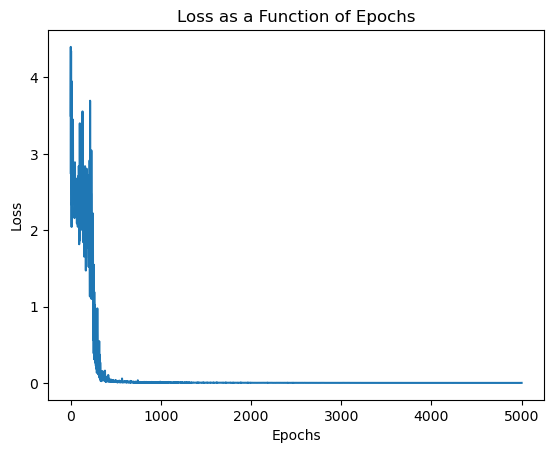

In [5]:
# Plot the loss history
plt.plot(epoch_history, loss_history)
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [13]:
model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3200      
_________________________________________________________________
positional_encoding (Positio multiple                  0         
_________________________________________________________________
transformer_layer (Transform multiple                  74816     
_________________________________________________________________
transformer_layer_1 (Transfo multiple                  74816     
_________________________________________________________________
transformer_layer_2 (Transfo multiple                  74816     
_________________________________________________________________
transformer_layer_3 (Transfo multiple                  74816     
_________________________________________________________________
dense_8 (Dense)              multiple                  

In [14]:
# Example test data
test_data = [9]
test_input = tf.constant([test_data])
print(test_input)
print(test_input[:, :-1])


tf.Tensor([[9]], shape=(1, 1), dtype=int32)
tf.Tensor([], shape=(1, 0), dtype=int32)


In [15]:
# Make predictions
predictions = model(src, test_input, training=False)


In [16]:
print (predictions)

tf.Tensor(
[[[-2.2845879  11.763707   -2.5830638   0.53795856  0.06427059
   -1.0516242   0.72215647  0.23117521 -0.42869654 -0.17891659
   -4.92427    -2.8502545  -2.1656296  -3.0931118  -2.2331924
   -2.2969806  -2.3725076  -2.7731855  -4.147989   -3.720163
   -1.6423275  -3.1538622  -2.349469   -3.0884347  -2.8553681
   -2.1382945  -2.8822927  -3.413901   -2.9953852  -1.4219671
   -2.5671816  -3.442447   -2.8644571  -2.977398   -4.128524
   -2.44527    -2.5822763  -3.4879284  -2.3321881  -2.13711
   -2.2499979  -1.9689534  -3.2443879  -3.588118   -3.0875354
   -2.1860545  -2.9014287  -2.3219771  -4.5286584  -1.3121818 ]]], shape=(1, 1, 50), dtype=float32)


In [12]:
# Print the predicted values
predicted_values = tf.argmax(predictions[:, -1, :], axis=-1).numpy().tolist()
print (predicted_values)
for i, prediction in enumerate(predicted_values):
    print(f"Predicted class for number is {test_data[i]}: {prediction}")


[1]
Predicted class for number is 9: 1
